# Imports

In [1]:
import os
import subprocess
import varseek as vk

# Hyperparameters and Paths

In [2]:
verbose=True
w=54  # window size for varseek build (should be at least 1 less than kallisto k)
k=59
threads = 32
remove_Ns = True
strandedness = False  # strandedness for gget mutate and the building of the kb index (True = strandedness matters i.e., treat f and rc as 2 different sequences; False = strandedness does not matter i.e., treat f and rc as the same 

# vk build
cosmic_version = 100  # COSMIC version for gget cosmic
# os.environ['COSMIC_EMAIL'] = 'your_email'  # to avoid being prompted for email in varseek build
# os.environ['COSMIC_PASSWORD'] = 'your_password'  # to avoid being prompted for password in varseek build

# vk info
columns_to_include="all"
dlist_reference_source = "t2t"  # ensembl_grchNUMBER_releaseNUMBER or t2t - eg ensembl_grch37_release93
near_splice_junction_threshold=10
save_exploded_df=True

# vk filter
fasta_filters = [
    "dlist_substring-equal=none",  # filter out mutations which are a substring of the reference genome
    "pseudoaligned_to_human_reference_despite_not_truly_aligning-isnottrue",  # filter out mutations which pseudoaligned to human genome despite not truly aligning
    "dlist-equal=none",  #*** erase eventually when I want to d-list  # filter out mutations which are capable of being d-listed (given that I filter out the substrings above)
    "number_of_kmers_with_overlap_to_other_mcrs_items_in_mcrs_reference-max=999999",  # filter out mutations which overlap with other MCRSs in the reference
    "number_of_mcrs_items_with_overlapping_kmers_in_mcrs_reference-max=999999",  # filter out mutations which overlap with other MCRSs in the reference
    "longest_homopolymer_length-max=999999",  # filters out MCRSs with repeating single nucleotide - eg 6
    "triplet_complexity-min=0"  # filters out MCRSs with repeating triplets - eg 0.2
]

# kb ref
dlist_kb_argument = "None"  # path to dlist fasta file or "None" (including the quotes)







# Paths
out_dir_base = "/home/jrich/data/varseek_data_fresh"
run_name = "vk_build_pipeline_t2t"

# vk build
mutations = "/home/jrich/data/varseek_data_fresh/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_mutation_workflow_with_cdna.csv"  # "cosmic_cmc"  # file path to mutations csv/tsv file OR one of the supported databases
sequences = "/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"  # cdna  # file path to reference sequence fasta file OR, only if 'mutations' is in the supported databases, one of the following options is also supported: "cds", "cdna", "genome", "cdna_and_genome" - sequences for gget mutate

# vk info
bowtie_path="/home/jrich/opt/bowtie2-2.5.4/bowtie2-2.5.4-linux-x86_64"
mutations_csv="/home/jrich/data/varseek_data_fresh/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_with_cdna.csv"
reference_cdna_fasta="/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"  # the one that matches up to mutation df annotations
reference_genome_fasta="/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"  # the one that matches up to mutation df annotations
gtf_path="/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf"  # the one that matches up to mutation df annotations

# Automatic variable initializations based on provided hyperparameters and paths

In [3]:
out_dir_notebook = os.path.join(out_dir_base, run_name)
reference_out_dir = os.path.join(out_dir_base, "reference")

os.makedirs(out_dir_base, exist_ok=True)
os.makedirs(out_dir_notebook, exist_ok=True)
os.makedirs(reference_out_dir, exist_ok=True)

if remove_Ns:
    max_ambiguous_vk = 0
    N_penalty = 1
    max_Ns_per_read_length = 0
else:
    max_ambiguous_vk = None
    N_penalty = 0
    max_Ns_per_read_length = 0.1

if strandedness:
    merge_identical_rc = False
    bowtie_strandedness = "--norc"  # could do --nofw as well
    kb_strandedness = "--strand forward"
else:
    merge_identical_rc = True
    bowtie_strandedness = ""
    kb_strandedness = ""

vk_build_mcrs_fa_path = os.path.join(out_dir_notebook, "mcrs.fa")
update_df_out = os.path.join(out_dir_notebook, "mutation_metadata_df.csv")
os.makedirs(out_dir_notebook, exist_ok=True)

cosmic_csv = os.path.join(reference_out_dir, "cosmic", f"CancerMutationCensus_AllData_v{cosmic_version}_GRCh37_gget_mutate_with_cdna")  # output of varseek

assert k >= w + 1, "k must be greater than or equal to w + 1"

mutation_metadata_df_path = os.path.join(out_dir_notebook, "mutation_metadata_df.csv")
id_to_header_csv=os.path.join(out_dir_notebook, "id_to_header_mapping.csv")
mutation_metadata_df_out_path_vk_info = os.path.join(out_dir_notebook, "mutation_metadata_df_updated_vk_info.csv")
mutation_index = f"{out_dir_notebook}/mutation_reference.idx"
dlist_fasta = f"{out_dir_notebook}/dlist.fa"

mcrs_fasta_vk_filter = os.path.join(out_dir_notebook, "mcrs_filtered.fa")
output_metadata_df_vk_filter = os.path.join(out_dir_notebook, "mutation_metadata_df_filtered.csv")
dlist_fasta_vk_filter = os.path.join(out_dir_notebook, "dlist_filtered.fa")
t2g_vk_filter = os.path.join(out_dir_notebook, "t2g_filtered.txt")
id_to_header_csv_vk_filter = os.path.join(out_dir_notebook, "id_to_header_mapping_filtered.csv")

# vk build

In [4]:
%%time
vk.build(
    sequences=sequences,
    mutations=mutations,
    out=out_dir_notebook,
    reference_out=reference_out_dir,
    w=w,
    remove_seqs_with_wt_kmers=True,
    optimize_flanking_regions=True,
    min_seq_len=k,
    max_ambiguous=max_ambiguous_vk,
    merge_identical=True,
    merge_identical_rc=strandedness,
    cosmic_email = os.getenv('COSMIC_EMAIL'),
    cosmic_password = os.getenv('COSMIC_PASSWORD'),
    create_t2g=True,
    update_df=True,
    update_df_out=update_df_out,
    verbose=verbose,
)

/home/jrich/Desktop/kvar/varseek/varseek_build.py:638: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(mutations)


23:05:06 - INFO - Removing 81 duplications > w


Extracting MCRS left flank sequences:   0%|                                                                                       | 0/5344380 [00:00<?, ?it/s]

Extracting MCRS left flank sequences:   0%|                                                                          | 1/5344380 [00:04<6919:21:10,  4.66s/it]

Extracting MCRS left flank sequences:   0%|▏                                                                        | 11542/5344380 [00:04<25:53, 3432.33it/s]

Extracting MCRS left flank sequences:   0%|▎                                                                        | 23552/5344380 [00:04<10:49, 8186.78it/s]

Extracting MCRS left flank sequences:   1%|▍                                                                       | 35568/5344380 [00:04<06:10, 14346.88it/s]

Extracting MCRS left flank sequences:   1%|▋                                                                       | 47692/5344380 [00:05<03:59, 22135.65it/s]

Extracting MCRS left flank sequences:   1%|▊                                                                       | 60026/5344380 [00:05<02:46, 31677.07it/s]

Extracting MCRS left flank sequences:   1%|▉                                                                       | 72260/5344380 [00:05<02:04, 42438.18it/s]

Extracting MCRS left flank sequences:   2%|█▏                                                                      | 84376/5344380 [00:05<01:37, 53851.16it/s]

Extracting MCRS left flank sequences:   2%|█▎                                                                      | 96291/5344380 [00:05<01:20, 65054.72it/s]

Extracting MCRS left flank sequences:   2%|█▍                                                                     | 108227/5344380 [00:05<01:09, 75744.97it/s]

Extracting MCRS left flank sequences:   2%|█▌                                                                     | 120106/5344380 [00:05<01:01, 85072.02it/s]

Extracting MCRS left flank sequences:   2%|█▊                                                                     | 131961/5344380 [00:05<00:56, 92668.91it/s]

Extracting MCRS left flank sequences:   3%|█▉                                                                     | 143755/5344380 [00:05<00:52, 98509.49it/s]

Extracting MCRS left flank sequences:   3%|██                                                                    | 155470/5344380 [00:05<00:50, 103272.42it/s]

Extracting MCRS left flank sequences:   3%|██▏                                                                   | 167302/5344380 [00:06<00:48, 107394.64it/s]

Extracting MCRS left flank sequences:   3%|██▎                                                                   | 179037/5344380 [00:06<00:46, 110101.24it/s]

Extracting MCRS left flank sequences:   4%|██▌                                                                   | 191003/5344380 [00:06<00:45, 112838.14it/s]

Extracting MCRS left flank sequences:   4%|██▋                                                                   | 203140/5344380 [00:06<00:44, 115315.36it/s]

Extracting MCRS left flank sequences:   4%|██▊                                                                   | 215251/5344380 [00:06<00:43, 117011.89it/s]

Extracting MCRS left flank sequences:   4%|██▉                                                                   | 227352/5344380 [00:06<00:43, 118190.07it/s]

Extracting MCRS left flank sequences:   4%|███▏                                                                  | 239591/5344380 [00:06<00:42, 119434.59it/s]

Extracting MCRS left flank sequences:   5%|███▎                                                                  | 251889/5344380 [00:06<00:42, 120489.17it/s]

Extracting MCRS left flank sequences:   5%|███▍                                                                  | 264031/5344380 [00:06<00:42, 120586.61it/s]

Extracting MCRS left flank sequences:   5%|███▌                                                                  | 276155/5344380 [00:06<00:42, 119859.86it/s]

Extracting MCRS left flank sequences:   5%|███▊                                                                  | 288188/5344380 [00:07<00:42, 119165.67it/s]

Extracting MCRS left flank sequences:   6%|███▉                                                                  | 300138/5344380 [00:07<00:42, 118814.50it/s]

Extracting MCRS left flank sequences:   6%|████                                                                  | 312043/5344380 [00:07<00:42, 118351.32it/s]

Extracting MCRS left flank sequences:   6%|████▏                                                                 | 323895/5344380 [00:07<00:42, 117828.56it/s]

Extracting MCRS left flank sequences:   6%|████▍                                                                 | 335690/5344380 [00:07<00:42, 117615.96it/s]

Extracting MCRS left flank sequences:   7%|████▌                                                                 | 347460/5344380 [00:07<00:42, 116551.77it/s]

Extracting MCRS left flank sequences:   7%|████▋                                                                 | 359122/5344380 [00:07<00:43, 115020.83it/s]

Extracting MCRS left flank sequences:   7%|████▊                                                                 | 370942/5344380 [00:07<00:42, 115956.36it/s]

Extracting MCRS left flank sequences:   7%|█████                                                                 | 382814/5344380 [00:07<00:42, 116772.17it/s]

Extracting MCRS left flank sequences:   7%|█████▏                                                                | 394498/5344380 [00:07<00:42, 116520.33it/s]

Extracting MCRS left flank sequences:   8%|█████▎                                                                | 406220/5344380 [00:08<00:42, 116727.93it/s]

Extracting MCRS left flank sequences:   8%|█████▍                                                                | 417943/5344380 [00:08<00:42, 116875.74it/s]

Extracting MCRS left flank sequences:   8%|█████▋                                                                | 429722/5344380 [00:08<00:41, 117146.13it/s]

Extracting MCRS left flank sequences:   8%|█████▊                                                                | 441439/5344380 [00:08<00:41, 117083.24it/s]

Extracting MCRS left flank sequences:   8%|█████▉                                                                | 453149/5344380 [00:08<00:41, 116846.83it/s]

Extracting MCRS left flank sequences:   9%|██████                                                                | 464835/5344380 [00:08<00:41, 116321.96it/s]

Extracting MCRS left flank sequences:   9%|██████▏                                                               | 476533/5344380 [00:08<00:41, 116518.10it/s]

Extracting MCRS left flank sequences:   9%|██████▍                                                               | 488186/5344380 [00:08<00:41, 116196.05it/s]

Extracting MCRS left flank sequences:   9%|██████▌                                                               | 499807/5344380 [00:08<00:41, 116010.03it/s]

Extracting MCRS left flank sequences:  10%|██████▋                                                               | 511409/5344380 [00:08<00:41, 115726.90it/s]

Extracting MCRS left flank sequences:  10%|██████▊                                                               | 523060/5344380 [00:09<00:41, 115959.34it/s]

Extracting MCRS left flank sequences:  10%|███████                                                               | 534727/5344380 [00:09<00:41, 116169.53it/s]

Extracting MCRS left flank sequences:  10%|███████▏                                                              | 546345/5344380 [00:09<00:41, 115854.67it/s]

Extracting MCRS left flank sequences:  10%|███████▎                                                              | 557990/5344380 [00:09<00:41, 116031.34it/s]

Extracting MCRS left flank sequences:  11%|███████▍                                                              | 569594/5344380 [00:09<00:41, 115990.10it/s]

Extracting MCRS left flank sequences:  11%|███████▌                                                              | 581242/5344380 [00:09<00:41, 116134.32it/s]

Extracting MCRS left flank sequences:  11%|███████▊                                                              | 592911/5344380 [00:09<00:40, 116298.16it/s]

Extracting MCRS left flank sequences:  11%|███████▉                                                              | 604589/5344380 [00:09<00:40, 116441.18it/s]

Extracting MCRS left flank sequences:  12%|████████                                                              | 616234/5344380 [00:09<00:40, 116315.00it/s]

Extracting MCRS left flank sequences:  12%|████████▏                                                             | 627866/5344380 [00:09<00:40, 116303.74it/s]

Extracting MCRS left flank sequences:  12%|████████▍                                                             | 639497/5344380 [00:10<00:40, 115883.67it/s]

Extracting MCRS left flank sequences:  12%|████████▌                                                             | 651086/5344380 [00:10<00:40, 115677.60it/s]

Extracting MCRS left flank sequences:  12%|████████▋                                                             | 662655/5344380 [00:10<00:40, 115573.02it/s]

Extracting MCRS left flank sequences:  13%|████████▊                                                             | 674213/5344380 [00:10<00:40, 115301.12it/s]

Extracting MCRS left flank sequences:  13%|████████▉                                                             | 685744/5344380 [00:10<00:40, 114423.96it/s]

Extracting MCRS left flank sequences:  13%|█████████▏                                                            | 697188/5344380 [00:10<00:40, 114424.87it/s]

Extracting MCRS left flank sequences:  13%|█████████▎                                                            | 708632/5344380 [00:10<00:43, 105646.64it/s]

Extracting MCRS left flank sequences:  13%|█████████▍                                                            | 720076/5344380 [00:10<00:42, 108126.85it/s]

Extracting MCRS left flank sequences:  14%|█████████▌                                                            | 731769/5344380 [00:10<00:41, 110654.72it/s]

Extracting MCRS left flank sequences:  14%|█████████▋                                                            | 743404/5344380 [00:11<00:40, 112312.27it/s]

Extracting MCRS left flank sequences:  14%|█████████▉                                                            | 755076/5344380 [00:11<00:40, 113605.89it/s]

Extracting MCRS left flank sequences:  14%|██████████                                                            | 766772/5344380 [00:11<00:39, 114595.07it/s]

Extracting MCRS left flank sequences:  15%|██████████▏                                                           | 778376/5344380 [00:11<00:39, 115023.90it/s]

Extracting MCRS left flank sequences:  15%|██████████▎                                                           | 790047/5344380 [00:11<00:39, 115525.73it/s]

Extracting MCRS left flank sequences:  15%|██████████▍                                                           | 801655/5344380 [00:11<00:39, 115690.29it/s]

Extracting MCRS left flank sequences:  15%|██████████▋                                                           | 813290/5344380 [00:11<00:39, 115884.63it/s]

Extracting MCRS left flank sequences:  15%|██████████▊                                                           | 824984/5344380 [00:11<00:38, 116200.05it/s]

Extracting MCRS left flank sequences:  16%|██████████▉                                                           | 836611/5344380 [00:11<00:38, 116110.03it/s]

Extracting MCRS left flank sequences:  16%|███████████                                                           | 848326/5344380 [00:11<00:38, 116420.54it/s]

Extracting MCRS left flank sequences:  16%|███████████▎                                                          | 859972/5344380 [00:12<00:38, 116358.26it/s]

Extracting MCRS left flank sequences:  16%|███████████▍                                                          | 871623/5344380 [00:12<00:38, 116403.09it/s]

Extracting MCRS left flank sequences:  17%|███████████▌                                                          | 883307/5344380 [00:12<00:38, 116532.90it/s]

Extracting MCRS left flank sequences:  17%|███████████▋                                                          | 894962/5344380 [00:12<00:38, 116254.71it/s]

Extracting MCRS left flank sequences:  17%|███████████▉                                                          | 906945/5344380 [00:12<00:37, 117323.06it/s]

Extracting MCRS left flank sequences:  17%|████████████                                                          | 918976/5344380 [00:12<00:37, 118215.17it/s]

Extracting MCRS left flank sequences:  17%|████████████▏                                                         | 931111/5344380 [00:12<00:37, 119152.16it/s]

Extracting MCRS left flank sequences:  18%|████████████▎                                                         | 943281/5344380 [00:12<00:36, 119913.80it/s]

Extracting MCRS left flank sequences:  18%|████████████▌                                                         | 955486/5344380 [00:12<00:36, 120554.17it/s]

Extracting MCRS left flank sequences:  18%|████████████▋                                                         | 967635/5344380 [00:12<00:36, 120833.20it/s]

Extracting MCRS left flank sequences:  18%|████████████▊                                                         | 979727/5344380 [00:13<00:36, 120856.24it/s]

Extracting MCRS left flank sequences:  19%|████████████▉                                                         | 991932/5344380 [00:13<00:35, 121212.16it/s]

Extracting MCRS left flank sequences:  19%|████████████▉                                                        | 1004131/5344380 [00:13<00:35, 121443.60it/s]

Extracting MCRS left flank sequences:  19%|█████████████                                                        | 1016276/5344380 [00:13<00:35, 120637.15it/s]

Extracting MCRS left flank sequences:  19%|█████████████▎                                                       | 1028416/5344380 [00:13<00:35, 120863.06it/s]

Extracting MCRS left flank sequences:  19%|█████████████▍                                                       | 1040504/5344380 [00:13<00:35, 119741.84it/s]

Extracting MCRS left flank sequences:  20%|█████████████▌                                                       | 1052481/5344380 [00:13<00:36, 119155.16it/s]

Extracting MCRS left flank sequences:  20%|█████████████▋                                                       | 1064489/5344380 [00:13<00:35, 119429.44it/s]

Extracting MCRS left flank sequences:  20%|█████████████▉                                                       | 1076434/5344380 [00:13<00:36, 118514.97it/s]

Extracting MCRS left flank sequences:  20%|██████████████                                                       | 1088288/5344380 [00:13<00:36, 117992.48it/s]

Extracting MCRS left flank sequences:  21%|██████████████▏                                                      | 1100089/5344380 [00:14<00:36, 117622.19it/s]

Extracting MCRS left flank sequences:  21%|██████████████▎                                                      | 1111983/5344380 [00:14<00:35, 118012.08it/s]

Extracting MCRS left flank sequences:  21%|██████████████▌                                                      | 1123845/5344380 [00:14<00:35, 118192.53it/s]

Extracting MCRS left flank sequences:  21%|██████████████▋                                                      | 1135666/5344380 [00:14<00:35, 117295.00it/s]

Extracting MCRS left flank sequences:  21%|██████████████▊                                                      | 1147398/5344380 [00:14<00:36, 115900.80it/s]

Extracting MCRS left flank sequences:  22%|██████████████▉                                                      | 1158992/5344380 [00:14<00:36, 115512.76it/s]

Extracting MCRS left flank sequences:  22%|███████████████                                                      | 1170596/5344380 [00:14<00:36, 115668.09it/s]

Extracting MCRS left flank sequences:  22%|███████████████▎                                                     | 1182818/5344380 [00:14<00:35, 117614.79it/s]

Extracting MCRS left flank sequences:  22%|███████████████▍                                                     | 1195014/5344380 [00:14<00:34, 118907.95it/s]

Extracting MCRS left flank sequences:  23%|███████████████▌                                                     | 1206908/5344380 [00:14<00:35, 117343.69it/s]

Extracting MCRS left flank sequences:  23%|███████████████▋                                                     | 1218649/5344380 [00:15<00:35, 116509.45it/s]

Extracting MCRS left flank sequences:  23%|███████████████▉                                                     | 1230305/5344380 [00:15<00:35, 116457.40it/s]

Extracting MCRS left flank sequences:  23%|████████████████                                                     | 1241954/5344380 [00:15<00:35, 116267.48it/s]

Extracting MCRS left flank sequences:  23%|████████████████▏                                                    | 1253682/5344380 [00:15<00:35, 116567.68it/s]

Extracting MCRS left flank sequences:  24%|████████████████▎                                                    | 1265458/5344380 [00:15<00:34, 116921.09it/s]

Extracting MCRS left flank sequences:  24%|████████████████▍                                                    | 1277236/5344380 [00:15<00:34, 117175.07it/s]

Extracting MCRS left flank sequences:  24%|████████████████▋                                                    | 1288985/5344380 [00:15<00:34, 117268.23it/s]

Extracting MCRS left flank sequences:  24%|████████████████▊                                                    | 1300947/5344380 [00:15<00:34, 117969.92it/s]

Extracting MCRS left flank sequences:  25%|████████████████▉                                                    | 1313076/5344380 [00:15<00:33, 118962.09it/s]

Extracting MCRS left flank sequences:  25%|█████████████████                                                    | 1325021/5344380 [00:15<00:33, 119105.54it/s]

Extracting MCRS left flank sequences:  25%|█████████████████▎                                                   | 1337076/5344380 [00:16<00:33, 119537.32it/s]

Extracting MCRS left flank sequences:  25%|█████████████████▍                                                   | 1349081/5344380 [00:16<00:33, 119690.31it/s]

Extracting MCRS left flank sequences:  25%|█████████████████▌                                                   | 1361351/5344380 [00:16<00:33, 120591.02it/s]

Extracting MCRS left flank sequences:  26%|█████████████████▋                                                   | 1373446/5344380 [00:16<00:32, 120696.05it/s]

Extracting MCRS left flank sequences:  26%|█████████████████▉                                                   | 1385516/5344380 [00:16<00:33, 119740.46it/s]

Extracting MCRS left flank sequences:  26%|██████████████████                                                   | 1397492/5344380 [00:16<00:33, 119582.02it/s]

Extracting MCRS left flank sequences:  26%|██████████████████▏                                                  | 1409452/5344380 [00:16<00:38, 102918.49it/s]

Extracting MCRS left flank sequences:  27%|██████████████████▎                                                  | 1421640/5344380 [00:16<00:36, 108008.99it/s]

Extracting MCRS left flank sequences:  27%|██████████████████▌                                                  | 1433775/5344380 [00:16<00:35, 111705.77it/s]

Extracting MCRS left flank sequences:  27%|██████████████████▋                                                  | 1445900/5344380 [00:17<00:34, 114411.01it/s]

Extracting MCRS left flank sequences:  27%|██████████████████▊                                                  | 1457859/5344380 [00:17<00:33, 115902.48it/s]

Extracting MCRS left flank sequences:  27%|██████████████████▉                                                  | 1469599/5344380 [00:17<00:33, 116261.40it/s]

Extracting MCRS left flank sequences:  28%|███████████████████▏                                                 | 1481360/5344380 [00:17<00:33, 116656.35it/s]

Extracting MCRS left flank sequences:  28%|███████████████████▎                                                 | 1493101/5344380 [00:17<00:33, 116605.14it/s]

Extracting MCRS left flank sequences:  28%|███████████████████▍                                                 | 1504814/5344380 [00:17<00:32, 116565.49it/s]

Extracting MCRS left flank sequences:  28%|███████████████████▌                                                 | 1516512/5344380 [00:17<00:32, 116688.15it/s]

Extracting MCRS left flank sequences:  29%|███████████████████▋                                                 | 1528207/5344380 [00:17<00:32, 116614.50it/s]

Extracting MCRS left flank sequences:  29%|███████████████████▉                                                 | 1539913/5344380 [00:17<00:32, 116747.12it/s]

Extracting MCRS left flank sequences:  29%|████████████████████                                                 | 1551601/5344380 [00:17<00:32, 116772.89it/s]

Extracting MCRS left flank sequences:  29%|████████████████████▏                                                | 1563288/5344380 [00:18<00:32, 116647.30it/s]

Extracting MCRS left flank sequences:  29%|████████████████████▎                                                | 1574959/5344380 [00:18<00:32, 116458.03it/s]

Extracting MCRS left flank sequences:  30%|████████████████████▍                                                | 1586623/5344380 [00:18<00:32, 116509.65it/s]

Extracting MCRS left flank sequences:  30%|████████████████████▋                                                | 1598278/5344380 [00:18<00:32, 116191.18it/s]

Extracting MCRS left flank sequences:  30%|████████████████████▊                                                | 1609900/5344380 [00:18<00:32, 116027.74it/s]

Extracting MCRS left flank sequences:  30%|████████████████████▉                                                | 1621505/5344380 [00:18<00:32, 115498.79it/s]

Extracting MCRS left flank sequences:  31%|█████████████████████                                                | 1633240/5344380 [00:18<00:31, 116048.29it/s]

Extracting MCRS left flank sequences:  31%|█████████████████████▏                                               | 1645081/5344380 [00:18<00:31, 116753.48it/s]

Extracting MCRS left flank sequences:  31%|█████████████████████▍                                               | 1656758/5344380 [00:18<00:31, 116708.43it/s]

Extracting MCRS left flank sequences:  31%|█████████████████████▌                                               | 1668430/5344380 [00:18<00:31, 116449.91it/s]

Extracting MCRS left flank sequences:  31%|█████████████████████▋                                               | 1680076/5344380 [00:19<00:31, 115831.90it/s]

Extracting MCRS left flank sequences:  32%|█████████████████████▊                                               | 1691785/5344380 [00:19<00:31, 116206.37it/s]

Extracting MCRS left flank sequences:  32%|█████████████████████▉                                               | 1703539/5344380 [00:19<00:31, 116604.41it/s]

Extracting MCRS left flank sequences:  32%|██████████████████████▏                                              | 1715201/5344380 [00:19<00:31, 116531.32it/s]

Extracting MCRS left flank sequences:  32%|██████████████████████▎                                              | 1726855/5344380 [00:19<00:31, 116440.49it/s]

Extracting MCRS left flank sequences:  33%|██████████████████████▍                                              | 1738500/5344380 [00:19<00:31, 116255.38it/s]

Extracting MCRS left flank sequences:  33%|██████████████████████▌                                              | 1750126/5344380 [00:19<00:30, 116091.27it/s]

Extracting MCRS left flank sequences:  33%|██████████████████████▋                                              | 1761958/5344380 [00:19<00:30, 116757.13it/s]

Extracting MCRS left flank sequences:  33%|██████████████████████▉                                              | 1773635/5344380 [00:19<00:30, 116405.56it/s]

Extracting MCRS left flank sequences:  33%|███████████████████████                                              | 1785276/5344380 [00:19<00:30, 115979.58it/s]

Extracting MCRS left flank sequences:  34%|███████████████████████▏                                             | 1796875/5344380 [00:20<00:30, 115804.72it/s]

Extracting MCRS left flank sequences:  34%|███████████████████████▎                                             | 1808612/5344380 [00:20<00:30, 116272.08it/s]

Extracting MCRS left flank sequences:  34%|███████████████████████▌                                             | 1820240/5344380 [00:20<00:30, 115993.89it/s]

Extracting MCRS left flank sequences:  34%|███████████████████████▋                                             | 1831840/5344380 [00:20<00:30, 115645.43it/s]

Extracting MCRS left flank sequences:  34%|███████████████████████▊                                             | 1843619/5344380 [00:20<00:30, 116283.46it/s]

Extracting MCRS left flank sequences:  35%|███████████████████████▉                                             | 1855539/5344380 [00:20<00:29, 117154.69it/s]

Extracting MCRS left flank sequences:  35%|████████████████████████                                             | 1867488/5344380 [00:20<00:29, 117851.69it/s]

Extracting MCRS left flank sequences:  35%|████████████████████████▎                                            | 1879682/5344380 [00:20<00:29, 119073.58it/s]

Extracting MCRS left flank sequences:  35%|████████████████████████▍                                            | 1891802/5344380 [00:20<00:28, 119709.40it/s]

Extracting MCRS left flank sequences:  36%|████████████████████████▌                                            | 1903774/5344380 [00:20<00:29, 118416.65it/s]

Extracting MCRS left flank sequences:  36%|████████████████████████▋                                            | 1915620/5344380 [00:21<00:29, 117127.08it/s]

Extracting MCRS left flank sequences:  36%|████████████████████████▉                                            | 1927338/5344380 [00:21<00:29, 117112.28it/s]

Extracting MCRS left flank sequences:  36%|█████████████████████████                                            | 1939053/5344380 [00:21<00:29, 117077.49it/s]

Extracting MCRS left flank sequences:  37%|█████████████████████████▏                                           | 1950897/5344380 [00:21<00:28, 117480.81it/s]

Extracting MCRS left flank sequences:  37%|█████████████████████████▎                                           | 1962720/5344380 [00:21<00:28, 117703.23it/s]

Extracting MCRS left flank sequences:  37%|█████████████████████████▍                                           | 1974492/5344380 [00:21<00:28, 117146.17it/s]

Extracting MCRS left flank sequences:  37%|█████████████████████████▋                                           | 1986333/5344380 [00:21<00:28, 117521.07it/s]

Extracting MCRS left flank sequences:  37%|█████████████████████████▊                                           | 1998529/5344380 [00:21<00:28, 118846.27it/s]

Extracting MCRS left flank sequences:  38%|█████████████████████████▉                                           | 2010416/5344380 [00:21<00:28, 117743.41it/s]

Extracting MCRS left flank sequences:  38%|██████████████████████████                                           | 2022454/5344380 [00:21<00:28, 118526.73it/s]

Extracting MCRS left flank sequences:  38%|██████████████████████████▎                                          | 2034414/5344380 [00:22<00:27, 118846.73it/s]

Extracting MCRS left flank sequences:  38%|██████████████████████████▍                                          | 2046357/5344380 [00:22<00:27, 119020.33it/s]

Extracting MCRS left flank sequences:  39%|██████████████████████████▌                                          | 2058369/5344380 [00:22<00:27, 119348.27it/s]

Extracting MCRS left flank sequences:  39%|██████████████████████████▋                                          | 2070306/5344380 [00:22<00:27, 118958.71it/s]

Extracting MCRS left flank sequences:  39%|██████████████████████████▉                                          | 2082203/5344380 [00:22<00:27, 118808.63it/s]

Extracting MCRS left flank sequences:  39%|███████████████████████████                                          | 2094085/5344380 [00:22<00:27, 117684.60it/s]

Extracting MCRS left flank sequences:  39%|███████████████████████████▏                                         | 2105895/5344380 [00:22<00:27, 117807.87it/s]

Extracting MCRS left flank sequences:  40%|███████████████████████████▎                                         | 2117825/5344380 [00:22<00:27, 118251.24it/s]

Extracting MCRS left flank sequences:  40%|███████████████████████████▍                                         | 2129670/5344380 [00:22<00:27, 118308.61it/s]

Extracting MCRS left flank sequences:  40%|███████████████████████████▋                                         | 2141503/5344380 [00:22<00:27, 117176.24it/s]

Extracting MCRS left flank sequences:  40%|███████████████████████████▊                                         | 2153224/5344380 [00:23<00:27, 116207.23it/s]

Extracting MCRS left flank sequences:  41%|███████████████████████████▉                                         | 2164848/5344380 [00:23<00:27, 115654.10it/s]

Extracting MCRS left flank sequences:  41%|████████████████████████████                                         | 2176416/5344380 [00:23<00:27, 115444.62it/s]

Extracting MCRS left flank sequences:  41%|████████████████████████████▏                                        | 2188081/5344380 [00:23<00:27, 115800.47it/s]

Extracting MCRS left flank sequences:  41%|████████████████████████████▍                                        | 2199840/5344380 [00:23<00:27, 116332.97it/s]

Extracting MCRS left flank sequences:  41%|████████████████████████████▌                                        | 2211485/5344380 [00:23<00:26, 116367.11it/s]

Extracting MCRS left flank sequences:  42%|████████████████████████████▋                                        | 2223523/5344380 [00:23<00:26, 117565.22it/s]

Extracting MCRS left flank sequences:  42%|████████████████████████████▊                                        | 2235530/5344380 [00:23<00:26, 118313.39it/s]

Extracting MCRS left flank sequences:  42%|█████████████████████████████                                        | 2247363/5344380 [00:23<00:26, 118265.20it/s]

Extracting MCRS left flank sequences:  42%|█████████████████████████████▏                                       | 2259191/5344380 [00:23<00:26, 118252.44it/s]

Extracting MCRS left flank sequences:  42%|█████████████████████████████▎                                       | 2271207/5344380 [00:24<00:25, 118821.54it/s]

Extracting MCRS left flank sequences:  43%|█████████████████████████████▍                                       | 2283331/5344380 [00:24<00:25, 119544.73it/s]

Extracting MCRS left flank sequences:  43%|█████████████████████████████▋                                       | 2295286/5344380 [00:24<00:25, 119309.42it/s]

Extracting MCRS left flank sequences:  43%|█████████████████████████████▊                                       | 2307218/5344380 [00:24<00:25, 118799.29it/s]

Extracting MCRS left flank sequences:  43%|█████████████████████████████▉                                       | 2319099/5344380 [00:24<00:25, 117935.95it/s]

Extracting MCRS left flank sequences:  44%|██████████████████████████████                                       | 2330968/5344380 [00:24<00:25, 118159.28it/s]

Extracting MCRS left flank sequences:  44%|██████████████████████████████▏                                      | 2342786/5344380 [00:24<00:25, 117155.99it/s]

Extracting MCRS left flank sequences:  44%|██████████████████████████████▍                                      | 2354571/5344380 [00:24<00:25, 117359.66it/s]

Extracting MCRS left flank sequences:  44%|██████████████████████████████▌                                      | 2366324/5344380 [00:24<00:25, 117408.93it/s]

Extracting MCRS left flank sequences:  44%|██████████████████████████████▋                                      | 2378139/5344380 [00:24<00:25, 117627.93it/s]

Extracting MCRS left flank sequences:  45%|██████████████████████████████▊                                      | 2389903/5344380 [00:25<00:25, 117304.23it/s]

Extracting MCRS left flank sequences:  45%|███████████████████████████████                                      | 2401635/5344380 [00:25<00:25, 116965.80it/s]

Extracting MCRS left flank sequences:  45%|███████████████████████████████▏                                     | 2413403/5344380 [00:25<00:25, 117176.42it/s]

Extracting MCRS left flank sequences:  45%|███████████████████████████████▎                                     | 2425122/5344380 [00:25<00:24, 116984.50it/s]

Extracting MCRS left flank sequences:  46%|███████████████████████████████▍                                     | 2436870/5344380 [00:25<00:24, 117132.22it/s]

Extracting MCRS left flank sequences:  46%|███████████████████████████████▌                                     | 2448585/5344380 [00:25<00:24, 117135.07it/s]

Extracting MCRS left flank sequences:  46%|███████████████████████████████▊                                     | 2460299/5344380 [00:25<00:24, 116992.74it/s]

Extracting MCRS left flank sequences:  46%|███████████████████████████████▉                                     | 2471999/5344380 [00:25<00:24, 116821.52it/s]

Extracting MCRS left flank sequences:  46%|████████████████████████████████                                     | 2483725/5344380 [00:25<00:24, 116951.35it/s]

Extracting MCRS left flank sequences:  47%|████████████████████████████████▏                                    | 2495424/5344380 [00:25<00:24, 116961.12it/s]

Extracting MCRS left flank sequences:  47%|████████████████████████████████▎                                    | 2507121/5344380 [00:26<00:24, 116860.55it/s]

Extracting MCRS left flank sequences:  47%|████████████████████████████████▌                                    | 2518808/5344380 [00:26<00:24, 116855.82it/s]

Extracting MCRS left flank sequences:  47%|████████████████████████████████▋                                    | 2530547/5344380 [00:26<00:24, 117014.93it/s]

Extracting MCRS left flank sequences:  48%|████████████████████████████████▊                                    | 2542304/5344380 [00:26<00:23, 117181.02it/s]

Extracting MCRS left flank sequences:  48%|████████████████████████████████▉                                    | 2554023/5344380 [00:26<00:23, 117095.85it/s]

Extracting MCRS left flank sequences:  48%|█████████████████████████████████▏                                   | 2565733/5344380 [00:26<00:23, 117005.91it/s]

Extracting MCRS left flank sequences:  48%|█████████████████████████████████▎                                   | 2577434/5344380 [00:26<00:23, 116961.96it/s]

Extracting MCRS left flank sequences:  48%|█████████████████████████████████▍                                   | 2589131/5344380 [00:26<00:23, 116834.60it/s]

Extracting MCRS left flank sequences:  49%|█████████████████████████████████▌                                   | 2600815/5344380 [00:26<00:23, 116758.54it/s]

Extracting MCRS left flank sequences:  49%|█████████████████████████████████▋                                   | 2612572/5344380 [00:26<00:23, 117000.38it/s]

Extracting MCRS left flank sequences:  49%|█████████████████████████████████▉                                   | 2624479/5344380 [00:27<00:23, 117618.35it/s]

Extracting MCRS left flank sequences:  49%|██████████████████████████████████                                   | 2636738/5344380 [00:27<00:22, 119106.51it/s]

Extracting MCRS left flank sequences:  50%|██████████████████████████████████▏                                  | 2648984/5344380 [00:27<00:22, 120110.66it/s]

Extracting MCRS left flank sequences:  50%|██████████████████████████████████▎                                  | 2661075/5344380 [00:27<00:22, 120349.62it/s]

Extracting MCRS left flank sequences:  50%|██████████████████████████████████▌                                  | 2673149/5344380 [00:27<00:22, 120464.15it/s]

Extracting MCRS left flank sequences:  50%|██████████████████████████████████▋                                  | 2685196/5344380 [00:27<00:22, 119340.38it/s]

Extracting MCRS left flank sequences:  50%|██████████████████████████████████▊                                  | 2697437/5344380 [00:27<00:22, 120255.04it/s]

Extracting MCRS left flank sequences:  51%|██████████████████████████████████▉                                  | 2709622/5344380 [00:27<00:21, 120730.28it/s]

Extracting MCRS left flank sequences:  51%|███████████████████████████████████▏                                 | 2721697/5344380 [00:27<00:21, 119624.00it/s]

Extracting MCRS left flank sequences:  51%|███████████████████████████████████▎                                 | 2733743/5344380 [00:27<00:21, 119870.00it/s]

Extracting MCRS left flank sequences:  51%|███████████████████████████████████▍                                 | 2745733/5344380 [00:28<00:21, 119307.54it/s]

Extracting MCRS left flank sequences:  52%|███████████████████████████████████▌                                 | 2757721/5344380 [00:28<00:21, 119477.06it/s]

Extracting MCRS left flank sequences:  52%|███████████████████████████████████▊                                 | 2769818/5344380 [00:28<00:21, 119921.37it/s]

Extracting MCRS left flank sequences:  52%|███████████████████████████████████▉                                 | 2781812/5344380 [00:28<00:21, 118829.70it/s]

Extracting MCRS left flank sequences:  52%|████████████████████████████████████                                 | 2793698/5344380 [00:28<00:21, 117931.33it/s]

Extracting MCRS left flank sequences:  52%|████████████████████████████████████▋                                 | 2805494/5344380 [00:28<00:28, 87878.04it/s]

Extracting MCRS left flank sequences:  53%|████████████████████████████████████▉                                 | 2817217/5344380 [00:28<00:26, 94918.67it/s]

Extracting MCRS left flank sequences:  53%|████████████████████████████████████▌                                | 2828833/5344380 [00:28<00:25, 100338.47it/s]

Extracting MCRS left flank sequences:  53%|████████████████████████████████████▋                                | 2840570/5344380 [00:28<00:23, 104887.73it/s]

Extracting MCRS left flank sequences:  53%|████████████████████████████████████▊                                | 2852333/5344380 [00:29<00:22, 108407.39it/s]

Extracting MCRS left flank sequences:  54%|████████████████████████████████████▉                                | 2864133/5344380 [00:29<00:22, 111120.72it/s]

Extracting MCRS left flank sequences:  54%|█████████████████████████████████████▏                               | 2875851/5344380 [00:29<00:21, 112863.95it/s]

Extracting MCRS left flank sequences:  54%|█████████████████████████████████████▎                               | 2887407/5344380 [00:29<00:21, 113647.65it/s]

Extracting MCRS left flank sequences:  54%|█████████████████████████████████████▍                               | 2899084/5344380 [00:29<00:21, 114565.02it/s]

Extracting MCRS left flank sequences:  54%|█████████████████████████████████████▌                               | 2910732/5344380 [00:29<00:21, 115130.87it/s]

Extracting MCRS left flank sequences:  55%|█████████████████████████████████████▋                               | 2922466/5344380 [00:29<00:20, 115786.58it/s]

Extracting MCRS left flank sequences:  55%|█████████████████████████████████████▉                               | 2934324/5344380 [00:29<00:20, 116615.92it/s]

Extracting MCRS left flank sequences:  55%|██████████████████████████████████████                               | 2946102/5344380 [00:29<00:20, 116961.62it/s]

Extracting MCRS left flank sequences:  55%|██████████████████████████████████████▏                              | 2957866/5344380 [00:29<00:20, 117164.04it/s]

Extracting MCRS left flank sequences:  56%|██████████████████████████████████████▎                              | 2969643/5344380 [00:30<00:20, 117343.24it/s]

Extracting MCRS left flank sequences:  56%|██████████████████████████████████████▍                              | 2981487/5344380 [00:30<00:20, 117670.31it/s]

Extracting MCRS left flank sequences:  56%|██████████████████████████████████████▋                              | 2993265/5344380 [00:30<00:20, 117133.44it/s]

Extracting MCRS left flank sequences:  56%|██████████████████████████████████████▊                              | 3004987/5344380 [00:30<00:20, 116065.03it/s]

Extracting MCRS left flank sequences:  56%|██████████████████████████████████████▉                              | 3016601/5344380 [00:30<00:20, 115678.15it/s]

Extracting MCRS left flank sequences:  57%|███████████████████████████████████████                              | 3028174/5344380 [00:30<00:20, 115387.10it/s]

Extracting MCRS left flank sequences:  57%|███████████████████████████████████████▏                             | 3039921/5344380 [00:30<00:19, 116005.11it/s]

Extracting MCRS left flank sequences:  57%|███████████████████████████████████████▍                             | 3051645/5344380 [00:30<00:19, 116373.04it/s]

Extracting MCRS left flank sequences:  57%|███████████████████████████████████████▌                             | 3063285/5344380 [00:30<00:19, 116283.47it/s]

Extracting MCRS left flank sequences:  58%|███████████████████████████████████████▋                             | 3075049/5344380 [00:31<00:19, 116688.39it/s]

Extracting MCRS left flank sequences:  58%|███████████████████████████████████████▊                             | 3086908/5344380 [00:31<00:19, 117254.52it/s]

Extracting MCRS left flank sequences:  58%|████████████████████████████████████████                             | 3098676/5344380 [00:31<00:19, 117379.72it/s]

Extracting MCRS left flank sequences:  58%|████████████████████████████████████████▏                            | 3110415/5344380 [00:31<00:19, 117272.49it/s]

Extracting MCRS left flank sequences:  58%|████████████████████████████████████████▎                            | 3122143/5344380 [00:31<00:18, 117222.45it/s]

Extracting MCRS left flank sequences:  59%|████████████████████████████████████████▍                            | 3133866/5344380 [00:31<00:18, 116592.82it/s]

Extracting MCRS left flank sequences:  59%|████████████████████████████████████████▌                            | 3145527/5344380 [00:31<00:19, 115654.55it/s]

Extracting MCRS left flank sequences:  59%|████████████████████████████████████████▊                            | 3157095/5344380 [00:31<00:18, 115419.00it/s]

Extracting MCRS left flank sequences:  59%|████████████████████████████████████████▉                            | 3168806/5344380 [00:31<00:18, 115919.84it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████████████████████████                            | 3180870/5344380 [00:31<00:18, 117327.51it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████████████████████████▏                           | 3192652/5344380 [00:32<00:18, 117474.05it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████████████████████████▎                           | 3204522/5344380 [00:32<00:18, 117838.36it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████████████████████████▌                           | 3216615/5344380 [00:32<00:17, 118761.49it/s]

Extracting MCRS left flank sequences:  60%|█████████████████████████████████████████▋                           | 3228748/5344380 [00:32<00:17, 119530.02it/s]

Extracting MCRS left flank sequences:  61%|█████████████████████████████████████████▊                           | 3240791/5344380 [00:32<00:17, 119798.68it/s]

Extracting MCRS left flank sequences:  61%|█████████████████████████████████████████▉                           | 3252963/5344380 [00:32<00:17, 120373.00it/s]

Extracting MCRS left flank sequences:  61%|██████████████████████████████████████████▏                          | 3265001/5344380 [00:32<00:17, 119332.02it/s]

Extracting MCRS left flank sequences:  61%|██████████████████████████████████████████▎                          | 3276937/5344380 [00:32<00:17, 118798.80it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████████████████████████▍                          | 3288819/5344380 [00:32<00:17, 118393.72it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████████████████████████▌                          | 3300753/5344380 [00:32<00:17, 118674.33it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████████████████████████▊                          | 3312965/5344380 [00:33<00:16, 119699.85it/s]

Extracting MCRS left flank sequences:  62%|██████████████████████████████████████████▉                          | 3325042/5344380 [00:33<00:16, 120019.43it/s]

Extracting MCRS left flank sequences:  62%|███████████████████████████████████████████                          | 3337046/5344380 [00:33<00:16, 119881.96it/s]

Extracting MCRS left flank sequences:  63%|███████████████████████████████████████████▏                         | 3349064/5344380 [00:33<00:16, 119969.96it/s]

Extracting MCRS left flank sequences:  63%|███████████████████████████████████████████▍                         | 3361134/5344380 [00:33<00:16, 120188.33it/s]

Extracting MCRS left flank sequences:  63%|███████████████████████████████████████████▌                         | 3373154/5344380 [00:33<00:16, 119838.08it/s]

Extracting MCRS left flank sequences:  63%|███████████████████████████████████████████▋                         | 3385139/5344380 [00:33<00:16, 119610.87it/s]

Extracting MCRS left flank sequences:  64%|███████████████████████████████████████████▊                         | 3397101/5344380 [00:33<00:16, 118709.53it/s]

Extracting MCRS left flank sequences:  64%|████████████████████████████████████████████                         | 3409316/5344380 [00:33<00:16, 119732.80it/s]

Extracting MCRS left flank sequences:  64%|████████████████████████████████████████████▏                        | 3421292/5344380 [00:33<00:16, 119134.90it/s]

Extracting MCRS left flank sequences:  64%|████████████████████████████████████████████▎                        | 3433474/5344380 [00:34<00:15, 119933.70it/s]

Extracting MCRS left flank sequences:  64%|████████████████████████████████████████████▍                        | 3445480/5344380 [00:34<00:15, 119970.07it/s]

Extracting MCRS left flank sequences:  65%|████████████████████████████████████████████▋                        | 3457701/5344380 [00:34<00:15, 120639.13it/s]

Extracting MCRS left flank sequences:  65%|████████████████████████████████████████████▊                        | 3469767/5344380 [00:34<00:15, 120375.66it/s]

Extracting MCRS left flank sequences:  65%|████████████████████████████████████████████▉                        | 3481938/5344380 [00:34<00:15, 120773.19it/s]

Extracting MCRS left flank sequences:  65%|█████████████████████████████████████████████                        | 3494048/5344380 [00:34<00:15, 120868.54it/s]

Extracting MCRS left flank sequences:  66%|█████████████████████████████████████████████▎                       | 3506246/5344380 [00:34<00:15, 121199.12it/s]

Extracting MCRS left flank sequences:  66%|█████████████████████████████████████████████▍                       | 3518367/5344380 [00:34<00:15, 120702.27it/s]

Extracting MCRS left flank sequences:  66%|█████████████████████████████████████████████▌                       | 3530438/5344380 [00:34<00:15, 119487.45it/s]

Extracting MCRS left flank sequences:  66%|█████████████████████████████████████████████▋                       | 3542396/5344380 [00:34<00:15, 119514.30it/s]

Extracting MCRS left flank sequences:  67%|█████████████████████████████████████████████▉                       | 3554350/5344380 [00:35<00:14, 119445.79it/s]

Extracting MCRS left flank sequences:  67%|██████████████████████████████████████████████                       | 3566557/5344380 [00:35<00:14, 120226.51it/s]

Extracting MCRS left flank sequences:  67%|██████████████████████████████████████████████▏                      | 3578582/5344380 [00:35<00:14, 119625.99it/s]

Extracting MCRS left flank sequences:  67%|██████████████████████████████████████████████▎                      | 3590547/5344380 [00:35<00:14, 117947.84it/s]

Extracting MCRS left flank sequences:  67%|██████████████████████████████████████████████▌                      | 3602348/5344380 [00:35<00:14, 117891.45it/s]

Extracting MCRS left flank sequences:  68%|██████████████████████████████████████████████▋                      | 3614141/5344380 [00:35<00:14, 117592.13it/s]

Extracting MCRS left flank sequences:  68%|██████████████████████████████████████████████▊                      | 3625903/5344380 [00:35<00:14, 117054.41it/s]

Extracting MCRS left flank sequences:  68%|██████████████████████████████████████████████▉                      | 3637611/5344380 [00:35<00:14, 116782.36it/s]

Extracting MCRS left flank sequences:  68%|███████████████████████████████████████████████                      | 3649355/5344380 [00:35<00:14, 116976.28it/s]

Extracting MCRS left flank sequences:  69%|███████████████████████████████████████████████▎                     | 3661054/5344380 [00:35<00:14, 116506.25it/s]

Extracting MCRS left flank sequences:  69%|███████████████████████████████████████████████▍                     | 3672706/5344380 [00:36<00:14, 116143.87it/s]

Extracting MCRS left flank sequences:  69%|███████████████████████████████████████████████▌                     | 3684930/5344380 [00:36<00:14, 117958.57it/s]

Extracting MCRS left flank sequences:  69%|███████████████████████████████████████████████▋                     | 3697133/5344380 [00:36<00:13, 119172.33it/s]

Extracting MCRS left flank sequences:  69%|███████████████████████████████████████████████▉                     | 3709225/5344380 [00:36<00:13, 119694.22it/s]

Extracting MCRS left flank sequences:  70%|████████████████████████████████████████████████                     | 3721325/5344380 [00:36<00:13, 120083.40it/s]

Extracting MCRS left flank sequences:  70%|████████████████████████████████████████████████▏                    | 3733335/5344380 [00:36<00:13, 119361.00it/s]

Extracting MCRS left flank sequences:  70%|████████████████████████████████████████████████▎                    | 3745273/5344380 [00:36<00:13, 117930.18it/s]

Extracting MCRS left flank sequences:  70%|████████████████████████████████████████████████▌                    | 3757071/5344380 [00:36<00:13, 117161.37it/s]

Extracting MCRS left flank sequences:  71%|████████████████████████████████████████████████▋                    | 3768841/5344380 [00:36<00:13, 117317.29it/s]

Extracting MCRS left flank sequences:  71%|████████████████████████████████████████████████▊                    | 3780805/5344380 [00:36<00:13, 118006.54it/s]

Extracting MCRS left flank sequences:  71%|████████████████████████████████████████████████▉                    | 3792993/5344380 [00:37<00:13, 119159.04it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████████████████████████████▏                   | 3805094/5344380 [00:37<00:12, 119710.27it/s]

Extracting MCRS left flank sequences:  71%|█████████████████████████████████████████████████▎                   | 3817329/5344380 [00:37<00:12, 120497.42it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████████████████████████████▍                   | 3829381/5344380 [00:37<00:12, 120345.76it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████████████████████████████▌                   | 3841481/5344380 [00:37<00:12, 120539.60it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████████████████████████████▊                   | 3853536/5344380 [00:37<00:12, 119566.22it/s]

Extracting MCRS left flank sequences:  72%|█████████████████████████████████████████████████▉                   | 3865495/5344380 [00:37<00:12, 118723.46it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████████████████████████████                   | 3877370/5344380 [00:37<00:12, 117913.90it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████████████████████████████▏                  | 3889164/5344380 [00:37<00:12, 117545.52it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████████████████████████████▎                  | 3900920/5344380 [00:37<00:12, 117444.70it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████████████████████████████▌                  | 3912702/5344380 [00:38<00:12, 117555.34it/s]

Extracting MCRS left flank sequences:  73%|██████████████████████████████████████████████████▋                  | 3924524/5344380 [00:38<00:12, 117751.65it/s]

Extracting MCRS left flank sequences:  74%|██████████████████████████████████████████████████▊                  | 3936318/5344380 [00:38<00:11, 117806.71it/s]

Extracting MCRS left flank sequences:  74%|██████████████████████████████████████████████████▉                  | 3948100/5344380 [00:38<00:11, 117630.16it/s]

Extracting MCRS left flank sequences:  74%|███████████████████████████████████████████████████▏                 | 3960043/5344380 [00:38<00:11, 118166.67it/s]

Extracting MCRS left flank sequences:  74%|███████████████████████████████████████████████████▎                 | 3971861/5344380 [00:38<00:11, 117363.01it/s]

Extracting MCRS left flank sequences:  75%|███████████████████████████████████████████████████▍                 | 3983599/5344380 [00:38<00:11, 117004.69it/s]

Extracting MCRS left flank sequences:  75%|███████████████████████████████████████████████████▌                 | 3995308/5344380 [00:38<00:11, 117029.73it/s]

Extracting MCRS left flank sequences:  75%|███████████████████████████████████████████████████▋                 | 4007275/5344380 [00:38<00:11, 117817.27it/s]

Extracting MCRS left flank sequences:  75%|███████████████████████████████████████████████████▉                 | 4019058/5344380 [00:38<00:11, 117503.70it/s]

Extracting MCRS left flank sequences:  75%|████████████████████████████████████████████████████                 | 4030810/5344380 [00:39<00:11, 117118.02it/s]

Extracting MCRS left flank sequences:  76%|████████████████████████████████████████████████████▏                | 4042523/5344380 [00:39<00:11, 116545.23it/s]

Extracting MCRS left flank sequences:  76%|████████████████████████████████████████████████████▎                | 4054179/5344380 [00:39<00:11, 116290.84it/s]

Extracting MCRS left flank sequences:  76%|████████████████████████████████████████████████████▍                | 4065889/5344380 [00:39<00:10, 116531.45it/s]

Extracting MCRS left flank sequences:  76%|████████████████████████████████████████████████████▋                | 4077543/5344380 [00:39<00:10, 116501.69it/s]

Extracting MCRS left flank sequences:  77%|████████████████████████████████████████████████████▊                | 4089194/5344380 [00:39<00:10, 116370.24it/s]

Extracting MCRS left flank sequences:  77%|████████████████████████████████████████████████████▉                | 4100883/5344380 [00:39<00:10, 116523.21it/s]

Extracting MCRS left flank sequences:  77%|█████████████████████████████████████████████████████                | 4112536/5344380 [00:39<00:10, 116432.46it/s]

Extracting MCRS left flank sequences:  77%|█████████████████████████████████████████████████████▏               | 4124242/5344380 [00:39<00:10, 116618.36it/s]

Extracting MCRS left flank sequences:  77%|█████████████████████████████████████████████████████▍               | 4135904/5344380 [00:39<00:10, 116178.30it/s]

Extracting MCRS left flank sequences:  78%|█████████████████████████████████████████████████████▌               | 4147523/5344380 [00:40<00:10, 115098.35it/s]

Extracting MCRS left flank sequences:  78%|█████████████████████████████████████████████████████▋               | 4159036/5344380 [00:40<00:10, 114864.22it/s]

Extracting MCRS left flank sequences:  78%|█████████████████████████████████████████████████████▊               | 4170602/5344380 [00:40<00:10, 115099.39it/s]

Extracting MCRS left flank sequences:  78%|█████████████████████████████████████████████████████▉               | 4182133/5344380 [00:40<00:10, 115162.01it/s]

Extracting MCRS left flank sequences:  78%|██████████████████████████████████████████████████████▏              | 4193651/5344380 [00:40<00:10, 114905.20it/s]

Extracting MCRS left flank sequences:  79%|██████████████████████████████████████████████████████▎              | 4205212/5344380 [00:40<00:09, 115113.87it/s]

Extracting MCRS left flank sequences:  79%|██████████████████████████████████████████████████████▍              | 4216724/5344380 [00:40<00:09, 115098.09it/s]

Extracting MCRS left flank sequences:  79%|██████████████████████████████████████████████████████▌              | 4228236/5344380 [00:40<00:09, 115101.48it/s]

Extracting MCRS left flank sequences:  79%|██████████████████████████████████████████████████████▋              | 4239888/5344380 [00:40<00:09, 115524.33it/s]

Extracting MCRS left flank sequences:  80%|██████████████████████████████████████████████████████▉              | 4251638/5344380 [00:40<00:09, 116114.49it/s]

Extracting MCRS left flank sequences:  80%|███████████████████████████████████████████████████████              | 4263421/5344380 [00:41<00:09, 116627.35it/s]

Extracting MCRS left flank sequences:  80%|███████████████████████████████████████████████████████▏             | 4275350/5344380 [00:41<00:09, 117424.55it/s]

Extracting MCRS left flank sequences:  80%|███████████████████████████████████████████████████████▎             | 4287093/5344380 [00:41<00:09, 117347.10it/s]

Extracting MCRS left flank sequences:  80%|███████████████████████████████████████████████████████▌             | 4298921/5344380 [00:41<00:08, 117625.20it/s]

Extracting MCRS left flank sequences:  81%|███████████████████████████████████████████████████████▋             | 4310740/5344380 [00:41<00:08, 117792.56it/s]

Extracting MCRS left flank sequences:  81%|███████████████████████████████████████████████████████▊             | 4322601/5344380 [00:41<00:08, 118036.38it/s]

Extracting MCRS left flank sequences:  81%|███████████████████████████████████████████████████████▉             | 4334642/5344380 [00:41<00:08, 118747.96it/s]

Extracting MCRS left flank sequences:  81%|████████████████████████████████████████████████████████             | 4346517/5344380 [00:41<00:08, 118073.37it/s]

Extracting MCRS left flank sequences:  82%|████████████████████████████████████████████████████████▎            | 4358326/5344380 [00:41<00:08, 118019.02it/s]

Extracting MCRS left flank sequences:  82%|████████████████████████████████████████████████████████▍            | 4370200/5344380 [00:41<00:08, 118233.89it/s]

Extracting MCRS left flank sequences:  82%|████████████████████████████████████████████████████████▌            | 4382032/5344380 [00:42<00:08, 118257.59it/s]

Extracting MCRS left flank sequences:  82%|████████████████████████████████████████████████████████▋            | 4394122/5344380 [00:42<00:07, 119046.27it/s]

Extracting MCRS left flank sequences:  82%|████████████████████████████████████████████████████████▉            | 4406028/5344380 [00:42<00:07, 118762.52it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████████████████████████████████            | 4418000/5344380 [00:42<00:07, 119047.90it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████████████████████████████████▏           | 4429906/5344380 [00:42<00:07, 118512.45it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████████████████████████████████▎           | 4441758/5344380 [00:42<00:07, 117784.69it/s]

Extracting MCRS left flank sequences:  83%|█████████████████████████████████████████████████████████▍           | 4453538/5344380 [00:42<00:07, 117583.84it/s]

Extracting MCRS left flank sequences:  84%|█████████████████████████████████████████████████████████▋           | 4465298/5344380 [00:42<00:07, 117400.13it/s]

Extracting MCRS left flank sequences:  84%|█████████████████████████████████████████████████████████▊           | 4477039/5344380 [00:42<00:07, 117296.49it/s]

Extracting MCRS left flank sequences:  84%|█████████████████████████████████████████████████████████▉           | 4488769/5344380 [00:42<00:07, 117190.69it/s]

Extracting MCRS left flank sequences:  84%|██████████████████████████████████████████████████████████           | 4500489/5344380 [00:43<00:07, 116973.97it/s]

Extracting MCRS left flank sequences:  84%|██████████████████████████████████████████████████████████▎          | 4512187/5344380 [00:43<00:07, 116960.23it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████████████████████████████████▍          | 4523884/5344380 [00:43<00:07, 116962.26it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████████████████████████████████▌          | 4535622/5344380 [00:43<00:06, 117087.03it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████████████████████████████████▋          | 4547331/5344380 [00:43<00:06, 116753.31it/s]

Extracting MCRS left flank sequences:  85%|██████████████████████████████████████████████████████████▊          | 4559007/5344380 [00:43<00:06, 116545.24it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████████████████████████████████          | 4570701/5344380 [00:43<00:06, 116662.06it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████████████████████████████████▏         | 4582368/5344380 [00:43<00:06, 116631.84it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████████████████████████████████▎         | 4594047/5344380 [00:43<00:06, 116679.07it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████████████████████████████████▍         | 4605715/5344380 [00:43<00:06, 116489.49it/s]

Extracting MCRS left flank sequences:  86%|███████████████████████████████████████████████████████████▌         | 4617538/5344380 [00:44<00:06, 117009.44it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████████████████████████████████▊         | 4629806/5344380 [00:44<00:06, 118705.65it/s]

Extracting MCRS left flank sequences:  87%|███████████████████████████████████████████████████████████▉         | 4642076/5344380 [00:44<00:05, 119900.02it/s]

Extracting MCRS left flank sequences:  87%|████████████████████████████████████████████████████████████         | 4654137/5344380 [00:44<00:05, 120110.75it/s]

Extracting MCRS left flank sequences:  87%|████████████████████████████████████████████████████████████▏        | 4666149/5344380 [00:44<00:05, 119680.21it/s]

Extracting MCRS left flank sequences:  88%|████████████████████████████████████████████████████████████▍        | 4678118/5344380 [00:44<00:05, 119157.56it/s]

Extracting MCRS left flank sequences:  88%|████████████████████████████████████████████████████████████▌        | 4690035/5344380 [00:44<00:05, 118501.45it/s]

Extracting MCRS left flank sequences:  88%|████████████████████████████████████████████████████████████▋        | 4701887/5344380 [00:44<00:05, 118186.33it/s]

Extracting MCRS left flank sequences:  88%|████████████████████████████████████████████████████████████▊        | 4713707/5344380 [00:44<00:05, 118117.21it/s]

Extracting MCRS left flank sequences:  88%|█████████████████████████████████████████████████████████████        | 4725592/5344380 [00:44<00:05, 118334.12it/s]

Extracting MCRS left flank sequences:  89%|█████████████████████████████████████████████████████████████▏       | 4737454/5344380 [00:45<00:05, 118417.99it/s]

Extracting MCRS left flank sequences:  89%|█████████████████████████████████████████████████████████████▎       | 4749386/5344380 [00:45<00:05, 118687.39it/s]

Extracting MCRS left flank sequences:  89%|█████████████████████████████████████████████████████████████▍       | 4761256/5344380 [00:45<00:04, 118267.43it/s]

Extracting MCRS left flank sequences:  89%|█████████████████████████████████████████████████████████████▌       | 4773084/5344380 [00:45<00:04, 117874.13it/s]

Extracting MCRS left flank sequences:  90%|█████████████████████████████████████████████████████████████▊       | 4784872/5344380 [00:45<00:04, 117397.60it/s]

Extracting MCRS left flank sequences:  90%|█████████████████████████████████████████████████████████████▉       | 4796613/5344380 [00:45<00:04, 117317.54it/s]

Extracting MCRS left flank sequences:  90%|██████████████████████████████████████████████████████████████       | 4808346/5344380 [00:45<00:04, 116832.53it/s]

Extracting MCRS left flank sequences:  90%|██████████████████████████████████████████████████████████████▏      | 4820030/5344380 [00:45<00:04, 116286.95it/s]

Extracting MCRS left flank sequences:  90%|██████████████████████████████████████████████████████████████▍      | 4831660/5344380 [00:45<00:04, 116010.60it/s]

Extracting MCRS left flank sequences:  91%|██████████████████████████████████████████████████████████████▌      | 4843426/5344380 [00:45<00:04, 116501.68it/s]

Extracting MCRS left flank sequences:  91%|██████████████████████████████████████████████████████████████▋      | 4855172/5344380 [00:46<00:04, 116787.52it/s]

Extracting MCRS left flank sequences:  91%|██████████████████████████████████████████████████████████████▊      | 4867056/5344380 [00:46<00:04, 117399.13it/s]

Extracting MCRS left flank sequences:  91%|██████████████████████████████████████████████████████████████▉      | 4878870/5344380 [00:46<00:03, 117617.52it/s]

Extracting MCRS left flank sequences:  92%|███████████████████████████████████████████████████████████████▏     | 4890746/5344380 [00:46<00:03, 117957.00it/s]

Extracting MCRS left flank sequences:  92%|███████████████████████████████████████████████████████████████▎     | 4902634/5344380 [00:46<00:03, 118232.41it/s]

Extracting MCRS left flank sequences:  92%|███████████████████████████████████████████████████████████████▍     | 4914461/5344380 [00:46<00:03, 118241.18it/s]

Extracting MCRS left flank sequences:  92%|███████████████████████████████████████████████████████████████▌     | 4926508/5344380 [00:46<00:03, 118908.16it/s]

Extracting MCRS left flank sequences:  92%|███████████████████████████████████████████████████████████████▊     | 4938677/5344380 [00:46<00:03, 119741.95it/s]

Extracting MCRS left flank sequences:  93%|███████████████████████████████████████████████████████████████▉     | 4950859/5344380 [00:46<00:03, 120364.34it/s]

Extracting MCRS left flank sequences:  93%|████████████████████████████████████████████████████████████████     | 4963033/5344380 [00:46<00:03, 120774.13it/s]

Extracting MCRS left flank sequences:  93%|████████████████████████████████████████████████████████████████▏    | 4975186/5344380 [00:47<00:03, 121000.45it/s]

Extracting MCRS left flank sequences:  93%|████████████████████████████████████████████████████████████████▍    | 4987583/5344380 [00:47<00:02, 121890.02it/s]

Extracting MCRS left flank sequences:  94%|████████████████████████████████████████████████████████████████▌    | 4999860/5344380 [00:47<00:02, 122152.02it/s]

Extracting MCRS left flank sequences:  94%|████████████████████████████████████████████████████████████████▋    | 5012076/5344380 [00:47<00:02, 121829.62it/s]

Extracting MCRS left flank sequences:  94%|████████████████████████████████████████████████████████████████▊    | 5024260/5344380 [00:47<00:02, 119706.68it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████████████████████████████████████    | 5036277/5344380 [00:47<00:02, 119843.14it/s]

Extracting MCRS left flank sequences:  94%|█████████████████████████████████████████████████████████████████▏   | 5048268/5344380 [00:47<00:02, 119667.98it/s]

Extracting MCRS left flank sequences:  95%|█████████████████████████████████████████████████████████████████▎   | 5060239/5344380 [00:47<00:02, 119247.67it/s]

Extracting MCRS left flank sequences:  95%|█████████████████████████████████████████████████████████████████▍   | 5072167/5344380 [00:47<00:02, 118839.03it/s]

Extracting MCRS left flank sequences:  95%|█████████████████████████████████████████████████████████████████▋   | 5084053/5344380 [00:48<00:02, 118838.90it/s]

Extracting MCRS left flank sequences:  95%|█████████████████████████████████████████████████████████████████▊   | 5095939/5344380 [00:48<00:02, 118675.58it/s]

Extracting MCRS left flank sequences:  96%|█████████████████████████████████████████████████████████████████▉   | 5107808/5344380 [00:48<00:02, 118232.03it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████████████████████████████████████   | 5119633/5344380 [00:48<00:01, 117629.60it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████████████████████████████████████▎  | 5131607/5344380 [00:48<00:01, 118254.81it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████████████████████████████████████▍  | 5143434/5344380 [00:48<00:01, 117461.41it/s]

Extracting MCRS left flank sequences:  96%|██████████████████████████████████████████████████████████████████▌  | 5155182/5344380 [00:48<00:01, 116727.75it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████████████████████████████████████▋  | 5166857/5344380 [00:48<00:01, 116289.03it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████████████████████████████████████▊  | 5178487/5344380 [00:48<00:01, 115150.62it/s]

Extracting MCRS left flank sequences:  97%|███████████████████████████████████████████████████████████████████  | 5190005/5344380 [00:48<00:01, 114217.67it/s]

Extracting MCRS left flank sequences:  97%|███████████████████████████████████████████████████████████████████▏ | 5201429/5344380 [00:49<00:01, 113632.00it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████████████████████████████████████▎ | 5212926/5344380 [00:49<00:01, 114027.45it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████████████████████████████████████▍ | 5224417/5344380 [00:49<00:01, 114286.72it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████████████████████████████████████▌ | 5235968/5344380 [00:49<00:00, 114648.26it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████████████████████████████████████▊ | 5247758/5344380 [00:49<00:00, 115616.83it/s]

Extracting MCRS left flank sequences:  98%|███████████████████████████████████████████████████████████████████▉ | 5259393/5344380 [00:49<00:00, 115833.89it/s]

Extracting MCRS left flank sequences:  99%|████████████████████████████████████████████████████████████████████ | 5270978/5344380 [00:49<00:00, 115495.21it/s]

Extracting MCRS left flank sequences:  99%|████████████████████████████████████████████████████████████████████▏| 5282784/5344380 [00:49<00:00, 116259.66it/s]

Extracting MCRS left flank sequences:  99%|████████████████████████████████████████████████████████████████████▎| 5294694/5344380 [00:49<00:00, 117107.66it/s]

Extracting MCRS left flank sequences:  99%|████████████████████████████████████████████████████████████████████▌| 5306406/5344380 [00:49<00:00, 116721.34it/s]

Extracting MCRS left flank sequences: 100%|████████████████████████████████████████████████████████████████████▋| 5318079/5344380 [00:50<00:00, 116461.86it/s]

Extracting MCRS left flank sequences: 100%|████████████████████████████████████████████████████████████████████▊| 5329726/5344380 [00:50<00:00, 116442.84it/s]

Extracting MCRS left flank sequences: 100%|████████████████████████████████████████████████████████████████████▉| 5341371/5344380 [00:50<00:00, 116322.25it/s]

Extracting MCRS left flank sequences: 100%|██████████████████████████████████████████████████████████████████████| 5344380/5344380 [00:53<00:00, 99805.73it/s]

Extracting MCRS right flank sequences:   0%|                                                                                         | 0/5344380 [00:00<?, ?it/s]

Extracting MCRS right flank sequences:   0%|                                                                           | 1/5344380 [00:07<10691:09:49,  7.20s/it]

Extracting MCRS right flank sequences:   0%|▏                                                                          | 11421/5344380 [00:07<40:00, 2221.43it/s]

Extracting MCRS right flank sequences:   0%|▎                                                                          | 22962/5344380 [00:07<16:47, 5281.57it/s]

Extracting MCRS right flank sequences:   1%|▍                                                                          | 34691/5344380 [00:07<09:22, 9446.74it/s]

Extracting MCRS right flank sequences:   1%|▋                                                                         | 46303/5344380 [00:07<05:57, 14827.67it/s]

Extracting MCRS right flank sequences:   1%|▊                                                                         | 58235/5344380 [00:07<04:01, 21851.35it/s]

Extracting MCRS right flank sequences:   1%|▉                                                                         | 70114/5344380 [00:07<02:53, 30344.26it/s]

Extracting MCRS right flank sequences:   2%|█▏                                                                        | 82102/5344380 [00:07<02:10, 40303.94it/s]

Extracting MCRS right flank sequences:   2%|█▎                                                                        | 93996/5344380 [00:08<01:42, 51086.28it/s]

Extracting MCRS right flank sequences:   2%|█▍                                                                       | 106267/5344380 [00:08<01:23, 62817.88it/s]

Extracting MCRS right flank sequences:   2%|█▌                                                                       | 118358/5344380 [00:08<01:10, 73832.54it/s]

Extracting MCRS right flank sequences:   2%|█▊                                                                       | 130475/5344380 [00:08<01:02, 83921.85it/s]

Extracting MCRS right flank sequences:   3%|█▉                                                                       | 142452/5344380 [00:08<00:56, 92174.07it/s]

Extracting MCRS right flank sequences:   3%|██                                                                       | 154410/5344380 [00:08<00:52, 98677.41it/s]

Extracting MCRS right flank sequences:   3%|██▏                                                                     | 166319/5344380 [00:08<00:50, 102773.72it/s]

Extracting MCRS right flank sequences:   3%|██▍                                                                     | 178068/5344380 [00:08<00:49, 105346.75it/s]

Extracting MCRS right flank sequences:   4%|██▌                                                                     | 189651/5344380 [00:08<00:47, 108118.40it/s]

Extracting MCRS right flank sequences:   4%|██▋                                                                     | 201299/5344380 [00:08<00:46, 110477.69it/s]

Extracting MCRS right flank sequences:   4%|██▊                                                                     | 212964/5344380 [00:09<00:45, 112251.53it/s]

Extracting MCRS right flank sequences:   4%|███                                                                     | 224578/5344380 [00:09<00:45, 113189.81it/s]

Extracting MCRS right flank sequences:   4%|███▏                                                                    | 236172/5344380 [00:09<00:44, 113796.75it/s]

Extracting MCRS right flank sequences:   5%|███▎                                                                    | 247745/5344380 [00:09<00:44, 113938.03it/s]

Extracting MCRS right flank sequences:   5%|███▍                                                                    | 259275/5344380 [00:09<00:44, 114028.39it/s]

Extracting MCRS right flank sequences:   5%|███▋                                                                    | 270773/5344380 [00:09<00:44, 114257.35it/s]

Extracting MCRS right flank sequences:   5%|███▊                                                                    | 282266/5344380 [00:09<00:44, 114278.83it/s]

Extracting MCRS right flank sequences:   5%|███▉                                                                    | 293826/5344380 [00:09<00:44, 114670.15it/s]

Extracting MCRS right flank sequences:   6%|████                                                                    | 305389/5344380 [00:09<00:43, 114955.52it/s]

Extracting MCRS right flank sequences:   6%|████▎                                                                   | 316908/5344380 [00:09<00:43, 114448.15it/s]

Extracting MCRS right flank sequences:   6%|████▍                                                                   | 328406/5344380 [00:10<00:43, 114604.82it/s]

Extracting MCRS right flank sequences:   6%|████▌                                                                   | 339879/5344380 [00:10<00:43, 114400.91it/s]

Extracting MCRS right flank sequences:   7%|████▋                                                                   | 351328/5344380 [00:10<00:45, 110804.01it/s]

Extracting MCRS right flank sequences:   7%|████▉                                                                   | 362770/5344380 [00:10<00:44, 111859.51it/s]

Extracting MCRS right flank sequences:   7%|█████                                                                   | 373980/5344380 [00:10<00:44, 111815.33it/s]

Extracting MCRS right flank sequences:   7%|█████▏                                                                  | 385480/5344380 [00:10<00:43, 112756.57it/s]

Extracting MCRS right flank sequences:   7%|█████▎                                                                  | 396860/5344380 [00:10<00:43, 113065.41it/s]

Extracting MCRS right flank sequences:   8%|█████▍                                                                  | 408176/5344380 [00:10<00:44, 112113.65it/s]

Extracting MCRS right flank sequences:   8%|█████▋                                                                  | 419489/5344380 [00:10<00:43, 112415.09it/s]

Extracting MCRS right flank sequences:   8%|█████▊                                                                  | 430737/5344380 [00:10<00:44, 111222.10it/s]

Extracting MCRS right flank sequences:   8%|█████▉                                                                  | 442177/5344380 [00:11<00:43, 112161.93it/s]

Extracting MCRS right flank sequences:   8%|██████                                                                  | 453399/5344380 [00:11<00:43, 111695.26it/s]

Extracting MCRS right flank sequences:   9%|██████▎                                                                 | 464615/5344380 [00:11<00:43, 111831.43it/s]

Extracting MCRS right flank sequences:   9%|██████▍                                                                 | 475801/5344380 [00:11<00:44, 109972.47it/s]

Extracting MCRS right flank sequences:   9%|██████▌                                                                 | 487251/5344380 [00:11<00:43, 111307.80it/s]

Extracting MCRS right flank sequences:   9%|██████▋                                                                 | 498690/5344380 [00:11<00:43, 112221.48it/s]

Extracting MCRS right flank sequences:  10%|██████▊                                                                 | 510042/5344380 [00:11<00:42, 112606.88it/s]

Extracting MCRS right flank sequences:  10%|███████                                                                 | 521308/5344380 [00:11<00:42, 112169.16it/s]

Extracting MCRS right flank sequences:  10%|███████▏                                                                | 532529/5344380 [00:11<00:44, 108716.95it/s]

Extracting MCRS right flank sequences:  10%|███████▎                                                                | 543425/5344380 [00:11<00:44, 107992.04it/s]

Extracting MCRS right flank sequences:  10%|███████▍                                                                | 554241/5344380 [00:12<00:44, 106518.79it/s]

Extracting MCRS right flank sequences:  11%|███████▌                                                                | 564906/5344380 [00:12<00:45, 105093.15it/s]

Extracting MCRS right flank sequences:  11%|███████▊                                                                | 575425/5344380 [00:12<00:45, 105078.25it/s]

Extracting MCRS right flank sequences:  11%|███████▉                                                                | 585940/5344380 [00:12<00:46, 103338.09it/s]

Extracting MCRS right flank sequences:  11%|████████                                                                | 596700/5344380 [00:12<00:45, 104580.72it/s]

Extracting MCRS right flank sequences:  11%|████████▏                                                               | 607425/5344380 [00:12<00:44, 105365.74it/s]

Extracting MCRS right flank sequences:  12%|████████▎                                                               | 618703/5344380 [00:12<00:43, 107561.17it/s]

Extracting MCRS right flank sequences:  12%|████████▍                                                               | 629782/5344380 [00:12<00:43, 108520.90it/s]

Extracting MCRS right flank sequences:  12%|████████▋                                                               | 640873/5344380 [00:12<00:43, 109232.48it/s]

Extracting MCRS right flank sequences:  12%|████████▊                                                               | 652269/5344380 [00:12<00:42, 110642.93it/s]

Extracting MCRS right flank sequences:  12%|████████▉                                                               | 663703/5344380 [00:13<00:41, 111746.60it/s]

Extracting MCRS right flank sequences:  13%|█████████                                                               | 675089/5344380 [00:13<00:41, 112378.04it/s]

Extracting MCRS right flank sequences:  13%|█████████▎                                                               | 686330/5344380 [00:13<00:46, 99159.79it/s]

Extracting MCRS right flank sequences:  13%|█████████▌                                                               | 696532/5344380 [00:13<00:52, 89172.84it/s]

Extracting MCRS right flank sequences:  13%|█████████▋                                                               | 705798/5344380 [00:13<01:00, 76775.84it/s]

Extracting MCRS right flank sequences:  13%|█████████▊                                                               | 713950/5344380 [00:13<01:01, 75091.48it/s]

Extracting MCRS right flank sequences:  14%|█████████▊                                                               | 721770/5344380 [00:13<01:02, 73824.90it/s]

Extracting MCRS right flank sequences:  14%|█████████▉                                                               | 730326/5344380 [00:13<01:00, 76834.07it/s]

Extracting MCRS right flank sequences:  14%|██████████▏                                                              | 741431/5344380 [00:14<00:53, 86007.55it/s]

Extracting MCRS right flank sequences:  14%|██████████▎                                                              | 752697/5344380 [00:14<00:49, 93387.95it/s]

Extracting MCRS right flank sequences:  14%|██████████▍                                                              | 763999/5344380 [00:14<00:46, 98951.07it/s]

Extracting MCRS right flank sequences:  15%|██████████▍                                                             | 775357/5344380 [00:14<00:44, 103166.10it/s]

Extracting MCRS right flank sequences:  15%|██████████▌                                                             | 786725/5344380 [00:14<00:42, 106231.69it/s]

Extracting MCRS right flank sequences:  15%|██████████▊                                                             | 798092/5344380 [00:14<00:41, 108416.87it/s]

Extracting MCRS right flank sequences:  15%|██████████▉                                                             | 809443/5344380 [00:14<00:41, 109920.54it/s]

Extracting MCRS right flank sequences:  15%|███████████                                                             | 820830/5344380 [00:14<00:40, 111092.62it/s]

Extracting MCRS right flank sequences:  16%|███████████▏                                                            | 832271/5344380 [00:14<00:40, 112079.14it/s]

Extracting MCRS right flank sequences:  16%|███████████▎                                                            | 843668/5344380 [00:14<00:39, 112642.50it/s]

Extracting MCRS right flank sequences:  16%|███████████▌                                                            | 855047/5344380 [00:15<00:39, 112983.69it/s]

Extracting MCRS right flank sequences:  16%|███████████▋                                                            | 866419/5344380 [00:15<00:39, 113204.01it/s]

Extracting MCRS right flank sequences:  16%|███████████▊                                                            | 877855/5344380 [00:15<00:39, 113549.53it/s]

Extracting MCRS right flank sequences:  17%|███████████▉                                                            | 889218/5344380 [00:15<00:39, 113540.17it/s]

Extracting MCRS right flank sequences:  17%|████████████▏                                                           | 900592/5344380 [00:15<00:39, 113599.12it/s]

Extracting MCRS right flank sequences:  17%|████████████▎                                                           | 911976/5344380 [00:15<00:38, 113668.93it/s]

Extracting MCRS right flank sequences:  17%|████████████▍                                                           | 923346/5344380 [00:15<00:38, 113540.86it/s]

Extracting MCRS right flank sequences:  18%|████████████▌                                                           | 935270/5344380 [00:15<00:38, 115247.66it/s]

Extracting MCRS right flank sequences:  18%|████████████▊                                                           | 946958/5344380 [00:15<00:37, 115735.32it/s]

Extracting MCRS right flank sequences:  18%|████████████▉                                                           | 958533/5344380 [00:15<00:38, 115175.87it/s]

Extracting MCRS right flank sequences:  18%|█████████████                                                           | 970052/5344380 [00:16<00:38, 114628.26it/s]

Extracting MCRS right flank sequences:  18%|█████████████▏                                                          | 981517/5344380 [00:16<00:38, 114410.77it/s]

Extracting MCRS right flank sequences:  19%|█████████████▍                                                          | 992960/5344380 [00:16<00:38, 114270.49it/s]

Extracting MCRS right flank sequences:  19%|█████████████▎                                                         | 1004401/5344380 [00:16<00:37, 114311.77it/s]

Extracting MCRS right flank sequences:  19%|█████████████▍                                                         | 1015833/5344380 [00:16<00:38, 113154.36it/s]

Extracting MCRS right flank sequences:  19%|█████████████▋                                                         | 1027152/5344380 [00:16<00:38, 110875.11it/s]

Extracting MCRS right flank sequences:  19%|█████████████▊                                                         | 1038421/5344380 [00:16<00:38, 111406.54it/s]

Extracting MCRS right flank sequences:  20%|█████████████▉                                                         | 1049853/5344380 [00:16<00:38, 112267.68it/s]

Extracting MCRS right flank sequences:  20%|██████████████                                                         | 1061298/5344380 [00:16<00:37, 112915.00it/s]

Extracting MCRS right flank sequences:  20%|██████████████▎                                                        | 1072665/5344380 [00:16<00:37, 113138.85it/s]

Extracting MCRS right flank sequences:  20%|██████████████▍                                                        | 1084046/5344380 [00:17<00:37, 113336.54it/s]

Extracting MCRS right flank sequences:  20%|██████████████▌                                                        | 1095465/5344380 [00:17<00:37, 113590.07it/s]

Extracting MCRS right flank sequences:  21%|██████████████▋                                                        | 1106953/5344380 [00:17<00:37, 113976.02it/s]

Extracting MCRS right flank sequences:  21%|██████████████▊                                                        | 1118377/5344380 [00:17<00:37, 114053.32it/s]

Extracting MCRS right flank sequences:  21%|███████████████                                                        | 1129784/5344380 [00:17<00:37, 113217.86it/s]

Extracting MCRS right flank sequences:  21%|███████████████▏                                                       | 1141292/5344380 [00:17<00:36, 113773.08it/s]

Extracting MCRS right flank sequences:  22%|███████████████▎                                                       | 1152676/5344380 [00:17<00:36, 113792.53it/s]

Extracting MCRS right flank sequences:  22%|███████████████▍                                                       | 1164173/5344380 [00:17<00:36, 114142.40it/s]

Extracting MCRS right flank sequences:  22%|███████████████▌                                                       | 1175589/5344380 [00:17<00:36, 114034.81it/s]

Extracting MCRS right flank sequences:  22%|███████████████▊                                                       | 1186994/5344380 [00:17<00:36, 113845.03it/s]

Extracting MCRS right flank sequences:  22%|███████████████▉                                                       | 1198437/5344380 [00:18<00:36, 114017.31it/s]

Extracting MCRS right flank sequences:  23%|████████████████                                                       | 1209840/5344380 [00:18<00:36, 113991.85it/s]

Extracting MCRS right flank sequences:  23%|████████████████▏                                                      | 1221240/5344380 [00:18<00:36, 113865.51it/s]

Extracting MCRS right flank sequences:  23%|████████████████▍                                                      | 1232674/5344380 [00:18<00:36, 114006.65it/s]

Extracting MCRS right flank sequences:  23%|████████████████▌                                                      | 1244094/5344380 [00:18<00:35, 114063.47it/s]

Extracting MCRS right flank sequences:  23%|████████████████▋                                                      | 1255501/5344380 [00:18<00:35, 113915.19it/s]

Extracting MCRS right flank sequences:  24%|████████████████▊                                                      | 1266946/5344380 [00:18<00:35, 114074.44it/s]

Extracting MCRS right flank sequences:  24%|████████████████▉                                                      | 1278356/5344380 [00:18<00:35, 114080.99it/s]

Extracting MCRS right flank sequences:  24%|█████████████████▏                                                     | 1289778/5344380 [00:18<00:35, 114121.80it/s]

Extracting MCRS right flank sequences:  24%|█████████████████▌                                                      | 1301191/5344380 [00:19<00:44, 90759.72it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▋                                                      | 1311022/5344380 [00:19<00:47, 84354.27it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▊                                                      | 1320028/5344380 [00:19<00:50, 80436.57it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▉                                                      | 1328465/5344380 [00:19<00:51, 77787.06it/s]

Extracting MCRS right flank sequences:  25%|██████████████████                                                      | 1336503/5344380 [00:19<00:52, 76880.22it/s]

Extracting MCRS right flank sequences:  25%|██████████████████▏                                                     | 1346715/5344380 [00:19<00:47, 83502.43it/s]

Extracting MCRS right flank sequences:  25%|██████████████████▎                                                     | 1358187/5344380 [00:19<00:43, 92012.75it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▍                                                     | 1369619/5344380 [00:19<00:40, 98266.07it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▎                                                    | 1381091/5344380 [00:19<00:38, 102970.95it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▌                                                    | 1392607/5344380 [00:20<00:37, 106505.25it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▉                                                     | 1403389/5344380 [00:20<00:42, 92978.03it/s]

Extracting MCRS right flank sequences:  26%|███████████████████                                                     | 1414854/5344380 [00:20<00:39, 98761.73it/s]

Extracting MCRS right flank sequences:  27%|██████████████████▉                                                    | 1426228/5344380 [00:20<00:38, 102895.97it/s]

Extracting MCRS right flank sequences:  27%|███████████████████                                                    | 1437673/5344380 [00:20<00:36, 106163.42it/s]

Extracting MCRS right flank sequences:  27%|███████████████████▎                                                   | 1449177/5344380 [00:20<00:35, 108715.30it/s]

Extracting MCRS right flank sequences:  27%|███████████████████▍                                                   | 1460719/5344380 [00:20<00:35, 110665.89it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▌                                                   | 1472175/5344380 [00:20<00:34, 111808.37it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▋                                                   | 1483652/5344380 [00:20<00:34, 112684.00it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▊                                                   | 1494982/5344380 [00:21<00:34, 112424.95it/s]

Extracting MCRS right flank sequences:  28%|████████████████████                                                   | 1506442/5344380 [00:21<00:33, 113068.83it/s]

Extracting MCRS right flank sequences:  28%|████████████████████▏                                                  | 1517780/5344380 [00:21<00:34, 112536.79it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▎                                                  | 1529197/5344380 [00:21<00:33, 113019.79it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▍                                                  | 1540594/5344380 [00:21<00:33, 113301.20it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▌                                                  | 1552085/5344380 [00:21<00:33, 113780.17it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▊                                                  | 1563484/5344380 [00:21<00:33, 113840.04it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▉                                                  | 1574991/5344380 [00:21<00:33, 114205.74it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████                                                  | 1586416/5344380 [00:21<00:32, 114136.78it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▏                                                 | 1597833/5344380 [00:21<00:32, 114027.39it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▍                                                 | 1609378/5344380 [00:22<00:32, 114451.71it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▌                                                 | 1620893/5344380 [00:22<00:32, 114660.14it/s]

Extracting MCRS right flank sequences:  31%|█████████████████████▋                                                 | 1632361/5344380 [00:22<00:32, 114521.60it/s]

Extracting MCRS right flank sequences:  31%|█████████████████████▊                                                 | 1644031/5344380 [00:22<00:32, 115171.28it/s]

Extracting MCRS right flank sequences:  31%|█████████████████████▉                                                 | 1655733/5344380 [00:22<00:31, 115723.26it/s]

Extracting MCRS right flank sequences:  31%|██████████████████████▏                                                | 1667306/5344380 [00:22<00:31, 115626.56it/s]

Extracting MCRS right flank sequences:  31%|██████████████████████▎                                                | 1678870/5344380 [00:22<00:31, 115366.21it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▍                                                | 1690407/5344380 [00:22<00:31, 114670.50it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▌                                                | 1701879/5344380 [00:22<00:31, 114685.05it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▊                                                | 1713647/5344380 [00:22<00:31, 115577.62it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▉                                                | 1725481/5344380 [00:23<00:31, 116402.87it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████                                                | 1737123/5344380 [00:23<00:31, 116326.08it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▏                                               | 1748757/5344380 [00:23<00:30, 116090.44it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▍                                               | 1760367/5344380 [00:23<00:30, 115701.67it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▌                                               | 1771938/5344380 [00:23<00:30, 115396.59it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▋                                               | 1783479/5344380 [00:23<00:30, 115052.02it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▏                                               | 1794985/5344380 [00:23<00:36, 96573.06it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▎                                               | 1805142/5344380 [00:23<00:40, 87952.97it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▍                                               | 1814385/5344380 [00:23<00:42, 82653.74it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▌                                               | 1822975/5344380 [00:24<00:44, 79305.63it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▋                                               | 1831120/5344380 [00:24<00:45, 77028.15it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▊                                               | 1839387/5344380 [00:24<00:44, 78490.33it/s]

Extracting MCRS right flank sequences:  35%|████████████████████████▉                                               | 1849146/5344380 [00:24<00:41, 83652.38it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████                                               | 1858712/5344380 [00:24<00:40, 86996.64it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████▏                                              | 1868499/5344380 [00:24<00:38, 90090.53it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████▎                                              | 1878286/5344380 [00:24<00:37, 92339.50it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████▍                                              | 1888053/5344380 [00:24<00:36, 93895.80it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▌                                              | 1897739/5344380 [00:24<00:36, 94766.42it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▋                                              | 1907359/5344380 [00:24<00:36, 95188.94it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▊                                              | 1917129/5344380 [00:25<00:35, 95933.66it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▉                                              | 1926745/5344380 [00:25<00:35, 95802.21it/s]

Extracting MCRS right flank sequences:  36%|██████████████████████████                                              | 1936433/5344380 [00:25<00:35, 96121.69it/s]

Extracting MCRS right flank sequences:  36%|██████████████████████████▏                                             | 1946246/5344380 [00:25<00:35, 96721.57it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▎                                             | 1956159/5344380 [00:25<00:34, 97441.68it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▏                                            | 1967559/5344380 [00:25<00:32, 102397.19it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▎                                            | 1979106/5344380 [00:25<00:31, 106312.27it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▍                                            | 1990478/5344380 [00:25<00:30, 108532.21it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▌                                            | 2001905/5344380 [00:25<00:30, 110249.91it/s]

Extracting MCRS right flank sequences:  38%|██████████████████████████▊                                            | 2013729/5344380 [00:25<00:29, 112644.05it/s]

Extracting MCRS right flank sequences:  38%|██████████████████████████▉                                            | 2025434/5344380 [00:26<00:29, 113963.67it/s]

Extracting MCRS right flank sequences:  38%|███████████████████████████                                            | 2036832/5344380 [00:26<00:29, 113407.91it/s]

Extracting MCRS right flank sequences:  38%|███████████████████████████▏                                           | 2048282/5344380 [00:26<00:28, 113734.30it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▎                                           | 2059694/5344380 [00:26<00:28, 113847.64it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▌                                           | 2071080/5344380 [00:26<00:28, 113777.37it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▋                                           | 2082536/5344380 [00:26<00:28, 114010.89it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▊                                           | 2093938/5344380 [00:26<00:28, 113625.08it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▉                                           | 2105302/5344380 [00:26<00:28, 113602.44it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████                                           | 2116663/5344380 [00:26<00:28, 112298.11it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▎                                          | 2127897/5344380 [00:27<00:28, 111316.32it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▍                                          | 2139033/5344380 [00:27<00:29, 110428.06it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▌                                          | 2150296/5344380 [00:27<00:28, 111076.22it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▋                                          | 2161407/5344380 [00:27<00:29, 109557.20it/s]

Extracting MCRS right flank sequences:  41%|████████████████████████████▊                                          | 2172369/5344380 [00:27<00:29, 108886.63it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████                                          | 2183262/5344380 [00:27<00:29, 108309.10it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████▏                                         | 2194309/5344380 [00:27<00:28, 108946.29it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████▎                                         | 2205207/5344380 [00:27<00:29, 107768.43it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████▍                                         | 2215988/5344380 [00:27<00:29, 106496.59it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▌                                         | 2226642/5344380 [00:27<00:29, 105839.67it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▋                                         | 2237229/5344380 [00:28<00:29, 105079.96it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▊                                         | 2247739/5344380 [00:28<00:29, 104902.71it/s]

Extracting MCRS right flank sequences:  42%|██████████████████████████████                                         | 2258231/5344380 [00:28<00:29, 104763.20it/s]

Extracting MCRS right flank sequences:  42%|██████████████████████████████▏                                        | 2268708/5344380 [00:28<00:29, 104183.25it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▎                                        | 2279127/5344380 [00:28<00:29, 103688.84it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▍                                        | 2289546/5344380 [00:28<00:29, 103837.09it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▌                                        | 2299931/5344380 [00:28<00:29, 102460.60it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▋                                        | 2310181/5344380 [00:28<00:29, 101315.39it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▊                                        | 2320317/5344380 [00:28<00:30, 100351.25it/s]

Extracting MCRS right flank sequences:  44%|██████████████████████████████▉                                        | 2330565/5344380 [00:28<00:29, 100974.83it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████                                        | 2341987/5344380 [00:29<00:28, 104890.94it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▎                                       | 2353325/5344380 [00:29<00:27, 107411.68it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▍                                       | 2364617/5344380 [00:29<00:27, 109050.34it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▌                                       | 2375770/5344380 [00:29<00:27, 109790.53it/s]

Extracting MCRS right flank sequences:  45%|███████████████████████████████▋                                       | 2387078/5344380 [00:29<00:26, 110772.57it/s]

Extracting MCRS right flank sequences:  45%|███████████████████████████████▊                                       | 2398424/5344380 [00:29<00:26, 111575.80it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████                                       | 2409585/5344380 [00:29<00:26, 109579.06it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▏                                      | 2420553/5344380 [00:29<00:27, 106827.45it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▎                                      | 2431255/5344380 [00:29<00:27, 105541.46it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▍                                      | 2441854/5344380 [00:29<00:27, 105670.80it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▌                                      | 2452431/5344380 [00:30<00:27, 105472.11it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▋                                      | 2462985/5344380 [00:30<00:27, 105126.94it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▊                                      | 2474275/5344380 [00:30<00:26, 107426.11it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████                                      | 2485373/5344380 [00:30<00:26, 108479.79it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▏                                     | 2496751/5344380 [00:30<00:25, 110057.61it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▎                                     | 2507897/5344380 [00:30<00:25, 110475.94it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▍                                     | 2518949/5344380 [00:30<00:26, 108373.61it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▌                                     | 2529887/5344380 [00:30<00:25, 108668.97it/s]

Extracting MCRS right flank sequences:  48%|█████████████████████████████████▊                                     | 2541301/5344380 [00:30<00:25, 110289.70it/s]

Extracting MCRS right flank sequences:  48%|█████████████████████████████████▉                                     | 2552833/5344380 [00:30<00:24, 111785.31it/s]

Extracting MCRS right flank sequences:  48%|██████████████████████████████████                                     | 2564429/5344380 [00:31<00:24, 113030.16it/s]

Extracting MCRS right flank sequences:  48%|██████████████████████████████████▏                                    | 2575829/5344380 [00:31<00:24, 113318.49it/s]

Extracting MCRS right flank sequences:  48%|██████████████████████████████████▎                                    | 2587176/5344380 [00:31<00:24, 113361.59it/s]

Extracting MCRS right flank sequences:  49%|██████████████████████████████████▌                                    | 2598515/5344380 [00:31<00:24, 113110.04it/s]

Extracting MCRS right flank sequences:  49%|██████████████████████████████████▋                                    | 2609828/5344380 [00:31<00:24, 113074.51it/s]

Extracting MCRS right flank sequences:  49%|██████████████████████████████████▊                                    | 2621137/5344380 [00:31<00:24, 110818.76it/s]

Extracting MCRS right flank sequences:  49%|██████████████████████████████████▉                                    | 2632251/5344380 [00:31<00:24, 110910.60it/s]

Extracting MCRS right flank sequences:  49%|███████████████████████████████████                                    | 2643350/5344380 [00:31<00:24, 108601.04it/s]

Extracting MCRS right flank sequences:  50%|███████████████████████████████████▎                                   | 2654224/5344380 [00:31<00:25, 104839.23it/s]

Extracting MCRS right flank sequences:  50%|███████████████████████████████████▍                                   | 2664739/5344380 [00:32<00:26, 102327.20it/s]

Extracting MCRS right flank sequences:  50%|███████████████████████████████████▌                                   | 2674998/5344380 [00:32<00:26, 100556.75it/s]

Extracting MCRS right flank sequences:  50%|████████████████████████████████████▏                                   | 2685072/5344380 [00:32<00:26, 99193.12it/s]

Extracting MCRS right flank sequences:  50%|████████████████████████████████████▎                                   | 2695003/5344380 [00:32<00:26, 98271.12it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▍                                   | 2704836/5344380 [00:32<00:26, 97780.10it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▌                                   | 2714617/5344380 [00:32<00:26, 97485.97it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▋                                   | 2724367/5344380 [00:32<00:26, 97285.76it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▊                                   | 2734097/5344380 [00:32<00:26, 97085.51it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▉                                   | 2743806/5344380 [00:32<00:26, 96953.70it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████                                   | 2753502/5344380 [00:32<00:31, 82855.42it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▏                                  | 2762138/5344380 [00:33<00:32, 79358.02it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▎                                  | 2770325/5344380 [00:33<00:33, 77009.22it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▍                                  | 2778196/5344380 [00:33<00:34, 75292.45it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▌                                  | 2785837/5344380 [00:33<00:34, 74162.48it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▋                                  | 2795490/5344380 [00:33<00:31, 80307.27it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▊                                  | 2803628/5344380 [00:33<00:45, 56045.86it/s]

Extracting MCRS right flank sequences:  53%|█████████████████████████████████████▉                                  | 2814156/5344380 [00:33<00:37, 66813.69it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████                                  | 2824166/5344380 [00:33<00:33, 74736.57it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████▏                                 | 2834224/5344380 [00:34<00:30, 81294.55it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████▎                                 | 2844115/5344380 [00:34<00:29, 85979.50it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████▍                                 | 2853574/5344380 [00:34<00:28, 88350.13it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▌                                 | 2863360/5344380 [00:34<00:27, 91034.23it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▋                                 | 2873130/5344380 [00:34<00:26, 92948.76it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▊                                 | 2882970/5344380 [00:34<00:26, 94533.05it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▉                                 | 2892602/5344380 [00:34<00:25, 94939.63it/s]

Extracting MCRS right flank sequences:  54%|███████████████████████████████████████                                 | 2902325/5344380 [00:34<00:25, 95614.32it/s]

Extracting MCRS right flank sequences:  54%|███████████████████████████████████████▏                                | 2911976/5344380 [00:34<00:25, 95633.24it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▎                                | 2921602/5344380 [00:34<00:25, 95296.97it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▍                                | 2931176/5344380 [00:35<00:25, 95373.83it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▌                                | 2940745/5344380 [00:35<00:25, 94169.31it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▋                                | 2950323/5344380 [00:35<00:25, 94643.63it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▉                                | 2960206/5344380 [00:35<00:24, 95885.78it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████                                | 2969996/5344380 [00:35<00:24, 96482.65it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████▏                               | 2979671/5344380 [00:35<00:24, 96560.95it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████▎                               | 2989445/5344380 [00:35<00:24, 96913.32it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████▍                               | 2999142/5344380 [00:35<00:24, 96861.97it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████▌                               | 3008836/5344380 [00:35<00:24, 96883.62it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████▋                               | 3018527/5344380 [00:36<00:24, 96582.36it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▊                               | 3028188/5344380 [00:36<00:24, 96461.38it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▉                               | 3037836/5344380 [00:36<00:23, 96359.54it/s]

Extracting MCRS right flank sequences:  57%|█████████████████████████████████████████                               | 3047473/5344380 [00:36<00:23, 96340.37it/s]

Extracting MCRS right flank sequences:  57%|█████████████████████████████████████████▏                              | 3057108/5344380 [00:36<00:23, 96205.70it/s]

Extracting MCRS right flank sequences:  57%|█████████████████████████████████████████▎                              | 3066730/5344380 [00:36<00:23, 95997.98it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▍                              | 3076479/5344380 [00:36<00:23, 96441.35it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▌                              | 3086124/5344380 [00:36<00:23, 96403.52it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▋                              | 3095765/5344380 [00:36<00:23, 95625.19it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▊                              | 3105330/5344380 [00:36<00:23, 94684.84it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▉                              | 3114984/5344380 [00:37<00:23, 95234.12it/s]

Extracting MCRS right flank sequences:  58%|██████████████████████████████████████████                              | 3125002/5344380 [00:37<00:22, 96703.19it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████▏                             | 3134726/5344380 [00:37<00:22, 96861.73it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████▎                             | 3144811/5344380 [00:37<00:22, 98051.96it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████▍                             | 3154619/5344380 [00:37<00:22, 97802.37it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████▋                             | 3164879/5344380 [00:37<00:21, 99234.34it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████▊                             | 3174805/5344380 [00:37<00:21, 98884.65it/s]

Extracting MCRS right flank sequences:  60%|██████████████████████████████████████████▉                             | 3184695/5344380 [00:37<00:21, 98439.17it/s]

Extracting MCRS right flank sequences:  60%|███████████████████████████████████████████                             | 3194632/5344380 [00:37<00:21, 98715.71it/s]

Extracting MCRS right flank sequences:  60%|███████████████████████████████████████████▏                            | 3204505/5344380 [00:37<00:21, 98338.08it/s]

Extracting MCRS right flank sequences:  60%|███████████████████████████████████████████▎                            | 3214340/5344380 [00:38<00:21, 98017.21it/s]

Extracting MCRS right flank sequences:  60%|███████████████████████████████████████████▍                            | 3224565/5344380 [00:38<00:21, 99277.78it/s]

Extracting MCRS right flank sequences:  61%|██████████████████████████████████████████▉                            | 3235023/5344380 [00:38<00:20, 100859.77it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████                            | 3245412/5344380 [00:38<00:20, 101765.49it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████▎                           | 3255816/5344380 [00:38<00:20, 102443.88it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████▍                           | 3266170/5344380 [00:38<00:20, 102770.03it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████▌                           | 3276609/5344380 [00:38<00:20, 103253.81it/s]

Extracting MCRS right flank sequences:  62%|███████████████████████████████████████████▋                           | 3286936/5344380 [00:38<00:20, 102498.97it/s]

Extracting MCRS right flank sequences:  62%|███████████████████████████████████████████▊                           | 3297225/5344380 [00:38<00:19, 102613.08it/s]

Extracting MCRS right flank sequences:  62%|███████████████████████████████████████████▉                           | 3307488/5344380 [00:38<00:20, 100716.48it/s]

Extracting MCRS right flank sequences:  62%|████████████████████████████████████████████▋                           | 3317568/5344380 [00:39<00:20, 99942.39it/s]

Extracting MCRS right flank sequences:  62%|████████████████████████████████████████████▊                           | 3327569/5344380 [00:39<00:20, 99655.51it/s]

Extracting MCRS right flank sequences:  62%|████████████████████████████████████████████▉                           | 3337642/5344380 [00:39<00:20, 99971.93it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▍                          | 3348058/5344380 [00:39<00:19, 101213.33it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▌                          | 3358948/5344380 [00:39<00:19, 103502.57it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▊                          | 3369709/5344380 [00:39<00:18, 104728.29it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▉                          | 3380492/5344380 [00:39<00:18, 105655.08it/s]

Extracting MCRS right flank sequences:  63%|█████████████████████████████████████████████                          | 3391061/5344380 [00:39<00:18, 103562.50it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▏                         | 3401428/5344380 [00:39<00:18, 102328.31it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▎                         | 3411701/5344380 [00:39<00:18, 102443.98it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▍                         | 3421971/5344380 [00:40<00:18, 102517.51it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▌                         | 3432253/5344380 [00:40<00:18, 102604.50it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▋                         | 3442565/5344380 [00:40<00:18, 102756.59it/s]

Extracting MCRS right flank sequences:  65%|█████████████████████████████████████████████▊                         | 3452960/5344380 [00:40<00:18, 103111.16it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████                         | 3463521/5344380 [00:40<00:18, 103855.87it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████▏                        | 3474316/5344380 [00:40<00:17, 105079.79it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████▎                        | 3484892/5344380 [00:40<00:17, 105281.36it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████▍                        | 3495422/5344380 [00:40<00:17, 104471.44it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████████████████████████████▌                        | 3505872/5344380 [00:40<00:17, 103938.25it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████████████████████████████▋                        | 3516372/5344380 [00:40<00:17, 104252.32it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████████████████████████████▊                        | 3527314/5344380 [00:41<00:17, 105791.58it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████████████████████████████                        | 3538634/5344380 [00:41<00:16, 108004.08it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████████████████████████████▏                       | 3549970/5344380 [00:41<00:16, 109603.90it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▎                       | 3561109/5344380 [00:41<00:16, 110136.66it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▍                       | 3572125/5344380 [00:41<00:16, 107663.37it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▌                       | 3582905/5344380 [00:41<00:16, 104068.09it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▋                       | 3593343/5344380 [00:41<00:16, 103096.56it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▉                       | 3603720/5344380 [00:41<00:16, 103287.82it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████                       | 3614064/5344380 [00:41<00:16, 102176.65it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████▏                      | 3624293/5344380 [00:41<00:17, 100640.25it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████▎                      | 3634546/5344380 [00:42<00:16, 101191.54it/s]

Extracting MCRS right flank sequences:  68%|█████████████████████████████████████████████████                       | 3644674/5344380 [00:42<00:17, 99151.50it/s]

Extracting MCRS right flank sequences:  68%|█████████████████████████████████████████████████▏                      | 3654601/5344380 [00:42<00:17, 97441.69it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████▎                      | 3664356/5344380 [00:42<00:17, 97071.64it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████▍                      | 3674070/5344380 [00:42<00:17, 96971.27it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████▋                      | 3683868/5344380 [00:42<00:17, 97266.86it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████▊                      | 3694317/5344380 [00:42<00:16, 99404.99it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████▏                     | 3704943/5344380 [00:42<00:16, 101440.16it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▎                     | 3715753/5344380 [00:42<00:15, 103423.51it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▌                     | 3726541/5344380 [00:42<00:15, 104752.39it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▋                     | 3737023/5344380 [00:43<00:15, 104769.43it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▊                     | 3747529/5344380 [00:43<00:15, 104854.63it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▉                     | 3758017/5344380 [00:43<00:15, 103634.81it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████                     | 3768386/5344380 [00:43<00:15, 102109.14it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▏                    | 3778604/5344380 [00:43<00:15, 101181.18it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▎                    | 3789008/5344380 [00:43<00:15, 102021.77it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▍                    | 3799438/5344380 [00:43<00:15, 102695.45it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▌                    | 3809863/5344380 [00:43<00:14, 103155.10it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▊                    | 3820183/5344380 [00:43<00:14, 102696.68it/s]

Extracting MCRS right flank sequences:  72%|██████████████████████████████████████████████████▉                    | 3830456/5344380 [00:44<00:14, 101568.36it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████                    | 3840617/5344380 [00:44<00:14, 101571.97it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████▏                   | 3850900/5344380 [00:44<00:14, 101944.31it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████▎                   | 3861097/5344380 [00:44<00:14, 101927.08it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████▍                   | 3871292/5344380 [00:44<00:14, 101630.24it/s]

Extracting MCRS right flank sequences:  73%|███████████████████████████████████████████████████▌                   | 3881457/5344380 [00:44<00:14, 100469.46it/s]

Extracting MCRS right flank sequences:  73%|████████████████████████████████████████████████████▍                   | 3891508/5344380 [00:44<00:14, 99938.68it/s]

Extracting MCRS right flank sequences:  73%|████████████████████████████████████████████████████▌                   | 3901505/5344380 [00:44<00:14, 98970.81it/s]

Extracting MCRS right flank sequences:  73%|████████████████████████████████████████████████████▋                   | 3911405/5344380 [00:44<00:14, 98476.90it/s]

Extracting MCRS right flank sequences:  73%|████████████████████████████████████████████████████▊                   | 3921255/5344380 [00:44<00:14, 98161.68it/s]

Extracting MCRS right flank sequences:  74%|████████████████████████████████████████████████████▉                   | 3931085/5344380 [00:45<00:14, 98200.33it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████████████████████████████████                   | 3940906/5344380 [00:45<00:14, 97716.30it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████████████████████████████████▏                  | 3950685/5344380 [00:45<00:14, 97736.77it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████████████████████████████████▎                  | 3960660/5344380 [00:45<00:14, 98335.80it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████████████████████████████████▍                  | 3970667/5344380 [00:45<00:13, 98853.49it/s]

Extracting MCRS right flank sequences:  74%|█████████████████████████████████████████████████████▋                  | 3980554/5344380 [00:45<00:13, 98856.34it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▊                  | 3990559/5344380 [00:45<00:13, 99212.64it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▏                 | 4001165/5344380 [00:45<00:13, 101261.33it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▎                 | 4011292/5344380 [00:45<00:13, 100427.38it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▍                 | 4021383/5344380 [00:45<00:13, 100568.24it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▌                 | 4032010/5344380 [00:46<00:12, 102269.81it/s]

Extracting MCRS right flank sequences:  76%|█████████████████████████████████████████████████████▋                 | 4043124/5344380 [00:46<00:12, 104920.17it/s]

Extracting MCRS right flank sequences:  76%|█████████████████████████████████████████████████████▊                 | 4054337/5344380 [00:46<00:12, 107077.78it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████████████████████████████████                 | 4065558/5344380 [00:46<00:11, 108613.05it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████████████████████████████████▏                | 4076577/5344380 [00:46<00:11, 109083.99it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████████████████████████████████▎                | 4087487/5344380 [00:46<00:11, 105722.88it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▍                | 4098083/5344380 [00:46<00:12, 102839.96it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▌                | 4108396/5344380 [00:46<00:12, 100502.88it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████████████████████████████████▍                | 4118471/5344380 [00:46<00:12, 99008.33it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████████████████████████████████▌                | 4128389/5344380 [00:46<00:12, 99052.08it/s]

Extracting MCRS right flank sequences:  77%|███████████████████████████████████████████████████████▊                | 4138596/5344380 [00:47<00:12, 99931.49it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████                | 4149047/5344380 [00:47<00:11, 101275.68it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▎               | 4159747/5344380 [00:47<00:11, 102966.41it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▍               | 4170054/5344380 [00:47<00:11, 101865.13it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▌               | 4180249/5344380 [00:47<00:11, 100209.06it/s]

Extracting MCRS right flank sequences:  78%|████████████████████████████████████████████████████████▍               | 4190280/5344380 [00:47<00:11, 98847.63it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████▌               | 4200433/5344380 [00:47<00:11, 99630.53it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████▋               | 4210404/5344380 [00:47<00:11, 98963.18it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████▊               | 4220306/5344380 [00:47<00:11, 98465.72it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████▉               | 4230157/5344380 [00:47<00:11, 98220.08it/s]

Extracting MCRS right flank sequences:  79%|█████████████████████████████████████████████████████████               | 4239982/5344380 [00:48<00:11, 98187.24it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████▎              | 4249803/5344380 [00:48<00:11, 97539.68it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████▍              | 4259559/5344380 [00:48<00:11, 96570.19it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████▌              | 4269219/5344380 [00:48<00:11, 96223.08it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████▋              | 4278843/5344380 [00:48<00:11, 96049.52it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████▊              | 4288449/5344380 [00:48<00:11, 95938.31it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████▉              | 4298044/5344380 [00:48<00:10, 95738.13it/s]

Extracting MCRS right flank sequences:  81%|██████████████████████████████████████████████████████████              | 4307817/5344380 [00:48<00:10, 96329.08it/s]

Extracting MCRS right flank sequences:  81%|██████████████████████████████████████████████████████████▏             | 4317451/5344380 [00:48<00:10, 95718.85it/s]

Extracting MCRS right flank sequences:  81%|██████████████████████████████████████████████████████████▎             | 4327024/5344380 [00:48<00:10, 95277.04it/s]

Extracting MCRS right flank sequences:  81%|██████████████████████████████████████████████████████████▍             | 4336553/5344380 [00:49<00:10, 95121.85it/s]

Extracting MCRS right flank sequences:  81%|██████████████████████████████████████████████████████████▌             | 4346066/5344380 [00:49<00:10, 94831.03it/s]

Extracting MCRS right flank sequences:  81%|██████████████████████████████████████████████████████████▋             | 4355550/5344380 [00:49<00:10, 93714.76it/s]

Extracting MCRS right flank sequences:  82%|██████████████████████████████████████████████████████████▊             | 4364924/5344380 [00:49<00:10, 93641.64it/s]

Extracting MCRS right flank sequences:  82%|██████████████████████████████████████████████████████████▉             | 4374497/5344380 [00:49<00:10, 94259.89it/s]

Extracting MCRS right flank sequences:  82%|███████████████████████████████████████████████████████████             | 4384236/5344380 [00:49<00:10, 95189.96it/s]

Extracting MCRS right flank sequences:  82%|███████████████████████████████████████████████████████████▏            | 4393757/5344380 [00:49<00:10, 95027.90it/s]

Extracting MCRS right flank sequences:  82%|███████████████████████████████████████████████████████████▎            | 4403387/5344380 [00:49<00:09, 95406.13it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████▍            | 4412929/5344380 [00:49<00:09, 95175.07it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████▌            | 4422558/5344380 [00:50<00:09, 95506.32it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████▋            | 4432927/5344380 [00:50<00:09, 97954.38it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████▊            | 4443327/5344380 [00:50<00:09, 99761.91it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████▏           | 4453652/5344380 [00:50<00:08, 100804.29it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▎           | 4463994/5344380 [00:50<00:08, 101587.59it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▍           | 4474375/5344380 [00:50<00:08, 102253.50it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▌           | 4484824/5344380 [00:50<00:08, 102921.27it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▋           | 4495117/5344380 [00:50<00:08, 102879.56it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▊           | 4506180/5344380 [00:50<00:07, 105201.54it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████           | 4517252/5344380 [00:50<00:07, 106854.61it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▏          | 4528583/5344380 [00:51<00:07, 108790.53it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▎          | 4539463/5344380 [00:51<00:07, 107499.01it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▍          | 4550217/5344380 [00:51<00:07, 106988.01it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▌          | 4560930/5344380 [00:51<00:07, 107027.58it/s]

Extracting MCRS right flank sequences:  86%|████████████████████████████████████████████████████████████▋          | 4571635/5344380 [00:51<00:07, 105268.92it/s]

Extracting MCRS right flank sequences:  86%|████████████████████████████████████████████████████████████▊          | 4582169/5344380 [00:51<00:07, 102880.72it/s]

Extracting MCRS right flank sequences:  86%|█████████████████████████████████████████████████████████████          | 4592471/5344380 [00:51<00:07, 101276.80it/s]

Extracting MCRS right flank sequences:  86%|█████████████████████████████████████████████████████████████▏         | 4602610/5344380 [00:51<00:07, 100100.45it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████████████████████████████████████▏         | 4612628/5344380 [00:51<00:07, 99601.03it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████████████████████████████████████▎         | 4622596/5344380 [00:51<00:07, 99623.54it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▍         | 4632679/5344380 [00:52<00:07, 99978.37it/s]

Extracting MCRS right flank sequences:  87%|█████████████████████████████████████████████████████████████▋         | 4642900/5344380 [00:52<00:06, 100639.12it/s]

Extracting MCRS right flank sequences:  87%|█████████████████████████████████████████████████████████████▊         | 4653134/5344380 [00:52<00:06, 101144.59it/s]

Extracting MCRS right flank sequences:  87%|█████████████████████████████████████████████████████████████▉         | 4663917/5344380 [00:52<00:06, 103137.68it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████         | 4674234/5344380 [00:52<00:06, 102309.97it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████████████████████████████████████▏        | 4684469/5344380 [00:52<00:06, 100488.22it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████▏        | 4694526/5344380 [00:52<00:06, 99269.94it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████▍        | 4704583/5344380 [00:52<00:06, 99649.83it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████████████████████████████████████▋        | 4714983/5344380 [00:52<00:06, 100934.12it/s]

Extracting MCRS right flank sequences:  88%|██████████████████████████████████████████████████████████████▊        | 4725083/5344380 [00:52<00:06, 100893.52it/s]

Extracting MCRS right flank sequences:  89%|██████████████████████████████████████████████████████████████▉        | 4735691/5344380 [00:53<00:05, 102436.63it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████        | 4747090/5344380 [00:53<00:05, 105882.62it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████▏       | 4758051/5344380 [00:53<00:05, 106994.79it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████▎       | 4768755/5344380 [00:53<00:05, 105700.42it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████▍       | 4779331/5344380 [00:53<00:05, 102942.90it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████████████████████████████████████▋       | 4789643/5344380 [00:53<00:05, 101305.66it/s]

Extracting MCRS right flank sequences:  90%|███████████████████████████████████████████████████████████████▊       | 4799788/5344380 [00:53<00:05, 100269.98it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████▊       | 4809825/5344380 [00:53<00:05, 99531.32it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████       | 4820112/5344380 [00:53<00:05, 100504.89it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████▏      | 4830356/5344380 [00:53<00:05, 101073.38it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▎      | 4840723/5344380 [00:54<00:04, 101842.23it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▍      | 4851319/5344380 [00:54<00:04, 103065.14it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▌      | 4861631/5344380 [00:54<00:04, 103021.99it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▋      | 4871937/5344380 [00:54<00:04, 102872.99it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▊      | 4882314/5344380 [00:54<00:04, 103138.95it/s]

Extracting MCRS right flank sequences:  92%|████████████████████████████████████████████████████████████████▉      | 4892630/5344380 [00:54<00:04, 102982.56it/s]

Extracting MCRS right flank sequences:  92%|██████████████████████████████████████████████████████████████████      | 4902930/5344380 [00:54<00:04, 99905.55it/s]

Extracting MCRS right flank sequences:  92%|██████████████████████████████████████████████████████████████████▏     | 4912941/5344380 [00:54<00:04, 99016.48it/s]

Extracting MCRS right flank sequences:  92%|██████████████████████████████████████████████████████████████████▎     | 4922857/5344380 [00:54<00:04, 98438.50it/s]

Extracting MCRS right flank sequences:  92%|██████████████████████████████████████████████████████████████████▍     | 4932796/5344380 [00:54<00:04, 98716.56it/s]

Extracting MCRS right flank sequences:  92%|██████████████████████████████████████████████████████████████████▌     | 4942903/5344380 [00:55<00:04, 99411.16it/s]

Extracting MCRS right flank sequences:  93%|█████████████████████████████████████████████████████████████████▊     | 4953236/5344380 [00:55<00:03, 100574.03it/s]

Extracting MCRS right flank sequences:  93%|██████████████████████████████████████████████████████████████████▊     | 4963299/5344380 [00:55<00:03, 99813.33it/s]

Extracting MCRS right flank sequences:  93%|███████████████████████████████████████████████████████████████████     | 4973285/5344380 [00:55<00:03, 99193.66it/s]

Extracting MCRS right flank sequences:  93%|███████████████████████████████████████████████████████████████████▏    | 4983208/5344380 [00:55<00:03, 98793.30it/s]

Extracting MCRS right flank sequences:  93%|███████████████████████████████████████████████████████████████████▎    | 4993090/5344380 [00:55<00:03, 98437.75it/s]

Extracting MCRS right flank sequences:  94%|███████████████████████████████████████████████████████████████████▍    | 5002942/5344380 [00:55<00:03, 98461.36it/s]

Extracting MCRS right flank sequences:  94%|███████████████████████████████████████████████████████████████████▌    | 5012790/5344380 [00:55<00:03, 98443.87it/s]

Extracting MCRS right flank sequences:  94%|██████████████████████████████████████████████████████████████████▋    | 5023775/5344380 [00:55<00:03, 101845.38it/s]

Extracting MCRS right flank sequences:  94%|██████████████████████████████████████████████████████████████████▉    | 5035021/5344380 [00:55<00:02, 105015.84it/s]

Extracting MCRS right flank sequences:  94%|███████████████████████████████████████████████████████████████████    | 5046429/5344380 [00:56<00:02, 107726.67it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▏   | 5057788/5344380 [00:56<00:02, 109480.66it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▎   | 5069138/5344380 [00:56<00:02, 110681.36it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▍   | 5080208/5344380 [00:56<00:02, 107726.34it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▋   | 5090999/5344380 [00:56<00:02, 104831.67it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▊   | 5101508/5344380 [00:56<00:02, 104544.85it/s]

Extracting MCRS right flank sequences:  96%|███████████████████████████████████████████████████████████████████▉   | 5111980/5344380 [00:56<00:02, 104033.75it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████   | 5122630/5344380 [00:56<00:02, 104755.82it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████▏  | 5133287/5344380 [00:56<00:02, 105290.69it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████▎  | 5144562/5344380 [00:57<00:01, 107502.69it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████▍  | 5155401/5344380 [00:57<00:01, 107764.98it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▋  | 5166184/5344380 [00:57<00:01, 106805.05it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▊  | 5176870/5344380 [00:57<00:01, 104471.95it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▉  | 5187331/5344380 [00:57<00:01, 101703.68it/s]

Extracting MCRS right flank sequences:  97%|█████████████████████████████████████████████████████████████████████  | 5197522/5344380 [00:57<00:01, 100143.13it/s]

Extracting MCRS right flank sequences:  97%|██████████████████████████████████████████████████████████████████████▏ | 5207551/5344380 [00:57<00:01, 99072.23it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▎ | 5217852/5344380 [00:57<00:01, 100212.63it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▍ | 5228823/5344380 [00:57<00:01, 102993.85it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▌ | 5239137/5344380 [00:57<00:01, 102793.80it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▋ | 5249539/5344380 [00:58<00:00, 103155.97it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▉ | 5259862/5344380 [00:58<00:00, 102738.92it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████████████████████████████████████████ | 5270141/5344380 [00:58<00:00, 101330.81it/s]

Extracting MCRS right flank sequences:  99%|███████████████████████████████████████████████████████████████████████▏| 5280281/5344380 [00:58<00:00, 99623.57it/s]

Extracting MCRS right flank sequences:  99%|███████████████████████████████████████████████████████████████████████▎| 5290252/5344380 [00:58<00:00, 98181.98it/s]

Extracting MCRS right flank sequences:  99%|███████████████████████████████████████████████████████████████████████▍| 5300566/5344380 [00:58<00:00, 99628.50it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████████████████████████████████████████▌| 5311361/5344380 [00:58<00:00, 102076.68it/s]

Extracting MCRS right flank sequences: 100%|██████████████████████████████████████████████████████████████████████▋| 5322707/5344380 [00:58<00:00, 105444.63it/s]

Extracting MCRS right flank sequences: 100%|██████████████████████████████████████████████████████████████████████▊| 5333843/5344380 [00:58<00:00, 107201.67it/s]

Extracting MCRS right flank sequences: 100%|████████████████████████████████████████████████████████████████████████| 5344380/5344380 [01:03<00:00, 84133.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                                 | 0/5344380 [00:00<?, ?it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                   | 1/5344380 [00:06<10245:26:12,  6.90s/it]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                   | 2706/5344380 [00:07<2:42:14, 548.71it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                  | 5463/5344380 [00:07<1:07:57, 1309.47it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                    | 8212/5344380 [00:07<38:18, 2321.76it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                   | 10982/5344380 [00:07<24:21, 3650.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                  | 13746/5344380 [00:07<16:42, 5319.15it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                  | 16522/5344380 [00:07<12:05, 7347.79it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                  | 19327/5344380 [00:07<09:08, 9715.40it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                 | 22078/5344380 [00:07<07:15, 12214.34it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                 | 24812/5344380 [00:07<06:00, 14741.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 27572/5344380 [00:07<05:08, 17219.35it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 30345/5344380 [00:08<04:32, 19487.37it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 33091/5344380 [00:08<04:09, 21268.39it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 35878/5344380 [00:08<03:51, 22924.64it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 38680/5344380 [00:08<03:38, 24268.16it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 41444/5344380 [00:08<03:31, 25086.54it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 44473/5344380 [00:08<03:19, 26544.10it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 47684/5344380 [00:08<03:08, 28133.77it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 50892/5344380 [00:08<03:00, 29277.61it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 54109/5344380 [00:08<02:55, 30122.40it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 57310/5344380 [00:08<02:52, 30676.49it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 60428/5344380 [00:09<02:54, 30275.65it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 63634/5344380 [00:09<02:51, 30797.99it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 66880/5344380 [00:09<02:48, 31289.17it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 70048/5344380 [00:09<02:47, 31405.19it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 73206/5344380 [00:09<02:47, 31456.42it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 76424/5344380 [00:09<02:46, 31669.98it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 79634/5344380 [00:09<02:45, 31796.85it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 82856/5344380 [00:09<02:44, 31921.61it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 86098/5344380 [00:09<02:43, 32069.83it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 89308/5344380 [00:09<02:45, 31697.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 92481/5344380 [00:10<02:46, 31549.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                 | 95638/5344380 [00:10<02:51, 30642.00it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                 | 98709/5344380 [00:10<02:58, 29338.84it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                | 101657/5344380 [00:10<03:03, 28588.41it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                | 104527/5344380 [00:10<03:05, 28271.05it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                | 107445/5344380 [00:10<03:03, 28529.21it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 110339/5344380 [00:10<03:02, 28646.13it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 113209/5344380 [00:10<03:05, 28216.35it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 116035/5344380 [00:10<03:05, 28213.33it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 118859/5344380 [00:10<03:07, 27931.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 121655/5344380 [00:11<03:07, 27806.22it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█▏                                               | 124437/5344380 [00:11<03:08, 27750.84it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█▏                                               | 127388/5344380 [00:11<03:04, 28270.10it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█▏                                               | 130636/5344380 [00:11<02:56, 29520.12it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▏                                               | 133869/5344380 [00:11<02:51, 30355.05it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 137110/5344380 [00:11<02:48, 30965.82it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 140365/5344380 [00:11<02:45, 31437.26it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 143511/5344380 [00:11<02:45, 31391.55it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 146652/5344380 [00:11<02:47, 31058.27it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 149859/5344380 [00:11<02:45, 31357.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 153023/5344380 [00:12<02:45, 31440.04it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 156229/5344380 [00:12<02:44, 31624.79it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 159442/5344380 [00:12<02:43, 31775.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 162686/5344380 [00:12<02:42, 31973.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 165921/5344380 [00:12<02:41, 32083.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 169146/5344380 [00:12<02:41, 32133.12it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 172360/5344380 [00:12<02:42, 31829.77it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 175544/5344380 [00:12<02:43, 31541.41it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▋                                               | 178700/5344380 [00:12<02:43, 31533.44it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▋                                               | 181855/5344380 [00:12<02:46, 31040.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▋                                               | 184961/5344380 [00:13<02:48, 30644.29it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▋                                               | 188028/5344380 [00:13<02:48, 30566.77it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 191086/5344380 [00:13<02:48, 30515.52it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 194166/5344380 [00:13<02:48, 30599.16it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 197227/5344380 [00:13<02:48, 30492.65it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 200277/5344380 [00:13<02:49, 30276.51it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 203306/5344380 [00:13<02:50, 30104.05it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 206522/5344380 [00:13<02:47, 30711.54it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 209764/5344380 [00:13<02:44, 31218.98it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 212972/5344380 [00:13<02:43, 31475.51it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 216186/5344380 [00:14<02:41, 31672.93it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 219464/5344380 [00:14<02:40, 32002.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 222681/5344380 [00:14<02:39, 32051.45it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 225887/5344380 [00:14<02:42, 31572.36it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 229047/5344380 [00:14<02:46, 30776.07it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 232130/5344380 [00:14<02:49, 30078.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 235144/5344380 [00:14<02:49, 30081.34it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 238353/5344380 [00:14<02:46, 30667.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▏                                              | 241565/5344380 [00:14<02:44, 31093.85it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▏                                              | 244767/5344380 [00:15<02:42, 31367.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 247965/5344380 [00:15<02:41, 31548.64it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 251123/5344380 [00:15<02:42, 31327.93it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 254258/5344380 [00:15<02:44, 30905.65it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 257503/5344380 [00:15<02:42, 31359.02it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 260724/5344380 [00:15<02:40, 31608.79it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 263949/5344380 [00:15<02:39, 31796.92it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 267172/5344380 [00:15<02:39, 31923.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 270415/5344380 [00:15<02:38, 32074.95it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 273681/5344380 [00:15<02:37, 32249.26it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 276907/5344380 [00:16<02:43, 31070.18it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 280031/5344380 [00:16<02:42, 31118.25it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 283304/5344380 [00:16<02:40, 31591.13it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▋                                              | 286509/5344380 [00:16<02:39, 31724.95it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▋                                              | 289768/5344380 [00:16<02:38, 31981.00it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▋                                              | 292970/5344380 [00:16<02:38, 31793.85it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▋                                              | 296152/5344380 [00:16<02:39, 31625.45it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▋                                              | 299422/5344380 [00:16<02:37, 31943.53it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 302625/5344380 [00:16<02:37, 31967.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 305834/5344380 [00:16<02:37, 32002.13it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 309080/5344380 [00:17<02:36, 32138.66it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 312295/5344380 [00:17<02:36, 32072.32it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 315521/5344380 [00:17<02:36, 32127.65it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 318735/5344380 [00:17<02:37, 31962.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 321986/5344380 [00:17<02:36, 32123.43it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 325229/5344380 [00:17<02:35, 32212.42it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 328451/5344380 [00:17<02:41, 31030.73it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 331564/5344380 [00:17<02:41, 30965.60it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 334790/5344380 [00:17<02:39, 31343.43it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 337945/5344380 [00:17<02:39, 31403.15it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███▏                                             | 341180/5344380 [00:18<02:37, 31682.34it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███▏                                             | 344375/5344380 [00:18<02:37, 31760.75it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▏                                             | 347601/5344380 [00:18<02:36, 31907.68it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▏                                             | 350794/5344380 [00:18<02:41, 30975.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▏                                             | 353899/5344380 [00:18<02:44, 30428.93it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 356948/5344380 [00:18<02:49, 29372.48it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 359895/5344380 [00:18<02:53, 28707.83it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 362774/5344380 [00:18<02:55, 28329.20it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 365907/5344380 [00:18<02:50, 29188.66it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 369131/5344380 [00:19<02:45, 30073.47it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 372301/5344380 [00:19<02:42, 30548.51it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 375494/5344380 [00:19<02:40, 30955.32it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 378714/5344380 [00:19<02:38, 31322.49it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 381851/5344380 [00:19<02:41, 30767.53it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 384933/5344380 [00:19<02:44, 30221.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 388069/5344380 [00:19<02:42, 30551.27it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 391250/5344380 [00:19<02:40, 30920.26it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 394466/5344380 [00:19<02:38, 31285.82it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▋                                             | 397598/5344380 [00:19<02:38, 31269.97it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▋                                             | 400795/5344380 [00:20<02:37, 31477.69it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▋                                             | 404030/5344380 [00:20<02:35, 31737.21it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▋                                             | 407205/5344380 [00:20<02:38, 31119.31it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 410321/5344380 [00:20<02:43, 30209.66it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 413529/5344380 [00:20<02:40, 30751.99it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 416611/5344380 [00:20<02:40, 30712.45it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 419687/5344380 [00:20<02:41, 30433.44it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 422734/5344380 [00:20<02:43, 30132.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 425750/5344380 [00:20<02:45, 29718.05it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 428725/5344380 [00:20<02:47, 29303.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 431662/5344380 [00:21<02:47, 29321.18it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 434596/5344380 [00:21<02:47, 29289.10it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 437526/5344380 [00:21<02:48, 29195.01it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 440532/5344380 [00:21<02:46, 29449.73it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 443497/5344380 [00:21<02:46, 29508.68it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 446449/5344380 [00:21<02:46, 29458.86it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 449396/5344380 [00:21<02:46, 29427.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████▏                                            | 452340/5344380 [00:21<02:47, 29247.16it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▏                                            | 455266/5344380 [00:21<02:48, 28980.22it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▏                                            | 458165/5344380 [00:21<02:49, 28800.40it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▏                                            | 461046/5344380 [00:22<02:50, 28601.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 463965/5344380 [00:22<02:49, 28774.61it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 466843/5344380 [00:22<02:49, 28705.04it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 469714/5344380 [00:22<02:50, 28618.57it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 472748/5344380 [00:22<02:47, 29129.91it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 475928/5344380 [00:22<02:42, 29923.51it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 479165/5344380 [00:22<02:38, 30651.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 482375/5344380 [00:22<02:36, 31084.75it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 485485/5344380 [00:22<02:41, 30149.35it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 488507/5344380 [00:22<02:45, 29365.38it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 491452/5344380 [00:23<02:46, 29100.52it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 494406/5344380 [00:23<02:45, 29225.73it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 497333/5344380 [00:23<02:46, 29048.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 500241/5344380 [00:23<02:48, 28814.64it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 503125/5344380 [00:23<02:48, 28730.50it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▋                                            | 506000/5344380 [00:23<02:49, 28600.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 508861/5344380 [00:23<02:50, 28384.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 511701/5344380 [00:23<02:51, 28210.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 514748/5344380 [00:23<02:47, 28876.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 517968/5344380 [00:23<02:41, 29861.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 520957/5344380 [00:24<02:41, 29829.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 523942/5344380 [00:24<02:43, 29438.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 526888/5344380 [00:24<02:45, 29077.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 529868/5344380 [00:24<02:44, 29289.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 533081/5344380 [00:24<02:39, 30129.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 536162/5344380 [00:24<02:38, 30329.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 539197/5344380 [00:24<02:38, 30327.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 542410/5344380 [00:24<02:35, 30863.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 545498/5344380 [00:24<02:36, 30625.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 548605/5344380 [00:25<02:35, 30754.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 551682/5344380 [00:25<02:39, 30105.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 554905/5344380 [00:25<02:35, 30729.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 558165/5344380 [00:25<02:32, 31283.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 561325/5344380 [00:25<02:32, 31376.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 564541/5344380 [00:25<02:31, 31609.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 567704/5344380 [00:25<02:33, 31037.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 570812/5344380 [00:25<02:37, 30385.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 573856/5344380 [00:25<02:40, 29700.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 576832/5344380 [00:25<02:42, 29272.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 579979/5344380 [00:26<02:39, 29906.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 583229/5344380 [00:26<02:35, 30665.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 586500/5344380 [00:26<02:32, 31264.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 589741/5344380 [00:26<02:30, 31603.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 592906/5344380 [00:26<02:32, 31172.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 596027/5344380 [00:26<02:34, 30706.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 599102/5344380 [00:26<02:36, 30376.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 602143/5344380 [00:26<02:36, 30241.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 605169/5344380 [00:26<02:38, 29949.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 608166/5344380 [00:26<02:39, 29670.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 611389/5344380 [00:27<02:35, 30419.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▋                                           | 614600/5344380 [00:27<02:32, 30917.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 617795/5344380 [00:27<02:31, 31222.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 621019/5344380 [00:27<02:29, 31524.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 624174/5344380 [00:27<02:32, 30914.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 627269/5344380 [00:27<02:35, 30281.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 630302/5344380 [00:27<02:36, 30136.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 633346/5344380 [00:27<02:35, 30222.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 636615/5344380 [00:27<02:32, 30948.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 639845/5344380 [00:27<02:30, 31349.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 643104/5344380 [00:28<02:28, 31716.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 646278/5344380 [00:28<02:30, 31272.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 649408/5344380 [00:28<02:32, 30687.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 652481/5344380 [00:28<02:35, 30203.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 655518/5344380 [00:28<02:35, 30249.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 658630/5344380 [00:28<02:33, 30503.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 661683/5344380 [00:28<02:35, 30084.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 664694/5344380 [00:28<02:37, 29704.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 667667/5344380 [00:28<02:38, 29421.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 670611/5344380 [00:29<02:41, 28927.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 673506/5344380 [00:29<02:43, 28546.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 676752/5344380 [00:29<02:37, 29684.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 680023/5344380 [00:29<02:32, 30571.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 683239/5344380 [00:29<02:30, 31040.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 686506/5344380 [00:29<02:27, 31523.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 689717/5344380 [00:29<02:26, 31698.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 692890/5344380 [00:29<02:27, 31602.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 696101/5344380 [00:29<02:26, 31753.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 699278/5344380 [00:29<02:38, 29306.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 702521/5344380 [00:30<02:33, 30186.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 705718/5344380 [00:30<02:31, 30697.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 708944/5344380 [00:30<02:28, 31151.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 712078/5344380 [00:30<02:29, 31079.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 715199/5344380 [00:30<02:31, 30638.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 718273/5344380 [00:30<02:31, 30480.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 721428/5344380 [00:30<02:30, 30792.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 724513/5344380 [00:30<02:31, 30465.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 727564/5344380 [00:30<02:32, 30229.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 730590/5344380 [00:30<02:34, 29851.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 733578/5344380 [00:31<02:35, 29648.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 736545/5344380 [00:31<02:35, 29561.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 739503/5344380 [00:31<02:37, 29145.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 742420/5344380 [00:31<02:41, 28552.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 745278/5344380 [00:31<02:42, 28274.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 748254/5344380 [00:31<02:40, 28706.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 751232/5344380 [00:31<02:38, 29020.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 754193/5344380 [00:31<02:37, 29192.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 757140/5344380 [00:31<02:36, 29274.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 760256/5344380 [00:31<02:33, 29833.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 763349/5344380 [00:32<02:31, 30161.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 766367/5344380 [00:32<02:32, 29944.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 769363/5344380 [00:32<02:33, 29723.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 772337/5344380 [00:32<02:35, 29337.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████                                          | 775273/5344380 [00:32<02:37, 28927.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 778168/5344380 [00:32<02:38, 28892.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 781059/5344380 [00:32<02:40, 28497.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 783911/5344380 [00:32<02:41, 28194.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 786812/5344380 [00:32<02:40, 28431.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 790013/5344380 [00:33<02:34, 29486.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 793005/5344380 [00:33<02:33, 29614.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 796162/5344380 [00:33<02:30, 30195.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 799184/5344380 [00:33<02:30, 30171.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 802248/5344380 [00:33<02:29, 30310.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 805281/5344380 [00:33<02:31, 30026.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 808285/5344380 [00:33<02:31, 29977.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 811426/5344380 [00:33<02:29, 30401.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 814468/5344380 [00:33<03:02, 24814.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 817117/5344380 [00:34<03:13, 23356.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 819577/5344380 [00:34<03:22, 22320.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 821895/5344380 [00:34<03:30, 21527.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 824105/5344380 [00:34<03:34, 21054.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 826506/5344380 [00:34<03:26, 21833.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▌                                         | 829648/5344380 [00:34<03:04, 24455.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 832773/5344380 [00:34<02:51, 26363.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 836011/5344380 [00:34<02:40, 28085.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 839238/5344380 [00:34<02:33, 29300.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 842401/5344380 [00:34<02:30, 29983.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 845621/5344380 [00:35<02:26, 30635.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 848703/5344380 [00:35<02:31, 29664.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 851689/5344380 [00:35<02:35, 28920.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 854610/5344380 [00:35<02:34, 29002.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 857582/5344380 [00:35<02:33, 29210.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 860512/5344380 [00:35<02:34, 29013.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 863420/5344380 [00:35<02:34, 29003.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 866325/5344380 [00:35<02:34, 28937.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 869296/5344380 [00:35<02:33, 29166.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 872215/5344380 [00:36<02:34, 29023.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|████████                                         | 875145/5344380 [00:36<02:33, 29103.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|████████                                         | 878057/5344380 [00:36<02:34, 28907.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|████████                                         | 881098/5344380 [00:36<02:32, 29352.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████                                         | 884086/5344380 [00:36<02:31, 29507.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 887044/5344380 [00:36<02:30, 29527.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 890274/5344380 [00:36<02:26, 30355.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 893311/5344380 [00:36<02:27, 30098.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 896322/5344380 [00:36<02:28, 29932.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 899317/5344380 [00:36<02:30, 29454.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 902265/5344380 [00:37<02:32, 29136.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 905209/5344380 [00:37<02:31, 29225.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 908394/5344380 [00:37<02:27, 30000.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 911574/5344380 [00:37<02:25, 30533.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 914767/5344380 [00:37<02:23, 30948.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 917973/5344380 [00:37<02:21, 31279.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 921177/5344380 [00:37<02:20, 31504.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 924367/5344380 [00:37<02:19, 31619.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▌                                        | 927596/5344380 [00:37<02:18, 31818.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▌                                        | 930820/5344380 [00:37<02:18, 31943.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▌                                        | 934015/5344380 [00:38<02:21, 31087.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▌                                        | 937130/5344380 [00:38<02:26, 30115.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▌                                        | 940151/5344380 [00:38<02:27, 29958.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 943153/5344380 [00:38<02:27, 29839.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 946141/5344380 [00:38<02:28, 29685.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 949113/5344380 [00:38<02:29, 29446.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 952060/5344380 [00:38<02:30, 29209.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 954983/5344380 [00:38<02:30, 29099.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 957894/5344380 [00:38<02:30, 29095.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 960805/5344380 [00:38<02:31, 29026.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 963726/5344380 [00:39<02:30, 29079.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 966635/5344380 [00:39<02:30, 29048.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 969573/5344380 [00:39<02:30, 29144.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 972542/5344380 [00:39<02:29, 29307.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 975528/5344380 [00:39<02:28, 29472.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 978476/5344380 [00:39<02:29, 29177.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 981395/5344380 [00:39<02:30, 29027.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|█████████                                        | 984551/5344380 [00:39<02:26, 29779.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|█████████                                        | 987647/5344380 [00:39<02:24, 30128.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                        | 990661/5344380 [00:39<02:24, 30072.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                        | 993698/5344380 [00:40<02:24, 30160.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                       | 996715/5344380 [00:40<02:24, 30100.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                       | 999726/5344380 [00:40<02:25, 29790.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1002711/5344380 [00:40<02:25, 29806.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1005701/5344380 [00:40<02:25, 29831.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1008685/5344380 [00:40<02:27, 29481.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1011635/5344380 [00:40<02:30, 28813.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1014520/5344380 [00:40<02:32, 28364.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1017390/5344380 [00:40<02:32, 28460.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1020366/5344380 [00:40<02:29, 28839.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1023447/5344380 [00:41<02:26, 29420.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1026436/5344380 [00:41<02:26, 29559.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1029394/5344380 [00:41<02:27, 29246.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1032321/5344380 [00:41<02:29, 28788.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1035203/5344380 [00:41<02:31, 28411.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1038047/5344380 [00:41<02:32, 28229.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1040936/5344380 [00:41<02:31, 28420.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1043875/5344380 [00:41<02:29, 28704.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1047023/5344380 [00:41<02:25, 29527.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1050170/5344380 [00:42<02:22, 30103.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1053183/5344380 [00:42<02:24, 29693.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1056155/5344380 [00:42<02:26, 29277.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1059170/5344380 [00:42<02:25, 29533.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1062384/5344380 [00:42<02:21, 30302.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1065548/5344380 [00:42<02:19, 30699.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1068766/5344380 [00:42<02:17, 31139.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1071882/5344380 [00:42<02:18, 30737.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1074959/5344380 [00:42<02:21, 30264.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1077989/5344380 [00:42<02:21, 30132.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1081198/5344380 [00:43<02:18, 30707.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1084377/5344380 [00:43<02:17, 31027.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1087482/5344380 [00:43<02:17, 31019.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1090603/5344380 [00:43<02:16, 31074.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1093712/5344380 [00:43<02:19, 30526.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▊                                      | 1096768/5344380 [00:43<02:25, 29237.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1099704/5344380 [00:43<02:28, 28649.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1102646/5344380 [00:43<02:26, 28868.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1105716/5344380 [00:43<02:24, 29399.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1108663/5344380 [00:43<02:25, 29206.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1111589/5344380 [00:44<02:26, 28990.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1114519/5344380 [00:44<02:25, 29081.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1117430/5344380 [00:44<02:28, 28464.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1120281/5344380 [00:44<02:30, 28118.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1123096/5344380 [00:44<02:31, 27853.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1126128/5344380 [00:44<02:27, 28573.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1129257/5344380 [00:44<02:23, 29373.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1132465/5344380 [00:44<02:19, 30175.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1135487/5344380 [00:44<02:19, 30089.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1138675/5344380 [00:44<02:17, 30620.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▎                                     | 1141740/5344380 [00:45<02:17, 30507.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▎                                     | 1144793/5344380 [00:45<02:20, 29815.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▎                                     | 1147779/5344380 [00:45<02:21, 29598.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▎                                     | 1150742/5344380 [00:45<02:22, 29513.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▎                                     | 1153696/5344380 [00:45<02:22, 29436.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1156641/5344380 [00:45<02:23, 29144.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1159557/5344380 [00:45<02:24, 28966.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1162506/5344380 [00:45<02:23, 29117.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1165419/5344380 [00:45<02:23, 29067.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1168327/5344380 [00:46<02:26, 28529.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1171183/5344380 [00:46<02:27, 28223.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1174008/5344380 [00:46<02:29, 27939.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1176804/5344380 [00:46<02:31, 27559.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1179706/5344380 [00:46<02:28, 27986.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1182900/5344380 [00:46<02:22, 29150.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1186084/5344380 [00:46<02:18, 29944.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1189230/5344380 [00:46<02:16, 30394.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1192273/5344380 [00:46<02:18, 30002.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1195277/5344380 [00:46<02:20, 29431.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▊                                     | 1198380/5344380 [00:47<02:18, 29899.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▊                                     | 1201585/5344380 [00:47<02:15, 30531.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▊                                     | 1204743/5344380 [00:47<02:14, 30840.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▊                                     | 1207915/5344380 [00:47<02:12, 31102.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1211073/5344380 [00:47<02:12, 31243.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1214200/5344380 [00:47<02:15, 30379.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1217245/5344380 [00:47<02:20, 29309.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1220207/5344380 [00:47<02:20, 29397.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1223359/5344380 [00:47<02:17, 30015.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1226531/5344380 [00:47<02:14, 30516.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1229679/5344380 [00:48<02:13, 30798.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1232764/5344380 [00:48<02:13, 30761.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1235844/5344380 [00:48<02:16, 30198.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1238869/5344380 [00:48<02:17, 29903.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1241929/5344380 [00:48<02:16, 30107.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1244981/5344380 [00:48<02:15, 30228.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1248142/5344380 [00:48<02:13, 30638.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1251302/5344380 [00:48<02:12, 30923.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▎                                    | 1254469/5344380 [00:48<02:11, 31143.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1257585/5344380 [00:48<02:12, 30765.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1260664/5344380 [00:49<02:15, 30037.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1263673/5344380 [00:49<02:18, 29419.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1266620/5344380 [00:49<02:21, 28810.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1269506/5344380 [00:49<02:24, 28267.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1272337/5344380 [00:49<02:25, 27971.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1275399/5344380 [00:49<02:21, 28736.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1278601/5344380 [00:49<02:16, 29695.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1281832/5344380 [00:49<02:13, 30464.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1285054/5344380 [00:49<02:11, 30982.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1288253/5344380 [00:49<02:09, 31280.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1291385/5344380 [00:50<02:12, 30660.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1294456/5344380 [00:50<02:12, 30502.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1297614/5344380 [00:50<02:11, 30817.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1300808/5344380 [00:50<02:09, 31148.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1304047/5344380 [00:50<02:08, 31516.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1307241/5344380 [00:50<02:07, 31641.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1310441/5344380 [00:50<02:07, 31745.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1313617/5344380 [00:50<02:09, 31178.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1316738/5344380 [00:50<02:14, 30039.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1319752/5344380 [00:51<02:14, 30032.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1322804/5344380 [00:51<02:13, 30173.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1325941/5344380 [00:51<02:11, 30523.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1328998/5344380 [00:51<02:14, 29885.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1331992/5344380 [00:51<02:14, 29733.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1334969/5344380 [00:51<02:15, 29558.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1338203/5344380 [00:51<02:11, 30375.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1341414/5344380 [00:51<02:09, 30887.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1344595/5344380 [00:51<02:08, 31159.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1347763/5344380 [00:51<02:07, 31312.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1350920/5344380 [00:52<02:07, 31388.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1354064/5344380 [00:52<02:07, 31402.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1357206/5344380 [00:52<02:08, 31145.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1360322/5344380 [00:52<02:10, 30577.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▏                                   | 1363383/5344380 [00:52<02:10, 30539.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1366439/5344380 [00:52<02:13, 29831.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1369427/5344380 [00:52<02:15, 29394.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1372370/5344380 [00:52<02:17, 28938.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1375267/5344380 [00:52<02:20, 28260.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1378097/5344380 [00:52<02:21, 28121.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1380912/5344380 [00:53<02:21, 28108.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1383725/5344380 [00:53<02:20, 28104.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1386537/5344380 [00:53<02:21, 27948.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1389447/5344380 [00:53<02:19, 28285.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1392281/5344380 [00:53<02:19, 28300.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1395112/5344380 [00:53<02:21, 27939.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1397939/5344380 [00:53<02:20, 28037.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1400744/5344380 [00:53<02:44, 23921.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1403932/5344380 [00:53<02:31, 26035.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▋                                   | 1407103/5344380 [00:54<02:22, 27594.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▋                                   | 1410158/5344380 [00:54<02:18, 28426.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▋                                   | 1413323/5344380 [00:54<02:13, 29349.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▋                                   | 1416490/5344380 [00:54<02:10, 30022.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1419643/5344380 [00:54<02:08, 30462.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1422835/5344380 [00:54<02:06, 30891.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1426022/5344380 [00:54<02:05, 31179.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1429169/5344380 [00:54<02:05, 31265.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1432358/5344380 [00:54<02:04, 31450.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1435541/5344380 [00:54<02:03, 31562.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1438714/5344380 [00:55<02:03, 31611.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1441879/5344380 [00:55<02:04, 31351.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1445075/5344380 [00:55<02:03, 31529.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1448231/5344380 [00:55<02:03, 31464.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1451386/5344380 [00:55<02:03, 31415.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1454666/5344380 [00:55<02:02, 31828.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1457964/5344380 [00:55<02:00, 32172.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1461183/5344380 [00:55<02:01, 32049.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████▏                                  | 1464399/5344380 [00:55<02:00, 32081.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████▏                                  | 1467608/5344380 [00:55<02:02, 31758.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▏                                  | 1470785/5344380 [00:56<02:04, 31042.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▏                                  | 1473958/5344380 [00:56<02:03, 31243.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1477100/5344380 [00:56<02:03, 31293.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1480232/5344380 [00:56<02:04, 30930.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1483328/5344380 [00:56<02:08, 30149.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1486348/5344380 [00:56<02:10, 29489.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1489302/5344380 [00:56<02:11, 29324.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1492238/5344380 [00:56<02:12, 28981.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1495139/5344380 [00:56<02:14, 28664.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1498046/5344380 [00:56<02:13, 28780.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1500952/5344380 [00:57<02:13, 28862.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1504118/5344380 [00:57<02:09, 29688.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1507285/5344380 [00:57<02:06, 30275.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1510486/5344380 [00:57<02:04, 30790.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1513689/5344380 [00:57<02:02, 31159.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1516850/5344380 [00:57<02:02, 31292.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▋                                  | 1519981/5344380 [00:57<02:04, 30645.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▋                                  | 1523050/5344380 [00:57<02:08, 29645.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▋                                  | 1526023/5344380 [00:57<02:09, 29452.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▋                                  | 1529099/5344380 [00:58<02:07, 29830.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1532088/5344380 [00:58<02:08, 29745.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1535066/5344380 [00:58<02:08, 29624.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1538031/5344380 [00:58<02:08, 29580.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1541163/5344380 [00:58<02:06, 30095.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1544412/5344380 [00:58<02:03, 30807.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1547653/5344380 [00:58<02:01, 31283.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1550783/5344380 [00:58<02:01, 31134.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1553898/5344380 [00:58<02:05, 30141.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1556920/5344380 [00:58<02:08, 29429.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1559871/5344380 [00:59<02:09, 29303.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1563091/5344380 [00:59<02:05, 30145.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1566245/5344380 [00:59<02:03, 30553.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1569474/5344380 [00:59<02:01, 31064.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1572585/5344380 [00:59<02:02, 30875.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████▏                                 | 1575676/5344380 [00:59<02:02, 30724.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▏                                 | 1578870/5344380 [00:59<02:01, 31082.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▏                                 | 1582106/5344380 [00:59<01:59, 31460.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▏                                 | 1585363/5344380 [00:59<01:58, 31789.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1588574/5344380 [00:59<01:57, 31882.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1591764/5344380 [01:00<02:00, 31228.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1594911/5344380 [01:00<01:59, 31299.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1598044/5344380 [01:00<02:01, 30856.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1601149/5344380 [01:00<02:01, 30912.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1604245/5344380 [01:00<02:00, 30925.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1607340/5344380 [01:00<02:01, 30648.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1610517/5344380 [01:00<02:00, 30980.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1613617/5344380 [01:00<02:04, 29917.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1616617/5344380 [01:00<02:07, 29235.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1619548/5344380 [01:00<02:09, 28670.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1622421/5344380 [01:01<02:10, 28445.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1625270/5344380 [01:01<02:12, 28137.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▋                                 | 1628378/5344380 [01:01<02:08, 28990.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1631577/5344380 [01:01<02:04, 29867.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1634742/5344380 [01:01<02:02, 30392.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1637810/5344380 [01:01<02:01, 30476.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1640919/5344380 [01:01<02:00, 30659.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1643988/5344380 [01:01<02:03, 29994.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1647155/5344380 [01:01<02:01, 30485.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1650292/5344380 [01:01<02:00, 30746.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1653491/5344380 [01:02<01:58, 31115.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1656697/5344380 [01:02<01:57, 31396.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1659839/5344380 [01:02<01:57, 31280.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1663031/5344380 [01:02<01:56, 31469.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1666288/5344380 [01:02<01:55, 31797.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1669469/5344380 [01:02<01:55, 31794.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1672650/5344380 [01:02<01:57, 31118.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1675766/5344380 [01:02<02:00, 30533.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1678824/5344380 [01:02<02:01, 30094.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1681837/5344380 [01:03<02:02, 29812.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1684821/5344380 [01:03<02:05, 29257.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1687890/5344380 [01:03<02:03, 29672.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1691146/5344380 [01:03<01:59, 30517.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1694303/5344380 [01:03<01:58, 30827.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1697449/5344380 [01:03<01:57, 31014.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1700608/5344380 [01:03<01:56, 31184.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1703729/5344380 [01:03<01:59, 30374.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1706773/5344380 [01:03<02:00, 30287.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1709919/5344380 [01:03<01:58, 30630.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1713102/5344380 [01:04<01:57, 30983.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1716297/5344380 [01:04<01:56, 31269.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1719512/5344380 [01:04<01:54, 31531.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1722723/5344380 [01:04<01:54, 31702.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1725895/5344380 [01:04<01:54, 31503.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1729047/5344380 [01:04<01:55, 31194.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1732194/5344380 [01:04<01:55, 31273.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1735387/5344380 [01:04<01:54, 31468.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▌                                | 1738626/5344380 [01:04<01:53, 31740.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1741829/5344380 [01:04<01:53, 31826.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1745046/5344380 [01:05<01:52, 31927.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1748240/5344380 [01:05<01:54, 31389.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1751444/5344380 [01:05<01:53, 31579.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1754657/5344380 [01:05<01:53, 31741.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1757874/5344380 [01:05<01:52, 31867.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1761106/5344380 [01:05<01:51, 32002.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1764308/5344380 [01:05<01:52, 31774.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1767487/5344380 [01:05<01:55, 31024.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1770636/5344380 [01:05<01:54, 31159.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1773758/5344380 [01:05<01:54, 31176.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1776957/5344380 [01:06<01:53, 31417.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1780155/5344380 [01:06<01:52, 31582.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|████████████████                                | 1783374/5344380 [01:06<01:52, 31762.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|████████████████                                | 1786562/5344380 [01:06<01:51, 31796.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|████████████████                                | 1789743/5344380 [01:06<01:51, 31768.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████                                | 1792921/5344380 [01:06<01:51, 31771.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1796099/5344380 [01:06<01:52, 31571.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1799257/5344380 [01:06<01:54, 30904.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1802351/5344380 [01:06<01:54, 30840.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1805538/5344380 [01:06<01:53, 31143.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1808765/5344380 [01:07<01:52, 31476.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1811942/5344380 [01:07<01:51, 31560.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1815164/5344380 [01:07<01:51, 31756.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1818341/5344380 [01:07<01:51, 31660.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1821508/5344380 [01:07<01:52, 31359.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1824645/5344380 [01:07<01:53, 31143.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1827765/5344380 [01:07<01:52, 31158.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1831032/5344380 [01:07<01:51, 31605.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1834232/5344380 [01:07<01:50, 31722.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▌                               | 1837471/5344380 [01:07<01:49, 31922.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▌                               | 1840682/5344380 [01:08<01:49, 31977.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▌                               | 1843881/5344380 [01:08<01:49, 31972.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▌                               | 1847142/5344380 [01:08<01:48, 32161.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▌                               | 1850445/5344380 [01:08<01:47, 32420.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1853688/5344380 [01:08<01:47, 32373.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1856955/5344380 [01:08<01:47, 32461.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1860202/5344380 [01:08<01:52, 30834.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1863303/5344380 [01:08<01:54, 30423.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1866484/5344380 [01:08<01:52, 30824.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1869682/5344380 [01:08<01:51, 31160.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1872885/5344380 [01:09<01:50, 31414.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1876072/5344380 [01:09<01:49, 31547.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1879232/5344380 [01:09<01:49, 31560.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1882439/5344380 [01:09<01:49, 31712.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1885613/5344380 [01:09<01:50, 31161.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1888733/5344380 [01:09<01:51, 31050.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1891841/5344380 [01:09<01:53, 30520.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|█████████████████                               | 1894897/5344380 [01:09<01:56, 29558.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████                               | 1897860/5344380 [01:09<01:59, 28956.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████                               | 1900762/5344380 [01:10<02:00, 28480.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████                               | 1903614/5344380 [01:10<02:01, 28359.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1906739/5344380 [01:10<01:57, 29197.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1909931/5344380 [01:10<01:54, 29995.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1913115/5344380 [01:10<01:52, 30539.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1916308/5344380 [01:10<01:50, 30949.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1919437/5344380 [01:10<01:50, 31050.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1922545/5344380 [01:10<01:52, 30508.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1925600/5344380 [01:10<01:52, 30356.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1928680/5344380 [01:10<01:52, 30487.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1931837/5344380 [01:11<01:50, 30805.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1935060/5344380 [01:11<01:49, 31228.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1938289/5344380 [01:11<01:47, 31544.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1941564/5344380 [01:11<01:46, 31902.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1944756/5344380 [01:11<01:47, 31726.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1947952/5344380 [01:11<01:46, 31794.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1951133/5344380 [01:11<01:49, 31025.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1954240/5344380 [01:11<01:49, 31015.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1957345/5344380 [01:11<01:49, 30931.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1960442/5344380 [01:11<01:49, 30941.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1963625/5344380 [01:12<01:48, 31203.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1966809/5344380 [01:12<01:47, 31392.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1969950/5344380 [01:12<01:48, 30985.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1973073/5344380 [01:12<01:48, 31056.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1976265/5344380 [01:12<01:47, 31313.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1979446/5344380 [01:12<01:46, 31461.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1982628/5344380 [01:12<01:46, 31565.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1985786/5344380 [01:12<01:47, 31109.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1988899/5344380 [01:12<01:50, 30393.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 1991943/5344380 [01:12<01:50, 30241.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 1995107/5344380 [01:13<01:49, 30651.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 1998312/5344380 [01:13<01:47, 31062.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 2001482/5344380 [01:13<01:46, 31250.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2004668/5344380 [01:13<01:46, 31429.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2007813/5344380 [01:13<01:47, 31129.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2010928/5344380 [01:13<01:49, 30580.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2013989/5344380 [01:13<01:52, 29711.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2016967/5344380 [01:13<01:54, 29003.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2019874/5344380 [01:13<01:56, 28593.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2022738/5344380 [01:14<01:56, 28509.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2025592/5344380 [01:14<01:58, 28063.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2028410/5344380 [01:14<01:58, 28096.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2031222/5344380 [01:14<01:58, 27913.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2034015/5344380 [01:14<01:59, 27789.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2036879/5344380 [01:14<01:57, 28039.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2040100/5344380 [01:14<01:52, 29273.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2043308/5344380 [01:14<01:49, 30105.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2046352/5344380 [01:14<01:49, 30205.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2049375/5344380 [01:14<01:49, 30097.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2052620/5344380 [01:15<01:46, 30796.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2055891/5344380 [01:15<01:44, 31367.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▍                             | 2059085/5344380 [01:15<01:44, 31537.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2062240/5344380 [01:15<01:45, 31093.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2065352/5344380 [01:15<01:47, 30565.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2068412/5344380 [01:15<01:48, 30145.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2071430/5344380 [01:15<01:51, 29458.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2074380/5344380 [01:15<01:52, 29114.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2077294/5344380 [01:15<01:53, 28786.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2080212/5344380 [01:15<01:52, 28898.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2083185/5344380 [01:16<01:51, 29141.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2086216/5344380 [01:16<01:50, 29485.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2089264/5344380 [01:16<01:49, 29778.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2092481/5344380 [01:16<01:46, 30489.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2095707/5344380 [01:16<01:44, 31016.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2098812/5344380 [01:16<01:44, 31023.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▉                             | 2101938/5344380 [01:16<01:44, 31091.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▉                             | 2105175/5344380 [01:16<01:42, 31473.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▉                             | 2108323/5344380 [01:16<01:44, 31007.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|██████████████████▉                             | 2111426/5344380 [01:16<01:44, 30880.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|██████████████████▉                             | 2114619/5344380 [01:17<01:43, 31189.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2117810/5344380 [01:17<01:42, 31401.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2120974/5344380 [01:17<01:42, 31472.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2124179/5344380 [01:17<01:41, 31643.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2127373/5344380 [01:17<01:41, 31729.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2130556/5344380 [01:17<01:41, 31759.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2133733/5344380 [01:17<01:43, 31078.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2136845/5344380 [01:17<01:45, 30318.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2139883/5344380 [01:17<01:48, 29447.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2142835/5344380 [01:17<01:49, 29233.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2145763/5344380 [01:18<01:50, 28927.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2148683/5344380 [01:18<01:50, 29005.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2151586/5344380 [01:18<01:50, 28915.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2154480/5344380 [01:18<01:51, 28639.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▍                            | 2157346/5344380 [01:18<01:52, 28375.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▍                            | 2160194/5344380 [01:18<01:52, 28404.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▍                            | 2163206/5344380 [01:18<01:50, 28911.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▍                            | 2166373/5344380 [01:18<01:46, 29728.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▍                            | 2169463/5344380 [01:18<01:45, 30074.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2172472/5344380 [01:19<01:46, 29833.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2175457/5344380 [01:19<01:47, 29595.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2178418/5344380 [01:19<01:47, 29499.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2181411/5344380 [01:19<01:46, 29625.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2184375/5344380 [01:19<01:46, 29591.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2187365/5344380 [01:19<01:46, 29682.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2190409/5344380 [01:19<01:45, 29905.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2193400/5344380 [01:19<01:45, 29876.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2196388/5344380 [01:19<01:46, 29618.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2199384/5344380 [01:19<01:45, 29718.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2202422/5344380 [01:20<01:45, 29913.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2205432/5344380 [01:20<01:44, 29966.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2208430/5344380 [01:20<01:44, 29872.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2211491/5344380 [01:20<01:44, 30090.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▉                            | 2214501/5344380 [01:20<01:44, 29955.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▉                            | 2217497/5344380 [01:20<01:45, 29710.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|███████████████████▉                            | 2220469/5344380 [01:20<01:45, 29664.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|███████████████████▉                            | 2223436/5344380 [01:20<01:45, 29592.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|███████████████████▉                            | 2226396/5344380 [01:20<01:45, 29566.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2229356/5344380 [01:20<01:45, 29574.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2232314/5344380 [01:21<01:47, 29060.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2235222/5344380 [01:21<01:47, 28996.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2238123/5344380 [01:21<01:47, 28821.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2241010/5344380 [01:21<01:47, 28834.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2244039/5344380 [01:21<01:45, 29266.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2247206/5344380 [01:21<01:43, 29982.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2250405/5344380 [01:21<01:41, 30580.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2253581/5344380 [01:21<01:39, 30931.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2256755/5344380 [01:21<01:39, 31170.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2259969/5344380 [01:21<01:38, 31461.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2263189/5344380 [01:22<01:37, 31680.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2266358/5344380 [01:22<01:37, 31651.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▍                           | 2269557/5344380 [01:22<01:36, 31749.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2272737/5344380 [01:22<01:36, 31764.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2275914/5344380 [01:22<01:37, 31454.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2279061/5344380 [01:22<01:37, 31332.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2282195/5344380 [01:22<01:37, 31293.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2285325/5344380 [01:22<01:38, 31133.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2288439/5344380 [01:22<01:39, 30651.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2291506/5344380 [01:22<01:40, 30462.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2294554/5344380 [01:23<01:41, 30043.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2297560/5344380 [01:23<01:42, 29867.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2300548/5344380 [01:23<01:42, 29631.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2303536/5344380 [01:23<01:42, 29702.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2306507/5344380 [01:23<01:42, 29534.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2309461/5344380 [01:23<01:42, 29483.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2312410/5344380 [01:23<01:43, 29198.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2315331/5344380 [01:23<01:47, 28068.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2318147/5344380 [01:23<01:49, 27627.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2320916/5344380 [01:23<01:50, 27383.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2323662/5344380 [01:24<01:50, 27404.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2326423/5344380 [01:24<01:49, 27462.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2329172/5344380 [01:24<01:49, 27444.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2331918/5344380 [01:24<01:50, 27355.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2334684/5344380 [01:24<01:49, 27443.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2337430/5344380 [01:24<01:49, 27433.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2340174/5344380 [01:24<01:49, 27364.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2342913/5344380 [01:24<01:49, 27369.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2345651/5344380 [01:24<01:49, 27342.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2348386/5344380 [01:24<01:49, 27289.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2351129/5344380 [01:25<01:49, 27329.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2353863/5344380 [01:25<01:50, 27155.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2356829/5344380 [01:25<01:47, 27900.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2360027/5344380 [01:25<01:42, 29116.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2363143/5344380 [01:25<01:40, 29725.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2366128/5344380 [01:25<01:40, 29761.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2369159/5344380 [01:25<01:39, 29923.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2372152/5344380 [01:25<01:39, 29766.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2375326/5344380 [01:25<01:37, 30354.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▎                          | 2378501/5344380 [01:25<01:36, 30770.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2381623/5344380 [01:26<01:35, 30904.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2384781/5344380 [01:26<01:35, 31104.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2387894/5344380 [01:26<01:35, 31110.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2391006/5344380 [01:26<01:36, 30688.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2394077/5344380 [01:26<01:36, 30688.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2397248/5344380 [01:26<01:35, 30992.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2400401/5344380 [01:26<01:34, 31149.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2403556/5344380 [01:26<01:34, 31268.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2406685/5344380 [01:26<01:33, 31272.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2409866/5344380 [01:26<01:33, 31432.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2413077/5344380 [01:27<01:32, 31633.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2416253/5344380 [01:27<01:32, 31669.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2419421/5344380 [01:27<01:32, 31627.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▊                          | 2422631/5344380 [01:27<01:31, 31765.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▊                          | 2425808/5344380 [01:27<01:33, 31203.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▊                          | 2428931/5344380 [01:27<01:35, 30520.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▊                          | 2431988/5344380 [01:27<01:37, 29871.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▊                          | 2434980/5344380 [01:27<01:38, 29642.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2437948/5344380 [01:27<01:39, 29168.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2440868/5344380 [01:28<01:39, 29087.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2443929/5344380 [01:28<01:38, 29530.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2447063/5344380 [01:28<01:36, 30063.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2450072/5344380 [01:28<01:36, 29967.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2453220/5344380 [01:28<01:35, 30414.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2456342/5344380 [01:28<01:34, 30651.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2459525/5344380 [01:28<01:33, 31000.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2462634/5344380 [01:28<01:32, 31026.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2465738/5344380 [01:28<01:34, 30505.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2468897/5344380 [01:28<01:33, 30825.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2472058/5344380 [01:29<01:32, 31056.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2475218/5344380 [01:29<01:31, 31216.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▎                         | 2478355/5344380 [01:29<01:31, 31261.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▎                         | 2481560/5344380 [01:29<01:30, 31496.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▎                         | 2484743/5344380 [01:29<01:30, 31593.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▎                         | 2487925/5344380 [01:29<01:30, 31660.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▎                         | 2491092/5344380 [01:29<01:31, 31095.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2494205/5344380 [01:29<01:32, 30914.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2497392/5344380 [01:29<01:31, 31197.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2500569/5344380 [01:29<01:30, 31366.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2503792/5344380 [01:30<01:29, 31622.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2506995/5344380 [01:30<01:29, 31741.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2510170/5344380 [01:30<01:29, 31681.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2513339/5344380 [01:30<01:30, 31199.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2516561/5344380 [01:30<01:29, 31500.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2519722/5344380 [01:30<01:29, 31530.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2522877/5344380 [01:30<01:34, 29788.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2525910/5344380 [01:30<01:34, 29943.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2528920/5344380 [01:30<01:34, 29756.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2531906/5344380 [01:30<01:34, 29648.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▊                         | 2534878/5344380 [01:31<01:34, 29655.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▊                         | 2538052/5344380 [01:31<01:32, 30270.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▊                         | 2541253/5344380 [01:31<01:31, 30786.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▊                         | 2544419/5344380 [01:31<01:30, 31044.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2547626/5344380 [01:31<01:29, 31348.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2550852/5344380 [01:31<01:28, 31617.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2554016/5344380 [01:31<01:28, 31584.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2557176/5344380 [01:31<01:29, 30992.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2560279/5344380 [01:31<01:31, 30528.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2563335/5344380 [01:31<01:31, 30270.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2566549/5344380 [01:32<01:30, 30817.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2569747/5344380 [01:32<01:29, 31158.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2572866/5344380 [01:32<01:29, 31074.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2575976/5344380 [01:32<01:30, 30556.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2579035/5344380 [01:32<01:31, 30293.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2582096/5344380 [01:32<01:30, 30384.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2585137/5344380 [01:32<01:31, 30020.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2588141/5344380 [01:32<01:32, 29944.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▎                        | 2591324/5344380 [01:32<01:30, 30501.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▎                        | 2594532/5344380 [01:33<01:28, 30968.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▎                        | 2597698/5344380 [01:33<01:28, 31172.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▎                        | 2600893/5344380 [01:33<01:27, 31403.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2604082/5344380 [01:33<01:26, 31546.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2607238/5344380 [01:33<01:26, 31543.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2610456/5344380 [01:33<01:26, 31733.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2613630/5344380 [01:33<01:26, 31394.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2616859/5344380 [01:33<01:26, 31658.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2620032/5344380 [01:33<01:26, 31677.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2623202/5344380 [01:33<01:25, 31681.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2626394/5344380 [01:34<01:25, 31750.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2629603/5344380 [01:34<01:25, 31850.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2632789/5344380 [01:34<01:25, 31826.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2635972/5344380 [01:34<01:25, 31792.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2639152/5344380 [01:34<01:25, 31731.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2642368/5344380 [01:34<01:24, 31857.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2645554/5344380 [01:34<01:24, 31821.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2648737/5344380 [01:34<01:26, 31122.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2651865/5344380 [01:34<01:26, 31168.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2654985/5344380 [01:34<01:27, 30794.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2658067/5344380 [01:35<01:28, 30342.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2661187/5344380 [01:35<01:27, 30591.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2664249/5344380 [01:35<01:28, 30360.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2667375/5344380 [01:35<01:27, 30624.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2670571/5344380 [01:35<01:26, 31020.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2673777/5344380 [01:35<01:25, 31327.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2676949/5344380 [01:35<01:24, 31442.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2680095/5344380 [01:35<01:25, 31106.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2683208/5344380 [01:35<01:26, 30719.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2686440/5344380 [01:35<01:25, 31190.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2689602/5344380 [01:36<01:24, 31315.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2692771/5344380 [01:36<01:24, 31425.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2695915/5344380 [01:36<01:24, 31346.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▏                       | 2699085/5344380 [01:36<01:24, 31450.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2702231/5344380 [01:36<01:26, 30649.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2705428/5344380 [01:36<01:25, 31036.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2708636/5344380 [01:36<01:24, 31343.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2711774/5344380 [01:36<01:25, 30792.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2714858/5344380 [01:36<01:26, 30555.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2718071/5344380 [01:36<01:24, 31016.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2721176/5344380 [01:37<01:25, 30807.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2724259/5344380 [01:37<01:26, 30207.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2727284/5344380 [01:37<01:28, 29711.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2730259/5344380 [01:37<01:30, 28956.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2733160/5344380 [01:37<01:30, 28765.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2736040/5344380 [01:37<01:31, 28524.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2738895/5344380 [01:37<01:31, 28377.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2741734/5344380 [01:37<01:32, 28053.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▋                       | 2744770/5344380 [01:37<01:30, 28727.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▋                       | 2747876/5344380 [01:37<01:28, 29413.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▋                       | 2751058/5344380 [01:38<01:26, 30126.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▋                       | 2754264/5344380 [01:38<01:24, 30698.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2757477/5344380 [01:38<01:23, 31124.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2760592/5344380 [01:38<01:23, 30860.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2763680/5344380 [01:38<01:24, 30555.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2766846/5344380 [01:38<01:23, 30880.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2769936/5344380 [01:38<01:23, 30871.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2773025/5344380 [01:38<01:24, 30337.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2776062/5344380 [01:38<01:25, 29939.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2779059/5344380 [01:39<01:26, 29673.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2782028/5344380 [01:39<01:26, 29523.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2785017/5344380 [01:39<01:26, 29629.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2788115/5344380 [01:39<01:25, 30027.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2791329/5344380 [01:39<01:23, 30653.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2794511/5344380 [01:39<01:22, 30999.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████▏                      | 2797613/5344380 [01:39<02:00, 21119.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████▏                      | 2800609/5344380 [01:39<01:50, 23109.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████▏                      | 2803739/5344380 [01:39<01:41, 25100.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▏                      | 2806929/5344380 [01:40<01:34, 26853.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▏                      | 2810092/5344380 [01:40<01:30, 28139.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2813088/5344380 [01:40<01:28, 28522.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2816070/5344380 [01:40<01:27, 28820.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2819045/5344380 [01:40<01:27, 28934.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2822004/5344380 [01:40<01:26, 29040.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2824954/5344380 [01:40<01:27, 28888.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2827883/5344380 [01:40<01:26, 29003.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2830916/5344380 [01:40<01:25, 29393.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2834041/5344380 [01:40<01:23, 29941.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2837048/5344380 [01:41<01:25, 29264.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2839987/5344380 [01:41<01:27, 28694.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2842866/5344380 [01:41<01:28, 28187.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2845693/5344380 [01:41<01:29, 27817.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2848480/5344380 [01:41<01:30, 27627.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2851246/5344380 [01:41<01:30, 27472.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▋                      | 2853996/5344380 [01:41<01:30, 27421.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▋                      | 2856740/5344380 [01:41<01:31, 27258.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▋                      | 2859467/5344380 [01:41<01:31, 27095.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▋                      | 2862178/5344380 [01:42<01:33, 26632.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▋                      | 2864843/5344380 [01:42<01:33, 26534.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2867498/5344380 [01:42<01:33, 26388.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2870141/5344380 [01:42<01:33, 26397.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2872782/5344380 [01:42<01:33, 26375.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2875420/5344380 [01:42<01:33, 26325.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2878058/5344380 [01:42<01:33, 26338.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2880696/5344380 [01:42<01:33, 26349.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2883332/5344380 [01:42<01:33, 26322.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2886053/5344380 [01:42<01:32, 26587.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2888777/5344380 [01:43<01:31, 26781.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2891632/5344380 [01:43<01:29, 27310.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2894576/5344380 [01:43<01:27, 27947.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2897671/5344380 [01:43<01:24, 28846.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2900813/5344380 [01:43<01:22, 29617.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2903775/5344380 [01:43<01:22, 29610.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2906782/5344380 [01:43<01:21, 29747.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████▏                     | 2909883/5344380 [01:43<01:20, 30124.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2912896/5344380 [01:43<01:21, 29732.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2915871/5344380 [01:43<01:22, 29395.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2918813/5344380 [01:44<01:24, 28777.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2921694/5344380 [01:44<01:24, 28598.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2924560/5344380 [01:44<01:24, 28614.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2927423/5344380 [01:44<01:24, 28586.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2930283/5344380 [01:44<01:26, 28013.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2933126/5344380 [01:44<01:25, 28135.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2935942/5344380 [01:44<01:25, 28141.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2939135/5344380 [01:44<01:22, 29263.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2942354/5344380 [01:44<01:19, 30131.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2945626/5344380 [01:44<01:17, 30903.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2948949/5344380 [01:45<01:15, 31597.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2952202/5344380 [01:45<01:15, 31875.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2955444/5344380 [01:45<01:14, 32036.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2958649/5344380 [01:45<01:15, 31808.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2961831/5344380 [01:45<01:17, 30823.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▋                     | 2964921/5344380 [01:45<01:17, 30834.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2968119/5344380 [01:45<01:16, 31170.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2971333/5344380 [01:45<01:15, 31456.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2974482/5344380 [01:45<01:15, 31290.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2977614/5344380 [01:45<01:18, 30274.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2980650/5344380 [01:46<01:18, 29996.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2983842/5344380 [01:46<01:17, 30556.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2986916/5344380 [01:46<01:17, 30608.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2989981/5344380 [01:46<01:18, 30024.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 2992988/5344380 [01:46<01:19, 29670.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 2995959/5344380 [01:46<01:19, 29567.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 2998918/5344380 [01:46<01:19, 29453.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 3002106/5344380 [01:46<01:17, 30168.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 3005243/5344380 [01:46<01:16, 30522.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3008298/5344380 [01:46<01:16, 30509.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3011399/5344380 [01:47<01:16, 30658.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3014541/5344380 [01:47<01:15, 30884.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3017723/5344380 [01:47<01:14, 31162.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3020840/5344380 [01:47<01:14, 31077.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3023949/5344380 [01:47<01:14, 31036.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3027054/5344380 [01:47<01:15, 30685.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3030185/5344380 [01:47<01:14, 30870.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3033273/5344380 [01:47<01:14, 30815.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3036534/5344380 [01:47<01:13, 31349.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3039740/5344380 [01:48<01:13, 31560.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3042977/5344380 [01:48<01:12, 31801.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3046168/5344380 [01:48<01:12, 31833.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3049352/5344380 [01:48<01:12, 31768.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3052530/5344380 [01:48<01:12, 31740.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3055705/5344380 [01:48<01:12, 31632.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3058876/5344380 [01:48<01:12, 31652.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3062042/5344380 [01:48<01:14, 30821.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3065129/5344380 [01:48<01:14, 30414.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3068175/5344380 [01:48<01:15, 30059.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3071184/5344380 [01:49<01:16, 29672.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▌                    | 3074154/5344380 [01:49<01:16, 29496.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3077304/5344380 [01:49<01:15, 30080.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3080493/5344380 [01:49<01:13, 30614.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3083628/5344380 [01:49<01:13, 30830.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3086754/5344380 [01:49<01:12, 30957.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3089917/5344380 [01:49<01:12, 31156.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3093034/5344380 [01:49<01:13, 30706.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3096107/5344380 [01:49<01:15, 29784.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3099093/5344380 [01:49<01:16, 29261.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3102025/5344380 [01:50<01:20, 27970.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3104835/5344380 [01:50<01:20, 27868.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3107699/5344380 [01:50<01:19, 28087.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3110515/5344380 [01:50<01:20, 27745.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3113295/5344380 [01:50<01:20, 27603.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3116326/5344380 [01:50<01:18, 28394.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|████████████████████████████                    | 3119505/5344380 [01:50<01:15, 29394.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|████████████████████████████                    | 3122679/5344380 [01:50<01:13, 30088.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|████████████████████████████                    | 3125833/5344380 [01:50<01:12, 30518.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████                    | 3128889/5344380 [01:50<01:12, 30453.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3131937/5344380 [01:51<01:12, 30446.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3135116/5344380 [01:51<01:11, 30844.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3138283/5344380 [01:51<01:10, 31090.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3141451/5344380 [01:51<01:10, 31264.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3144636/5344380 [01:51<01:09, 31439.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3147818/5344380 [01:51<01:09, 31551.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3150974/5344380 [01:51<01:10, 30917.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3154146/5344380 [01:51<01:10, 31154.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3157345/5344380 [01:51<01:09, 31400.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3160522/5344380 [01:51<01:09, 31510.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3163691/5344380 [01:52<01:09, 31561.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3166849/5344380 [01:52<01:09, 31439.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3170034/5344380 [01:52<01:08, 31559.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▌                   | 3173238/5344380 [01:52<01:08, 31700.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▌                   | 3176422/5344380 [01:52<01:08, 31741.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▌                   | 3179687/5344380 [01:52<01:07, 32011.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▌                   | 3182912/5344380 [01:52<01:07, 32080.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▌                   | 3186121/5344380 [01:52<01:07, 32033.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3189357/5344380 [01:52<01:07, 32129.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3192591/5344380 [01:52<01:06, 32190.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3195811/5344380 [01:53<01:06, 32154.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3199027/5344380 [01:53<01:07, 31973.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3202225/5344380 [01:53<01:07, 31931.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3205419/5344380 [01:53<01:07, 31881.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3208639/5344380 [01:53<01:06, 31975.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3211837/5344380 [01:53<01:06, 31883.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3215082/5344380 [01:53<01:06, 32051.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3218302/5344380 [01:53<01:06, 32094.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3221512/5344380 [01:53<01:06, 32015.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3224721/5344380 [01:53<01:06, 32037.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3227947/5344380 [01:54<01:05, 32103.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|█████████████████████████████                   | 3231158/5344380 [01:54<01:06, 31974.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████                   | 3234365/5344380 [01:54<01:05, 32003.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████                   | 3237573/5344380 [01:54<01:05, 32025.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████                   | 3240776/5344380 [01:54<01:07, 31220.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3243965/5344380 [01:54<01:06, 31415.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3247129/5344380 [01:54<01:06, 31480.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3250301/5344380 [01:54<01:06, 31550.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3253479/5344380 [01:54<01:06, 31618.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3256724/5344380 [01:54<01:05, 31865.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3260019/5344380 [01:55<01:04, 32187.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3263273/5344380 [01:55<01:04, 32290.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3266503/5344380 [01:55<01:04, 32216.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3269726/5344380 [01:55<01:05, 31616.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3272891/5344380 [01:55<01:07, 30803.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3276097/5344380 [01:55<01:06, 31166.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3279283/5344380 [01:55<01:05, 31367.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3282464/5344380 [01:55<01:05, 31495.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▌                  | 3285617/5344380 [01:55<01:06, 31096.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3288730/5344380 [01:56<01:08, 29940.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3291734/5344380 [01:56<01:08, 29815.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3294722/5344380 [01:56<01:09, 29465.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3297674/5344380 [01:56<01:10, 28958.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3300574/5344380 [01:56<01:11, 28636.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3303441/5344380 [01:56<01:11, 28475.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3306290/5344380 [01:56<01:12, 28224.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3309114/5344380 [01:56<01:12, 28057.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3311921/5344380 [01:56<01:12, 28039.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3314726/5344380 [01:56<01:12, 27926.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3317519/5344380 [01:57<01:12, 27918.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3320311/5344380 [01:57<01:12, 27879.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3323099/5344380 [01:57<01:12, 27718.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3325871/5344380 [01:57<01:14, 27263.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3328695/5344380 [01:57<01:13, 27549.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3331894/5344380 [01:57<01:09, 28862.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3335150/5344380 [01:57<01:07, 29958.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3338361/5344380 [01:57<01:05, 30597.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3341553/5344380 [01:57<01:04, 30992.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3344655/5344380 [01:57<01:05, 30561.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3347736/5344380 [01:58<01:05, 30634.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3350959/5344380 [01:58<01:04, 31107.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3354101/5344380 [01:58<01:03, 31198.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3357305/5344380 [01:58<01:03, 31447.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3360453/5344380 [01:58<01:03, 31454.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3363600/5344380 [01:58<01:03, 31010.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3366736/5344380 [01:58<01:03, 31113.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3369849/5344380 [01:58<01:05, 30250.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3372880/5344380 [01:58<01:05, 29924.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3375877/5344380 [01:58<01:06, 29750.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3378855/5344380 [01:59<01:06, 29548.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3381812/5344380 [01:59<01:07, 29038.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3384797/5344380 [01:59<01:06, 29274.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3388029/5344380 [01:59<01:04, 30168.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3391263/5344380 [01:59<01:03, 30810.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▍                 | 3394535/5344380 [01:59<01:02, 31377.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3397738/5344380 [01:59<01:01, 31572.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3400898/5344380 [01:59<01:02, 30889.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3403992/5344380 [01:59<01:02, 30875.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3407262/5344380 [02:00<01:01, 31413.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3410407/5344380 [02:00<01:02, 31083.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3413589/5344380 [02:00<01:01, 31301.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3416777/5344380 [02:00<01:01, 31470.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3419962/5344380 [02:00<01:00, 31580.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3423203/5344380 [02:00<01:00, 31825.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3426452/5344380 [02:00<00:59, 32022.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3429655/5344380 [02:00<00:59, 31938.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3432850/5344380 [02:00<01:00, 31524.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3436029/5344380 [02:00<01:00, 31601.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3439243/5344380 [02:01<00:59, 31758.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3442447/5344380 [02:01<00:59, 31840.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3445632/5344380 [02:01<00:59, 31785.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|██████████████████████████████▉                 | 3448811/5344380 [02:01<00:59, 31697.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3451982/5344380 [02:01<01:00, 31195.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3455104/5344380 [02:01<01:00, 31051.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3458211/5344380 [02:01<01:01, 30658.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3461279/5344380 [02:01<01:02, 30025.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3464285/5344380 [02:01<01:03, 29593.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3467247/5344380 [02:01<01:05, 28756.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3470128/5344380 [02:02<01:06, 28084.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3472941/5344380 [02:02<01:07, 27740.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3475718/5344380 [02:02<01:07, 27632.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3478483/5344380 [02:02<01:07, 27513.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3481236/5344380 [02:02<01:07, 27484.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3483985/5344380 [02:02<01:07, 27482.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3486734/5344380 [02:02<01:07, 27351.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3489685/5344380 [02:02<01:06, 27989.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3492792/5344380 [02:02<01:04, 28903.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▍                | 3495949/5344380 [02:02<01:02, 29696.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▍                | 3498921/5344380 [02:03<01:02, 29472.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▍                | 3501982/5344380 [02:03<01:01, 29809.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▍                | 3505138/5344380 [02:03<01:00, 30328.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3508300/5344380 [02:03<00:59, 30713.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3511419/5344380 [02:03<00:59, 30854.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3514596/5344380 [02:03<00:58, 31127.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3517745/5344380 [02:03<00:58, 31234.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3520869/5344380 [02:03<00:59, 30723.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3524056/5344380 [02:03<00:58, 31061.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3527248/5344380 [02:03<00:58, 31315.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3530454/5344380 [02:04<00:57, 31535.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3533609/5344380 [02:04<00:58, 31083.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3536722/5344380 [02:04<00:58, 31096.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3539957/5344380 [02:04<00:57, 31466.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3543207/5344380 [02:04<00:56, 31774.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3546404/5344380 [02:04<00:56, 31831.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▉                | 3549588/5344380 [02:04<00:56, 31818.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▉                | 3552771/5344380 [02:04<00:57, 31067.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|███████████████████████████████▉                | 3555892/5344380 [02:04<00:57, 31109.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|███████████████████████████████▉                | 3559110/5344380 [02:04<00:56, 31426.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|███████████████████████████████▉                | 3562256/5344380 [02:05<00:57, 31215.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3565380/5344380 [02:05<00:57, 31007.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3568483/5344380 [02:05<00:57, 30708.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3571556/5344380 [02:05<00:58, 30539.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3574611/5344380 [02:05<00:58, 30088.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3577622/5344380 [02:05<00:59, 29665.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3580597/5344380 [02:05<00:59, 29688.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3583589/5344380 [02:05<00:59, 29754.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3586566/5344380 [02:05<00:59, 29460.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3589517/5344380 [02:06<00:59, 29474.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3592518/5344380 [02:06<00:59, 29632.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3595542/5344380 [02:06<00:58, 29811.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3598551/5344380 [02:06<00:58, 29894.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3601552/5344380 [02:06<00:58, 29926.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3604545/5344380 [02:06<00:58, 29571.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3607509/5344380 [02:06<00:58, 29590.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3610469/5344380 [02:06<00:58, 29426.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3613413/5344380 [02:06<01:00, 28838.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3616300/5344380 [02:06<01:01, 28302.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3619227/5344380 [02:07<01:00, 28581.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3622089/5344380 [02:07<01:00, 28398.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3624931/5344380 [02:07<01:00, 28352.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3627768/5344380 [02:07<01:01, 28039.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3630574/5344380 [02:07<01:01, 27846.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3633360/5344380 [02:07<01:01, 27629.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3636124/5344380 [02:07<01:01, 27556.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3638881/5344380 [02:07<01:02, 27415.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3641822/5344380 [02:07<01:00, 28003.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3645030/5344380 [02:07<00:58, 29212.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3648214/5344380 [02:08<00:56, 29994.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3651258/5344380 [02:08<00:56, 30124.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3654272/5344380 [02:08<00:56, 30032.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3657331/5344380 [02:08<00:55, 30198.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▉               | 3660493/5344380 [02:08<00:54, 30620.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3663556/5344380 [02:08<00:55, 30436.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3666601/5344380 [02:08<00:55, 30184.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3669621/5344380 [02:08<00:55, 29918.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3672614/5344380 [02:08<00:56, 29766.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3675743/5344380 [02:08<00:55, 30216.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3678937/5344380 [02:09<00:54, 30727.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3682103/5344380 [02:09<00:53, 31005.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3685256/5344380 [02:09<00:53, 31161.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3688434/5344380 [02:09<00:52, 31343.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3691623/5344380 [02:09<00:52, 31504.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3694826/5344380 [02:09<00:52, 31660.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3698006/5344380 [02:09<00:51, 31700.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3701177/5344380 [02:09<00:51, 31645.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3704342/5344380 [02:09<00:51, 31587.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3707501/5344380 [02:09<00:52, 31301.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3710722/5344380 [02:10<00:51, 31569.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3713880/5344380 [02:10<00:52, 31089.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3716991/5344380 [02:10<00:52, 30821.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3720075/5344380 [02:10<00:53, 30610.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3723306/5344380 [02:10<00:52, 31109.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3726561/5344380 [02:10<00:51, 31534.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3729749/5344380 [02:10<00:51, 31635.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3732914/5344380 [02:10<00:51, 31153.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3736032/5344380 [02:10<00:51, 31076.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3739166/5344380 [02:10<00:51, 31152.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3742346/5344380 [02:11<00:51, 31343.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3745538/5344380 [02:11<00:50, 31515.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3748776/5344380 [02:11<00:50, 31770.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3751954/5344380 [02:11<00:50, 31723.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3755138/5344380 [02:11<00:50, 31756.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▊              | 3758337/5344380 [02:11<00:49, 31824.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▊              | 3761520/5344380 [02:11<00:49, 31778.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▊              | 3764698/5344380 [02:11<00:49, 31771.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▊              | 3767876/5344380 [02:11<00:49, 31655.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▊              | 3771042/5344380 [02:11<00:49, 31598.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3774202/5344380 [02:12<00:49, 31433.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3777401/5344380 [02:12<00:49, 31598.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3780562/5344380 [02:12<00:49, 31319.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3783695/5344380 [02:12<00:50, 30867.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3786784/5344380 [02:12<00:51, 30407.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3789827/5344380 [02:12<00:51, 29937.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3792823/5344380 [02:12<00:52, 29653.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3795790/5344380 [02:12<00:52, 29577.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3798749/5344380 [02:12<00:52, 29551.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3801937/5344380 [02:13<00:51, 30238.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3805170/5344380 [02:13<00:49, 30858.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3808419/5344380 [02:13<00:49, 31341.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3811674/5344380 [02:13<00:48, 31701.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▎             | 3814904/5344380 [02:13<00:47, 31879.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▎             | 3818100/5344380 [02:13<00:47, 31902.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▎             | 3821291/5344380 [02:13<00:47, 31892.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▎             | 3824481/5344380 [02:13<00:49, 30643.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3827614/5344380 [02:13<00:49, 30841.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3830761/5344380 [02:13<00:48, 31023.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3833870/5344380 [02:14<00:49, 30471.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3836923/5344380 [02:14<00:49, 30293.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3839957/5344380 [02:14<00:50, 29869.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3843025/5344380 [02:14<00:49, 30105.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3846199/5344380 [02:14<00:48, 30585.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3849368/5344380 [02:14<00:48, 30911.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3852550/5344380 [02:14<00:47, 31179.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3855719/5344380 [02:14<00:47, 31330.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3858867/5344380 [02:14<00:47, 31373.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3862037/5344380 [02:14<00:47, 31470.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3865226/5344380 [02:15<00:46, 31594.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3868386/5344380 [02:15<00:46, 31505.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▊             | 3871538/5344380 [02:15<00:47, 31299.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▊             | 3874737/5344380 [02:15<00:46, 31504.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▊             | 3877888/5344380 [02:15<00:46, 31360.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▊             | 3881025/5344380 [02:15<00:47, 31079.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3884209/5344380 [02:15<00:46, 31304.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3887402/5344380 [02:15<00:46, 31489.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3890575/5344380 [02:15<00:46, 31560.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3893732/5344380 [02:15<00:46, 31354.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3896869/5344380 [02:16<00:47, 30544.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3899928/5344380 [02:16<00:47, 30434.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3903109/5344380 [02:16<00:46, 30839.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3906312/5344380 [02:16<00:46, 31190.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3909459/5344380 [02:16<00:45, 31270.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3912588/5344380 [02:16<00:46, 30761.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3915717/5344380 [02:16<00:46, 30916.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3918811/5344380 [02:16<00:46, 30736.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3922013/5344380 [02:16<00:45, 31116.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▎            | 3925177/5344380 [02:16<00:45, 31272.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3928306/5344380 [02:17<00:45, 31063.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3931522/5344380 [02:17<00:45, 31387.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3934765/5344380 [02:17<00:44, 31695.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3937936/5344380 [02:17<00:44, 31647.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3941102/5344380 [02:17<00:45, 31148.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3944288/5344380 [02:17<00:44, 31358.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3947452/5344380 [02:17<00:44, 31441.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3950598/5344380 [02:17<00:44, 31394.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3953739/5344380 [02:17<00:45, 30734.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3956816/5344380 [02:17<00:45, 30254.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3960031/5344380 [02:18<00:44, 30808.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3963249/5344380 [02:18<00:44, 31212.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3966488/5344380 [02:18<00:43, 31558.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3969647/5344380 [02:18<00:44, 31054.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3972756/5344380 [02:18<00:44, 30544.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3976000/5344380 [02:18<00:43, 31099.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3979235/5344380 [02:18<00:43, 31466.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3982450/5344380 [02:18<00:43, 31667.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3985670/5344380 [02:18<00:42, 31823.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3988855/5344380 [02:19<00:42, 31555.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3992013/5344380 [02:19<00:42, 31554.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 3995213/5344380 [02:19<00:42, 31687.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 3998383/5344380 [02:19<00:43, 31050.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 4001492/5344380 [02:19<00:43, 30904.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 4004697/5344380 [02:19<00:42, 31241.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 4007884/5344380 [02:19<00:42, 31427.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4011029/5344380 [02:19<00:43, 31003.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4014132/5344380 [02:19<00:43, 30498.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4017195/5344380 [02:19<00:43, 30535.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4020390/5344380 [02:20<00:42, 30950.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4023499/5344380 [02:20<00:42, 30989.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4026669/5344380 [02:20<00:42, 31198.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4029791/5344380 [02:20<00:42, 31009.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4032893/5344380 [02:20<00:42, 30515.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▏           | 4035947/5344380 [02:20<00:43, 30188.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4038968/5344380 [02:20<00:43, 29929.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4041968/5344380 [02:20<00:43, 29948.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4045173/5344380 [02:20<00:42, 30568.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4048380/5344380 [02:20<00:41, 31013.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4051584/5344380 [02:21<00:41, 31316.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4054717/5344380 [02:21<00:41, 30740.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4057910/5344380 [02:21<00:41, 31090.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4061089/5344380 [02:21<00:41, 31297.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4064274/5344380 [02:21<00:40, 31461.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4067477/5344380 [02:21<00:40, 31628.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4070656/5344380 [02:21<00:40, 31674.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4073849/5344380 [02:21<00:40, 31749.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4077067/5344380 [02:21<00:39, 31877.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▋           | 4080274/5344380 [02:21<00:39, 31933.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▋           | 4083468/5344380 [02:22<00:39, 31695.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▋           | 4086663/5344380 [02:22<00:39, 31770.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▋           | 4089888/5344380 [02:22<00:39, 31913.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4093085/5344380 [02:22<00:39, 31927.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4096279/5344380 [02:22<00:39, 31694.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4099449/5344380 [02:22<00:39, 31596.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4102646/5344380 [02:22<00:39, 31707.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4105846/5344380 [02:22<00:38, 31794.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4109026/5344380 [02:22<00:38, 31787.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4112236/5344380 [02:22<00:38, 31880.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4115425/5344380 [02:23<00:38, 31862.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4118612/5344380 [02:23<00:38, 31834.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4121796/5344380 [02:23<00:38, 31818.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4124993/5344380 [02:23<00:38, 31862.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4128180/5344380 [02:23<00:39, 31092.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4131294/5344380 [02:23<00:39, 30495.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████▏          | 4134349/5344380 [02:23<00:40, 30179.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████▏          | 4137371/5344380 [02:23<00:40, 29897.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████▏          | 4140363/5344380 [02:23<00:40, 29657.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▏          | 4143331/5344380 [02:23<00:40, 29641.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▏          | 4146297/5344380 [02:24<00:40, 29583.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4149256/5344380 [02:24<00:40, 29436.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4152201/5344380 [02:24<00:40, 29279.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4155130/5344380 [02:24<00:41, 28956.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4158027/5344380 [02:24<00:41, 28847.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4160913/5344380 [02:24<00:41, 28660.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4163780/5344380 [02:24<00:41, 28223.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4166604/5344380 [02:24<00:42, 27721.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4169378/5344380 [02:24<00:42, 27614.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4172141/5344380 [02:25<00:42, 27521.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4175220/5344380 [02:25<00:41, 28484.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4178388/5344380 [02:25<00:39, 29430.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4181395/5344380 [02:25<00:39, 29619.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4184360/5344380 [02:25<00:39, 29416.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4187304/5344380 [02:25<00:40, 28672.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▋          | 4190206/5344380 [02:25<00:40, 28774.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▋          | 4193255/5344380 [02:25<00:39, 29278.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▋          | 4196187/5344380 [02:25<00:39, 29266.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▋          | 4199116/5344380 [02:25<00:39, 29030.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▋          | 4202029/5344380 [02:26<00:39, 29059.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4204937/5344380 [02:26<00:39, 28909.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4207865/5344380 [02:26<00:39, 29017.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4210768/5344380 [02:26<00:39, 28915.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4213661/5344380 [02:26<00:39, 28839.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4216607/5344380 [02:26<00:38, 29022.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4219510/5344380 [02:26<00:38, 28895.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4222413/5344380 [02:26<00:38, 28933.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4225307/5344380 [02:26<00:38, 28902.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4228198/5344380 [02:26<00:38, 28797.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4231374/5344380 [02:27<00:37, 29679.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4234587/5344380 [02:27<00:36, 30411.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4237654/5344380 [02:27<00:36, 30488.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4240827/5344380 [02:27<00:35, 30858.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4243922/5344380 [02:27<00:35, 30883.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████▏         | 4247011/5344380 [02:27<00:35, 30711.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▏         | 4250131/5344380 [02:27<00:35, 30855.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▏         | 4253217/5344380 [02:27<00:35, 30704.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▏         | 4256288/5344380 [02:27<00:35, 30333.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4259323/5344380 [02:27<00:36, 30058.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4262495/5344380 [02:28<00:35, 30549.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4265746/5344380 [02:28<00:34, 31129.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4268937/5344380 [02:28<00:34, 31359.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4272141/5344380 [02:28<00:33, 31560.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4275299/5344380 [02:28<00:34, 31181.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4278443/5344380 [02:28<00:34, 31257.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4281614/5344380 [02:28<00:33, 31390.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4284755/5344380 [02:28<00:34, 31087.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4287865/5344380 [02:28<00:34, 30642.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4290932/5344380 [02:28<00:34, 30550.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4293989/5344380 [02:29<00:34, 30058.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4296997/5344380 [02:29<00:35, 29609.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4299960/5344380 [02:29<00:35, 29567.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4303159/5344380 [02:29<00:34, 30279.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4306381/5344380 [02:29<00:33, 30852.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4309606/5344380 [02:29<00:33, 31265.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4312792/5344380 [02:29<00:32, 31442.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4315984/5344380 [02:29<00:32, 31584.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4319263/5344380 [02:29<00:32, 31944.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4322561/5344380 [02:29<00:31, 32251.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4325801/5344380 [02:30<00:31, 32294.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4329031/5344380 [02:30<00:31, 32156.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4332248/5344380 [02:30<00:31, 32125.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4335461/5344380 [02:30<00:31, 31875.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4338650/5344380 [02:30<00:32, 31111.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4341818/5344380 [02:30<00:32, 31277.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4345004/5344380 [02:30<00:31, 31449.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4348163/5344380 [02:30<00:31, 31489.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4351335/5344380 [02:30<00:31, 31558.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4354493/5344380 [02:30<00:32, 30928.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4357630/5344380 [02:31<00:31, 31058.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4360739/5344380 [02:31<00:31, 30852.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4363827/5344380 [02:31<00:31, 30723.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4367065/5344380 [02:31<00:31, 31212.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4370237/5344380 [02:31<00:31, 31362.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4373437/5344380 [02:31<00:30, 31552.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4376641/5344380 [02:31<00:30, 31695.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4379884/5344380 [02:31<00:30, 31912.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4383096/5344380 [02:31<00:30, 31974.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4386340/5344380 [02:31<00:29, 32111.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4389569/5344380 [02:32<00:29, 32164.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4392786/5344380 [02:32<00:29, 31987.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4395986/5344380 [02:32<00:30, 31184.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4399109/5344380 [02:32<00:30, 30549.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4402311/5344380 [02:32<00:30, 30976.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4405414/5344380 [02:32<00:35, 26737.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4408190/5344380 [02:32<00:39, 23870.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▌        | 4410691/5344380 [02:32<00:41, 22577.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4413028/5344380 [02:33<00:42, 21748.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4415254/5344380 [02:33<00:43, 21207.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4417407/5344380 [02:33<00:44, 20816.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4419525/5344380 [02:33<00:44, 20912.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4422304/5344380 [02:33<00:40, 22811.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4425107/5344380 [02:33<00:37, 24288.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4427991/5344380 [02:33<00:35, 25598.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4430869/5344380 [02:33<00:34, 26523.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4433693/5344380 [02:33<00:33, 27027.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4436456/5344380 [02:33<00:33, 27204.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4439257/5344380 [02:34<00:32, 27441.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4442251/5344380 [02:34<00:32, 28183.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4445409/5344380 [02:34<00:30, 29196.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4448405/5344380 [02:34<00:30, 29423.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4451605/5344380 [02:34<00:29, 30193.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|████████████████████████████████████████        | 4454770/5344380 [02:34<00:29, 30629.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|████████████████████████████████████████        | 4457935/5344380 [02:34<00:28, 30933.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|████████████████████████████████████████        | 4461124/5344380 [02:34<00:28, 31218.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████        | 4464305/5344380 [02:34<00:28, 31394.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████        | 4467534/5344380 [02:34<00:27, 31661.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4470730/5344380 [02:35<00:27, 31748.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4473906/5344380 [02:35<00:27, 31733.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4477080/5344380 [02:35<00:27, 31321.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4480214/5344380 [02:35<00:28, 30399.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4483387/5344380 [02:35<00:27, 30785.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4486471/5344380 [02:35<00:28, 30342.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4489510/5344380 [02:35<00:28, 29912.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4492505/5344380 [02:35<00:29, 29061.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4495417/5344380 [02:35<00:29, 28950.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4498321/5344380 [02:36<00:29, 28976.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4501290/5344380 [02:36<00:28, 29185.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4504252/5344380 [02:36<00:28, 29313.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4507186/5344380 [02:36<00:28, 29216.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▌       | 4510109/5344380 [02:36<00:28, 29136.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▌       | 4513037/5344380 [02:36<00:28, 29178.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▌       | 4515956/5344380 [02:36<00:28, 29146.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▌       | 4518872/5344380 [02:36<00:28, 28945.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▌       | 4521768/5344380 [02:36<00:28, 28944.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4524663/5344380 [02:36<00:28, 28938.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4527600/5344380 [02:37<00:28, 29065.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4530515/5344380 [02:37<00:27, 29090.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4533723/5344380 [02:37<00:27, 29983.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4536779/5344380 [02:37<00:26, 30153.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4539795/5344380 [02:37<00:26, 29921.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4542798/5344380 [02:37<00:26, 29952.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4545842/5344380 [02:37<00:26, 30098.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4549042/5344380 [02:37<00:25, 30666.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4552291/5344380 [02:37<00:25, 31210.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4555516/5344380 [02:37<00:25, 31519.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4558682/5344380 [02:38<00:24, 31558.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4561942/5344380 [02:38<00:24, 31870.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|█████████████████████████████████████████       | 4565212/5344380 [02:38<00:24, 32117.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|█████████████████████████████████████████       | 4568470/5344380 [02:38<00:24, 32254.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████       | 4571711/5344380 [02:38<00:23, 32299.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████       | 4574950/5344380 [02:38<00:23, 32324.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████       | 4578183/5344380 [02:38<00:24, 31796.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4581365/5344380 [02:38<00:24, 31373.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4584505/5344380 [02:38<00:24, 31260.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4587633/5344380 [02:38<00:24, 30911.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4590790/5344380 [02:39<00:24, 31103.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4593902/5344380 [02:39<00:27, 26949.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4596694/5344380 [02:39<00:30, 24475.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4599240/5344380 [02:39<00:32, 23013.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4601614/5344380 [02:39<00:33, 22086.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4603871/5344380 [02:39<00:34, 21775.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4606717/5344380 [02:39<00:31, 23544.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4609656/5344380 [02:39<00:29, 25147.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4612616/5344380 [02:39<00:27, 26398.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4615884/5344380 [02:40<00:25, 28198.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4619177/5344380 [02:40<00:24, 29572.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▌      | 4622371/5344380 [02:40<00:23, 30265.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4625521/5344380 [02:40<00:23, 30627.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4628601/5344380 [02:40<00:23, 30192.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4631826/5344380 [02:40<00:23, 30797.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4635052/5344380 [02:40<00:22, 31229.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4638288/5344380 [02:40<00:22, 31565.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4641451/5344380 [02:40<00:22, 31581.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4644614/5344380 [02:40<00:22, 31283.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4647765/5344380 [02:41<00:22, 31349.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4650962/5344380 [02:41<00:21, 31533.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4654118/5344380 [02:41<00:21, 31419.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4657269/5344380 [02:41<00:21, 31445.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4660496/5344380 [02:41<00:21, 31689.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4663716/5344380 [02:41<00:21, 31840.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4666901/5344380 [02:41<00:26, 25173.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4669638/5344380 [02:41<00:28, 23509.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4672152/5344380 [02:42<00:30, 22369.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4674502/5344380 [02:42<00:30, 21662.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4676743/5344380 [02:42<00:31, 21158.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4678907/5344380 [02:42<00:32, 20755.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4681013/5344380 [02:42<00:32, 20547.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4683653/5344380 [02:42<00:29, 22141.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4686280/5344380 [02:42<00:28, 23297.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4689020/5344380 [02:42<00:26, 24468.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4691801/5344380 [02:42<00:25, 25436.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4694542/5344380 [02:42<00:24, 26013.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4697636/5344380 [02:43<00:23, 27465.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4700811/5344380 [02:43<00:22, 28735.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4703956/5344380 [02:43<00:21, 29542.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4707101/5344380 [02:43<00:21, 30108.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4710121/5344380 [02:43<00:21, 30135.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4713343/5344380 [02:43<00:20, 30757.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4716423/5344380 [02:43<00:20, 30714.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4719626/5344380 [02:43<00:20, 31107.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4722766/5344380 [02:43<00:19, 31193.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4725887/5344380 [02:44<00:20, 30538.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4728945/5344380 [02:44<00:20, 30217.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4732126/5344380 [02:44<00:19, 30684.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4735341/5344380 [02:44<00:19, 31117.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4738562/5344380 [02:44<00:19, 31441.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4741726/5344380 [02:44<00:19, 31500.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4744878/5344380 [02:44<00:19, 31064.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4747987/5344380 [02:44<00:19, 31045.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4751186/5344380 [02:44<00:18, 31323.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4754363/5344380 [02:44<00:18, 31454.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4757510/5344380 [02:45<00:19, 30597.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4760576/5344380 [02:45<00:19, 29851.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4763568/5344380 [02:45<00:19, 29421.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4766759/5344380 [02:45<00:19, 30140.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4769779/5344380 [02:45<00:19, 30109.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4772925/5344380 [02:45<00:18, 30505.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▉     | 4776135/5344380 [02:45<00:18, 30975.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▉     | 4779245/5344380 [02:45<00:18, 31010.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▉     | 4782349/5344380 [02:45<00:18, 30649.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|██████████████████████████████████████████▉     | 4785417/5344380 [02:45<00:18, 30264.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4788446/5344380 [02:46<00:18, 29983.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4791447/5344380 [02:46<00:18, 29736.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4794422/5344380 [02:46<00:18, 29549.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4797378/5344380 [02:46<00:18, 29358.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4800315/5344380 [02:46<00:18, 29300.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4803246/5344380 [02:46<00:18, 29217.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4806168/5344380 [02:46<00:18, 28842.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4809054/5344380 [02:46<00:18, 28528.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4811937/5344380 [02:46<00:18, 28615.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4814813/5344380 [02:46<00:18, 28656.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4817749/5344380 [02:47<00:18, 28863.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4820815/5344380 [02:47<00:17, 29398.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4823978/5344380 [02:47<00:17, 30062.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4827147/5344380 [02:47<00:16, 30546.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▍    | 4830233/5344380 [02:47<00:16, 30638.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▍    | 4833374/5344380 [02:47<00:16, 30867.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▍    | 4836513/5344380 [02:47<00:16, 31023.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▍    | 4839682/5344380 [02:47<00:16, 31221.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▍    | 4842901/5344380 [02:47<00:15, 31509.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4846110/5344380 [02:47<00:15, 31681.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4849324/5344380 [02:48<00:15, 31817.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4852506/5344380 [02:48<00:15, 31503.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4855712/5344380 [02:48<00:15, 31666.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4858949/5344380 [02:48<00:15, 31874.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4862138/5344380 [02:48<00:15, 31719.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4865334/5344380 [02:48<00:15, 31790.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4868619/5344380 [02:48<00:14, 32106.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4871937/5344380 [02:48<00:14, 32425.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4875357/5344380 [02:48<00:14, 32955.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4878653/5344380 [02:48<00:14, 32916.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4881945/5344380 [02:49<00:14, 32614.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▉    | 4885208/5344380 [02:49<00:14, 32392.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▉    | 4888448/5344380 [02:49<00:14, 31545.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|███████████████████████████████████████████▉    | 4891661/5344380 [02:49<00:14, 31715.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|███████████████████████████████████████████▉    | 4894912/5344380 [02:49<00:14, 31947.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|███████████████████████████████████████████▉    | 4898117/5344380 [02:49<00:13, 31975.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4901317/5344380 [02:49<00:13, 31877.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4904517/5344380 [02:49<00:13, 31913.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4907710/5344380 [02:49<00:14, 31129.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4910849/5344380 [02:49<00:13, 31204.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4914080/5344380 [02:50<00:13, 31528.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4917250/5344380 [02:50<00:13, 31578.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4920451/5344380 [02:50<00:13, 31704.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4923624/5344380 [02:50<00:13, 31702.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4926845/5344380 [02:50<00:13, 31853.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4930032/5344380 [02:50<00:13, 31824.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4933255/5344380 [02:50<00:12, 31945.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4936474/5344380 [02:50<00:12, 32017.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4939677/5344380 [02:50<00:12, 31314.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▍   | 4942812/5344380 [02:51<00:13, 30865.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4945902/5344380 [02:51<00:13, 29949.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4948904/5344380 [02:51<00:13, 29962.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4951915/5344380 [02:51<00:13, 30003.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4954919/5344380 [02:51<00:13, 29860.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4957935/5344380 [02:51<00:12, 29948.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4961022/5344380 [02:51<00:12, 30221.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4964228/5344380 [02:51<00:12, 30766.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4967307/5344380 [02:51<00:12, 30413.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4970539/5344380 [02:51<00:12, 30975.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4973728/5344380 [02:52<00:11, 31244.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4976855/5344380 [02:52<00:11, 31240.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4980031/5344380 [02:52<00:11, 31394.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4983172/5344380 [02:52<00:13, 26925.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4985976/5344380 [02:52<00:14, 24488.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4988533/5344380 [02:52<00:15, 23057.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4990918/5344380 [02:52<00:15, 22115.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4993182/5344380 [02:52<00:16, 21496.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4995365/5344380 [02:52<00:16, 21172.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 4998063/5344380 [02:53<00:15, 22729.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5001266/5344380 [02:53<00:13, 25305.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5004448/5344380 [02:53<00:12, 27151.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5007630/5344380 [02:53<00:11, 28496.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5010701/5344380 [02:53<00:11, 28777.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5013883/5344380 [02:53<00:11, 29664.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5017065/5344380 [02:53<00:10, 30297.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5020220/5344380 [02:53<00:10, 30666.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5023401/5344380 [02:53<00:10, 31004.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5026545/5344380 [02:53<00:10, 31133.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5029665/5344380 [02:54<00:10, 30565.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5032728/5344380 [02:54<00:10, 30257.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5035759/5344380 [02:54<00:10, 29869.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5038750/5344380 [02:54<00:10, 29533.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5041901/5344380 [02:54<00:10, 30109.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5045106/5344380 [02:54<00:09, 30681.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5048178/5344380 [02:54<00:09, 30486.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▎  | 5051229/5344380 [02:54<00:09, 29563.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5054193/5344380 [02:54<00:09, 29282.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5057126/5344380 [02:55<00:10, 28570.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5059989/5344380 [02:55<00:10, 28260.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5063008/5344380 [02:55<00:09, 28818.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5066203/5344380 [02:55<00:09, 29734.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5069374/5344380 [02:55<00:09, 30315.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5072567/5344380 [02:55<00:08, 30791.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5075703/5344380 [02:55<00:08, 30959.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5078802/5344380 [02:55<00:08, 30949.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5081938/5344380 [02:55<00:08, 31071.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5085047/5344380 [02:55<00:08, 30946.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5088143/5344380 [02:56<00:08, 30731.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5091342/5344380 [02:56<00:08, 31105.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▊  | 5094620/5344380 [02:56<00:07, 31604.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▊  | 5097881/5344380 [02:56<00:07, 31902.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▊  | 5101073/5344380 [02:56<00:07, 31278.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▊  | 5104205/5344380 [02:56<00:07, 30615.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▊  | 5107489/5344380 [02:56<00:07, 31263.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5110713/5344380 [02:56<00:07, 31548.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5113895/5344380 [02:56<00:07, 31628.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5117061/5344380 [02:56<00:07, 31557.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5120219/5344380 [02:57<00:07, 31376.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5123392/5344380 [02:57<00:07, 31480.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5126595/5344380 [02:57<00:06, 31641.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5129761/5344380 [02:57<00:06, 31360.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5132899/5344380 [02:57<00:06, 31091.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5136010/5344380 [02:57<00:06, 30721.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5139084/5344380 [02:57<00:06, 30320.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5142118/5344380 [02:57<00:06, 29168.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5145044/5344380 [02:57<00:06, 29164.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5147967/5344380 [02:57<00:06, 28932.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▎ | 5151126/5344380 [02:58<00:06, 29705.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▎ | 5154355/5344380 [02:58<00:06, 30463.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▎ | 5157564/5344380 [02:58<00:06, 30944.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▎ | 5160788/5344380 [02:58<00:05, 31327.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5163942/5344380 [02:58<00:05, 31390.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5167140/5344380 [02:58<00:05, 31564.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5170713/5344380 [02:58<00:05, 32809.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5174290/5344380 [02:58<00:05, 33695.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5177818/5344380 [02:58<00:04, 34167.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5181329/5344380 [02:58<00:04, 34448.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5184901/5344380 [02:59<00:04, 34827.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5188427/5344380 [02:59<00:04, 34956.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5192038/5344380 [02:59<00:04, 35301.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5195672/5344380 [02:59<00:04, 35610.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5199234/5344380 [02:59<00:04, 35545.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5202789/5344380 [02:59<00:04, 35352.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▊ | 5206325/5344380 [02:59<00:03, 34740.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▊ | 5209802/5344380 [02:59<00:03, 34111.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▊ | 5213430/5344380 [02:59<00:03, 34745.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▊ | 5217023/5344380 [03:00<00:03, 35094.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5220536/5344380 [03:00<00:03, 35013.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5224155/5344380 [03:00<00:03, 35362.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5227830/5344380 [03:00<00:03, 35774.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5231477/5344380 [03:00<00:03, 35981.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5235077/5344380 [03:00<00:03, 35575.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5238637/5344380 [03:00<00:03, 34737.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5242166/5344380 [03:00<00:02, 34897.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5245768/5344380 [03:00<00:02, 35228.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5249323/5344380 [03:00<00:02, 35322.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5252858/5344380 [03:01<00:02, 35161.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5256376/5344380 [03:01<00:02, 34431.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5259885/5344380 [03:01<00:02, 34622.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▎| 5263544/5344380 [03:01<00:02, 35202.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▎| 5267100/5344380 [03:01<00:02, 35305.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▎| 5270676/5344380 [03:01<00:02, 35438.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▎| 5274238/5344380 [03:01<00:01, 35491.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5277789/5344380 [03:01<00:01, 35494.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5281405/5344380 [03:01<00:01, 35692.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5284975/5344380 [03:01<00:01, 35613.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5288563/5344380 [03:02<00:01, 35691.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5292133/5344380 [03:02<00:01, 35624.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5295769/5344380 [03:02<00:01, 35843.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5299408/5344380 [03:02<00:01, 36005.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5303011/5344380 [03:02<00:01, 36010.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5306613/5344380 [03:02<00:01, 35885.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5310321/5344380 [03:02<00:00, 36241.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5314052/5344380 [03:02<00:00, 36560.00it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5317709/5344380 [03:02<00:00, 36189.91it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5321345/5344380 [03:02<00:00, 36240.03it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5324970/5344380 [03:03<00:00, 36142.43it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5328607/5344380 [03:03<00:00, 36208.75it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5332229/5344380 [03:03<00:00, 36128.47it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5335889/5344380 [03:03<00:00, 36266.84it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5339516/5344380 [03:03<00:00, 35583.91it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5343078/5344380 [03:03<00:00, 35050.97it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|████████████████████████████████████████████████| 5344380/5344380 [03:09<00:00, 28184.46it/s]

23:11:41 - INFO - Removed 937 mutant kmers with length less than 59...


23:11:49 - INFO - Removed 0 mutant kmers containing more than 0 'N's...


23:11:53 - WARNING - 
        5343215 mutations correctly recorded (99.98%)
        0 intronic mutations found (0.00%)
        0 posttranslational region mutations found (0.00%)
        0 unknown mutations found (0.00%)
        0 mutations with uncertain mutation found (0.00%)
        0 mutations with ambiguous position found (0.00%)
        8 mutations with incorrect wildtype base found (0.00%)
        0 mutations with indices outside of the sequence length found (0.00%)
        81 duplications longer than w found (0.00%)
        228 mutations with overlapping kmers found (0.00%)
        937 mutations with fragment length < w found (0.02%)
        0 mutations with Ns found (0.00%)
        


23:12:07 - INFO - Merging identical mutated sequences


23:12:07 - WARNING - Merging identical mutated sequences can take a while if update_df=True since it will concatenate all MCRSs too)


00:55:51 - INFO - 77237 identical mutated sequences were merged (headers were combined and separated using a semicolon (;). Occurences of identical mutated sequences may be reduced by increasing w.


00:56:15 - INFO - Saving dataframe with updated mutation info...


00:56:15 - WARNING - File size can be very large if the number of mutations is large.


Updated mutation info has been saved to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/mutation_metadata_df.csv


00:57:51 - INFO - FASTA file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/mcrs.fa.


00:57:51 - INFO - t2g file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/mcrs_t2g.txt.


/home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/mcrs_t2g.txt already exists
CPU times: user 1h 52min 53s, sys: 2min 22s, total: 1h 55min 15s
Wall time: 1h 54min 38s


# vk info

Swapping complete


About to apply safe evals


Checking columns:   0%|                                                                                                                   | 0/22 [00:00<?, ?it/s]

Checking columns:   5%|████▊                                                                                                      | 1/22 [00:33<11:48, 33.74s/it]

Checking columns:   9%|█████████▋                                                                                                 | 2/22 [01:07<11:18, 33.91s/it]

Checking columns:  14%|██████████████▌                                                                                            | 3/22 [01:41<10:44, 33.94s/it]

Checking columns:  18%|███████████████████▍                                                                                       | 4/22 [02:15<10:11, 33.96s/it]

Checking columns:  23%|████████████████████████▎                                                                                  | 5/22 [02:49<09:37, 33.98s/it]

Checking columns:  27%|█████████████████████████████▏                                                                             | 6/22 [03:22<08:59, 33.73s/it]

Checking columns:  32%|██████████████████████████████████                                                                         | 7/22 [03:56<08:25, 33.73s/it]

Checking columns:  36%|██████████████████████████████████████▉                                                                    | 8/22 [04:29<07:49, 33.53s/it]

Checking columns:  41%|███████████████████████████████████████████▊                                                               | 9/22 [05:03<07:17, 33.68s/it]

Checking columns:  45%|████████████████████████████████████████████████▏                                                         | 10/22 [05:37<06:44, 33.70s/it]

Checking columns:  50%|█████████████████████████████████████████████████████                                                     | 11/22 [06:11<06:11, 33.77s/it]

Checking columns:  55%|█████████████████████████████████████████████████████████▊                                                | 12/22 [06:49<05:49, 34.97s/it]

Checking columns:  59%|██████████████████████████████████████████████████████████████▋                                           | 13/22 [07:25<05:17, 35.30s/it]

Checking columns:  64%|███████████████████████████████████████████████████████████████████▍                                      | 14/22 [07:59<04:40, 35.08s/it]

Checking columns:  68%|████████████████████████████████████████████████████████████████████████▎                                 | 15/22 [08:34<04:03, 34.86s/it]

Checking columns:  73%|█████████████████████████████████████████████████████████████████████████████                             | 16/22 [09:07<03:27, 34.54s/it]

Checking columns:  77%|█████████████████████████████████████████████████████████████████████████████████▉                        | 17/22 [09:41<02:51, 34.26s/it]

Checking columns:  82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 18/22 [10:15<02:16, 34.05s/it]

Checking columns:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 19/22 [10:48<01:41, 33.79s/it]

Checking columns:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▎         | 20/22 [11:21<01:07, 33.68s/it]

Checking columns:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 21/22 [11:55<00:33, 33.66s/it]

Checking columns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [12:28<00:00, 33.46s/it]

Checking columns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [12:28<00:00, 34.02s/it]

01:24:16 - INFO - Comparing cDNA and genome


01:24:18 - ERROR - Error comparing cDNA and genome: [Errno 2] No such file or directory: '/home/jrich/data/varseek_data_fresh/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_with_cdna.csv'


01:24:18 - INFO - Computing distance to nearest splice junction


  0%|                                                                                                                                | 0/5343215 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/5343215 [00:17<25729:31:45, 17.34s/it]

  0%|                                                                                                                  | 2052/5343215 [00:17<8:50:50, 167.69it/s]

  0%|                                                                                                                  | 4326/5343215 [00:17<3:27:47, 428.21it/s]

  0%|▏                                                                                                                 | 6581/5343215 [00:17<1:53:00, 787.04it/s]

  0%|▏                                                                                                                | 8848/5343215 [00:17<1:09:18, 1282.62it/s]

  0%|▏                                                                                                                 | 11084/5343215 [00:17<45:44, 1942.76it/s]

  0%|▎                                                                                                                 | 13315/5343215 [00:17<31:33, 2814.76it/s]

  0%|▎                                                                                                                 | 15566/5343215 [00:18<22:28, 3950.36it/s]

  0%|▍                                                                                                                 | 17812/5343215 [00:18<16:33, 5358.96it/s]

  0%|▍                                                                                                                 | 20050/5343215 [00:18<12:38, 7013.70it/s]

  0%|▍                                                                                                                 | 22337/5343215 [00:18<09:53, 8958.49it/s]

  0%|▌                                                                                                                | 24603/5343215 [00:18<08:03, 11001.14it/s]

  1%|▌                                                                                                                | 26864/5343215 [00:18<06:47, 13039.35it/s]

  1%|▌                                                                                                                | 29118/5343215 [00:18<05:56, 14895.20it/s]

  1%|▋                                                                                                                | 31367/5343215 [00:18<05:20, 16580.44it/s]

  1%|▋                                                                                                                | 33612/5343215 [00:18<04:55, 17982.49it/s]

  1%|▊                                                                                                                | 35855/5343215 [00:18<04:38, 19073.12it/s]

  1%|▊                                                                                                                | 38092/5343215 [00:19<04:26, 19899.24it/s]

  1%|▊                                                                                                                | 40340/5343215 [00:19<04:17, 20609.82it/s]

  1%|▉                                                                                                                | 42600/5343215 [00:19<04:10, 21170.62it/s]

  1%|▉                                                                                                                | 44850/5343215 [00:19<04:05, 21552.27it/s]

  1%|▉                                                                                                                | 47095/5343215 [00:19<04:03, 21780.51it/s]

  1%|█                                                                                                                | 49337/5343215 [00:19<04:01, 21952.80it/s]

  1%|█                                                                                                                | 51577/5343215 [00:19<04:02, 21818.89it/s]

  1%|█▏                                                                                                               | 53794/5343215 [00:19<04:01, 21919.32it/s]

  1%|█▏                                                                                                               | 56009/5343215 [00:19<04:01, 21871.92it/s]

  1%|█▏                                                                                                               | 58212/5343215 [00:19<04:01, 21868.08it/s]

  1%|█▎                                                                                                               | 60410/5343215 [00:20<04:01, 21848.47it/s]

  1%|█▎                                                                                                               | 62607/5343215 [00:20<04:01, 21881.77it/s]

  1%|█▎                                                                                                               | 64829/5343215 [00:20<04:00, 21981.72it/s]

  1%|█▍                                                                                                               | 67048/5343215 [00:20<03:59, 22041.53it/s]

  1%|█▍                                                                                                               | 69275/5343215 [00:20<03:58, 22108.09it/s]

  1%|█▌                                                                                                               | 71527/5343215 [00:20<03:57, 22229.23it/s]

  1%|█▌                                                                                                               | 73752/5343215 [00:20<03:58, 22053.62it/s]

  1%|█▌                                                                                                               | 75959/5343215 [00:20<03:59, 22000.86it/s]

  1%|█▋                                                                                                               | 78160/5343215 [00:20<03:59, 21973.74it/s]

  2%|█▋                                                                                                               | 80358/5343215 [00:20<04:01, 21776.52it/s]

  2%|█▋                                                                                                               | 82545/5343215 [00:21<04:01, 21803.29it/s]

  2%|█▊                                                                                                               | 84726/5343215 [00:21<04:01, 21793.82it/s]

  2%|█▊                                                                                                               | 86906/5343215 [00:21<04:01, 21786.57it/s]

  2%|█▉                                                                                                               | 89085/5343215 [00:21<04:01, 21766.53it/s]

  2%|█▉                                                                                                               | 91278/5343215 [00:21<04:00, 21814.33it/s]

  2%|█▉                                                                                                               | 93523/5343215 [00:21<03:58, 22001.56it/s]

  2%|██                                                                                                               | 95724/5343215 [00:21<03:59, 21913.62it/s]

  2%|██                                                                                                               | 97916/5343215 [00:21<03:59, 21880.48it/s]

  2%|██                                                                                                              | 100105/5343215 [00:21<04:00, 21800.91it/s]

  2%|██▏                                                                                                             | 102286/5343215 [00:21<04:01, 21703.20it/s]

  2%|██▏                                                                                                             | 104457/5343215 [00:22<04:01, 21683.64it/s]

  2%|██▏                                                                                                             | 106626/5343215 [00:22<04:01, 21669.95it/s]

  2%|██▎                                                                                                             | 108794/5343215 [00:22<04:01, 21643.07it/s]

  2%|██▎                                                                                                             | 110959/5343215 [00:22<04:03, 21474.16it/s]

  2%|██▎                                                                                                             | 113107/5343215 [00:22<04:03, 21460.99it/s]

  2%|██▍                                                                                                             | 115266/5343215 [00:22<04:03, 21497.37it/s]

  2%|██▍                                                                                                             | 117446/5343215 [00:22<04:02, 21586.31it/s]

  2%|██▌                                                                                                             | 119660/5343215 [00:22<04:00, 21750.13it/s]

  2%|██▌                                                                                                             | 121903/5343215 [00:22<03:57, 21950.92it/s]

  2%|██▌                                                                                                             | 124155/5343215 [00:22<03:55, 22120.74it/s]

  2%|██▋                                                                                                             | 126368/5343215 [00:23<03:56, 22078.99it/s]

  2%|██▋                                                                                                             | 128610/5343215 [00:23<03:55, 22178.51it/s]

  2%|██▋                                                                                                             | 130872/5343215 [00:23<03:53, 22309.39it/s]

  2%|██▊                                                                                                             | 133139/5343215 [00:23<03:52, 22414.82it/s]

  3%|██▊                                                                                                             | 135381/5343215 [00:23<03:52, 22388.64it/s]

  3%|██▉                                                                                                             | 137620/5343215 [00:23<03:52, 22349.02it/s]

  3%|██▉                                                                                                             | 139855/5343215 [00:23<03:53, 22270.92it/s]

  3%|██▉                                                                                                             | 142083/5343215 [00:23<03:54, 22195.21it/s]

  3%|███                                                                                                             | 144338/5343215 [00:23<03:53, 22298.85it/s]

  3%|███                                                                                                             | 146619/5343215 [00:23<03:51, 22449.28it/s]

  3%|███                                                                                                             | 148881/5343215 [00:24<03:50, 22498.77it/s]

  3%|███▏                                                                                                            | 151131/5343215 [00:24<03:51, 22443.27it/s]

  3%|███▏                                                                                                            | 153393/5343215 [00:24<03:50, 22495.21it/s]

  3%|███▎                                                                                                            | 155658/5343215 [00:24<03:50, 22539.24it/s]

  3%|███▎                                                                                                            | 157912/5343215 [00:24<03:51, 22422.73it/s]

  3%|███▎                                                                                                            | 160155/5343215 [00:24<03:52, 22288.85it/s]

  3%|███▍                                                                                                            | 162385/5343215 [00:24<03:53, 22198.50it/s]

  3%|███▍                                                                                                            | 164649/5343215 [00:24<03:51, 22327.46it/s]

  3%|███▍                                                                                                            | 166956/5343215 [00:24<03:49, 22546.50it/s]

  3%|███▌                                                                                                            | 169211/5343215 [00:24<03:49, 22542.11it/s]

  3%|███▌                                                                                                            | 171478/5343215 [00:25<03:49, 22578.41it/s]

  3%|███▋                                                                                                            | 173736/5343215 [00:25<03:51, 22361.79it/s]

  3%|███▋                                                                                                            | 176000/5343215 [00:25<03:50, 22443.33it/s]

  3%|███▋                                                                                                            | 178262/5343215 [00:25<03:49, 22495.26it/s]

  3%|███▊                                                                                                            | 180512/5343215 [00:25<03:49, 22458.24it/s]

  3%|███▊                                                                                                            | 182759/5343215 [00:25<03:52, 22233.27it/s]

  3%|███▉                                                                                                            | 184983/5343215 [00:25<03:53, 22100.68it/s]

  4%|███▉                                                                                                            | 187194/5343215 [00:25<03:55, 21879.12it/s]

  4%|███▉                                                                                                            | 189383/5343215 [00:25<03:55, 21881.03it/s]

  4%|████                                                                                                            | 191572/5343215 [00:25<03:55, 21881.96it/s]

  4%|████                                                                                                            | 193761/5343215 [00:26<03:55, 21874.25it/s]

  4%|████                                                                                                            | 195949/5343215 [00:26<03:55, 21834.65it/s]

  4%|████▏                                                                                                           | 198137/5343215 [00:26<03:55, 21845.48it/s]

  4%|████▏                                                                                                           | 200326/5343215 [00:26<03:55, 21857.92it/s]

  4%|████▏                                                                                                           | 202512/5343215 [00:26<03:56, 21730.85it/s]

  4%|████▎                                                                                                           | 204686/5343215 [00:26<03:56, 21687.45it/s]

  4%|████▎                                                                                                           | 206874/5343215 [00:26<03:56, 21741.34it/s]

  4%|████▍                                                                                                           | 209056/5343215 [00:26<03:55, 21762.50it/s]

  4%|████▍                                                                                                           | 211240/5343215 [00:26<03:55, 21784.40it/s]

  4%|████▍                                                                                                           | 213431/5343215 [00:26<03:55, 21821.39it/s]

  4%|████▌                                                                                                           | 215614/5343215 [00:27<03:54, 21822.82it/s]

  4%|████▌                                                                                                           | 217797/5343215 [00:27<03:57, 21536.60it/s]

  4%|████▌                                                                                                           | 219971/5343215 [00:27<03:57, 21595.91it/s]

  4%|████▋                                                                                                           | 222132/5343215 [00:27<03:57, 21592.94it/s]

  4%|████▋                                                                                                           | 224294/5343215 [00:27<03:56, 21600.81it/s]

  4%|████▋                                                                                                           | 226455/5343215 [00:27<03:56, 21593.90it/s]

  4%|████▊                                                                                                           | 228615/5343215 [00:27<03:57, 21526.24it/s]

  4%|████▊                                                                                                           | 230802/5343215 [00:27<03:56, 21628.06it/s]

  4%|████▉                                                                                                           | 232965/5343215 [00:27<03:57, 21487.04it/s]

  4%|████▉                                                                                                           | 235152/5343215 [00:28<03:56, 21599.90it/s]

  4%|████▉                                                                                                           | 237333/5343215 [00:28<03:55, 21661.05it/s]

  4%|█████                                                                                                           | 239544/5343215 [00:28<03:54, 21794.14it/s]

  5%|█████                                                                                                           | 241809/5343215 [00:28<03:51, 22050.13it/s]

  5%|█████                                                                                                           | 244071/5343215 [00:28<03:49, 22220.16it/s]

  5%|█████▏                                                                                                          | 246324/5343215 [00:28<03:48, 22310.18it/s]

  5%|█████▏                                                                                                          | 248556/5343215 [00:28<03:50, 22084.63it/s]

  5%|█████▎                                                                                                          | 250810/5343215 [00:28<03:49, 22219.83it/s]

  5%|█████▎                                                                                                          | 253053/5343215 [00:28<03:48, 22280.39it/s]

  5%|█████▎                                                                                                          | 255299/5343215 [00:28<03:47, 22331.65it/s]

  5%|█████▍                                                                                                          | 257533/5343215 [00:29<03:48, 22221.59it/s]

  5%|█████▍                                                                                                          | 259756/5343215 [00:29<03:49, 22149.76it/s]

  5%|█████▍                                                                                                          | 261972/5343215 [00:29<03:50, 22001.48it/s]

  5%|█████▌                                                                                                          | 264173/5343215 [00:29<03:53, 21748.35it/s]

  5%|█████▌                                                                                                          | 266361/5343215 [00:29<03:53, 21785.39it/s]

  5%|█████▋                                                                                                          | 268557/5343215 [00:29<03:52, 21834.33it/s]

  5%|█████▋                                                                                                          | 270741/5343215 [00:29<03:53, 21758.94it/s]

  5%|█████▋                                                                                                          | 272918/5343215 [00:29<03:53, 21748.70it/s]

  5%|█████▊                                                                                                          | 275094/5343215 [00:29<03:53, 21705.24it/s]

  5%|█████▊                                                                                                          | 277265/5343215 [00:29<03:53, 21696.58it/s]

  5%|█████▊                                                                                                          | 279435/5343215 [00:30<03:57, 21350.77it/s]

  5%|█████▉                                                                                                          | 281572/5343215 [00:30<03:57, 21340.66it/s]

  5%|█████▉                                                                                                          | 283707/5343215 [00:30<03:57, 21341.72it/s]

  5%|█████▉                                                                                                          | 285850/5343215 [00:30<03:56, 21367.31it/s]

  5%|██████                                                                                                          | 287990/5343215 [00:30<03:56, 21376.15it/s]

  5%|██████                                                                                                          | 290128/5343215 [00:30<03:57, 21300.91it/s]

  5%|██████▏                                                                                                         | 292259/5343215 [00:30<03:57, 21300.76it/s]

  6%|██████▏                                                                                                         | 294390/5343215 [00:30<03:57, 21295.02it/s]

  6%|██████▏                                                                                                         | 296520/5343215 [00:30<03:58, 21131.32it/s]

  6%|██████▎                                                                                                         | 298655/5343215 [00:30<03:58, 21194.11it/s]

  6%|██████▎                                                                                                         | 300788/5343215 [00:31<03:57, 21233.13it/s]

  6%|██████▎                                                                                                         | 302935/5343215 [00:31<03:56, 21303.38it/s]

  6%|██████▍                                                                                                         | 305104/5343215 [00:31<03:55, 21416.80it/s]

  6%|██████▍                                                                                                         | 307270/5343215 [00:31<03:54, 21488.95it/s]

  6%|██████▍                                                                                                         | 309432/5343215 [00:31<03:53, 21526.91it/s]

  6%|██████▌                                                                                                         | 311585/5343215 [00:31<03:54, 21422.83it/s]

  6%|██████▌                                                                                                         | 313756/5343215 [00:31<03:53, 21507.72it/s]

  6%|██████▌                                                                                                         | 315952/5343215 [00:31<03:52, 21641.17it/s]

  6%|██████▋                                                                                                         | 318117/5343215 [00:31<03:52, 21638.63it/s]

  6%|██████▋                                                                                                         | 320289/5343215 [00:31<03:51, 21661.29it/s]

  6%|██████▊                                                                                                         | 322465/5343215 [00:32<03:51, 21689.12it/s]

  6%|██████▊                                                                                                         | 324635/5343215 [00:32<03:51, 21689.21it/s]

  6%|██████▊                                                                                                         | 326804/5343215 [00:32<03:54, 21400.78it/s]

  6%|██████▉                                                                                                         | 328968/5343215 [00:32<03:53, 21471.54it/s]

  6%|██████▉                                                                                                         | 331123/5343215 [00:32<03:53, 21492.80it/s]

  6%|██████▉                                                                                                         | 333288/5343215 [00:32<03:52, 21536.94it/s]

  6%|███████                                                                                                         | 335453/5343215 [00:32<03:52, 21570.16it/s]

  6%|███████                                                                                                         | 337611/5343215 [00:32<03:52, 21560.25it/s]

  6%|███████                                                                                                         | 339768/5343215 [00:32<03:52, 21525.57it/s]

  6%|███████▏                                                                                                        | 341921/5343215 [00:32<03:57, 21031.60it/s]

  6%|███████▏                                                                                                        | 344072/5343215 [00:33<03:56, 21169.78it/s]

  6%|███████▎                                                                                                        | 346221/5343215 [00:33<03:55, 21262.66it/s]

  7%|███████▎                                                                                                        | 348383/5343215 [00:33<03:53, 21366.26it/s]

  7%|███████▎                                                                                                        | 350536/5343215 [00:33<03:53, 21413.66it/s]

  7%|███████▍                                                                                                        | 352696/5343215 [00:33<03:52, 21468.07it/s]

  7%|███████▍                                                                                                        | 354856/5343215 [00:33<03:51, 21506.55it/s]

  7%|███████▍                                                                                                        | 357008/5343215 [00:33<03:52, 21484.41it/s]

  7%|███████▌                                                                                                        | 359157/5343215 [00:33<03:53, 21334.04it/s]

  7%|███████▌                                                                                                        | 361310/5343215 [00:33<03:52, 21392.05it/s]

  7%|███████▌                                                                                                        | 363467/5343215 [00:33<03:52, 21443.84it/s]

  7%|███████▋                                                                                                        | 365618/5343215 [00:34<03:51, 21461.84it/s]

  7%|███████▋                                                                                                        | 367765/5343215 [00:34<03:52, 21359.25it/s]

  7%|███████▊                                                                                                        | 369920/5343215 [00:34<03:52, 21415.14it/s]

  7%|███████▊                                                                                                        | 372072/5343215 [00:34<03:51, 21445.07it/s]

  7%|███████▊                                                                                                        | 374217/5343215 [00:34<03:53, 21319.81it/s]

  7%|███████▉                                                                                                        | 376359/5343215 [00:34<03:52, 21348.75it/s]

  7%|███████▉                                                                                                        | 378503/5343215 [00:34<03:52, 21374.11it/s]

  7%|███████▉                                                                                                        | 380666/5343215 [00:34<03:51, 21450.13it/s]

  7%|████████                                                                                                        | 382821/5343215 [00:34<03:50, 21477.25it/s]

  7%|████████                                                                                                        | 384974/5343215 [00:34<03:50, 21490.26it/s]

  7%|████████                                                                                                        | 387124/5343215 [00:35<03:50, 21473.18it/s]

  7%|████████▏                                                                                                       | 389272/5343215 [00:35<03:52, 21329.34it/s]

  7%|████████▏                                                                                                       | 391431/5343215 [00:35<03:51, 21404.82it/s]

  7%|████████▎                                                                                                       | 393586/5343215 [00:35<03:50, 21445.67it/s]

  7%|████████▎                                                                                                       | 395731/5343215 [00:35<03:50, 21434.57it/s]

  7%|████████▎                                                                                                       | 397881/5343215 [00:35<03:50, 21451.37it/s]

  7%|████████▍                                                                                                       | 400027/5343215 [00:35<03:50, 21444.44it/s]

  8%|████████▍                                                                                                       | 402192/5343215 [00:35<03:49, 21503.74it/s]

  8%|████████▍                                                                                                       | 404343/5343215 [00:35<03:50, 21398.14it/s]

  8%|████████▌                                                                                                       | 406520/5343215 [00:35<03:49, 21507.63it/s]

  8%|████████▌                                                                                                       | 408694/5343215 [00:36<03:48, 21574.41it/s]

  8%|████████▌                                                                                                       | 410857/5343215 [00:36<03:48, 21589.07it/s]

  8%|████████▋                                                                                                       | 413016/5343215 [00:36<03:49, 21480.61it/s]

  8%|████████▋                                                                                                       | 415184/5343215 [00:36<03:48, 21539.31it/s]

  8%|████████▋                                                                                                       | 417344/5343215 [00:36<03:48, 21556.57it/s]

  8%|████████▊                                                                                                       | 419500/5343215 [00:36<03:49, 21436.81it/s]

  8%|████████▊                                                                                                       | 421666/5343215 [00:36<03:48, 21502.40it/s]

  8%|████████▉                                                                                                       | 423838/5343215 [00:36<03:48, 21565.05it/s]

  8%|████████▉                                                                                                       | 426003/5343215 [00:36<03:47, 21587.64it/s]

  8%|████████▉                                                                                                       | 428173/5343215 [00:36<03:47, 21618.43it/s]

  8%|█████████                                                                                                       | 430339/5343215 [00:37<03:47, 21630.59it/s]

  8%|█████████                                                                                                       | 432503/5343215 [00:37<03:47, 21624.07it/s]

  8%|█████████                                                                                                       | 434666/5343215 [00:37<03:48, 21489.94it/s]

  8%|█████████▏                                                                                                      | 436842/5343215 [00:37<03:47, 21568.44it/s]

  8%|█████████▏                                                                                                      | 439009/5343215 [00:37<03:47, 21597.22it/s]

  8%|█████████▏                                                                                                      | 441169/5343215 [00:37<03:46, 21595.75it/s]

  8%|█████████▎                                                                                                      | 443329/5343215 [00:37<03:47, 21585.31it/s]

  8%|█████████▎                                                                                                      | 445488/5343215 [00:37<03:46, 21585.88it/s]

  8%|█████████▍                                                                                                      | 447657/5343215 [00:37<03:46, 21614.35it/s]

  8%|█████████▍                                                                                                      | 449819/5343215 [00:37<03:47, 21502.71it/s]

  8%|█████████▍                                                                                                      | 451972/5343215 [00:38<03:47, 21510.43it/s]

  8%|█████████▌                                                                                                      | 454137/5343215 [00:38<03:46, 21549.69it/s]

  9%|█████████▌                                                                                                      | 456304/5343215 [00:38<03:46, 21583.69it/s]

  9%|█████████▌                                                                                                      | 458474/5343215 [00:38<03:45, 21617.16it/s]

  9%|█████████▋                                                                                                      | 460636/5343215 [00:38<03:46, 21590.53it/s]

  9%|█████████▋                                                                                                      | 462798/5343215 [00:38<03:45, 21596.65it/s]

  9%|█████████▋                                                                                                      | 464958/5343215 [00:38<03:48, 21321.56it/s]

  9%|█████████▊                                                                                                      | 467128/5343215 [00:38<03:47, 21432.55it/s]

  9%|█████████▊                                                                                                      | 469292/5343215 [00:38<03:46, 21493.36it/s]

  9%|█████████▉                                                                                                      | 471470/5343215 [00:38<03:45, 21577.34it/s]

  9%|█████████▉                                                                                                      | 473629/5343215 [00:39<03:45, 21576.19it/s]

  9%|█████████▉                                                                                                      | 475802/5343215 [00:39<03:45, 21621.53it/s]

  9%|██████████                                                                                                      | 477965/5343215 [00:39<03:46, 21510.63it/s]

  9%|██████████                                                                                                      | 480143/5343215 [00:39<03:45, 21589.51it/s]

  9%|██████████                                                                                                      | 482303/5343215 [00:39<03:45, 21582.19it/s]

  9%|██████████▏                                                                                                     | 484474/5343215 [00:39<03:44, 21617.86it/s]

  9%|██████████▏                                                                                                     | 486636/5343215 [00:39<03:44, 21608.52it/s]

  9%|██████████▏                                                                                                     | 488836/5343215 [00:39<03:43, 21723.69it/s]

  9%|██████████▎                                                                                                     | 491020/5343215 [00:39<03:43, 21756.86it/s]

  9%|██████████▎                                                                                                     | 493196/5343215 [00:39<03:44, 21649.89it/s]

  9%|██████████▍                                                                                                     | 495386/5343215 [00:40<03:43, 21723.70it/s]

  9%|██████████▍                                                                                                     | 497570/5343215 [00:40<03:42, 21755.70it/s]

  9%|██████████▍                                                                                                     | 499746/5343215 [00:40<03:43, 21671.14it/s]

  9%|██████████▌                                                                                                     | 501931/5343215 [00:40<03:42, 21723.86it/s]

  9%|██████████▌                                                                                                     | 504106/5343215 [00:40<03:42, 21728.99it/s]

  9%|██████████▌                                                                                                     | 506279/5343215 [00:40<03:42, 21699.01it/s]

 10%|██████████▋                                                                                                     | 508449/5343215 [00:40<03:44, 21542.36it/s]

 10%|██████████▋                                                                                                     | 510638/5343215 [00:40<03:43, 21643.31it/s]

 10%|██████████▋                                                                                                     | 512829/5343215 [00:40<03:42, 21720.79it/s]

 10%|██████████▊                                                                                                     | 515013/5343215 [00:40<03:41, 21754.90it/s]

 10%|██████████▊                                                                                                     | 517189/5343215 [00:41<03:42, 21714.66it/s]

 10%|██████████▉                                                                                                     | 519361/5343215 [00:41<03:43, 21596.73it/s]

 10%|██████████▉                                                                                                     | 521521/5343215 [00:41<03:44, 21439.42it/s]

 10%|██████████▉                                                                                                     | 523666/5343215 [00:41<03:46, 21313.19it/s]

 10%|███████████                                                                                                     | 525835/5343215 [00:41<03:44, 21424.34it/s]

 10%|███████████                                                                                                     | 527988/5343215 [00:41<03:44, 21454.42it/s]

 10%|███████████                                                                                                     | 530164/5343215 [00:41<03:43, 21544.95it/s]

 10%|███████████▏                                                                                                    | 532346/5343215 [00:41<03:42, 21626.99it/s]

 10%|███████████▏                                                                                                    | 534516/5343215 [00:41<03:42, 21646.85it/s]

 10%|███████████▏                                                                                                    | 536703/5343215 [00:41<03:41, 21711.41it/s]

 10%|███████████▎                                                                                                    | 538875/5343215 [00:42<03:42, 21580.46it/s]

 10%|███████████▎                                                                                                    | 541040/5343215 [00:42<03:42, 21600.88it/s]

 10%|███████████▍                                                                                                    | 543207/5343215 [00:42<03:42, 21618.63it/s]

 10%|███████████▍                                                                                                    | 545383/5343215 [00:42<03:41, 21658.52it/s]

 10%|███████████▍                                                                                                    | 547549/5343215 [00:42<03:41, 21644.34it/s]

 10%|███████████▌                                                                                                    | 549723/5343215 [00:42<03:41, 21670.72it/s]

 10%|███████████▌                                                                                                    | 551898/5343215 [00:42<03:40, 21692.72it/s]

 10%|███████████▌                                                                                                    | 554068/5343215 [00:42<03:42, 21534.90it/s]

 10%|███████████▋                                                                                                    | 556251/5343215 [00:42<03:41, 21622.55it/s]

 10%|███████████▋                                                                                                    | 558424/5343215 [00:42<03:40, 21652.42it/s]

 10%|███████████▊                                                                                                    | 560603/5343215 [00:43<03:40, 21692.15it/s]

 11%|███████████▊                                                                                                    | 562773/5343215 [00:43<03:40, 21690.13it/s]

 11%|███████████▊                                                                                                    | 564945/5343215 [00:43<03:40, 21696.31it/s]

 11%|███████████▉                                                                                                    | 567122/5343215 [00:43<03:39, 21717.04it/s]

 11%|███████████▉                                                                                                    | 569294/5343215 [00:43<03:41, 21509.98it/s]

 11%|███████████▉                                                                                                    | 571458/5343215 [00:43<03:41, 21548.49it/s]

 11%|████████████                                                                                                    | 573625/5343215 [00:43<03:40, 21583.03it/s]

 11%|████████████                                                                                                    | 575819/5343215 [00:43<03:39, 21688.91it/s]

 11%|████████████                                                                                                    | 578001/5343215 [00:43<03:39, 21726.68it/s]

 11%|████████████▏                                                                                                   | 580187/5343215 [00:43<03:38, 21766.05it/s]

 11%|████████████▏                                                                                                   | 582365/5343215 [00:44<03:38, 21769.61it/s]

 11%|████████████▎                                                                                                   | 584543/5343215 [00:44<03:40, 21612.21it/s]

 11%|████████████▎                                                                                                   | 586705/5343215 [00:44<03:41, 21481.21it/s]

 11%|████████████▎                                                                                                   | 588882/5343215 [00:44<03:40, 21566.92it/s]

 11%|████████████▍                                                                                                   | 591050/5343215 [00:44<03:40, 21600.53it/s]

 11%|████████████▍                                                                                                   | 593216/5343215 [00:44<03:39, 21616.04it/s]

 11%|████████████▍                                                                                                   | 595378/5343215 [00:44<03:40, 21575.92it/s]

 11%|████████████▌                                                                                                   | 597536/5343215 [00:44<03:41, 21466.82it/s]

 11%|████████████▌                                                                                                   | 599697/5343215 [00:44<03:40, 21508.91it/s]

 11%|████████████▌                                                                                                   | 601873/5343215 [00:44<03:39, 21581.73it/s]

 11%|████████████▋                                                                                                   | 604048/5343215 [00:45<03:39, 21630.07it/s]

 11%|████████████▋                                                                                                   | 606212/5343215 [00:45<03:39, 21628.88it/s]

 11%|████████████▊                                                                                                   | 608383/5343215 [00:45<03:38, 21651.27it/s]

 11%|████████████▊                                                                                                   | 610559/5343215 [00:45<03:38, 21683.70it/s]

 11%|████████████▊                                                                                                   | 612728/5343215 [00:45<03:39, 21564.07it/s]

 12%|████████████▉                                                                                                   | 614904/5343215 [00:45<03:38, 21619.57it/s]

 12%|████████████▉                                                                                                   | 617077/5343215 [00:45<03:38, 21651.18it/s]

 12%|████████████▉                                                                                                   | 619265/5343215 [00:45<03:37, 21717.25it/s]

 12%|█████████████                                                                                                   | 621447/5343215 [00:45<03:37, 21744.43it/s]

 12%|█████████████                                                                                                   | 623652/5343215 [00:46<03:36, 21834.28it/s]

 12%|█████████████                                                                                                   | 625836/5343215 [00:46<03:36, 21826.19it/s]

 12%|█████████████▏                                                                                                  | 628019/5343215 [00:46<03:37, 21679.39it/s]

 12%|█████████████▏                                                                                                  | 630207/5343215 [00:46<03:36, 21738.18it/s]

 12%|█████████████▎                                                                                                  | 632390/5343215 [00:46<03:36, 21765.05it/s]

 12%|█████████████▎                                                                                                  | 634567/5343215 [00:46<03:36, 21760.11it/s]

 12%|█████████████▎                                                                                                  | 636747/5343215 [00:46<03:36, 21769.93it/s]

 12%|█████████████▍                                                                                                  | 638925/5343215 [00:46<03:36, 21759.31it/s]

 12%|█████████████▍                                                                                                  | 641115/5343215 [00:46<03:35, 21800.67it/s]

 12%|█████████████▍                                                                                                  | 643296/5343215 [00:46<03:37, 21601.82it/s]

 12%|█████████████▌                                                                                                  | 645484/5343215 [00:47<03:36, 21684.03it/s]

 12%|█████████████▌                                                                                                  | 647657/5343215 [00:47<03:36, 21695.66it/s]

 12%|█████████████▌                                                                                                  | 649829/5343215 [00:47<03:36, 21700.43it/s]

 12%|█████████████▋                                                                                                  | 652006/5343215 [00:47<03:35, 21720.09it/s]

 12%|█████████████▋                                                                                                  | 654189/5343215 [00:47<03:35, 21749.93it/s]

 12%|█████████████▊                                                                                                  | 656367/5343215 [00:47<03:35, 21756.59it/s]

 12%|█████████████▊                                                                                                  | 658543/5343215 [00:47<03:35, 21729.39it/s]

 12%|█████████████▊                                                                                                  | 660716/5343215 [00:47<03:36, 21677.71it/s]

 12%|█████████████▉                                                                                                  | 663001/5343215 [00:47<03:32, 22026.61it/s]

 12%|█████████████▉                                                                                                  | 665262/5343215 [00:47<03:30, 22198.84it/s]

 12%|█████████████▉                                                                                                  | 667535/5343215 [00:48<03:29, 22355.08it/s]

 13%|██████████████                                                                                                  | 669797/5343215 [00:48<03:28, 22431.75it/s]

 13%|██████████████                                                                                                  | 672060/5343215 [00:48<03:27, 22489.67it/s]

 13%|██████████████▏                                                                                                 | 674310/5343215 [00:48<03:28, 22345.75it/s]

 13%|██████████████▏                                                                                                 | 676581/5343215 [00:48<03:27, 22454.28it/s]

 13%|██████████████▏                                                                                                 | 678827/5343215 [00:48<03:28, 22388.18it/s]

 13%|██████████████▎                                                                                                 | 681067/5343215 [00:48<03:28, 22373.96it/s]

 13%|██████████████▎                                                                                                 | 683306/5343215 [00:48<03:28, 22376.29it/s]

 13%|██████████████▎                                                                                                 | 685579/5343215 [00:48<03:27, 22480.37it/s]

 13%|██████████████▍                                                                                                 | 687836/5343215 [00:48<03:26, 22505.37it/s]

 13%|██████████████▍                                                                                                 | 690087/5343215 [00:49<03:28, 22335.49it/s]

 13%|██████████████▌                                                                                                 | 692338/5343215 [00:49<03:27, 22384.78it/s]

 13%|██████████████▌                                                                                                 | 694577/5343215 [00:49<03:28, 22304.83it/s]

 13%|██████████████▌                                                                                                 | 696831/5343215 [00:49<03:27, 22374.85it/s]

 13%|██████████████▋                                                                                                 | 699082/5343215 [00:49<03:27, 22413.85it/s]

 13%|██████████████▋                                                                                                 | 701328/5343215 [00:49<03:26, 22427.47it/s]

 13%|██████████████▋                                                                                                 | 703571/5343215 [00:49<03:28, 22229.08it/s]

 13%|██████████████▊                                                                                                 | 705795/5343215 [00:49<03:31, 21898.34it/s]

 13%|██████████████▊                                                                                                 | 707987/5343215 [00:49<03:31, 21872.89it/s]

 13%|██████████████▉                                                                                                 | 710176/5343215 [00:49<03:32, 21843.12it/s]

 13%|██████████████▉                                                                                                 | 712364/5343215 [00:50<03:31, 21851.96it/s]

 13%|██████████████▉                                                                                                 | 714550/5343215 [00:50<03:31, 21841.93it/s]

 13%|███████████████                                                                                                 | 716765/5343215 [00:50<03:30, 21932.21it/s]

 13%|███████████████                                                                                                 | 719009/5343215 [00:50<03:29, 22081.90it/s]

 13%|███████████████                                                                                                 | 721218/5343215 [00:50<03:29, 22048.62it/s]

 14%|███████████████▏                                                                                                | 723447/5343215 [00:50<03:28, 22120.37it/s]

 14%|███████████████▏                                                                                                | 725664/5343215 [00:50<03:28, 22134.22it/s]

 14%|███████████████▎                                                                                                | 727898/5343215 [00:50<03:27, 22193.92it/s]

 14%|███████████████▎                                                                                                | 730151/5343215 [00:50<03:26, 22292.14it/s]

 14%|███████████████▎                                                                                                | 732413/5343215 [00:50<03:25, 22388.90it/s]

 14%|███████████████▍                                                                                                | 734652/5343215 [00:51<03:26, 22305.54it/s]

 14%|███████████████▍                                                                                                | 736883/5343215 [00:51<03:27, 22169.70it/s]

 14%|███████████████▍                                                                                                | 739101/5343215 [00:51<03:28, 22109.58it/s]

 14%|███████████████▌                                                                                                | 741313/5343215 [00:51<03:28, 22102.23it/s]

 14%|███████████████▌                                                                                                | 743524/5343215 [00:51<03:29, 21908.10it/s]

 14%|███████████████▋                                                                                                | 745720/5343215 [00:51<03:29, 21921.29it/s]

 14%|███████████████▋                                                                                                | 747923/5343215 [00:51<03:29, 21951.07it/s]

 14%|███████████████▋                                                                                                | 750119/5343215 [00:51<03:29, 21901.97it/s]

 14%|███████████████▊                                                                                                | 752315/5343215 [00:51<03:29, 21917.89it/s]

 14%|███████████████▊                                                                                                | 754564/5343215 [00:51<03:27, 22086.49it/s]

 14%|███████████████▊                                                                                                | 756826/5343215 [00:52<03:26, 22243.51it/s]

 14%|███████████████▉                                                                                                | 759080/5343215 [00:52<03:25, 22330.16it/s]

 14%|███████████████▉                                                                                                | 761332/5343215 [00:52<03:24, 22384.43it/s]

 14%|████████████████                                                                                                | 763601/5343215 [00:52<03:23, 22473.20it/s]

 14%|████████████████                                                                                                | 765849/5343215 [00:52<03:25, 22292.08it/s]

 14%|████████████████                                                                                                | 768079/5343215 [00:52<03:25, 22271.43it/s]

 14%|████████████████▏                                                                                               | 770307/5343215 [00:52<03:25, 22235.47it/s]

 14%|████████████████▏                                                                                               | 772531/5343215 [00:52<03:25, 22229.76it/s]

 15%|████████████████▏                                                                                               | 774772/5343215 [00:52<03:25, 22282.29it/s]

 15%|████████████████▎                                                                                               | 777025/5343215 [00:52<03:24, 22355.72it/s]

 15%|████████████████▎                                                                                               | 779290/5343215 [00:53<03:23, 22443.13it/s]

 15%|████████████████▍                                                                                               | 781535/5343215 [00:53<03:24, 22252.19it/s]

 15%|████████████████▍                                                                                               | 783761/5343215 [00:53<03:25, 22173.88it/s]

 15%|████████████████▍                                                                                               | 785979/5343215 [00:53<03:26, 22103.45it/s]

 15%|████████████████▌                                                                                               | 788190/5343215 [00:53<03:26, 22027.37it/s]

 15%|████████████████▌                                                                                               | 790393/5343215 [00:53<03:26, 22001.04it/s]

 15%|████████████████▌                                                                                               | 792594/5343215 [00:53<03:27, 21927.52it/s]

 15%|████████████████▋                                                                                               | 794787/5343215 [00:53<03:27, 21901.44it/s]

 15%|████████████████▋                                                                                               | 796978/5343215 [00:53<03:29, 21723.75it/s]

 15%|████████████████▊                                                                                               | 799163/5343215 [00:53<03:28, 21759.42it/s]

 15%|████████████████▊                                                                                               | 801343/5343215 [00:54<03:28, 21769.91it/s]

 15%|████████████████▊                                                                                               | 803521/5343215 [00:54<03:28, 21734.34it/s]

 15%|████████████████▉                                                                                               | 805695/5343215 [00:54<03:28, 21718.03it/s]

 15%|████████████████▉                                                                                               | 807873/5343215 [00:54<03:28, 21734.96it/s]

 15%|████████████████▉                                                                                               | 810047/5343215 [00:54<03:28, 21693.98it/s]

 15%|█████████████████                                                                                               | 812217/5343215 [00:54<03:31, 21470.37it/s]

 15%|█████████████████                                                                                               | 814365/5343215 [00:54<03:31, 21427.73it/s]

 15%|█████████████████                                                                                               | 816526/5343215 [00:54<03:30, 21481.79it/s]

 15%|█████████████████▏                                                                                              | 818689/5343215 [00:54<03:30, 21523.03it/s]

 15%|█████████████████▏                                                                                              | 820849/5343215 [00:54<03:29, 21544.08it/s]

 15%|█████████████████▎                                                                                              | 823004/5343215 [00:55<03:30, 21509.67it/s]

 15%|█████████████████▎                                                                                              | 825156/5343215 [00:55<03:30, 21497.47it/s]

 15%|█████████████████▎                                                                                              | 827306/5343215 [00:55<03:30, 21426.68it/s]

 16%|█████████████████▍                                                                                              | 829477/5343215 [00:55<03:29, 21510.57it/s]

 16%|█████████████████▍                                                                                              | 831632/5343215 [00:55<03:29, 21519.59it/s]

 16%|█████████████████▍                                                                                              | 833804/5343215 [00:55<03:28, 21577.11it/s]

 16%|█████████████████▌                                                                                              | 835992/5343215 [00:55<03:28, 21667.08it/s]

 16%|█████████████████▌                                                                                              | 838226/5343215 [00:55<03:26, 21867.10it/s]

 16%|█████████████████▌                                                                                              | 840446/5343215 [00:55<03:26, 21853.31it/s]

 16%|█████████████████▋                                                                                              | 842702/5343215 [00:55<03:23, 22062.76it/s]

 16%|█████████████████▋                                                                                              | 844951/5343215 [00:56<03:22, 22189.25it/s]

 16%|█████████████████▊                                                                                              | 847188/5343215 [00:56<03:22, 22240.56it/s]

 16%|█████████████████▊                                                                                              | 849432/5343215 [00:56<03:21, 22297.67it/s]

 16%|█████████████████▊                                                                                              | 851694/5343215 [00:56<03:20, 22391.54it/s]

 16%|█████████████████▉                                                                                              | 853943/5343215 [00:56<03:20, 22420.67it/s]

 16%|█████████████████▉                                                                                              | 856186/5343215 [00:56<03:21, 22254.64it/s]

 16%|█████████████████▉                                                                                              | 858419/5343215 [00:56<03:21, 22274.87it/s]

 16%|██████████████████                                                                                              | 860683/5343215 [00:56<03:20, 22383.08it/s]

 16%|██████████████████                                                                                              | 862923/5343215 [00:56<03:20, 22387.68it/s]

 16%|██████████████████▏                                                                                             | 865189/5343215 [00:56<03:19, 22468.06it/s]

 16%|██████████████████▏                                                                                             | 867436/5343215 [00:57<03:19, 22464.64it/s]

 16%|██████████████████▏                                                                                             | 869683/5343215 [00:57<03:19, 22375.42it/s]

 16%|██████████████████▎                                                                                             | 871921/5343215 [00:57<03:21, 22203.00it/s]

 16%|██████████████████▎                                                                                             | 874165/5343215 [00:57<03:20, 22271.69it/s]

 16%|██████████████████▎                                                                                             | 876394/5343215 [00:57<03:20, 22276.79it/s]

 16%|██████████████████▍                                                                                             | 878622/5343215 [00:57<03:20, 22221.65it/s]

 16%|██████████████████▍                                                                                             | 880845/5343215 [00:57<03:21, 22120.49it/s]

 17%|██████████████████▌                                                                                             | 883058/5343215 [00:57<03:21, 22096.21it/s]

 17%|██████████████████▌                                                                                             | 885268/5343215 [00:57<03:22, 21989.08it/s]

 17%|██████████████████▌                                                                                             | 887468/5343215 [00:57<03:24, 21752.87it/s]

 17%|██████████████████▋                                                                                             | 889644/5343215 [00:58<03:24, 21727.06it/s]

 17%|██████████████████▋                                                                                             | 891818/5343215 [00:58<03:25, 21703.23it/s]

 17%|██████████████████▋                                                                                             | 893989/5343215 [00:58<03:25, 21692.38it/s]

 17%|██████████████████▊                                                                                             | 896165/5343215 [00:58<03:24, 21710.78it/s]

 17%|██████████████████▊                                                                                             | 898337/5343215 [00:58<03:24, 21695.67it/s]

 17%|██████████████████▉                                                                                             | 900507/5343215 [00:58<03:25, 21621.09it/s]

 17%|██████████████████▉                                                                                             | 902670/5343215 [00:58<03:27, 21421.09it/s]

 17%|██████████████████▉                                                                                             | 904831/5343215 [00:58<03:26, 21475.63it/s]

 17%|███████████████████                                                                                             | 906980/5343215 [00:58<03:26, 21477.48it/s]

 17%|███████████████████                                                                                             | 909137/5343215 [00:58<03:26, 21502.19it/s]

 17%|███████████████████                                                                                             | 911292/5343215 [00:59<03:25, 21515.57it/s]

 17%|███████████████████▏                                                                                            | 913450/5343215 [00:59<03:25, 21533.96it/s]

 17%|███████████████████▏                                                                                            | 915613/5343215 [00:59<03:25, 21561.96it/s]

 17%|███████████████████▏                                                                                            | 917770/5343215 [00:59<03:26, 21441.26it/s]

 17%|███████████████████▎                                                                                            | 919921/5343215 [00:59<03:26, 21459.03it/s]

 17%|███████████████████▎                                                                                            | 922074/5343215 [00:59<03:25, 21479.35it/s]

 17%|███████████████████▎                                                                                            | 924223/5343215 [00:59<03:25, 21471.66it/s]

 17%|███████████████████▍                                                                                            | 926391/5343215 [00:59<03:25, 21531.81it/s]

 17%|███████████████████▍                                                                                            | 928556/5343215 [00:59<03:24, 21567.08it/s]

 17%|███████████████████▌                                                                                            | 930730/5343215 [00:59<03:24, 21616.64it/s]

 17%|███████████████████▌                                                                                            | 932892/5343215 [01:00<03:25, 21469.05it/s]

 17%|███████████████████▌                                                                                            | 935053/5343215 [01:00<03:24, 21510.35it/s]

 18%|███████████████████▋                                                                                            | 937221/5343215 [01:00<03:24, 21558.12it/s]

 18%|███████████████████▋                                                                                            | 939377/5343215 [01:00<03:26, 21288.72it/s]

 18%|███████████████████▋                                                                                            | 941528/5343215 [01:00<03:26, 21351.86it/s]

 18%|███████████████████▊                                                                                            | 943682/5343215 [01:00<03:25, 21406.65it/s]

 18%|███████████████████▊                                                                                            | 945839/5343215 [01:00<03:24, 21454.16it/s]

 18%|███████████████████▊                                                                                            | 947985/5343215 [01:00<03:25, 21353.80it/s]

 18%|███████████████████▉                                                                                            | 950160/5343215 [01:00<03:24, 21469.45it/s]

 18%|███████████████████▉                                                                                            | 952311/5343215 [01:00<03:24, 21479.00it/s]

 18%|████████████████████                                                                                            | 954460/5343215 [01:01<03:24, 21461.06it/s]

 18%|████████████████████                                                                                            | 956611/5343215 [01:01<03:24, 21474.32it/s]

 18%|████████████████████                                                                                            | 958771/5343215 [01:01<03:23, 21509.33it/s]

 18%|████████████████████▏                                                                                           | 960938/5343215 [01:01<03:23, 21555.23it/s]

 18%|████████████████████▏                                                                                           | 963094/5343215 [01:01<03:24, 21416.18it/s]

 18%|████████████████████▏                                                                                           | 965247/5343215 [01:01<03:24, 21448.97it/s]

 18%|████████████████████▎                                                                                           | 967395/5343215 [01:01<03:23, 21455.27it/s]

 18%|████████████████████▎                                                                                           | 969559/5343215 [01:01<03:23, 21508.47it/s]

 18%|████████████████████▎                                                                                           | 971717/5343215 [01:01<03:23, 21527.99it/s]

 18%|████████████████████▍                                                                                           | 973882/5343215 [01:01<03:22, 21563.70it/s]

 18%|████████████████████▍                                                                                           | 976039/5343215 [01:02<03:23, 21415.88it/s]

 18%|████████████████████▌                                                                                           | 978200/5343215 [01:02<03:23, 21470.76it/s]

 18%|████████████████████▌                                                                                           | 980354/5343215 [01:02<03:23, 21490.32it/s]

 18%|████████████████████▌                                                                                           | 982523/5343215 [01:02<03:22, 21549.38it/s]

 18%|████████████████████▋                                                                                           | 984683/5343215 [01:02<03:22, 21562.57it/s]

 18%|████████████████████▋                                                                                           | 986841/5343215 [01:02<03:21, 21566.88it/s]

 19%|████████████████████▋                                                                                           | 989001/5343215 [01:02<03:21, 21573.82it/s]

 19%|████████████████████▊                                                                                           | 991159/5343215 [01:02<03:23, 21405.14it/s]

 19%|████████████████████▊                                                                                           | 993320/5343215 [01:02<03:22, 21464.54it/s]

 19%|████████████████████▊                                                                                           | 995480/5343215 [01:02<03:22, 21502.29it/s]

 19%|████████████████████▉                                                                                           | 997643/5343215 [01:03<03:21, 21538.51it/s]

 19%|████████████████████▉                                                                                           | 999798/5343215 [01:03<03:21, 21538.17it/s]

 19%|████████████████████▊                                                                                          | 1001962/5343215 [01:03<03:21, 21567.21it/s]

 19%|████████████████████▊                                                                                          | 1004134/5343215 [01:03<03:20, 21611.79it/s]

 19%|████████████████████▉                                                                                          | 1006296/5343215 [01:03<03:21, 21489.01it/s]

 19%|████████████████████▉                                                                                          | 1008514/5343215 [01:03<03:19, 21693.97it/s]

 19%|████████████████████▉                                                                                          | 1010751/5343215 [01:03<03:17, 21895.08it/s]

 19%|█████████████████████                                                                                          | 1012997/5343215 [01:03<03:16, 22061.64it/s]

 19%|█████████████████████                                                                                          | 1015251/5343215 [01:03<03:14, 22202.42it/s]

 19%|█████████████████████▏                                                                                         | 1017511/5343215 [01:04<03:13, 22319.50it/s]

 19%|█████████████████████▏                                                                                         | 1019770/5343215 [01:04<03:13, 22400.35it/s]

 19%|█████████████████████▏                                                                                         | 1022011/5343215 [01:04<03:14, 22222.87it/s]

 19%|█████████████████████▎                                                                                         | 1024234/5343215 [01:04<03:14, 22210.35it/s]

 19%|█████████████████████▎                                                                                         | 1026490/5343215 [01:04<03:13, 22313.96it/s]

 19%|█████████████████████▎                                                                                         | 1028722/5343215 [01:04<03:13, 22266.30it/s]

 19%|█████████████████████▍                                                                                         | 1030949/5343215 [01:04<03:14, 22157.69it/s]

 19%|█████████████████████▍                                                                                         | 1033165/5343215 [01:04<03:16, 21925.45it/s]

 19%|█████████████████████▌                                                                                         | 1035359/5343215 [01:04<03:17, 21812.26it/s]

 19%|█████████████████████▌                                                                                         | 1037541/5343215 [01:04<03:20, 21505.75it/s]

 19%|█████████████████████▌                                                                                         | 1039733/5343215 [01:05<03:18, 21626.12it/s]

 20%|█████████████████████▋                                                                                         | 1041955/5343215 [01:05<03:17, 21801.43it/s]

 20%|█████████████████████▋                                                                                         | 1044161/5343215 [01:05<03:16, 21876.44it/s]

 20%|█████████████████████▋                                                                                         | 1046381/5343215 [01:05<03:15, 21970.81it/s]

 20%|█████████████████████▊                                                                                         | 1048625/5343215 [01:05<03:14, 22109.59it/s]

 20%|█████████████████████▊                                                                                         | 1050837/5343215 [01:05<03:14, 22087.37it/s]

 20%|█████████████████████▉                                                                                         | 1053047/5343215 [01:05<03:16, 21866.46it/s]

 20%|█████████████████████▉                                                                                         | 1055246/5343215 [01:05<03:15, 21900.67it/s]

 20%|█████████████████████▉                                                                                         | 1057437/5343215 [01:05<03:16, 21758.96it/s]

 20%|██████████████████████                                                                                         | 1059648/5343215 [01:05<03:15, 21862.59it/s]

 20%|██████████████████████                                                                                         | 1061901/5343215 [01:06<03:14, 22060.81it/s]

 20%|██████████████████████                                                                                         | 1064134/5343215 [01:06<03:13, 22139.27it/s]

 20%|██████████████████████▏                                                                                        | 1066349/5343215 [01:06<03:13, 22059.48it/s]

 20%|██████████████████████▏                                                                                        | 1068556/5343215 [01:06<03:14, 21961.51it/s]

 20%|██████████████████████▏                                                                                        | 1070796/5343215 [01:06<03:13, 22089.39it/s]

 20%|██████████████████████▎                                                                                        | 1073006/5343215 [01:06<03:13, 22057.96it/s]

 20%|██████████████████████▎                                                                                        | 1075212/5343215 [01:06<03:14, 21926.08it/s]

 20%|██████████████████████▍                                                                                        | 1077405/5343215 [01:06<03:15, 21812.94it/s]

 20%|██████████████████████▍                                                                                        | 1079587/5343215 [01:06<03:15, 21770.73it/s]

 20%|██████████████████████▍                                                                                        | 1081765/5343215 [01:06<03:17, 21544.77it/s]

 20%|██████████████████████▌                                                                                        | 1083924/5343215 [01:07<03:17, 21557.15it/s]

 20%|██████████████████████▌                                                                                        | 1086081/5343215 [01:07<03:17, 21554.21it/s]

 20%|██████████████████████▌                                                                                        | 1088237/5343215 [01:07<03:17, 21551.94it/s]

 20%|██████████████████████▋                                                                                        | 1090402/5343215 [01:07<03:17, 21580.49it/s]

 20%|██████████████████████▋                                                                                        | 1092566/5343215 [01:07<03:16, 21595.34it/s]

 20%|██████████████████████▋                                                                                        | 1094726/5343215 [01:07<03:16, 21590.05it/s]

 21%|██████████████████████▊                                                                                        | 1096886/5343215 [01:07<03:18, 21385.85it/s]

 21%|██████████████████████▊                                                                                        | 1099046/5343215 [01:07<03:17, 21447.46it/s]

 21%|██████████████████████▉                                                                                        | 1101223/5343215 [01:07<03:16, 21541.95it/s]

 21%|██████████████████████▉                                                                                        | 1103384/5343215 [01:07<03:16, 21560.92it/s]

 21%|██████████████████████▉                                                                                        | 1105550/5343215 [01:08<03:16, 21590.13it/s]

 21%|███████████████████████                                                                                        | 1107716/5343215 [01:08<03:15, 21610.92it/s]

 21%|███████████████████████                                                                                        | 1109878/5343215 [01:08<03:15, 21605.56it/s]

 21%|███████████████████████                                                                                        | 1112039/5343215 [01:08<03:17, 21445.06it/s]

 21%|███████████████████████▏                                                                                       | 1114193/5343215 [01:08<03:16, 21472.61it/s]

 21%|███████████████████████▏                                                                                       | 1116357/5343215 [01:08<03:16, 21520.33it/s]

 21%|███████████████████████▏                                                                                       | 1118518/5343215 [01:08<03:16, 21545.56it/s]

 21%|███████████████████████▎                                                                                       | 1120677/5343215 [01:08<03:15, 21556.71it/s]

 21%|███████████████████████▎                                                                                       | 1122833/5343215 [01:08<03:15, 21542.46it/s]

 21%|███████████████████████▎                                                                                       | 1125006/5343215 [01:08<03:15, 21596.18it/s]

 21%|███████████████████████▍                                                                                       | 1127166/5343215 [01:09<03:16, 21454.43it/s]

 21%|███████████████████████▍                                                                                       | 1129328/5343215 [01:09<03:15, 21501.42it/s]

 21%|███████████████████████▌                                                                                       | 1131541/5343215 [01:09<03:14, 21687.63it/s]

 21%|███████████████████████▌                                                                                       | 1133780/5343215 [01:09<03:12, 21896.24it/s]

 21%|███████████████████████▌                                                                                       | 1136031/5343215 [01:09<03:10, 22077.63it/s]

 21%|███████████████████████▋                                                                                       | 1138289/5343215 [01:09<03:09, 22226.63it/s]

 21%|███████████████████████▋                                                                                       | 1140512/5343215 [01:09<03:10, 22056.28it/s]

 21%|███████████████████████▋                                                                                       | 1142719/5343215 [01:09<03:11, 21969.77it/s]

 21%|███████████████████████▊                                                                                       | 1144980/5343215 [01:09<03:09, 22157.96it/s]

 21%|███████████████████████▊                                                                                       | 1147243/5343215 [01:09<03:08, 22297.12it/s]

 22%|███████████████████████▉                                                                                       | 1149474/5343215 [01:10<03:09, 22165.43it/s]

 22%|███████████████████████▉                                                                                       | 1151691/5343215 [01:10<03:10, 22057.41it/s]

 22%|███████████████████████▉                                                                                       | 1153898/5343215 [01:10<03:10, 21962.96it/s]

 22%|████████████████████████                                                                                       | 1156095/5343215 [01:10<03:11, 21868.00it/s]

 22%|████████████████████████                                                                                       | 1158282/5343215 [01:10<03:12, 21699.59it/s]

 22%|████████████████████████                                                                                       | 1160459/5343215 [01:10<03:12, 21717.72it/s]

 22%|████████████████████████▏                                                                                      | 1162636/5343215 [01:10<03:12, 21732.17it/s]

 22%|████████████████████████▏                                                                                      | 1164817/5343215 [01:10<03:12, 21754.76it/s]

 22%|████████████████████████▏                                                                                      | 1167007/5343215 [01:10<03:11, 21795.91it/s]

 22%|████████████████████████▎                                                                                      | 1169194/5343215 [01:10<03:11, 21817.58it/s]

 22%|████████████████████████▎                                                                                      | 1171377/5343215 [01:11<03:11, 21820.91it/s]

 22%|████████████████████████▍                                                                                      | 1173560/5343215 [01:11<03:12, 21638.73it/s]

 22%|████████████████████████▍                                                                                      | 1175750/5343215 [01:11<03:11, 21713.95it/s]

 22%|████████████████████████▍                                                                                      | 1177933/5343215 [01:11<03:11, 21746.79it/s]

 22%|████████████████████████▌                                                                                      | 1180114/5343215 [01:11<03:11, 21763.72it/s]

 22%|████████████████████████▌                                                                                      | 1182291/5343215 [01:11<03:11, 21760.34it/s]

 22%|████████████████████████▌                                                                                      | 1184468/5343215 [01:11<03:11, 21744.30it/s]

 22%|████████████████████████▋                                                                                      | 1186652/5343215 [01:11<03:10, 21770.06it/s]

 22%|████████████████████████▋                                                                                      | 1188830/5343215 [01:11<03:12, 21581.24it/s]

 22%|████████████████████████▋                                                                                      | 1191012/5343215 [01:11<03:11, 21650.94it/s]

 22%|████████████████████████▊                                                                                      | 1193190/5343215 [01:12<03:11, 21686.69it/s]

 22%|████████████████████████▊                                                                                      | 1195361/5343215 [01:12<03:11, 21693.11it/s]

 22%|████████████████████████▉                                                                                      | 1197541/5343215 [01:12<03:10, 21723.55it/s]

 22%|████████████████████████▉                                                                                      | 1199716/5343215 [01:12<03:10, 21729.74it/s]

 22%|████████████████████████▉                                                                                      | 1201890/5343215 [01:12<03:11, 21576.27it/s]

 23%|█████████████████████████                                                                                      | 1204053/5343215 [01:12<03:11, 21592.16it/s]

 23%|█████████████████████████                                                                                      | 1206213/5343215 [01:12<03:12, 21526.10it/s]

 23%|█████████████████████████                                                                                      | 1208370/5343215 [01:12<03:11, 21536.94it/s]

 23%|█████████████████████████▏                                                                                     | 1210530/5343215 [01:12<03:11, 21554.64it/s]

 23%|█████████████████████████▏                                                                                     | 1212686/5343215 [01:12<03:11, 21536.11it/s]

 23%|█████████████████████████▏                                                                                     | 1214840/5343215 [01:13<03:11, 21532.49it/s]

 23%|█████████████████████████▎                                                                                     | 1216994/5343215 [01:13<03:13, 21355.12it/s]

 23%|█████████████████████████▎                                                                                     | 1219171/5343215 [01:13<03:12, 21478.33it/s]

 23%|█████████████████████████▎                                                                                     | 1221351/5343215 [01:13<03:11, 21571.74it/s]

 23%|█████████████████████████▍                                                                                     | 1223518/5343215 [01:13<03:10, 21598.75it/s]

 23%|█████████████████████████▍                                                                                     | 1225695/5343215 [01:13<03:10, 21649.52it/s]

 23%|█████████████████████████▌                                                                                     | 1227871/5343215 [01:13<03:09, 21679.88it/s]

 23%|█████████████████████████▌                                                                                     | 1230050/5343215 [01:13<03:09, 21711.44it/s]

 23%|█████████████████████████▌                                                                                     | 1232222/5343215 [01:13<03:10, 21572.75it/s]

 23%|█████████████████████████▋                                                                                     | 1234402/5343215 [01:13<03:09, 21638.96it/s]

 23%|█████████████████████████▋                                                                                     | 1236576/5343215 [01:14<03:09, 21668.11it/s]

 23%|█████████████████████████▋                                                                                     | 1238745/5343215 [01:14<03:09, 21674.48it/s]

 23%|█████████████████████████▊                                                                                     | 1240928/5343215 [01:14<03:08, 21718.14it/s]

 23%|█████████████████████████▊                                                                                     | 1243109/5343215 [01:14<03:08, 21745.51it/s]

 23%|█████████████████████████▊                                                                                     | 1245291/5343215 [01:14<03:08, 21767.24it/s]

 23%|█████████████████████████▉                                                                                     | 1247468/5343215 [01:14<03:10, 21538.41it/s]

 23%|█████████████████████████▉                                                                                     | 1249623/5343215 [01:14<03:10, 21521.28it/s]

 23%|██████████████████████████                                                                                     | 1251807/5343215 [01:14<03:09, 21615.59it/s]

 23%|██████████████████████████                                                                                     | 1253978/5343215 [01:14<03:08, 21642.62it/s]

 24%|██████████████████████████                                                                                     | 1256156/5343215 [01:14<03:08, 21682.31it/s]

 24%|██████████████████████████▏                                                                                    | 1258325/5343215 [01:15<03:08, 21661.58it/s]

 24%|██████████████████████████▏                                                                                    | 1260492/5343215 [01:15<03:08, 21651.56it/s]

 24%|██████████████████████████▏                                                                                    | 1262658/5343215 [01:15<03:09, 21495.39it/s]

 24%|██████████████████████████▎                                                                                    | 1264829/5343215 [01:15<03:09, 21557.14it/s]

 24%|██████████████████████████▎                                                                                    | 1266985/5343215 [01:15<03:09, 21548.63it/s]

 24%|██████████████████████████▎                                                                                    | 1269144/5343215 [01:15<03:08, 21558.62it/s]

 24%|██████████████████████████▍                                                                                    | 1271308/5343215 [01:15<03:08, 21580.24it/s]

 24%|██████████████████████████▍                                                                                    | 1273485/5343215 [01:15<03:08, 21634.67it/s]

 24%|██████████████████████████▌                                                                                    | 1275662/5343215 [01:15<03:07, 21673.69it/s]

 24%|██████████████████████████▌                                                                                    | 1277830/5343215 [01:15<03:08, 21556.48it/s]

 24%|██████████████████████████▌                                                                                    | 1280004/5343215 [01:16<03:08, 21609.64it/s]

 24%|██████████████████████████▋                                                                                    | 1282185/5343215 [01:16<03:07, 21666.86it/s]

 24%|██████████████████████████▋                                                                                    | 1284361/5343215 [01:16<03:07, 21692.25it/s]

 24%|██████████████████████████▋                                                                                    | 1286548/5343215 [01:16<03:06, 21744.66it/s]

 24%|██████████████████████████▊                                                                                    | 1288726/5343215 [01:16<03:06, 21754.96it/s]

 24%|██████████████████████████▊                                                                                    | 1290902/5343215 [01:16<03:06, 21739.27it/s]

 24%|██████████████████████████▊                                                                                    | 1293076/5343215 [01:16<03:07, 21546.95it/s]

 24%|██████████████████████████▉                                                                                    | 1295264/5343215 [01:16<03:07, 21643.92it/s]

 24%|██████████████████████████▉                                                                                    | 1297439/5343215 [01:16<03:06, 21673.42it/s]

 24%|██████████████████████████▉                                                                                    | 1299631/5343215 [01:16<03:05, 21744.65it/s]

 24%|███████████████████████████                                                                                    | 1301806/5343215 [01:17<03:05, 21728.42it/s]

 24%|███████████████████████████                                                                                    | 1303979/5343215 [01:17<03:06, 21697.08it/s]

 24%|███████████████████████████▏                                                                                   | 1306161/5343215 [01:17<03:05, 21732.97it/s]

 24%|███████████████████████████▏                                                                                   | 1308335/5343215 [01:17<03:06, 21583.83it/s]

 25%|███████████████████████████▏                                                                                   | 1310519/5343215 [01:17<03:06, 21657.96it/s]

 25%|███████████████████████████▎                                                                                   | 1312686/5343215 [01:17<03:06, 21656.92it/s]

 25%|███████████████████████████▎                                                                                   | 1314859/5343215 [01:17<03:05, 21678.52it/s]

 25%|███████████████████████████▎                                                                                   | 1317038/5343215 [01:17<03:05, 21710.13it/s]

 25%|███████████████████████████▍                                                                                   | 1319222/5343215 [01:17<03:05, 21747.76it/s]

 25%|███████████████████████████▍                                                                                   | 1321411/5343215 [01:17<03:04, 21788.48it/s]

 25%|███████████████████████████▍                                                                                   | 1323590/5343215 [01:18<03:05, 21611.34it/s]

 25%|███████████████████████████▌                                                                                   | 1325761/5343215 [01:18<03:05, 21639.37it/s]

 25%|███████████████████████████▌                                                                                   | 1327927/5343215 [01:18<03:05, 21642.75it/s]

 25%|███████████████████████████▋                                                                                   | 1330103/5343215 [01:18<03:05, 21674.88it/s]

 25%|███████████████████████████▋                                                                                   | 1332271/5343215 [01:18<03:05, 21640.89it/s]

 25%|███████████████████████████▋                                                                                   | 1334436/5343215 [01:18<03:05, 21642.23it/s]

 25%|███████████████████████████▊                                                                                   | 1336601/5343215 [01:18<03:06, 21498.42it/s]

 25%|███████████████████████████▊                                                                                   | 1338766/5343215 [01:18<03:05, 21541.33it/s]

 25%|███████████████████████████▊                                                                                   | 1340936/5343215 [01:18<03:05, 21586.67it/s]

 25%|███████████████████████████▉                                                                                   | 1343095/5343215 [01:18<03:05, 21580.28it/s]

 25%|███████████████████████████▉                                                                                   | 1345258/5343215 [01:19<03:05, 21592.81it/s]

 25%|███████████████████████████▉                                                                                   | 1347418/5343215 [01:19<03:05, 21594.01it/s]

 25%|████████████████████████████                                                                                   | 1349582/5343215 [01:19<03:04, 21605.90it/s]

 25%|████████████████████████████                                                                                   | 1351743/5343215 [01:19<03:06, 21387.16it/s]

 25%|████████████████████████████▏                                                                                  | 1353904/5343215 [01:19<03:05, 21452.66it/s]

 25%|████████████████████████████▏                                                                                  | 1356065/5343215 [01:19<03:05, 21497.34it/s]

 25%|████████████████████████████▏                                                                                  | 1358224/5343215 [01:19<03:05, 21523.98it/s]

 25%|████████████████████████████▎                                                                                  | 1360402/5343215 [01:19<03:04, 21599.39it/s]

 26%|████████████████████████████▎                                                                                  | 1362572/5343215 [01:19<03:04, 21628.69it/s]

 26%|████████████████████████████▎                                                                                  | 1364760/5343215 [01:19<03:03, 21702.94it/s]

 26%|████████████████████████████▍                                                                                  | 1366939/5343215 [01:20<03:03, 21727.73it/s]

 26%|████████████████████████████▍                                                                                  | 1369112/5343215 [01:20<03:03, 21659.30it/s]

 26%|████████████████████████████▍                                                                                  | 1371282/5343215 [01:20<03:03, 21671.28it/s]

 26%|████████████████████████████▌                                                                                  | 1373473/5343215 [01:20<03:02, 21741.93it/s]

 26%|████████████████████████████▌                                                                                  | 1375651/5343215 [01:20<03:02, 21751.92it/s]

 26%|████████████████████████████▌                                                                                  | 1377827/5343215 [01:20<03:02, 21741.35it/s]

 26%|████████████████████████████▋                                                                                  | 1380005/5343215 [01:20<03:02, 21751.10it/s]

 26%|████████████████████████████▋                                                                                  | 1382181/5343215 [01:20<03:03, 21581.70it/s]

 26%|████████████████████████████▊                                                                                  | 1384364/5343215 [01:20<03:02, 21655.11it/s]

 26%|████████████████████████████▊                                                                                  | 1386551/5343215 [01:21<03:02, 21716.10it/s]

 26%|████████████████████████████▊                                                                                  | 1388735/5343215 [01:21<03:01, 21750.48it/s]

 26%|████████████████████████████▉                                                                                  | 1390911/5343215 [01:21<03:01, 21739.20it/s]

 26%|████████████████████████████▉                                                                                  | 1393094/5343215 [01:21<03:01, 21763.63it/s]

 26%|████████████████████████████▉                                                                                  | 1395281/5343215 [01:21<03:01, 21793.33it/s]

 26%|█████████████████████████████                                                                                  | 1397461/5343215 [01:21<03:02, 21636.40it/s]

 26%|█████████████████████████████                                                                                  | 1399644/5343215 [01:21<03:01, 21691.38it/s]

 26%|█████████████████████████████                                                                                  | 1401833/5343215 [01:21<03:01, 21748.57it/s]

 26%|█████████████████████████████▏                                                                                 | 1404009/5343215 [01:21<03:01, 21750.63it/s]

 26%|█████████████████████████████▏                                                                                 | 1406190/5343215 [01:21<03:00, 21767.96it/s]

 26%|█████████████████████████████▎                                                                                 | 1408370/5343215 [01:22<03:00, 21775.24it/s]

 26%|█████████████████████████████▎                                                                                 | 1410559/5343215 [01:22<03:00, 21807.14it/s]

 26%|█████████████████████████████▎                                                                                 | 1412743/5343215 [01:22<03:00, 21815.78it/s]

 26%|█████████████████████████████▍                                                                                 | 1414925/5343215 [01:22<03:07, 21002.40it/s]

 27%|█████████████████████████████▍                                                                                 | 1417110/5343215 [01:22<03:04, 21248.16it/s]

 27%|█████████████████████████████▍                                                                                 | 1419293/5343215 [01:22<03:03, 21418.39it/s]

 27%|█████████████████████████████▌                                                                                 | 1421461/5343215 [01:22<03:02, 21493.52it/s]

 27%|█████████████████████████████▌                                                                                 | 1423630/5343215 [01:22<03:01, 21549.41it/s]

 27%|█████████████████████████████▌                                                                                 | 1425811/5343215 [01:22<03:01, 21626.80it/s]

 27%|█████████████████████████████▋                                                                                 | 1427991/5343215 [01:22<03:00, 21676.39it/s]

 27%|█████████████████████████████▋                                                                                 | 1430166/5343215 [01:23<03:00, 21696.41it/s]

 27%|█████████████████████████████▊                                                                                 | 1432337/5343215 [01:23<03:00, 21689.73it/s]

 27%|█████████████████████████████▊                                                                                 | 1434507/5343215 [01:23<03:00, 21676.07it/s]

 27%|█████████████████████████████▊                                                                                 | 1436675/5343215 [01:23<03:01, 21532.87it/s]

 27%|█████████████████████████████▉                                                                                 | 1438843/5343215 [01:23<03:00, 21575.75it/s]

 27%|█████████████████████████████▉                                                                                 | 1441015/5343215 [01:23<03:00, 21617.60it/s]

 27%|█████████████████████████████▉                                                                                 | 1443178/5343215 [01:23<03:00, 21588.05it/s]

 27%|██████████████████████████████                                                                                 | 1445339/5343215 [01:23<03:00, 21593.08it/s]

 27%|██████████████████████████████                                                                                 | 1447510/5343215 [01:23<03:00, 21626.01it/s]

 27%|██████████████████████████████                                                                                 | 1449673/5343215 [01:23<03:00, 21621.12it/s]

 27%|██████████████████████████████▏                                                                                | 1451836/5343215 [01:24<03:04, 21131.34it/s]

 27%|██████████████████████████████▏                                                                                | 1453994/5343215 [01:24<03:02, 21263.37it/s]

 27%|██████████████████████████████▎                                                                                | 1456153/5343215 [01:24<03:01, 21357.75it/s]

 27%|██████████████████████████████▎                                                                                | 1458319/5343215 [01:24<03:01, 21447.19it/s]

 27%|██████████████████████████████▎                                                                                | 1460487/5343215 [01:24<03:00, 21516.44it/s]

 27%|██████████████████████████████▍                                                                                | 1462655/5343215 [01:24<02:59, 21562.80it/s]

 27%|██████████████████████████████▍                                                                                | 1464812/5343215 [01:24<03:00, 21526.05it/s]

 27%|██████████████████████████████▍                                                                                | 1466983/5343215 [01:24<02:59, 21578.45it/s]

 27%|██████████████████████████████▌                                                                                | 1469169/5343215 [01:24<02:58, 21662.19it/s]

 28%|██████████████████████████████▌                                                                                | 1471336/5343215 [01:24<02:59, 21543.39it/s]

 28%|██████████████████████████████▌                                                                                | 1473518/5343215 [01:25<02:58, 21625.72it/s]

 28%|██████████████████████████████▋                                                                                | 1475699/5343215 [01:25<02:58, 21679.82it/s]

 28%|██████████████████████████████▋                                                                                | 1477876/5343215 [01:25<02:58, 21705.74it/s]

 28%|██████████████████████████████▋                                                                                | 1480054/5343215 [01:25<02:57, 21727.02it/s]

 28%|██████████████████████████████▊                                                                                | 1482236/5343215 [01:25<02:57, 21754.11it/s]

 28%|██████████████████████████████▊                                                                                | 1484421/5343215 [01:25<02:57, 21782.25it/s]

 28%|██████████████████████████████▉                                                                                | 1486600/5343215 [01:25<02:58, 21559.12it/s]

 28%|██████████████████████████████▉                                                                                | 1488757/5343215 [01:25<02:59, 21524.58it/s]

 28%|██████████████████████████████▉                                                                                | 1490910/5343215 [01:25<02:58, 21525.58it/s]

 28%|███████████████████████████████                                                                                | 1493072/5343215 [01:25<02:58, 21551.48it/s]

 28%|███████████████████████████████                                                                                | 1495239/5343215 [01:26<02:58, 21584.58it/s]

 28%|███████████████████████████████                                                                                | 1497398/5343215 [01:26<02:58, 21578.56it/s]

 28%|███████████████████████████████▏                                                                               | 1499567/5343215 [01:26<02:57, 21610.16it/s]

 28%|███████████████████████████████▏                                                                               | 1501729/5343215 [01:26<03:04, 20830.04it/s]

 28%|███████████████████████████████▏                                                                               | 1503881/5343215 [01:26<03:02, 21030.41it/s]

 28%|███████████████████████████████▎                                                                               | 1506041/5343215 [01:26<03:01, 21197.56it/s]

 28%|███████████████████████████████▎                                                                               | 1508196/5343215 [01:26<03:00, 21299.64it/s]

 28%|███████████████████████████████▍                                                                               | 1510380/5343215 [01:26<02:58, 21458.91it/s]

 28%|███████████████████████████████▍                                                                               | 1512548/5343215 [01:26<02:57, 21524.31it/s]

 28%|███████████████████████████████▍                                                                               | 1514711/5343215 [01:26<02:57, 21553.21it/s]

 28%|███████████████████████████████▌                                                                               | 1516887/5343215 [01:27<02:57, 21612.93it/s]

 28%|███████████████████████████████▌                                                                               | 1519059/5343215 [01:27<02:56, 21642.54it/s]

 28%|███████████████████████████████▌                                                                               | 1521238/5343215 [01:27<02:56, 21685.50it/s]

 29%|███████████████████████████████▋                                                                               | 1523418/5343215 [01:27<02:55, 21719.35it/s]

 29%|███████████████████████████████▋                                                                               | 1525591/5343215 [01:27<02:56, 21624.56it/s]

 29%|███████████████████████████████▋                                                                               | 1527819/5343215 [01:27<02:54, 21817.76it/s]

 29%|███████████████████████████████▊                                                                               | 1530052/5343215 [01:27<02:53, 21969.29it/s]

 29%|███████████████████████████████▊                                                                               | 1532280/5343215 [01:27<02:52, 22059.43it/s]

 29%|███████████████████████████████▉                                                                               | 1534523/5343215 [01:27<02:51, 22169.22it/s]

 29%|███████████████████████████████▉                                                                               | 1536766/5343215 [01:27<02:51, 22246.66it/s]

 29%|███████████████████████████████▉                                                                               | 1539015/5343215 [01:28<02:50, 22318.32it/s]

 29%|████████████████████████████████                                                                               | 1541247/5343215 [01:28<02:55, 21610.13it/s]

 29%|████████████████████████████████                                                                               | 1543413/5343215 [01:28<02:55, 21597.87it/s]

 29%|████████████████████████████████                                                                               | 1545577/5343215 [01:28<02:55, 21587.55it/s]

 29%|████████████████████████████████▏                                                                              | 1547739/5343215 [01:28<02:56, 21556.17it/s]

 29%|████████████████████████████████▏                                                                              | 1549897/5343215 [01:28<02:56, 21528.96it/s]

 29%|████████████████████████████████▏                                                                              | 1552052/5343215 [01:28<02:56, 21490.53it/s]

 29%|████████████████████████████████▎                                                                              | 1554206/5343215 [01:28<02:56, 21504.86it/s]

 29%|████████████████████████████████▎                                                                              | 1556371/5343215 [01:28<02:55, 21547.95it/s]

 29%|████████████████████████████████▍                                                                              | 1558527/5343215 [01:28<02:55, 21546.11it/s]

 29%|████████████████████████████████▍                                                                              | 1560682/5343215 [01:29<02:56, 21437.42it/s]

 29%|████████████████████████████████▍                                                                              | 1562833/5343215 [01:29<02:56, 21458.11it/s]

 29%|████████████████████████████████▌                                                                              | 1565001/5343215 [01:29<02:55, 21521.88it/s]

 29%|████████████████████████████████▌                                                                              | 1567168/5343215 [01:29<02:55, 21565.60it/s]

 29%|████████████████████████████████▌                                                                              | 1569338/5343215 [01:29<02:54, 21605.30it/s]

 29%|████████████████████████████████▋                                                                              | 1571499/5343215 [01:29<02:54, 21582.32it/s]

 29%|████████████████████████████████▋                                                                              | 1573658/5343215 [01:29<02:54, 21550.31it/s]

 29%|████████████████████████████████▋                                                                              | 1575814/5343215 [01:29<02:56, 21386.95it/s]

 30%|████████████████████████████████▊                                                                              | 1577978/5343215 [01:29<02:55, 21460.23it/s]

 30%|████████████████████████████████▊                                                                              | 1580132/5343215 [01:29<02:55, 21482.59it/s]

 30%|████████████████████████████████▊                                                                              | 1582281/5343215 [01:30<02:56, 21351.78it/s]

 30%|████████████████████████████████▉                                                                              | 1584417/5343215 [01:30<02:56, 21300.28it/s]

 30%|████████████████████████████████▉                                                                              | 1586560/5343215 [01:30<02:56, 21338.66it/s]

 30%|█████████████████████████████████                                                                              | 1588697/5343215 [01:30<02:55, 21346.75it/s]

 30%|█████████████████████████████████                                                                              | 1590832/5343215 [01:30<02:58, 21009.91it/s]

 30%|█████████████████████████████████                                                                              | 1592963/5343215 [01:30<02:57, 21097.53it/s]

 30%|█████████████████████████████████▏                                                                             | 1595102/5343215 [01:30<02:56, 21183.30it/s]

 30%|█████████████████████████████████▏                                                                             | 1597234/5343215 [01:30<02:56, 21222.27it/s]

 30%|█████████████████████████████████▏                                                                             | 1599377/5343215 [01:30<02:55, 21282.34it/s]

 30%|█████████████████████████████████▎                                                                             | 1601532/5343215 [01:30<02:55, 21359.89it/s]

 30%|█████████████████████████████████▎                                                                             | 1603695/5343215 [01:31<02:54, 21437.89it/s]

 30%|█████████████████████████████████▎                                                                             | 1605840/5343215 [01:31<02:54, 21401.88it/s]

 30%|█████████████████████████████████▍                                                                             | 1607981/5343215 [01:31<02:55, 21267.82it/s]

 30%|█████████████████████████████████▍                                                                             | 1610115/5343215 [01:31<02:55, 21289.10it/s]

 30%|█████████████████████████████████▍                                                                             | 1612262/5343215 [01:31<02:54, 21340.42it/s]

 30%|█████████████████████████████████▌                                                                             | 1614408/5343215 [01:31<02:54, 21374.75it/s]

 30%|█████████████████████████████████▌                                                                             | 1616556/5343215 [01:31<02:54, 21405.76it/s]

 30%|█████████████████████████████████▋                                                                             | 1618697/5343215 [01:31<02:54, 21403.92it/s]

 30%|█████████████████████████████████▋                                                                             | 1620850/5343215 [01:31<02:53, 21439.28it/s]

 30%|█████████████████████████████████▋                                                                             | 1622994/5343215 [01:31<03:00, 20644.79it/s]

 30%|█████████████████████████████████▊                                                                             | 1625147/5343215 [01:32<02:57, 20902.04it/s]

 30%|█████████████████████████████████▊                                                                             | 1627287/5343215 [01:32<02:56, 21047.12it/s]

 30%|█████████████████████████████████▊                                                                             | 1629438/5343215 [01:32<02:55, 21181.57it/s]

 31%|█████████████████████████████████▉                                                                             | 1631588/5343215 [01:32<02:54, 21274.84it/s]

 31%|█████████████████████████████████▉                                                                             | 1633729/5343215 [01:32<02:54, 21314.19it/s]

 31%|█████████████████████████████████▉                                                                             | 1635862/5343215 [01:32<02:54, 21305.15it/s]

 31%|██████████████████████████████████                                                                             | 1637998/5343215 [01:32<02:53, 21319.21it/s]

 31%|██████████████████████████████████                                                                             | 1640141/5343215 [01:32<02:53, 21350.15it/s]

 31%|██████████████████████████████████                                                                             | 1642310/5343215 [01:32<02:52, 21450.96it/s]

 31%|██████████████████████████████████▏                                                                            | 1644456/5343215 [01:32<02:52, 21447.18it/s]

 31%|██████████████████████████████████▏                                                                            | 1646601/5343215 [01:33<02:53, 21336.26it/s]

 31%|██████████████████████████████████▎                                                                            | 1648750/5343215 [01:33<02:52, 21381.37it/s]

 31%|██████████████████████████████████▎                                                                            | 1650909/5343215 [01:33<02:52, 21442.22it/s]

 31%|██████████████████████████████████▎                                                                            | 1653070/5343215 [01:33<02:51, 21491.57it/s]

 31%|██████████████████████████████████▍                                                                            | 1655236/5343215 [01:33<02:51, 21539.23it/s]

 31%|██████████████████████████████████▍                                                                            | 1657391/5343215 [01:33<02:51, 21524.29it/s]

 31%|██████████████████████████████████▍                                                                            | 1659572/5343215 [01:33<02:50, 21608.28it/s]

 31%|██████████████████████████████████▌                                                                            | 1661733/5343215 [01:33<02:54, 21126.55it/s]

 31%|██████████████████████████████████▌                                                                            | 1663928/5343215 [01:33<02:52, 21367.65it/s]

 31%|██████████████████████████████████▌                                                                            | 1666176/5343215 [01:34<02:49, 21696.61it/s]

 31%|██████████████████████████████████▋                                                                            | 1668411/5343215 [01:34<02:47, 21890.50it/s]

 31%|██████████████████████████████████▋                                                                            | 1670621/5343215 [01:34<02:47, 21950.59it/s]

 31%|██████████████████████████████████▊                                                                            | 1672862/5343215 [01:34<02:46, 22087.66it/s]

 31%|██████████████████████████████████▊                                                                            | 1675115/5343215 [01:34<02:45, 22218.91it/s]

 31%|██████████████████████████████████▊                                                                            | 1677358/5343215 [01:34<02:44, 22281.36it/s]

 31%|██████████████████████████████████▉                                                                            | 1679587/5343215 [01:34<02:45, 22168.68it/s]

 31%|██████████████████████████████████▉                                                                            | 1681805/5343215 [01:34<02:46, 21928.82it/s]

 32%|██████████████████████████████████▉                                                                            | 1684052/5343215 [01:34<02:45, 22087.34it/s]

 32%|███████████████████████████████████                                                                            | 1686280/5343215 [01:34<02:45, 22142.02it/s]

 32%|███████████████████████████████████                                                                            | 1688503/5343215 [01:35<02:44, 22165.82it/s]

 32%|███████████████████████████████████                                                                            | 1690734/5343215 [01:35<02:44, 22208.35it/s]

 32%|███████████████████████████████████▏                                                                           | 1692956/5343215 [01:35<02:49, 21549.86it/s]

 32%|███████████████████████████████████▏                                                                           | 1695182/5343215 [01:35<02:47, 21755.87it/s]

 32%|███████████████████████████████████▎                                                                           | 1697412/5343215 [01:35<02:46, 21915.04it/s]

 32%|███████████████████████████████████▎                                                                           | 1699607/5343215 [01:35<02:46, 21858.00it/s]

 32%|███████████████████████████████████▎                                                                           | 1701808/5343215 [01:35<02:46, 21902.52it/s]

 32%|███████████████████████████████████▍                                                                           | 1704023/5343215 [01:35<02:45, 21975.04it/s]

 32%|███████████████████████████████████▍                                                                           | 1706267/5343215 [01:35<02:44, 22113.21it/s]

 32%|███████████████████████████████████▍                                                                           | 1708510/5343215 [01:35<02:43, 22206.04it/s]

 32%|███████████████████████████████████▌                                                                           | 1710769/5343215 [01:36<02:42, 22320.78it/s]

 32%|███████████████████████████████████▌                                                                           | 1713007/5343215 [01:36<02:42, 22336.51it/s]

 32%|███████████████████████████████████▋                                                                           | 1715241/5343215 [01:36<02:48, 21524.41it/s]

 32%|███████████████████████████████████▋                                                                           | 1717468/5343215 [01:36<02:46, 21741.94it/s]

 32%|███████████████████████████████████▋                                                                           | 1719648/5343215 [01:36<02:46, 21704.55it/s]

 32%|███████████████████████████████████▊                                                                           | 1721822/5343215 [01:36<02:46, 21687.33it/s]

 32%|███████████████████████████████████▊                                                                           | 1723994/5343215 [01:36<02:47, 21658.39it/s]

 32%|███████████████████████████████████▊                                                                           | 1726162/5343215 [01:36<02:47, 21599.45it/s]

 32%|███████████████████████████████████▉                                                                           | 1728324/5343215 [01:36<02:47, 21563.26it/s]

 32%|███████████████████████████████████▉                                                                           | 1730482/5343215 [01:36<02:47, 21542.63it/s]

 32%|███████████████████████████████████▉                                                                           | 1732646/5343215 [01:37<02:47, 21570.23it/s]

 32%|████████████████████████████████████                                                                           | 1734804/5343215 [01:37<02:47, 21563.54it/s]

 33%|████████████████████████████████████                                                                           | 1736961/5343215 [01:37<02:51, 21006.17it/s]

 33%|████████████████████████████████████▏                                                                          | 1739103/5343215 [01:37<02:50, 21124.84it/s]

 33%|████████████████████████████████████▏                                                                          | 1741264/5343215 [01:37<02:49, 21266.83it/s]

 33%|████████████████████████████████████▏                                                                          | 1743428/5343215 [01:37<02:48, 21376.41it/s]

 33%|████████████████████████████████████▎                                                                          | 1745583/5343215 [01:37<02:47, 21425.62it/s]

 33%|████████████████████████████████████▎                                                                          | 1747731/5343215 [01:37<02:47, 21439.63it/s]

 33%|████████████████████████████████████▎                                                                          | 1749891/5343215 [01:37<02:47, 21484.83it/s]

 33%|████████████████████████████████████▍                                                                          | 1752053/5343215 [01:37<02:46, 21523.68it/s]

 33%|████████████████████████████████████▍                                                                          | 1754217/5343215 [01:38<02:46, 21558.13it/s]

 33%|████████████████████████████████████▍                                                                          | 1756374/5343215 [01:38<02:46, 21542.80it/s]

 33%|████████████████████████████████████▌                                                                          | 1758529/5343215 [01:38<02:47, 21394.62it/s]

 33%|████████████████████████████████████▌                                                                          | 1760675/5343215 [01:38<02:47, 21413.63it/s]

 33%|████████████████████████████████████▌                                                                          | 1762824/5343215 [01:38<02:47, 21435.67it/s]

 33%|████████████████████████████████████▋                                                                          | 1764968/5343215 [01:38<02:47, 21387.68it/s]

 33%|████████████████████████████████████▋                                                                          | 1767107/5343215 [01:38<02:47, 21368.02it/s]

 33%|████████████████████████████████████▊                                                                          | 1769244/5343215 [01:38<02:47, 21337.07it/s]

 33%|████████████████████████████████████▊                                                                          | 1771382/5343215 [01:38<02:47, 21347.75it/s]

 33%|████████████████████████████████████▊                                                                          | 1773517/5343215 [01:38<02:50, 20881.18it/s]

 33%|████████████████████████████████████▉                                                                          | 1775623/5343215 [01:39<02:50, 20931.13it/s]

 33%|████████████████████████████████████▉                                                                          | 1777746/5343215 [01:39<02:49, 21019.55it/s]

 33%|████████████████████████████████████▉                                                                          | 1779867/5343215 [01:39<02:49, 21074.78it/s]

 33%|█████████████████████████████████████                                                                          | 1781990/5343215 [01:39<02:48, 21119.86it/s]

 33%|█████████████████████████████████████                                                                          | 1784113/5343215 [01:39<02:48, 21151.12it/s]

 33%|█████████████████████████████████████                                                                          | 1786242/5343215 [01:39<02:47, 21190.69it/s]

 33%|█████████████████████████████████████▏                                                                         | 1788362/5343215 [01:39<02:48, 21158.57it/s]

 34%|█████████████████████████████████████▏                                                                         | 1790479/5343215 [01:39<02:48, 21088.36it/s]

 34%|█████████████████████████████████████▏                                                                         | 1792627/5343215 [01:39<02:47, 21203.67it/s]

 34%|█████████████████████████████████████▎                                                                         | 1794778/5343215 [01:39<02:46, 21293.93it/s]

 34%|█████████████████████████████████████▎                                                                         | 1796932/5343215 [01:40<02:45, 21367.29it/s]

 34%|█████████████████████████████████████▎                                                                         | 1799077/5343215 [01:40<02:45, 21390.08it/s]

 34%|█████████████████████████████████████▍                                                                         | 1801217/5343215 [01:40<02:45, 21348.08it/s]

 34%|█████████████████████████████████████▍                                                                         | 1803363/5343215 [01:40<02:45, 21380.43it/s]

 34%|█████████████████████████████████████▌                                                                         | 1805502/5343215 [01:40<02:47, 21128.86it/s]

 34%|█████████████████████████████████████▌                                                                         | 1807655/5343215 [01:40<02:46, 21247.39it/s]

 34%|█████████████████████████████████████▌                                                                         | 1809803/5343215 [01:40<02:45, 21314.41it/s]

 34%|█████████████████████████████████████▋                                                                         | 1811960/5343215 [01:40<02:45, 21389.05it/s]

 34%|█████████████████████████████████████▋                                                                         | 1814115/5343215 [01:40<02:44, 21435.12it/s]

 34%|█████████████████████████████████████▋                                                                         | 1816269/5343215 [01:40<02:44, 21464.23it/s]

 34%|█████████████████████████████████████▊                                                                         | 1818422/5343215 [01:41<02:44, 21483.06it/s]

 34%|█████████████████████████████████████▊                                                                         | 1820572/5343215 [01:41<02:43, 21487.06it/s]

 34%|█████████████████████████████████████▊                                                                         | 1822721/5343215 [01:41<02:46, 21094.79it/s]

 34%|█████████████████████████████████████▉                                                                         | 1824881/5343215 [01:41<02:45, 21243.74it/s]

 34%|█████████████████████████████████████▉                                                                         | 1827049/5343215 [01:41<02:44, 21372.19it/s]

 34%|█████████████████████████████████████▉                                                                         | 1829189/5343215 [01:41<02:44, 21379.24it/s]

 34%|██████████████████████████████████████                                                                         | 1831341/5343215 [01:41<02:43, 21419.55it/s]

 34%|██████████████████████████████████████                                                                         | 1833490/5343215 [01:41<02:43, 21438.24it/s]

 34%|██████████████████████████████████████▏                                                                        | 1835645/5343215 [01:41<02:43, 21471.29it/s]

 34%|██████████████████████████████████████▏                                                                        | 1837793/5343215 [01:41<02:43, 21466.76it/s]

 34%|██████████████████████████████████████▏                                                                        | 1839951/5343215 [01:42<02:42, 21498.59it/s]

 34%|██████████████████████████████████████▎                                                                        | 1842101/5343215 [01:42<02:44, 21258.71it/s]

 35%|██████████████████████████████████████▎                                                                        | 1844265/5343215 [01:42<02:43, 21370.73it/s]

 35%|██████████████████████████████████████▎                                                                        | 1846423/5343215 [01:42<02:43, 21431.05it/s]

 35%|██████████████████████████████████████▍                                                                        | 1848585/5343215 [01:42<02:42, 21486.10it/s]

 35%|██████████████████████████████████████▍                                                                        | 1850739/5343215 [01:42<02:42, 21502.01it/s]

 35%|██████████████████████████████████████▍                                                                        | 1852897/5343215 [01:42<02:42, 21525.23it/s]

 35%|██████████████████████████████████████▌                                                                        | 1855055/5343215 [01:42<02:41, 21540.12it/s]

 35%|██████████████████████████████████████▌                                                                        | 1857210/5343215 [01:42<02:42, 21412.21it/s]

 35%|██████████████████████████████████████▋                                                                        | 1859358/5343215 [01:42<02:42, 21431.21it/s]

 35%|██████████████████████████████████████▋                                                                        | 1861537/5343215 [01:43<02:41, 21536.18it/s]

 35%|██████████████████████████████████████▋                                                                        | 1863691/5343215 [01:43<02:41, 21497.84it/s]

 35%|██████████████████████████████████████▊                                                                        | 1865855/5343215 [01:43<02:41, 21538.87it/s]

 35%|██████████████████████████████████████▊                                                                        | 1868035/5343215 [01:43<02:40, 21615.15it/s]

 35%|██████████████████████████████████████▊                                                                        | 1870215/5343215 [01:43<02:40, 21670.16it/s]

 35%|██████████████████████████████████████▉                                                                        | 1872383/5343215 [01:43<02:40, 21593.04it/s]

 35%|██████████████████████████████████████▉                                                                        | 1874560/5343215 [01:43<02:40, 21645.35it/s]

 35%|██████████████████████████████████████▉                                                                        | 1876745/5343215 [01:43<02:39, 21705.61it/s]

 35%|███████████████████████████████████████                                                                        | 1878924/5343215 [01:43<02:39, 21730.35it/s]

 35%|███████████████████████████████████████                                                                        | 1881116/5343215 [01:43<02:38, 21786.06it/s]

 35%|███████████████████████████████████████                                                                        | 1883318/5343215 [01:44<02:38, 21853.38it/s]

 35%|███████████████████████████████████████▏                                                                       | 1885504/5343215 [01:44<02:38, 21839.79it/s]

 35%|███████████████████████████████████████▏                                                                       | 1887697/5343215 [01:44<02:38, 21865.91it/s]

 35%|███████████████████████████████████████▎                                                                       | 1889884/5343215 [01:44<02:38, 21764.12it/s]

 35%|███████████████████████████████████████▎                                                                       | 1892109/5343215 [01:44<02:37, 21907.29it/s]

 35%|███████████████████████████████████████▎                                                                       | 1894314/5343215 [01:44<02:37, 21948.94it/s]

 35%|███████████████████████████████████████▍                                                                       | 1896509/5343215 [01:44<02:37, 21814.64it/s]

 36%|███████████████████████████████████████▍                                                                       | 1898691/5343215 [01:44<02:37, 21814.17it/s]

 36%|███████████████████████████████████████▍                                                                       | 1900883/5343215 [01:44<02:37, 21843.65it/s]

 36%|███████████████████████████████████████▌                                                                       | 1903072/5343215 [01:44<02:37, 21857.38it/s]

 36%|███████████████████████████████████████▌                                                                       | 1905258/5343215 [01:45<02:38, 21733.46it/s]

 36%|███████████████████████████████████████▋                                                                       | 1907432/5343215 [01:45<02:38, 21693.38it/s]

 36%|███████████████████████████████████████▋                                                                       | 1909602/5343215 [01:45<02:38, 21679.76it/s]

 36%|███████████████████████████████████████▋                                                                       | 1911771/5343215 [01:45<02:38, 21611.71it/s]

 36%|███████████████████████████████████████▊                                                                       | 1913933/5343215 [01:45<02:38, 21588.70it/s]

 36%|███████████████████████████████████████▊                                                                       | 1916092/5343215 [01:45<02:38, 21576.39it/s]

 36%|███████████████████████████████████████▊                                                                       | 1918250/5343215 [01:45<02:38, 21573.80it/s]

 36%|███████████████████████████████████████▉                                                                       | 1920408/5343215 [01:45<02:39, 21445.39it/s]

 36%|███████████████████████████████████████▉                                                                       | 1922578/5343215 [01:45<02:38, 21519.07it/s]

 36%|███████████████████████████████████████▉                                                                       | 1924731/5343215 [01:45<02:38, 21518.74it/s]

 36%|████████████████████████████████████████                                                                       | 1926899/5343215 [01:46<02:38, 21564.80it/s]

 36%|████████████████████████████████████████                                                                       | 1929056/5343215 [01:46<02:38, 21534.12it/s]

 36%|████████████████████████████████████████                                                                       | 1931214/5343215 [01:46<02:38, 21544.92it/s]

 36%|████████████████████████████████████████▏                                                                      | 1933375/5343215 [01:46<02:38, 21563.52it/s]

 36%|████████████████████████████████████████▏                                                                      | 1935532/5343215 [01:46<02:38, 21471.73it/s]

 36%|████████████████████████████████████████▎                                                                      | 1937696/5343215 [01:46<02:38, 21520.25it/s]

 36%|████████████████████████████████████████▎                                                                      | 1939849/5343215 [01:46<02:38, 21475.25it/s]

 36%|████████████████████████████████████████▎                                                                      | 1942003/5343215 [01:46<02:38, 21494.38it/s]

 36%|████████████████████████████████████████▍                                                                      | 1944153/5343215 [01:46<02:38, 21495.10it/s]

 36%|████████████████████████████████████████▍                                                                      | 1946303/5343215 [01:46<02:38, 21490.02it/s]

 36%|████████████████████████████████████████▍                                                                      | 1948453/5343215 [01:47<02:38, 21483.37it/s]

 37%|████████████████████████████████████████▌                                                                      | 1950602/5343215 [01:47<02:38, 21372.30it/s]

 37%|████████████████████████████████████████▌                                                                      | 1952747/5343215 [01:47<02:38, 21393.33it/s]

 37%|████████████████████████████████████████▌                                                                      | 1954897/5343215 [01:47<02:38, 21422.67it/s]

 37%|████████████████████████████████████████▋                                                                      | 1957065/5343215 [01:47<02:37, 21499.35it/s]

 37%|████████████████████████████████████████▋                                                                      | 1959231/5343215 [01:47<02:37, 21546.99it/s]

 37%|████████████████████████████████████████▋                                                                      | 1961396/5343215 [01:47<02:36, 21576.89it/s]

 37%|████████████████████████████████████████▊                                                                      | 1963562/5343215 [01:47<02:36, 21599.28it/s]

 37%|████████████████████████████████████████▊                                                                      | 1965722/5343215 [01:47<02:37, 21496.80it/s]

 37%|████████████████████████████████████████▉                                                                      | 1967890/5343215 [01:47<02:36, 21549.84it/s]

 37%|████████████████████████████████████████▉                                                                      | 1970060/5343215 [01:48<02:36, 21593.49it/s]

 37%|████████████████████████████████████████▉                                                                      | 1972221/5343215 [01:48<02:36, 21596.90it/s]

 37%|█████████████████████████████████████████                                                                      | 1974398/5343215 [01:48<02:35, 21647.04it/s]

 37%|█████████████████████████████████████████                                                                      | 1976567/5343215 [01:48<02:35, 21657.66it/s]

 37%|█████████████████████████████████████████                                                                      | 1978736/5343215 [01:48<02:35, 21665.97it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1980903/5343215 [01:48<02:37, 21402.75it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1983056/5343215 [01:48<02:36, 21438.17it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1985209/5343215 [01:48<02:36, 21463.16it/s]

 37%|█████████████████████████████████████████▎                                                                     | 1987358/5343215 [01:48<02:36, 21468.26it/s]

 37%|█████████████████████████████████████████▎                                                                     | 1989506/5343215 [01:49<02:36, 21419.07it/s]

 37%|█████████████████████████████████████████▍                                                                     | 1991679/5343215 [01:49<02:35, 21509.53it/s]

 37%|█████████████████████████████████████████▍                                                                     | 1993831/5343215 [01:49<02:35, 21477.48it/s]

 37%|█████████████████████████████████████████▍                                                                     | 1995990/5343215 [01:49<02:35, 21508.64it/s]

 37%|█████████████████████████████████████████▌                                                                     | 1998141/5343215 [01:49<02:36, 21338.29it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2000297/5343215 [01:49<02:36, 21402.02it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2002438/5343215 [01:49<02:36, 21363.71it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2004586/5343215 [01:49<02:36, 21397.58it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2006734/5343215 [01:49<02:35, 21419.66it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2008881/5343215 [01:49<02:35, 21433.03it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2011034/5343215 [01:50<02:35, 21460.21it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2013181/5343215 [01:50<02:35, 21392.32it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2015339/5343215 [01:50<02:35, 21447.90it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2017510/5343215 [01:50<02:34, 21524.30it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2019690/5343215 [01:50<02:33, 21604.28it/s]

 38%|██████████████████████████████████████████                                                                     | 2021867/5343215 [01:50<02:33, 21651.20it/s]

 38%|██████████████████████████████████████████                                                                     | 2024033/5343215 [01:50<02:33, 21607.99it/s]

 38%|██████████████████████████████████████████                                                                     | 2026194/5343215 [01:50<02:33, 21563.40it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2028351/5343215 [01:50<02:34, 21417.73it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2030521/5343215 [01:50<02:34, 21500.79it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2032681/5343215 [01:51<02:33, 21529.65it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2034839/5343215 [01:51<02:33, 21544.39it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2037000/5343215 [01:51<02:33, 21561.51it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2039174/5343215 [01:51<02:32, 21614.21it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2041343/5343215 [01:51<02:32, 21635.50it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2043507/5343215 [01:51<02:33, 21494.35it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2045674/5343215 [01:51<02:33, 21545.61it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2047851/5343215 [01:51<02:32, 21611.62it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2050022/5343215 [01:51<02:32, 21640.35it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2052194/5343215 [01:51<02:31, 21661.87it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2054361/5343215 [01:52<02:31, 21662.49it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2056530/5343215 [01:52<02:31, 21670.24it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2058698/5343215 [01:52<02:31, 21638.73it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2060862/5343215 [01:52<02:32, 21505.83it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2063028/5343215 [01:52<02:32, 21550.79it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2065184/5343215 [01:52<02:32, 21553.40it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2067340/5343215 [01:52<02:32, 21541.10it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2069495/5343215 [01:52<02:32, 21532.83it/s]

 39%|███████████████████████████████████████████                                                                    | 2071655/5343215 [01:52<02:31, 21552.09it/s]

 39%|███████████████████████████████████████████                                                                    | 2073820/5343215 [01:52<02:31, 21579.56it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2075978/5343215 [01:53<02:32, 21417.60it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2078133/5343215 [01:53<02:32, 21455.64it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2080279/5343215 [01:53<02:32, 21451.84it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2082444/5343215 [01:53<02:31, 21508.96it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2084602/5343215 [01:53<02:31, 21528.85it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2086762/5343215 [01:53<02:31, 21546.64it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2088917/5343215 [01:53<02:31, 21540.82it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2091072/5343215 [01:53<02:32, 21395.15it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2093232/5343215 [01:53<02:31, 21455.28it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2095396/5343215 [01:53<02:31, 21508.09it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2097556/5343215 [01:54<02:30, 21533.16it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2099715/5343215 [01:54<02:30, 21548.92it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2101870/5343215 [01:54<02:30, 21527.54it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2104037/5343215 [01:54<02:30, 21568.22it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2106195/5343215 [01:54<02:30, 21571.08it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2108353/5343215 [01:54<02:30, 21431.11it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2110497/5343215 [01:54<02:30, 21409.06it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2112657/5343215 [01:54<02:30, 21463.14it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2114817/5343215 [01:54<02:30, 21501.94it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2116977/5343215 [01:54<02:29, 21530.66it/s]

 40%|████████████████████████████████████████████                                                                   | 2119138/5343215 [01:55<02:29, 21552.29it/s]

 40%|████████████████████████████████████████████                                                                   | 2121309/5343215 [01:55<02:29, 21599.27it/s]

 40%|████████████████████████████████████████████                                                                   | 2123469/5343215 [01:55<02:29, 21508.09it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2125654/5343215 [01:55<02:28, 21608.98it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2127829/5343215 [01:55<02:28, 21650.49it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2129996/5343215 [01:55<02:28, 21653.59it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2132173/5343215 [01:55<02:28, 21687.20it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2134354/5343215 [01:55<02:27, 21722.39it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2136527/5343215 [01:55<02:27, 21717.49it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2138699/5343215 [01:55<02:28, 21592.34it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2140869/5343215 [01:56<02:28, 21624.34it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2143044/5343215 [01:56<02:27, 21661.23it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2145212/5343215 [01:56<02:27, 21664.32it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2147386/5343215 [01:56<02:27, 21686.76it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2149558/5343215 [01:56<02:27, 21696.37it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2151736/5343215 [01:56<02:26, 21718.46it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2153908/5343215 [01:56<02:26, 21713.02it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2156080/5343215 [01:56<02:27, 21598.28it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2158253/5343215 [01:56<02:27, 21634.80it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2160438/5343215 [01:56<02:26, 21697.81it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2162613/5343215 [01:57<02:26, 21712.57it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2164795/5343215 [01:57<02:26, 21742.13it/s]

 41%|█████████████████████████████████████████████                                                                  | 2166970/5343215 [01:57<02:26, 21685.13it/s]

 41%|█████████████████████████████████████████████                                                                  | 2169139/5343215 [01:57<02:26, 21683.13it/s]

 41%|█████████████████████████████████████████████                                                                  | 2171308/5343215 [01:57<02:28, 21427.38it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2173464/5343215 [01:57<02:27, 21464.87it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2175625/5343215 [01:57<02:27, 21505.48it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2177799/5343215 [01:57<02:26, 21573.16it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2179967/5343215 [01:57<02:26, 21604.12it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2182153/5343215 [01:57<02:25, 21679.17it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2184332/5343215 [01:58<02:25, 21710.27it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2186504/5343215 [01:58<02:25, 21687.14it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2188676/5343215 [01:58<02:25, 21696.38it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2190909/5343215 [01:58<02:24, 21883.76it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2193168/5343215 [01:58<02:22, 22092.72it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2195391/5343215 [01:58<02:22, 22132.19it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2197605/5343215 [01:58<02:22, 22129.79it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2199847/5343215 [01:58<02:21, 22214.17it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2202069/5343215 [01:58<02:22, 22119.86it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2204322/5343215 [01:58<02:21, 22240.04it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2206547/5343215 [01:59<02:21, 22206.14it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2208783/5343215 [01:59<02:20, 22249.09it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2211008/5343215 [01:59<02:22, 22034.79it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2213212/5343215 [01:59<02:22, 22003.60it/s]

 41%|██████████████████████████████████████████████                                                                 | 2215431/5343215 [01:59<02:21, 22058.45it/s]

 42%|██████████████████████████████████████████████                                                                 | 2217638/5343215 [01:59<02:23, 21779.46it/s]

 42%|██████████████████████████████████████████████                                                                 | 2219817/5343215 [01:59<02:24, 21632.73it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2221981/5343215 [01:59<02:24, 21592.66it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2224141/5343215 [01:59<02:24, 21578.52it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2226300/5343215 [01:59<02:24, 21552.88it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2228456/5343215 [02:00<02:24, 21527.30it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2230609/5343215 [02:00<02:25, 21465.97it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2232756/5343215 [02:00<02:25, 21427.40it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2234899/5343215 [02:00<02:30, 20638.43it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2237044/5343215 [02:00<02:28, 20872.00it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2239184/5343215 [02:00<02:27, 21024.35it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2241324/5343215 [02:00<02:26, 21134.97it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2243458/5343215 [02:00<02:26, 21194.10it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2245612/5343215 [02:00<02:25, 21294.66it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2247746/5343215 [02:00<02:25, 21307.52it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2249895/5343215 [02:01<02:24, 21359.99it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2252032/5343215 [02:01<02:24, 21361.48it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2254169/5343215 [02:01<02:24, 21351.72it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2256305/5343215 [02:01<02:25, 21245.07it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2258462/5343215 [02:01<02:24, 21340.72it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2260607/5343215 [02:01<02:24, 21371.28it/s]

 42%|███████████████████████████████████████████████                                                                | 2262745/5343215 [02:01<02:24, 21362.33it/s]

 42%|███████████████████████████████████████████████                                                                | 2264882/5343215 [02:01<02:24, 21347.21it/s]

 42%|███████████████████████████████████████████████                                                                | 2267029/5343215 [02:01<02:23, 21382.65it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2269172/5343215 [02:01<02:23, 21396.32it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2271312/5343215 [02:02<02:26, 20930.39it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2273448/5343215 [02:02<02:25, 21055.60it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2275598/5343215 [02:02<02:24, 21186.32it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2277738/5343215 [02:02<02:24, 21248.25it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2279875/5343215 [02:02<02:23, 21282.81it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2282008/5343215 [02:02<02:23, 21296.14it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2284146/5343215 [02:02<02:23, 21319.29it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2286286/5343215 [02:02<02:23, 21340.81it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2288428/5343215 [02:02<02:22, 21364.20it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2290565/5343215 [02:02<02:24, 21139.27it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2292709/5343215 [02:03<02:23, 21227.80it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2294842/5343215 [02:03<02:23, 21257.64it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2296980/5343215 [02:03<02:23, 21293.48it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2299120/5343215 [02:03<02:22, 21322.60it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2301257/5343215 [02:03<02:22, 21335.35it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2303413/5343215 [02:03<02:22, 21400.77it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2305554/5343215 [02:03<02:22, 21246.10it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2307699/5343215 [02:03<02:22, 21305.78it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2309856/5343215 [02:03<02:21, 21383.59it/s]

 43%|████████████████████████████████████████████████                                                               | 2312016/5343215 [02:03<02:21, 21448.19it/s]

 43%|████████████████████████████████████████████████                                                               | 2314172/5343215 [02:04<02:21, 21480.59it/s]

 43%|████████████████████████████████████████████████                                                               | 2316325/5343215 [02:04<02:20, 21492.65it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2318489/5343215 [02:04<02:20, 21535.90it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2320661/5343215 [02:04<02:20, 21589.20it/s]

 43%|████████████████████████████████████████████████▎                                                              | 2322820/5343215 [02:04<02:20, 21499.82it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2325053/5343215 [02:04<02:18, 21746.26it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2327252/5343215 [02:04<02:18, 21816.94it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2329491/5343215 [02:04<02:17, 21986.46it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2331715/5343215 [02:04<02:16, 22061.28it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2333922/5343215 [02:04<02:17, 21894.27it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2336123/5343215 [02:05<02:17, 21928.04it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2338317/5343215 [02:05<02:19, 21546.70it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2340558/5343215 [02:05<02:17, 21801.39it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2342801/5343215 [02:05<02:16, 21986.19it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2345049/5343215 [02:05<02:15, 22130.41it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2347264/5343215 [02:05<02:15, 22134.77it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2349479/5343215 [02:05<02:15, 22131.82it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2351715/5343215 [02:05<02:14, 22197.50it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2353973/5343215 [02:05<02:13, 22309.08it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2356205/5343215 [02:05<02:15, 21993.98it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2358454/5343215 [02:06<02:14, 22139.74it/s]

 44%|█████████████████████████████████████████████████                                                              | 2360669/5343215 [02:06<02:15, 22090.47it/s]

 44%|█████████████████████████████████████████████████                                                              | 2362879/5343215 [02:06<02:15, 22062.55it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2365097/5343215 [02:06<02:14, 22097.29it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2367347/5343215 [02:06<02:13, 22216.97it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2369569/5343215 [02:06<02:14, 22143.25it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2371784/5343215 [02:06<02:14, 22051.11it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2373990/5343215 [02:06<02:18, 21434.47it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2376219/5343215 [02:06<02:16, 21684.83it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2378436/5343215 [02:07<02:15, 21825.49it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2380683/5343215 [02:07<02:14, 22015.15it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2382891/5343215 [02:07<02:14, 22031.85it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2385100/5343215 [02:07<02:14, 22048.73it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2387328/5343215 [02:07<02:13, 22116.67it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2389566/5343215 [02:07<02:13, 22194.76it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2391786/5343215 [02:07<02:13, 22137.00it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2394001/5343215 [02:07<02:13, 22072.34it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2396209/5343215 [02:07<02:13, 22017.81it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2398459/5343215 [02:07<02:12, 22161.04it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2400702/5343215 [02:08<02:12, 22240.30it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2402960/5343215 [02:08<02:11, 22341.00it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2405195/5343215 [02:08<02:12, 22229.48it/s]

 45%|██████████████████████████████████████████████████                                                             | 2407419/5343215 [02:08<02:12, 22183.25it/s]

 45%|██████████████████████████████████████████████████                                                             | 2409638/5343215 [02:08<02:18, 21208.86it/s]

 45%|██████████████████████████████████████████████████                                                             | 2411785/5343215 [02:08<02:17, 21281.75it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2413966/5343215 [02:08<02:16, 21436.03it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2416200/5343215 [02:08<02:14, 21701.48it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2418412/5343215 [02:08<02:14, 21825.26it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2420673/5343215 [02:08<02:12, 22057.67it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2422881/5343215 [02:09<02:12, 22059.02it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2425134/5343215 [02:09<02:11, 22199.00it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2427356/5343215 [02:09<02:14, 21713.56it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2429531/5343215 [02:09<02:14, 21700.23it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2431704/5343215 [02:09<02:14, 21633.15it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2433869/5343215 [02:09<02:14, 21615.07it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2436032/5343215 [02:09<02:15, 21517.40it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2438185/5343215 [02:09<02:15, 21504.23it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2440358/5343215 [02:09<02:14, 21568.71it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2442528/5343215 [02:09<02:14, 21607.38it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2444690/5343215 [02:10<02:14, 21533.17it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2446862/5343215 [02:10<02:14, 21588.13it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2449022/5343215 [02:10<02:14, 21587.39it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2451191/5343215 [02:10<02:13, 21615.97it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2453353/5343215 [02:10<02:13, 21610.44it/s]

 46%|███████████████████████████████████████████████████                                                            | 2455518/5343215 [02:10<02:13, 21622.00it/s]

 46%|███████████████████████████████████████████████████                                                            | 2457681/5343215 [02:10<02:13, 21543.11it/s]

 46%|███████████████████████████████████████████████████                                                            | 2459836/5343215 [02:10<02:19, 20694.07it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2461992/5343215 [02:10<02:17, 20943.85it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2464153/5343215 [02:10<02:16, 21137.19it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2466316/5343215 [02:11<02:15, 21282.22it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2468473/5343215 [02:11<02:14, 21366.97it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2470632/5343215 [02:11<02:14, 21430.49it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2472798/5343215 [02:11<02:13, 21497.23it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2474958/5343215 [02:11<02:13, 21527.11it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2477124/5343215 [02:11<02:12, 21565.49it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2479282/5343215 [02:11<02:12, 21549.15it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2481438/5343215 [02:11<02:18, 20599.80it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2483613/5343215 [02:11<02:16, 20931.95it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2485790/5343215 [02:11<02:14, 21177.38it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2487965/5343215 [02:12<02:13, 21343.79it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2490145/5343215 [02:12<02:12, 21477.63it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2492320/5343215 [02:12<02:12, 21557.94it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2494491/5343215 [02:12<02:11, 21602.29it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2496665/5343215 [02:12<02:11, 21642.53it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2498831/5343215 [02:12<02:12, 21511.92it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2500984/5343215 [02:12<02:12, 21500.22it/s]

 47%|████████████████████████████████████████████████████                                                           | 2503136/5343215 [02:12<02:12, 21504.98it/s]

 47%|████████████████████████████████████████████████████                                                           | 2505297/5343215 [02:12<02:11, 21534.22it/s]

 47%|████████████████████████████████████████████████████                                                           | 2507453/5343215 [02:12<02:11, 21540.79it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2509616/5343215 [02:13<02:11, 21564.55it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2511785/5343215 [02:13<02:11, 21601.09it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2513946/5343215 [02:13<02:12, 21343.71it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2516131/5343215 [02:13<02:11, 21491.42it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2518311/5343215 [02:13<02:10, 21582.54it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2520488/5343215 [02:13<02:10, 21637.77it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2522668/5343215 [02:13<02:10, 21683.75it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2524854/5343215 [02:13<02:09, 21735.79it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2527049/5343215 [02:13<02:09, 21799.05it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2529230/5343215 [02:13<02:09, 21799.82it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2531411/5343215 [02:14<02:12, 21275.14it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2533579/5343215 [02:14<02:11, 21394.32it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2535753/5343215 [02:14<02:10, 21494.90it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2537925/5343215 [02:14<02:10, 21559.35it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2540088/5343215 [02:14<02:09, 21579.11it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2542253/5343215 [02:14<02:09, 21597.48it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2544414/5343215 [02:14<02:09, 21585.52it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2546583/5343215 [02:14<02:09, 21614.34it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2548755/5343215 [02:14<02:09, 21643.79it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2550920/5343215 [02:15<02:12, 21118.44it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2553092/5343215 [02:15<02:11, 21292.70it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2555251/5343215 [02:15<02:10, 21378.80it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2557412/5343215 [02:15<02:09, 21446.82it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2559558/5343215 [02:15<02:09, 21427.67it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2561704/5343215 [02:15<02:09, 21436.07it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2563849/5343215 [02:15<02:09, 21433.52it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2565998/5343215 [02:15<02:09, 21449.73it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2568164/5343215 [02:15<02:09, 21510.13it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2570316/5343215 [02:15<02:09, 21414.22it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2572482/5343215 [02:16<02:08, 21485.10it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2574647/5343215 [02:16<02:08, 21533.38it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2576801/5343215 [02:16<02:08, 21509.64it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2578968/5343215 [02:16<02:08, 21555.66it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2581124/5343215 [02:16<02:08, 21536.53it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2583290/5343215 [02:16<02:07, 21570.75it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2585448/5343215 [02:16<02:10, 21131.18it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2587603/5343215 [02:16<02:09, 21252.50it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2589771/5343215 [02:16<02:08, 21377.09it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2591934/5343215 [02:16<02:08, 21451.98it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2594097/5343215 [02:17<02:07, 21502.86it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2596256/5343215 [02:17<02:07, 21528.23it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2598410/5343215 [02:17<02:07, 21520.73it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2600585/5343215 [02:17<02:07, 21586.59it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2602744/5343215 [02:17<02:07, 21571.71it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2604902/5343215 [02:17<02:07, 21459.03it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2607060/5343215 [02:17<02:07, 21493.96it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2609210/5343215 [02:17<02:07, 21451.11it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2611356/5343215 [02:17<02:07, 21407.44it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2613497/5343215 [02:17<02:07, 21396.20it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2615638/5343215 [02:18<02:07, 21398.29it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2617779/5343215 [02:18<02:07, 21400.49it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2619920/5343215 [02:18<02:09, 21067.59it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2622052/5343215 [02:18<02:08, 21139.94it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2624185/5343215 [02:18<02:08, 21195.33it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2626334/5343215 [02:18<02:07, 21282.15it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2628475/5343215 [02:18<02:07, 21317.45it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2630611/5343215 [02:18<02:07, 21327.18it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2632754/5343215 [02:18<02:06, 21356.18it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2634902/5343215 [02:18<02:06, 21392.83it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2637042/5343215 [02:19<02:09, 20934.07it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2639176/5343215 [02:19<02:08, 21051.34it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2641325/5343215 [02:19<02:07, 21180.24it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2643488/5343215 [02:19<02:06, 21313.40it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2645658/5343215 [02:19<02:05, 21425.85it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2647870/5343215 [02:19<02:04, 21630.82it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2650059/5343215 [02:19<02:04, 21706.53it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2652240/5343215 [02:19<02:03, 21737.22it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2654415/5343215 [02:19<02:04, 21672.30it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2656652/5343215 [02:19<02:02, 21879.56it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2658895/5343215 [02:20<02:01, 22041.78it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2661141/5343215 [02:20<02:00, 22166.49it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2663358/5343215 [02:20<02:01, 22122.36it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2665575/5343215 [02:20<02:00, 22134.43it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2667789/5343215 [02:20<02:01, 22061.42it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2670035/5343215 [02:20<02:00, 22179.28it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2672254/5343215 [02:20<02:02, 21859.83it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2674452/5343215 [02:20<02:01, 21895.25it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2676679/5343215 [02:20<02:01, 22004.26it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2678930/5343215 [02:20<02:00, 22154.49it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2681176/5343215 [02:21<01:59, 22245.32it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2683423/5343215 [02:21<01:59, 22311.07it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2685655/5343215 [02:21<01:59, 22240.03it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2687898/5343215 [02:21<01:59, 22295.18it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2690128/5343215 [02:21<01:59, 22225.74it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2692351/5343215 [02:21<01:59, 22178.90it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2694570/5343215 [02:21<01:59, 22108.48it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2696798/5343215 [02:21<01:59, 22159.33it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2699015/5343215 [02:21<01:59, 22154.55it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2701271/5343215 [02:21<01:58, 22275.68it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2703499/5343215 [02:22<01:58, 22271.24it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2705727/5343215 [02:22<01:58, 22165.16it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2707944/5343215 [02:22<01:59, 22092.82it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2710154/5343215 [02:22<02:03, 21340.60it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2712351/5343215 [02:22<02:02, 21523.73it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2714585/5343215 [02:22<02:00, 21762.53it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2716766/5343215 [02:22<02:00, 21776.24it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2718994/5343215 [02:22<01:59, 21925.55it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2721189/5343215 [02:22<01:59, 21861.96it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2723418/5343215 [02:22<01:59, 21986.86it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2725647/5343215 [02:23<01:58, 22076.86it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2727891/5343215 [02:23<01:57, 22183.81it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2730110/5343215 [02:23<01:58, 22120.60it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2732365/5343215 [02:23<01:57, 22248.11it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2734591/5343215 [02:23<01:57, 22123.45it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2736804/5343215 [02:23<01:58, 22003.26it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2739013/5343215 [02:23<01:58, 22027.59it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2741245/5343215 [02:23<01:57, 22114.64it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2743476/5343215 [02:23<01:57, 22171.06it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2745694/5343215 [02:23<01:57, 22121.64it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2747907/5343215 [02:24<01:58, 21927.84it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2750101/5343215 [02:24<01:58, 21808.70it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2752283/5343215 [02:24<02:00, 21578.96it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2754442/5343215 [02:24<01:59, 21573.79it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2756600/5343215 [02:24<01:59, 21567.67it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2758758/5343215 [02:24<01:59, 21557.67it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2760914/5343215 [02:24<02:00, 21490.78it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2763075/5343215 [02:24<01:59, 21525.78it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2765228/5343215 [02:24<01:59, 21519.27it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2767381/5343215 [02:24<02:00, 21403.82it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2769533/5343215 [02:25<02:00, 21436.81it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2771699/5343215 [02:25<01:59, 21503.06it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2773850/5343215 [02:25<01:59, 21491.01it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2776015/5343215 [02:25<01:59, 21535.63it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2778177/5343215 [02:25<01:58, 21559.59it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2780337/5343215 [02:25<01:58, 21569.10it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2782494/5343215 [02:25<02:00, 21288.95it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2784659/5343215 [02:25<01:59, 21395.71it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2786822/5343215 [02:25<01:59, 21463.18it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2788982/5343215 [02:25<01:58, 21501.61it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2791141/5343215 [02:26<01:58, 21524.97it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2793299/5343215 [02:26<01:58, 21538.96it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2795454/5343215 [02:26<01:58, 21533.35it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2797608/5343215 [02:26<01:58, 21414.57it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2799757/5343215 [02:26<01:58, 21435.63it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2801919/5343215 [02:26<01:58, 21487.87it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2804069/5343215 [02:26<01:58, 21489.92it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2806238/5343215 [02:26<01:57, 21548.24it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2808397/5343215 [02:26<01:57, 21560.36it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2810559/5343215 [02:26<01:57, 21577.50it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2812717/5343215 [02:27<01:58, 21407.15it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2814876/5343215 [02:27<01:57, 21460.10it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2817026/5343215 [02:27<01:57, 21471.22it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2819181/5343215 [02:27<01:57, 21493.68it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2821331/5343215 [02:27<01:57, 21446.69it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2823476/5343215 [02:27<01:57, 21445.41it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2825634/5343215 [02:27<01:57, 21483.00it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2827790/5343215 [02:27<01:56, 21503.09it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2829941/5343215 [02:27<01:57, 21353.94it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2832104/5343215 [02:27<01:57, 21435.84it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2834279/5343215 [02:28<01:56, 21528.45it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2836446/5343215 [02:28<01:56, 21568.67it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2838615/5343215 [02:28<01:55, 21603.57it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2840798/5343215 [02:28<01:55, 21669.51it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2842980/5343215 [02:28<01:55, 21712.88it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2845152/5343215 [02:28<01:55, 21542.91it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2847319/5343215 [02:28<01:55, 21578.15it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2849493/5343215 [02:28<01:55, 21624.14it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2851670/5343215 [02:28<01:55, 21665.54it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2853837/5343215 [02:28<01:54, 21656.89it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2856010/5343215 [02:29<01:54, 21678.38it/s]

 53%|███████████████████████████████████████████████████████████▍                                                   | 2858187/5343215 [02:29<01:54, 21704.89it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2860358/5343215 [02:29<01:55, 21552.41it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2862533/5343215 [02:29<01:54, 21610.77it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2864709/5343215 [02:29<01:54, 21654.52it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2866884/5343215 [02:29<01:54, 21681.77it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2869053/5343215 [02:29<01:54, 21646.26it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2871229/5343215 [02:29<01:54, 21678.74it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2873404/5343215 [02:29<01:53, 21698.94it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2875574/5343215 [02:29<01:54, 21488.71it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2877724/5343215 [02:30<01:55, 21432.96it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2879868/5343215 [02:30<01:55, 21353.82it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2882026/5343215 [02:30<01:54, 21419.20it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2884190/5343215 [02:30<01:54, 21483.75it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2886357/5343215 [02:30<01:54, 21539.14it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2888531/5343215 [02:30<01:53, 21598.80it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2890714/5343215 [02:30<01:53, 21667.21it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2892881/5343215 [02:30<01:53, 21565.21it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2895053/5343215 [02:30<01:53, 21609.90it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2897228/5343215 [02:30<01:52, 21651.02it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2899402/5343215 [02:31<01:52, 21676.25it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2901570/5343215 [02:31<01:52, 21639.34it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2903734/5343215 [02:31<01:52, 21628.67it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2905898/5343215 [02:31<01:52, 21629.83it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2908062/5343215 [02:31<01:52, 21561.42it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2910289/5343215 [02:31<01:51, 21772.71it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2912500/5343215 [02:31<01:51, 21872.39it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2914732/5343215 [02:31<01:50, 22006.17it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2916977/5343215 [02:31<01:49, 22136.49it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2919211/5343215 [02:32<01:49, 22194.61it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2921458/5343215 [02:32<01:48, 22276.22it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2923686/5343215 [02:32<01:49, 22104.86it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2925897/5343215 [02:32<01:49, 22101.91it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2928139/5343215 [02:32<01:48, 22196.12it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2930370/5343215 [02:32<01:48, 22227.67it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2932594/5343215 [02:32<01:48, 22230.86it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2934818/5343215 [02:32<01:49, 22086.19it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2937055/5343215 [02:32<01:48, 22167.85it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2939299/5343215 [02:32<01:48, 22247.89it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2941524/5343215 [02:33<01:48, 22084.19it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2943785/5343215 [02:33<01:47, 22239.74it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2946010/5343215 [02:33<01:47, 22223.56it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2948260/5343215 [02:33<01:47, 22305.82it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2950501/5343215 [02:33<01:47, 22335.27it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2952739/5343215 [02:33<01:46, 22347.09it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2954975/5343215 [02:33<01:46, 22349.45it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2957211/5343215 [02:33<01:48, 22023.40it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2959435/5343215 [02:33<01:47, 22087.24it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2961676/5343215 [02:33<01:47, 22180.69it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2963906/5343215 [02:34<01:47, 22215.61it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 2966144/5343215 [02:34<01:46, 22263.10it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 2968371/5343215 [02:34<01:47, 22159.25it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 2970616/5343215 [02:34<01:46, 22244.64it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 2972841/5343215 [02:34<01:47, 22095.76it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 2975051/5343215 [02:34<01:47, 22081.04it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 2977260/5343215 [02:34<01:47, 21995.26it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 2979460/5343215 [02:34<01:48, 21854.52it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 2981646/5343215 [02:34<01:48, 21757.96it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 2983822/5343215 [02:34<01:48, 21718.83it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 2985994/5343215 [02:35<01:48, 21686.69it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 2988163/5343215 [02:35<01:49, 21536.99it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 2990317/5343215 [02:35<01:49, 21480.93it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 2992482/5343215 [02:35<01:49, 21530.42it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 2994648/5343215 [02:35<01:48, 21568.73it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 2996816/5343215 [02:35<01:48, 21600.57it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 2998977/5343215 [02:35<01:48, 21578.86it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3001147/5343215 [02:35<01:48, 21612.76it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3003309/5343215 [02:35<01:48, 21486.48it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3005487/5343215 [02:35<01:48, 21572.14it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3007663/5343215 [02:36<01:47, 21627.57it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3009832/5343215 [02:36<01:47, 21645.20it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3011997/5343215 [02:36<01:47, 21630.48it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3014169/5343215 [02:36<01:47, 21656.92it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3016338/5343215 [02:36<01:47, 21664.82it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3018516/5343215 [02:36<01:47, 21698.71it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3020686/5343215 [02:36<01:48, 21471.62it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3022834/5343215 [02:36<01:48, 21460.78it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3024994/5343215 [02:36<01:47, 21500.81it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3027164/5343215 [02:36<01:47, 21558.37it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3029341/5343215 [02:37<01:47, 21619.39it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3031523/5343215 [02:37<01:46, 21677.31it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3033691/5343215 [02:37<01:46, 21665.21it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3035858/5343215 [02:37<01:50, 20881.00it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3038018/5343215 [02:37<01:49, 21089.47it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3040171/5343215 [02:37<01:48, 21216.90it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3042343/5343215 [02:37<01:47, 21363.35it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3044514/5343215 [02:37<01:47, 21463.84it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3046688/5343215 [02:37<01:46, 21543.20it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3048859/5343215 [02:37<01:46, 21590.70it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3051023/5343215 [02:38<01:46, 21603.16it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3053198/5343215 [02:38<01:45, 21645.55it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3055364/5343215 [02:38<01:45, 21629.01it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3057528/5343215 [02:38<01:46, 21541.13it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3059702/5343215 [02:38<01:45, 21598.22it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3061863/5343215 [02:38<01:45, 21580.60it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3064023/5343215 [02:38<01:45, 21586.29it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3066199/5343215 [02:38<01:45, 21637.16it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3068388/5343215 [02:38<01:44, 21712.38it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3070576/5343215 [02:38<01:44, 21760.71it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3072753/5343215 [02:39<01:44, 21636.41it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3074937/5343215 [02:39<01:44, 21695.37it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3077113/5343215 [02:39<01:44, 21714.16it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3079287/5343215 [02:39<01:44, 21719.74it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3081460/5343215 [02:39<01:44, 21698.40it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3083630/5343215 [02:39<01:44, 21648.91it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3085795/5343215 [02:39<01:44, 21587.14it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3087954/5343215 [02:39<01:46, 21189.56it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3090105/5343215 [02:39<01:45, 21281.76it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3092263/5343215 [02:39<01:45, 21368.45it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3094417/5343215 [02:40<01:44, 21418.40it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3096565/5343215 [02:40<01:44, 21436.50it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3098710/5343215 [02:40<01:45, 21299.16it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3100876/5343215 [02:40<01:44, 21404.61it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3103039/5343215 [02:40<01:44, 21470.78it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3105187/5343215 [02:40<01:44, 21319.33it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3107336/5343215 [02:40<01:44, 21367.53it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3109498/5343215 [02:40<01:44, 21442.09it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3111664/5343215 [02:40<01:43, 21505.70it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3113838/5343215 [02:40<01:43, 21575.19it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3115997/5343215 [02:41<01:43, 21577.00it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3118162/5343215 [02:41<01:43, 21596.30it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3120322/5343215 [02:41<01:43, 21555.83it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3122478/5343215 [02:41<01:43, 21414.02it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3124637/5343215 [02:41<01:43, 21464.56it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3126803/5343215 [02:41<01:42, 21520.58it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3128956/5343215 [02:41<01:42, 21519.03it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3131121/5343215 [02:41<01:42, 21557.35it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3133286/5343215 [02:41<01:42, 21583.39it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3135459/5343215 [02:41<01:42, 21625.21it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3137622/5343215 [02:42<01:42, 21447.24it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3139794/5343215 [02:42<01:42, 21526.36it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3141955/5343215 [02:42<01:42, 21549.50it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3144125/5343215 [02:42<01:41, 21592.74it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3146293/5343215 [02:42<01:41, 21617.13it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3148456/5343215 [02:42<01:41, 21619.05it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3150618/5343215 [02:42<01:41, 21561.70it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3152775/5343215 [02:42<01:41, 21486.27it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3154924/5343215 [02:42<01:43, 21114.76it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3157065/5343215 [02:42<01:43, 21200.71it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3159205/5343215 [02:43<01:42, 21258.85it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3161378/5343215 [02:43<01:41, 21398.93it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3163532/5343215 [02:43<01:41, 21439.34it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3165698/5343215 [02:43<01:41, 21502.42it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3167882/5343215 [02:43<01:40, 21602.39it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3170135/5343215 [02:43<01:39, 21878.31it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3172324/5343215 [02:43<01:39, 21761.79it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3174565/5343215 [02:43<01:38, 21952.44it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3176819/5343215 [02:43<01:37, 22126.21it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3179086/5343215 [02:43<01:37, 22286.27it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3181356/5343215 [02:44<01:36, 22409.16it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3183629/5343215 [02:44<01:35, 22503.17it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3185880/5343215 [02:44<01:36, 22437.57it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3188151/5343215 [02:44<01:35, 22517.69it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3190403/5343215 [02:44<01:38, 21892.47it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3192663/5343215 [02:44<01:37, 22098.60it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3194876/5343215 [02:44<01:37, 22044.56it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3197099/5343215 [02:44<01:37, 22098.80it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3199354/5343215 [02:44<01:36, 22231.45it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3201579/5343215 [02:44<01:36, 22181.66it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3203799/5343215 [02:45<01:37, 22035.75it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3206004/5343215 [02:45<01:37, 21902.23it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3208195/5343215 [02:45<01:37, 21814.77it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3210377/5343215 [02:45<01:38, 21647.64it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3212543/5343215 [02:45<01:38, 21612.60it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3214705/5343215 [02:45<01:38, 21612.49it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3216876/5343215 [02:45<01:38, 21639.67it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3219061/5343215 [02:45<01:37, 21700.36it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3221245/5343215 [02:45<01:37, 21741.71it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3223420/5343215 [02:46<01:37, 21724.96it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3225606/5343215 [02:46<01:37, 21763.78it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3227783/5343215 [02:46<01:37, 21650.73it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3229957/5343215 [02:46<01:37, 21674.70it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3232135/5343215 [02:46<01:37, 21706.01it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3234323/5343215 [02:46<01:36, 21757.14it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3236499/5343215 [02:46<01:36, 21746.62it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3238674/5343215 [02:46<01:36, 21722.93it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3240857/5343215 [02:46<01:36, 21752.43it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3243033/5343215 [02:46<01:38, 21417.31it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3245216/5343215 [02:47<01:37, 21538.53it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3247399/5343215 [02:47<01:36, 21624.84it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3249570/5343215 [02:47<01:36, 21649.52it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3251736/5343215 [02:47<01:36, 21612.89it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3253898/5343215 [02:47<01:36, 21571.59it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3256068/5343215 [02:47<01:36, 21608.52it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3258240/5343215 [02:47<01:36, 21641.51it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3260405/5343215 [02:47<01:36, 21527.02it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3262584/5343215 [02:47<01:36, 21603.25it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3264766/5343215 [02:47<01:35, 21666.45it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3266958/5343215 [02:48<01:35, 21741.97it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3269143/5343215 [02:48<01:35, 21771.31it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3271321/5343215 [02:48<01:35, 21772.21it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3273499/5343215 [02:48<01:35, 21759.98it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3275676/5343215 [02:48<01:38, 20887.64it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3277861/5343215 [02:48<01:37, 21165.68it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3280020/5343215 [02:48<01:36, 21289.14it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3282197/5343215 [02:48<01:36, 21429.54it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3284384/5343215 [02:48<01:35, 21557.82it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3286553/5343215 [02:48<01:35, 21595.40it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3288728/5343215 [02:49<01:34, 21639.23it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3290915/5343215 [02:49<01:34, 21707.34it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3293089/5343215 [02:49<01:34, 21716.75it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3295279/5343215 [02:49<01:34, 21768.74it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3297468/5343215 [02:49<01:33, 21803.12it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3299649/5343215 [02:49<01:37, 21043.41it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3301808/5343215 [02:49<01:36, 21201.98it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3303977/5343215 [02:49<01:35, 21343.37it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3306153/5343215 [02:49<01:34, 21466.60it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3308332/5343215 [02:49<01:34, 21560.84it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3310511/5343215 [02:50<01:33, 21627.15it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3312697/5343215 [02:50<01:33, 21694.65it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3314883/5343215 [02:50<01:33, 21743.50it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3317074/5343215 [02:50<01:32, 21792.92it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3319254/5343215 [02:50<01:32, 21774.18it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3321432/5343215 [02:50<01:33, 21594.48it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3323593/5343215 [02:50<01:33, 21563.49it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3325774/5343215 [02:50<01:33, 21636.09it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3327961/5343215 [02:50<01:32, 21703.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3330151/5343215 [02:50<01:32, 21760.82it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3332338/5343215 [02:51<01:32, 21790.97it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3334519/5343215 [02:51<01:32, 21795.09it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3336699/5343215 [02:51<01:33, 21393.48it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3338884/5343215 [02:51<01:33, 21526.60it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3341064/5343215 [02:51<01:32, 21605.88it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3343240/5343215 [02:51<01:32, 21649.68it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3345406/5343215 [02:51<01:32, 21644.77it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3347578/5343215 [02:51<01:32, 21665.24it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3349749/5343215 [02:51<01:31, 21677.08it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3351926/5343215 [02:51<01:31, 21703.74it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3354097/5343215 [02:52<01:33, 21246.05it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3356288/5343215 [02:52<01:32, 21439.76it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3358472/5343215 [02:52<01:32, 21558.23it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3360652/5343215 [02:52<01:31, 21629.53it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3362838/5343215 [02:52<01:31, 21695.70it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3365021/5343215 [02:52<01:31, 21733.53it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3367200/5343215 [02:52<01:30, 21747.48it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3369393/5343215 [02:52<01:30, 21799.95it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3371587/5343215 [02:52<01:30, 21840.52it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3373772/5343215 [02:52<01:32, 21314.73it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3375962/5343215 [02:53<01:31, 21485.01it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3378145/5343215 [02:53<01:31, 21584.81it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3380318/5343215 [02:53<01:30, 21627.71it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3382510/5343215 [02:53<01:30, 21712.47it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3384690/5343215 [02:53<01:30, 21738.06it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3386865/5343215 [02:53<01:30, 21733.35it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3389039/5343215 [02:53<01:29, 21713.58it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3391211/5343215 [02:53<01:30, 21593.73it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 3393371/5343215 [02:53<01:31, 21423.79it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3395549/5343215 [02:53<01:30, 21528.33it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3397723/5343215 [02:54<01:30, 21590.80it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3399908/5343215 [02:54<01:29, 21665.50it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3402077/5343215 [02:54<01:29, 21669.80it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3404255/5343215 [02:54<01:29, 21702.01it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3406429/5343215 [02:54<01:29, 21710.90it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3408601/5343215 [02:54<01:30, 21313.05it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3410763/5343215 [02:54<01:30, 21402.73it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3412944/5343215 [02:54<01:29, 21521.34it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3415115/5343215 [02:54<01:29, 21575.90it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3417279/5343215 [02:54<01:29, 21593.21it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3419446/5343215 [02:55<01:29, 21615.12it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3421623/5343215 [02:55<01:28, 21659.92it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3423792/5343215 [02:55<01:28, 21668.68it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3425964/5343215 [02:55<01:28, 21682.30it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3428133/5343215 [02:55<01:29, 21461.46it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3430286/5343215 [02:55<01:29, 21479.41it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3432435/5343215 [02:55<01:28, 21472.92it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3434583/5343215 [02:55<01:29, 21435.29it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3436744/5343215 [02:55<01:28, 21484.72it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3438902/5343215 [02:55<01:28, 21511.41it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3441054/5343215 [02:56<01:28, 21504.78it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3443205/5343215 [02:56<01:29, 21219.83it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3445340/5343215 [02:56<01:29, 21255.82it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3447496/5343215 [02:56<01:28, 21345.15it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3449635/5343215 [02:56<01:28, 21355.91it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3451771/5343215 [02:56<01:28, 21342.25it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3453910/5343215 [02:56<01:28, 21354.51it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3456049/5343215 [02:56<01:28, 21365.02it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3458186/5343215 [02:56<01:30, 20824.36it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3460342/5343215 [02:56<01:29, 21040.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3462488/5343215 [02:57<01:28, 21163.38it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3464639/5343215 [02:57<01:28, 21265.56it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3466769/5343215 [02:57<01:28, 21274.15it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3468916/5343215 [02:57<01:27, 21332.51it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3471050/5343215 [02:57<01:27, 21333.10it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3473184/5343215 [02:57<01:27, 21251.39it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3475327/5343215 [02:57<01:27, 21302.18it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3477471/5343215 [02:57<01:27, 21340.71it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3479616/5343215 [02:57<01:27, 21371.31it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3481772/5343215 [02:57<01:26, 21425.97it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3483917/5343215 [02:58<01:26, 21432.17it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3486079/5343215 [02:58<01:26, 21487.52it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3488228/5343215 [02:58<01:26, 21366.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3490373/5343215 [02:58<01:26, 21389.84it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3492520/5343215 [02:58<01:26, 21412.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3494677/5343215 [02:58<01:26, 21457.57it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3496823/5343215 [02:58<01:26, 21399.18it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3498981/5343215 [02:58<01:25, 21452.56it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3501127/5343215 [02:58<01:26, 21395.18it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3503267/5343215 [02:59<01:27, 21047.96it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3505394/5343215 [02:59<01:27, 21111.51it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3507507/5343215 [02:59<01:26, 21116.10it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3509620/5343215 [02:59<01:26, 21113.82it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3511734/5343215 [02:59<01:26, 21120.26it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3513911/5343215 [02:59<01:25, 21312.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3516071/5343215 [02:59<01:25, 21397.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3518218/5343215 [02:59<01:25, 21418.56it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3520378/5343215 [02:59<01:24, 21471.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3522585/5343215 [02:59<01:24, 21648.70it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3524750/5343215 [03:00<01:24, 21635.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3526914/5343215 [03:00<01:24, 21587.23it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3529073/5343215 [03:00<01:24, 21545.29it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3531240/5343215 [03:00<01:23, 21581.00it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3533429/5343215 [03:00<01:23, 21672.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3535597/5343215 [03:00<01:23, 21568.41it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3537814/5343215 [03:00<01:23, 21747.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3540010/5343215 [03:00<01:22, 21810.99it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3542194/5343215 [03:00<01:22, 21817.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3544376/5343215 [03:00<01:22, 21811.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3546592/5343215 [03:01<01:21, 21912.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3548795/5343215 [03:01<01:21, 21945.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3550990/5343215 [03:01<01:22, 21833.24it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3553174/5343215 [03:01<01:22, 21810.27it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3555356/5343215 [03:01<01:21, 21812.44it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3557538/5343215 [03:01<01:22, 21755.63it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3559714/5343215 [03:01<01:22, 21732.42it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3561888/5343215 [03:01<01:22, 21667.31it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3564077/5343215 [03:01<01:21, 21732.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3566251/5343215 [03:01<01:22, 21649.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3568444/5343215 [03:02<01:21, 21732.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3570666/5343215 [03:02<01:21, 21875.51it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3572877/5343215 [03:02<01:20, 21945.40it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3575072/5343215 [03:02<01:20, 21913.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3577264/5343215 [03:02<01:20, 21864.50it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3579451/5343215 [03:02<01:20, 21845.36it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3581636/5343215 [03:02<01:21, 21641.07it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3583801/5343215 [03:02<01:21, 21534.04it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3585960/5343215 [03:02<01:21, 21550.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3588116/5343215 [03:02<01:21, 21500.39it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3590267/5343215 [03:03<01:21, 21426.50it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3592410/5343215 [03:03<01:21, 21373.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3594548/5343215 [03:03<01:22, 21301.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3596679/5343215 [03:03<01:22, 21157.96it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3598795/5343215 [03:03<01:22, 21141.36it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3600939/5343215 [03:03<01:22, 21227.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3603092/5343215 [03:03<01:21, 21316.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3605234/5343215 [03:03<01:21, 21344.93it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3607389/5343215 [03:03<01:21, 21404.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3609546/5343215 [03:03<01:20, 21452.68it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3611692/5343215 [03:04<01:21, 21310.51it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3613842/5343215 [03:04<01:20, 21365.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3616002/5343215 [03:04<01:20, 21433.34it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3618146/5343215 [03:04<01:20, 21433.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3620290/5343215 [03:04<01:20, 21434.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3622434/5343215 [03:04<01:20, 21429.95it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3624578/5343215 [03:04<01:20, 21418.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3626720/5343215 [03:04<01:20, 21346.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3628855/5343215 [03:04<01:20, 21267.54it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3631000/5343215 [03:04<01:20, 21319.04it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3633136/5343215 [03:05<01:20, 21328.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3635270/5343215 [03:05<01:20, 21329.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3637403/5343215 [03:05<01:19, 21327.05it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3639543/5343215 [03:05<01:19, 21347.61it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3641683/5343215 [03:05<01:19, 21361.34it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3643820/5343215 [03:05<01:20, 21204.06it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3645947/5343215 [03:05<01:19, 21221.06it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3648075/5343215 [03:05<01:19, 21237.71it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3650223/5343215 [03:05<01:19, 21307.51it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3652373/5343215 [03:05<01:19, 21362.26it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3654530/5343215 [03:06<01:18, 21422.06it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3656680/5343215 [03:06<01:18, 21442.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 3658825/5343215 [03:06<01:19, 21320.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3660993/5343215 [03:06<01:18, 21426.35it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3663138/5343215 [03:06<01:18, 21430.63it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3665312/5343215 [03:06<01:17, 21522.38it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3667486/5343215 [03:06<01:17, 21587.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3669645/5343215 [03:06<01:17, 21562.09it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3671830/5343215 [03:06<01:17, 21647.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3673996/5343215 [03:06<01:17, 21648.01it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3676161/5343215 [03:07<01:17, 21547.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3678341/5343215 [03:07<01:16, 21622.07it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3680504/5343215 [03:07<01:16, 21616.71it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3682666/5343215 [03:07<01:17, 21563.41it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3684823/5343215 [03:07<01:17, 21500.93it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3686974/5343215 [03:07<01:17, 21495.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3689140/5343215 [03:07<01:16, 21544.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3691295/5343215 [03:07<01:17, 21416.68it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3693480/5343215 [03:07<01:16, 21545.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3695650/5343215 [03:07<01:16, 21589.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3697828/5343215 [03:08<01:16, 21645.60it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3699993/5343215 [03:08<01:15, 21644.54it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3702158/5343215 [03:08<01:15, 21641.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3704323/5343215 [03:08<01:15, 21607.30it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3706484/5343215 [03:08<01:16, 21408.45it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3708653/5343215 [03:08<01:16, 21489.63it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3710816/5343215 [03:08<01:15, 21530.06it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3712988/5343215 [03:08<01:15, 21585.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3715168/5343215 [03:08<01:15, 21648.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3717338/5343215 [03:08<01:15, 21662.05it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3719509/5343215 [03:09<01:14, 21674.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3721677/5343215 [03:09<01:15, 21471.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3723851/5343215 [03:09<01:15, 21551.56it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3726017/5343215 [03:09<01:14, 21582.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3728176/5343215 [03:09<01:14, 21550.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3730332/5343215 [03:09<01:14, 21552.10it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3732488/5343215 [03:09<01:14, 21499.58it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3734639/5343215 [03:09<01:15, 21429.39it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3736795/5343215 [03:09<01:14, 21467.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3738942/5343215 [03:09<01:15, 21317.95it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3741090/5343215 [03:10<01:14, 21364.44it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3743237/5343215 [03:10<01:14, 21395.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3745390/5343215 [03:10<01:14, 21433.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3747550/5343215 [03:10<01:14, 21482.93it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3749711/5343215 [03:10<01:14, 21520.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3751879/5343215 [03:10<01:13, 21567.29it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3754036/5343215 [03:10<01:14, 21451.08it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3756183/5343215 [03:10<01:13, 21455.50it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3758345/5343215 [03:10<01:13, 21501.74it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3760496/5343215 [03:10<01:13, 21478.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3762644/5343215 [03:11<01:13, 21475.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3764792/5343215 [03:11<01:13, 21460.02it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▎                                | 3766959/5343215 [03:11<01:13, 21521.56it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3769119/5343215 [03:11<01:13, 21543.97it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3771338/5343215 [03:11<01:12, 21735.21it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3773577/5343215 [03:11<01:11, 21931.32it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3775799/5343215 [03:11<01:11, 22016.26it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3778022/5343215 [03:11<01:10, 22078.85it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3780273/5343215 [03:11<01:10, 22206.22it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3782499/5343215 [03:11<01:10, 22222.21it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3784753/5343215 [03:12<01:09, 22314.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3786985/5343215 [03:12<01:10, 22205.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3789206/5343215 [03:12<01:10, 22198.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3791446/5343215 [03:12<01:09, 22257.93it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3793694/5343215 [03:12<01:09, 22322.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3795927/5343215 [03:12<01:09, 22292.97it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3798157/5343215 [03:12<01:09, 22260.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3800384/5343215 [03:12<01:09, 22076.92it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3802593/5343215 [03:12<01:10, 21726.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3804767/5343215 [03:12<01:10, 21689.26it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3806937/5343215 [03:13<01:10, 21645.99it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3809103/5343215 [03:13<01:10, 21615.10it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3811272/5343215 [03:13<01:10, 21637.01it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3813444/5343215 [03:13<01:10, 21661.63it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3815614/5343215 [03:13<01:10, 21671.98it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3817782/5343215 [03:13<01:10, 21645.92it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3819947/5343215 [03:13<01:10, 21532.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3822112/5343215 [03:13<01:10, 21567.28it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3824280/5343215 [03:13<01:10, 21600.24it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3826441/5343215 [03:13<01:10, 21595.93it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3828613/5343215 [03:14<01:10, 21632.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3830796/5343215 [03:14<01:09, 21688.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3832965/5343215 [03:14<01:10, 21498.57it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3835140/5343215 [03:14<01:09, 21572.04it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3837324/5343215 [03:14<01:09, 21649.94it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3839497/5343215 [03:14<01:09, 21670.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3841665/5343215 [03:14<01:09, 21650.26it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3843831/5343215 [03:14<01:09, 21593.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3845992/5343215 [03:14<01:09, 21596.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3848152/5343215 [03:14<01:09, 21456.25it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3850320/5343215 [03:15<01:09, 21522.24it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3852499/5343215 [03:15<01:09, 21599.31it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3854671/5343215 [03:15<01:08, 21634.94it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3856847/5343215 [03:15<01:08, 21670.98it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3859021/5343215 [03:15<01:08, 21689.62it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3861192/5343215 [03:15<01:08, 21692.77it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3863362/5343215 [03:15<01:10, 20849.14it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3865527/5343215 [03:15<01:10, 21081.97it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3867709/5343215 [03:15<01:09, 21297.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3869906/5343215 [03:15<01:08, 21495.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3872079/5343215 [03:16<01:08, 21562.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3874251/5343215 [03:16<01:07, 21607.63it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3876421/5343215 [03:16<01:07, 21634.08it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3878603/5343215 [03:16<01:07, 21688.64it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3880773/5343215 [03:16<01:07, 21686.18it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3882956/5343215 [03:16<01:07, 21727.34it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3885130/5343215 [03:16<01:07, 21678.02it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3887299/5343215 [03:16<01:08, 21399.34it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3889448/5343215 [03:16<01:07, 21425.41it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3891606/5343215 [03:17<01:07, 21470.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3893756/5343215 [03:17<01:07, 21476.96it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3895915/5343215 [03:17<01:07, 21510.58it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3898082/5343215 [03:17<01:07, 21557.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3900258/5343215 [03:17<01:06, 21615.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3902433/5343215 [03:17<01:06, 21653.62it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3904599/5343215 [03:17<01:07, 21330.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3906766/5343215 [03:17<01:07, 21430.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3908941/5343215 [03:17<01:06, 21523.42it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3911117/5343215 [03:17<01:06, 21591.76it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3913287/5343215 [03:18<01:06, 21621.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3915465/5343215 [03:18<01:05, 21668.52it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3917645/5343215 [03:18<01:05, 21707.43it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3919816/5343215 [03:18<01:05, 21703.40it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3921987/5343215 [03:18<01:06, 21494.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3924138/5343215 [03:18<01:06, 21492.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3926314/5343215 [03:18<01:05, 21569.62it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3928472/5343215 [03:18<01:05, 21555.31it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3930630/5343215 [03:18<01:05, 21559.98it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3932787/5343215 [03:18<01:05, 21540.96it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3934942/5343215 [03:19<01:05, 21474.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3937090/5343215 [03:19<01:06, 21290.22it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3939259/5343215 [03:19<01:05, 21407.58it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3941430/5343215 [03:19<01:05, 21495.03it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3943604/5343215 [03:19<01:04, 21567.41it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3945774/5343215 [03:19<01:04, 21604.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3947940/5343215 [03:19<01:04, 21621.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3950103/5343215 [03:19<01:04, 21613.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3952265/5343215 [03:19<01:04, 21408.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3954436/5343215 [03:19<01:04, 21496.34it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3956606/5343215 [03:20<01:04, 21555.30it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3958780/5343215 [03:20<01:04, 21609.31it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 3960966/5343215 [03:20<01:03, 21682.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 3963149/5343215 [03:20<01:03, 21723.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 3965340/5343215 [03:20<01:03, 21777.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 3967518/5343215 [03:20<01:03, 21745.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 3969693/5343215 [03:20<01:05, 21103.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 3971816/5343215 [03:20<01:04, 21140.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 3973979/5343215 [03:20<01:04, 21284.43it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 3976151/5343215 [03:20<01:03, 21411.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 3978327/5343215 [03:21<01:03, 21512.61it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 3980499/5343215 [03:21<01:03, 21570.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 3982659/5343215 [03:21<01:03, 21576.98it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 3984835/5343215 [03:21<01:02, 21629.43it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 3986999/5343215 [03:21<01:02, 21625.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 3989162/5343215 [03:21<01:04, 21018.64it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 3991343/5343215 [03:21<01:03, 21250.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 3993513/5343215 [03:21<01:03, 21383.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 3995674/5343215 [03:21<01:02, 21448.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 3997821/5343215 [03:21<01:02, 21453.33it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 3999977/5343215 [03:22<01:02, 21482.77it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4002137/5343215 [03:22<01:02, 21515.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4004306/5343215 [03:22<01:02, 21566.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4006478/5343215 [03:22<01:01, 21611.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4008649/5343215 [03:22<01:01, 21639.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4010814/5343215 [03:22<01:02, 21475.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4012990/5343215 [03:22<01:01, 21558.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4015147/5343215 [03:22<01:01, 21536.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4017309/5343215 [03:22<01:01, 21560.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4019481/5343215 [03:22<01:01, 21608.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4021665/5343215 [03:23<01:00, 21674.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4023833/5343215 [03:23<01:00, 21660.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4026000/5343215 [03:23<01:01, 21562.01it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4028171/5343215 [03:23<01:00, 21604.51it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4030342/5343215 [03:23<01:00, 21634.61it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4032509/5343215 [03:23<01:00, 21642.46it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4034689/5343215 [03:23<01:00, 21687.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4036858/5343215 [03:23<01:00, 21682.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4039042/5343215 [03:23<01:00, 21728.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4041224/5343215 [03:23<00:59, 21754.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4043400/5343215 [03:24<01:00, 21448.07it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4045572/5343215 [03:24<01:00, 21526.34it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4047742/5343215 [03:24<01:00, 21577.59it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4049913/5343215 [03:24<00:59, 21616.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4052108/5343215 [03:24<00:59, 21714.38it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4054294/5343215 [03:24<00:59, 21755.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4056473/5343215 [03:24<00:59, 21763.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4058650/5343215 [03:24<00:59, 21699.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4060821/5343215 [03:24<00:59, 21591.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4062991/5343215 [03:24<00:59, 21623.35it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4065174/5343215 [03:25<00:58, 21683.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4067343/5343215 [03:25<00:58, 21646.35it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4069508/5343215 [03:25<00:58, 21606.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4071684/5343215 [03:25<00:58, 21651.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4073894/5343215 [03:25<00:58, 21784.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4076073/5343215 [03:25<01:00, 20824.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4078230/5343215 [03:25<01:00, 21039.07it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4080377/5343215 [03:25<00:59, 21165.00it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4082527/5343215 [03:25<00:59, 21262.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4084670/5343215 [03:25<00:59, 21311.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4086817/5343215 [03:26<00:58, 21357.45it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4088969/5343215 [03:26<00:58, 21405.09it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4091124/5343215 [03:26<00:58, 21446.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4093282/5343215 [03:26<00:58, 21484.01it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4095454/5343215 [03:26<00:57, 21553.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4097610/5343215 [03:26<00:57, 21553.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4099766/5343215 [03:26<00:59, 20759.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4101891/5343215 [03:26<00:59, 20902.35it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4104028/5343215 [03:26<00:58, 21037.42it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4106158/5343215 [03:26<00:58, 21112.41it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4108323/5343215 [03:27<00:58, 21270.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4110494/5343215 [03:27<00:57, 21400.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4112651/5343215 [03:27<00:57, 21449.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4114799/5343215 [03:27<00:57, 21457.49it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4116960/5343215 [03:27<00:57, 21501.96it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4119121/5343215 [03:27<00:56, 21531.94it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4121275/5343215 [03:27<00:59, 20625.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4123409/5343215 [03:27<00:58, 20830.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4125557/5343215 [03:27<00:57, 21019.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4127701/5343215 [03:27<00:57, 21141.61it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4129854/5343215 [03:28<00:57, 21256.47it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4132017/5343215 [03:28<00:56, 21366.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4134178/5343215 [03:28<00:56, 21438.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4136349/5343215 [03:28<00:56, 21517.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4138533/5343215 [03:28<00:55, 21613.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4140752/5343215 [03:28<00:55, 21783.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4142931/5343215 [03:28<00:55, 21769.77it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4145109/5343215 [03:28<00:55, 21534.27it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4147272/5343215 [03:28<00:55, 21561.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4149429/5343215 [03:29<00:55, 21519.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4151590/5343215 [03:29<00:55, 21544.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4153824/5343215 [03:29<00:54, 21779.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4156034/5343215 [03:29<00:54, 21874.51it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4158264/5343215 [03:29<00:53, 22000.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4160465/5343215 [03:29<00:54, 21682.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4162679/5343215 [03:29<00:54, 21817.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4164892/5343215 [03:29<00:53, 21909.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4167084/5343215 [03:29<00:53, 21793.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4169264/5343215 [03:29<00:53, 21746.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4171440/5343215 [03:30<00:54, 21546.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4173596/5343215 [03:30<00:54, 21486.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4175756/5343215 [03:30<00:54, 21518.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4177911/5343215 [03:30<00:54, 21525.40it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4180064/5343215 [03:30<00:54, 21448.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4182233/5343215 [03:30<00:53, 21519.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4184400/5343215 [03:30<00:53, 21564.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4186568/5343215 [03:30<00:53, 21598.65it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4188728/5343215 [03:30<00:53, 21594.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4190888/5343215 [03:30<00:53, 21514.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4193045/5343215 [03:31<00:53, 21530.37it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4195199/5343215 [03:31<00:54, 21096.40it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4197351/5343215 [03:31<00:54, 21219.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4199511/5343215 [03:31<00:53, 21331.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4201671/5343215 [03:31<00:53, 21407.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4203830/5343215 [03:31<00:53, 21460.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4205986/5343215 [03:31<00:52, 21489.01it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4208138/5343215 [03:31<00:52, 21496.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4210309/5343215 [03:31<00:52, 21559.61it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4212466/5343215 [03:31<00:52, 21458.69it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4214613/5343215 [03:32<00:52, 21421.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4216782/5343215 [03:32<00:52, 21501.36it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4218933/5343215 [03:32<00:52, 21499.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4221094/5343215 [03:32<00:52, 21532.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4223253/5343215 [03:32<00:51, 21547.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4225413/5343215 [03:32<00:51, 21560.39it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4227570/5343215 [03:32<00:52, 21254.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4229717/5343215 [03:32<00:52, 21316.33it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4231866/5343215 [03:32<00:52, 21365.75it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4234014/5343215 [03:32<00:51, 21396.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4236161/5343215 [03:33<00:51, 21417.43it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4238324/5343215 [03:33<00:51, 21478.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4240473/5343215 [03:33<00:51, 21479.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4242644/5343215 [03:33<00:51, 21547.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4244799/5343215 [03:33<00:51, 21180.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4246960/5343215 [03:33<00:51, 21306.27it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4249117/5343215 [03:33<00:51, 21383.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4251271/5343215 [03:33<00:50, 21428.29it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4253440/5343215 [03:33<00:50, 21505.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4255604/5343215 [03:33<00:50, 21545.30it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4257771/5343215 [03:34<00:50, 21581.05it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4259939/5343215 [03:34<00:50, 21609.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4262101/5343215 [03:34<00:50, 21595.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4264261/5343215 [03:34<00:50, 21458.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4266438/5343215 [03:34<00:49, 21549.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4268596/5343215 [03:34<00:49, 21556.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4270769/5343215 [03:34<00:49, 21607.71it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4272930/5343215 [03:34<00:49, 21564.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4275113/5343215 [03:34<00:49, 21641.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4277368/5343215 [03:34<00:48, 21913.32it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4279560/5343215 [03:35<00:48, 21720.68it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4281769/5343215 [03:35<00:48, 21829.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4283996/5343215 [03:35<00:48, 21960.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4286241/5343215 [03:35<00:47, 22103.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4288455/5343215 [03:35<00:47, 22112.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4290667/5343215 [03:35<00:47, 21963.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4292864/5343215 [03:35<00:48, 21853.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4295050/5343215 [03:35<00:48, 21739.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4297225/5343215 [03:35<00:48, 21566.45it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4299382/5343215 [03:35<00:48, 21566.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4301543/5343215 [03:36<00:48, 21578.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4303704/5343215 [03:36<00:48, 21587.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4305872/5343215 [03:36<00:47, 21613.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4308034/5343215 [03:36<00:47, 21606.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4310202/5343215 [03:36<00:47, 21625.51it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4312365/5343215 [03:36<00:47, 21496.31it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4314526/5343215 [03:36<00:47, 21528.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4316679/5343215 [03:36<00:47, 21499.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4318830/5343215 [03:36<00:47, 21465.41it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4320977/5343215 [03:36<00:47, 21433.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4323121/5343215 [03:37<00:47, 21423.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4325272/5343215 [03:37<00:47, 21448.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4327417/5343215 [03:37<00:47, 21380.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4329572/5343215 [03:37<00:47, 21430.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4331728/5343215 [03:37<00:47, 21467.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4333897/5343215 [03:37<00:46, 21533.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4336057/5343215 [03:37<00:46, 21551.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4338213/5343215 [03:37<00:46, 21537.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4340380/5343215 [03:37<00:46, 21574.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4342538/5343215 [03:37<00:46, 21452.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4344711/5343215 [03:38<00:46, 21533.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4346867/5343215 [03:38<00:46, 21539.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4349026/5343215 [03:38<00:46, 21553.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4351193/5343215 [03:38<00:45, 21587.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4353366/5343215 [03:38<00:45, 21627.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4355538/5343215 [03:38<00:45, 21652.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4357704/5343215 [03:38<00:45, 21639.50it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4359868/5343215 [03:38<00:45, 21411.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4362010/5343215 [03:38<00:45, 21406.96it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4364152/5343215 [03:38<00:45, 21365.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4366289/5343215 [03:39<00:45, 21326.12it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4368431/5343215 [03:39<00:45, 21351.70it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4370591/5343215 [03:39<00:45, 21425.50it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4372749/5343215 [03:39<00:45, 21469.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4374897/5343215 [03:39<00:45, 21358.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4377038/5343215 [03:39<00:45, 21371.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4379197/5343215 [03:39<00:44, 21434.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4381358/5343215 [03:39<00:44, 21485.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4383531/5343215 [03:39<00:44, 21558.36it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4385699/5343215 [03:39<00:44, 21593.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4387902/5343215 [03:40<00:43, 21723.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4390075/5343215 [03:40<00:44, 21592.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4392235/5343215 [03:40<00:44, 21575.15it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4394419/5343215 [03:40<00:43, 21652.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4396638/5343215 [03:40<00:43, 21811.60it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4398858/5343215 [03:40<00:43, 21926.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4401080/5343215 [03:40<00:42, 22013.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4403282/5343215 [03:40<00:42, 21886.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4405471/5343215 [03:40<00:42, 21816.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4407653/5343215 [03:40<00:43, 21567.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4409824/5343215 [03:41<00:43, 21609.38it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4411986/5343215 [03:41<00:43, 21591.59it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4414146/5343215 [03:41<00:43, 21585.69it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4416308/5343215 [03:41<00:42, 21594.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4418473/5343215 [03:41<00:42, 21608.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4420635/5343215 [03:41<00:42, 21587.50it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4422794/5343215 [03:41<00:42, 21420.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4424950/5343215 [03:41<00:42, 21461.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4427122/5343215 [03:41<00:42, 21537.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4429290/5343215 [03:41<00:42, 21576.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4431449/5343215 [03:42<00:42, 21579.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4433608/5343215 [03:42<00:42, 21580.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4435782/5343215 [03:42<00:41, 21626.60it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4437945/5343215 [03:42<00:42, 21548.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4440118/5343215 [03:42<00:41, 21602.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4442279/5343215 [03:42<00:41, 21592.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4444447/5343215 [03:42<00:41, 21617.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4446609/5343215 [03:42<00:41, 21600.21it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4448776/5343215 [03:42<00:41, 21618.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4450940/5343215 [03:42<00:41, 21624.94it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4453103/5343215 [03:43<00:41, 21616.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4455342/5343215 [03:43<00:40, 21848.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4457580/5343215 [03:43<00:40, 22007.27it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4459795/5343215 [03:43<00:40, 22048.28it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4462030/5343215 [03:43<00:39, 22137.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4464271/5343215 [03:43<00:39, 22216.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4466493/5343215 [03:43<00:39, 22212.32it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4468715/5343215 [03:43<00:39, 22162.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4470932/5343215 [03:43<00:39, 22063.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4473182/5343215 [03:43<00:39, 22191.39it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4475446/5343215 [03:44<00:38, 22324.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4477698/5343215 [03:44<00:38, 22382.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4479937/5343215 [03:44<00:38, 22228.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4482161/5343215 [03:44<00:38, 22089.50it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4484371/5343215 [03:44<00:39, 21953.30it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4486567/5343215 [03:44<00:39, 21854.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4488753/5343215 [03:44<00:39, 21630.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4490917/5343215 [03:44<00:39, 21626.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4493091/5343215 [03:44<00:39, 21657.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4495266/5343215 [03:44<00:39, 21684.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4497441/5343215 [03:45<00:38, 21701.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4499612/5343215 [03:45<00:38, 21638.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4501790/5343215 [03:45<00:38, 21680.72it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4503959/5343215 [03:45<00:38, 21582.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4506138/5343215 [03:45<00:38, 21643.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4508313/5343215 [03:45<00:38, 21673.50it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4510488/5343215 [03:45<00:38, 21695.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4512663/5343215 [03:45<00:38, 21710.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4514841/5343215 [03:45<00:38, 21730.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4517022/5343215 [03:46<00:37, 21751.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4519198/5343215 [03:46<00:38, 21666.97it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4521382/5343215 [03:46<00:37, 21718.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4523563/5343215 [03:46<00:37, 21744.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4525738/5343215 [03:46<00:37, 21741.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4527913/5343215 [03:46<00:37, 21740.42it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4530089/5343215 [03:46<00:37, 21743.20it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4532264/5343215 [03:46<00:37, 21687.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4534433/5343215 [03:46<00:37, 21657.42it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4536599/5343215 [03:46<00:37, 21513.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4538754/5343215 [03:47<00:37, 21523.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4540922/5343215 [03:47<00:37, 21570.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4543080/5343215 [03:47<00:37, 21567.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4545237/5343215 [03:47<00:37, 21543.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4547392/5343215 [03:47<00:36, 21543.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4549570/5343215 [03:47<00:36, 21613.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4551732/5343215 [03:47<00:36, 21468.38it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4553880/5343215 [03:47<00:47, 16710.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4555713/5343215 [03:47<00:50, 15583.30it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4557391/5343215 [03:48<00:52, 14865.22it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4558959/5343215 [03:48<00:54, 14374.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4560451/5343215 [03:48<00:55, 14181.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4562376/5343215 [03:48<00:50, 15498.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4564545/5343215 [03:48<00:45, 17173.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4566710/5343215 [03:48<00:42, 18420.17it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4568871/5343215 [03:48<00:40, 19328.67it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4571028/5343215 [03:48<00:38, 19975.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4573206/5343215 [03:48<00:37, 20502.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4575320/5343215 [03:49<00:37, 20688.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4577482/5343215 [03:49<00:36, 20964.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4579649/5343215 [03:49<00:36, 21172.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4581811/5343215 [03:49<00:35, 21305.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4583989/5343215 [03:49<00:35, 21446.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4586167/5343215 [03:49<00:35, 21545.29it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4588325/5343215 [03:49<00:35, 21548.72it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4590497/5343215 [03:49<00:34, 21597.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4592659/5343215 [03:49<00:35, 21413.26it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4594828/5343215 [03:49<00:34, 21493.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4596990/5343215 [03:50<00:34, 21529.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4599164/5343215 [03:50<00:34, 21591.20it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4601326/5343215 [03:50<00:34, 21599.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4603487/5343215 [03:50<00:34, 21592.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4605658/5343215 [03:50<00:34, 21624.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4607821/5343215 [03:50<00:35, 20838.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4609976/5343215 [03:50<00:34, 21045.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4612143/5343215 [03:50<00:34, 21227.26it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4614306/5343215 [03:50<00:34, 21345.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4616505/5343215 [03:50<00:33, 21534.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4618712/5343215 [03:51<00:33, 21692.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4620962/5343215 [03:51<00:32, 21931.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4623204/5343215 [03:51<00:32, 22075.71it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4625413/5343215 [03:51<00:32, 22034.46it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4627618/5343215 [03:51<00:32, 22022.30it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4629821/5343215 [03:51<00:32, 21730.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4632020/5343215 [03:51<00:32, 21804.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4634254/5343215 [03:51<00:32, 21962.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4636451/5343215 [03:51<00:32, 21898.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4638642/5343215 [03:51<00:32, 21852.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4640828/5343215 [03:52<00:32, 21767.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4643006/5343215 [03:52<00:32, 21729.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4645180/5343215 [03:52<00:32, 21713.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4647352/5343215 [03:52<00:32, 21373.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4649523/5343215 [03:52<00:32, 21472.41it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4651693/5343215 [03:52<00:32, 21538.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4653856/5343215 [03:52<00:31, 21564.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4656014/5343215 [03:52<00:31, 21533.30it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4658168/5343215 [03:52<00:31, 21485.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4660319/5343215 [03:52<00:31, 21491.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4662469/5343215 [03:53<00:31, 21485.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4664618/5343215 [03:53<00:31, 21333.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4666763/5343215 [03:53<00:31, 21367.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4668919/5343215 [03:53<00:31, 21422.39it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4671092/5343215 [03:53<00:31, 21512.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4673264/5343215 [03:53<00:31, 21574.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4675424/5343215 [03:53<00:30, 21581.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4677583/5343215 [03:53<00:30, 21523.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4679736/5343215 [03:53<00:30, 21500.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4681887/5343215 [03:53<00:30, 21353.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4684053/5343215 [03:54<00:30, 21441.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4686216/5343215 [03:54<00:30, 21495.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4688366/5343215 [03:54<00:30, 21462.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4690514/5343215 [03:54<00:30, 21465.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4692682/5343215 [03:54<00:30, 21527.45it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4694835/5343215 [03:54<00:30, 21522.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4696988/5343215 [03:54<00:30, 21314.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4699138/5343215 [03:54<00:30, 21369.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4701320/5343215 [03:54<00:29, 21502.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4703496/5343215 [03:54<00:29, 21578.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4705658/5343215 [03:55<00:29, 21589.47it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4707838/5343215 [03:55<00:29, 21650.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4710006/5343215 [03:55<00:29, 21657.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4712177/5343215 [03:55<00:29, 21059.63it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4714318/5343215 [03:55<00:29, 21160.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4716463/5343215 [03:55<00:29, 21242.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4718622/5343215 [03:55<00:29, 21344.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4720758/5343215 [03:55<00:29, 21321.96it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4722892/5343215 [03:55<00:29, 21295.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4725023/5343215 [03:55<00:29, 21239.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4727148/5343215 [03:56<00:29, 21197.35it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4729274/5343215 [03:56<00:28, 21215.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4731399/5343215 [03:56<00:28, 21224.23it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4733522/5343215 [03:56<00:29, 20680.41it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4735664/5343215 [03:56<00:29, 20895.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4737797/5343215 [03:56<00:28, 21021.67it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4739945/5343215 [03:56<00:28, 21155.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4742091/5343215 [03:56<00:28, 21244.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4744246/5343215 [03:56<00:28, 21334.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4746404/5343215 [03:56<00:27, 21406.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4748565/5343215 [03:57<00:27, 21465.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4750762/5343215 [03:57<00:27, 21616.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4753007/5343215 [03:57<00:26, 21863.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4755194/5343215 [03:57<00:26, 21815.22it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4757391/5343215 [03:57<00:26, 21861.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4759620/5343215 [03:57<00:26, 21988.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4761846/5343215 [03:57<00:26, 22067.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4764059/5343215 [03:57<00:26, 22085.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4766291/5343215 [03:57<00:26, 22154.78it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4768522/5343215 [03:57<00:25, 22199.11it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4770742/5343215 [03:58<00:25, 22069.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4772963/5343215 [03:58<00:25, 22109.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4775175/5343215 [03:58<00:25, 22088.78it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4777396/5343215 [03:58<00:25, 22121.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4779609/5343215 [03:58<00:25, 22082.67it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4781835/5343215 [03:58<00:25, 22134.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4784049/5343215 [03:58<00:25, 22084.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4786258/5343215 [03:58<00:25, 21617.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4788422/5343215 [03:58<00:25, 21609.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4790590/5343215 [03:58<00:25, 21629.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4792795/5343215 [03:59<00:25, 21752.73it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4795020/5343215 [03:59<00:25, 21900.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4797211/5343215 [03:59<00:24, 21898.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4799402/5343215 [03:59<00:24, 21788.31it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4801582/5343215 [03:59<00:24, 21676.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4803751/5343215 [03:59<00:25, 21482.46it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4805900/5343215 [03:59<00:25, 21458.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4808047/5343215 [03:59<00:25, 21377.33it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4810204/5343215 [03:59<00:24, 21434.34it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4812359/5343215 [03:59<00:24, 21468.62it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4814508/5343215 [04:00<00:24, 21473.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4816668/5343215 [04:00<00:24, 21510.40it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4818820/5343215 [04:00<00:25, 20696.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4820963/5343215 [04:00<00:24, 20909.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4823113/5343215 [04:00<00:24, 21081.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4825247/5343215 [04:00<00:24, 21156.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4827383/5343215 [04:00<00:24, 21215.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4829515/5343215 [04:00<00:24, 21245.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4831660/5343215 [04:00<00:24, 21305.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4833808/5343215 [04:00<00:23, 21354.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4835958/5343215 [04:01<00:23, 21395.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4838118/5343215 [04:01<00:23, 21455.61it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4840264/5343215 [04:01<00:24, 20717.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4842420/5343215 [04:01<00:23, 20962.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4844580/5343215 [04:01<00:23, 21147.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4846722/5343215 [04:01<00:23, 21228.07it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4848860/5343215 [04:01<00:23, 21273.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4851000/5343215 [04:01<00:23, 21306.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4853165/5343215 [04:01<00:22, 21407.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4855336/5343215 [04:02<00:22, 21496.45it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4857494/5343215 [04:02<00:22, 21518.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4859663/5343215 [04:02<00:22, 21569.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4861828/5343215 [04:02<00:22, 21592.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4863988/5343215 [04:02<00:22, 21130.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4866147/5343215 [04:02<00:22, 21265.45it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4868305/5343215 [04:02<00:22, 21356.11it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4870460/5343215 [04:02<00:22, 21411.35it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4872606/5343215 [04:02<00:21, 21424.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4874754/5343215 [04:02<00:21, 21438.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4876899/5343215 [04:03<00:21, 21407.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4879046/5343215 [04:03<00:21, 21426.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4881189/5343215 [04:03<00:22, 20954.71it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4883334/5343215 [04:03<00:21, 21098.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4885478/5343215 [04:03<00:21, 21198.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4887637/5343215 [04:03<00:21, 21313.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4889787/5343215 [04:03<00:21, 21368.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4891944/5343215 [04:03<00:21, 21426.02it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4894093/5343215 [04:03<00:20, 21443.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4896253/5343215 [04:03<00:20, 21488.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4898403/5343215 [04:04<00:20, 21481.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4900552/5343215 [04:04<00:21, 20995.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4902710/5343215 [04:04<00:20, 21166.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4904856/5343215 [04:04<00:20, 21250.93it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4906989/5343215 [04:04<00:20, 21272.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4909130/5343215 [04:04<00:20, 21311.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4911284/5343215 [04:04<00:20, 21379.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4913425/5343215 [04:04<00:20, 21387.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4915565/5343215 [04:04<00:20, 21344.71it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4917700/5343215 [04:04<00:19, 21312.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4919832/5343215 [04:05<00:19, 21234.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4921956/5343215 [04:05<00:19, 21192.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4924091/5343215 [04:05<00:19, 21238.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4926253/5343215 [04:05<00:19, 21350.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4928410/5343215 [04:05<00:19, 21415.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4930567/5343215 [04:05<00:19, 21461.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4932715/5343215 [04:05<00:19, 21465.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4934862/5343215 [04:05<00:19, 21041.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4937008/5343215 [04:05<00:19, 21164.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4939159/5343215 [04:05<00:19, 21265.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4941289/5343215 [04:06<00:18, 21273.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4943444/5343215 [04:06<00:18, 21353.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4945609/5343215 [04:06<00:18, 21440.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4947767/5343215 [04:06<00:18, 21480.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4949942/5343215 [04:06<00:18, 21560.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4952099/5343215 [04:06<00:18, 21559.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4954256/5343215 [04:06<00:18, 21418.43it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4956401/5343215 [04:06<00:18, 21425.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 4958544/5343215 [04:06<00:17, 21410.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 4960686/5343215 [04:06<00:17, 21401.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 4962840/5343215 [04:07<00:17, 21442.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4965001/5343215 [04:07<00:17, 21491.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4967151/5343215 [04:07<00:17, 21487.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4969300/5343215 [04:07<00:17, 21186.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4971439/5343215 [04:07<00:17, 21246.69it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4973593/5343215 [04:07<00:17, 21333.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4975751/5343215 [04:07<00:17, 21405.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4977906/5343215 [04:07<00:17, 21448.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4980066/5343215 [04:07<00:16, 21493.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4982216/5343215 [04:07<00:16, 21463.18it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4984363/5343215 [04:08<00:16, 21416.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4986505/5343215 [04:08<00:16, 21017.69it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4988642/5343215 [04:08<00:16, 21119.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4990796/5343215 [04:08<00:16, 21242.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4992948/5343215 [04:08<00:16, 21324.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4995106/5343215 [04:08<00:16, 21398.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4997249/5343215 [04:08<00:16, 21405.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4999390/5343215 [04:08<00:16, 21366.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5001527/5343215 [04:08<00:15, 21358.63it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5003664/5343215 [04:08<00:16, 21221.91it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5005787/5343215 [04:09<00:15, 21216.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5007925/5343215 [04:09<00:15, 21263.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5010052/5343215 [04:09<00:15, 21236.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5012179/5343215 [04:09<00:15, 21243.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5014339/5343215 [04:09<00:15, 21349.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5016505/5343215 [04:09<00:15, 21442.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5018650/5343215 [04:09<00:15, 21123.19it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5020787/5343215 [04:09<00:15, 21196.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5022948/5343215 [04:09<00:15, 21317.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5025113/5343215 [04:09<00:14, 21415.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5027258/5343215 [04:10<00:14, 21425.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5029417/5343215 [04:10<00:14, 21471.63it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5031572/5343215 [04:10<00:14, 21494.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5033728/5343215 [04:10<00:14, 21513.78it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5035886/5343215 [04:10<00:14, 21533.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5038040/5343215 [04:10<00:14, 21387.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5040196/5343215 [04:10<00:14, 21435.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5042340/5343215 [04:10<00:14, 21417.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5044482/5343215 [04:10<00:13, 21384.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5046632/5343215 [04:10<00:13, 21418.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5048786/5343215 [04:11<00:13, 21453.25it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5050947/5343215 [04:11<00:13, 21498.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5053097/5343215 [04:11<00:13, 21367.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5055248/5343215 [04:11<00:13, 21407.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5057400/5343215 [04:11<00:13, 21439.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5059545/5343215 [04:11<00:13, 21418.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5061687/5343215 [04:11<00:13, 21397.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5063827/5343215 [04:11<00:13, 21360.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5065964/5343215 [04:11<00:13, 21234.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5068088/5343215 [04:11<00:13, 21097.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5070226/5343215 [04:12<00:12, 21179.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5072368/5343215 [04:12<00:12, 21248.95it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5074501/5343215 [04:12<00:12, 21270.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5076634/5343215 [04:12<00:12, 21287.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5078763/5343215 [04:12<00:12, 21278.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5080903/5343215 [04:12<00:12, 21313.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5083035/5343215 [04:12<00:12, 21158.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5085156/5343215 [04:12<00:12, 21172.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5087292/5343215 [04:12<00:12, 21228.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5089416/5343215 [04:12<00:11, 21231.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5091561/5343215 [04:13<00:11, 21295.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5093701/5343215 [04:13<00:11, 21326.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5095834/5343215 [04:13<00:11, 21315.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5097966/5343215 [04:13<00:11, 21206.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5100099/5343215 [04:13<00:11, 21240.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5102245/5343215 [04:13<00:11, 21305.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5104381/5343215 [04:13<00:11, 21319.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5106513/5343215 [04:13<00:11, 21297.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5108648/5343215 [04:13<00:11, 21311.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5110794/5343215 [04:13<00:10, 21354.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5112930/5343215 [04:14<00:10, 21270.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5115083/5343215 [04:14<00:10, 21346.60it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5117232/5343215 [04:14<00:10, 21389.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5119381/5343215 [04:14<00:10, 21417.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5121523/5343215 [04:14<00:10, 21412.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5123669/5343215 [04:14<00:10, 21426.62it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5125812/5343215 [04:14<00:10, 21423.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5127955/5343215 [04:14<00:10, 21087.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5130105/5343215 [04:14<00:10, 21208.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5132251/5343215 [04:14<00:09, 21282.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5134390/5343215 [04:15<00:09, 21312.43it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5136530/5343215 [04:15<00:09, 21338.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5138666/5343215 [04:15<00:09, 21343.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5140810/5343215 [04:15<00:09, 21370.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5142948/5343215 [04:15<00:09, 21200.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5145117/5343215 [04:15<00:09, 21345.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5147289/5343215 [04:15<00:09, 21455.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5149443/5343215 [04:15<00:09, 21480.04it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5151623/5343215 [04:15<00:08, 21574.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5153803/5343215 [04:15<00:08, 21640.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5155973/5343215 [04:16<00:08, 21657.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5158139/5343215 [04:16<00:08, 21647.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5160304/5343215 [04:16<00:08, 21457.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5162461/5343215 [04:16<00:08, 21488.31it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5164616/5343215 [04:16<00:08, 21504.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5166767/5343215 [04:16<00:08, 21464.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5168914/5343215 [04:16<00:08, 21385.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5171053/5343215 [04:16<00:08, 21284.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5173182/5343215 [04:16<00:08, 21241.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5175307/5343215 [04:17<00:07, 21103.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5177440/5343215 [04:17<00:07, 21168.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5179569/5343215 [04:17<00:07, 21203.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5181691/5343215 [04:17<00:07, 21206.24it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5183812/5343215 [04:17<00:07, 21161.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5185929/5343215 [04:17<00:07, 21109.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5188041/5343215 [04:17<00:07, 21056.45it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5190147/5343215 [04:17<00:07, 20770.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5192246/5343215 [04:17<00:07, 20834.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5194368/5343215 [04:17<00:07, 20947.12it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5196486/5343215 [04:18<00:06, 21014.31it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5198620/5343215 [04:18<00:06, 21111.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5200755/5343215 [04:18<00:06, 21180.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5202880/5343215 [04:18<00:06, 21199.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5205001/5343215 [04:18<00:06, 21177.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5207119/5343215 [04:18<00:06, 20958.29it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5209216/5343215 [04:18<00:06, 20948.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5211313/5343215 [04:18<00:06, 20952.27it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5213419/5343215 [04:18<00:06, 20982.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5215551/5343215 [04:18<00:06, 21080.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5217673/5343215 [04:19<00:05, 21119.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5219836/5343215 [04:19<00:05, 21269.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5222033/5343215 [04:19<00:05, 21479.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5224182/5343215 [04:19<00:05, 21481.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5226360/5343215 [04:19<00:05, 21570.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5228567/5343215 [04:19<00:05, 21719.93it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5230740/5343215 [04:19<00:05, 21663.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5232907/5343215 [04:19<00:05, 21487.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5235057/5343215 [04:19<00:05, 21435.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5237260/5343215 [04:19<00:04, 21610.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5239422/5343215 [04:20<00:04, 21461.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5241569/5343215 [04:20<00:04, 21370.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5243707/5343215 [04:20<00:04, 21249.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5245833/5343215 [04:20<00:04, 21190.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5247953/5343215 [04:20<00:04, 21144.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5250078/5343215 [04:20<00:04, 21174.28it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5252200/5343215 [04:20<00:04, 21187.02it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5254319/5343215 [04:20<00:04, 21046.33it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5256433/5343215 [04:20<00:04, 21072.46it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5258557/5343215 [04:20<00:04, 21122.20it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5260670/5343215 [04:21<00:03, 21103.73it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5262781/5343215 [04:21<00:03, 21085.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5264890/5343215 [04:21<00:03, 21060.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5266997/5343215 [04:21<00:03, 21039.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5269101/5343215 [04:21<00:03, 20891.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5271231/5343215 [04:21<00:03, 21010.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5273355/5343215 [04:21<00:03, 21077.30it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5275463/5343215 [04:21<00:03, 21040.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5277573/5343215 [04:21<00:03, 21056.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5279711/5343215 [04:21<00:03, 21152.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5281838/5343215 [04:22<00:02, 21185.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5283957/5343215 [04:22<00:02, 21050.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5286083/5343215 [04:22<00:02, 21109.24it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5288195/5343215 [04:22<00:02, 21110.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5290331/5343215 [04:22<00:02, 21184.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5292466/5343215 [04:22<00:02, 21233.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5294608/5343215 [04:22<00:02, 21286.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5296739/5343215 [04:22<00:02, 21292.61it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5298869/5343215 [04:22<00:02, 21268.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5300996/5343215 [04:22<00:02, 21051.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5303102/5343215 [04:23<00:01, 21019.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5305230/5343215 [04:23<00:01, 21095.50it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5307352/5343215 [04:23<00:01, 21130.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5309469/5343215 [04:23<00:01, 21141.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5311585/5343215 [04:23<00:01, 21146.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5313716/5343215 [04:23<00:01, 21193.79it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5315836/5343215 [04:23<00:01, 21044.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5317945/5343215 [04:23<00:01, 21057.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5320060/5343215 [04:23<00:01, 21082.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5322172/5343215 [04:23<00:00, 21092.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5324294/5343215 [04:24<00:00, 21128.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5326419/5343215 [04:24<00:00, 21164.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5328536/5343215 [04:24<00:00, 21164.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5330653/5343215 [04:24<00:00, 21024.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5332772/5343215 [04:24<00:00, 21072.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5335200/5343215 [04:24<00:00, 22030.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5338291/5343215 [04:24<00:00, 24685.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5341374/5343215 [04:24<00:00, 26523.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5343215/5343215 [04:24<00:00, 20177.60it/s]

01:29:04 - INFO - Calculating total gene info


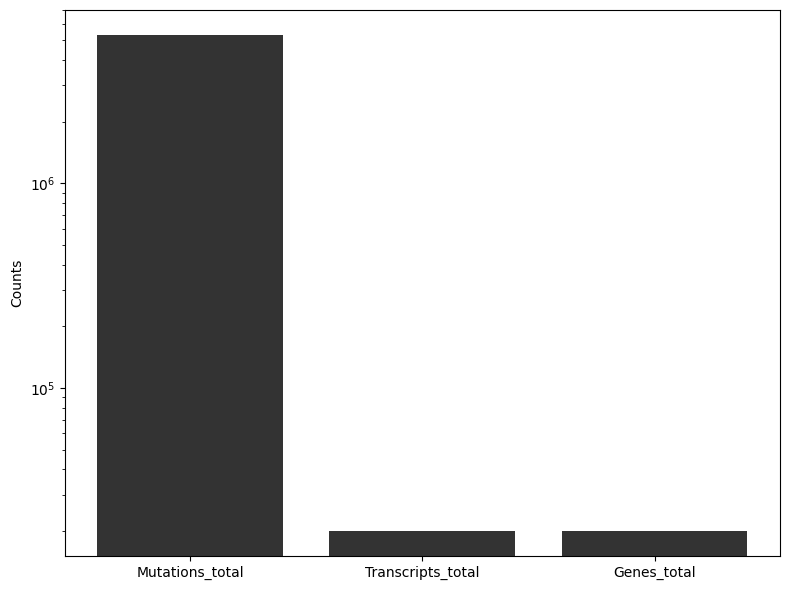

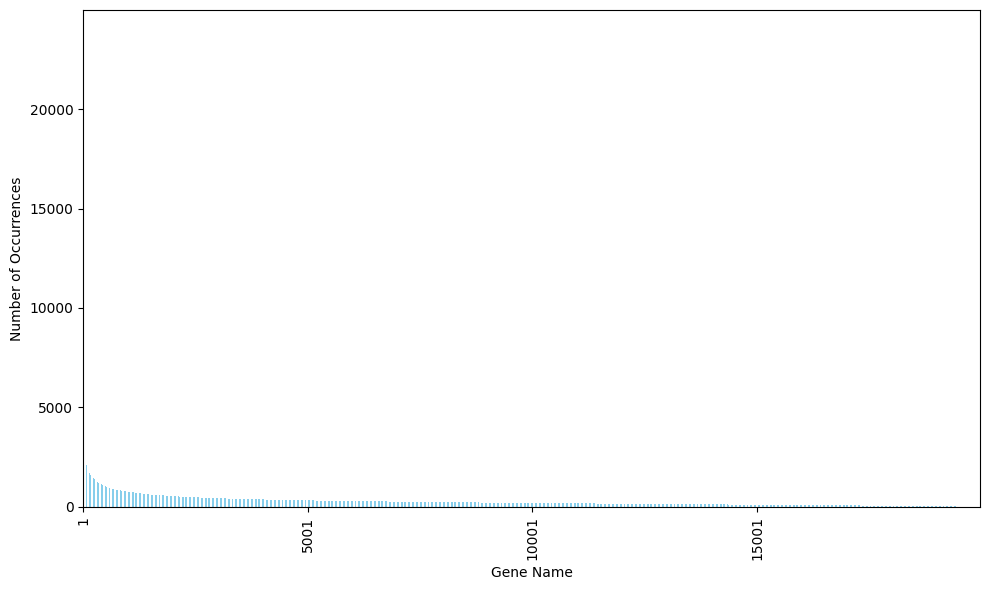

01:30:01 - INFO - Calculating nearby mutations


Processing groups:   0%|                                                                                                               | 0/20013 [00:00<?, ?it/s]

Processing groups:   0%|                                                                                                    | 1/20013 [00:05<28:20:36,  5.10s/it]

Processing groups:   0%|                                                                                                    | 11/20013 [00:05<1:54:25,  2.91it/s]

Processing groups:   0%|                                                                                                      | 21/20013 [00:05<51:01,  6.53it/s]

Processing groups:   0%|▏                                                                                                     | 35/20013 [00:05<25:08, 13.24it/s]

Processing groups:   0%|▎                                                                                                     | 50/20013 [00:05<14:52, 22.37it/s]

Processing groups:   0%|▎                                                                                                     | 64/20013 [00:05<10:15, 32.41it/s]

Processing groups:   0%|▍                                                                                                     | 76/20013 [00:05<08:36, 38.62it/s]

Processing groups:   0%|▍                                                                                                     | 87/20013 [00:05<07:09, 46.42it/s]

Processing groups:   0%|▌                                                                                                     | 99/20013 [00:06<05:55, 55.95it/s]

Processing groups:   1%|▌                                                                                                    | 109/20013 [00:06<05:17, 62.62it/s]

Processing groups:   1%|▌                                                                                                    | 120/20013 [00:06<04:43, 70.29it/s]

Processing groups:   1%|▋                                                                                                    | 132/20013 [00:06<04:08, 80.16it/s]

Processing groups:   1%|▋                                                                                                    | 143/20013 [00:06<04:02, 81.84it/s]

Processing groups:   1%|▊                                                                                                    | 153/20013 [00:06<04:03, 81.66it/s]

Processing groups:   1%|▊                                                                                                    | 164/20013 [00:06<03:47, 87.24it/s]

Processing groups:   1%|▉                                                                                                    | 175/20013 [00:06<03:46, 87.53it/s]

Processing groups:   1%|▉                                                                                                    | 185/20013 [00:06<03:48, 86.89it/s]

Processing groups:   1%|▉                                                                                                    | 198/20013 [00:07<03:25, 96.31it/s]

Processing groups:   1%|█                                                                                                   | 211/20013 [00:07<03:13, 102.23it/s]

Processing groups:   1%|█                                                                                                    | 222/20013 [00:07<03:28, 95.05it/s]

Processing groups:   1%|█▏                                                                                                   | 234/20013 [00:07<03:22, 97.43it/s]

Processing groups:   1%|█▏                                                                                                   | 245/20013 [00:07<03:21, 98.31it/s]

Processing groups:   1%|█▎                                                                                                   | 256/20013 [00:07<03:22, 97.59it/s]

Processing groups:   1%|█▎                                                                                                  | 269/20013 [00:07<03:08, 104.58it/s]

Processing groups:   1%|█▍                                                                                                  | 280/20013 [00:07<03:14, 101.35it/s]

Processing groups:   1%|█▍                                                                                                   | 291/20013 [00:08<03:30, 93.83it/s]

Processing groups:   2%|█▌                                                                                                  | 304/20013 [00:08<03:10, 103.22it/s]

Processing groups:   2%|█▌                                                                                                  | 316/20013 [00:08<03:05, 106.42it/s]

Processing groups:   2%|█▋                                                                                                  | 336/20013 [00:08<02:28, 132.14it/s]

Processing groups:   2%|█▊                                                                                                  | 352/20013 [00:08<02:22, 137.87it/s]

Processing groups:   2%|█▊                                                                                                  | 369/20013 [00:08<02:14, 145.83it/s]

Processing groups:   2%|█▉                                                                                                  | 386/20013 [00:08<02:09, 151.25it/s]

Processing groups:   2%|██                                                                                                  | 402/20013 [00:08<02:19, 140.82it/s]

Processing groups:   2%|██                                                                                                  | 417/20013 [00:08<02:37, 124.33it/s]

Processing groups:   2%|██▏                                                                                                 | 434/20013 [00:09<02:25, 134.70it/s]

Processing groups:   2%|██▏                                                                                                 | 448/20013 [00:09<02:29, 131.29it/s]

Processing groups:   2%|██▎                                                                                                 | 462/20013 [00:09<02:34, 126.22it/s]

Processing groups:   2%|██▎                                                                                                 | 475/20013 [00:09<02:38, 123.04it/s]

Processing groups:   2%|██▍                                                                                                 | 488/20013 [00:09<02:38, 122.86it/s]

Processing groups:   3%|██▌                                                                                                 | 502/20013 [00:09<02:52, 113.22it/s]

Processing groups:   3%|██▌                                                                                                 | 514/20013 [00:09<02:50, 114.40it/s]

Processing groups:   3%|██▋                                                                                                 | 526/20013 [00:09<03:05, 105.01it/s]

Processing groups:   3%|██▋                                                                                                 | 537/20013 [00:09<03:11, 101.44it/s]

Processing groups:   3%|██▊                                                                                                 | 557/20013 [00:10<02:34, 125.66it/s]

Processing groups:   3%|██▊                                                                                                 | 570/20013 [00:10<02:45, 117.66it/s]

Processing groups:   3%|██▉                                                                                                 | 583/20013 [00:10<02:55, 110.91it/s]

Processing groups:   3%|██▉                                                                                                 | 595/20013 [00:10<02:59, 108.24it/s]

Processing groups:   3%|███                                                                                                  | 607/20013 [00:10<03:39, 88.24it/s]

Processing groups:   3%|███                                                                                                 | 622/20013 [00:10<03:09, 102.18it/s]

Processing groups:   3%|███▏                                                                                                 | 634/20013 [00:10<03:38, 88.52it/s]

Processing groups:   3%|███▏                                                                                                | 648/20013 [00:11<03:13, 100.06it/s]

Processing groups:   3%|███▎                                                                                                | 660/20013 [00:11<03:05, 104.22it/s]

Processing groups:   3%|███▎                                                                                                | 675/20013 [00:11<02:47, 115.16it/s]

Processing groups:   3%|███▍                                                                                                | 688/20013 [00:11<02:42, 118.73it/s]

Processing groups:   4%|███▌                                                                                                | 701/20013 [00:11<02:55, 109.90it/s]

Processing groups:   4%|███▌                                                                                                 | 713/20013 [00:11<03:18, 97.45it/s]

Processing groups:   4%|███▋                                                                                                | 727/20013 [00:11<03:00, 106.57it/s]

Processing groups:   4%|███▋                                                                                                | 742/20013 [00:11<02:47, 115.05it/s]

Processing groups:   4%|███▊                                                                                                | 755/20013 [00:11<02:42, 118.22it/s]

Processing groups:   4%|███▊                                                                                                | 769/20013 [00:12<02:36, 122.76it/s]

Processing groups:   4%|███▉                                                                                                | 782/20013 [00:12<02:44, 117.01it/s]

Processing groups:   4%|███▉                                                                                                | 796/20013 [00:12<02:37, 122.05it/s]

Processing groups:   4%|████                                                                                                | 814/20013 [00:12<02:19, 137.36it/s]

Processing groups:   4%|████▏                                                                                               | 832/20013 [00:12<02:09, 148.01it/s]

Processing groups:   4%|████▏                                                                                               | 848/20013 [00:12<02:18, 138.19it/s]

Processing groups:   4%|████▎                                                                                               | 863/20013 [00:12<02:40, 119.40it/s]

Processing groups:   4%|████▍                                                                                               | 876/20013 [00:12<02:36, 121.94it/s]

Processing groups:   4%|████▍                                                                                               | 890/20013 [00:13<02:33, 124.83it/s]

Processing groups:   5%|████▌                                                                                               | 904/20013 [00:13<02:29, 127.51it/s]

Processing groups:   5%|████▌                                                                                               | 918/20013 [00:13<02:29, 127.84it/s]

Processing groups:   5%|████▋                                                                                               | 931/20013 [00:13<02:32, 125.22it/s]

Processing groups:   5%|████▋                                                                                               | 944/20013 [00:13<02:33, 124.11it/s]

Processing groups:   5%|████▊                                                                                               | 960/20013 [00:13<02:22, 133.66it/s]

Processing groups:   5%|████▉                                                                                               | 978/20013 [00:13<02:12, 143.65it/s]

Processing groups:   5%|████▉                                                                                               | 993/20013 [00:13<02:11, 144.43it/s]

Processing groups:   5%|████▉                                                                                              | 1008/20013 [00:13<02:30, 126.09it/s]

Processing groups:   5%|█████                                                                                              | 1022/20013 [00:14<02:42, 116.83it/s]

Processing groups:   5%|█████▏                                                                                              | 1035/20013 [00:14<03:19, 94.97it/s]

Processing groups:   5%|█████▏                                                                                              | 1046/20013 [00:14<03:17, 95.88it/s]

Processing groups:   5%|█████▎                                                                                              | 1057/20013 [00:14<03:13, 97.97it/s]

Processing groups:   5%|█████▎                                                                                             | 1071/20013 [00:14<02:59, 105.31it/s]

Processing groups:   5%|█████▎                                                                                             | 1082/20013 [00:14<03:02, 103.66it/s]

Processing groups:   5%|█████▍                                                                                              | 1093/20013 [00:14<03:34, 88.26it/s]

Processing groups:   6%|█████▍                                                                                             | 1109/20013 [00:14<02:59, 105.24it/s]

Processing groups:   6%|█████▌                                                                                             | 1123/20013 [00:15<02:47, 112.89it/s]

Processing groups:   6%|█████▌                                                                                             | 1135/20013 [00:15<02:50, 110.54it/s]

Processing groups:   6%|█████▋                                                                                             | 1148/20013 [00:15<02:44, 114.92it/s]

Processing groups:   6%|█████▋                                                                                             | 1160/20013 [00:15<02:42, 115.77it/s]

Processing groups:   6%|█████▊                                                                                             | 1175/20013 [00:15<02:39, 118.47it/s]

Processing groups:   6%|█████▉                                                                                             | 1188/20013 [00:15<02:52, 109.00it/s]

Processing groups:   6%|█████▉                                                                                             | 1202/20013 [00:15<02:41, 116.16it/s]

Processing groups:   6%|██████                                                                                             | 1218/20013 [00:15<02:27, 127.24it/s]

Processing groups:   6%|██████                                                                                             | 1233/20013 [00:15<02:22, 132.09it/s]

Processing groups:   6%|██████▏                                                                                            | 1247/20013 [00:16<02:54, 107.40it/s]

Processing groups:   6%|██████▏                                                                                            | 1259/20013 [00:16<02:57, 105.62it/s]

Processing groups:   6%|██████▎                                                                                            | 1273/20013 [00:16<02:47, 111.67it/s]

Processing groups:   6%|██████▎                                                                                            | 1285/20013 [00:16<03:00, 103.66it/s]

Processing groups:   6%|██████▍                                                                                            | 1296/20013 [00:16<03:03, 101.73it/s]

Processing groups:   7%|██████▌                                                                                             | 1307/20013 [00:16<03:48, 82.02it/s]

Processing groups:   7%|██████▌                                                                                             | 1320/20013 [00:16<03:24, 91.59it/s]

Processing groups:   7%|██████▋                                                                                             | 1330/20013 [00:17<03:34, 87.20it/s]

Processing groups:   7%|██████▋                                                                                            | 1346/20013 [00:17<03:05, 100.48it/s]

Processing groups:   7%|██████▊                                                                                             | 1357/20013 [00:17<03:17, 94.55it/s]

Processing groups:   7%|██████▊                                                                                             | 1367/20013 [00:17<03:47, 81.97it/s]

Processing groups:   7%|██████▉                                                                                             | 1376/20013 [00:17<03:42, 83.63it/s]

Processing groups:   7%|██████▉                                                                                             | 1388/20013 [00:17<03:25, 90.78it/s]

Processing groups:   7%|██████▉                                                                                             | 1398/20013 [00:17<03:25, 90.60it/s]

Processing groups:   7%|███████                                                                                             | 1408/20013 [00:18<04:18, 71.91it/s]

Processing groups:   7%|███████                                                                                             | 1420/20013 [00:18<03:47, 81.57it/s]

Processing groups:   7%|███████▏                                                                                            | 1433/20013 [00:18<03:21, 92.22it/s]

Processing groups:   7%|███████▏                                                                                            | 1444/20013 [00:18<03:13, 95.93it/s]

Processing groups:   7%|███████▎                                                                                            | 1455/20013 [00:18<03:31, 87.86it/s]

Processing groups:   7%|███████▎                                                                                            | 1466/20013 [00:18<03:19, 93.10it/s]

Processing groups:   7%|███████▍                                                                                            | 1476/20013 [00:18<03:39, 84.58it/s]

Processing groups:   7%|███████▍                                                                                           | 1493/20013 [00:18<02:56, 104.95it/s]

Processing groups:   8%|███████▍                                                                                           | 1509/20013 [00:18<02:39, 116.07it/s]

Processing groups:   8%|███████▌                                                                                           | 1523/20013 [00:19<02:31, 122.04it/s]

Processing groups:   8%|███████▌                                                                                           | 1537/20013 [00:19<02:27, 125.35it/s]

Processing groups:   8%|███████▋                                                                                           | 1550/20013 [00:19<02:30, 122.93it/s]

Processing groups:   8%|███████▋                                                                                           | 1563/20013 [00:19<02:29, 123.10it/s]

Processing groups:   8%|███████▊                                                                                           | 1578/20013 [00:19<02:21, 130.27it/s]

Processing groups:   8%|███████▉                                                                                           | 1592/20013 [00:19<02:19, 131.75it/s]

Processing groups:   8%|███████▉                                                                                           | 1606/20013 [00:19<02:19, 132.39it/s]

Processing groups:   8%|████████                                                                                           | 1620/20013 [00:19<02:17, 133.47it/s]

Processing groups:   8%|████████                                                                                           | 1634/20013 [00:19<02:19, 131.29it/s]

Processing groups:   8%|████████▏                                                                                          | 1651/20013 [00:20<02:09, 141.66it/s]

Processing groups:   8%|████████▏                                                                                          | 1666/20013 [00:20<02:14, 136.46it/s]

Processing groups:   8%|████████▎                                                                                          | 1683/20013 [00:20<02:20, 130.90it/s]

Processing groups:   8%|████████▍                                                                                          | 1697/20013 [00:20<02:45, 110.53it/s]

Processing groups:   9%|████████▍                                                                                          | 1709/20013 [00:20<02:53, 105.60it/s]

Processing groups:   9%|████████▌                                                                                          | 1720/20013 [00:20<03:00, 101.28it/s]

Processing groups:   9%|████████▋                                                                                           | 1731/20013 [00:20<03:12, 95.07it/s]

Processing groups:   9%|████████▋                                                                                           | 1741/20013 [00:20<03:27, 87.89it/s]

Processing groups:   9%|████████▊                                                                                           | 1752/20013 [00:21<03:20, 91.02it/s]

Processing groups:   9%|████████▊                                                                                           | 1763/20013 [00:21<03:14, 93.78it/s]

Processing groups:   9%|████████▊                                                                                           | 1773/20013 [00:21<03:18, 91.81it/s]

Processing groups:   9%|████████▊                                                                                          | 1787/20013 [00:21<02:56, 103.36it/s]

Processing groups:   9%|████████▉                                                                                           | 1798/20013 [00:21<03:03, 99.34it/s]

Processing groups:   9%|█████████                                                                                           | 1809/20013 [00:21<03:14, 93.64it/s]

Processing groups:   9%|█████████                                                                                          | 1822/20013 [00:21<02:59, 101.18it/s]

Processing groups:   9%|█████████▏                                                                                          | 1833/20013 [00:21<03:08, 96.64it/s]

Processing groups:   9%|█████████▏                                                                                         | 1847/20013 [00:22<02:48, 107.86it/s]

Processing groups:   9%|█████████▏                                                                                         | 1859/20013 [00:22<02:44, 110.04it/s]

Processing groups:   9%|█████████▎                                                                                          | 1871/20013 [00:22<03:02, 99.19it/s]

Processing groups:   9%|█████████▎                                                                                         | 1883/20013 [00:22<02:57, 102.25it/s]

Processing groups:   9%|█████████▍                                                                                          | 1894/20013 [00:22<03:06, 97.39it/s]

Processing groups:  10%|█████████▌                                                                                          | 1904/20013 [00:22<03:21, 89.88it/s]

Processing groups:  10%|█████████▌                                                                                          | 1914/20013 [00:22<03:18, 91.29it/s]

Processing groups:  10%|█████████▌                                                                                         | 1928/20013 [00:22<02:59, 100.80it/s]

Processing groups:  10%|█████████▌                                                                                         | 1941/20013 [00:22<02:49, 106.88it/s]

Processing groups:  10%|█████████▋                                                                                         | 1952/20013 [00:23<02:51, 105.09it/s]

Processing groups:  10%|█████████▊                                                                                          | 1963/20013 [00:23<03:33, 84.71it/s]

Processing groups:  10%|█████████▊                                                                                          | 1976/20013 [00:23<03:19, 90.58it/s]

Processing groups:  10%|█████████▉                                                                                          | 1989/20013 [00:23<03:01, 99.47it/s]

Processing groups:  10%|█████████▉                                                                                          | 2000/20013 [00:23<03:08, 95.59it/s]

Processing groups:  10%|██████████                                                                                          | 2010/20013 [00:23<03:34, 83.77it/s]

Processing groups:  10%|██████████                                                                                          | 2025/20013 [00:24<04:30, 66.53it/s]

Processing groups:  10%|██████████▏                                                                                         | 2036/20013 [00:24<04:02, 74.23it/s]

Processing groups:  10%|██████████▏                                                                                         | 2045/20013 [00:24<04:12, 71.10it/s]

Processing groups:  10%|██████████▎                                                                                         | 2054/20013 [00:24<04:00, 74.69it/s]

Processing groups:  10%|██████████▎                                                                                         | 2063/20013 [00:24<03:58, 75.32it/s]

Processing groups:  10%|██████████▎                                                                                         | 2072/20013 [00:24<04:06, 72.70it/s]

Processing groups:  10%|██████████▍                                                                                         | 2080/20013 [00:24<04:08, 72.22it/s]

Processing groups:  10%|██████████▍                                                                                         | 2088/20013 [00:24<04:05, 73.11it/s]

Processing groups:  10%|██████████▍                                                                                         | 2099/20013 [00:25<03:41, 80.98it/s]

Processing groups:  11%|██████████▌                                                                                         | 2112/20013 [00:25<03:11, 93.43it/s]

Processing groups:  11%|██████████▌                                                                                         | 2124/20013 [00:25<03:04, 96.93it/s]

Processing groups:  11%|██████████▌                                                                                        | 2136/20013 [00:25<02:53, 103.03it/s]

Processing groups:  11%|██████████▋                                                                                        | 2148/20013 [00:25<02:54, 102.64it/s]

Processing groups:  11%|██████████▊                                                                                         | 2159/20013 [00:25<03:06, 95.98it/s]

Processing groups:  11%|██████████▋                                                                                        | 2173/20013 [00:25<02:49, 105.17it/s]

Processing groups:  11%|██████████▊                                                                                        | 2184/20013 [00:25<02:47, 106.42it/s]

Processing groups:  11%|██████████▊                                                                                        | 2198/20013 [00:25<02:40, 111.33it/s]

Processing groups:  11%|██████████▉                                                                                        | 2210/20013 [00:26<02:44, 108.30it/s]

Processing groups:  11%|███████████                                                                                        | 2224/20013 [00:26<02:32, 116.62it/s]

Processing groups:  11%|███████████                                                                                        | 2236/20013 [00:26<02:31, 117.16it/s]

Processing groups:  11%|███████████                                                                                        | 2248/20013 [00:26<02:33, 115.46it/s]

Processing groups:  11%|███████████▏                                                                                       | 2260/20013 [00:26<02:36, 113.09it/s]

Processing groups:  11%|███████████▎                                                                                       | 2279/20013 [00:26<02:11, 134.48it/s]

Processing groups:  11%|███████████▎                                                                                       | 2293/20013 [00:26<02:25, 121.43it/s]

Processing groups:  12%|███████████▍                                                                                       | 2306/20013 [00:26<02:53, 102.28it/s]

Processing groups:  12%|███████████▍                                                                                       | 2319/20013 [00:26<02:43, 108.26it/s]

Processing groups:  12%|███████████▌                                                                                       | 2331/20013 [00:27<02:40, 109.96it/s]

Processing groups:  12%|███████████▌                                                                                       | 2343/20013 [00:27<02:43, 107.87it/s]

Processing groups:  12%|███████████▋                                                                                       | 2355/20013 [00:27<02:51, 103.17it/s]

Processing groups:  12%|███████████▊                                                                                        | 2366/20013 [00:27<02:59, 98.37it/s]

Processing groups:  12%|███████████▉                                                                                        | 2377/20013 [00:27<03:07, 93.87it/s]

Processing groups:  12%|███████████▉                                                                                        | 2387/20013 [00:27<03:17, 89.31it/s]

Processing groups:  12%|███████████▉                                                                                       | 2403/20013 [00:27<02:46, 105.96it/s]

Processing groups:  12%|████████████                                                                                        | 2414/20013 [00:28<03:25, 85.49it/s]

Processing groups:  12%|████████████                                                                                        | 2424/20013 [00:28<03:21, 87.11it/s]

Processing groups:  12%|████████████▏                                                                                       | 2435/20013 [00:28<03:14, 90.56it/s]

Processing groups:  12%|████████████▏                                                                                       | 2445/20013 [00:28<03:15, 89.76it/s]

Processing groups:  12%|████████████▎                                                                                       | 2455/20013 [00:28<03:34, 81.91it/s]

Processing groups:  12%|████████████▎                                                                                       | 2464/20013 [00:28<03:45, 77.66it/s]

Processing groups:  12%|████████████▎                                                                                       | 2472/20013 [00:28<03:55, 74.58it/s]

Processing groups:  12%|████████████▍                                                                                       | 2483/20013 [00:28<03:38, 80.39it/s]

Processing groups:  12%|████████████▍                                                                                       | 2492/20013 [00:28<03:44, 78.11it/s]

Processing groups:  12%|████████████▍                                                                                       | 2501/20013 [00:29<04:07, 70.80it/s]

Processing groups:  13%|████████████▌                                                                                       | 2513/20013 [00:29<03:40, 79.27it/s]

Processing groups:  13%|████████████▋                                                                                       | 2527/20013 [00:29<03:06, 93.92it/s]

Processing groups:  13%|████████████▋                                                                                       | 2537/20013 [00:29<03:33, 81.99it/s]

Processing groups:  13%|████████████▋                                                                                       | 2548/20013 [00:29<03:25, 84.85it/s]

Processing groups:  13%|████████████▊                                                                                       | 2560/20013 [00:29<03:07, 93.04it/s]

Processing groups:  13%|████████████▊                                                                                       | 2570/20013 [00:29<03:15, 89.06it/s]

Processing groups:  13%|████████████▉                                                                                       | 2580/20013 [00:30<04:17, 67.58it/s]

Processing groups:  13%|████████████▉                                                                                       | 2588/20013 [00:30<04:17, 67.58it/s]

Processing groups:  13%|████████████▉                                                                                       | 2600/20013 [00:30<03:39, 79.43it/s]

Processing groups:  13%|█████████████                                                                                       | 2609/20013 [00:30<03:38, 79.67it/s]

Processing groups:  13%|█████████████                                                                                       | 2618/20013 [00:30<04:16, 67.72it/s]

Processing groups:  13%|█████████████▏                                                                                      | 2627/20013 [00:30<03:59, 72.70it/s]

Processing groups:  13%|█████████████▏                                                                                      | 2636/20013 [00:30<04:22, 66.32it/s]

Processing groups:  13%|█████████████▏                                                                                      | 2644/20013 [00:30<04:12, 68.87it/s]

Processing groups:  13%|█████████████▎                                                                                      | 2652/20013 [00:31<04:17, 67.43it/s]

Processing groups:  13%|█████████████▎                                                                                      | 2662/20013 [00:31<04:01, 71.86it/s]

Processing groups:  13%|█████████████▎                                                                                      | 2672/20013 [00:31<03:39, 78.91it/s]

Processing groups:  13%|█████████████▍                                                                                      | 2682/20013 [00:31<03:36, 80.00it/s]

Processing groups:  13%|█████████████▍                                                                                      | 2691/20013 [00:31<04:02, 71.39it/s]

Processing groups:  13%|█████████████▍                                                                                      | 2699/20013 [00:31<04:05, 70.58it/s]

Processing groups:  14%|█████████████▌                                                                                      | 2708/20013 [00:31<03:52, 74.37it/s]

Processing groups:  14%|█████████████▌                                                                                      | 2716/20013 [00:31<03:49, 75.48it/s]

Processing groups:  14%|█████████████▋                                                                                      | 2727/20013 [00:32<03:25, 84.20it/s]

Processing groups:  14%|█████████████▋                                                                                      | 2739/20013 [00:32<03:07, 92.25it/s]

Processing groups:  14%|█████████████▋                                                                                      | 2749/20013 [00:32<03:06, 92.80it/s]

Processing groups:  14%|█████████████▊                                                                                      | 2759/20013 [00:32<03:19, 86.28it/s]

Processing groups:  14%|█████████████▊                                                                                      | 2768/20013 [00:32<03:19, 86.47it/s]

Processing groups:  14%|█████████████▉                                                                                      | 2779/20013 [00:32<03:36, 79.63it/s]

Processing groups:  14%|█████████████▉                                                                                      | 2790/20013 [00:32<03:20, 86.10it/s]

Processing groups:  14%|██████████████                                                                                      | 2802/20013 [00:32<03:02, 94.21it/s]

Processing groups:  14%|██████████████                                                                                      | 2812/20013 [00:33<03:23, 84.58it/s]

Processing groups:  14%|██████████████                                                                                      | 2821/20013 [00:33<03:45, 76.10it/s]

Processing groups:  14%|██████████████▏                                                                                     | 2830/20013 [00:33<03:37, 78.88it/s]

Processing groups:  14%|██████████████▏                                                                                     | 2841/20013 [00:33<03:19, 86.23it/s]

Processing groups:  14%|██████████████▏                                                                                     | 2850/20013 [00:33<03:37, 78.86it/s]

Processing groups:  14%|██████████████▎                                                                                     | 2860/20013 [00:33<03:23, 84.22it/s]

Processing groups:  14%|██████████████▎                                                                                     | 2871/20013 [00:33<03:13, 88.74it/s]

Processing groups:  14%|██████████████▍                                                                                     | 2881/20013 [00:33<03:48, 74.94it/s]

Processing groups:  14%|██████████████▍                                                                                     | 2890/20013 [00:34<03:55, 72.77it/s]

Processing groups:  14%|██████████████▍                                                                                     | 2898/20013 [00:34<04:07, 69.25it/s]

Processing groups:  15%|██████████████▌                                                                                     | 2907/20013 [00:34<03:50, 74.12it/s]

Processing groups:  15%|██████████████▌                                                                                     | 2918/20013 [00:34<03:28, 81.86it/s]

Processing groups:  15%|██████████████▋                                                                                     | 2928/20013 [00:34<03:18, 85.98it/s]

Processing groups:  15%|██████████████▋                                                                                     | 2937/20013 [00:34<03:20, 85.26it/s]

Processing groups:  15%|██████████████▋                                                                                     | 2946/20013 [00:34<03:36, 78.88it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2955/20013 [00:34<03:34, 79.62it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2966/20013 [00:34<03:18, 85.92it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2975/20013 [00:35<03:50, 74.03it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2983/20013 [00:35<04:21, 65.02it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2990/20013 [00:35<04:32, 62.40it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2998/20013 [00:35<04:44, 59.78it/s]

Processing groups:  15%|███████████████                                                                                     | 3011/20013 [00:35<03:44, 75.88it/s]

Processing groups:  15%|███████████████                                                                                     | 3020/20013 [00:35<03:42, 76.21it/s]

Processing groups:  15%|███████████████▏                                                                                    | 3029/20013 [00:35<03:35, 78.88it/s]

Processing groups:  15%|███████████████▏                                                                                    | 3038/20013 [00:36<04:04, 69.39it/s]

Processing groups:  15%|███████████████▏                                                                                    | 3050/20013 [00:36<03:45, 75.19it/s]

Processing groups:  15%|███████████████▎                                                                                    | 3059/20013 [00:36<03:36, 78.24it/s]

Processing groups:  15%|███████████████▎                                                                                    | 3068/20013 [00:36<03:38, 77.70it/s]

Processing groups:  15%|███████████████▎                                                                                    | 3076/20013 [00:36<03:37, 77.99it/s]

Processing groups:  15%|███████████████▍                                                                                    | 3088/20013 [00:36<03:13, 87.41it/s]

Processing groups:  15%|███████████████▍                                                                                    | 3099/20013 [00:36<03:04, 91.92it/s]

Processing groups:  16%|███████████████▌                                                                                    | 3109/20013 [00:36<03:36, 77.98it/s]

Processing groups:  16%|███████████████▌                                                                                    | 3118/20013 [00:37<04:24, 63.79it/s]

Processing groups:  16%|███████████████▌                                                                                    | 3126/20013 [00:37<04:13, 66.50it/s]

Processing groups:  16%|███████████████▋                                                                                    | 3136/20013 [00:37<03:50, 73.27it/s]

Processing groups:  16%|███████████████▋                                                                                    | 3147/20013 [00:37<03:25, 82.17it/s]

Processing groups:  16%|███████████████▊                                                                                    | 3156/20013 [00:37<03:40, 76.48it/s]

Processing groups:  16%|███████████████▊                                                                                    | 3166/20013 [00:37<03:27, 81.08it/s]

Processing groups:  16%|███████████████▊                                                                                    | 3176/20013 [00:37<03:18, 84.98it/s]

Processing groups:  16%|███████████████▉                                                                                    | 3187/20013 [00:37<03:09, 88.89it/s]

Processing groups:  16%|███████████████▉                                                                                    | 3197/20013 [00:38<03:40, 76.33it/s]

Processing groups:  16%|████████████████                                                                                    | 3208/20013 [00:38<03:20, 83.81it/s]

Processing groups:  16%|████████████████                                                                                    | 3218/20013 [00:38<03:15, 85.97it/s]

Processing groups:  16%|████████████████                                                                                    | 3227/20013 [00:38<03:36, 77.44it/s]

Processing groups:  16%|████████████████▏                                                                                   | 3236/20013 [00:38<03:42, 75.30it/s]

Processing groups:  16%|████████████████▏                                                                                   | 3244/20013 [00:38<03:49, 72.94it/s]

Processing groups:  16%|████████████████▎                                                                                   | 3255/20013 [00:38<03:24, 82.12it/s]

Processing groups:  16%|████████████████▎                                                                                   | 3269/20013 [00:38<02:52, 97.15it/s]

Processing groups:  16%|████████████████▍                                                                                   | 3280/20013 [00:38<02:50, 98.06it/s]

Processing groups:  16%|████████████████▎                                                                                  | 3293/20013 [00:39<02:37, 106.46it/s]

Processing groups:  17%|████████████████▌                                                                                   | 3304/20013 [00:39<03:20, 83.44it/s]

Processing groups:  17%|████████████████▌                                                                                   | 3317/20013 [00:39<02:58, 93.68it/s]

Processing groups:  17%|████████████████▋                                                                                   | 3328/20013 [00:39<03:00, 92.41it/s]

Processing groups:  17%|████████████████▌                                                                                  | 3342/20013 [00:39<02:40, 103.64it/s]

Processing groups:  17%|████████████████▌                                                                                  | 3355/20013 [00:39<02:40, 104.03it/s]

Processing groups:  17%|████████████████▋                                                                                  | 3366/20013 [00:39<02:43, 101.60it/s]

Processing groups:  17%|████████████████▊                                                                                   | 3377/20013 [00:39<02:48, 98.92it/s]

Processing groups:  17%|████████████████▉                                                                                   | 3388/20013 [00:40<03:20, 83.03it/s]

Processing groups:  17%|████████████████▉                                                                                   | 3397/20013 [00:40<03:18, 83.53it/s]

Processing groups:  17%|█████████████████                                                                                   | 3406/20013 [00:40<03:26, 80.53it/s]

Processing groups:  17%|█████████████████                                                                                   | 3419/20013 [00:40<03:14, 85.23it/s]

Processing groups:  17%|█████████████████▏                                                                                  | 3428/20013 [00:40<03:23, 81.44it/s]

Processing groups:  17%|█████████████████▏                                                                                  | 3438/20013 [00:40<03:32, 77.83it/s]

Processing groups:  17%|█████████████████▏                                                                                  | 3448/20013 [00:41<09:51, 28.02it/s]

Processing groups:  17%|█████████████████▎                                                                                  | 3457/20013 [00:41<07:59, 34.52it/s]

Processing groups:  17%|█████████████████▎                                                                                  | 3466/20013 [00:41<06:37, 41.63it/s]

Processing groups:  17%|█████████████████▎                                                                                  | 3477/20013 [00:41<05:20, 51.66it/s]

Processing groups:  17%|█████████████████▍                                                                                  | 3490/20013 [00:42<04:12, 65.41it/s]

Processing groups:  18%|█████████████████▌                                                                                  | 3503/20013 [00:42<03:38, 75.71it/s]

Processing groups:  18%|█████████████████▌                                                                                  | 3516/20013 [00:42<03:11, 86.15it/s]

Processing groups:  18%|█████████████████▋                                                                                  | 3528/20013 [00:42<02:56, 93.32it/s]

Processing groups:  18%|█████████████████▌                                                                                 | 3544/20013 [00:42<02:42, 101.56it/s]

Processing groups:  18%|█████████████████▊                                                                                  | 3556/20013 [00:42<03:14, 84.50it/s]

Processing groups:  18%|█████████████████▊                                                                                  | 3566/20013 [00:42<03:12, 85.29it/s]

Processing groups:  18%|█████████████████▊                                                                                  | 3577/20013 [00:42<03:03, 89.60it/s]

Processing groups:  18%|█████████████████▉                                                                                  | 3590/20013 [00:43<02:45, 98.95it/s]

Processing groups:  18%|█████████████████▊                                                                                 | 3601/20013 [00:43<02:43, 100.20it/s]

Processing groups:  18%|██████████████████                                                                                  | 3612/20013 [00:43<02:45, 99.13it/s]

Processing groups:  18%|██████████████████                                                                                  | 3623/20013 [00:43<02:57, 92.18it/s]

Processing groups:  18%|█████████████████▉                                                                                 | 3637/20013 [00:43<02:38, 103.39it/s]

Processing groups:  18%|██████████████████▏                                                                                 | 3648/20013 [00:43<02:52, 95.08it/s]

Processing groups:  18%|██████████████████                                                                                 | 3662/20013 [00:43<02:40, 102.15it/s]

Processing groups:  18%|██████████████████▎                                                                                 | 3673/20013 [00:43<03:02, 89.62it/s]

Processing groups:  18%|██████████████████▏                                                                                | 3689/20013 [00:44<02:36, 104.17it/s]

Processing groups:  18%|██████████████████▍                                                                                 | 3700/20013 [00:44<02:49, 96.03it/s]

Processing groups:  19%|██████████████████▌                                                                                 | 3711/20013 [00:44<02:54, 93.57it/s]

Processing groups:  19%|██████████████████▌                                                                                 | 3721/20013 [00:44<02:54, 93.55it/s]

Processing groups:  19%|██████████████████▍                                                                                | 3736/20013 [00:44<02:31, 107.69it/s]

Processing groups:  19%|██████████████████▌                                                                                | 3748/20013 [00:44<02:37, 103.07it/s]

Processing groups:  19%|██████████████████▌                                                                                | 3759/20013 [00:44<02:40, 101.49it/s]

Processing groups:  19%|██████████████████▊                                                                                 | 3770/20013 [00:44<03:02, 89.10it/s]

Processing groups:  19%|██████████████████▉                                                                                 | 3780/20013 [00:45<03:00, 90.01it/s]

Processing groups:  19%|██████████████████▉                                                                                 | 3790/20013 [00:45<03:07, 86.64it/s]

Processing groups:  19%|██████████████████▉                                                                                 | 3801/20013 [00:45<02:57, 91.20it/s]

Processing groups:  19%|███████████████████                                                                                 | 3812/20013 [00:45<02:50, 95.06it/s]

Processing groups:  19%|██████████████████▉                                                                                | 3825/20013 [00:45<02:35, 103.80it/s]

Processing groups:  19%|██████████████████▉                                                                                | 3837/20013 [00:45<02:29, 107.89it/s]

Processing groups:  19%|███████████████████▏                                                                                | 3848/20013 [00:45<03:35, 74.86it/s]

Processing groups:  19%|███████████████████▎                                                                                | 3860/20013 [00:45<03:12, 84.02it/s]

Processing groups:  19%|███████████████████▎                                                                                | 3870/20013 [00:46<03:16, 82.06it/s]

Processing groups:  19%|███████████████████▍                                                                                | 3880/20013 [00:46<03:41, 72.90it/s]

Processing groups:  19%|███████████████████▍                                                                                | 3892/20013 [00:46<03:13, 83.36it/s]

Processing groups:  20%|███████████████████▌                                                                                | 3905/20013 [00:46<02:51, 94.17it/s]

Processing groups:  20%|███████████████████▍                                                                               | 3919/20013 [00:46<02:34, 104.26it/s]

Processing groups:  20%|███████████████████▍                                                                               | 3932/20013 [00:46<02:31, 106.39it/s]

Processing groups:  20%|███████████████████▌                                                                               | 3944/20013 [00:46<02:38, 101.69it/s]

Processing groups:  20%|███████████████████▌                                                                               | 3957/20013 [00:46<02:27, 108.69it/s]

Processing groups:  20%|███████████████████▋                                                                               | 3969/20013 [00:47<02:40, 100.14it/s]

Processing groups:  20%|███████████████████▉                                                                                | 3980/20013 [00:47<03:23, 78.75it/s]

Processing groups:  20%|███████████████████▉                                                                                | 3994/20013 [00:47<02:56, 90.72it/s]

Processing groups:  20%|████████████████████                                                                                | 4005/20013 [00:47<02:53, 92.32it/s]

Processing groups:  20%|████████████████████                                                                                | 4015/20013 [00:47<02:57, 90.22it/s]

Processing groups:  20%|████████████████████                                                                                | 4025/20013 [00:47<03:18, 80.48it/s]

Processing groups:  20%|████████████████████▏                                                                               | 4036/20013 [00:47<03:05, 86.14it/s]

Processing groups:  20%|████████████████████▏                                                                               | 4046/20013 [00:48<03:18, 80.45it/s]

Processing groups:  20%|████████████████████▎                                                                               | 4057/20013 [00:48<03:03, 86.93it/s]

Processing groups:  20%|████████████████████▎                                                                               | 4067/20013 [00:48<03:13, 82.27it/s]

Processing groups:  20%|████████████████████▎                                                                               | 4076/20013 [00:48<03:44, 70.99it/s]

Processing groups:  20%|████████████████████▍                                                                               | 4089/20013 [00:48<03:26, 77.16it/s]

Processing groups:  20%|████████████████████▍                                                                               | 4100/20013 [00:48<03:08, 84.49it/s]

Processing groups:  21%|████████████████████▌                                                                               | 4109/20013 [00:48<03:10, 83.43it/s]

Processing groups:  21%|████████████████████▌                                                                               | 4118/20013 [00:48<03:27, 76.74it/s]

Processing groups:  21%|████████████████████▋                                                                               | 4128/20013 [00:49<03:13, 81.90it/s]

Processing groups:  21%|████████████████████▋                                                                               | 4140/20013 [00:49<02:53, 91.37it/s]

Processing groups:  21%|████████████████████▋                                                                               | 4151/20013 [00:49<02:47, 94.49it/s]

Processing groups:  21%|████████████████████▌                                                                              | 4166/20013 [00:49<02:30, 105.24it/s]

Processing groups:  21%|████████████████████▋                                                                              | 4177/20013 [00:49<02:36, 101.21it/s]

Processing groups:  21%|████████████████████▉                                                                               | 4188/20013 [00:49<02:40, 98.49it/s]

Processing groups:  21%|████████████████████▉                                                                               | 4198/20013 [00:49<02:46, 94.72it/s]

Processing groups:  21%|█████████████████████                                                                               | 4208/20013 [00:49<02:55, 90.09it/s]

Processing groups:  21%|█████████████████████                                                                               | 4219/20013 [00:49<02:51, 92.12it/s]

Processing groups:  21%|████████████████████▉                                                                              | 4232/20013 [00:50<02:35, 101.45it/s]

Processing groups:  21%|█████████████████████▏                                                                              | 4243/20013 [00:50<02:53, 90.74it/s]

Processing groups:  21%|█████████████████████▎                                                                              | 4253/20013 [00:50<02:52, 91.55it/s]

Processing groups:  21%|█████████████████████▎                                                                              | 4263/20013 [00:50<03:15, 80.69it/s]

Processing groups:  21%|█████████████████████▎                                                                              | 4272/20013 [00:50<03:13, 81.47it/s]

Processing groups:  21%|█████████████████████▍                                                                              | 4283/20013 [00:50<03:05, 84.73it/s]

Processing groups:  21%|█████████████████████▍                                                                              | 4292/20013 [00:50<03:05, 84.54it/s]

Processing groups:  21%|█████████████████████▍                                                                              | 4302/20013 [00:50<02:57, 88.63it/s]

Processing groups:  22%|█████████████████████▌                                                                              | 4312/20013 [00:51<02:55, 89.65it/s]

Processing groups:  22%|█████████████████████▌                                                                              | 4324/20013 [00:51<02:43, 95.82it/s]

Processing groups:  22%|█████████████████████▍                                                                             | 4336/20013 [00:51<02:36, 100.36it/s]

Processing groups:  22%|█████████████████████▌                                                                             | 4351/20013 [00:51<02:20, 111.12it/s]

Processing groups:  22%|█████████████████████▊                                                                              | 4363/20013 [00:51<03:28, 75.21it/s]

Processing groups:  22%|█████████████████████▊                                                                              | 4373/20013 [00:51<03:25, 76.00it/s]

Processing groups:  22%|█████████████████████▉                                                                              | 4386/20013 [00:51<03:00, 86.69it/s]

Processing groups:  22%|█████████████████████▉                                                                              | 4396/20013 [00:51<03:02, 85.76it/s]

Processing groups:  22%|██████████████████████                                                                              | 4410/20013 [00:52<02:38, 98.42it/s]

Processing groups:  22%|██████████████████████                                                                              | 4421/20013 [00:52<02:47, 93.04it/s]

Processing groups:  22%|██████████████████████▏                                                                             | 4432/20013 [00:52<02:40, 97.23it/s]

Processing groups:  22%|█████████████████████▉                                                                             | 4447/20013 [00:52<02:25, 107.13it/s]

Processing groups:  22%|██████████████████████                                                                             | 4460/20013 [00:52<02:17, 112.96it/s]

Processing groups:  22%|██████████████████████                                                                             | 4472/20013 [00:52<02:28, 104.92it/s]

Processing groups:  22%|██████████████████████▏                                                                            | 4485/20013 [00:52<02:20, 110.47it/s]

Processing groups:  22%|██████████████████████▎                                                                            | 4501/20013 [00:52<02:14, 115.33it/s]

Processing groups:  23%|██████████████████████▎                                                                            | 4516/20013 [00:53<02:06, 122.91it/s]

Processing groups:  23%|██████████████████████▍                                                                            | 4529/20013 [00:53<02:09, 119.24it/s]

Processing groups:  23%|██████████████████████▍                                                                            | 4542/20013 [00:53<02:16, 113.39it/s]

Processing groups:  23%|██████████████████████▌                                                                            | 4554/20013 [00:53<02:16, 113.00it/s]

Processing groups:  23%|██████████████████████▌                                                                            | 4567/20013 [00:53<02:12, 116.84it/s]

Processing groups:  23%|██████████████████████▋                                                                            | 4582/20013 [00:53<02:05, 123.02it/s]

Processing groups:  23%|██████████████████████▊                                                                            | 4599/20013 [00:53<01:54, 134.84it/s]

Processing groups:  23%|██████████████████████▊                                                                            | 4613/20013 [00:53<02:08, 120.07it/s]

Processing groups:  23%|██████████████████████▉                                                                            | 4627/20013 [00:53<02:03, 124.43it/s]

Processing groups:  23%|██████████████████████▉                                                                            | 4641/20013 [00:54<02:03, 123.99it/s]

Processing groups:  23%|███████████████████████                                                                            | 4654/20013 [00:54<02:16, 112.61it/s]

Processing groups:  23%|███████████████████████                                                                            | 4666/20013 [00:54<02:16, 112.28it/s]

Processing groups:  23%|███████████████████████▏                                                                           | 4678/20013 [00:54<02:24, 105.76it/s]

Processing groups:  23%|███████████████████████▍                                                                            | 4689/20013 [00:54<02:47, 91.22it/s]

Processing groups:  23%|███████████████████████▍                                                                            | 4699/20013 [00:54<02:49, 90.37it/s]

Processing groups:  24%|███████████████████████▌                                                                            | 4709/20013 [00:54<02:46, 91.87it/s]

Processing groups:  24%|███████████████████████▌                                                                            | 4721/20013 [00:54<02:34, 98.73it/s]

Processing groups:  24%|███████████████████████▍                                                                           | 4733/20013 [00:55<02:30, 101.84it/s]

Processing groups:  24%|███████████████████████▍                                                                           | 4745/20013 [00:55<02:25, 104.60it/s]

Processing groups:  24%|███████████████████████▌                                                                           | 4756/20013 [00:55<02:29, 102.34it/s]

Processing groups:  24%|███████████████████████▊                                                                            | 4767/20013 [00:55<02:48, 90.63it/s]

Processing groups:  24%|███████████████████████▉                                                                            | 4781/20013 [00:55<02:33, 98.96it/s]

Processing groups:  24%|███████████████████████▋                                                                           | 4794/20013 [00:55<02:22, 106.57it/s]

Processing groups:  24%|████████████████████████                                                                            | 4805/20013 [00:55<02:34, 98.48it/s]

Processing groups:  24%|███████████████████████▊                                                                           | 4819/20013 [00:55<02:20, 108.12it/s]

Processing groups:  24%|███████████████████████▉                                                                           | 4831/20013 [00:55<02:20, 108.27it/s]

Processing groups:  24%|███████████████████████▉                                                                           | 4845/20013 [00:56<02:11, 115.23it/s]

Processing groups:  24%|████████████████████████                                                                           | 4860/20013 [00:56<02:03, 122.92it/s]

Processing groups:  24%|████████████████████████                                                                           | 4873/20013 [00:56<02:01, 124.22it/s]

Processing groups:  24%|████████████████████████▏                                                                          | 4888/20013 [00:56<02:16, 110.83it/s]

Processing groups:  24%|████████████████████████▏                                                                          | 4900/20013 [00:56<02:21, 107.17it/s]

Processing groups:  25%|████████████████████████▎                                                                          | 4912/20013 [00:56<02:25, 103.76it/s]

Processing groups:  25%|████████████████████████▌                                                                           | 4923/20013 [00:56<02:33, 98.41it/s]

Processing groups:  25%|████████████████████████▍                                                                          | 4934/20013 [00:56<02:29, 100.72it/s]

Processing groups:  25%|████████████████████████▍                                                                          | 4945/20013 [00:57<02:29, 100.68it/s]

Processing groups:  25%|████████████████████████▌                                                                          | 4957/20013 [00:57<02:22, 105.52it/s]

Processing groups:  25%|████████████████████████▌                                                                          | 4971/20013 [00:57<02:12, 113.59it/s]

Processing groups:  25%|████████████████████████▋                                                                          | 4983/20013 [00:57<02:11, 114.17it/s]

Processing groups:  25%|████████████████████████▉                                                                           | 4995/20013 [00:57<02:36, 96.18it/s]

Processing groups:  25%|█████████████████████████                                                                           | 5006/20013 [00:57<02:40, 93.26it/s]

Processing groups:  25%|█████████████████████████                                                                           | 5016/20013 [00:57<03:51, 64.87it/s]

Processing groups:  25%|█████████████████████████                                                                           | 5025/20013 [00:58<03:35, 69.58it/s]

Processing groups:  25%|█████████████████████████▏                                                                          | 5036/20013 [00:58<03:11, 78.35it/s]

Processing groups:  25%|█████████████████████████▏                                                                          | 5046/20013 [00:58<03:00, 83.08it/s]

Processing groups:  25%|█████████████████████████▎                                                                          | 5056/20013 [00:58<03:15, 76.43it/s]

Processing groups:  25%|█████████████████████████▎                                                                          | 5065/20013 [00:58<04:01, 61.88it/s]

Processing groups:  25%|█████████████████████████▎                                                                          | 5073/20013 [00:58<03:47, 65.67it/s]

Processing groups:  25%|█████████████████████████▍                                                                          | 5084/20013 [00:58<03:20, 74.63it/s]

Processing groups:  25%|█████████████████████████▍                                                                          | 5097/20013 [00:58<02:49, 88.12it/s]

Processing groups:  26%|█████████████████████████▌                                                                          | 5107/20013 [00:59<02:46, 89.41it/s]

Processing groups:  26%|█████████████████████████▌                                                                          | 5119/20013 [00:59<02:35, 95.78it/s]

Processing groups:  26%|█████████████████████████▍                                                                         | 5131/20013 [00:59<02:28, 100.17it/s]

Processing groups:  26%|█████████████████████████▋                                                                          | 5142/20013 [00:59<02:34, 96.16it/s]

Processing groups:  26%|█████████████████████████▌                                                                         | 5155/20013 [00:59<02:24, 102.92it/s]

Processing groups:  26%|█████████████████████████▌                                                                         | 5166/20013 [00:59<02:26, 101.41it/s]

Processing groups:  26%|█████████████████████████▌                                                                         | 5180/20013 [00:59<02:16, 108.37it/s]

Processing groups:  26%|█████████████████████████▉                                                                          | 5191/20013 [00:59<02:32, 96.89it/s]

Processing groups:  26%|█████████████████████████▋                                                                         | 5203/20013 [00:59<02:24, 102.23it/s]

Processing groups:  26%|█████████████████████████▊                                                                         | 5215/20013 [01:00<02:22, 103.67it/s]

Processing groups:  26%|█████████████████████████▊                                                                         | 5226/20013 [01:00<02:20, 104.90it/s]

Processing groups:  26%|█████████████████████████▉                                                                         | 5240/20013 [01:00<02:12, 111.68it/s]

Processing groups:  26%|█████████████████████████▉                                                                         | 5253/20013 [01:00<02:07, 116.00it/s]

Processing groups:  26%|██████████████████████████                                                                         | 5267/20013 [01:00<02:00, 122.36it/s]

Processing groups:  26%|██████████████████████████                                                                         | 5280/20013 [01:00<02:25, 101.44it/s]

Processing groups:  26%|██████████████████████████▏                                                                        | 5294/20013 [01:00<02:14, 109.25it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5306/20013 [01:00<02:27, 99.45it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5317/20013 [01:01<02:29, 98.17it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5328/20013 [01:01<02:29, 98.35it/s]

Processing groups:  27%|██████████████████████████▋                                                                         | 5339/20013 [01:01<03:42, 65.94it/s]

Processing groups:  27%|██████████████████████████▋                                                                         | 5348/20013 [01:01<03:31, 69.38it/s]

Processing groups:  27%|██████████████████████████▊                                                                         | 5362/20013 [01:01<02:53, 84.25it/s]

Processing groups:  27%|██████████████████████████▊                                                                         | 5372/20013 [01:01<02:55, 83.53it/s]

Processing groups:  27%|██████████████████████████▋                                                                        | 5388/20013 [01:01<02:24, 101.26it/s]

Processing groups:  27%|██████████████████████████▉                                                                         | 5400/20013 [01:02<02:28, 98.59it/s]

Processing groups:  27%|██████████████████████████▊                                                                        | 5413/20013 [01:02<02:21, 102.91it/s]

Processing groups:  27%|██████████████████████████▊                                                                        | 5424/20013 [01:02<02:22, 102.69it/s]

Processing groups:  27%|██████████████████████████▉                                                                        | 5439/20013 [01:02<02:08, 113.33it/s]

Processing groups:  27%|██████████████████████████▉                                                                        | 5451/20013 [01:02<02:14, 108.10it/s]

Processing groups:  27%|███████████████████████████                                                                        | 5463/20013 [01:02<02:14, 108.20it/s]

Processing groups:  27%|███████████████████████████▎                                                                        | 5475/20013 [01:02<02:34, 94.40it/s]

Processing groups:  27%|███████████████████████████▍                                                                        | 5485/20013 [01:02<02:38, 91.68it/s]

Processing groups:  27%|███████████████████████████▏                                                                       | 5499/20013 [01:02<02:22, 101.63it/s]

Processing groups:  28%|███████████████████████████▎                                                                       | 5511/20013 [01:03<02:19, 104.11it/s]

Processing groups:  28%|███████████████████████████▌                                                                        | 5522/20013 [01:03<02:29, 96.93it/s]

Processing groups:  28%|███████████████████████████▍                                                                       | 5535/20013 [01:03<02:18, 104.69it/s]

Processing groups:  28%|███████████████████████████▍                                                                       | 5546/20013 [01:03<02:19, 103.41it/s]

Processing groups:  28%|███████████████████████████▍                                                                       | 5557/20013 [01:03<02:24, 100.01it/s]

Processing groups:  28%|███████████████████████████▊                                                                        | 5568/20013 [01:03<02:52, 83.77it/s]

Processing groups:  28%|███████████████████████████▉                                                                        | 5580/20013 [01:03<02:43, 88.17it/s]

Processing groups:  28%|███████████████████████████▉                                                                        | 5590/20013 [01:03<02:39, 90.15it/s]

Processing groups:  28%|███████████████████████████▉                                                                        | 5600/20013 [01:04<02:44, 87.80it/s]

Processing groups:  28%|████████████████████████████                                                                        | 5610/20013 [01:04<02:45, 86.88it/s]

Processing groups:  28%|███████████████████████████▊                                                                       | 5627/20013 [01:04<02:23, 100.03it/s]

Processing groups:  28%|████████████████████████████▏                                                                       | 5638/20013 [01:04<02:27, 97.48it/s]

Processing groups:  28%|████████████████████████████▏                                                                       | 5649/20013 [01:04<02:23, 99.98it/s]

Processing groups:  28%|████████████████████████████                                                                       | 5663/20013 [01:04<02:11, 109.52it/s]

Processing groups:  28%|████████████████████████████                                                                       | 5675/20013 [01:04<02:13, 107.66it/s]

Processing groups:  28%|████████████████████████████▏                                                                      | 5689/20013 [01:04<02:06, 113.20it/s]

Processing groups:  28%|████████████████████████████▍                                                                       | 5701/20013 [01:05<02:32, 93.70it/s]

Processing groups:  29%|████████████████████████████▌                                                                       | 5712/20013 [01:05<02:27, 96.92it/s]

Processing groups:  29%|████████████████████████████▎                                                                      | 5726/20013 [01:05<02:13, 106.64it/s]

Processing groups:  29%|████████████████████████████▍                                                                      | 5739/20013 [01:05<02:08, 111.06it/s]

Processing groups:  29%|████████████████████████████▍                                                                      | 5751/20013 [01:05<02:16, 104.14it/s]

Processing groups:  29%|████████████████████████████▌                                                                      | 5762/20013 [01:05<02:20, 101.28it/s]

Processing groups:  29%|████████████████████████████▌                                                                      | 5774/20013 [01:05<02:16, 104.21it/s]

Processing groups:  29%|████████████████████████████▌                                                                      | 5786/20013 [01:05<02:12, 107.37it/s]

Processing groups:  29%|████████████████████████████▋                                                                      | 5801/20013 [01:05<02:05, 113.68it/s]

Processing groups:  29%|████████████████████████████▊                                                                      | 5813/20013 [01:06<02:05, 113.13it/s]

Processing groups:  29%|████████████████████████████▊                                                                      | 5828/20013 [01:06<01:58, 120.17it/s]

Processing groups:  29%|████████████████████████████▉                                                                      | 5841/20013 [01:06<02:04, 114.08it/s]

Processing groups:  29%|█████████████████████████████▏                                                                      | 5853/20013 [01:06<02:47, 84.55it/s]

Processing groups:  29%|█████████████████████████████▎                                                                      | 5863/20013 [01:06<02:41, 87.39it/s]

Processing groups:  29%|█████████████████████████████▎                                                                      | 5875/20013 [01:06<02:30, 94.09it/s]

Processing groups:  29%|█████████████████████████████▍                                                                      | 5886/20013 [01:06<02:30, 93.69it/s]

Processing groups:  29%|█████████████████████████████▏                                                                     | 5899/20013 [01:06<02:18, 101.55it/s]

Processing groups:  30%|█████████████████████████████▌                                                                      | 5910/20013 [01:07<02:30, 93.41it/s]

Processing groups:  30%|█████████████████████████████▎                                                                     | 5923/20013 [01:07<02:18, 101.52it/s]

Processing groups:  30%|█████████████████████████████▎                                                                     | 5935/20013 [01:07<02:16, 102.87it/s]

Processing groups:  30%|█████████████████████████████▍                                                                     | 5946/20013 [01:07<02:17, 102.23it/s]

Processing groups:  30%|█████████████████████████████▊                                                                      | 5958/20013 [01:07<03:08, 74.46it/s]

Processing groups:  30%|█████████████████████████████▊                                                                      | 5968/20013 [01:07<02:55, 79.83it/s]

Processing groups:  30%|█████████████████████████████▉                                                                      | 5982/20013 [01:07<02:33, 91.57it/s]

Processing groups:  30%|█████████████████████████████▉                                                                      | 5993/20013 [01:08<02:27, 95.11it/s]

Processing groups:  30%|██████████████████████████████                                                                      | 6004/20013 [01:08<02:28, 94.53it/s]

Processing groups:  30%|██████████████████████████████                                                                      | 6015/20013 [01:08<02:24, 96.77it/s]

Processing groups:  30%|█████████████████████████████▊                                                                     | 6030/20013 [01:08<02:06, 110.47it/s]

Processing groups:  30%|█████████████████████████████▉                                                                     | 6042/20013 [01:08<02:09, 108.07it/s]

Processing groups:  30%|█████████████████████████████▉                                                                     | 6054/20013 [01:08<02:10, 107.30it/s]

Processing groups:  30%|██████████████████████████████                                                                     | 6066/20013 [01:08<02:07, 109.39it/s]

Processing groups:  30%|██████████████████████████████                                                                     | 6078/20013 [01:08<02:09, 107.36it/s]

Processing groups:  30%|██████████████████████████████▍                                                                     | 6089/20013 [01:08<02:20, 98.99it/s]

Processing groups:  30%|██████████████████████████████▍                                                                     | 6100/20013 [01:09<02:21, 98.07it/s]

Processing groups:  31%|██████████████████████████████▌                                                                     | 6110/20013 [01:09<02:24, 95.96it/s]

Processing groups:  31%|██████████████████████████████▎                                                                    | 6124/20013 [01:09<02:11, 105.38it/s]

Processing groups:  31%|██████████████████████████████▎                                                                    | 6136/20013 [01:09<02:09, 107.09it/s]

Processing groups:  31%|██████████████████████████████▍                                                                    | 6149/20013 [01:09<02:02, 113.22it/s]

Processing groups:  31%|██████████████████████████████▍                                                                    | 6161/20013 [01:09<02:02, 113.46it/s]

Processing groups:  31%|██████████████████████████████▌                                                                    | 6173/20013 [01:09<02:03, 111.68it/s]

Processing groups:  31%|██████████████████████████████▌                                                                    | 6186/20013 [01:09<01:58, 116.79it/s]

Processing groups:  31%|██████████████████████████████▋                                                                    | 6200/20013 [01:09<01:54, 120.16it/s]

Processing groups:  31%|██████████████████████████████▋                                                                    | 6213/20013 [01:09<01:54, 120.09it/s]

Processing groups:  31%|██████████████████████████████▊                                                                    | 6228/20013 [01:10<01:48, 127.11it/s]

Processing groups:  31%|██████████████████████████████▊                                                                    | 6241/20013 [01:10<01:57, 117.07it/s]

Processing groups:  31%|██████████████████████████████▉                                                                    | 6253/20013 [01:10<02:01, 113.28it/s]

Processing groups:  31%|██████████████████████████████▉                                                                    | 6265/20013 [01:10<02:06, 108.94it/s]

Processing groups:  31%|███████████████████████████████▎                                                                    | 6276/20013 [01:10<02:17, 99.72it/s]

Processing groups:  31%|███████████████████████████████                                                                    | 6288/20013 [01:10<02:12, 103.47it/s]

Processing groups:  31%|███████████████████████████████▍                                                                    | 6299/20013 [01:10<02:19, 98.61it/s]

Processing groups:  32%|███████████████████████████████▌                                                                    | 6309/20013 [01:10<02:18, 98.79it/s]

Processing groups:  32%|███████████████████████████████▎                                                                   | 6320/20013 [01:11<02:16, 100.53it/s]

Processing groups:  32%|███████████████████████████████▎                                                                   | 6332/20013 [01:11<02:09, 105.27it/s]

Processing groups:  32%|███████████████████████████████▋                                                                    | 6343/20013 [01:11<02:18, 98.77it/s]

Processing groups:  32%|███████████████████████████████▍                                                                   | 6356/20013 [01:11<02:07, 107.10it/s]

Processing groups:  32%|███████████████████████████████▍                                                                   | 6367/20013 [01:11<02:14, 101.37it/s]

Processing groups:  32%|███████████████████████████████▌                                                                   | 6381/20013 [01:11<02:05, 108.86it/s]

Processing groups:  32%|███████████████████████████████▌                                                                   | 6393/20013 [01:11<02:05, 108.39it/s]

Processing groups:  32%|███████████████████████████████▋                                                                   | 6405/20013 [01:11<02:01, 111.58it/s]

Processing groups:  32%|███████████████████████████████▋                                                                   | 6418/20013 [01:11<01:56, 116.51it/s]

Processing groups:  32%|███████████████████████████████▊                                                                   | 6431/20013 [01:12<01:54, 118.15it/s]

Processing groups:  32%|███████████████████████████████▊                                                                   | 6443/20013 [01:12<01:57, 115.48it/s]

Processing groups:  32%|███████████████████████████████▉                                                                   | 6455/20013 [01:12<02:01, 111.21it/s]

Processing groups:  32%|████████████████████████████████▎                                                                   | 6467/20013 [01:12<02:36, 86.79it/s]

Processing groups:  32%|████████████████████████████████▍                                                                   | 6480/20013 [01:12<02:20, 96.45it/s]

Processing groups:  32%|████████████████████████████████                                                                   | 6493/20013 [01:12<02:10, 103.36it/s]

Processing groups:  33%|████████████████████████████████▏                                                                  | 6507/20013 [01:12<02:01, 111.47it/s]

Processing groups:  33%|████████████████████████████████▏                                                                  | 6519/20013 [01:12<02:13, 100.86it/s]

Processing groups:  33%|████████████████████████████████▎                                                                  | 6530/20013 [01:13<02:12, 101.46it/s]

Processing groups:  33%|████████████████████████████████▎                                                                  | 6542/20013 [01:13<02:06, 106.13it/s]

Processing groups:  33%|████████████████████████████████▍                                                                  | 6553/20013 [01:13<02:11, 102.39it/s]

Processing groups:  33%|████████████████████████████████▊                                                                   | 6564/20013 [01:13<02:15, 99.07it/s]

Processing groups:  33%|████████████████████████████████▊                                                                   | 6575/20013 [01:13<02:29, 89.66it/s]

Processing groups:  33%|████████████████████████████████▉                                                                   | 6588/20013 [01:13<02:15, 98.89it/s]

Processing groups:  33%|████████████████████████████████▋                                                                  | 6600/20013 [01:13<02:09, 103.97it/s]

Processing groups:  33%|█████████████████████████████████                                                                   | 6611/20013 [01:13<02:17, 97.17it/s]

Processing groups:  33%|█████████████████████████████████                                                                   | 6621/20013 [01:13<02:18, 96.63it/s]

Processing groups:  33%|████████████████████████████████▊                                                                  | 6634/20013 [01:14<02:07, 104.88it/s]

Processing groups:  33%|████████████████████████████████▊                                                                  | 6645/20013 [01:14<02:10, 102.63it/s]

Processing groups:  33%|█████████████████████████████████▎                                                                  | 6656/20013 [01:14<02:30, 89.05it/s]

Processing groups:  33%|█████████████████████████████████▎                                                                  | 6667/20013 [01:14<02:27, 90.42it/s]

Processing groups:  33%|█████████████████████████████████▎                                                                  | 6679/20013 [01:14<02:16, 97.76it/s]

Processing groups:  33%|█████████████████████████████████                                                                  | 6694/20013 [01:14<02:01, 109.56it/s]

Processing groups:  34%|█████████████████████████████████▏                                                                 | 6707/20013 [01:14<01:56, 113.96it/s]

Processing groups:  34%|█████████████████████████████████▏                                                                 | 6719/20013 [01:14<01:57, 112.84it/s]

Processing groups:  34%|█████████████████████████████████▎                                                                 | 6731/20013 [01:15<02:04, 107.10it/s]

Processing groups:  34%|█████████████████████████████████▎                                                                 | 6742/20013 [01:15<02:09, 102.40it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                  | 6753/20013 [01:15<02:24, 91.53it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                  | 6763/20013 [01:15<02:27, 89.91it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                  | 6776/20013 [01:15<02:13, 99.09it/s]

Processing groups:  34%|█████████████████████████████████▌                                                                 | 6790/20013 [01:15<02:02, 107.96it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                 | 6802/20013 [01:15<02:00, 109.25it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                 | 6815/20013 [01:15<02:07, 103.48it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                 | 6830/20013 [01:15<01:54, 114.99it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                 | 6844/20013 [01:16<01:48, 121.69it/s]

Processing groups:  34%|█████████████████████████████████▉                                                                 | 6857/20013 [01:16<01:51, 118.42it/s]

Processing groups:  34%|█████████████████████████████████▉                                                                 | 6870/20013 [01:16<01:55, 114.00it/s]

Processing groups:  34%|██████████████████████████████████                                                                 | 6882/20013 [01:16<02:00, 108.85it/s]

Processing groups:  34%|██████████████████████████████████                                                                 | 6897/20013 [01:16<01:50, 118.27it/s]

Processing groups:  35%|██████████████████████████████████▏                                                                | 6911/20013 [01:16<01:48, 120.44it/s]

Processing groups:  35%|██████████████████████████████████▎                                                                | 6924/20013 [01:16<01:49, 119.99it/s]

Processing groups:  35%|██████████████████████████████████▎                                                                | 6937/20013 [01:16<01:53, 115.31it/s]

Processing groups:  35%|██████████████████████████████████▍                                                                | 6949/20013 [01:16<01:58, 110.41it/s]

Processing groups:  35%|██████████████████████████████████▍                                                                | 6961/20013 [01:17<02:03, 105.94it/s]

Processing groups:  35%|██████████████████████████████████▍                                                                | 6972/20013 [01:17<02:03, 105.39it/s]

Processing groups:  35%|██████████████████████████████████▌                                                                | 6985/20013 [01:17<02:00, 107.95it/s]

Processing groups:  35%|██████████████████████████████████▉                                                                 | 6996/20013 [01:17<02:11, 99.26it/s]

Processing groups:  35%|██████████████████████████████████▋                                                                | 7009/20013 [01:17<02:02, 106.44it/s]

Processing groups:  35%|██████████████████████████████████▋                                                                | 7022/20013 [01:17<01:55, 112.39it/s]

Processing groups:  35%|██████████████████████████████████▊                                                                | 7034/20013 [01:17<02:02, 105.89it/s]

Processing groups:  35%|██████████████████████████████████▊                                                                | 7048/20013 [01:17<01:56, 110.91it/s]

Processing groups:  35%|██████████████████████████████████▉                                                                | 7060/20013 [01:18<01:54, 112.67it/s]

Processing groups:  35%|██████████████████████████████████▉                                                                | 7072/20013 [01:18<02:07, 101.65it/s]

Processing groups:  35%|███████████████████████████████████▍                                                                | 7083/20013 [01:18<02:35, 83.00it/s]

Processing groups:  35%|███████████████████████████████████▍                                                                | 7097/20013 [01:18<02:18, 93.39it/s]

Processing groups:  36%|███████████████████████████████████▌                                                                | 7108/20013 [01:18<02:18, 93.34it/s]

Processing groups:  36%|███████████████████████████████████▏                                                               | 7122/20013 [01:18<02:03, 103.99it/s]

Processing groups:  36%|███████████████████████████████████▎                                                               | 7133/20013 [01:18<02:04, 103.76it/s]

Processing groups:  36%|███████████████████████████████████▋                                                                | 7144/20013 [01:18<02:09, 99.39it/s]

Processing groups:  36%|███████████████████████████████████▍                                                               | 7158/20013 [01:19<02:01, 106.09it/s]

Processing groups:  36%|███████████████████████████████████▍                                                               | 7171/20013 [01:19<02:03, 104.15it/s]

Processing groups:  36%|███████████████████████████████████▌                                                               | 7183/20013 [01:19<01:58, 108.10it/s]

Processing groups:  36%|███████████████████████████████████▉                                                                | 7194/20013 [01:19<02:13, 96.11it/s]

Processing groups:  36%|████████████████████████████████████                                                                | 7206/20013 [01:19<02:15, 94.65it/s]

Processing groups:  36%|████████████████████████████████████                                                                | 7217/20013 [01:19<02:10, 98.27it/s]

Processing groups:  36%|████████████████████████████████████                                                                | 7228/20013 [01:19<02:09, 98.91it/s]

Processing groups:  36%|████████████████████████████████████▏                                                               | 7239/20013 [01:19<02:08, 99.71it/s]

Processing groups:  36%|███████████████████████████████████▊                                                               | 7252/20013 [01:19<02:03, 103.24it/s]

Processing groups:  36%|███████████████████████████████████▉                                                               | 7263/20013 [01:20<02:01, 104.64it/s]

Processing groups:  36%|███████████████████████████████████▉                                                               | 7275/20013 [01:20<02:01, 105.27it/s]

Processing groups:  36%|████████████████████████████████████                                                               | 7288/20013 [01:20<01:54, 111.22it/s]

Processing groups:  36%|████████████████████████████████████                                                               | 7300/20013 [01:20<02:01, 104.83it/s]

Processing groups:  37%|████████████████████████████████████▏                                                              | 7311/20013 [01:20<02:01, 104.95it/s]

Processing groups:  37%|████████████████████████████████████▏                                                              | 7322/20013 [01:20<02:03, 102.50it/s]

Processing groups:  37%|████████████████████████████████████▋                                                               | 7333/20013 [01:20<02:41, 78.42it/s]

Processing groups:  37%|████████████████████████████████████▋                                                               | 7346/20013 [01:20<02:23, 88.48it/s]

Processing groups:  37%|████████████████████████████████████▊                                                               | 7359/20013 [01:21<02:09, 97.56it/s]

Processing groups:  37%|████████████████████████████████████▍                                                              | 7373/20013 [01:21<01:59, 105.66it/s]

Processing groups:  37%|████████████████████████████████████▌                                                              | 7387/20013 [01:21<01:52, 112.13it/s]

Processing groups:  37%|████████████████████████████████████▌                                                              | 7399/20013 [01:21<01:52, 112.16it/s]

Processing groups:  37%|████████████████████████████████████▋                                                              | 7411/20013 [01:21<01:57, 107.02it/s]

Processing groups:  37%|█████████████████████████████████████                                                               | 7422/20013 [01:21<02:07, 98.85it/s]

Processing groups:  37%|█████████████████████████████████████▏                                                              | 7433/20013 [01:21<02:20, 89.26it/s]

Processing groups:  37%|█████████████████████████████████████▏                                                              | 7443/20013 [01:21<02:20, 89.73it/s]

Processing groups:  37%|█████████████████████████████████████▏                                                              | 7454/20013 [01:22<02:13, 94.26it/s]

Processing groups:  37%|█████████████████████████████████████▎                                                              | 7464/20013 [01:22<02:28, 84.51it/s]

Processing groups:  37%|█████████████████████████████████████▎                                                              | 7473/20013 [01:22<02:27, 84.81it/s]

Processing groups:  37%|█████████████████████████████████████▍                                                              | 7482/20013 [01:22<02:29, 83.96it/s]

Processing groups:  37%|█████████████████████████████████████▍                                                              | 7491/20013 [01:22<03:15, 63.99it/s]

Processing groups:  37%|█████████████████████████████████████▍                                                              | 7500/20013 [01:22<03:05, 67.62it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                              | 7512/20013 [01:22<02:40, 77.75it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                              | 7521/20013 [01:22<02:35, 80.58it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                              | 7531/20013 [01:23<02:30, 82.88it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                              | 7544/20013 [01:23<02:14, 92.45it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                              | 7554/20013 [01:23<02:13, 93.07it/s]

Processing groups:  38%|█████████████████████████████████████▊                                                              | 7564/20013 [01:23<02:19, 89.41it/s]

Processing groups:  38%|█████████████████████████████████████▊                                                              | 7577/20013 [01:23<02:06, 98.62it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                             | 7590/20013 [01:23<01:57, 105.66it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                             | 7601/20013 [01:23<01:56, 106.80it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                             | 7616/20013 [01:23<02:01, 101.88it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                             | 7631/20013 [01:23<01:52, 109.80it/s]

Processing groups:  38%|██████████████████████████████████████▏                                                             | 7643/20013 [01:24<02:07, 96.75it/s]

Processing groups:  38%|██████████████████████████████████████▎                                                             | 7655/20013 [01:24<02:10, 95.00it/s]

Processing groups:  38%|██████████████████████████████████████▎                                                             | 7665/20013 [01:24<02:08, 95.75it/s]

Processing groups:  38%|██████████████████████████████████████▎                                                             | 7676/20013 [01:24<02:07, 96.72it/s]

Processing groups:  38%|██████████████████████████████████████▍                                                             | 7686/20013 [01:24<02:06, 97.50it/s]

Processing groups:  38%|██████████████████████████████████████▍                                                             | 7697/20013 [01:24<02:03, 99.52it/s]

Processing groups:  39%|██████████████████████████████████████▏                                                            | 7710/20013 [01:24<01:57, 105.12it/s]

Processing groups:  39%|██████████████████████████████████████▏                                                            | 7721/20013 [01:24<01:57, 105.05it/s]

Processing groups:  39%|██████████████████████████████████████▏                                                            | 7732/20013 [01:25<01:55, 106.23it/s]

Processing groups:  39%|██████████████████████████████████████▎                                                            | 7747/20013 [01:25<01:43, 118.39it/s]

Processing groups:  39%|██████████████████████████████████████▍                                                            | 7759/20013 [01:25<01:57, 104.38it/s]

Processing groups:  39%|██████████████████████████████████████▊                                                             | 7770/20013 [01:25<02:07, 95.74it/s]

Processing groups:  39%|██████████████████████████████████████▊                                                             | 7780/20013 [01:25<02:12, 92.04it/s]

Processing groups:  39%|██████████████████████████████████████▉                                                             | 7790/20013 [01:25<02:30, 81.10it/s]

Processing groups:  39%|██████████████████████████████████████▉                                                             | 7802/20013 [01:25<02:16, 89.44it/s]

Processing groups:  39%|███████████████████████████████████████                                                             | 7814/20013 [01:25<02:05, 97.00it/s]

Processing groups:  39%|██████████████████████████████████████▋                                                            | 7829/20013 [01:25<01:49, 111.09it/s]

Processing groups:  39%|██████████████████████████████████████▊                                                            | 7841/20013 [01:26<01:55, 105.71it/s]

Processing groups:  39%|███████████████████████████████████████▏                                                            | 7852/20013 [01:26<02:13, 90.84it/s]

Processing groups:  39%|███████████████████████████████████████▎                                                            | 7864/20013 [01:26<02:06, 96.24it/s]

Processing groups:  39%|███████████████████████████████████████▎                                                            | 7875/20013 [01:26<02:04, 97.23it/s]

Processing groups:  39%|███████████████████████████████████████                                                            | 7887/20013 [01:26<01:58, 102.43it/s]

Processing groups:  39%|███████████████████████████████████████                                                            | 7899/20013 [01:26<01:53, 107.11it/s]

Processing groups:  40%|███████████████████████████████████████▏                                                           | 7913/20013 [01:26<01:47, 112.55it/s]

Processing groups:  40%|███████████████████████████████████████▏                                                           | 7925/20013 [01:26<01:59, 100.74it/s]

Processing groups:  40%|███████████████████████████████████████▎                                                           | 7940/20013 [01:27<01:47, 112.23it/s]

Processing groups:  40%|███████████████████████████████████████▎                                                           | 7952/20013 [01:27<01:50, 109.05it/s]

Processing groups:  40%|███████████████████████████████████████▍                                                           | 7964/20013 [01:27<01:48, 111.33it/s]

Processing groups:  40%|███████████████████████████████████████▍                                                           | 7982/20013 [01:27<01:33, 128.50it/s]

Processing groups:  40%|███████████████████████████████████████▌                                                           | 7996/20013 [01:27<01:31, 131.02it/s]

Processing groups:  40%|███████████████████████████████████████▋                                                           | 8012/20013 [01:27<01:28, 135.98it/s]

Processing groups:  40%|███████████████████████████████████████▋                                                           | 8026/20013 [01:27<01:32, 129.34it/s]

Processing groups:  40%|███████████████████████████████████████▊                                                           | 8041/20013 [01:27<01:30, 132.89it/s]

Processing groups:  40%|███████████████████████████████████████▊                                                           | 8055/20013 [01:27<01:33, 128.27it/s]

Processing groups:  40%|███████████████████████████████████████▉                                                           | 8069/20013 [01:28<01:31, 129.86it/s]

Processing groups:  40%|███████████████████████████████████████▉                                                           | 8085/20013 [01:28<01:32, 129.64it/s]

Processing groups:  40%|████████████████████████████████████████                                                           | 8099/20013 [01:28<01:31, 130.22it/s]

Processing groups:  41%|████████████████████████████████████████▏                                                          | 8114/20013 [01:28<01:28, 134.55it/s]

Processing groups:  41%|████████████████████████████████████████▏                                                          | 8128/20013 [01:28<01:29, 132.58it/s]

Processing groups:  41%|████████████████████████████████████████▎                                                          | 8142/20013 [01:28<01:29, 132.45it/s]

Processing groups:  41%|████████████████████████████████████████▎                                                          | 8156/20013 [01:28<01:35, 124.20it/s]

Processing groups:  41%|████████████████████████████████████████▍                                                          | 8169/20013 [01:28<01:37, 121.21it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                           | 8182/20013 [01:29<02:11, 89.73it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                           | 8193/20013 [01:29<02:11, 89.67it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                           | 8204/20013 [01:29<02:07, 92.70it/s]

Processing groups:  41%|█████████████████████████████████████████                                                           | 8214/20013 [01:29<02:19, 84.78it/s]

Processing groups:  41%|█████████████████████████████████████████                                                           | 8226/20013 [01:29<02:07, 92.65it/s]

Processing groups:  41%|█████████████████████████████████████████▏                                                          | 8236/20013 [01:29<02:04, 94.46it/s]

Processing groups:  41%|█████████████████████████████████████████▏                                                          | 8247/20013 [01:29<02:00, 97.76it/s]

Processing groups:  41%|████████████████████████████████████████▊                                                          | 8261/20013 [01:29<01:51, 105.10it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                          | 8273/20013 [01:29<01:48, 107.85it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                          | 8288/20013 [01:30<01:40, 116.86it/s]

Processing groups:  41%|█████████████████████████████████████████▍                                                          | 8300/20013 [01:30<02:21, 82.57it/s]

Processing groups:  42%|█████████████████████████████████████████▏                                                         | 8317/20013 [01:30<01:55, 100.89it/s]

Processing groups:  42%|█████████████████████████████████████████▏                                                         | 8329/20013 [01:30<01:53, 102.95it/s]

Processing groups:  42%|█████████████████████████████████████████▎                                                         | 8341/20013 [01:30<01:50, 105.96it/s]

Processing groups:  42%|█████████████████████████████████████████▋                                                          | 8354/20013 [01:30<02:22, 81.71it/s]

Processing groups:  42%|█████████████████████████████████████████▊                                                          | 8364/20013 [01:31<02:16, 85.53it/s]

Processing groups:  42%|█████████████████████████████████████████▊                                                          | 8379/20013 [01:31<01:56, 99.55it/s]

Processing groups:  42%|█████████████████████████████████████████▌                                                         | 8395/20013 [01:31<01:41, 114.10it/s]

Processing groups:  42%|█████████████████████████████████████████▌                                                         | 8408/20013 [01:31<01:41, 114.57it/s]

Processing groups:  42%|█████████████████████████████████████████▋                                                         | 8421/20013 [01:31<01:50, 104.62it/s]

Processing groups:  42%|██████████████████████████████████████████▏                                                         | 8433/20013 [01:31<02:00, 96.27it/s]

Processing groups:  42%|██████████████████████████████████████████▏                                                         | 8444/20013 [01:31<02:03, 93.57it/s]

Processing groups:  42%|█████████████████████████████████████████▊                                                         | 8457/20013 [01:31<01:55, 100.39it/s]

Processing groups:  42%|█████████████████████████████████████████▉                                                         | 8472/20013 [01:31<01:43, 111.80it/s]

Processing groups:  42%|█████████████████████████████████████████▉                                                         | 8484/20013 [01:32<01:41, 113.11it/s]

Processing groups:  42%|██████████████████████████████████████████                                                         | 8497/20013 [01:32<01:38, 117.48it/s]

Processing groups:  43%|██████████████████████████████████████████                                                         | 8511/20013 [01:32<01:33, 123.52it/s]

Processing groups:  43%|██████████████████████████████████████████▏                                                        | 8526/20013 [01:32<01:28, 129.69it/s]

Processing groups:  43%|██████████████████████████████████████████▏                                                        | 8540/20013 [01:32<01:35, 120.46it/s]

Processing groups:  43%|██████████████████████████████████████████▎                                                        | 8553/20013 [01:32<01:37, 117.32it/s]

Processing groups:  43%|██████████████████████████████████████████▎                                                        | 8565/20013 [01:32<01:52, 101.88it/s]

Processing groups:  43%|██████████████████████████████████████████▊                                                         | 8576/20013 [01:32<01:54, 99.94it/s]

Processing groups:  43%|██████████████████████████████████████████▉                                                         | 8587/20013 [01:33<01:57, 97.52it/s]

Processing groups:  43%|██████████████████████████████████████████▌                                                        | 8601/20013 [01:33<01:46, 107.32it/s]

Processing groups:  43%|██████████████████████████████████████████▌                                                        | 8612/20013 [01:33<01:46, 107.05it/s]

Processing groups:  43%|██████████████████████████████████████████▋                                                        | 8623/20013 [01:33<01:51, 102.56it/s]

Processing groups:  43%|██████████████████████████████████████████▋                                                        | 8635/20013 [01:33<01:46, 106.40it/s]

Processing groups:  43%|███████████████████████████████████████████▏                                                        | 8646/20013 [01:33<01:56, 97.89it/s]

Processing groups:  43%|██████████████████████████████████████████▊                                                        | 8659/20013 [01:33<01:46, 106.33it/s]

Processing groups:  43%|███████████████████████████████████████████▎                                                        | 8670/20013 [01:33<01:56, 97.17it/s]

Processing groups:  43%|███████████████████████████████████████████▍                                                        | 8681/20013 [01:33<01:54, 98.89it/s]

Processing groups:  43%|███████████████████████████████████████████▍                                                        | 8692/20013 [01:34<01:54, 98.65it/s]

Processing groups:  44%|███████████████████████████████████████████                                                        | 8708/20013 [01:34<01:40, 112.60it/s]

Processing groups:  44%|███████████████████████████████████████████▏                                                       | 8720/20013 [01:34<01:38, 114.23it/s]

Processing groups:  44%|███████████████████████████████████████████▏                                                       | 8732/20013 [01:34<01:41, 111.39it/s]

Processing groups:  44%|███████████████████████████████████████████▎                                                       | 8744/20013 [01:34<01:45, 107.02it/s]

Processing groups:  44%|███████████████████████████████████████████▎                                                       | 8757/20013 [01:34<01:41, 111.41it/s]

Processing groups:  44%|███████████████████████████████████████████▍                                                       | 8769/20013 [01:34<01:44, 107.10it/s]

Processing groups:  44%|███████████████████████████████████████████▊                                                        | 8780/20013 [01:34<01:56, 96.02it/s]

Processing groups:  44%|███████████████████████████████████████████▉                                                        | 8790/20013 [01:34<02:02, 91.52it/s]

Processing groups:  44%|███████████████████████████████████████████▉                                                        | 8801/20013 [01:35<01:58, 94.35it/s]

Processing groups:  44%|████████████████████████████████████████████                                                        | 8811/20013 [01:35<01:59, 93.87it/s]

Processing groups:  44%|████████████████████████████████████████████                                                        | 8822/20013 [01:35<01:54, 97.85it/s]

Processing groups:  44%|████████████████████████████████████████████▏                                                       | 8832/20013 [01:35<01:56, 95.79it/s]

Processing groups:  44%|████████████████████████████████████████████▏                                                       | 8842/20013 [01:35<02:05, 89.31it/s]

Processing groups:  44%|████████████████████████████████████████████▎                                                       | 8856/20013 [01:35<01:54, 97.76it/s]

Processing groups:  44%|████████████████████████████████████████████▎                                                       | 8866/20013 [01:35<01:58, 93.69it/s]

Processing groups:  44%|███████████████████████████████████████████▉                                                       | 8880/20013 [01:35<01:47, 103.74it/s]

Processing groups:  44%|███████████████████████████████████████████▉                                                       | 8893/20013 [01:36<01:41, 109.99it/s]

Processing groups:  44%|████████████████████████████████████████████                                                       | 8905/20013 [01:36<01:40, 110.99it/s]

Processing groups:  45%|████████████████████████████████████████████                                                       | 8917/20013 [01:36<01:38, 112.54it/s]

Processing groups:  45%|████████████████████████████████████████████▏                                                      | 8929/20013 [01:36<01:44, 105.91it/s]

Processing groups:  45%|████████████████████████████████████████████▏                                                      | 8940/20013 [01:36<01:45, 105.36it/s]

Processing groups:  45%|████████████████████████████████████████████▎                                                      | 8951/20013 [01:36<01:48, 102.00it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                       | 8962/20013 [01:36<01:57, 94.42it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                       | 8972/20013 [01:36<01:56, 94.80it/s]

Processing groups:  45%|████████████████████████████████████████████▍                                                      | 8986/20013 [01:36<01:43, 106.45it/s]

Processing groups:  45%|████████████████████████████████████████████▌                                                      | 8999/20013 [01:37<01:44, 105.67it/s]

Processing groups:  45%|████████████████████████████████████████████▌                                                      | 9010/20013 [01:37<01:44, 104.81it/s]

Processing groups:  45%|████████████████████████████████████████████▋                                                      | 9026/20013 [01:37<01:33, 117.57it/s]

Processing groups:  45%|████████████████████████████████████████████▋                                                      | 9038/20013 [01:37<01:38, 111.63it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                      | 9051/20013 [01:37<01:37, 112.70it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                      | 9065/20013 [01:37<01:32, 118.93it/s]

Processing groups:  45%|████████████████████████████████████████████▉                                                      | 9077/20013 [01:37<01:32, 117.64it/s]

Processing groups:  45%|████████████████████████████████████████████▉                                                      | 9090/20013 [01:37<01:30, 120.20it/s]

Processing groups:  45%|█████████████████████████████████████████████                                                      | 9105/20013 [01:37<01:26, 125.82it/s]

Processing groups:  46%|█████████████████████████████████████████████                                                      | 9118/20013 [01:38<01:38, 110.62it/s]

Processing groups:  46%|█████████████████████████████████████████████▏                                                     | 9130/20013 [01:38<01:38, 110.33it/s]

Processing groups:  46%|█████████████████████████████████████████████▏                                                     | 9142/20013 [01:38<01:41, 107.48it/s]

Processing groups:  46%|█████████████████████████████████████████████▎                                                     | 9153/20013 [01:38<01:44, 103.76it/s]

Processing groups:  46%|█████████████████████████████████████████████▎                                                     | 9164/20013 [01:38<01:43, 104.95it/s]

Processing groups:  46%|█████████████████████████████████████████████▊                                                      | 9175/20013 [01:38<01:52, 96.46it/s]

Processing groups:  46%|█████████████████████████████████████████████▉                                                      | 9185/20013 [01:38<02:00, 90.17it/s]

Processing groups:  46%|█████████████████████████████████████████████▉                                                      | 9195/20013 [01:38<01:58, 91.13it/s]

Processing groups:  46%|█████████████████████████████████████████████▉                                                      | 9205/20013 [01:38<02:00, 89.49it/s]

Processing groups:  46%|█████████████████████████████████████████████▌                                                     | 9220/20013 [01:39<01:46, 101.80it/s]

Processing groups:  46%|██████████████████████████████████████████████▏                                                     | 9231/20013 [01:39<01:53, 95.17it/s]

Processing groups:  46%|██████████████████████████████████████████████▏                                                     | 9241/20013 [01:39<02:02, 88.08it/s]

Processing groups:  46%|██████████████████████████████████████████████▏                                                     | 9250/20013 [01:39<02:20, 76.65it/s]

Processing groups:  46%|██████████████████████████████████████████████▎                                                     | 9262/20013 [01:39<02:07, 84.09it/s]

Processing groups:  46%|██████████████████████████████████████████████▎                                                     | 9271/20013 [01:39<02:13, 80.51it/s]

Processing groups:  46%|██████████████████████████████████████████████▍                                                     | 9282/20013 [01:39<02:04, 86.40it/s]

Processing groups:  46%|██████████████████████████████████████████████▍                                                     | 9291/20013 [01:40<02:08, 83.57it/s]

Processing groups:  46%|██████████████████████████████████████████████▍                                                     | 9300/20013 [01:40<02:09, 83.00it/s]

Processing groups:  47%|██████████████████████████████████████████████▌                                                     | 9311/20013 [01:40<02:00, 89.05it/s]

Processing groups:  47%|██████████████████████████████████████████████▌                                                     | 9321/20013 [01:40<01:58, 90.56it/s]

Processing groups:  47%|██████████████████████████████████████████████▏                                                    | 9334/20013 [01:40<01:46, 100.51it/s]

Processing groups:  47%|██████████████████████████████████████████████▏                                                    | 9348/20013 [01:40<01:38, 108.78it/s]

Processing groups:  47%|██████████████████████████████████████████████▎                                                    | 9359/20013 [01:40<01:46, 100.00it/s]

Processing groups:  47%|██████████████████████████████████████████████▎                                                    | 9370/20013 [01:40<01:44, 101.58it/s]

Processing groups:  47%|██████████████████████████████████████████████▊                                                     | 9381/20013 [01:40<01:51, 95.45it/s]

Processing groups:  47%|██████████████████████████████████████████████▍                                                    | 9395/20013 [01:41<01:40, 105.15it/s]

Processing groups:  47%|██████████████████████████████████████████████▉                                                     | 9406/20013 [01:41<01:51, 94.94it/s]

Processing groups:  47%|███████████████████████████████████████████████                                                     | 9416/20013 [01:41<01:53, 93.30it/s]

Processing groups:  47%|███████████████████████████████████████████████                                                     | 9426/20013 [01:41<01:53, 93.35it/s]

Processing groups:  47%|██████████████████████████████████████████████▋                                                    | 9440/20013 [01:41<01:40, 105.64it/s]

Processing groups:  47%|██████████████████████████████████████████████▊                                                    | 9451/20013 [01:41<01:45, 100.12it/s]

Processing groups:  47%|███████████████████████████████████████████████▎                                                    | 9462/20013 [01:41<02:17, 76.93it/s]

Processing groups:  47%|███████████████████████████████████████████████▎                                                    | 9471/20013 [01:41<02:12, 79.47it/s]

Processing groups:  47%|███████████████████████████████████████████████▎                                                    | 9480/20013 [01:42<02:16, 77.41it/s]

Processing groups:  47%|███████████████████████████████████████████████▍                                                    | 9489/20013 [01:42<02:14, 78.43it/s]

Processing groups:  47%|███████████████████████████████████████████████▍                                                    | 9498/20013 [01:42<02:21, 74.29it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                    | 9507/20013 [01:42<02:17, 76.54it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                    | 9515/20013 [01:42<02:18, 75.74it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                    | 9528/20013 [01:42<01:58, 88.54it/s]

Processing groups:  48%|███████████████████████████████████████████████▋                                                    | 9538/20013 [01:42<02:09, 81.06it/s]

Processing groups:  48%|███████████████████████████████████████████████▋                                                    | 9547/20013 [01:42<02:16, 76.69it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                    | 9560/20013 [01:43<01:58, 88.20it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                    | 9570/20013 [01:43<02:14, 77.72it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                    | 9581/20013 [01:43<02:04, 83.90it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                    | 9591/20013 [01:43<02:00, 86.55it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                    | 9600/20013 [01:43<02:05, 82.89it/s]

Processing groups:  48%|████████████████████████████████████████████████                                                    | 9610/20013 [01:43<01:59, 86.76it/s]

Processing groups:  48%|████████████████████████████████████████████████                                                    | 9622/20013 [01:43<01:53, 91.89it/s]

Processing groups:  48%|████████████████████████████████████████████████▏                                                   | 9632/20013 [01:43<01:50, 93.57it/s]

Processing groups:  48%|████████████████████████████████████████████████▏                                                   | 9642/20013 [01:43<01:50, 93.59it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                   | 9658/20013 [01:44<01:35, 108.20it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                   | 9670/20013 [01:44<01:36, 107.54it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                   | 9681/20013 [01:44<01:38, 104.77it/s]

Processing groups:  48%|████████████████████████████████████████████████▍                                                   | 9692/20013 [01:44<01:50, 93.24it/s]

Processing groups:  48%|████████████████████████████████████████████████▍                                                   | 9702/20013 [01:44<01:53, 91.16it/s]

Processing groups:  49%|████████████████████████████████████████████████▌                                                   | 9712/20013 [01:44<02:00, 85.60it/s]

Processing groups:  49%|████████████████████████████████████████████████▌                                                   | 9723/20013 [01:44<01:54, 89.84it/s]

Processing groups:  49%|████████████████████████████████████████████████▋                                                   | 9733/20013 [01:44<01:52, 91.46it/s]

Processing groups:  49%|████████████████████████████████████████████████▋                                                   | 9743/20013 [01:45<01:56, 88.13it/s]

Processing groups:  49%|████████████████████████████████████████████████▋                                                   | 9752/20013 [01:45<01:58, 86.60it/s]

Processing groups:  49%|████████████████████████████████████████████████▊                                                   | 9763/20013 [01:45<01:50, 92.83it/s]

Processing groups:  49%|████████████████████████████████████████████████▊                                                   | 9773/20013 [01:45<01:56, 88.10it/s]

Processing groups:  49%|████████████████████████████████████████████████▉                                                   | 9782/20013 [01:45<02:00, 84.83it/s]

Processing groups:  49%|████████████████████████████████████████████████▉                                                   | 9791/20013 [01:45<01:59, 85.21it/s]

Processing groups:  49%|████████████████████████████████████████████████▉                                                   | 9801/20013 [01:45<02:12, 77.23it/s]

Processing groups:  49%|█████████████████████████████████████████████████                                                   | 9810/20013 [01:45<02:09, 79.08it/s]

Processing groups:  49%|█████████████████████████████████████████████████                                                   | 9819/20013 [01:45<02:14, 75.69it/s]

Processing groups:  49%|█████████████████████████████████████████████████                                                   | 9827/20013 [01:46<02:17, 73.95it/s]

Processing groups:  49%|█████████████████████████████████████████████████▏                                                  | 9835/20013 [01:46<02:14, 75.52it/s]

Processing groups:  49%|█████████████████████████████████████████████████▏                                                  | 9846/20013 [01:46<02:01, 83.63it/s]

Processing groups:  49%|█████████████████████████████████████████████████▎                                                  | 9859/20013 [01:46<01:47, 94.54it/s]

Processing groups:  49%|█████████████████████████████████████████████████▎                                                  | 9871/20013 [01:46<01:45, 96.23it/s]

Processing groups:  49%|█████████████████████████████████████████████████▎                                                  | 9881/20013 [01:46<01:50, 92.05it/s]

Processing groups:  49%|█████████████████████████████████████████████████▍                                                  | 9891/20013 [01:46<01:52, 89.73it/s]

Processing groups:  49%|█████████████████████████████████████████████████▍                                                  | 9901/20013 [01:46<01:58, 85.67it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                  | 9910/20013 [01:47<02:11, 76.72it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                  | 9920/20013 [01:47<02:08, 78.52it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                  | 9931/20013 [01:47<01:58, 85.00it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                  | 9941/20013 [01:47<01:56, 86.38it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                  | 9954/20013 [01:47<01:43, 97.47it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                  | 9964/20013 [01:47<01:44, 96.38it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                  | 9974/20013 [01:47<02:02, 81.79it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                  | 9983/20013 [01:47<02:12, 75.96it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                  | 9993/20013 [01:48<02:04, 80.64it/s]

Processing groups:  50%|█████████████████████████████████████████████████▍                                                 | 10002/20013 [01:48<02:04, 80.35it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                 | 10011/20013 [01:48<02:31, 66.05it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                 | 10019/20013 [01:48<02:36, 63.91it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                 | 10027/20013 [01:48<02:27, 67.50it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                 | 10036/20013 [01:48<02:16, 72.88it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                 | 10044/20013 [01:48<02:25, 68.63it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                 | 10053/20013 [01:48<02:16, 72.93it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                 | 10063/20013 [01:48<02:05, 79.33it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                 | 10072/20013 [01:49<02:11, 75.66it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                 | 10082/20013 [01:49<02:07, 78.10it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                 | 10094/20013 [01:49<01:54, 86.38it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                 | 10104/20013 [01:49<01:50, 89.35it/s]

Processing groups:  51%|██████████████████████████████████████████████████                                                 | 10114/20013 [01:49<01:57, 84.32it/s]

Processing groups:  51%|██████████████████████████████████████████████████                                                 | 10123/20013 [01:49<01:56, 85.25it/s]

Processing groups:  51%|██████████████████████████████████████████████████▏                                                | 10133/20013 [01:49<01:51, 88.42it/s]

Processing groups:  51%|██████████████████████████████████████████████████▏                                                | 10144/20013 [01:49<01:45, 93.54it/s]

Processing groups:  51%|██████████████████████████████████████████████████▏                                                | 10155/20013 [01:50<02:00, 81.93it/s]

Processing groups:  51%|██████████████████████████████████████████████████▎                                                | 10164/20013 [01:50<02:02, 80.43it/s]

Processing groups:  51%|██████████████████████████████████████████████████▎                                                | 10173/20013 [01:50<02:02, 80.57it/s]

Processing groups:  51%|██████████████████████████████████████████████████▎                                                | 10183/20013 [01:50<02:20, 69.78it/s]

Processing groups:  51%|██████████████████████████████████████████████████▍                                                | 10193/20013 [01:50<02:07, 76.75it/s]

Processing groups:  51%|██████████████████████████████████████████████████▍                                                | 10203/20013 [01:50<02:00, 81.62it/s]

Processing groups:  51%|██████████████████████████████████████████████████▌                                                | 10213/20013 [01:50<01:57, 83.46it/s]

Processing groups:  51%|██████████████████████████████████████████████████▌                                                | 10222/20013 [01:50<02:05, 78.29it/s]

Processing groups:  51%|██████████████████████████████████████████████████▌                                                | 10231/20013 [01:51<02:07, 76.75it/s]

Processing groups:  51%|██████████████████████████████████████████████████▋                                                | 10242/20013 [01:51<01:55, 84.28it/s]

Processing groups:  51%|██████████████████████████████████████████████████▋                                                | 10251/20013 [01:51<01:59, 81.97it/s]

Processing groups:  51%|██████████████████████████████████████████████████▊                                                | 10262/20013 [01:51<01:49, 88.83it/s]

Processing groups:  51%|██████████████████████████████████████████████████▊                                                | 10272/20013 [01:51<01:53, 85.72it/s]

Processing groups:  51%|██████████████████████████████████████████████████▊                                                | 10281/20013 [01:51<01:55, 84.10it/s]

Processing groups:  51%|██████████████████████████████████████████████████▉                                                | 10290/20013 [01:51<02:09, 75.05it/s]

Processing groups:  51%|██████████████████████████████████████████████████▉                                                | 10299/20013 [01:51<02:13, 72.89it/s]

Processing groups:  52%|██████████████████████████████████████████████████▉                                                | 10307/20013 [01:52<02:20, 69.30it/s]

Processing groups:  52%|███████████████████████████████████████████████████                                                | 10317/20013 [01:52<02:07, 76.12it/s]

Processing groups:  52%|███████████████████████████████████████████████████                                                | 10327/20013 [01:52<01:59, 81.35it/s]

Processing groups:  52%|███████████████████████████████████████████████████▏                                               | 10338/20013 [01:52<02:05, 77.12it/s]

Processing groups:  52%|███████████████████████████████████████████████████▏                                               | 10346/20013 [01:52<02:09, 74.44it/s]

Processing groups:  52%|███████████████████████████████████████████████████▏                                               | 10358/20013 [01:52<01:54, 84.40it/s]

Processing groups:  52%|███████████████████████████████████████████████████▎                                               | 10368/20013 [01:52<01:58, 81.48it/s]

Processing groups:  52%|███████████████████████████████████████████████████▎                                               | 10377/20013 [01:52<02:23, 66.97it/s]

Processing groups:  52%|███████████████████████████████████████████████████▍                                               | 10389/20013 [01:53<02:06, 76.11it/s]

Processing groups:  52%|███████████████████████████████████████████████████▍                                               | 10399/20013 [01:53<01:58, 81.12it/s]

Processing groups:  52%|███████████████████████████████████████████████████▍                                               | 10408/20013 [01:53<02:24, 66.50it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10418/20013 [01:53<02:11, 72.74it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10426/20013 [01:53<02:16, 70.29it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10436/20013 [01:53<02:04, 76.78it/s]

Processing groups:  52%|███████████████████████████████████████████████████▋                                               | 10451/20013 [01:53<01:51, 85.54it/s]

Processing groups:  52%|███████████████████████████████████████████████████▋                                               | 10460/20013 [01:54<02:06, 75.27it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10468/20013 [01:54<02:22, 67.18it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10475/20013 [01:54<02:21, 67.50it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10486/20013 [01:54<02:09, 73.42it/s]

Processing groups:  52%|███████████████████████████████████████████████████▉                                               | 10494/20013 [01:54<02:15, 70.13it/s]

Processing groups:  52%|███████████████████████████████████████████████████▉                                               | 10504/20013 [01:54<02:03, 76.73it/s]

Processing groups:  53%|████████████████████████████████████████████████████                                               | 10516/20013 [01:54<01:48, 87.87it/s]

Processing groups:  53%|████████████████████████████████████████████████████                                               | 10526/20013 [01:54<01:45, 89.84it/s]

Processing groups:  53%|████████████████████████████████████████████████████                                               | 10536/20013 [01:54<01:48, 87.73it/s]

Processing groups:  53%|████████████████████████████████████████████████████▏                                              | 10546/20013 [01:55<01:45, 89.75it/s]

Processing groups:  53%|████████████████████████████████████████████████████▏                                              | 10556/20013 [01:55<01:44, 90.79it/s]

Processing groups:  53%|████████████████████████████████████████████████████▎                                              | 10566/20013 [01:55<01:50, 85.59it/s]

Processing groups:  53%|████████████████████████████████████████████████████▎                                              | 10579/20013 [01:55<01:38, 95.98it/s]

Processing groups:  53%|████████████████████████████████████████████████████▍                                              | 10589/20013 [01:55<01:45, 89.17it/s]

Processing groups:  53%|████████████████████████████████████████████████████▍                                              | 10599/20013 [01:55<02:05, 75.04it/s]

Processing groups:  53%|████████████████████████████████████████████████████▍                                              | 10607/20013 [01:55<02:07, 73.75it/s]

Processing groups:  53%|████████████████████████████████████████████████████▌                                              | 10618/20013 [01:55<01:56, 80.79it/s]

Processing groups:  53%|████████████████████████████████████████████████████▌                                              | 10630/20013 [01:56<01:45, 89.26it/s]

Processing groups:  53%|████████████████████████████████████████████████████▋                                              | 10640/20013 [01:56<01:55, 81.02it/s]

Processing groups:  53%|████████████████████████████████████████████████████▋                                              | 10650/20013 [01:56<01:50, 84.98it/s]

Processing groups:  53%|████████████████████████████████████████████████████▋                                              | 10659/20013 [01:56<01:51, 83.60it/s]

Processing groups:  53%|████████████████████████████████████████████████████▊                                              | 10670/20013 [01:56<01:46, 88.02it/s]

Processing groups:  53%|████████████████████████████████████████████████████▊                                              | 10681/20013 [01:56<01:40, 92.53it/s]

Processing groups:  53%|████████████████████████████████████████████████████▉                                              | 10691/20013 [01:56<01:46, 87.34it/s]

Processing groups:  53%|████████████████████████████████████████████████████▉                                              | 10700/20013 [01:56<02:05, 74.34it/s]

Processing groups:  54%|████████████████████████████████████████████████████▉                                              | 10711/20013 [01:57<01:52, 82.89it/s]

Processing groups:  54%|█████████████████████████████████████████████████████                                              | 10721/20013 [01:57<01:53, 81.62it/s]

Processing groups:  54%|█████████████████████████████████████████████████████                                              | 10730/20013 [01:57<01:56, 79.43it/s]

Processing groups:  54%|█████████████████████████████████████████████████████                                              | 10739/20013 [01:57<02:07, 72.69it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▏                                             | 10750/20013 [01:57<01:56, 79.50it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▏                                             | 10760/20013 [01:57<01:49, 84.38it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▎                                             | 10773/20013 [01:57<01:38, 94.27it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▎                                             | 10783/20013 [01:57<01:38, 93.92it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▍                                             | 10795/20013 [01:58<01:34, 97.10it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▍                                             | 10806/20013 [01:58<01:33, 98.67it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▌                                             | 10816/20013 [01:58<01:38, 93.23it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▌                                             | 10826/20013 [01:58<02:28, 61.73it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▌                                             | 10834/20013 [01:58<02:22, 64.63it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▋                                             | 10846/20013 [01:58<02:00, 75.76it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▋                                             | 10862/20013 [01:58<01:39, 91.81it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▊                                             | 10873/20013 [01:58<01:38, 92.96it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▊                                             | 10885/20013 [01:59<01:32, 98.24it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▉                                             | 10896/20013 [01:59<01:33, 97.97it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▉                                             | 10907/20013 [01:59<01:45, 86.32it/s]

Processing groups:  55%|██████████████████████████████████████████████████████                                             | 10920/20013 [01:59<01:34, 96.05it/s]

Processing groups:  55%|██████████████████████████████████████████████████████                                             | 10931/20013 [01:59<01:39, 91.05it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▏                                            | 10942/20013 [01:59<01:36, 93.92it/s]

Processing groups:  55%|█████████████████████████████████████████████████████▋                                            | 10955/20013 [01:59<01:28, 102.37it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▏                                            | 10966/20013 [01:59<01:30, 99.84it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▎                                            | 10977/20013 [02:00<02:06, 71.42it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▎                                            | 10987/20013 [02:00<01:57, 76.67it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▍                                            | 11000/20013 [02:00<01:42, 88.34it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▍                                            | 11010/20013 [02:00<02:00, 74.69it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▌                                            | 11020/20013 [02:00<01:52, 80.03it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▌                                            | 11029/20013 [02:00<02:01, 73.86it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▌                                            | 11038/20013 [02:00<02:05, 71.74it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▋                                            | 11047/20013 [02:01<02:10, 68.60it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▋                                            | 11056/20013 [02:01<02:03, 72.49it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▋                                            | 11064/20013 [02:01<02:01, 73.46it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11072/20013 [02:01<02:09, 68.94it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11080/20013 [02:01<02:13, 66.98it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11090/20013 [02:01<02:09, 68.99it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▉                                            | 11103/20013 [02:01<01:49, 81.23it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▉                                            | 11113/20013 [02:01<01:43, 85.88it/s]

Processing groups:  56%|███████████████████████████████████████████████████████                                            | 11124/20013 [02:02<01:37, 91.44it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▌                                           | 11138/20013 [02:02<01:25, 103.72it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▌                                           | 11151/20013 [02:02<01:20, 110.21it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▋                                           | 11163/20013 [02:02<01:26, 102.67it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▋                                           | 11175/20013 [02:02<01:24, 105.01it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▎                                           | 11186/20013 [02:02<01:54, 77.00it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▍                                           | 11195/20013 [02:02<02:00, 73.14it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▍                                           | 11204/20013 [02:03<02:00, 72.81it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▍                                           | 11218/20013 [02:03<01:39, 88.20it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▌                                           | 11231/20013 [02:03<01:29, 98.45it/s]

Processing groups:  56%|███████████████████████████████████████████████████████                                           | 11243/20013 [02:03<01:25, 102.00it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▋                                           | 11254/20013 [02:03<01:36, 90.80it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▋                                           | 11264/20013 [02:03<01:37, 89.95it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▊                                           | 11276/20013 [02:03<01:29, 97.63it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▊                                           | 11287/20013 [02:03<01:33, 92.85it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▍                                          | 11310/20013 [02:03<01:08, 126.76it/s]

Processing groups:  57%|████████████████████████████████████████████████████████                                           | 11325/20013 [02:04<01:29, 96.78it/s]

Processing groups:  57%|████████████████████████████████████████████████████████                                           | 11337/20013 [02:04<01:38, 87.77it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▌                                          | 11352/20013 [02:04<01:26, 100.35it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▏                                          | 11364/20013 [02:04<01:26, 99.90it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▎                                          | 11375/20013 [02:04<01:29, 96.74it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▎                                          | 11387/20013 [02:04<01:27, 98.99it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▊                                          | 11400/20013 [02:04<01:21, 106.03it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▉                                          | 11412/20013 [02:05<01:19, 107.77it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▉                                          | 11424/20013 [02:05<01:18, 109.50it/s]

Processing groups:  57%|████████████████████████████████████████████████████████                                          | 11436/20013 [02:05<01:17, 111.31it/s]

Processing groups:  57%|████████████████████████████████████████████████████████                                          | 11448/20013 [02:05<01:22, 104.36it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▋                                          | 11459/20013 [02:05<01:41, 84.62it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▊                                          | 11475/20013 [02:05<01:26, 98.33it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▎                                         | 11489/20013 [02:05<01:19, 107.47it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▎                                         | 11501/20013 [02:05<01:23, 102.49it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▎                                         | 11512/20013 [02:05<01:21, 104.25it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▍                                         | 11523/20013 [02:06<01:24, 100.95it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▍                                         | 11534/20013 [02:06<01:22, 102.40it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████                                          | 11545/20013 [02:06<01:25, 99.10it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▏                                         | 11557/20013 [02:06<01:25, 98.79it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▋                                         | 11572/20013 [02:06<01:16, 110.34it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▋                                         | 11586/20013 [02:06<01:12, 116.08it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▊                                         | 11598/20013 [02:06<01:14, 113.32it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▍                                         | 11610/20013 [02:06<01:29, 94.13it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▉                                         | 11625/20013 [02:07<01:20, 104.25it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▉                                         | 11637/20013 [02:07<01:18, 106.08it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████                                         | 11648/20013 [02:07<01:21, 102.72it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████                                         | 11660/20013 [02:07<01:19, 105.16it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▏                                        | 11671/20013 [02:07<01:20, 103.61it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▏                                        | 11687/20013 [02:07<01:10, 118.19it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▎                                        | 11700/20013 [02:07<01:23, 100.08it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▎                                        | 11711/20013 [02:07<01:21, 101.72it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▍                                        | 11729/20013 [02:08<01:08, 121.20it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████                                         | 11742/20013 [02:08<01:28, 93.96it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▌                                        | 11758/20013 [02:08<01:16, 107.71it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▋                                        | 11771/20013 [02:08<01:13, 111.82it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▋                                        | 11784/20013 [02:08<01:12, 113.35it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▊                                        | 11797/20013 [02:08<01:21, 101.01it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▊                                        | 11811/20013 [02:08<01:14, 110.12it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▍                                        | 11823/20013 [02:08<01:24, 96.73it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▌                                        | 11834/20013 [02:09<01:26, 94.86it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▌                                        | 11844/20013 [02:09<01:42, 79.40it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▋                                        | 11853/20013 [02:09<01:40, 80.86it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▋                                        | 11865/20013 [02:09<01:30, 89.88it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▋                                        | 11875/20013 [02:09<01:30, 89.48it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▊                                        | 11888/20013 [02:09<01:23, 96.79it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▊                                        | 11898/20013 [02:09<01:27, 92.77it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▎                                       | 11911/20013 [02:09<01:19, 102.28it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▍                                       | 11923/20013 [02:10<01:16, 105.80it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▍                                       | 11934/20013 [02:10<01:18, 102.49it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▍                                       | 11945/20013 [02:10<01:17, 103.58it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▌                                       | 11962/20013 [02:10<01:06, 120.93it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▋                                       | 11975/20013 [02:10<01:09, 115.96it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▋                                       | 11987/20013 [02:10<01:16, 105.40it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▊                                       | 11998/20013 [02:10<01:15, 106.52it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▍                                       | 12009/20013 [02:10<01:20, 99.50it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▍                                       | 12020/20013 [02:11<02:00, 66.37it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▌                                       | 12035/20013 [02:11<01:37, 81.47it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▌                                       | 12047/20013 [02:11<01:29, 89.12it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▋                                       | 12058/20013 [02:11<01:30, 87.83it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▋                                       | 12068/20013 [02:11<01:28, 89.94it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▊                                       | 12079/20013 [02:11<01:24, 94.19it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▏                                      | 12094/20013 [02:11<01:14, 105.83it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▉                                       | 12106/20013 [02:11<01:19, 99.75it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▎                                      | 12121/20013 [02:12<01:14, 106.20it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▍                                      | 12136/20013 [02:12<01:07, 117.29it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▍                                      | 12149/20013 [02:12<01:14, 104.98it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▌                                      | 12169/20013 [02:12<01:01, 126.99it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▋                                      | 12185/20013 [02:12<01:00, 128.89it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▋                                      | 12199/20013 [02:12<01:02, 125.43it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▊                                      | 12215/20013 [02:12<00:58, 134.37it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▉                                      | 12229/20013 [02:12<00:59, 130.22it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▉                                      | 12244/20013 [02:13<00:57, 134.01it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████                                      | 12258/20013 [02:13<00:59, 130.29it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████                                      | 12272/20013 [02:13<01:01, 126.02it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▏                                     | 12285/20013 [02:13<01:15, 101.71it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▊                                      | 12296/20013 [02:13<01:21, 94.29it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▉                                      | 12306/20013 [02:13<01:21, 95.05it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                      | 12316/20013 [02:13<01:20, 95.04it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                      | 12326/20013 [02:13<01:23, 92.57it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                      | 12337/20013 [02:14<01:32, 83.21it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                      | 12349/20013 [02:14<01:23, 92.06it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▏                                     | 12361/20013 [02:14<01:18, 97.36it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▏                                     | 12372/20013 [02:14<01:17, 98.86it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▋                                     | 12387/20013 [02:14<01:08, 110.55it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▋                                     | 12401/20013 [02:14<01:06, 114.85it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▊                                     | 12413/20013 [02:14<01:15, 100.26it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▊                                     | 12427/20013 [02:14<01:09, 109.85it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                     | 12441/20013 [02:14<01:04, 117.62it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                     | 12454/20013 [02:15<01:05, 115.88it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                     | 12467/20013 [02:15<01:03, 118.49it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                     | 12480/20013 [02:15<01:06, 113.86it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▊                                     | 12492/20013 [02:15<01:18, 95.88it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▊                                     | 12503/20013 [02:15<01:20, 93.18it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▎                                    | 12516/20013 [02:15<01:14, 100.01it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▍                                    | 12534/20013 [02:15<01:02, 119.11it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▍                                    | 12547/20013 [02:15<01:06, 111.93it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▍                                    | 12559/20013 [02:16<01:05, 113.17it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▏                                    | 12571/20013 [02:16<01:15, 99.02it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▋                                    | 12587/20013 [02:16<01:07, 109.64it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▋                                    | 12599/20013 [02:16<01:09, 105.93it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▋                                    | 12610/20013 [02:16<01:12, 101.98it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▍                                    | 12621/20013 [02:16<01:36, 76.65it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▍                                    | 12630/20013 [02:16<01:36, 76.76it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▌                                    | 12643/20013 [02:17<01:27, 84.40it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▌                                    | 12657/20013 [02:17<01:15, 97.03it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▋                                    | 12668/20013 [02:17<01:24, 86.77it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████                                    | 12683/20013 [02:17<01:12, 101.43it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▏                                   | 12698/20013 [02:17<01:05, 111.06it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▏                                   | 12710/20013 [02:17<01:10, 103.66it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▎                                   | 12725/20013 [02:17<01:03, 113.88it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████                                    | 12737/20013 [02:17<01:16, 94.50it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████                                    | 12749/20013 [02:18<01:13, 98.77it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▍                                   | 12763/20013 [02:18<01:10, 103.05it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▌                                   | 12784/20013 [02:18<00:56, 128.65it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▋                                   | 12798/20013 [02:18<01:05, 109.81it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▎                                   | 12810/20013 [02:18<01:15, 95.64it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▍                                   | 12821/20013 [02:18<01:15, 95.21it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▍                                   | 12832/20013 [02:18<01:17, 93.18it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                   | 12848/20013 [02:18<01:07, 105.93it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                   | 12860/20013 [02:19<01:05, 109.42it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▋                                   | 12872/20013 [02:19<01:11, 99.59it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████                                   | 12888/20013 [02:19<01:02, 113.29it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▏                                  | 12900/20013 [02:19<01:04, 110.20it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▏                                  | 12912/20013 [02:19<01:06, 106.23it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▉                                   | 12923/20013 [02:19<01:10, 99.93it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▎                                  | 12934/20013 [02:19<01:09, 101.93it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████                                   | 12945/20013 [02:19<01:14, 95.28it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████                                   | 12957/20013 [02:20<01:10, 99.65it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▌                                  | 12970/20013 [02:20<01:08, 102.24it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▏                                  | 12981/20013 [02:20<01:13, 95.74it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▋                                  | 12997/20013 [02:20<01:03, 109.71it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▋                                  | 13010/20013 [02:20<01:01, 114.72it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▊                                  | 13022/20013 [02:20<01:00, 114.77it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▊                                  | 13034/20013 [02:20<01:04, 108.02it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▌                                  | 13045/20013 [02:20<01:13, 94.23it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▉                                  | 13058/20013 [02:21<01:08, 101.07it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████                                  | 13071/20013 [02:21<01:04, 107.62it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████                                  | 13083/20013 [02:21<01:04, 106.87it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▊                                  | 13094/20013 [02:21<01:09, 99.99it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▊                                  | 13105/20013 [02:21<01:12, 95.14it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▉                                  | 13116/20013 [02:21<01:09, 98.93it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▎                                 | 13131/20013 [02:21<01:03, 108.13it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████                                  | 13142/20013 [02:21<01:13, 94.05it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████                                  | 13152/20013 [02:22<01:18, 87.76it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████                                  | 13165/20013 [02:22<01:09, 97.95it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▌                                 | 13178/20013 [02:22<01:06, 102.38it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▏                                 | 13189/20013 [02:22<01:21, 84.22it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▎                                 | 13199/20013 [02:22<01:21, 83.68it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▎                                 | 13212/20013 [02:22<01:18, 86.63it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▍                                 | 13221/20013 [02:22<01:34, 72.15it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▍                                 | 13232/20013 [02:22<01:27, 77.87it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▌                                 | 13247/20013 [02:23<01:14, 91.27it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▌                                 | 13260/20013 [02:23<01:09, 96.79it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████                                 | 13274/20013 [02:23<01:03, 106.19it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▋                                 | 13286/20013 [02:23<01:17, 86.94it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▊                                 | 13296/20013 [02:23<01:24, 79.63it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▊                                 | 13305/20013 [02:23<01:22, 80.92it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▉                                 | 13318/20013 [02:23<01:13, 91.50it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▉                                 | 13329/20013 [02:23<01:09, 95.96it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▎                                | 13346/20013 [02:24<01:00, 109.75it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▍                                | 13360/20013 [02:24<00:57, 116.39it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▍                                | 13374/20013 [02:24<00:55, 119.41it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▌                                | 13387/20013 [02:24<00:59, 112.08it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▌                                | 13399/20013 [02:24<00:59, 111.75it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▋                                | 13416/20013 [02:24<00:52, 126.01it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▊                                | 13429/20013 [02:24<00:52, 124.68it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▊                                | 13442/20013 [02:24<01:02, 105.79it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▌                                | 13454/20013 [02:25<01:05, 99.63it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▉                                | 13466/20013 [02:25<01:03, 103.71it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▉                                | 13477/20013 [02:25<01:04, 101.09it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████                                | 13491/20013 [02:25<01:01, 105.64it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████                                | 13502/20013 [02:25<01:03, 102.33it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▏                               | 13513/20013 [02:25<01:02, 103.20it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                                | 13524/20013 [02:25<01:07, 96.80it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                                | 13534/20013 [02:25<01:10, 91.63it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                                | 13544/20013 [02:25<01:09, 93.21it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                                | 13554/20013 [02:26<01:08, 94.45it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                                | 13566/20013 [02:26<01:04, 99.48it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▍                               | 13580/20013 [02:26<00:59, 107.70it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▌                               | 13594/20013 [02:26<00:55, 116.64it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▋                               | 13606/20013 [02:26<01:00, 106.47it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▋                               | 13618/20013 [02:26<00:58, 108.92it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▋                               | 13630/20013 [02:26<00:57, 111.44it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▊                               | 13645/20013 [02:26<00:53, 118.76it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                               | 13657/20013 [02:27<00:57, 109.96it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                               | 13670/20013 [02:27<00:55, 115.12it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                               | 13682/20013 [02:27<00:59, 106.39it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                               | 13697/20013 [02:27<00:55, 113.30it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▏                              | 13710/20013 [02:27<00:54, 115.91it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▏                              | 13722/20013 [02:27<00:57, 109.17it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▎                              | 13736/20013 [02:27<00:57, 109.98it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▎                              | 13749/20013 [02:27<00:55, 113.35it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████                               | 13761/20013 [02:27<01:05, 95.04it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▏                              | 13772/20013 [02:28<01:10, 88.17it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▏                              | 13785/20013 [02:28<01:04, 97.19it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▎                              | 13799/20013 [02:28<01:02, 99.40it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▎                              | 13810/20013 [02:28<01:03, 97.07it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▎                              | 13820/20013 [02:28<01:04, 95.71it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▍                              | 13830/20013 [02:28<01:05, 93.89it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▊                              | 13845/20013 [02:28<00:57, 107.12it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▊                              | 13860/20013 [02:28<00:51, 118.35it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▉                              | 13873/20013 [02:29<00:52, 116.83it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▉                              | 13885/20013 [02:29<01:00, 100.47it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▋                              | 13896/20013 [02:29<01:01, 99.05it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████                              | 13910/20013 [02:29<00:56, 108.77it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▏                             | 13922/20013 [02:29<00:56, 108.26it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▏                             | 13934/20013 [02:29<00:58, 103.77it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▎                             | 13950/20013 [02:29<00:52, 115.39it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████                              | 13962/20013 [02:29<01:02, 97.47it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████                              | 13973/20013 [02:30<01:04, 92.98it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▏                             | 13985/20013 [02:30<01:00, 99.09it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▌                             | 14001/20013 [02:30<00:52, 114.51it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▋                             | 14015/20013 [02:30<00:50, 119.09it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▋                             | 14029/20013 [02:30<00:48, 122.75it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▊                             | 14042/20013 [02:30<00:50, 119.04it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▊                             | 14055/20013 [02:30<00:58, 101.43it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▌                             | 14066/20013 [02:30<01:01, 96.66it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▋                             | 14077/20013 [02:31<01:08, 87.28it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▋                             | 14087/20013 [02:31<01:11, 82.72it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▋                             | 14096/20013 [02:31<01:11, 83.14it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▊                             | 14105/20013 [02:31<01:15, 78.67it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                             | 14114/20013 [02:31<01:35, 61.91it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                             | 14122/20013 [02:31<01:35, 61.90it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14129/20013 [02:32<02:22, 41.36it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14135/20013 [02:32<02:15, 43.42it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14142/20013 [02:32<02:09, 45.23it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14150/20013 [02:32<01:54, 51.36it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                             | 14157/20013 [02:32<01:51, 52.76it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                             | 14163/20013 [02:32<02:00, 48.62it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                             | 14171/20013 [02:32<01:47, 54.59it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▏                            | 14187/20013 [02:33<01:12, 79.98it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▌                            | 14213/20013 [02:33<00:46, 124.77it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▋                            | 14227/20013 [02:33<00:46, 124.05it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▋                            | 14242/20013 [02:33<00:44, 130.89it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                            | 14256/20013 [02:33<00:50, 115.11it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                            | 14269/20013 [02:33<00:55, 102.66it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▋                            | 14281/20013 [02:33<00:58, 98.41it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                            | 14293/20013 [02:33<00:56, 100.68it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                            | 14305/20013 [02:33<00:54, 104.83it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████                            | 14316/20013 [02:34<00:54, 104.35it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▏                           | 14327/20013 [02:34<00:55, 103.17it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▏                           | 14339/20013 [02:34<00:53, 106.53it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▉                            | 14350/20013 [02:34<00:56, 99.38it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████                            | 14361/20013 [02:34<00:56, 99.57it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████                            | 14372/20013 [02:34<01:02, 90.91it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▏                           | 14387/20013 [02:34<00:56, 99.77it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▌                           | 14398/20013 [02:34<00:54, 102.13it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▌                           | 14411/20013 [02:35<00:53, 104.46it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▌                           | 14422/20013 [02:35<00:55, 101.31it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▋                           | 14433/20013 [02:35<00:54, 102.69it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▋                           | 14445/20013 [02:35<00:52, 106.76it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▌                           | 14456/20013 [02:35<00:57, 97.39it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▌                           | 14466/20013 [02:35<01:07, 82.17it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▌                           | 14475/20013 [02:35<01:10, 78.78it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▋                           | 14485/20013 [02:35<01:06, 82.52it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▋                           | 14498/20013 [02:36<01:00, 90.99it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▊                           | 14510/20013 [02:36<00:55, 98.39it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████                           | 14521/20013 [02:36<00:54, 101.48it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▏                          | 14534/20013 [02:36<00:50, 108.72it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                           | 14546/20013 [02:36<00:57, 94.50it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▎                          | 14558/20013 [02:36<00:54, 100.00it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████                           | 14569/20013 [02:36<01:10, 77.03it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████                           | 14580/20013 [02:36<01:05, 82.85it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▏                          | 14595/20013 [02:37<00:55, 96.76it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▌                          | 14608/20013 [02:37<00:52, 103.22it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▌                          | 14620/20013 [02:37<00:52, 101.78it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▍                          | 14631/20013 [02:37<00:54, 99.03it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▍                          | 14642/20013 [02:37<01:03, 84.74it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▌                          | 14657/20013 [02:37<00:54, 98.92it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▊                          | 14670/20013 [02:37<00:52, 100.97it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                          | 14682/20013 [02:37<00:50, 104.83it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                          | 14696/20013 [02:38<00:47, 112.90it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▊                          | 14708/20013 [02:38<00:56, 93.66it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████                          | 14721/20013 [02:38<00:51, 102.28it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▏                         | 14735/20013 [02:38<00:47, 111.58it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▏                         | 14748/20013 [02:38<00:46, 113.16it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▎                         | 14760/20013 [02:38<00:49, 106.13it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▎                         | 14772/20013 [02:38<00:48, 109.02it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▍                         | 14785/20013 [02:38<00:45, 113.84it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▏                         | 14797/20013 [02:38<00:53, 97.76it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▎                         | 14808/20013 [02:39<00:53, 98.09it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▌                         | 14821/20013 [02:39<00:49, 105.07it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▎                         | 14832/20013 [02:39<00:53, 97.10it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▍                         | 14843/20013 [02:39<00:53, 97.07it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▍                         | 14853/20013 [02:39<00:55, 92.86it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 14863/20013 [02:39<00:56, 91.47it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 14873/20013 [02:39<00:58, 87.98it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 14883/20013 [02:39<01:03, 80.55it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▋                         | 14893/20013 [02:40<01:00, 84.14it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▋                         | 14902/20013 [02:40<01:01, 83.38it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▊                         | 14916/20013 [02:40<00:51, 98.38it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████                         | 14933/20013 [02:40<00:43, 117.77it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▏                        | 14946/20013 [02:40<00:50, 100.58it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▏                        | 14957/20013 [02:40<00:50, 100.55it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████                         | 14968/20013 [02:40<00:55, 90.61it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████                         | 14980/20013 [02:40<00:51, 97.72it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▍                        | 14995/20013 [02:41<00:46, 108.44it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▏                        | 15007/20013 [02:41<00:56, 89.04it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▎                        | 15017/20013 [02:41<00:57, 87.01it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▎                        | 15030/20013 [02:41<00:51, 96.16it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 15042/20013 [02:41<00:48, 101.67it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 15055/20013 [02:41<00:46, 107.40it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 15067/20013 [02:41<00:46, 106.14it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▌                        | 15078/20013 [02:42<01:40, 49.02it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▋                        | 15088/20013 [02:42<01:27, 56.01it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▋                        | 15097/20013 [02:42<01:22, 59.95it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▋                        | 15108/20013 [02:42<01:12, 67.52it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▊                        | 15119/20013 [02:42<01:04, 75.97it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▊                        | 15132/20013 [02:42<00:55, 88.38it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▉                        | 15143/20013 [02:42<00:54, 89.98it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▏                       | 15159/20013 [02:43<00:45, 105.91it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████                        | 15171/20013 [02:43<00:50, 96.70it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████                        | 15182/20013 [02:43<00:54, 88.87it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▏                       | 15192/20013 [02:43<00:55, 86.44it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▏                       | 15203/20013 [02:43<00:53, 90.26it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▎                       | 15216/20013 [02:43<00:49, 97.77it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 15229/20013 [02:43<00:46, 102.55it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 15241/20013 [02:43<00:46, 102.93it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 15252/20013 [02:44<00:47, 100.71it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 15263/20013 [02:44<00:47, 99.36it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 15274/20013 [02:44<00:56, 84.52it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 15283/20013 [02:44<00:59, 79.13it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 15294/20013 [02:44<00:54, 86.29it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 15305/20013 [02:44<00:51, 91.54it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 15315/20013 [02:44<00:52, 88.67it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 15325/20013 [02:44<00:51, 90.51it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████                       | 15339/20013 [02:45<00:46, 100.31it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▉                       | 15350/20013 [02:45<00:51, 91.08it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▉                       | 15362/20013 [02:45<00:50, 91.20it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████                       | 15372/20013 [02:45<00:56, 82.50it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████                       | 15386/20013 [02:45<00:48, 94.96it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▏                      | 15397/20013 [02:45<00:47, 98.18it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 15409/20013 [02:45<00:45, 101.20it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▎                      | 15420/20013 [02:45<00:50, 90.26it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▎                      | 15433/20013 [02:46<00:46, 99.51it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 15444/20013 [02:46<00:46, 98.23it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 15455/20013 [02:46<00:49, 92.59it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 15465/20013 [02:46<00:48, 93.15it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 15475/20013 [02:46<00:49, 91.25it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 15485/20013 [02:46<00:57, 78.96it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▋                      | 15494/20013 [02:46<00:55, 81.43it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▋                      | 15508/20013 [02:46<00:47, 94.33it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                      | 15518/20013 [02:47<00:52, 86.25it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                      | 15530/20013 [02:47<00:50, 89.24it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                      | 15541/20013 [02:47<00:50, 88.52it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                      | 15551/20013 [02:47<01:10, 63.20it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                      | 15559/20013 [02:47<01:08, 65.36it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████                      | 15569/20013 [02:47<01:01, 72.68it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████                      | 15578/20013 [02:47<01:07, 65.76it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▏                     | 15592/20013 [02:48<00:54, 81.16it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▏                     | 15601/20013 [02:48<00:55, 79.83it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▏                     | 15611/20013 [02:48<00:52, 84.34it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▎                     | 15621/20013 [02:48<00:49, 88.30it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▎                     | 15632/20013 [02:48<00:48, 89.95it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▍                     | 15643/20013 [02:48<00:49, 88.72it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▍                     | 15655/20013 [02:48<00:45, 95.62it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 15670/20013 [02:48<00:40, 107.64it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 15681/20013 [02:48<00:41, 104.31it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 15692/20013 [02:49<00:41, 103.28it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▋                     | 15703/20013 [02:49<00:43, 99.46it/s]

Processing groups:  79%|████████████████████████████████████████████████████████████████████████████▉                     | 15715/20013 [02:49<00:41, 102.58it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████                     | 15726/20013 [02:49<00:41, 103.66it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████                     | 15737/20013 [02:49<00:42, 100.43it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▉                     | 15748/20013 [02:49<00:46, 92.35it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▉                     | 15758/20013 [02:49<00:46, 92.21it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████                     | 15769/20013 [02:49<00:53, 79.07it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████                     | 15780/20013 [02:50<00:51, 82.17it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████                     | 15791/20013 [02:50<00:47, 88.03it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▏                    | 15801/20013 [02:50<00:46, 90.82it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▏                    | 15812/20013 [02:50<00:45, 92.03it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▍                    | 15826/20013 [02:50<00:41, 101.56it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▎                    | 15837/20013 [02:50<00:44, 93.40it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▍                    | 15847/20013 [02:50<00:51, 81.68it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▍                    | 15856/20013 [02:50<00:51, 80.28it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▍                    | 15867/20013 [02:51<00:47, 87.49it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 15883/20013 [02:51<00:38, 106.02it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 15895/20013 [02:51<00:40, 102.76it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▉                    | 15906/20013 [02:51<00:39, 104.52it/s]

Processing groups:  80%|█████████████████████████████████████████████████████████████████████████████▉                    | 15918/20013 [02:51<00:37, 108.75it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████                    | 15934/20013 [02:51<00:33, 121.52it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████                    | 15947/20013 [02:51<00:32, 123.65it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 15961/20013 [02:51<00:32, 124.92it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 15974/20013 [02:51<00:36, 110.02it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 15988/20013 [02:52<00:35, 113.33it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 16001/20013 [02:52<00:34, 116.26it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 16018/20013 [02:52<00:30, 129.97it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 16032/20013 [02:52<00:30, 128.71it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 16046/20013 [02:52<00:31, 126.43it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 16060/20013 [02:52<00:30, 128.86it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 16073/20013 [02:52<00:30, 128.21it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 16086/20013 [02:52<00:31, 125.11it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 16099/20013 [02:52<00:37, 104.68it/s]

Processing groups:  81%|██████████████████████████████████████████████████████████████████████████████▉                   | 16111/20013 [02:53<00:38, 102.20it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▊                   | 16122/20013 [02:53<00:40, 96.01it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████                   | 16136/20013 [02:53<00:36, 106.62it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████                   | 16151/20013 [02:53<00:32, 117.38it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 16164/20013 [02:53<00:32, 117.05it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 16177/20013 [02:53<00:32, 117.52it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 16189/20013 [02:53<00:32, 116.47it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 16201/20013 [02:53<00:36, 105.83it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▍                  | 16212/20013 [02:54<00:36, 104.37it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▎                  | 16223/20013 [02:54<00:44, 85.24it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▎                  | 16233/20013 [02:54<00:49, 76.35it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▎                  | 16242/20013 [02:54<00:47, 78.93it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▍                  | 16251/20013 [02:54<00:46, 80.67it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▍                  | 16261/20013 [02:54<00:49, 75.60it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▍                  | 16273/20013 [02:54<00:46, 81.02it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▌                  | 16282/20013 [02:54<00:45, 82.39it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▌                  | 16291/20013 [02:55<00:44, 83.14it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▋                  | 16305/20013 [02:55<00:38, 97.16it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▋                  | 16315/20013 [02:55<00:41, 88.93it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▊                  | 16325/20013 [02:55<00:41, 88.50it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▊                  | 16338/20013 [02:55<00:38, 96.36it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████                  | 16351/20013 [02:55<00:35, 102.05it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████                  | 16362/20013 [02:55<00:35, 103.04it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 16374/20013 [02:55<00:33, 107.38it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 16386/20013 [02:55<00:34, 106.12it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 16398/20013 [02:56<00:34, 106.26it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 16412/20013 [02:56<00:31, 114.82it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 16424/20013 [02:56<00:30, 115.83it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 16437/20013 [02:56<00:30, 115.97it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 16449/20013 [02:56<00:30, 116.19it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 16462/20013 [02:56<00:29, 118.64it/s]

Processing groups:  82%|█████████████████████████████████████████████████████████████████████████████████▍                 | 16474/20013 [02:56<00:36, 97.58it/s]

Processing groups:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 16485/20013 [02:56<00:43, 80.43it/s]

Processing groups:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 16496/20013 [02:57<00:40, 87.01it/s]

Processing groups:  82%|█████████████████████████████████████████████████████████████████████████████████▋                 | 16510/20013 [02:57<00:35, 99.59it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▋                 | 16521/20013 [02:57<00:39, 87.38it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▊                 | 16536/20013 [02:57<00:36, 95.55it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▊                 | 16547/20013 [02:57<00:36, 94.81it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 16559/20013 [02:57<00:34, 100.85it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▉                 | 16570/20013 [02:57<00:38, 88.91it/s]

Processing groups:  83%|██████████████████████████████████████████████████████████████████████████████████                 | 16583/20013 [02:57<00:35, 97.06it/s]

Processing groups:  83%|██████████████████████████████████████████████████████████████████████████████████                 | 16594/20013 [02:58<00:35, 95.37it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 16608/20013 [02:58<00:32, 105.62it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 16623/20013 [02:58<00:29, 115.71it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 16636/20013 [02:58<00:28, 117.15it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 16648/20013 [02:58<00:28, 117.68it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 16660/20013 [02:58<00:29, 114.79it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 16672/20013 [02:58<00:31, 107.40it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 16687/20013 [02:58<00:28, 118.05it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▊                | 16702/20013 [02:58<00:27, 122.32it/s]

Processing groups:  84%|█████████████████████████████████████████████████████████████████████████████████▊                | 16715/20013 [02:59<00:29, 112.43it/s]

Processing groups:  84%|█████████████████████████████████████████████████████████████████████████████████▉                | 16727/20013 [02:59<00:31, 104.19it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▊                | 16738/20013 [02:59<00:37, 87.27it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▊                | 16751/20013 [02:59<00:35, 91.89it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████                | 16764/20013 [02:59<00:32, 100.17it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 16776/20013 [02:59<00:30, 104.52it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████                | 16787/20013 [02:59<00:33, 96.53it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 16801/20013 [02:59<00:30, 106.71it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 16813/20013 [03:00<00:29, 108.48it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 16825/20013 [03:00<00:28, 110.12it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 16837/20013 [03:00<00:31, 100.92it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▎               | 16848/20013 [03:00<00:36, 87.65it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▍               | 16861/20013 [03:00<00:32, 97.10it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 16877/20013 [03:00<00:28, 111.52it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▌               | 16889/20013 [03:00<00:33, 93.88it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▌               | 16902/20013 [03:01<00:31, 99.67it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▋               | 16913/20013 [03:01<00:38, 80.15it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▋               | 16925/20013 [03:01<00:34, 88.41it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▊               | 16935/20013 [03:01<00:38, 80.17it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▊               | 16950/20013 [03:01<00:33, 92.79it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▉               | 16961/20013 [03:01<00:34, 87.35it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▉               | 16971/20013 [03:01<00:34, 88.99it/s]

Processing groups:  85%|████████████████████████████████████████████████████████████████████████████████████               | 16986/20013 [03:01<00:30, 99.65it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 17001/20013 [03:02<00:27, 111.49it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 17015/20013 [03:02<00:25, 118.26it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 17029/20013 [03:02<00:24, 122.38it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 17044/20013 [03:02<00:23, 128.24it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 17058/20013 [03:02<00:24, 123.07it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 17071/20013 [03:02<00:27, 106.03it/s]

Processing groups:  85%|████████████████████████████████████████████████████████████████████████████████████▌              | 17083/20013 [03:02<00:32, 90.23it/s]

Processing groups:  85%|████████████████████████████████████████████████████████████████████████████████████▌              | 17094/20013 [03:02<00:30, 94.21it/s]

Processing groups:  85%|████████████████████████████████████████████████████████████████████████████████████▋              | 17108/20013 [03:03<00:30, 96.20it/s]

Processing groups:  86%|███████████████████████████████████████████████████████████████████████████████████▊              | 17122/20013 [03:03<00:27, 104.67it/s]

Processing groups:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 17139/20013 [03:03<00:23, 121.00it/s]

Processing groups:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 17152/20013 [03:03<00:28, 100.80it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████              | 17168/20013 [03:03<00:24, 114.58it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 17181/20013 [03:03<00:24, 115.17it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 17194/20013 [03:03<00:25, 108.87it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 17209/20013 [03:03<00:23, 117.76it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 17222/20013 [03:04<00:23, 119.95it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 17235/20013 [03:04<00:23, 119.72it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 17250/20013 [03:04<00:21, 126.25it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 17263/20013 [03:04<00:21, 127.02it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 17276/20013 [03:04<00:24, 109.93it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 17290/20013 [03:04<00:23, 117.69it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 17303/20013 [03:04<00:24, 110.35it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 17315/20013 [03:04<00:25, 106.00it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 17326/20013 [03:04<00:25, 106.84it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 17339/20013 [03:05<00:24, 111.28it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 17352/20013 [03:05<00:22, 115.76it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 17364/20013 [03:05<00:23, 112.09it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 17376/20013 [03:05<00:23, 113.54it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 17389/20013 [03:05<00:22, 116.20it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 17402/20013 [03:05<00:23, 113.50it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▏            | 17414/20013 [03:05<00:38, 67.99it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▏            | 17431/20013 [03:06<00:30, 84.44it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▎            | 17445/20013 [03:06<00:27, 92.46it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▎            | 17457/20013 [03:06<00:28, 90.20it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▍            | 17468/20013 [03:06<00:28, 88.97it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 17483/20013 [03:06<00:25, 100.51it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▌            | 17494/20013 [03:06<00:27, 92.88it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▌            | 17504/20013 [03:06<00:27, 91.09it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 17514/20013 [03:07<00:34, 72.03it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 17525/20013 [03:07<00:31, 79.60it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▊            | 17537/20013 [03:07<00:27, 88.55it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▊            | 17547/20013 [03:07<00:28, 86.13it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▊            | 17560/20013 [03:07<00:25, 96.69it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 17575/20013 [03:07<00:24, 101.04it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 17591/20013 [03:07<00:21, 115.11it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 17603/20013 [03:07<00:23, 104.08it/s]

Processing groups:  88%|███████████████████████████████████████████████████████████████████████████████████████▏           | 17614/20013 [03:08<00:24, 98.39it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 17628/20013 [03:08<00:22, 104.49it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 17639/20013 [03:08<00:23, 100.13it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 17657/20013 [03:08<00:19, 119.95it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 17673/20013 [03:08<00:17, 130.41it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 17689/20013 [03:08<00:16, 138.58it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 17704/20013 [03:08<00:16, 135.98it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 17718/20013 [03:08<00:18, 121.78it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 17734/20013 [03:08<00:17, 131.03it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 17748/20013 [03:09<00:19, 116.26it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 17764/20013 [03:09<00:18, 123.06it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 17778/20013 [03:09<00:18, 123.02it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 17791/20013 [03:09<00:18, 123.22it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████           | 17804/20013 [03:09<00:26, 83.17it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████▏          | 17815/20013 [03:09<00:25, 87.51it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 17832/20013 [03:09<00:20, 105.62it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 17845/20013 [03:10<00:20, 107.35it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 17857/20013 [03:10<00:21, 101.77it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 17868/20013 [03:10<00:21, 100.64it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████▍          | 17879/20013 [03:10<00:23, 89.23it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████▌          | 17891/20013 [03:10<00:22, 95.98it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████▌          | 17902/20013 [03:10<00:22, 92.11it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▌          | 17915/20013 [03:10<00:21, 99.79it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 17926/20013 [03:10<00:20, 100.95it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 17938/20013 [03:10<00:19, 105.59it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 17954/20013 [03:11<00:18, 109.57it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 17966/20013 [03:11<00:19, 102.83it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 17981/20013 [03:11<00:18, 112.77it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 17997/20013 [03:11<00:16, 123.98it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 18010/20013 [03:11<00:17, 115.76it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 18022/20013 [03:11<00:18, 106.04it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 18034/20013 [03:11<00:18, 109.18it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 18049/20013 [03:11<00:16, 119.90it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 18062/20013 [03:12<00:17, 111.37it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 18074/20013 [03:12<00:19, 101.32it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 18087/20013 [03:12<00:18, 104.48it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 18102/20013 [03:12<00:16, 115.93it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌         | 18114/20013 [03:12<00:19, 99.60it/s]

Processing groups:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 18125/20013 [03:12<00:18, 101.84it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▋         | 18136/20013 [03:12<00:20, 90.62it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▊         | 18147/20013 [03:12<00:20, 91.41it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▊         | 18157/20013 [03:13<00:20, 89.40it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▊         | 18167/20013 [03:13<00:21, 86.04it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▉         | 18177/20013 [03:13<00:20, 89.56it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▉         | 18191/20013 [03:13<00:20, 90.81it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 18206/20013 [03:13<00:17, 104.22it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████         | 18217/20013 [03:13<00:23, 76.35it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 18227/20013 [03:13<00:21, 81.37it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 18237/20013 [03:14<00:22, 79.97it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▎        | 18252/20013 [03:14<00:18, 95.26it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 18265/20013 [03:14<00:16, 103.47it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 18277/20013 [03:14<00:17, 100.39it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 18288/20013 [03:14<00:18, 93.96it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▌        | 18300/20013 [03:14<00:17, 98.34it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▌        | 18311/20013 [03:14<00:19, 85.62it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▋        | 18322/20013 [03:14<00:18, 90.06it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▋        | 18332/20013 [03:15<00:18, 91.17it/s]

Processing groups:  92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 18347/20013 [03:15<00:15, 106.51it/s]

Processing groups:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 18364/20013 [03:15<00:13, 122.97it/s]

Processing groups:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 18377/20013 [03:15<00:13, 118.96it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 18390/20013 [03:15<00:15, 108.02it/s]

Processing groups:  92%|███████████████████████████████████████████████████████████████████████████████████████████        | 18402/20013 [03:15<00:18, 86.40it/s]

Processing groups:  92%|███████████████████████████████████████████████████████████████████████████████████████████        | 18416/20013 [03:15<00:16, 97.06it/s]

Processing groups:  92%|███████████████████████████████████████████████████████████████████████████████████████████▏       | 18427/20013 [03:15<00:16, 98.15it/s]

Processing groups:  92%|███████████████████████████████████████████████████████████████████████████████████████████▏       | 18438/20013 [03:16<00:15, 99.64it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 18449/20013 [03:16<00:15, 100.92it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 18461/20013 [03:16<00:14, 105.52it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 18475/20013 [03:16<00:13, 114.03it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 18489/20013 [03:16<00:12, 121.30it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 18502/20013 [03:16<00:12, 122.78it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 18515/20013 [03:16<00:14, 100.24it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 18529/20013 [03:16<00:13, 107.78it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 18543/20013 [03:16<00:12, 115.26it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 18558/20013 [03:17<00:12, 118.22it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 18572/20013 [03:17<00:11, 122.30it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 18585/20013 [03:17<00:14, 100.67it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 18597/20013 [03:17<00:13, 103.53it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 18614/20013 [03:17<00:11, 117.81it/s]

Processing groups:  93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 18627/20013 [03:17<00:17, 81.09it/s]

Processing groups:  93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 18640/20013 [03:17<00:15, 89.59it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 18656/20013 [03:18<00:13, 101.34it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 18669/20013 [03:18<00:12, 106.59it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 18681/20013 [03:18<00:12, 104.44it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 18693/20013 [03:18<00:12, 101.83it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 18705/20013 [03:18<00:12, 100.70it/s]

Processing groups:  94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 18717/20013 [03:18<00:12, 104.42it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▋      | 18728/20013 [03:18<00:16, 79.77it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▋      | 18739/20013 [03:18<00:14, 86.35it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▊      | 18752/20013 [03:19<00:13, 95.29it/s]

Processing groups:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 18767/20013 [03:19<00:11, 108.52it/s]

Processing groups:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 18779/20013 [03:19<00:11, 109.62it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 18793/20013 [03:19<00:10, 117.80it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 18806/20013 [03:19<00:10, 116.66it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 18819/20013 [03:19<00:10, 110.84it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 18831/20013 [03:19<00:11, 103.80it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 18844/20013 [03:19<00:10, 106.97it/s]

Processing groups:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▎     | 18855/20013 [03:20<00:13, 87.64it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 18871/20013 [03:20<00:10, 104.59it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 18883/20013 [03:20<00:10, 103.70it/s]

Processing groups:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▍     | 18895/20013 [03:20<00:11, 95.13it/s]

Processing groups:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▌     | 18906/20013 [03:20<00:12, 86.30it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 18921/20013 [03:20<00:10, 100.74it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 18933/20013 [03:20<00:10, 104.06it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 18949/20013 [03:20<00:09, 116.79it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 18962/20013 [03:21<00:09, 115.04it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 18975/20013 [03:21<00:09, 113.02it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 18990/20013 [03:21<00:08, 121.07it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 19004/20013 [03:21<00:08, 122.04it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 19018/20013 [03:21<00:08, 123.76it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 19034/20013 [03:21<00:07, 131.93it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 19049/20013 [03:21<00:07, 131.89it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 19063/20013 [03:21<00:07, 123.66it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 19077/20013 [03:21<00:07, 126.54it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 19091/20013 [03:22<00:07, 127.75it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 19104/20013 [03:22<00:07, 122.44it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 19121/20013 [03:22<00:06, 134.58it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 19139/20013 [03:22<00:06, 135.37it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 19154/20013 [03:22<00:06, 136.10it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 19169/20013 [03:22<00:06, 139.88it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 19184/20013 [03:22<00:06, 137.57it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 19198/20013 [03:22<00:06, 128.27it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 19211/20013 [03:22<00:06, 126.52it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 19230/20013 [03:23<00:05, 143.08it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 19245/20013 [03:23<00:05, 135.34it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 19260/20013 [03:23<00:05, 138.09it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 19282/20013 [03:23<00:04, 157.22it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 19298/20013 [03:23<00:04, 157.59it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▌   | 19314/20013 [03:23<00:07, 95.22it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▌   | 19327/20013 [03:24<00:08, 85.70it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▋   | 19341/20013 [03:24<00:07, 95.25it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▋   | 19353/20013 [03:24<00:07, 88.97it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▊   | 19367/20013 [03:24<00:06, 99.55it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 19385/20013 [03:24<00:05, 117.36it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 19400/20013 [03:24<00:04, 125.42it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 19414/20013 [03:24<00:05, 105.37it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 19427/20013 [03:24<00:05, 109.43it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 19443/20013 [03:24<00:04, 120.05it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 19456/20013 [03:25<00:04, 120.46it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 19476/20013 [03:25<00:03, 139.54it/s]

Processing groups:  97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19491/20013 [03:26<00:12, 42.67it/s]

Processing groups:  97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19504/20013 [03:26<00:09, 51.31it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19521/20013 [03:26<00:07, 66.15it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19536/20013 [03:26<00:06, 78.67it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19552/20013 [03:26<00:04, 92.92it/s]

Processing groups:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 19578/20013 [03:26<00:03, 126.47it/s]

Processing groups:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 19603/20013 [03:26<00:02, 154.14it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 19627/20013 [03:26<00:02, 174.47it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19654/20013 [03:26<00:01, 198.01it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19677/20013 [03:27<00:01, 188.25it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19698/20013 [03:27<00:01, 193.72it/s]

Processing groups:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19731/20013 [03:27<00:01, 230.39it/s]

Processing groups:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19762/20013 [03:27<00:00, 252.30it/s]

Processing groups:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19789/20013 [03:27<00:00, 242.31it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 19821/20013 [03:27<00:00, 260.28it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 19848/20013 [03:27<00:00, 215.26it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 19884/20013 [03:27<00:00, 250.18it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 19911/20013 [03:28<00:00, 233.60it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 19936/20013 [03:28<00:00, 194.12it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 19958/20013 [03:28<00:00, 186.88it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 19978/20013 [03:28<00:00, 187.28it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 19998/20013 [03:28<00:00, 181.96it/s]

Processing groups: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20013/20013 [03:28<00:00, 95.86it/s]

Number of mutations with nearby mutations: 5340971 99.96%


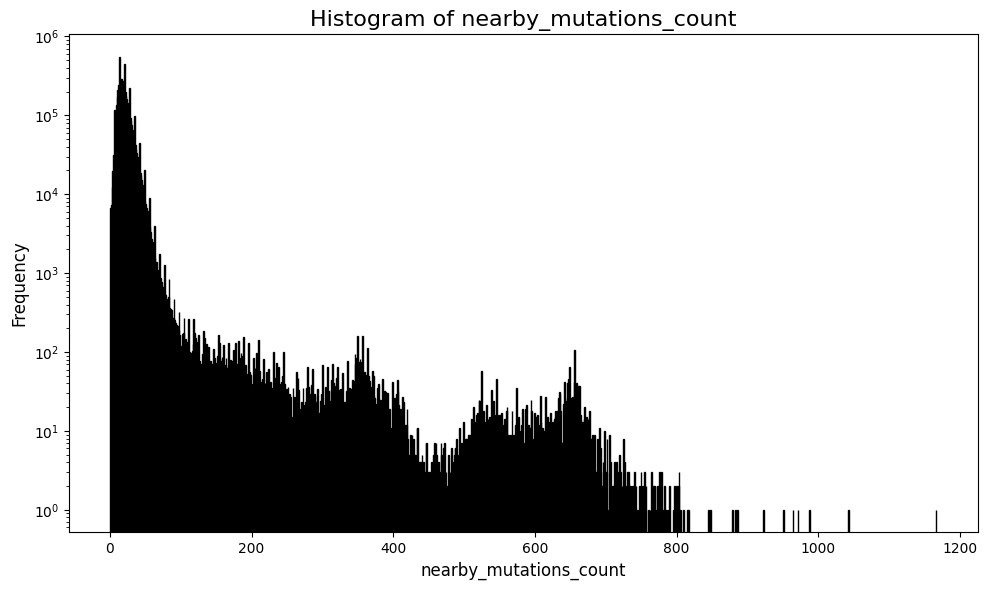

01:35:03 - INFO - Collapsing dataframe


02:19:33 - INFO - Calculating MCRS header length


02:19:35 - INFO - Calculating MCRS sequence length


02:19:37 - INFO - Aligning to normal genome and building dlist


--2024-11-12 02:19:37--  https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_009914755.1/download?include_annotation_type=GENOME_FASTA&include_annotation_type=RNA_FASTA&include_annotation_type=GENOME_GTF&hydrated=FULLY_HYDRATED
Resolving api.ncbi.nlm.nih.gov (api.ncbi.nlm.nih.gov)... 

130.14.29.110, 2607:f220:41e:4290::110
Connecting to api.ncbi.nlm.nih.gov (api.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: unspecified [application/zip]
Saving to: ‘/home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/t2t.zip’

     0K .......... .......... .......... .......... ..........  408K
    50K .......... .......... .......... .......... ..........  813K
   100K .......... .......... .......... .......... .......... 18.3M
   150K .......... .......... .......... .......... .....

.....  859K
   200K .......... .......... .......... .......... .......... 45.2M
   250K .......... .......... .......... .......... .......... 47.0M
   300K .......... .......... .......... .......... .......... 24.7M
   350K .......... .......... .......... .......... .......... 1.27M
   400K .......... .......... .......... .......... .......... 2.48M
   450K .......... .......... .......... .......... .......... 45.7M
   500K .......... .......... .......... .......... .......... 54.6M
   550K .......... .......... .......... .......... .......... 55.3M
   600K .......... .......... .......... .......... .......... 54.7M
   650K .......... .......... .......... .......... .......... 46.5M
   700K .......... .......... .......... .......... .......... 55.4M
   750K .......... .......... .......... .......... .......... 55.1M
   800K .......... .......... .......... .......... ..........  920K
   850K .......... .......... .......... .......... .......... 36.0M
   900K .......... ...

...... .......... .......... .......... ..........  532K
  2200K .......... .......... .......... .......... .......... 44.8M
  2250K .......... .......... .......... .......... .......... 42.7M
  2300K .......... .......... .......... .......... .......... 50.5M
  2350K .......... .......... .......... .......... .......... 50.3M
  2400K .......... .......... .......... .......... .......... 50.5M
  2450K .......... .......... .......... .......... .......... 43.0M
  2500K .......... .......... .......... .......... .......... 50.2M
  2550K .......... .......... .......... .......... .......... 50.4M
  2600K .......... .......... .......... .......... .......... 4.81M
  2650K .......... .......... .......... .......... .......... 35.3M
  2700K .......... .......... .......... .......... .......... 50.2M
  2750K .......... .......... .......... .......... .......... 50.0M
  2800K .......... .......... .......... .......... .......... 50.4M
  2850K .......... .......... .......... .....

...... ..........  633K
  5250K .......... .......... .......... .......... .......... 38.4M
  5300K .......... .......... .......... .......... .......... 52.7M
  5350K .......... .......... .......... .......... .......... 55.7M
  5400K .......... .......... .......... .......... .......... 55.0M
  5450K .......... .......... .......... .......... .......... 47.7M
  5500K .......... .......... .......... .......... .......... 55.1M
  5550K .......... .......... .......... .......... .......... 55.2M
  5600K .......... .......... .......... .......... .......... 55.3M
  5650K .......... .......... .......... .......... .......... 47.3M
  5700K .......... .......... .......... .......... .......... 55.5M
  5750K .......... .......... .......... .......... .......... 54.7M
  5800K .......... .......... .......... .......... .......... 55.2M
  5850K .......... .......... .......... .......... .......... 49.9M
  5900K .......... .......... .......... .......... .......... 59.8M
  5950K ..

...... .......... .......... 1.77M
  8000K .......... .......... .......... .......... .......... 1.83M
  8050K .......... .......... .......... .......... .......... 41.4M
  8100K .......... .......... .......... .......... .......... 47.9M
  8150K .......... .......... .......... .......... .......... 42.4M
  8200K .......... .......... .......... .......... .......... 46.1M
  8250K .......... .......... .......... .......... .......... 50.8M
  8300K .......... .......... .......... .......... .......... 50.6M
  8350K .......... .......... .......... .......... .......... 43.6M
  8400K .......... .......... .......... .......... .......... 50.1M
  8450K .......... .......... .......... .......... .......... 50.5M
  8500K .......... .......... .......... .......... .......... 50.4M
  8550K .......... .......... .......... .......... .......... 44.0M
  8600K .......... .......... .......... .......... .......... 55.4M
  8650K .......... .......... .......... .......... .......... 55.0M

...... .......... .......... ..........  458K
  9850K .......... .......... .......... .......... .......... 30.3M
  9900K .......... .......... .......... .......... .......... 53.8M
  9950K .......... .......... .......... .......... .......... 45.5M
 10000K .......... .......... .......... .......... .......... 51.8M
 10050K .......... .......... .......... .......... .......... 52.6M
 10100K .......... .......... .......... .......... .......... 54.6M
 10150K .......... .......... .......... .......... .......... 44.7M
 10200K .......... .......... .......... .......... .......... 54.9M
 10250K .......... .......... .......... .......... .......... 52.5M
 10300K .......... .......... .......... .......... .......... 54.8M
 10350K .......... .......... .......... .......... .......... 52.0M
 10400K .......... .......... .......... .......... .......... 60.8M
 10450K .......... .......... .......... .......... .......... 59.6M
 10500K .......... .......... .......... .......... .....

.. .......... .......... .......... 39.6M
 12750K .......... .......... .......... .......... .......... 40.6M
 12800K .......... .......... .......... .......... .......... 48.2M
 12850K .......... .......... .......... .......... .......... 47.7M
 12900K .......... .......... .......... .......... .......... 48.7M
 12950K .......... .......... .......... .......... .......... 43.0M
 13000K .......... .......... .......... .......... .......... 50.3M
 13050K .......... .......... .......... .......... .......... 51.1M
 13100K .......... .......... .......... .......... .......... 55.2M
 13150K .......... .......... .......... .......... .......... 47.9M
 13200K .......... .......... .......... .......... .......... 3.67M
 13250K .......... .......... .......... .......... .......... 1.38M
 13300K .......... .......... .......... .......... .......... 21.9M
 13350K .......... .......... .......... .......... .......... 37.7M
 13400K .......... .......... .......... .......... .........

...... .......... .......... .......... 1.45M
 15250K .......... .......... .......... .......... .......... 3.05M
 15300K .......... .......... .......... .......... .......... 37.2M
 15350K .......... .......... .......... .......... .......... 39.9M
 15400K .......... .......... .......... .......... .......... 47.3M
 15450K .......... .......... .......... .......... .......... 48.0M
 15500K .......... .......... .......... .......... .......... 49.2M
 15550K .......... .......... .......... .......... .......... 40.8M
 15600K .......... .......... .......... .......... .......... 50.2M
 15650K .......... .......... .......... .......... .......... 50.4M
 15700K .......... .......... .......... .......... .......... 50.4M
 15750K .......... .......... .......... .......... .......... 47.7M
 15800K .......... .......... .......... .......... .......... 55.2M
 15850K .......... .......... .......... .......... .......... 2.12M
 15900K .......... .......... .......... .......... .....

.... 1.45M
 17250K .......... .......... .......... .......... .......... 3.28M
 17300K .......... .......... .......... .......... .......... 26.6M
 17350K .......... .......... .......... .......... .......... 49.7M
 17400K .......... .......... .......... .......... .......... 57.5M
 17450K .......... .......... .......... .......... .......... 59.2M
 17500K .......... .......... .......... .......... .......... 59.3M
 17550K .......... .......... .......... .......... .......... 44.5M
 17600K .......... .......... .......... .......... .......... 48.1M
 17650K .......... .......... .......... .......... .......... 53.7M
 17700K .......... .......... .......... .......... .......... 60.8M
 17750K .......... .......... .......... .......... .......... 53.9M
 17800K .......... .......... .......... .......... .......... 66.0M
 17850K .......... .......... .......... .......... .......... 65.5M
 17900K .......... .......... .......... .......... .......... 1.01M
 17950K .......... ....

...... .......... .......... 21.5M
 19400K .......... .......... .......... .......... .......... 41.4M
 19450K .......... .......... .......... .......... .......... 44.2M
 19500K .......... .......... .......... .......... .......... 51.4M
 19550K .......... .......... .......... .......... .......... 41.1M
 19600K .......... .......... .......... .......... .......... 47.5M
 19650K .......... .......... .......... .......... .......... 50.1M
 19700K .......... .......... .......... .......... .......... 50.4M
 19750K .......... .......... .......... .......... .......... 42.9M
 19800K .......... .......... .......... .......... .......... 50.4M
 19850K .......... .......... .......... .......... .......... 51.7M
 19900K .......... .......... .......... .......... .......... 55.1M
 19950K .......... .......... .......... .......... .......... 1.05M
 20000K .......... .......... .......... .......... .......... 22.5M
 20050K .......... .......... .......... .......... .......... 37.5M

.. .......... 4.59M
 22050K .......... .......... .......... .......... .......... 1.28M
 22100K .......... .......... .......... .......... .......... 26.9M
 22150K .......... .......... .......... .......... .......... 45.0M
 22200K .......... .......... .......... .......... .......... 52.5M
 22250K .......... .......... .......... .......... .......... 51.8M
 22300K .......... .......... .......... .......... .......... 54.3M
 22350K .......... .......... .......... .......... .......... 46.7M
 22400K .......... .......... .......... .......... .......... 52.5M
 22450K .......... .......... .......... .......... .......... 52.5M
 22500K .......... .......... .......... .......... .......... 48.9M
 22550K .......... .......... .......... .......... .......... 52.8M
 22600K .......... .......... .......... .......... .......... 60.2M
 22650K .......... .......... .......... .......... .......... 59.9M
 22700K .......... .......... .......... .......... .......... 5.02M
 22750K ......

...... .......... .......... 1.05M
 24200K .......... .......... .......... .......... .......... 23.1M
 24250K .......... .......... .......... .......... .......... 36.2M
 24300K .......... .......... .......... .......... .......... 39.8M
 24350K .......... .......... .......... .......... .......... 41.8M
 24400K .......... .......... .......... .......... .......... 49.3M
 24450K .......... .......... .......... .......... .......... 48.6M
 24500K .......... .......... .......... .......... .......... 47.6M
 24550K .......... .......... .......... .......... .......... 46.1M
 24600K .......... .......... .......... .......... .......... 45.0M
 24650K .......... .......... .......... .......... .......... 54.0M
 24700K .......... .......... .......... .......... .......... 55.1M
 24750K .......... .......... .......... .......... .......... 47.0M
 24800K .......... .......... .......... .......... .......... 54.7M
 24850K .......... .......... .......... .......... .......... 1.07M

........ .......... 5.27M
 27000K .......... .......... .......... .......... .......... 1.27M
 27050K .......... .......... .......... .......... .......... 37.3M
 27100K .......... .......... .......... .......... .......... 27.4M
 27150K .......... .......... .......... .......... .......... 41.9M
 27200K .......... .......... .......... .......... .......... 48.9M
 27250K .......... .......... .......... .......... .......... 47.5M
 27300K .......... .......... .......... .......... .......... 46.8M
 27350K .......... .......... .......... .......... .......... 40.2M
 27400K .......... .......... .......... .......... .......... 48.3M
 27450K .......... .......... .......... .......... .......... 50.4M
 27500K .......... .......... .......... .......... .......... 50.4M
 27550K .......... .......... .......... .......... .......... 43.7M
 27600K .......... .......... .......... .......... .......... 55.0M
 27650K .......... .......... .......... .......... .......... 54.6M
 27700K 

........ .......... 1.22M
 29200K .......... .......... .......... .......... .......... 45.3M
 29250K .......... .......... .......... .......... .......... 18.6M
 29300K .......... .......... .......... .......... .......... 44.0M
 29350K .......... .......... .......... .......... .......... 42.9M
 29400K .......... .......... .......... .......... .......... 48.2M
 29450K .......... .......... .......... .......... .......... 47.2M
 29500K .......... .......... .......... .......... .......... 46.3M
 29550K .......... .......... .......... .......... .......... 41.8M
 29600K .......... .......... .......... .......... .......... 50.0M
 29650K .......... .......... .......... .......... .......... 48.1M
 29700K .......... .......... .......... .......... .......... 57.7M
 29750K .......... .......... .......... .......... .......... 47.4M
 29800K .......... .......... .......... .......... .......... 55.3M
 29850K .......... .......... .......... .......... .......... 2.50M
 29900K 

........ .......... .......... .......... 1.09M
 32100K .......... .......... .......... .......... .......... 18.7M
 32150K .......... .......... .......... .......... .......... 21.8M
 32200K .......... .......... .......... .......... .......... 39.9M
 32250K .......... .......... .......... .......... .......... 49.6M
 32300K .......... .......... .......... .......... .......... 50.5M
 32350K .......... .......... .......... .......... .......... 40.5M
 32400K .......... .......... .......... .......... .......... 47.6M
 32450K .......... .......... .......... .......... .......... 47.9M
 32500K .......... .......... .......... .......... .......... 49.3M
 32550K .......... .......... .......... .......... .......... 43.6M
 32600K .......... .......... .......... .......... .......... 50.2M
 32650K .......... .......... .......... .......... .......... 52.2M
 32700K .......... .......... .......... .......... .......... 55.5M
 32750K .......... .......... .......... .......... ...

........ .......... .......... .......... .......... 1.77M
 34350K .......... .......... .......... .......... .......... 21.8M
 34400K .......... .......... .......... .......... .......... 47.9M
 34450K .......... .......... .......... .......... .......... 49.3M
 34500K .......... .......... .......... .......... .......... 50.2M
 34550K .......... .......... .......... .......... .......... 40.7M
 34600K .......... .......... .......... .......... .......... 46.6M
 34650K .......... .......... .......... .......... .......... 49.0M
 34700K .......... .......... .......... .......... .......... 48.8M
 34750K .......... .......... .......... .......... .......... 42.9M
 34800K .......... .......... .......... .......... .......... 54.4M
 34850K .......... .......... .......... .......... .......... 45.0M
 34900K .......... .......... .......... .......... .......... 53.1M
 34950K .......... .......... .......... .......... .......... 6.39M
 35000K .......... .......... .......... ...

.. 47.8M
 37200K .......... .......... .......... .......... .......... 2.50M
 37250K .......... .......... .......... .......... .......... 1.80M
 37300K .......... .......... .......... .......... .......... 24.4M
 37350K .......... .......... .......... .......... .......... 26.9M
 37400K .......... .......... .......... .......... .......... 40.5M
 37450K .......... .......... .......... .......... .......... 50.5M
 37500K .......... .......... .......... .......... .......... 50.5M
 37550K .......... .......... .......... .......... .......... 42.6M
 37600K .......... .......... .......... .......... .......... 47.8M
 37650K .......... .......... .......... .......... .......... 49.8M
 37700K .......... .......... .......... .......... .......... 48.8M
 37750K .......... .......... .......... .......... .......... 46.7M
 37800K .......... .......... .......... .......... .......... 55.5M
 37850K .......... .......... .......... .......... .......... 50.4M
 37900K .......... ......

........ .......... .......... .......... 1.31M
 39500K .......... .......... .......... .......... .......... 18.6M
 39550K .......... .......... .......... .......... .......... 17.9M
 39600K .......... .......... .......... .......... .......... 37.0M
 39650K .......... .......... .......... .......... .......... 43.2M
 39700K .......... .......... .......... .......... .......... 50.3M
 39750K .......... .......... .......... .......... .......... 42.6M
 39800K .......... .......... .......... .......... .......... 47.7M
 39850K .......... .......... .......... .......... .......... 46.2M
 39900K .......... .......... .......... .......... .......... 42.8M
 39950K .......... .......... .......... .......... .......... 46.4M
 40000K .......... .......... .......... .......... .......... 54.0M
 40050K .......... .......... .......... .......... .......... 55.4M
 40100K .......... .......... .......... .......... .......... 55.2M
 40150K .......... .......... .......... .......... ...

.. .......... .......... .......... .......... 1.80M
 41800K .......... .......... .......... .......... .......... 27.1M
 41850K .......... .......... .......... .......... .......... 31.1M
 41900K .......... .......... .......... .......... .......... 49.1M
 41950K .......... .......... .......... .......... .......... 43.7M
 42000K .......... .......... .......... .......... .......... 46.1M
 42050K .......... .......... .......... .......... .......... 48.3M
 42100K .......... .......... .......... .......... .......... 42.6M
 42150K .......... .......... .......... .......... .......... 40.7M
 42200K .......... .......... .......... .......... .......... 51.8M
 42250K .......... .......... .......... .......... .......... 55.0M
 42300K .......... .......... .......... .......... .......... 55.2M
 42350K .......... .......... .......... .......... .......... 47.4M
 42400K .......... .......... .......... .......... .......... 55.2M
 42450K .......... .......... .......... .........

.. .......... 54.7M
 44700K .......... .......... .......... .......... .......... 2.41M
 44750K .......... .......... .......... .......... .......... 1.92M
 44800K .......... .......... .......... .......... .......... 19.7M
 44850K .......... .......... .......... .......... .......... 20.9M
 44900K .......... .......... .......... .......... .......... 38.0M
 44950K .......... .......... .......... .......... .......... 37.4M
 45000K .......... .......... .......... .......... .......... 50.8M
 45050K .......... .......... .......... .......... .......... 45.7M
 45100K .......... .......... .......... .......... .......... 47.9M
 45150K .......... .......... .......... .......... .......... 42.2M
 45200K .......... .......... .......... .......... .......... 48.2M
 45250K .......... .......... .......... .......... .......... 49.9M
 45300K .......... .......... .......... .......... .......... 50.2M
 45350K .......... .......... .......... .......... .......... 44.5M
 45400K ......

.. 2.73M
 47000K .......... .......... .......... .......... .......... 1.92M
 47050K .......... .......... .......... .......... .......... 15.8M
 47100K .......... .......... .......... .......... .......... 25.0M
 47150K .......... .......... .......... .......... .......... 22.1M
 47200K .......... .......... .......... .......... .......... 48.6M
 47250K .......... .......... .......... .......... .......... 49.8M
 47300K .......... .......... .......... .......... .......... 48.3M
 47350K .......... .......... .......... .......... .......... 41.5M
 47400K .......... .......... .......... .......... .......... 49.3M
 47450K .......... .......... .......... .......... .......... 52.6M
 47500K .......... .......... .......... .......... .......... 51.6M
 47550K .......... .......... .......... .......... .......... 47.1M
 47600K .......... .......... .......... .......... .......... 55.2M
 47650K .......... .......... .......... .......... .......... 55.1M
 47700K .......... ......


 48550K .......... .......... .......... .......... ..........  540K
 48600K .......... .......... .......... .......... .......... 53.3M
 48650K .......... .......... .......... .......... .......... 53.5M
 48700K .......... .......... .......... .......... .......... 54.4M
 48750K .......... .......... .......... .......... .......... 46.6M
 48800K .......... .......... .......... .......... .......... 52.1M
 48850K .......... .......... .......... .......... .......... 52.9M
 48900K .......... .......... .......... .......... .......... 53.6M
 48950K .......... .......... .......... .......... .......... 48.0M
 49000K .......... .......... .......... .......... .......... 60.4M
 49050K .......... .......... .......... .......... .......... 59.9M
 49100K .......... .......... .......... .......... .......... 60.2M
 49150K .......... .......... .......... .......... .......... 50.2M
 49200K .......... .......... .......... .......... .......... 59.9M
 49250K .......... .......... ...

.... .......... 2.21M
 51500K .......... .......... .......... .......... .......... 1.96M
 51550K .......... .......... .......... .......... .......... 12.4M
 51600K .......... .......... .......... .......... .......... 26.0M
 51650K .......... .......... .......... .......... .......... 40.3M
 51700K .......... .......... .......... .......... .......... 46.8M
 51750K .......... .......... .......... .......... .......... 37.2M
 51800K .......... .......... .......... .......... .......... 28.6M
 51850K .......... .......... .......... .......... .......... 37.7M
 51900K .......... .......... .......... .......... .......... 49.0M
 51950K .......... .......... .......... .......... .......... 42.9M
 52000K .......... .......... .......... .......... .......... 2.20M
 52050K .......... .......... .......... .......... .......... 1.87M
 52100K .......... .......... .......... .......... .......... 20.7M
 52150K .......... .......... .......... .......... .......... 24.0M
 52200K ....

.. .......... .......... .......... .......... 1.07M
 53200K .......... .......... .......... .......... .......... 12.7M
 53250K .......... .......... .......... .......... .......... 26.9M
 53300K .......... .......... .......... .......... .......... 36.6M
 53350K .......... .......... .......... .......... .......... 36.5M
 53400K .......... .......... .......... .......... .......... 46.6M
 53450K .......... .......... .......... .......... .......... 33.4M
 53500K .......... .......... .......... .......... .......... 44.8M
 53550K .......... .......... .......... .......... .......... 44.9M
 53600K .......... .......... .......... .......... .......... 53.2M
 53650K .......... .......... .......... .......... .......... 55.2M
 53700K .......... .......... .......... .......... .......... 1.07M
 53750K .......... .......... .......... .......... .......... 12.5M
 53800K .......... .......... .......... .......... .......... 22.0M
 53850K .......... .......... .......... .........

........ .......... 2.29M
 55400K .......... .......... .......... .......... .......... 1.81M
 55450K .......... .......... .......... .......... .......... 24.8M
 55500K .......... .......... .......... .......... .......... 23.5M
 55550K .......... .......... .......... .......... .......... 31.5M
 55600K .......... .......... .......... .......... .......... 40.8M
 55650K .......... .......... .......... .......... .......... 49.1M
 55700K .......... .......... .......... .......... .......... 38.1M
 55750K .......... .......... .......... .......... .......... 29.5M
 55800K .......... .......... .......... .......... .......... 41.0M
 55850K .......... .......... .......... .......... .......... 50.1M
 55900K .......... .......... .......... .......... .......... 50.0M
 55950K .......... .......... .......... .......... .......... 1.08M
 56000K .......... .......... .......... .......... .......... 15.6M
 56050K .......... .......... .......... .......... .......... 17.2M
 56100K 

 .......... .......... .......... .......... 1.08M
 57150K .......... .......... .......... .......... .......... 16.1M
 57200K .......... .......... .......... .......... .......... 16.4M
 57250K .......... .......... .......... .......... .......... 46.7M
 57300K .......... .......... .......... .......... .......... 31.8M
 57350K .......... .......... .......... .......... .......... 39.2M
 57400K .......... .......... .......... .......... .......... 44.3M
 57450K .......... .......... .......... .......... .......... 35.7M
 57500K .......... .......... .......... .......... .......... 37.8M
 57550K .......... .......... .......... .......... .......... 38.0M
 57600K .......... .......... .......... .......... .......... 50.3M
 57650K .......... .......... .......... .......... .......... 2.31M
 57700K .......... .......... .......... .......... .......... 1.83M
 57750K .......... .......... .......... .......... .......... 21.8M
 57800K .......... .......... .......... .......... 

........ .......... .......... .......... 1.71M
 58900K .......... .......... .......... .......... .......... 17.0M
 58950K .......... .......... .......... .......... .......... 15.6M
 59000K .......... .......... .......... .......... .......... 47.0M
 59050K .......... .......... .......... .......... .......... 45.4M
 59100K .......... .......... .......... .......... .......... 49.6M
 59150K .......... .......... .......... .......... .......... 46.9M
 59200K .......... .......... .......... .......... .......... 35.2M
 59250K .......... .......... .......... .......... .......... 37.2M
 59300K .......... .......... .......... .......... .......... 43.7M
 59350K .......... .......... .......... .......... .......... 44.4M
 59400K .......... .......... .......... .......... .......... 1.11M
 59450K .......... .......... .......... .......... .......... 13.1M
 59500K .......... .......... .......... .......... .......... 28.1M
 59550K .......... .......... .......... .......... ...

.. .......... .......... .......... 50.6M
 61150K .......... .......... .......... .......... .......... 2.48M
 61200K .......... .......... .......... .......... .......... 1.85M
 61250K .......... .......... .......... .......... .......... 19.4M
 61300K .......... .......... .......... .......... .......... 16.2M
 61350K .......... .......... .......... .......... .......... 33.8M
 61400K .......... .......... .......... .......... .......... 44.2M
 61450K .......... .......... .......... .......... .......... 43.8M
 61500K .......... .......... .......... .......... .......... 50.4M
 61550K .......... .......... .......... .......... .......... 24.4M
 61600K .......... .......... .......... .......... .......... 40.5M
 61650K .......... .......... .......... .......... .......... 41.7M
 61700K .......... .......... .......... .......... .......... 49.2M
 61750K .......... .......... .......... .......... .......... 2.51M
 61800K .......... .......... .......... .......... .........

.. 2.49M
 63000K .......... .......... .......... .......... .......... 1.84M
 63050K .......... .......... .......... .......... .......... 18.6M
 63100K .......... .......... .......... .......... .......... 17.6M
 63150K .......... .......... .......... .......... .......... 36.5M
 63200K .......... .......... .......... .......... .......... 49.8M
 63250K .......... .......... .......... .......... .......... 48.5M
 63300K .......... .......... .......... .......... .......... 33.8M
 63350K .......... .......... .......... .......... .......... 24.5M
 63400K .......... .......... .......... .......... .......... 41.3M
 63450K .......... .......... .......... .......... .......... 44.9M
 63500K .......... .......... .......... .......... .......... 54.2M
 63550K .......... .......... .......... .......... .......... 2.52M
 63600K .......... .......... .......... .......... .......... 1.85M
 63650K .......... .......... .......... .......... .......... 18.5M
 63700K .......... ......

...... .......... .......... .......... 1.83M
 64850K .......... .......... .......... .......... .......... 17.8M
 64900K .......... .......... .......... .......... .......... 14.7M
 64950K .......... .......... .......... .......... .......... 38.9M
 65000K .......... .......... .......... .......... .......... 54.7M
 65050K .......... .......... .......... .......... .......... 53.8M
 65100K .......... .......... .......... .......... .......... 35.8M
 65150K .......... .......... .......... .......... .......... 33.4M
 65200K .......... .......... .......... .......... .......... 33.7M
 65250K .......... .......... .......... .......... .......... 48.9M
 65300K .......... .......... .......... .......... .......... 55.0M
 65350K .......... .......... .......... .......... .......... 2.55M
 65400K .......... .......... .......... .......... .......... 1.85M
 65450K .......... .......... .......... .......... .......... 14.9M
 65500K .......... .......... .......... .......... .....

........ .......... .......... .......... .......... 50.2M
 67150K .......... .......... .......... .......... .......... 43.4M
 67200K .......... .......... .......... .......... .......... 1.13M
 67250K .......... .......... .......... .......... .......... 18.4M
 67300K .......... .......... .......... .......... .......... 15.4M
 67350K .......... .......... .......... .......... .......... 18.6M
 67400K .......... .......... .......... .......... .......... 40.6M
 67450K .......... .......... .......... .......... .......... 40.4M
 67500K .......... .......... .......... .......... .......... 46.3M
 67550K .......... .......... .......... .......... .......... 43.7M
 67600K .......... .......... .......... .......... .......... 33.2M
 67650K .......... .......... .......... .......... .......... 37.5M
 67700K .......... .......... .......... .......... .......... 46.0M
 67750K .......... .......... .......... .......... .......... 42.9M
 67800K .......... .......... .......... ...

.. .......... .......... 2.60M
 69100K .......... .......... .......... .......... .......... 1.74M
 69150K .......... .......... .......... .......... .......... 22.1M
 69200K .......... .......... .......... .......... .......... 23.0M
 69250K .......... .......... .......... .......... .......... 36.4M
 69300K .......... .......... .......... .......... .......... 42.0M
 69350K .......... .......... .......... .......... .......... 40.5M
 69400K .......... .......... .......... .......... .......... 49.5M
 69450K .......... .......... .......... .......... .......... 30.2M
 69500K .......... .......... .......... .......... .......... 42.0M
 69550K .......... .......... .......... .......... .......... 41.2M
 69600K .......... .......... .......... .......... .......... 54.1M
 69650K .......... .......... .......... .......... .......... 2.35M
 69700K .......... .......... .......... .......... .......... 1.86M
 69750K .......... .......... .......... .......... .......... 22.0M
 69


 70950K .......... .......... .......... .......... .......... 1.84M
 71000K .......... .......... .......... .......... .......... 21.2M
 71050K .......... .......... .......... .......... .......... 23.4M
 71100K .......... .......... .......... .......... .......... 31.7M
 71150K .......... .......... .......... .......... .......... 40.9M
 71200K .......... .......... .......... .......... .......... 48.9M
 71250K .......... .......... .......... .......... .......... 49.2M
 71300K .......... .......... .......... .......... .......... 26.6M
 71350K .......... .......... .......... .......... .......... 42.1M
 71400K .......... .......... .......... .......... .......... 47.5M
 71450K .......... .......... .......... .......... .......... 48.0M
 71500K .......... .......... .......... .......... .......... 50.2M
 71550K .......... .......... .......... .......... .......... 1.07M
 71600K .......... .......... .......... .......... .......... 22.0M
 71650K .......... .......... ...

.. .......... .......... .......... 41.8M
 73350K .......... .......... .......... .......... .......... 43.7M
 73400K .......... .......... .......... .......... .......... 2.40M
 73450K .......... .......... .......... .......... .......... 1.91M
 73500K .......... .......... .......... .......... .......... 21.4M
 73550K .......... .......... .......... .......... .......... 22.8M
 73600K .......... .......... .......... .......... .......... 32.8M
 73650K .......... .......... .......... .......... .......... 49.7M
 73700K .......... .......... .......... .......... .......... 43.3M
 73750K .......... .......... .......... .......... .......... 45.5M
 73800K .......... .......... .......... .......... .......... 21.4M
 73850K .......... .......... .......... .......... .......... 43.5M
 73900K .......... .......... .......... .......... .......... 42.7M
 73950K .......... .......... .......... .......... .......... 37.8M
 74000K .......... .......... .......... .......... .........

 .......... .......... .......... .......... 1.14M
 75350K .......... .......... .......... .......... .......... 11.7M
 75400K .......... .......... .......... .......... .......... 27.6M
 75450K .......... .......... .......... .......... .......... 30.4M
 75500K .......... .......... .......... .......... .......... 34.3M
 75550K .......... .......... .......... .......... .......... 41.0M
 75600K .......... .......... .......... .......... .......... 40.9M
 75650K .......... .......... .......... .......... .......... 48.1M
 75700K .......... .......... .......... .......... .......... 22.3M
 75750K .......... .......... .......... .......... .......... 40.3M
 75800K .......... .......... .......... .......... .......... 41.9M
 75850K .......... .......... .......... .......... .......... 50.5M
 75900K .......... .......... .......... .......... .......... 2.47M
 75950K .......... .......... .......... .......... .......... 1.92M
 76000K .......... .......... .......... .......... 

... .......... 1.11M
 77250K .......... .......... .......... .......... .......... 14.7M
 77300K .......... .......... .......... .......... .......... 20.1M
 77350K .......... .......... .......... .......... .......... 33.4M
 77400K .......... .......... .......... .......... .......... 47.3M
 77450K .......... .......... .......... .......... .......... 47.6M
 77500K .......... .......... .......... .......... .......... 41.7M
 77550K .......... .......... .......... .......... .......... 29.9M
 77600K .......... .......... .......... .......... .......... 37.0M
 77650K .......... .......... .......... .......... .......... 43.1M
 77700K .......... .......... .......... .......... .......... 41.7M
 77750K .......... .......... .......... .......... .......... 48.7M
 77800K .......... .......... .......... .......... .......... 2.43M
 77850K .......... .......... .......... .......... .......... 1.87M
 77900K .......... .......... .......... .......... .......... 18.7M
 77950K .....

......... .......... .......... .......... .......... 2.43M
 79750K .......... .......... .......... .......... .......... 1.96M
 79800K .......... .......... .......... .......... .......... 17.9M
 79850K .......... .......... .......... .......... .......... 19.3M
 79900K .......... .......... .......... .......... .......... 27.4M
 79950K .......... .......... .......... .......... .......... 39.8M
 80000K .......... .......... .......... .......... .......... 43.8M
 80050K .......... .......... .......... .......... .......... 48.1M
 80100K .......... .......... .......... .......... .......... 27.4M
 80150K .......... .......... .......... .......... .......... 37.3M
 80200K .......... .......... .......... .......... .......... 46.6M
 80250K .......... .......... .......... .......... .......... 46.9M
 80300K .......... .......... .......... .......... .......... 41.8M
 80350K .......... .......... .......... .......... .......... 2.42M
 80400K .......... .......... .......... ..

. .......... .......... .......... 2.55M
 81700K .......... .......... .......... .......... .......... 1.84M
 81750K .......... .......... .......... .......... .......... 18.5M
 81800K .......... .......... .......... .......... .......... 29.0M
 81850K .......... .......... .......... .......... .......... 39.2M
 81900K .......... .......... .......... .......... .......... 36.6M
 81950K .......... .......... .......... .......... .......... 37.4M
 82000K .......... .......... .......... .......... .......... 44.9M
 82050K .......... .......... .......... .......... .......... 24.1M
 82100K .......... .......... .......... .......... .......... 33.5M
 82150K .......... .......... .......... .......... .......... 49.5M
 82200K .......... .......... .......... .......... .......... 50.1M
 82250K .......... .......... .......... .......... .......... 49.9M
 82300K .......... .......... .......... .......... .......... 2.52M
 82350K .......... .......... .......... .......... ..........

... .......... 1.88M
 83650K .......... .......... .......... .......... .......... 16.9M
 83700K .......... .......... .......... .......... .......... 20.5M
 83750K .......... .......... .......... .......... .......... 47.9M
 83800K .......... .......... .......... .......... .......... 35.7M
 83850K .......... .......... .......... .......... .......... 47.0M
 83900K .......... .......... .......... .......... .......... 45.0M
 83950K .......... .......... .......... .......... .......... 19.7M
 84000K .......... .......... .......... .......... .......... 29.3M
 84050K .......... .......... .......... .......... .......... 38.6M
 84100K .......... .......... .......... .......... .......... 43.6M
 84150K .......... .......... .......... .......... .......... 55.1M
 84200K .......... .......... .......... .......... .......... 2.65M
 84250K .......... .......... .......... .......... .......... 1.82M
 84300K .......... .......... .......... .......... .......... 19.0M
 84350K .....

.... .......... .......... 45.6M
 86050K .......... .......... .......... .......... .......... 45.3M
 86100K .......... .......... .......... .......... .......... 31.9M
 86150K .......... .......... .......... .......... .......... 2.80M
 86200K .......... .......... .......... .......... .......... 1.79M
 86250K .......... .......... .......... .......... .......... 21.7M
 86300K .......... .......... .......... .......... .......... 23.4M
 86350K .......... .......... .......... .......... .......... 47.1M
 86400K .......... .......... .......... .......... .......... 38.3M
 86450K .......... .......... .......... .......... .......... 41.6M
 86500K .......... .......... .......... .......... .......... 17.3M
 86550K .......... .......... .......... .......... .......... 39.6M
 86600K .......... .......... .......... .......... .......... 40.2M
 86650K .......... .......... .......... .......... .......... 43.6M
 86700K .......... .......... .......... .......... .......... 43.1M
 

........ .......... 2.66M
 88100K .......... .......... .......... .......... .......... 41.7M
 88150K .......... .......... .......... .......... .......... 1.77M
 88200K .......... .......... .......... .......... .......... 21.3M
 88250K .......... .......... .......... .......... .......... 52.5M
 88300K .......... .......... .......... .......... .......... 27.3M
 88350K .......... .......... .......... .......... .......... 41.5M
 88400K .......... .......... .......... .......... .......... 41.6M
 88450K .......... .......... .......... .......... .......... 24.6M
 88500K .......... .......... .......... .......... .......... 30.4M
 88550K .......... .......... .......... .......... .......... 45.6M
 88600K .......... .......... .......... .......... .......... 37.0M
 88650K .......... .......... .......... .......... .......... 50.3M
 88700K .......... .......... .......... .......... .......... 2.64M
 88750K .......... .......... .......... .......... .......... 1.99M
 88800K 

....... 2.00M
 90100K .......... .......... .......... .......... .......... 10.2M
 90150K .......... .......... .......... .......... .......... 24.0M
 90200K .......... .......... .......... .......... .......... 40.6M
 90250K .......... .......... .......... .......... .......... 47.7M
 90300K .......... .......... .......... .......... .......... 31.1M
 90350K .......... .......... .......... .......... .......... 43.2M
 90400K .......... .......... .......... .......... .......... 21.9M
 90450K .......... .......... .......... .......... .......... 42.0M
 90500K .......... .......... .......... .......... .......... 29.8M
 90550K .......... .......... .......... .......... .......... 43.0M
 90600K .......... .......... .......... .......... .......... 50.1M
 90650K .......... .......... .......... .......... .......... 2.72M
 90700K .......... .......... .......... .......... .......... 1.94M
 90750K .......... .......... .......... .......... .......... 11.6M
 90800K .......... .

... .......... .......... 52.9M
 92500K .......... .......... .......... .......... .......... 45.4M
 92550K .......... .......... .......... .......... .......... 54.2M
 92600K .......... .......... .......... .......... .......... 2.65M
 92650K .......... .......... .......... .......... .......... 2.00M
 92700K .......... .......... .......... .......... .......... 6.30M
 92750K .......... .......... .......... .......... .......... 37.2M
 92800K .......... .......... .......... .......... .......... 48.4M
 92850K .......... .......... .......... .......... .......... 49.8M
 92900K .......... .......... .......... .......... .......... 44.7M
 92950K .......... .......... .......... .......... .......... 54.2M
 93000K .......... .......... .......... .......... .......... 53.4M
 93050K .......... .......... .......... .......... .......... 27.7M
 93100K .......... .......... .......... .......... .......... 33.4M
 93150K .......... .......... .......... .......... .......... 46.1M
 9

....... .......... .......... 2.75M
 94600K .......... .......... .......... .......... .......... 2.04M
 94650K .......... .......... .......... .......... .......... 6.31M
 94700K .......... .......... .......... .......... .......... 34.8M
 94750K .......... .......... .......... .......... .......... 48.2M
 94800K .......... .......... .......... .......... .......... 49.0M
 94850K .......... .......... .......... .......... .......... 49.9M
 94900K .......... .......... .......... .......... .......... 45.2M
 94950K .......... .......... .......... .......... .......... 42.2M
 95000K .......... .......... .......... .......... .......... 33.5M
 95050K .......... .......... .......... .......... .......... 35.2M
 95100K .......... .......... .......... .......... .......... 39.8M
 95150K .......... .......... .......... .......... .......... 53.0M
 95200K .......... .......... .......... .......... .......... 2.71M
 95250K .......... .......... .......... .......... .......... 2.04

... 2.10M
 96600K .......... .......... .......... .......... .......... 6.29M
 96650K .......... .......... .......... .......... .......... 36.0M
 96700K .......... .......... .......... .......... .......... 37.6M
 96750K .......... .......... .......... .......... .......... 48.9M
 96800K .......... .......... .......... .......... .......... 48.9M
 96850K .......... .......... .......... .......... .......... 50.1M
 96900K .......... .......... .......... .......... .......... 32.5M
 96950K .......... .......... .......... .......... .......... 18.7M
 97000K .......... .......... .......... .......... .......... 38.6M
 97050K .......... .......... .......... .......... .......... 48.9M
 97100K .......... .......... .......... .......... .......... 43.2M
 97150K .......... .......... .......... .......... .......... 2.82M
 97200K .......... .......... .......... .......... .......... 2.11M
 97250K .......... .......... .......... .......... .......... 6.05M
 97300K .......... .....

.......  579K
 98500K .......... .......... .......... .......... .......... 40.7M
 98550K .......... .......... .......... .......... .......... 48.8M
 98600K .......... .......... .......... .......... .......... 49.8M
 98650K .......... .......... .......... .......... .......... 50.3M
 98700K .......... .......... .......... .......... .......... 43.1M
 98750K .......... .......... .......... .......... .......... 49.9M
 98800K .......... .......... .......... .......... .......... 50.1M
 98850K .......... .......... .......... .......... .......... 49.9M
 98900K .......... .......... .......... .......... .......... 43.2M
 98950K .......... .......... .......... .......... .......... 49.8M
 99000K .......... .......... .......... .......... .......... 49.9M
 99050K .......... .......... .......... .......... .......... 53.1M
 99100K .......... .......... .......... .......... .......... 4.30M
 99150K .......... .......... .......... .......... .......... 46.9M
 99200K .......... .

....... 2.25M
101100K .......... .......... .......... .......... .......... 28.5M
101150K .......... .......... .......... .......... .......... 47.7M
101200K .......... .......... .......... .......... .......... 1.78M
101250K .......... .......... .......... .......... .......... 49.0M
101300K .......... .......... .......... .......... .......... 41.2M
101350K .......... .......... .......... .......... .......... 50.6M
101400K .......... .......... .......... .......... .......... 41.9M
101450K .......... .......... .......... .......... .......... 49.5M
101500K .......... .......... .......... .......... .......... 43.2M
101550K .......... .......... .......... .......... .......... 50.3M
101600K .......... .......... .......... .......... .......... 50.2M
101650K .......... .......... .......... .......... .......... 49.8M
101700K .......... .......... .......... .......... .......... 2.20M
101750K .......... .......... .......... .......... .......... 38.1M
101800K .......... .

... .......... .......... .......... ..........  415K
103200K .......... .......... .......... .......... .......... 38.8M
103250K .......... .......... .......... .......... .......... 49.4M
103300K .......... .......... .......... .......... .......... 42.8M
103350K .......... .......... .......... .......... .......... 49.9M
103400K .......... .......... .......... .......... .......... 54.0M
103450K .......... .......... .......... .......... .......... 45.2M
103500K .......... .......... .......... .......... .......... 43.1M
103550K .......... .......... .......... .......... .......... 49.7M
103600K .......... .......... .......... .......... .......... 50.4M
103650K .......... .......... .......... .......... .......... 51.5M
103700K .......... .......... .......... .......... .......... 47.3M
103750K .......... .......... .......... .......... .......... 55.3M
103800K .......... .......... .......... .......... .......... 55.0M
103850K .......... .......... .......... ........

..... 2.11M
105250K .......... .......... .......... .......... .......... 21.7M
105300K .......... .......... .......... .......... .......... 1.67M
105350K .......... .......... .......... .......... .......... 44.4M
105400K .......... .......... .......... .......... .......... 47.2M
105450K .......... .......... .......... .......... .......... 43.9M
105500K .......... .......... .......... .......... .......... 42.8M
105550K .......... .......... .......... .......... .......... 50.0M
105600K .......... .......... .......... .......... .......... 49.9M
105650K .......... .......... .......... .......... .......... 50.4M
105700K .......... .......... .......... .......... .......... 1.99M
105750K .......... .......... .......... .......... .......... 1.68M
105800K .......... .......... .......... .......... .......... 44.9M
105850K .......... .......... .......... .......... .......... 48.6M
105900K .......... .......... .......... .......... .......... 41.1M
105950K .......... ...

......... 1.67M
106750K .......... .......... .......... .......... .......... 37.4M
106800K .......... .......... .......... .......... .......... 40.1M
106850K .......... .......... .......... .......... .......... 46.8M
106900K .......... .......... .......... .......... .......... 40.7M
106950K .......... .......... .......... .......... .......... 49.3M
107000K .......... .......... .......... .......... .......... 50.0M
107050K .......... .......... .......... .......... .......... 50.4M
107100K .......... .......... .......... .......... .......... 2.05M
107150K .......... .......... .......... .......... .......... 32.3M
107200K .......... .......... .......... .......... .......... 1.68M
107250K .......... .......... .......... .......... .......... 45.1M
107300K .......... .......... .......... .......... .......... 41.7M
107350K .......... .......... .......... .......... .......... 46.3M
107400K .......... .......... .......... .......... .......... 47.7M
107450K ..........

. .......... 2.16M
108600K .......... .......... .......... .......... .......... 20.5M
108650K .......... .......... .......... .......... .......... 1.70M
108700K .......... .......... .......... .......... .......... 31.5M
108750K .......... .......... .......... .......... .......... 45.9M
108800K .......... .......... .......... .......... .......... 54.8M
108850K .......... .......... .......... .......... .......... 53.0M
108900K .......... .......... .......... .......... .......... 45.0M
108950K .......... .......... .......... .......... .......... 54.5M
109000K .......... .......... .......... .......... .......... 53.4M
109050K .......... .......... .......... .......... .......... 2.12M
109100K .......... .......... .......... .......... .......... 20.1M
109150K .......... .......... .......... .......... .......... 1.67M
109200K .......... .......... .......... .......... .......... 44.2M
109250K .......... .......... .......... .......... .......... 48.3M
109300K .......

. .......... 1.67M
110200K .......... .......... .......... .......... .......... 40.0M
110250K .......... .......... .......... .......... .......... 43.1M
110300K .......... .......... .......... .......... .......... 40.8M
110350K .......... .......... .......... .......... .......... 47.4M
110400K .......... .......... .......... .......... .......... 48.5M
110450K .......... .......... .......... .......... .......... 50.1M
110500K .......... .......... .......... .......... .......... 43.1M
110550K .......... .......... .......... .......... .......... 49.2M
110600K .......... .......... .......... .......... .......... 2.09M
110650K .......... .......... .......... .......... .......... 43.4M
110700K .......... .......... .......... .......... .......... 1.67M
110750K .......... .......... .......... .......... .......... 45.0M
110800K .......... .......... .......... .......... .......... 47.9M
110850K .......... .......... .......... .......... .......... 54.2M
110900K .......

. 2.13M
112150K .......... .......... .......... .......... .......... 20.0M
112200K .......... .......... .......... .......... .......... 1.71M
112250K .......... .......... .......... .......... .......... 33.1M
112300K .......... .......... .......... .......... .......... 32.1M
112350K .......... .......... .......... .......... .......... 44.1M
112400K .......... .......... .......... .......... .......... 48.0M
112450K .......... .......... .......... .......... .......... 49.7M
112500K .......... .......... .......... .......... .......... 43.0M
112550K .......... .......... .......... .......... .......... 50.0M
112600K .......... .......... .......... .......... .......... 49.8M
112650K .......... .......... .......... .......... .......... 2.22M
112700K .......... .......... .......... .......... .......... 19.1M
112750K .......... .......... .......... .......... .......... 1.72M
112800K .......... .......... .......... .......... .......... 33.3M
112850K .......... .......

......... .......... .......... 1.69M
113850K .......... .......... .......... .......... .......... 39.6M
113900K .......... .......... .......... .......... .......... 39.4M
113950K .......... .......... .......... .......... .......... 47.6M
114000K .......... .......... .......... .......... .......... 49.0M
114050K .......... .......... .......... .......... .......... 47.5M
114100K .......... .......... .......... .......... .......... 43.0M
114150K .......... .......... .......... .......... .......... 50.1M
114200K .......... .......... .......... .......... .......... 50.0M
114250K .......... .......... .......... .......... .......... 2.19M
114300K .......... .......... .......... .......... .......... 10.2M
114350K .......... .......... .......... .......... .......... 1.89M
114400K .......... .......... .......... .......... .......... 33.7M
114450K .......... .......... .......... .......... .......... 49.0M
114500K .......... .......... .......... .......... .......... 41

......... .......... .......... .......... .......... 1.85M
115950K .......... .......... .......... .......... .......... 1.89M
116000K .......... .......... .......... .......... .......... 39.9M
116050K .......... .......... .......... .......... .......... 40.7M
116100K .......... .......... .......... .......... .......... 43.8M
116150K .......... .......... .......... .......... .......... 52.2M
116200K .......... .......... .......... .......... .......... 53.1M
116250K .......... .......... .......... .......... .......... 52.2M
116300K .......... .......... .......... .......... .......... 46.0M
116350K .......... .......... .......... .......... .......... 54.6M
116400K .......... .......... .......... .......... .......... 55.1M
116450K .......... .......... .......... .......... .......... 1.84M
116500K .......... .......... .......... .......... .......... 1.90M
116550K .......... .......... .......... .......... .......... 35.5M
116600K .......... .......... .......... ..

......... .......... .......... .......... 1.91M
117700K .......... .......... .......... .......... .......... 30.1M
117750K .......... .......... .......... .......... .......... 45.5M
117800K .......... .......... .......... .......... .......... 49.4M
117850K .......... .......... .......... .......... .......... 54.1M
117900K .......... .......... .......... .......... .......... 47.1M
117950K .......... .......... .......... .......... .......... 54.7M
118000K .......... .......... .......... .......... .......... 53.6M
118050K .......... .......... .......... .......... .......... 55.2M
118100K .......... .......... .......... .......... .......... 2.10M
118150K .......... .......... .......... .......... .......... 11.1M
118200K .......... .......... .......... .......... .......... 1.93M
118250K .......... .......... .......... .......... .......... 31.3M
118300K .......... .......... .......... .......... .......... 41.4M
118350K .......... .......... .......... .......... ..

.... .......... .......... 2.22M
119850K .......... .......... .......... .......... .......... 11.5M
119900K .......... .......... .......... .......... .......... 1.94M
119950K .......... .......... .......... .......... .......... 25.0M
120000K .......... .......... .......... .......... .......... 39.9M
120050K .......... .......... .......... .......... .......... 47.3M
120100K .......... .......... .......... .......... .......... 41.3M
120150K .......... .......... .......... .......... .......... 48.0M
120200K .......... .......... .......... .......... .......... 47.6M
120250K .......... .......... .......... .......... .......... 49.9M
120300K .......... .......... .......... .......... .......... 43.2M
120350K .......... .......... .......... .......... .......... 49.8M
120400K .......... .......... .......... .......... .......... 1.93M
120450K .......... .......... .......... .......... .......... 1.97M
120500K .......... .......... .......... .......... .......... 24.3M
1

..... 1.98M
121650K .......... .......... .......... .......... .......... 21.6M
121700K .......... .......... .......... .......... .......... 35.4M
121750K .......... .......... .......... .......... .......... 44.2M
121800K .......... .......... .......... .......... .......... 48.4M
121850K .......... .......... .......... .......... .......... 44.0M
121900K .......... .......... .......... .......... .......... 43.7M
121950K .......... .......... .......... .......... .......... 49.8M
122000K .......... .......... .......... .......... .......... 50.6M
122050K .......... .......... .......... .......... .......... 49.8M
122100K .......... .......... .......... .......... .......... 1.96M
122150K .......... .......... .......... .......... .......... 29.8M
122200K .......... .......... .......... .......... .......... 1.98M
122250K .......... .......... .......... .......... .......... 23.9M
122300K .......... .......... .......... .......... .......... 34.0M
122350K .......... ...

... .......... .......... 2.34M
123900K .......... .......... .......... .......... .......... 9.62M
123950K .......... .......... .......... .......... .......... 1.97M
124000K .......... .......... .......... .......... .......... 23.7M
124050K .......... .......... .......... .......... .......... 42.7M
124100K .......... .......... .......... .......... .......... 42.4M
124150K .......... .......... .......... .......... .......... 47.1M
124200K .......... .......... .......... .......... .......... 48.6M
124250K .......... .......... .......... .......... .......... 46.8M
124300K .......... .......... .......... .......... .......... 42.1M
124350K .......... .......... .......... .......... .......... 50.0M
124400K .......... .......... .......... .......... .......... 49.3M
124450K .......... .......... .......... .......... .......... 2.31M
124500K .......... .......... .......... .......... .......... 9.82M
124550K .......... .......... .......... .......... .......... 1.96M
12

..... .......... .......... .......... 1.93M
125800K .......... .......... .......... .......... .......... 26.4M
125850K .......... .......... .......... .......... .......... 50.9M
125900K .......... .......... .......... .......... .......... 45.4M
125950K .......... .......... .......... .......... .......... 50.4M
126000K .......... .......... .......... .......... .......... 52.5M
126050K .......... .......... .......... .......... .......... 53.2M
126100K .......... .......... .......... .......... .......... 45.6M
126150K .......... .......... .......... .......... .......... 54.7M
126200K .......... .......... .......... .......... .......... 2.47M
126250K .......... .......... .......... .......... .......... 7.82M
126300K .......... .......... .......... .......... .......... 31.3M
126350K .......... .......... .......... .......... .......... 1.90M
126400K .......... .......... .......... .......... .......... 28.1M
126450K .......... .......... .......... .......... ......

...  449K
128000K .......... .......... .......... .......... .......... 27.0M
128050K .......... .......... .......... .......... .......... 48.5M
128100K .......... .......... .......... .......... .......... 38.7M
128150K .......... .......... .......... .......... .......... 42.9M
128200K .......... .......... .......... .......... .......... 48.3M
128250K .......... .......... .......... .......... .......... 48.3M
128300K .......... .......... .......... .......... .......... 40.3M
128350K .......... .......... .......... .......... .......... 46.8M
128400K .......... .......... .......... .......... .......... 49.0M
128450K .......... .......... .......... .......... .......... 49.3M
128500K .......... .......... .......... .......... .......... 43.9M
128550K .......... .......... .......... .......... .......... 55.1M
128600K .......... .......... .......... .......... .......... 54.9M
128650K .......... .......... .......... .......... .......... 55.0M
128700K .......... .....

......... 2.63M
130350K .......... .......... .......... .......... .......... 6.68M
130400K .......... .......... .......... .......... .......... 1.96M
130450K .......... .......... .......... .......... .......... 10.9M
130500K .......... .......... .......... .......... .......... 24.5M
130550K .......... .......... .......... .......... .......... 30.5M
130600K .......... .......... .......... .......... .......... 39.1M
130650K .......... .......... .......... .......... .......... 49.8M
130700K .......... .......... .......... .......... .......... 42.6M
130750K .......... .......... .......... .......... .......... 2.55M
130800K .......... .......... .......... .......... .......... 7.59M
130850K .......... .......... .......... .......... .......... 1.93M
130900K .......... .......... .......... .......... .......... 12.3M
130950K .......... .......... .......... .......... .......... 26.4M
131000K .......... .......... .......... .......... .......... 34.8M
131050K ..........

... .......... .......... .......... .......... 1.72M
131800K .......... .......... .......... .......... .......... 39.3M
131850K .......... .......... .......... .......... .......... 35.6M
131900K .......... .......... .......... .......... .......... 29.8M
131950K .......... .......... .......... .......... .......... 41.6M
132000K .......... .......... .......... .......... .......... 50.0M
132050K .......... .......... .......... .......... .......... 2.79M
132100K .......... .......... .......... .......... .......... 6.25M
132150K .......... .......... .......... .......... .......... 39.2M
132200K .......... .......... .......... .......... .......... 1.71M
132250K .......... .......... .......... .......... .......... 32.9M
132300K .......... .......... .......... .......... .......... 30.9M
132350K .......... .......... .......... .......... .......... 42.9M
132400K .......... .......... .......... .......... .......... 49.3M
132450K .......... .......... .......... ........

..... 2.66M
133450K .......... .......... .......... .......... .......... 5.99M
133500K .......... .......... .......... .......... .......... 2.04M
133550K .......... .......... .......... .......... .......... 9.84M
133600K .......... .......... .......... .......... .......... 41.3M
133650K .......... .......... .......... .......... .......... 37.5M
133700K .......... .......... .......... .......... .......... 36.3M
133750K .......... .......... .......... .......... .......... 48.7M
133800K .......... .......... .......... .......... .......... 48.5M
133850K .......... .......... .......... .......... .......... 50.4M
133900K .......... .......... .......... .......... .......... 1.91M
133950K .......... .......... .......... .......... .......... 41.6M
134000K .......... .......... .......... .......... .......... 1.78M
134050K .......... .......... .......... .......... .......... 42.3M
134100K .......... .......... .......... .......... .......... 26.8M
134150K .......... ...

. .......... .......... .......... .......... 1.88M
134950K .......... .......... .......... .......... .......... 22.4M
135000K .......... .......... .......... .......... .......... 27.2M
135050K .......... .......... .......... .......... .......... 43.9M
135100K .......... .......... .......... .......... .......... 42.5M
135150K .......... .......... .......... .......... .......... 51.2M
135200K .......... .......... .......... .......... .......... 46.9M
135250K .......... .......... .......... .......... .......... 1.98M
135300K .......... .......... .......... .......... .......... 21.4M
135350K .......... .......... .......... .......... .......... 2.07M
135400K .......... .......... .......... .......... .......... 11.4M
135450K .......... .......... .......... .......... .......... 26.1M
135500K .......... .......... .......... .......... .......... 33.3M
135550K .......... .......... .......... .......... .......... 41.1M
135600K .......... .......... .......... ..........

......... .......... .......... .......... 1.96M
136700K .......... .......... .......... .......... .......... 30.1M
136750K .......... .......... .......... .......... .......... 1.99M
136800K .......... .......... .......... .......... .......... 15.0M
136850K .......... .......... .......... .......... .......... 27.8M
136900K .......... .......... .......... .......... .......... 37.9M
136950K .......... .......... .......... .......... .......... 48.9M
137000K .......... .......... .......... .......... .......... 33.1M
137050K .......... .......... .......... .......... .......... 39.8M
137100K .......... .......... .......... .......... .......... 2.01M
137150K .......... .......... .......... .......... .......... 22.7M
137200K .......... .......... .......... .......... .......... 2.11M
137250K .......... .......... .......... .......... .......... 9.88M
137300K .......... .......... .......... .......... .......... 30.8M
137350K .......... .......... .......... .......... ..

....... .......... .......... 2.06M
138200K .......... .......... .......... .......... .......... 10.9M
138250K .......... .......... .......... .......... .......... 33.7M
138300K .......... .......... .......... .......... .......... 33.5M
138350K .......... .......... .......... .......... .......... 49.1M
138400K .......... .......... .......... .......... .......... 37.0M
138450K .......... .......... .......... .......... .......... 38.8M
138500K .......... .......... .......... .......... .......... 2.67M
138550K .......... .......... .......... .......... ..........  507K
138600K .......... .......... .......... .......... .......... 45.0M
138650K .......... .......... .......... .......... .......... 47.8M
138700K .......... .......... .......... .......... .......... 42.7M
138750K .......... .......... .......... .......... .......... 49.0M
138800K .......... .......... .......... .......... .......... 47.3M
138850K .......... .......... .......... .......... .......... 49.3

......... 2.61M
139750K .......... .......... .......... .......... .......... 5.84M
139800K .......... .......... .......... .......... .......... 1.74M
139850K .......... .......... .......... .......... .......... 27.4M
139900K .......... .......... .......... .......... .......... 30.2M
139950K .......... .......... .......... .......... .......... 29.8M
140000K .......... .......... .......... .......... .......... 38.8M
140050K .......... .......... .......... .......... .......... 2.00M
140100K .......... .......... .......... .......... .......... 1.92M
140150K .......... .......... .......... .......... .......... 8.34M
140200K .......... .......... .......... .......... .......... 31.9M
140250K .......... .......... .......... .......... .......... 36.0M
140300K .......... .......... .......... .......... .......... 27.5M
140350K .......... .......... .......... .......... .......... 42.6M
140400K .......... .......... .......... .......... ..........  744K
140450K ..........

..... .......... .......... .......... 1.28M
140800K .......... .......... .......... .......... .......... 2.91M
140850K .......... .......... .......... .......... .......... 50.8M
140900K .......... .......... .......... .......... .......... 45.9M
140950K .......... .......... .......... .......... .......... 55.2M
141000K .......... .......... .......... .......... .......... 54.7M
141050K .......... .......... .......... .......... .......... 54.8M
141100K .......... .......... .......... .......... .......... 1.22M
141150K .......... .......... .......... .......... .......... 2.90M
141200K .......... .......... .......... .......... .......... 37.0M
141250K .......... .......... .......... .......... .......... 44.7M
141300K .......... .......... .......... .......... .......... 42.1M
141350K .......... .......... .......... .......... .......... 49.9M
141400K .......... .......... .......... .......... .......... 50.6M
141450K .......... .......... .......... .......... ......

. .......... .......... .......... 2.93M
141900K .......... .......... .......... .......... .......... 38.6M
141950K .......... .......... .......... .......... .......... 46.4M
142000K .......... .......... .......... .......... .......... 49.7M
142050K .......... .......... .......... .......... .......... 49.4M
142100K .......... .......... .......... .......... .......... 7.91M
142150K .......... .......... .......... .......... .......... 1.43M
142200K .......... .......... .......... .......... .......... 3.00M
142250K .......... .......... .......... .......... .......... 54.3M
142300K .......... .......... .......... .......... .......... 46.3M
142350K .......... .......... .......... .......... .......... 48.8M
142400K .......... .......... .......... .......... .......... 54.3M
142450K .......... .......... .......... .......... .......... 55.0M
142500K .......... .......... .......... .......... .......... 1.20M
142550K .......... .......... .......... .......... ..........

..... 1.22M
143250K .......... .......... .......... .......... .......... 32.7M
143300K .......... .......... .......... .......... .......... 3.06M
143350K .......... .......... .......... .......... .......... 50.6M
143400K .......... .......... .......... .......... .......... 51.5M
143450K .......... .......... .......... .......... .......... 53.9M
143500K .......... .......... .......... .......... .......... 47.4M
143550K .......... .......... .......... .......... .......... 6.96M
143600K .......... .......... .......... .......... .......... 1.40M
143650K .......... .......... .......... .......... .......... 3.12M
143700K .......... .......... .......... .......... .......... 45.8M
143750K .......... .......... .......... .......... .......... 51.3M
143800K .......... .......... .......... .......... .......... 54.0M
143850K .......... .......... .......... .......... .......... 54.3M
143900K .......... .......... .......... .......... .......... 7.23M
143950K .......... ...

...... 3.12M
144400K .......... .......... .......... .......... .......... 41.8M
144450K .......... .......... .......... .......... .......... 47.4M
144500K .......... .......... .......... .......... .......... 41.2M
144550K .......... .......... .......... .......... .......... 50.1M
144600K .......... .......... .......... .......... .......... 50.6M
144650K .......... .......... .......... .......... .......... 8.14M
144700K .......... .......... .......... .......... .......... 1009K
144750K .......... .......... .......... .......... .......... 36.4M
144800K .......... .......... .......... .......... .......... 37.2M
144850K .......... .......... .......... .......... .......... 48.6M
144900K .......... .......... .......... .......... .......... 43.5M
144950K .......... .......... .......... .......... .......... 50.0M
145000K .......... .......... .......... .......... .......... 8.39M
145050K .......... .......... .......... .......... .......... 1.40M
145100K .......... ..

....... .......... .......... .......... 1.41M
145850K .......... .......... .......... .......... .......... 3.10M
145900K .......... .......... .......... .......... .......... 41.8M
145950K .......... .......... .......... .......... .......... 47.9M
146000K .......... .......... .......... .......... .......... 48.9M
146050K .......... .......... .......... .......... .......... 50.3M
146100K .......... .......... .......... .......... .......... 7.91M
146150K .......... .......... .......... .......... .......... 1.41M
146200K .......... .......... .......... .......... .......... 3.12M
146250K .......... .......... .......... .......... .......... 43.9M
146300K .......... .......... .......... .......... .......... 45.5M
146350K .......... .......... .......... .......... .......... 52.1M
146400K .......... .......... .......... .......... .......... 57.1M
146450K .......... .......... .......... .......... .......... 50.9M
146500K .......... .......... .......... .......... ....

....... .......... .......... .......... 42.3M
147050K .......... .......... .......... .......... .......... 49.8M
147100K .......... .......... .......... .......... .......... 44.9M
147150K .......... .......... .......... .......... .......... 54.5M
147200K .......... .......... .......... .......... .......... 55.1M
147250K .......... .......... .......... .......... .......... 7.02M
147300K .......... .......... .......... .......... .......... 1.01M
147350K .......... .......... .......... .......... .......... 33.1M
147400K .......... .......... .......... .......... .......... 42.3M
147450K .......... .......... .......... .......... .......... 49.3M
147500K .......... .......... .......... .......... .......... 46.7M
147550K .......... .......... .......... .......... .......... 55.4M
147600K .......... .......... .......... .......... .......... 7.49M
147650K .......... .......... .......... .......... .......... 1.44M
147700K .......... .......... .......... .......... ....

..... 1.37M
148450K .......... .......... .......... .......... .......... 3.15M
148500K .......... .......... .......... .......... .......... 36.6M
148550K .......... .......... .......... .......... .......... 39.6M
148600K .......... .......... .......... .......... .......... 46.8M
148650K .......... .......... .......... .......... .......... 46.9M
148700K .......... .......... .......... .......... .......... 42.6M
148750K .......... .......... .......... .......... .......... 7.62M
148800K .......... .......... .......... .......... .......... 1.42M
148850K .......... .......... .......... .......... .......... 3.16M
148900K .......... .......... .......... .......... .......... 38.0M
148950K .......... .......... .......... .......... .......... 52.2M
149000K .......... .......... .......... .......... .......... 51.6M
149050K .......... .......... .......... .......... .......... 53.4M
149100K .......... .......... .......... .......... .......... 45.7M
149150K .......... ...

. .......... .......... .......... 33.0M
149700K .......... .......... .......... .......... .......... 34.2M
149750K .......... .......... .......... .......... .......... 44.1M
149800K .......... .......... .......... .......... .......... 44.1M
149850K .......... .......... .......... .......... .......... 49.9M
149900K .......... .......... .......... .......... .......... 7.73M
149950K .......... .......... .......... .......... .......... 1.45M
150000K .......... .......... .......... .......... .......... 3.14M
150050K .......... .......... .......... .......... .......... 29.0M
150100K .......... .......... .......... .......... .......... 40.6M
150150K .......... .......... .......... .......... .......... 48.8M
150200K .......... .......... .......... .......... .......... 48.7M
150250K .......... .......... .......... .......... .......... 49.9M
150300K .......... .......... .......... .......... .......... 7.79M
150350K .......... .......... .......... .......... ..........

... .......... .......... .......... .......... 1015K
151200K .......... .......... .......... .......... .......... 34.0M
151250K .......... .......... .......... .......... .......... 41.0M
151300K .......... .......... .......... .......... .......... 46.8M
151350K .......... .......... .......... .......... .......... 54.0M
151400K .......... .......... .......... .......... .......... 52.2M
151450K .......... .......... .......... .......... .......... 10.8M
151500K .......... .......... .......... .......... .......... 1.40M
151550K .......... .......... .......... .......... .......... 2.92M
151600K .......... .......... .......... .......... .......... 36.0M
151650K .......... .......... .......... .......... .......... 42.0M
151700K .......... .......... .......... .......... .......... 44.4M
151750K .......... .......... .......... .......... .......... 52.7M
151800K .......... .......... .......... .......... .......... 51.0M
151850K .......... .......... .......... ........

..... .......... .......... .......... 3.09M
152400K .......... .......... .......... .......... .......... 33.7M
152450K .......... .......... .......... .......... .......... 47.8M
152500K .......... .......... .......... .......... .......... 51.0M
152550K .......... .......... .......... .......... .......... 61.4M
152600K .......... .......... .......... .......... .......... 52.8M
152650K .......... .......... .......... .......... .......... 8.21M
152700K .......... .......... .......... .......... .......... 1021K
152750K .......... .......... .......... .......... .......... 32.4M
152800K .......... .......... .......... .......... .......... 32.1M
152850K .......... .......... .......... .......... .......... 43.9M
152900K .......... .......... .......... .......... .......... 40.1M
152950K .......... .......... .......... .......... .......... 46.9M
153000K .......... .......... .......... .......... .......... 50.0M
153050K .......... .......... .......... .......... ......

... .......... .......... .......... 1.00M
153950K .......... .......... .......... .......... .......... 34.7M
154000K .......... .......... .......... .......... .......... 33.8M
154050K .......... .......... .......... .......... .......... 41.0M
154100K .......... .......... .......... .......... .......... 40.4M
154150K .......... .......... .......... .......... .......... 47.3M
154200K .......... .......... .......... .......... .......... 13.9M
154250K .......... .......... .......... .......... .......... 17.8M
154300K .......... .......... .......... .......... .......... 1018K
154350K .......... .......... .......... .......... .......... 39.4M
154400K .......... .......... .......... .......... .......... 35.1M
154450K .......... .......... .......... .......... .......... 40.8M
154500K .......... .......... .......... .......... .......... 40.0M
154550K .......... .......... .......... .......... .......... 48.6M
154600K .......... .......... .......... .......... ........

.........  346K
154750K .......... .......... .......... .......... .......... 55.1M
154800K .......... .......... .......... .......... .......... 60.1M
154850K .......... .......... .......... .......... .......... 59.4M
154900K .......... .......... .......... .......... .......... 52.3M
154950K .......... .......... .......... .......... .......... 60.8M
155000K .......... .......... .......... .......... .......... 60.0M
155050K .......... .......... .......... .......... .......... 59.7M
155100K .......... .......... .......... .......... .......... 50.8M
155150K .......... .......... .......... .......... .......... 59.1M
155200K .......... .......... .......... .......... .......... 59.6M
155250K .......... .......... .......... .......... .......... 59.2M
155300K .......... .......... .......... .......... .......... 51.2M
155350K .......... .......... .......... .......... .......... 56.1M
155400K .......... .......... .......... .......... .......... 55.6M
155450K ..........

. 1010K
156350K .......... .......... .......... .......... .......... 29.5M
156400K .......... .......... .......... .......... .......... 21.5M
156450K .......... .......... .......... .......... .......... 40.4M
156500K .......... .......... .......... .......... .......... 36.6M
156550K .......... .......... .......... .......... .......... 7.61M
156600K .......... .......... .......... .......... .......... 1008K
156650K .......... .......... .......... .......... .......... 21.8M
156700K .......... .......... .......... .......... ..........  472K
156750K .......... .......... .......... .......... .......... 52.9M
156800K .......... .......... .......... .......... .......... 53.7M
156850K .......... .......... .......... .......... .......... 54.2M
156900K .......... .......... .......... .......... .......... 46.4M
156950K .......... .......... .......... .......... .......... 54.4M
157000K .......... .......... .......... .......... .......... 54.6M
157050K .......... .......

..... .......... .......... .......... ..........  997K
157450K .......... .......... .......... .......... .......... 21.0M
157500K .......... .......... .......... .......... .......... 25.8M
157550K .......... .......... .......... .......... .......... 7.02M
157600K .......... .......... .......... .......... .......... 1004K
157650K .......... .......... .......... .......... .......... 18.3M
157700K .......... .......... .......... .......... .......... 28.4M
157750K .......... .......... .......... .......... .......... 6.94M
157800K .......... .......... .......... .......... ..........  996K
157850K .......... .......... .......... .......... .......... 16.5M
157900K .......... .......... .......... .......... .......... 30.9M
157950K .......... .......... .......... .......... .......... 7.81M
158000K .......... .......... .......... .......... .......... 1008K
158050K .......... .......... .......... .......... .......... 12.6M
158100K .......... .......... .......... ......

. .......... .......... 1009K
158250K .......... .......... .......... .......... .......... 12.5M
158300K .......... .......... .......... .......... .......... 31.0M
158350K .......... .......... .......... .......... .......... 8.49M
158400K .......... .......... .......... .......... .......... 1.02M
158450K .......... .......... .......... .......... .......... 8.56M
158500K .......... .......... .......... .......... .......... 26.1M
158550K .......... .......... .......... .......... .......... 43.2M
158600K .......... .......... .......... .......... .......... 8.10M
158650K .......... .......... .......... .......... ..........  993K
158700K .......... .......... .......... .......... .......... 14.8M
158750K .......... .......... .......... .......... .......... 37.2M
158800K .......... .......... .......... .......... .......... 8.15M
158850K .......... .......... .......... .......... ..........  997K
158900K .......... .......... .......... .......... .......... 14.1M
1589

... .......... .......... 1.03M
159100K .......... .......... .......... .......... .......... 8.33M
159150K .......... .......... .......... .......... .......... 33.9M
159200K .......... .......... .......... .......... .......... 42.0M
159250K .......... .......... .......... .......... .......... 1.25M
159300K .......... .......... .......... .......... .......... 2.69M
159350K .......... .......... .......... .......... .......... 16.4M
159400K .......... .......... .......... .......... .......... 39.7M
159450K .......... .......... .......... .......... .......... 8.59M
159500K .......... .......... .......... .......... ..........  980K
159550K .......... .......... .......... .......... .......... 15.9M
159600K .......... .......... .......... .......... .......... 42.5M
159650K .......... .......... .......... .......... .......... 9.00M
159700K .......... .......... .......... .......... .......... 1.01M
159750K ....

...... .......... .......... .......... .......... 9.28M
159800K .......... .......... .......... .......... .......... 27.4M
159850K .......... .......... .......... .......... .......... 42.3M
159900K .......... .......... .......... .......... .......... 8.01M
159950K .......... .......... .......... .......... ..........  977K
160000K .......... .......... .......... .......... .......... 17.4M
160050K .......... .......... .......... .......... .......... 41.2M
160100K .......... .......... .......... .......... .......... 9.04M
160150K .......... .......... .......... .......... .......... 1008K
160200K .......... .......... .......... .......... .......... 10.7M
160250K .......... .......... .......... .......... .......... 48.2M
160300K .......... .......... .......... .......... .......... 11.4M
160350K .......... .......... .......... .......... .......... 1.37M
160400K .......... .......... .......... .......... .......... 2.66M
160450K .......... .......... .......... .....

......... .......... ..........  971K
160650K .......... .......... .......... .......... .......... 17.9M
160700K .......... .......... .......... .......... .......... 32.2M
160750K .......... .......... .......... .......... .......... 11.5M
160800K .......... .......... .......... .......... ..........  519K
160850K .......... .......... .......... .......... .......... 48.4M
160900K .......... .......... .......... .......... .......... 42.2M
160950K .......... .......... .......... .......... .......... 49.9M
161000K .......... .......... .......... .......... .......... 50.0M
161050K .......... .......... .......... .......... .......... 3.51M
161100K .......... .......... .......... .......... .......... 14.6M
161150K .......... .......... .......... .......... .......... 6.73M
161200K .......... .......... .......... .......... .....

.....  992K
161250K .......... .......... .......... .......... .......... 15.0M
161300K .......... .......... .......... .......... .......... 8.97M
161350K .......... .......... .......... .......... .......... 1017K
161400K .......... .......... .......... .......... .......... 7.56M
161450K .......... .......... .......... .......... .......... 33.6M
161500K .......... .......... .......... .......... .......... 1.26M
161550K .......... .......... .......... .......... .......... 2.43M
161600K .......... .......... .......... .......... .......... 22.0M
161650K .......... .......... .......... .......... .......... 6.31M
161700K .......... .......... .......... .......... ..........  995K
161750K .......... .......... .......... .......... .......... 17.2M
161800K .......... .......... .......... .......... .......... 6.92M
161850K .......... .......... .......

... .......... .......... 1.00M
161900K .......... .......... .......... .......... .......... 8.55M
161950K .......... .......... .......... .......... .......... 40.2M
162000K .......... .......... .......... .......... .......... 1.28M
162050K .......... .......... .......... .......... .......... 2.40M
162100K .......... .......... .......... .......... .......... 19.4M
162150K .......... .......... .......... .......... .......... 6.21M
162200K .......... .......... .......... .......... ..........  999K
162250K .......... .......... .......... .......... .......... 16.8M
162300K .......... .......... .......... .......... .......... 6.99M
162350K .......... .......... .......... .......... .......... 1.04M
162400K .....

..... .......... .......... .......... .......... 7.31M
162450K .......... .......... .......... .......... .......... 43.3M
162500K .......... .......... .......... .......... .......... 1.27M
162550K .......... .......... .......... .......... .......... 2.42M
162600K .......... .......... .......... .......... .......... 19.0M
162650K .......... .......... .......... .......... .......... 7.31M
162700K .......... .......... .......... .......... ..........  984K
162750K .......... .......... .......... .......... .......... 12.9M
162800K .......... .......... .......... .......... .......... 47.7M
162850K .......... .......... .......... .......... .......... 1.26M
162900K .......... .......... .......... .......... .......... 2.49M
162950K .......... .......... .......... .......... .......... 19.8M
163000K .......... .......... .......... .......... .......... 6.07M
163050K .......... .........

. .......... .......... .......... 1.03M
163100K .......... .......... .......... .......... .......... 9.08M
163150K .......... .......... .......... .......... .......... 43.2M
163200K .......... .......... .......... .......... .......... 1.26M
163250K .......... .......... .......... .......... .......... 2.49M
163300K .......... .......... .......... .......... .......... 20.8M
163350K .......... .......... .......... .......... .......... 5.91M
163400K .......... .......... .......... .......... ..........  999K
163450K .......... .......... .......... .......... .......... 21.6M
163500K .......... .......... .......... .......... .......... 35.0M
163550K .......... .......... .......... .......... .......... 1.26M
163600K .......... .......... .

......... .......... .......... 2.48M
163650K .......... .......... .......... .......... .......... 23.1M
163700K .......... .......... .......... .......... .......... 6.37M
163750K .......... .......... .......... .......... .......... 1.02M
163800K .......... .......... .......... .......... .......... 9.54M
163850K .......... .......... .......... .......... .......... 35.6M
163900K .......... .......... .......... .......... .......... 1.26M
163950K .......... .......... .......... .......... .......... 2.52M
164000K .......... .......... .......... .......... .......... 19.2M
164050K .......... .......... .......... .......... .......... 8.57M
164100K .......... .......... .......... .......... .......... 1.41M
164150K .......... .......... .......... .......... .......... 2.60M
164200K .......... .......... .......... .......... .......... 19.9M
164250K .......... .......... .......... .......... .......... 5.98M
164300K .........

. .......... .......... .......... .......... 1000K
164350K .......... .......... .......... .......... .......... 19.8M
164400K .......... .......... .......... .......... .......... 41.4M
164450K .......... .......... .......... .......... .......... 1.25M
164500K .......... .......... .......... .......... .......... 2.55M
164550K .......... .......... .......... .......... .......... 19.8M
164600K .......... .......... .......... .......... .......... 6.23M
164650K .......... .......... .......... .......... .......... 1.49M
164700K .......... .......... .......... .......... .......... 2.44M
164750K .......... .......... .......... .......... .......... 40.9M
164800K .......... .......... .......... .......... .......... 5.83M
164850K .......... .......... .......... ..........

 ..........  998K
164900K .......... .......... .......... .......... .......... 17.7M
164950K .......... .......... .......... .......... .......... 15.6M
165000K .......... .......... .......... .......... .......... 1.33M
165050K .......... .......... .......... .......... .......... 2.59M
165100K .......... .......... .......... .......... .......... 16.6M
165150K .......... .......... .......... .......... .......... 6.06M
165200K .......... .......... .......... .......... .......... 1.52M
165250K .......... .......... .......... .......... .......... 2.64M
165300K .......... .......... .......... .......... .......... 16.2M
165350K .......... .......... .......... .......... .......... 5.84M
165400K .......... .......... .......... .......... .......... 1020K
165450K .......... .......... .......... .......... .......... 18.3M
165500K .......... .......... .......... .......... .......... 26.6M
165550K .......... .......... .......... .........

. .......... 1.27M
165600K .......... .......... .......... .......... .......... 2.61M
165650K .......... .......... .......... .......... .......... 16.9M
165700K .......... .......... .......... .......... .......... 6.08M
165750K .......... .......... .......... .......... .......... 1.53M
165800K .......... .......... .......... .......... .......... 2.60M
165850K .......... .......... .......... .......... .......... 15.9M
165900K .......... .......... .......... .......... .......... 5.72M
165950K .......... .......... .......... .......... .......... 1.09M
166000K .......... .......... .......... .......... .......... 6.43M
166050K .......... .......... .......... .......... .......... 44.2M
166100K .......... .......... .......... .......... .......... 1.26M
166150K .......... .......... .......... .........

. .......... 2.66M
166200K .......... .......... .......... .......... .......... 15.4M
166250K .......... .......... .......... .......... .......... 44.5M
166300K .......... .......... .......... .......... .......... 1.25M
166350K .......... .......... .......... .......... .......... 2.64M
166400K .......... .......... .......... .......... .......... 15.9M
166450K .......... .......... .......... .......... .......... 9.72M
166500K .......... .......... .......... .......... .......... 1.38M
166550K .......... .......... .......... .......... .......... 2.67M
166600K .......... .......... .......... .......... .......... 14.9M
166650K .......... .......... .......... .......... .......... 6.56M
166700K .......... .......... .......... .......... .......... 1.07M
166750K .......... .......... .......... .......... .......... 6.60M
166800K .......... .......... .......... .......... .......... 36.8M
166850K .......... .......... .......... .......... .......... 6.37M
166900K .

......... .......... .......... .......... .......... 1018K
166950K .......... .......... .......... .......... .......... 13.4M
167000K .......... .......... .......... .......... .......... 43.1M
167050K .......... .......... .......... .......... .......... 1.25M
167100K .......... .......... .......... .......... .......... 2.78M
167150K .......... .......... .......... .......... .......... 13.8M
167200K .......... .......... .......... .......... .......... 9.90M
167250K .......... .......... .......... .......... .......... 1.33M
167300K .......... .......... .......... .......... .......... 2.87M
167350K .......... .......... .......... .......... .......... 15.5M
167400K .......... .......... .......... .......... .......... 6.91M
167450K .......... .......... .......... .......... .......... 1.43M
167500K .......... .......

... .......... .......... .......... 2.82M
167550K .......... .......... .......... .......... .......... 16.7M
167600K .......... .......... .......... .......... .......... 6.50M
167650K .......... .......... .......... .......... .......... 1.44M
167700K .......... .......... .......... .......... .......... 2.62M
167750K .......... .......... .......... .......... .......... 36.3M
167800K .......... .......... .......... .......... .......... 6.48M
167850K .......... .......... .......... .......... .......... 1013K
167900K .......... .......... .......... .......... .......... 13.3M
167950K .......... .......... .......... .......... .......... 39.9M
168000K .......... .......... .......... .......... .......... 6.47M
168050K .......... .......... .......... .......... .......... 1015K
168100K .......... .......... .......... .......... .......... 12.9M
168150K .......... .......... .......... .......... .......... 11.2M
168200K .......... .......... .......... .......

... .......... 1.33M
168250K .......... .......... .......... .......... .......... 2.81M
168300K .......... .......... .......... .......... .......... 15.0M
168350K .......... .......... .......... .......... .......... 7.66M
168400K .......... .......... .......... .......... .......... 1.42M
168450K .......... .......... .......... .......... .......... 2.76M
168500K .......... .......... .......... .......... .......... 16.5M
168550K .......... .......... .......... .......... .......... 7.42M
168600K .......... .......... .......... .......... .......... 1.42M
168650K .......... .......... .......... .......... .......... 2.77M
168700K .......... .......... .......... .......... .......... 16.9M
168750K .......... .......... .......... .......... .......... 7.09M
168800K .......... .......... .......... .......... .......... 1.43M
168850K ...

....... .......... .......... .......... .......... 2.71M
168900K .......... .......... .......... .......... .......... 17.1M
168950K .......... .......... .......... .......... .......... 7.34M
169000K .......... .......... .......... .......... .......... 1010K
169050K .......... .......... .......... .......... .......... 15.4M
169100K .......... .......... .......... .......... .......... 18.9M
169150K .......... .......... .......... .......... .......... 7.40M
169200K .......... .......... .......... .......... .......... 1003K
169250K .......... .......... .......... .......... .......... 18.4M
169300K .......... .......... .......... .......... .......... 11.0M
169350K .......... .......... .......... .......... .......... 1.33M
169400K .......... .......... .......... .......... .......... 2.76M
169450K .......... .......... .......... .......... .......... 17.6M
169500K .......... .......... .......... .......... .......... 7.51M
169550K .......... .......... .......... ....

. .......... 1.40M
169600K .......... .......... .......... .......... .......... 2.79M
169650K .......... .......... .......... .......... .......... 17.8M
169700K .......... .......... .......... .......... .......... 7.17M
169750K .......... .......... .......... .......... .......... 1.41M
169800K .......... .......... .......... .......... .......... 2.78M
169850K .......... .......... .......... .......... .......... 18.9M
169900K .......... .......... .......... .......... .......... 7.17M
169950K .......... .......... .......... .......... .......... 1.42M
170000K .......... .......... .......... .......... .......... 2.71M
170050K .......... .......... .......... .......... .......... 17.5M
170100K .......... .......... .......... .......... .......... 6.97M
170150K .......... .......... .......... .......... .......

... 1011K
170200K .......... .......... .......... .......... .......... 21.5M
170250K .......... .......... .......... .......... .......... 18.6M
170300K .......... .......... .......... .......... .......... 6.92M
170350K .......... .......... .......... .......... .......... 1008K
170400K .......... .......... .......... .......... .......... 18.2M
170450K .......... .......... .......... .......... .......... 20.1M
170500K .......... .......... .......... .......... .......... 7.29M
170550K .......... .......... .......... .......... .......... 1000K
170600K .......... .......... .......... .......... .......... 16.2M
170650K .......... .......... .......... .......... .......... 21.6M
170700K .......... .......... .......... .......... .......... 1.27M
170750K .......... .......... .......... .......... .......... 2.74M
170800K .......... .......... .......... .......... .......... 15.8M
170850K .......... .......... .......... .......... .......... 24.8M
170900K .......... .....

. 1.27M
170950K .......... .......... .......... .......... .......... 2.67M
171000K .......... .......... .......... .......... .......... 17.3M
171050K .......... .......... .......... .......... .......... 14.2M
171100K .......... .......... .......... .......... .......... 1.33M
171150K .......... .......... .......... .......... .......... 2.67M
171200K .......... .......... .......... .......... .......... 17.6M
171250K .......... .......... .......... .......... .......... 12.7M
171300K .......... .......... .......... .......... .......... 1.34M
171350K .......... .......... .......... .......... .......... 2.69M
171400K .......... .......... .......... .......... .......... 16.7M
171450K .......... .......... .......... .......... .......... 12.2M
171500K .......... .......... .......... .......... .......... 1.34M
171550K .......... .......... .......... .

......... .......... 2.70M
171600K .......... .......... .......... .......... .......... 16.1M
171650K .......... .......... .......... .......... .......... 12.6M
171700K .......... .......... .......... .......... .......... 1.34M
171750K .......... .......... .......... .......... .......... 2.71M
171800K .......... .......... .......... .......... .......... 16.2M
171850K .......... .......... .......... .......... .......... 12.6M
171900K .......... .......... .......... .......... .......... 1.34M
171950K .......... .......... .......... .......... .......... 2.70M
172000K .......... .......... .......... .......... .......... 17.5M
172050K .......... .......... .......... .......... .......... 12.1M
172100K .......... .......... .......... .......... .......... 1.35M
172150K .......... .......... .......... .......... .......... 2.69M
172200K .......... .......... .......... .......... .......... 17.6M
172250K .......... .......... .......... .......... .......... 21.3M
172300K

. 1.28M
172350K .......... .......... .......... .......... .......... 2.64M
172400K .......... .......... .......... .......... .......... 17.2M
172450K .......... .......... .......... .......... .......... 29.4M
172500K .......... .......... .......... .......... .......... 6.92M
172550K .......... .......... .......... .......... .......... 1021K
172600K .......... .......... .......... .......... .......... 13.6M
172650K .......... .......... .......... .......... .......... 29.2M
172700K .......... .......... .......... .......... .......... 6.96M
172750K .......... .......... .......... .......... .......... 1.00M
172800K .......... .......... .......... .......... .......... 12.2M
172850K .......... .......... .......... .......... .......... 26.5M
172900K .......... .......... .......... .......... .......... 6.70M
172950K .......... .......... .......... .......... .......

... 1.01M
173000K .......... .......... .......... .......... .......... 14.5M
173050K .......... .......... .......... .......... .......... 23.4M
173100K .......... .......... .......... .......... .......... 6.66M
173150K .......... .......... .......... .......... .......... 1.10M
173200K .......... .......... .......... .......... .......... 6.86M
173250K .......... .......... .......... .......... .......... 22.2M
173300K .......... .......... .......... .......... .......... 6.64M
173350K .......... .......... .......... .......... ..........  535K
173400K .......... .......... .......... .......... .......... 48.2M
173450K .......... .......... .......... .......... .......... 49.7M
173500K .......... .......... .......... .......... .......... 43.1M
173550K .......... .......... .......... .......... .......... 5.13M
173600K .......... .......... .......... .......... .......... 5.73M
173650K .......... .......... .......... .......... .......... 7.02M
173700K .......... .....

... .......... .......... ..........  995K
173750K .......... .......... .......... .......... .......... 11.2M
173800K .......... .......... .......... .......... .......... 6.81M
173850K .......... .......... .......... .......... .......... 1004K
173900K .......... .......... .......... .......... .......... 9.97M
173950K .......... .......... .......... .......... .......... 6.57M
174000K .......... .......... .......... .......... ..........  989K
174050K .......... .......... .......... .......... .......... 12.0M
174100K .......... .......... .......... .......... .......... 6.90M
174150K .......... .......... .......... .......... .......

...  990K
174200K .......... .......... .......... .......... .......... 13.0M
174250K .......... .......... .......... .......... .......... 7.57M
174300K .......... .......... .......... .......... ..........  976K
174350K .......... .......... .......... .......... .......... 13.5M
174400K .......... .......... .......... .......... .......... 7.58M
174450K .......... .......... .......... .......... .......... 1.07M
174500K .......... .......... .......... .......... .......... 5.09M
174550K .......... .......... .......... .......... .......... 7.86M
174600K .......... .......... .......... .......... .......... 1.07M
174650K .......... .......... .......... .......... .......... 5.78M
174700K .......... .......... .......... .......... .......... 6.87M
174750K .......... .......... .......... .........

. .......... 1.08M
174800K .......... .......... .......... .......... .......... 6.22M
174850K .......... .......... .......... .......... .......... 13.7M
174900K .......... .......... .......... .......... .......... 1.30M
174950K .......... .......... .......... .......... .......... 2.62M
175000K .......... .......... .......... .......... .......... 10.9M
175050K .......... .......... .......... .......... .......... 7.68M
175100K .......... .......... .......... .......... ..........  994K
175150K .......... .......... .......... .......... .......... 11.0M
175200K .......... .......... .......... .......... .......... 7.91M
175250K .......... .......... .......... .......... .......... 1.09M
175300K .......... .......... .......... .......... .......... 5.04M
175350K .......... .......... .......... .......... .......

... 7.59M
175400K .......... .......... .......... .......... .......... 1.10M
175450K .......... .......... .......... .......... .......... 6.44M
175500K .......... .......... .......... .......... .......... 11.9M
175550K .......... .......... .......... .......... .......... 7.61M
175600K .......... .......... .......... .......... .......... 1023K
175650K .......... .......... .......... .......... .......... 7.79M
175700K .......... .......... .......... .......... .......... 7.63M
175750K .......... .......... .......... .......... .......... 1.07M
175800K .......... .......... .......... .......... .......... 6.85M
175850K .......... .......... .......... .......... .......... 16.0M
175900K .......... .......... .......... .......... .........

. 1.28M
175950K .......... .......... .......... .......... .......... 2.65M
176000K .......... .......... .......... .......... .......... 11.4M
176050K .......... .......... .......... .......... .......... 7.73M
176100K .......... .......... .......... .......... .......... 1.08M
176150K .......... .......... .......... .......... .......... 6.34M
176200K .......... .......... .......... .......... .......... 7.40M
176250K .......... .......... .......... .......... .......... 1.42M
176300K .......... .......... .......... .......... .......... 2.60M
176350K .......... .......... .......... .......... .......... 12.5M
176400K .......... .......... .......... .......... .......... 7.59M
176450K .......... .......... .......... .......... .......... 1.10M
176500K .......... .......

... .......... .......... .......... 5.42M
176550K .......... .......... .......... .......... .......... 8.36M
176600K .......... .......... .......... .......... .......... 18.5M
176650K .......... .......... .......... .......... .......... 1007K
176700K .......... .......... .......... .......... .......... 10.3M
176750K .......... .......... .......... .......... .......... 7.00M
176800K .......... .......... .......... .......... .......... 1.12M
176850K .......... .......... .......... .......... .......... 6.28M
176900K .......... .......... .......... .......... .......... 13.4M
176950K .......... .......... .......... .......... .......... 6.87M
177000K .......... .......... .......... .......... .......... 1.04M
177050K .......... .......... .......... .......... .......... 7.97M
177100K .......... .......... .......... .......... .......... 6.82M
177150K .......... .......... .......... ......

.... .......... 1.52M
177200K .......... .......... .......... .......... .......... 2.68M
177250K .......... .......... .......... .......... .......... 10.6M
177300K .......... .......... .......... .......... .......... 6.60M
177350K .......... .......... .......... .......... .......... 1.13M
177400K .......... .......... .......... .......... .......... 5.97M
177450K .......... .......... .......... .......... .......... 15.1M
177500K .......... .......... .......... .......... .......... 6.88M
177550K .......... .......... .......... .......... .......... 1.04M
177600K .......... .......... .......... .......... .......... 7.60M
177650K .......... .......... .......... .......... .......... 7.27M
177700K .......... .......... .......... .......... .......... 1.50M
177750K .......... .......... .......... .........

. .......... 2.63M
177800K .......... .......... .......... .......... .......... 10.9M
177850K .......... .......... .......... .......... .......... 7.08M
177900K .......... .......... .......... .......... .......... 1.14M
177950K .......... .......... .......... .......... .......... 5.95M
178000K .......... .......... .......... .......... .......... 12.7M
178050K .......... .......... .......... .......... .......... 7.06M
178100K .......... .......... .......... .......... .......... 1.14M
178150K .......... .......... .......... .......... .......... 5.72M
178200K .......... .......... .......... .......... .......... 12.8M
178250K .......... .......... .......... .......... .......... 7.06M
178300K .......... .......... .......... .......... .......... 1.07M
178350K .......... .......... .......... .......... .......... 7.42M
178400K .......... .......... .......... .......... .......... 7.15M
178450K .......... .......... .......... .......... ...

....... 1.52M
178500K .......... .......... .......... .......... .......... 2.65M
178550K .......... .......... .......... .......... .......... 10.2M
178600K .......... .......... .......... .......... .......... 6.87M
178650K .......... .......... .......... .......... .......... 1.55M
178700K .......... .......... .......... .......... .......... 2.69M
178750K .......... .......... .......... .......... .......... 10.1M
178800K .......... .......... .......... .......... .......... 6.85M
178850K .......... .......... .......... .......... .......... 1.54M
178900K .......... .......... .......... .......... .......... 2.53M
178950K .......... .......... .......... .......... .......... 13.5M
179000K .......... .......... .......... .......... .......... 6.80M
179050K .......... .......... .......... .......... .......... 1.17M
179100K .......... .......... .....

..... .......... .......... 5.41M
179150K .......... .......... .......... .......... .......... 14.6M
179200K .......... .......... .......... .......... .......... 6.67M
179250K .......... .......... .......... .......... .......... 1.16M
179300K .......... .......... .......... .......... .......... 5.63M
179350K .......... .......... .......... .......... .......... 13.6M
179400K .......... .......... .......... .......... .......... 6.93M
179450K .......... .......... .......... .......... .......... 1.16M
179500K .......... .......... .......... .......... .......... 4.79M
179550K .......... .......... .......... .......... .......... 8.29M
179600K .......... .......... .......... .......... .......... 13.7M
179650K .......... .......... .......... .......... .......... 1.17M
179700K .......... .......... .......... .......... .......... 4.61M
179750K .......... .......... .......... .......... .......... 8.07M
179800K .......... .......... .......... .......... .......... 15.1M


....... .......... .......... .......... .......... 1.16M
179900K .......... .......... .......... .......... .......... 4.67M
179950K .......... .......... .......... .......... .......... 6.73M
180000K .......... .......... .......... .......... .......... 24.1M
180050K .......... .......... .......... .......... .......... 1.17M
180100K .......... .......... .......... .......... .......... 4.65M
180150K .......... .......... .......... .......... .......... 6.32M
180200K .......... .......... .......... .......... .......... 28.2M
180250K .......... .......... .......... .......... .......... 1.18M
180300K .......... .......... .......... .......... .......... 4.57M
180350K .......... .......... .......... .......... .......... 6.72M
180400K .......... .......... .......... .......... .......... 1.56M
180450K .......... .......... .......... .......... .......... 4.08M


180500K .......... .......... .......... .......... .......... 4.61M
180550K .......... .......... .......... .......... .......... 6.53M
180600K .......... .......... .......... .......... .......... 1.56M
180650K .......... .......... .......... .......... .......... 4.08M
180700K .......... .......... .......... .......... .......... 4.66M
180750K .......... .......... .......... .......... .......... 6.20M
180800K .......... .......... .......... .......... .......... 1.55M
180850K .......... .......... .......... .......... .......... 4.03M
180900K .......... .......... .......... .......... .......... 4.96M
180950K .......... .......... .......... .......... .......... 6.03M
181000K .......... .......... .......... .......... .......... 1.57M
181050K .......... .......... .......... .......... .......... 3.96M
181100K .......... .......... .......... .......... .......... 5.06M
181150K .......... .......... .......... .......... .......... 5.59M
181200K .......... .......... ...

...... 1.60M
181250K .......... .......... .......... .......... .......... 3.92M
181300K .......... .......... .......... .......... .......... 5.16M
181350K .......... .......... .......... .......... .......... 5.53M
181400K .......... .......... .......... .......... .......... 1.60M
181450K .......... .......... .......... .......... .......... 3.92M
181500K .......... .......... .......... .......... .......... 5.07M
181550K .......... .......... .......... .......... .......... 5.84M
181600K .......... .......... .......... .......... .......... 29.6M
181650K .......... .......... .......... .......... .......... 1.17M
181700K .......... .......... .......... .......... .......... 5.20M
181750K .......... .......... .......... .......... .......... 5.79M
181800K .......... .......... .......... .......... .......... 29.4M
181850K .......... .......... .......... .......... .......... 1.16M
181900K ........

.. .......... .......... .......... .......... 4.22M
181950K .......... .......... .......... .......... .......... 7.24M
182000K .......... .......... .......... .......... .......... 24.0M
182050K .......... .......... .......... .......... .......... 1.20M
182100K .......... .......... .......... .......... .......... 4.19M
182150K .......... .......... .......... .......... .......... 6.94M
182200K .......... .......... .......... .......... .......... 27.3M
182250K .......... .......... .......... .......... .......... 1.19M
182300K .......... .......... .......... .......... .......... 4.30M
182350K .......... .......... .......... .......... .......... 10.0M
182400K .......... .......... .......... .......... .......... 12.2M
182450K .......... .......... .......... .......... .......... 1.19M
182500K .......... .......... .......... .......... .......... 5.05M
182550K .......... .......... .......... .......... .......... 7.32M
182600K .......... .......... .......... .........

 .......... .......... .......... .......... 1.16M
182700K .......... .......... .......... .......... .......... 5.58M
182750K .......... .......... .......... .......... .......... 15.9M
182800K .......... .......... .......... .......... .......... 5.97M
182850K .......... .......... .......... .......... .......... 1.18M
182900K .......... .......... .......... .......... .......... 5.60M
182950K .......... .......... .......... .......... .......... 16.3M
183000K .......... .......... .......... .......... .......... 5.91M
183050K .......... .......... .......... .......... .......... 1.18M
183100K .......... .......... .......... .......... .......... 5.88M
183150K .......... .......... .......... .......... .......... 13.0M
183200K .......... .......... .......... .......... .......... 6.49M
183250K .......... .......... .......... .......... .......... 1.17M
183300K .......... .......... .......... ..........

 .......... 7.72M
183350K .......... .......... .......... .......... .......... 8.38M
183400K .......... .......... .......... .......... .......... 6.69M
183450K .......... .......... .......... .......... .......... 1.54M
183500K .......... .......... .......... .......... .......... 2.97M
183550K .......... .......... .......... .......... .......... 8.41M
183600K .......... .......... .......... .......... .......... 6.61M
183650K .......... .......... .......... .......... .......... 1.63M
183700K .......... .......... .......... .......... .......... 2.78M
183750K .......... .......... .......... .......... .......... 7.70M
183800K .......... .......... .......... .......... .......... 6.62M
183850K .......... .......... .......... .......... .......... 1.62M
183900K .......... .......... .......... .......... .......... 3.06M
183950K .......... .......... .......... .......... .......... 5.99M
184000K .......... .......... .......... .......... .......... 6.85M
184050K ........


184100K .......... .......... .......... .......... .......... 1.19M
184150K .......... .......... .......... .......... .......... 4.81M
184200K .......... .......... .......... .......... .......... 6.71M
184250K .......... .......... .......... .......... .......... 18.0M
184300K .......... .......... .......... .......... .......... 1.20M
184350K .......... .......... .......... .......... .......... 4.66M
184400K .......... .......... .......... .......... .......... 9.47M
184450K .......... .......... .......... .......... .......... 10.5M
184500K .......... .......... .......... .......... .......... 1.19M
184550K .......... .......... .......... .......... .......... 5.68M
184600K .......... .......... .......... .......... .......... 12.3M
184650K .......... .......... .......... .......... .......... 6.14M
184700K .......... .......... .......... .......... .......... 1.19M
184750K .......... .......... ..........

 .......... .......... 6.48M
184800K .......... .......... .......... .......... .......... 10.5M
184850K .......... .......... .......... .......... .......... 5.99M
184900K .......... .......... .......... .......... .......... 1.20M
184950K .......... .......... .......... .......... .......... 6.52M
185000K .......... .......... .......... .......... .......... 9.62M
185050K .......... .......... .......... .......... .......... 6.54M
185100K .......... .......... .......... .......... .......... 1.18M
185150K .......... .......... .......... .......... .......... 7.41M
185200K .......... .......... .......... .......... .......... 8.47M
185250K .......... .......... .......... .......... .......... 6.60M
185300K .......... .......... .......... .......... .......... 1.57M
185350K .......... .......... .......... .......... .......... 3.17M
185400K .......... .......... .......... .......... .......... 6.99M
185450K .......... .......... .......... .......... .......... 6.30M
18550

 .......... 1.58M
185550K .......... .......... .......... .......... .......... 3.47M
185600K .......... .......... .......... .......... .......... 5.66M
185650K .......... .......... .......... .......... .......... 7.28M
185700K .......... .......... .......... .......... .......... 1.62M
185750K .......... .......... .......... .......... .......... 3.54M
185800K .......... .......... .......... .......... .......... 4.71M
185850K .......... .......... .......... .......... .......... 7.29M
185900K .......... .......... .......... .......... .......... 1.62M
185950K .......... .......... .......... .......... .......... 3.32M
186000K .......... .......... .......... .......... .......... 4.71M
186050K .......... .......... .......... .......... .......... 7.59M
186100K .......... .......... .......... .......... .......... 13.3M
186150K .......... .......... .......... .......... .......... 1.19M
186200K .......... ..........

 .......... .......... .......... 5.97M
186250K .......... .......... .......... .......... .......... 11.6M
186300K .......... .......... .......... .......... .......... 6.29M
186350K .......... .......... .......... .......... .......... 1.20M
186400K .......... .......... .......... .......... .......... 5.69M
186450K .......... .......... .......... .......... .......... 12.0M
186500K .......... .......... .......... .......... .......... 6.24M
186550K .......... .......... .......... .......... .......... 1.20M
186600K .......... .......... .......... .......... .......... 7.46M
186650K .......... .......... .......... .......... .......... 8.33M
186700K .......... .......... .......... .......... .......... 5.77M
186750K .......... .......... .......... .......... .......... 1.20M
186800K .......... .......... .......... .......... .......... 7.83M
186850K .......... .......... .......... .......... .......... 7.55M
186900K .......... .......... .......... .......... .......... 

 .......... .......... 1.20M
187000K .......... .......... .......... .......... .......... 10.7M
187050K .......... .......... .......... .......... .......... 6.59M
187100K .......... .......... .......... .......... .......... 5.81M
187150K .......... .......... .......... .......... .......... 1.62M
187200K .......... .......... .......... .......... .......... 3.58M
187250K .......... .......... .......... .......... .......... 5.60M
187300K .......... .......... .......... .......... .......... 5.88M
187350K .......... .......... .......... .......... .......... 1.78M
187400K .......... .......... .......... .......... .......... 3.10M
187450K .......... .......... .......... .......... .......... 4.95M
187500K .......... .......... .......... .......... .......... 6.08M
187550K .......... .......... .......... .......... .......... 1.77M
187600K .......... .......... .......... .......... .......... 3.12M
187650K ..........

 .......... .......... .......... .......... 4.94M
187700K .......... .......... .......... .......... .......... 7.17M
187750K .......... .......... .......... .......... .......... 13.8M
187800K .......... .......... .......... .......... .......... 1.20M
187850K .......... .......... .......... .......... .......... 5.08M
187900K .......... .......... .......... .......... .......... 7.33M
187950K .......... .......... .......... .......... .......... 11.9M
188000K .......... .......... .......... .......... .......... 1.19M
188050K .......... .......... .......... .......... .......... 6.42M
188100K .......... .......... .......... .......... .......... 5.57M
188150K .......... .......... .......... .......... .......... 11.9M
188200K .......... .......... .......... .......... .......... 1.20M
188250K .......... .......... .......... .......... .......... 7.72M
188300K .......... .......... .......... .......... .......... 7.43M
188350K .......... .......... .......... ..........

 .......... 6.35M
188400K .......... .......... .......... .......... .......... 1.21M
188450K .......... .......... .......... .......... .......... 7.50M
188500K .......... .......... .......... .......... .......... 7.32M
188550K .......... .......... .......... .......... .......... 6.54M
188600K .......... .......... .......... .......... .......... 1.21M
188650K .......... .......... .......... .......... .......... 10.6M
188700K .......... .......... .......... .......... .......... 5.69M
188750K .......... .......... .......... .......... .......... 6.60M
188800K .......... .......... .......... .......... .......... 1.61M
188850K .......... .......... .......... .......... .......... 3.43M
188900K .......... .......... .......... .......... .......... 5.27M
188950K .......... .......... .......... .......... .......... 7.03M
189000K .......... .......... .......... ......

.... .......... 1.59M
189050K .......... .......... .......... .......... .......... 3.62M
189100K .......... .......... .......... .......... .......... 5.01M
189150K .......... .......... .......... .......... .......... 7.05M
189200K .......... .......... .......... .......... .......... 1.76M
189250K .......... .......... .......... .......... .......... 2.93M
189300K .......... .......... .......... .......... .......... 5.02M
189350K .......... .......... .......... .......... .......... 8.29M
189400K .......... .......... .......... .......... .......... 12.4M
189450K .......... .......... .......... .......... .......... 1.17M
189500K .......... .......... .......... .......... .......... 5.05M
189550K .......... .......... .......... .......... .......... 8.81M
189600K .......... .......... .......... .......... .......... 11.5M
189650K .......... .......... .......... .......... .......... 1.18M


189700K .......... .......... .......... .......... .......... 5.11M
189750K .......... .......... .......... .......... .......... 8.45M
189800K .......... .......... .......... .......... .......... 9.22M
189850K .......... .......... .......... .......... .......... 1.20M
189900K .......... .......... .......... .......... .......... 6.88M
189950K .......... .......... .......... .......... .......... 8.30M
190000K .......... .......... .......... .......... .......... 6.44M
190050K .......... .......... .......... .......... .......... 1.21M
190100K .......... .......... .......... .......... .......... 6.84M
190150K .......... .......... .......... .......... .......... 8.85M
190200K .......... .......... .......... .......... .......... 6.03M
190250K .......... .......... .......... .......... .......... 1.22M
190300K .......... .......... .......... .......... .......... 7.29M
190350K .......... .......... .......... .......... .......... 7.77M
190400K .......... .......... ...

.... .......... 5.97M
190450K .......... .......... .......... .......... .......... 1.16M
190500K .......... .......... .......... .......... .......... 13.0M
190550K .......... .......... .......... .......... .......... 6.21M
190600K .......... .......... .......... .......... .......... 5.99M
190650K .......... .......... .......... .......... .......... 1.67M
190700K .......... .......... .......... .......... .......... 3.05M
190750K .......... .......... .......... .......... .......... 6.25M
190800K .......... .......... .......... .......... .......... 8.02M
190850K .......... .......... .......... .......... .......... 1.78M
190900K .......... .......... .......... .......... .......... 2.72M
190950K .......... .......... .......... .......... .......... 5.41M
191000K .......... .......... .......... .......... .......... 9.27M
191050K .......... .......... .......... .......... .......... 8.37M
191100K ........

.. .......... .......... .......... .......... 1.20M
191150K .......... .......... .......... .......... .......... 5.13M
191200K .......... .......... .......... .......... .......... 13.9M
191250K .......... .......... .......... .......... .......... 6.50M
191300K .......... .......... .......... .......... .......... 1.21M
191350K .......... .......... .......... .......... .......... 6.84M
191400K .......... .......... .......... .......... .......... 9.48M
191450K .......... .......... .......... .......... .......... 5.63M
191500K .......... .......... .......... .......... .......... 1.22M
191550K .......... .......... .......... .......... .......... 11.4M
191600K .......... .......... .......... .......... .......... 6.08M
191650K .......... .......... .......... .......... .......... 6.01M
191700K .......... .......... .......... .......... .......... 1.73M
191750K ......

.... .......... .......... .......... .......... 3.30M
191800K .......... .......... .......... .......... .......... 5.16M
191850K .......... .......... .......... .......... .......... 8.27M
191900K .......... .......... .......... .......... .......... 1.80M
191950K .......... .......... .......... .......... .......... 2.62M
192000K .......... .......... .......... .......... .......... 5.26M
192050K .......... .......... .......... .......... .......... 10.4M
192100K .......... .......... .......... .......... .......... 7.94M
192150K .......... .......... .......... .......... .......... 1.21M
192200K .......... .......... .......... .......... .......... 5.72M
192250K .......... .......... .......... .......... .......... 11.9M
192300K .......... .......... .......... .......... .......... 6.12M
192350K .......... .......... .......... .......... .......... 1.22M
192400K .......... .......... .......... .......... .......... 10.5M
192450K .......... .......... .......... .......

 .......... .......... 5.61M
192550K .......... .......... .......... .......... .......... 1.82M
192600K .......... .......... .......... .......... .......... 3.13M
192650K .......... .......... .......... .......... .......... 5.16M
192700K .......... .......... .......... .......... .......... 5.64M
192750K .......... .......... .......... .......... .......... 2.06M
192800K .......... .......... .......... .......... .......... 2.62M
192850K .......... .......... .......... .......... .......... 6.02M
192900K .......... .......... .......... .......... .......... 8.08M
192950K .......... .......... .......... .......... .......... 7.78M
193000K .......... .......... .......... .......... .......... 1.20M
193050K .......... .......... .......... .......... .......... 8.10M
193100K .......... .......... .......... .......... .......... 7.73M
193150K .......... .......... .......... .......... .......... 5.98M
193200K .......... .......... ........

.. .......... .......... 1.85M
193250K .......... .......... .......... .......... .......... 2.99M
193300K .......... .......... .......... .......... .......... 5.05M
193350K .......... .......... .......... .......... .......... 6.14M
193400K .......... .......... .......... .......... .......... 2.07M
193450K .......... .......... .......... .......... .......... 2.54M
193500K .......... .......... .......... .......... .......... 5.61M
193550K .......... .......... .......... .......... .......... 9.21M
193600K .......... .......... .......... .......... .......... 8.37M
193650K .......... .......... .......... .......... .......... 1.21M
193700K .......... .......... .......... .......... .......... 6.98M
193750K .......... .......... .......... .......... .......... 9.37M
193800K .......... .......... .......... .......... .......... 6.06M
193850K .......... .......... .......... .......... .......... 1.82M
193900K .......... ......

.... .......... .......... .......... 3.02M
193950K .......... .......... .......... .......... .......... 5.17M
194000K .......... .......... .......... .......... .......... 8.83M
194050K .......... .......... .......... .......... .......... 9.19M
194100K .......... .......... .......... .......... .......... 1.22M
194150K .......... .......... .......... .......... .......... 6.33M
194200K .......... .......... .......... .......... .......... 7.68M
194250K .......... .......... .......... .......... .......... 8.52M
194300K .......... .......... .......... .......... .......... 1.78M
194350K .......... .......... .......... .......... .......... 2.83M
194400K .......... .......... .......... .......... .......... 6.51M
194450K .......... .......... .......... .......... .......... 6.21M
194500K .......... .......... .......... .......... .......... 1.75M
194550K .......... .......... .......... .......... .......... 3.27M
194600K .......... .......... .......... .......... .......

.. .......... .......... .......... .......... 7.20M
194750K .......... .......... .......... .......... .......... 1.25M
194800K .......... .......... .......... .......... .......... 8.10M
194850K .......... .......... .......... .......... .......... 8.02M
194900K .......... .......... .......... .......... .......... 5.65M
194950K .......... .......... .......... .......... .......... 1.83M
195000K .......... .......... .......... .......... .......... 3.17M
195050K .......... .......... .......... .......... .......... 5.10M
195100K .......... .......... .......... .......... .......... 6.06M
195150K .......... .......... .......... .......... .......... 16.9M
195200K .......... .......... .......... .......... .......... 1.24M
195250K .......... .......... .......... .......... .......... 8.57M
195300K .......... .......... .......... .......... .......... 6.90M
195350K .......... .......... .......... .......... .......... 6.35M
195400K .......... ..........

 .......... .......... .......... 1.82M
195450K .......... .......... .......... .......... .......... 3.12M
195500K .......... .......... .......... .......... .......... 5.04M
195550K .......... .......... .......... .......... .......... 9.20M
195600K .......... .......... .......... .......... .......... 1.75M
195650K .......... .......... .......... .......... .......... 2.84M
195700K .......... .......... .......... .......... ..........  481K
195750K .......... .......... .......... .......... .......... 50.1M
195800K .......... .......... .......... .......... .......... 40.1M
195850K .......... .......... .......... .......... .......... 49.9M
195900K .......... .......... .......... .......... .......... 44.3M
195950K .......... .......... .......... .......... .......... 50.1M
196000K .......... .......... .......... .......... .......... 55.1M
196050K .......... .......... .......... .......... .......... 55.2M
196100K .......... .......... ....

...... .......... .......... 3.24M
196150K .......... .......... .......... .......... .......... 4.70M
196200K .......... .......... .......... .......... .......... 6.41M
196250K .......... .......... .......... .......... .......... 1.20M
196300K .......... .......... .......... .......... .......... 4.52M
196350K .......... .......... .......... .......... .......... 5.09M
196400K .......... .......... .......... .......... .......... 1.22M
196450K .......... .......... .......... .......... .......... 5.44M
196500K .......... .......... .......... .......... .......... 4.57M
196550K .......... .......... .......... .......... .......... 1.75M
196600K .......... .......... .......... .......... .......... 2.52M
196650K .......... .......... .......... .......... .......... 4.91M


196700K .......... .......... .......... .......... .......... 1.65M
196750K .......... .......... .......... .......... .......... 2.49M
196800K .......... .......... .......... .......... .......... 5.42M
196850K .......... .......... .......... .......... .......... 4.83M
196900K .......... .......... .......... .......... .......... 1.23M
196950K .......... .......... .......... .......... .......... 4.91M
197000K .......... .......... .......... .......... .......... 5.69M
197050K .......... .......... .......... .......... .......... 1.75M
197100K .......... .......... .......... .......... .......... 2.43M
197150K .......... .......... .......... .......... .......... 5.30M
197200K .......... .......... .......... .......... ....

...... 1.67M
197250K .......... .......... .......... .......... .......... 2.70M
197300K .......... .......... .......... .......... .......... 4.67M
197350K .......... .......... .......... .......... .......... 5.67M
197400K .......... .......... .......... .......... .......... 1.79M
197450K .......... .......... .......... .......... .......... 2.46M
197500K .......... .......... .......... .......... .......... 4.84M
197550K .......... .......... .......... .......... .......... 1.73M
197600K .......... .......... .......... .......... .......... 2.72M
197650K .......... .......... .......... .......... .......... 4.74M
197700K .......... .......... .......... .......... .......... 5.26M
197750K .......... .......... .......... .......... .......... 1.85M
197800K .......... ..

........ .......... .......... .......... 2.66M
197850K .......... .......... .......... .......... .......... 4.55M
197900K .......... .......... .......... .......... .......... 5.87M
197950K .......... .......... .......... .......... .......... 1.27M
198000K .......... .......... .......... .......... .......... 5.76M
198050K .......... .......... .......... .......... .......... 5.90M
198100K .......... .......... .......... .......... .......... 1.76M
198150K .......... .......... .......... .......... .......... 2.75M
198200K .......... .......... .......... .......... .......... 4.51M
198250K .......... .......... .......... .......... .......... 6.28M
198300K .......... .......... .......... .......... .......... 1.78M
198350K .......... .......... .......... .......... .......... 2.46M
198400K .......... .......... .......... .......... .......... 5.65M
198450K ..........

 .......... .......... .......... .......... 6.01M
198500K .......... .......... .......... .......... .......... 1.26M
198550K .......... .......... .......... .......... .......... 5.82M
198600K .......... .......... .......... .......... .......... 5.87M
198650K .......... .......... .......... .......... .......... 1.75M
198700K .......... .......... .......... .......... .......... 2.79M
198750K .......... .......... .......... .......... .......... 4.75M
198800K .......... .......... .......... .......... .......... 5.93M
198850K .......... .......... .......... .......... .......... 1.87M
198900K .......... .......... .......... .......... .......... 2.87M
198950K .......... .......... .......... .......... .......... 4.48M
199000K .......... .......... .......... .......... .......... 5.78M
199050K .......... ........

.. .......... .......... .......... 1.94M
199100K .......... .......... .......... .......... .......... 2.50M
199150K .......... .......... .......... .......... .......... 5.29M
199200K .......... .......... .......... .......... .......... 5.99M
199250K .......... .......... .......... .......... .......... 1.88M
199300K .......... .......... .......... .......... .......... 2.47M
199350K .......... .......... .......... .......... .......... 5.42M
199400K .......... .......... .......... .......... .......... 6.01M
199450K .......... .......... .......... .......... .......... 1.98M
199500K .......... .......... .......... .......... .......... 2.46M
199550K .......... .......... .......... .......... .......... 5.17M
199600K .......... .......... .......... .......... .......... 6.48M
199650K .......... .......... .......... .......... ........

.. 1.28M
199700K .......... .......... .......... .......... .......... 5.69M
199750K .......... .......... .......... .......... .......... 6.11M
199800K .......... .......... .......... .......... .......... 1.76M
199850K .......... .......... .......... .......... .......... 13.3M
199900K .......... .......... .......... .......... .......... 2.24M
199950K .......... .......... .......... .......... .......... 6.02M
200000K .......... .......... .......... .......... .......... 1.76M
200050K .......... .......... .......... .......... .......... 2.88M
200100K .......... .......... .......... .......... .......... 5.69M
200150K .......... .......... .......... .......... .......... 5.90M
200200K .......... .......... .......... .......... .......... 1.78M
200250K .......... .......... .......... .......... .......... 2.82M
200300K .......... .......... .......... .......... .......... 5.79M
200350K .......... .......... .......... .......... .......... 5.78M
200400K ....

...... .......... .......... .......... .......... 1.81M
200450K .......... .......... .......... .......... .......... 13.3M
200500K .......... .......... .......... .......... .......... 2.45M
200550K .......... .......... .......... .......... .......... 4.61M
200600K .......... .......... .......... .......... .......... 1.80M
200650K .......... .......... .......... .......... .......... 13.9M
200700K .......... .......... .......... .......... .......... 2.42M
200750K .......... .......... .......... .......... .......... 5.03M
200800K .......... .......... .......... .......... .......... 6.56M
200850K .......... .......... .......... .......... .......... 2.03M
200900K .......... .......... .......... .......... .......... 2.43M
200950K .......... .......... .......... .......... .......... 5.41M
201000K .......... .......... .......... .......... .......... 5.88M
201050K ..

........ .......... .......... .......... .......... 2.04M
201100K .......... .......... .......... .......... .......... 2.79M
201150K .......... .......... .......... .......... .......... 4.75M
201200K .......... .......... .......... .......... .......... 5.23M
201250K .......... .......... .......... .......... .......... 2.16M
201300K .......... .......... .......... .......... .......... 2.85M
201350K .......... .......... .......... .......... .......... 4.28M
201400K .......... .......... .......... .......... .......... 6.03M
201450K .......... .......... .......... .......... .......... 1.98M
201500K .......... .......... .......... .......... .......... 2.84M
201550K .......... .......... .......... .......... .......... 4.88M
201600K .......... .......... .......... .......... .......... 5.92M
201650K .......... .......... .......... .......... .......... 1.95M
201700K .......... .......... .......... ........

.. .......... 2.90M
201750K .......... .......... .......... .......... .......... 6.02M
201800K .......... .......... .......... .......... .......... 4.45M
201850K .......... .......... .......... .......... .......... 1.98M
201900K .......... .......... .......... .......... .......... 2.88M
201950K .......... .......... .......... .......... .......... 7.27M
202000K .......... .......... .......... .......... .......... 5.19M
202050K .......... .......... .......... .......... .......... 6.67M
202100K .......... .......... .......... .......... .......... 2.03M
202150K .......... .......... .......... .......... .......... 2.40M
202200K .......... .......... .......... .......... .......... 6.64M
202250K .......... .......... .......... .......... .......... 5.75M
202300K .......... .......... .......... .......... .......... 1.96M
202350K .......... .......... .......... .......... .......... 3.10M
202400K .......... .......... .......... .......... .......... 4.68M
202450K ......

.... .......... .......... 6.22M
202500K .......... .......... .......... .......... .......... 1.87M
202550K .......... .......... .......... .......... .......... 3.11M
202600K .......... .......... .......... .......... .......... 5.74M
202650K .......... .......... .......... .......... .......... 4.67M
202700K .......... .......... .......... .......... .......... 1.92M
202750K .......... .......... .......... .......... .......... 3.01M
202800K .......... .......... .......... .......... .......... 6.97M
202850K .......... .......... .......... .......... .......... 5.49M
202900K .......... .......... .......... .......... .......... 1.73M
202950K .......... .......... .......... .......... .......... 13.7M
203000K .......... .......... .......... .......... .......... 2.81M
203050K .......... .......... .......... .......... .......... 5.22M
203100K .......... .......... .......... .......... .......... 4.76M
203150K .......... ....

...... .......... .......... .......... 2.12M
203200K .......... .......... .......... .......... .......... 3.12M
203250K .......... .......... .......... .......... .......... 4.29M
203300K .......... .......... .......... .......... .......... 5.76M
203350K .......... .......... .......... .......... .......... 2.00M
203400K .......... .......... .......... .......... .......... 3.01M
203450K .......... .......... .......... .......... .......... 6.57M
203500K .......... .......... .......... .......... .......... 4.45M
203550K .......... .......... .......... .......... .......... 1.89M
203600K .......... .......... .......... .......... .......... 13.5M
203650K .......... .......... .......... .......... .......... 2.80M
203700K .......... .......... .......... .......... .......... 4.72M
203750K .......... .......... .......... .......... .......... 5.63M
203800K .......... .......... .......... .......... .......... 2.09M
203850K .......... .......... ......

.... .......... .......... 3.08M
203900K .......... .......... .......... .......... .......... 4.21M
203950K .......... .......... .......... .......... .......... 5.81M
204000K .......... .......... .......... .......... .......... 2.03M
204050K .......... .......... .......... .......... .......... 14.0M
204100K .......... .......... .......... .......... .......... 2.13M
204150K .......... .......... .......... .......... .......... 6.63M
204200K .......... .......... .......... .......... .......... 6.49M
204250K .......... .......... .......... .......... .......... 2.19M
204300K .......... .......... .......... .......... .......... 2.57M
204350K .......... .......... .......... .......... .......... 5.39M
204400K .......... .......... .......... .......... .......... 5.25M
204450K .......... .......... .......... .......... .......... 2.15M
204500K .......... .......... .......... .......... .......... 2.93M
204550K .......... .......... .......... .......... .......... 5.42M
2

.. .......... 4.74M
204650K .......... .......... .......... .......... .......... 2.05M
204700K .......... .......... .......... .......... .......... 11.6M
204750K .......... .......... .......... .......... .......... 2.38M
204800K .......... .......... .......... .......... .......... 5.89M
204850K .......... .......... .......... .......... .......... 6.36M
204900K .......... .......... .......... .......... .......... 2.08M
204950K .......... .......... .......... .......... .......... 2.89M
205000K .......... .......... .......... .......... .......... 4.71M
205050K .......... .......... .......... .......... .......... 5.96M
205100K .......... .......... .......... .......... .......... 2.04M
205150K .......... .......... .......... .......... .......... 2.88M
205200K .......... .......... .......... .......... .......... 5.58M
205250K .......... .......... .......... .......... .......... 6.44M
205300K .......... .......... .......... .......... ........

.. 1.78M
205350K .......... .......... .......... .......... .......... 19.7M
205400K .......... .......... .......... .......... .......... 2.55M
205450K .......... .......... .......... .......... .......... 5.65M
205500K .......... .......... .......... .......... .......... 4.93M
205550K .......... .......... .......... .......... .......... 2.08M
205600K .......... .......... .......... .......... .......... 3.12M
205650K .......... .......... .......... .......... .......... 5.54M
205700K .......... .......... .......... .......... .......... 5.60M
205750K .......... .......... .......... .......... .......... 1.81M
205800K .......... .......... .......... .......... .......... 18.1M
205850K .......... .......... .......... .......... .......... 2.36M
205900K .......... .......... .......... .......... .......... 6.54M
205950K .......... .......... .......... .......... .......... 5.15M
206000K .......... .......... .......... .......... .......... 2.21M
206050K .......... ......

........ 3.08M
206100K .......... .......... .......... .......... .......... 4.19M
206150K .......... .......... .......... .......... .......... 7.91M
206200K .......... .......... .......... .......... .......... 1.85M
206250K .......... .......... .......... .......... .......... 14.1M
206300K .......... .......... .......... .......... .......... 2.39M
206350K .......... .......... .......... .......... .......... 6.16M
206400K .......... .......... .......... .......... .......... 5.56M
206450K .......... .......... .......... .......... .......... 2.21M
206500K .......... .......... .......... .......... .......... 2.72M
206550K .......... .......... .......... .......... .......... 4.96M
206600K .......... .......... .......... .......... .......... 6.19M
206650K .......... .......... .......... .......... .......... 2.01M
206700K .......... .......... .......... .......... .......... 12.3M
206750K .......... .......... .......... .......... .......... 2.23M
206800K .......... 

.... .......... .......... .......... 5.55M
206900K .......... .......... .......... .......... .......... 2.19M
206950K .......... .......... .......... .......... .......... 2.52M
207000K .......... .......... .......... .......... .......... 6.03M
207050K .......... .......... .......... .......... .......... 6.17M
207100K .......... .......... .......... .......... .......... 1.97M
207150K .......... .......... .......... .......... .......... 2.95M
207200K .......... .......... .......... .......... .......... 5.59M
207250K .......... .......... .......... .......... .......... 8.18M
207300K .......... .......... .......... .......... .......... 1.66M
207350K .......... .......... .......... .......... .......... 24.5M
207400K .......... .......... .......... .......... .......... 2.44M
207450K .......... .......... .......... .......... .......... 6.84M
207500K .......... .......... .......... .......... .......... 5.18M
207550K .......... .......... ..

........ .......... .......... 2.02M
207600K .......... .......... .......... .......... .......... 3.09M
207650K .......... .......... .......... .......... .......... 5.47M
207700K .......... .......... .......... .......... .......... 6.80M
207750K .......... .......... .......... .......... .......... 1.74M
207800K .......... .......... .......... .......... .......... 17.0M
207850K .......... .......... .......... .......... .......... 2.31M
207900K .......... .......... .......... .......... .......... 6.53M
207950K .......... .......... .......... .......... .......... 6.80M
208000K .......... .......... .......... .......... .......... 2.03M
208050K .......... .......... .......... .......... .......... 3.12M
208100K .......... .......... .......... .......... .......... 4.10M
208150K .......... .......... .......... .......... .......... 11.2M
208200K .......... .......... .......... .......... .......... 1.71M
208250K .......... .......... .......... .......... .......... 20.

.... .......... .......... .......... 2.31M
208350K .......... .......... .......... .......... .......... 6.47M
208400K .......... .......... .......... .......... .......... 7.01M
208450K .......... .......... .......... .......... .......... 2.00M
208500K .......... .......... .......... .......... .......... 3.12M
208550K .......... .......... .......... .......... .......... 5.44M
208600K .......... .......... .......... .......... .......... 6.87M
208650K .......... .......... .......... .......... .......... 1.69M
208700K .......... .......... .......... .......... .......... 14.8M
208750K .......... .......... .......... .......... .......... 2.47M
208800K .......... .......... .......... .......... .......... 7.75M
208850K .......... .......... .......... .......... .......... 5.89M
208900K .......... .......... .......... .......... .......... 1.96M
208950K .......... .......... .......... .......... .......... 3.23M
209000K .......... .......... .......... .......... .......


209100K .......... .......... .......... .......... .......... 1.67M
209150K .......... .......... .......... .......... .......... 32.0M
209200K .......... .......... .......... .......... .......... 2.31M
209250K .......... .......... .......... .......... .......... 8.84M
209300K .......... .......... .......... .......... .......... 4.02M
209350K .......... .......... .......... .......... .......... 2.23M
209400K .......... .......... .......... .......... .......... 3.30M
209450K .......... .......... .......... .......... .......... 5.18M
209500K .......... .......... .......... .......... .......... 6.57M
209550K .......... .......... .......... .......... .......... 1.71M
209600K .......... .......... .......... .......... .......... 30.5M
209650K .......... .......... .......... .......... .......... 2.46M
209700K .......... .......... .......... .......... .......... 6.05M
209750K .......... .......... .......... .......... .......... 5.10M
209800K .......... ..

........ .......... .......... .......... 2.11M
209850K .......... .......... .......... .......... .......... 3.29M
209900K .......... .......... .......... .......... .......... 4.91M
209950K .......... .......... .......... .......... .......... 6.92M
210000K .......... .......... .......... .......... .......... 1.71M
210050K .......... .......... .......... .......... .......... 35.1M
210100K .......... .......... .......... .......... .......... 2.20M
210150K .......... .......... .......... .......... .......... 8.81M
210200K .......... .......... .......... .......... .......... 4.91M
210250K .......... .......... .......... .......... .......... 2.13M
210300K .......... .......... .......... .......... .......... 3.19M
210350K .......... .......... .......... .......... .......... 3.97M
210400K .......... .......... .......... .......... .......... 11.0M
210450K .......... .......... .......... .......... .......... 1.72M
210500K .......... .......... .......... .......... ...

 .......... .......... 2.25M
210600K .......... .......... .......... .......... .......... 8.42M
210650K .......... .......... .......... .......... .......... 4.72M
210700K .......... .......... .......... .......... .......... 2.12M
210750K .......... .......... .......... .......... .......... 3.30M
210800K .......... .......... .......... .......... .......... 4.92M
210850K .......... .......... .......... .......... .......... 7.87M
210900K .......... .......... .......... .......... .......... 1.65M
210950K .......... .......... .......... .......... .......... 36.6M
211000K .......... .......... .......... .......... .......... 2.28M
211050K .......... .......... .......... .......... .......... 8.25M
211100K .......... .......... .......... .......... .......... 4.00M
211150K .......... .......... .......... .......... .......... 2.32M
211200K .......... .......... .......... .......... .......... 3.34M
211250K .......... .......... .......... .......... .......... 4.81M
21130

...... .......... .......... .......... 1.66M
211400K .......... .......... .......... .......... .......... 33.1M
211450K .......... .......... .......... .......... ..........  460K
211500K .......... .......... .......... .......... .......... 48.2M
211550K .......... .......... .......... .......... .......... 59.5M
211600K .......... .......... .......... .......... .......... 59.2M
211650K .......... .......... .......... .......... .......... 59.5M
211700K .......... .......... .......... .......... .......... 51.5M
211750K .......... .......... .......... .......... .......... 57.7M
211800K .......... .......... .......... .......... .......... 6.75M
211850K .......... .......... .......... .......... .......... 15.6M
211900K .......... .......... .......... .......... .......... 1.91M
211950K .......... .......... .......... .......... ....

...... 1.51M
212000K .......... .......... .......... .......... .......... 16.8M
212050K .......... .......... .......... .......... .......... 1.94M
212100K .......... .......... .......... .......... .......... 3.75M
212150K .......... .......... .......... .......... .......... 2.22M
212200K .......... .......... .......... .......... .......... 2.05M
212250K .......... .......... .......... .......... .......... 5.01M
212300K .......... .......... .......... .......... .......... 1.79M
212350K .......... .......... .......... .......... .......... 2.23M
212400K .......... .......... .......... .......... .......... 6.04M
212450K .......... .......... .......... .......... .......... 1.62M
212500K .......... .......... .......... .......... ........

.. 2.89M
212550K .......... .......... .......... .......... .......... 4.23M
212600K .......... .......... .......... .......... .......... 3.95M
212650K .......... .......... .......... .......... .......... 2.23M
212700K .......... .......... .......... .......... .......... 1.89M
212750K .......... .......... .......... .......... .......... 4.39M
212800K .......... .......... .......... .......... .......... 2.09M
212850K .......... .......... .......... .......... .......... 2.61M
212900K .......... .......... .......... .......... .......... 4.18M
212950K .......... .......... .......... .......... .......... 1.62M
213000K .......... .......... .......... .......... .......... 16.2M
213050K .......... .......... .......... .......... .......... 2.00M
213100K .......... .......... .......... ..........

 .......... 4.27M
213150K .......... .......... .......... .......... .......... 2.07M
213200K .......... .......... .......... .......... .......... 2.27M
213250K .......... .......... .......... .......... .......... 7.50M
213300K .......... .......... .......... .......... .......... 1.52M
213350K .......... .......... .......... .......... .......... 15.3M
213400K .......... .......... .......... .......... .......... 1.99M
213450K .......... .......... .......... .......... .......... 4.56M
213500K .......... .......... .......... .......... .......... 2.05M
213550K .......... .......... .......... .......... .......... 2.41M
213600K .......... .......... .......... .......... .......... 5.82M
213650K .......... .......... .......... .......... .......... 3.96M


213700K .......... .......... .......... .......... .......... 2.27M
213750K .......... .......... .......... .......... .......... 2.16M
213800K .......... .......... .......... .......... .......... 6.51M
213850K .......... .......... .......... .......... .......... 1.67M
213900K .......... .......... .......... .......... .......... 2.85M
213950K .......... .......... .......... .......... .......... 4.20M
214000K .......... .......... .......... .......... .......... 4.90M
214050K .......... .......... .......... .......... .......... 2.10M
214100K .......... .......... .......... .......... .......... 2.18M
214150K .......... .......... .......... .......... .......... 7.50M
214200K .......... .......... .......... .......... .......... 4.04M
214250K .......... .......... .......... .......... .......... 2.35M
214300K .......... ......

.... .......... .......... .......... 2.06M
214350K .......... .......... .......... .......... .......... 7.51M
214400K .......... .......... .......... .......... .......... 1.63M
214450K .......... .......... .......... .......... .......... 23.1M
214500K .......... .......... .......... .......... .......... 1.91M
214550K .......... .......... .......... .......... .......... 6.29M
214600K .......... .......... .......... .......... .......... 1.86M
214650K .......... .......... .......... .......... .......... 2.93M
214700K .......... .......... .......... .......... .......... 4.15M
214750K .......... .......... .......... .......... .......... 4.63M
214800K .......... .......... .......... .......... .......... 2.13M
214850K .......... .......... .......... .......... .......... 2.96M
214900K .......... .......... .......... .......... .......... 4.03M
214950K .......... .......... ..........

 .......... .......... 4.25M
215000K .......... .......... .......... .......... .......... 2.28M
215050K .......... .......... .......... .......... .......... 2.96M
215100K .......... .......... .......... .......... .......... 4.05M
215150K .......... .......... .......... .......... .......... 4.19M
215200K .......... .......... .......... .......... .......... 2.30M
215250K .......... .......... .......... .......... .......... 2.25M
215300K .......... .......... .......... .......... .......... 5.89M
215350K .......... .......... .......... .......... .......... 1.65M
215400K .......... .......... .......... .......... .......... 24.5M
215450K .......... .......... .......... .......... .......... 2.23M
215500K .......... .......... .......... .......... .......... 5.97M
215550K .......... .......... .......... .......... ......

.... 1.66M
215600K .......... .......... .......... .......... .......... 25.7M
215650K .......... .......... .......... .......... .......... 2.21M
215700K .......... .......... .......... .......... .......... 6.11M
215750K .......... .......... .......... .......... .......... 1.67M
215800K .......... .......... .......... .......... .......... 24.8M
215850K .......... .......... .......... .......... .......... 2.23M
215900K .......... .......... .......... .......... .......... 6.04M
215950K .......... .......... .......... .......... .......... 1.66M
216000K .......... .......... .......... .......... .......... 26.3M
216050K .......... .......... .......... .......... .......... 2.06M
216100K .......... .......... .......... .......... .......... 7.22M
216150K .......... .......... .......... .......... .......... 1.69M
216200K .......... .......... .......... .......... .......... 26.4M
216250K .......... ........

.. .......... .......... .......... 2.24M
216300K .......... .......... .......... .......... .......... 5.62M
216350K .......... .......... .......... .......... .......... 1.69M
216400K .......... .......... .......... .......... .......... 28.8M
216450K .......... .......... .......... .......... .......... 2.23M
216500K .......... .......... .......... .......... .......... 5.60M
216550K .......... .......... .......... .......... .......... 1.68M
216600K .......... .......... .......... .......... .......... 30.7M
216650K .......... .......... .......... .......... .......... 2.38M
216700K .......... .......... .......... .......... .......... 5.88M
216750K .......... .......... .......... .......... .......... 1.60M
216800K .......... .......... .......... .......... .......... 32.2M
216850K .......... .......... .......... .......... .......... 2.96M
216900K .......... .......... .......... .......... .......... 3.78M
216950K .......... .......... ..........

 .......... .......... 4.35M
217000K .......... .......... .......... .......... .......... 2.41M
217050K .......... .......... .......... .......... .......... 2.90M
217100K .......... .......... .......... .......... .......... 4.03M
217150K .......... .......... .......... .......... .......... 4.92M
217200K .......... .......... .......... .......... .......... 2.19M
217250K .......... .......... .......... .......... .......... 21.0M
217300K .......... .......... .......... .......... .......... 1.87M
217350K .......... .......... .......... .......... .......... 7.03M
217400K .......... .......... .......... .......... .......... 1.90M
217450K .......... .......... .......... .......... .......... 25.6M
217500K .......... .......... .......... .......... .......... 2.07M
217550K .......... .......... .......... .......... .......... 6.77M
217600K .......... .......... ........

.. .......... .......... 1.72M
217650K .......... .......... .......... .......... .......... 27.8M
217700K .......... .......... .......... .......... .......... 2.25M
217750K .......... .......... .......... .......... .......... 6.51M
217800K .......... .......... .......... .......... .......... 1.63M
217850K .......... .......... .......... .......... .......... 35.0M
217900K .......... .......... .......... .......... .......... 2.35M
217950K .......... .......... .......... .......... .......... 5.57M
218000K .......... .......... .......... .......... .......... 4.50M
218050K .......... .......... .......... .......... .......... 2.33M
218100K .......... .......... .......... .......... .......... 3.01M
218150K .......... .......... .......... .......... .......... 4.25M
218200K .......... .......... .......... .......... .......... 4.73M
218250K .......... .......... .......... .......... .......... 2.14M
218300K .......... .......... .......... .......... .......... 19.9M
218

.... .......... .......... .......... .......... 2.15M
218400K .......... .......... .......... .......... .......... 6.89M
218450K .......... .......... .......... .......... .......... 1.72M
218500K .......... .......... .......... .......... .......... 20.8M
218550K .......... .......... .......... .......... .......... 2.33M
218600K .......... .......... .......... .......... .......... 5.93M
218650K .......... .......... .......... .......... .......... 1.67M
218700K .......... .......... .......... .......... .......... 19.3M
218750K .......... .......... .......... .......... .......... 3.12M
218800K .......... .......... .......... .......... .......... 3.75M
218850K .......... .......... .......... .......... .......... 5.65M
218900K .......... .......... .......... .......... .......... 2.09M
218950K .......... .......... .......... .......... .......... 3.12M
219000K .......... .......... .......... .......... .......... 4.35M
219050K .......... .......... .......... .......


219100K .......... .......... .......... .......... .......... 1.68M
219150K .......... .......... .......... .......... .......... 19.6M
219200K .......... .......... .......... .......... .......... 2.42M
219250K .......... .......... .......... .......... .......... 6.27M
219300K .......... .......... .......... .......... .......... 1.61M
219350K .......... .......... .......... .......... .......... 21.7M
219400K .......... .......... .......... .......... .......... 3.11M
219450K .......... .......... .......... .......... .......... 3.97M
219500K .......... .......... .......... .......... .......... 1.60M
219550K .......... .......... .......... .......... .......... 24.4M
219600K .......... .......... .......... .......... .......... 3.14M
219650K .......... .......... .......... .......... .......... 4.28M
219700K .......... .......... .......... .......... .......... 7.73M
219750K .......... ....

...... .......... .......... .......... 1.80M
219800K .......... .......... .......... .......... .......... 22.1M
219850K .......... .......... .......... .......... .......... 2.40M
219900K .......... .......... .......... .......... .......... 5.59M
219950K .......... .......... .......... .......... .......... 1.67M
220000K .......... .......... .......... .......... .......... 21.9M
220050K .......... .......... .......... .......... .......... 3.13M
220100K .......... .......... .......... .......... .......... 3.88M
220150K .......... .......... .......... .......... .......... 5.54M
220200K .......... .......... .......... .......... .......... 2.09M
220250K .......... .......... .......... .......... .......... 21.2M
220300K .......... .......... .......... .......... .......... 2.09M
220350K .......... .......... .......... .......... .......... 8.36M
220400K .......... .......... .......... .......... .......... 1.67M
220450K .......... .......... .......... .......... .....

.... .......... .......... .......... 2.42M
220550K .......... .......... .......... .......... .......... 6.35M
220600K .......... .......... .......... .......... .......... 1.61M
220650K .......... .......... .......... .......... .......... 25.9M
220700K .......... .......... .......... .......... .......... 3.07M
220750K .......... .......... .......... .......... .......... 4.37M
220800K .......... .......... .......... .......... .......... 5.08M
220850K .......... .......... .......... .......... .......... 2.03M
220900K .......... .......... .......... .......... .......... 17.3M
220950K .......... .......... .......... .......... .......... 2.52M
221000K .......... .......... .......... .......... .......... 5.74M
221050K .......... .......... .......... .......... .......... 1.65M
221100K .......... .......... .......... .......... .......... 18.5M
221150K .......... .......... .......... .......... .......... 3.23M
221200K .......... .......... .......... .......... .......

...... .......... 5.52M
221300K .......... .......... .......... .......... .......... 2.05M
221350K .......... .......... .......... .......... .......... 3.22M
221400K .......... .......... .......... .......... .......... 5.49M
221450K .......... .......... .......... .......... .......... 7.45M
221500K .......... .......... .......... .......... .......... 1.64M
221550K .......... .......... .......... .......... .......... 19.2M
221600K .......... .......... .......... .......... .......... 2.65M
221650K .......... .......... .......... .......... .......... 5.51M
221700K .......... .......... .......... .......... .......... 1.59M
221750K .......... .......... .......... .......... .......... 25.2M
221800K .......... .......... .......... .......... .......... 3.31M
221850K .......... .......... .......... .......... .......... 4.70M
221900K .......... .......... .......... .......... .......... 7.86M
221950K .......... .......... ..

........ .......... .......... 1.69M
222000K .......... .......... .......... .......... .......... 20.6M
222050K .......... .......... .......... .......... .......... 2.47M
222100K .......... .......... .......... .......... .......... 5.34M
222150K .......... .......... .......... .......... .......... 1.68M
222200K .......... .......... .......... .......... .......... 24.5M
222250K .......... .......... .......... .......... .......... 3.31M
222300K .......... .......... .......... .......... .......... 3.63M
222350K .......... .......... .......... .......... .......... 10.2M
222400K .......... .......... .......... .......... .......... 1.79M
222450K .......... .......... .......... .......... .......... 19.3M
222500K .......... .......... .......... .......... .......... 2.44M
222550K .......... .......... .......... .......... .......... 5.56M
222600K .......... .......... .......... .......... .......... 1.67M
222650K .......... .......... .......... .......... .......... 22.

.. 3.17M
222750K .......... .......... .......... .......... .......... 4.00M
222800K .......... .......... .......... .......... .......... 9.82M
222850K .......... .......... .......... .......... .......... 1.79M
222900K .......... .......... .......... .......... .......... 15.1M
222950K .......... .......... .......... .......... .......... 2.25M
223000K .......... .......... .......... .......... .......... 7.53M
223050K .......... .......... .......... .......... .......... 1.67M
223100K .......... .......... .......... .......... .......... 17.2M
223150K .......... .......... .......... .......... .......... 3.21M
223200K .......... .......... .......... .......... .......... 4.14M
223250K .......... .......... .......... .......... .......... 5.56M
223300K .......... .......... .......... .......... .......... 2.02M
223350K .......... .......... .......... .......... .......... 20.0M
223400K .......... .......... .......... .......... .......... 2.25M
223450K .......... ......

.... .......... .......... .......... 1.68M
223550K .......... .......... .......... .......... .......... 18.4M
223600K .......... .......... .......... .......... .......... 2.63M
223650K .......... .......... .......... .......... .......... 5.65M
223700K .......... .......... .......... .......... .......... 4.38M
223750K .......... .......... .......... .......... .......... 2.27M
223800K .......... .......... .......... .......... .......... 3.27M
223850K .......... .......... .......... .......... .......... 5.35M
223900K .......... .......... .......... .......... .......... 6.73M
223950K .......... .......... .......... .......... .......... 1.70M
224000K .......... .......... .......... .......... .......... 18.5M
224050K .......... .......... .......... .......... .......... 3.21M
224100K .......... .......... .......... .......... .......... 4.05M
224150K .......... .......... .......... .......... .......... 4.45M
224200K ....

...... .......... .......... .......... .......... 2.25M
224250K .......... .......... .......... .......... .......... 3.23M
224300K .......... .......... .......... .......... .......... 5.21M
224350K .......... .......... .......... .......... .......... 7.37M
224400K .......... .......... .......... .......... .......... 1.69M
224450K .......... .......... .......... .......... .......... 18.7M
224500K .......... .......... .......... .......... .......... 2.59M
224550K .......... .......... .......... .......... .......... 5.69M
224600K .......... .......... .......... .......... .......... 4.45M
224650K .......... .......... .......... .......... .......... 2.25M
224700K .......... .......... .......... .......... .......... 3.26M
224750K .......... .......... .......... .......... .......... 5.22M
224800K .......... .......... .......... .......... .......... 7.40M
224850K .......... .......... .......... .......... .......... 1.69M
224900K .......... .......... .......... .....

 .......... .......... 2.61M
225000K .......... .......... .......... .......... .......... 5.73M
225050K .......... .......... .......... .......... .......... 5.87M
225100K .......... .......... .......... .......... .......... 1.97M
225150K .......... .......... .......... .......... .......... 3.40M
225200K .......... .......... .......... .......... .......... 5.19M
225250K .......... .......... .......... .......... .......... 7.20M
225300K .......... .......... .......... .......... .......... 1.69M
225350K .......... .......... .......... .......... .......... 21.0M
225400K .......... .......... .......... .......... .......... 2.55M
225450K .......... .......... .......... .......... .......... 6.00M
225500K .......... .......... .......... .......... .......... 4.27M
225550K .......... .......... .......... .......... .......... 2.22M
225600K .......... .......... .......... .......... .......... 26.7M
225650K .......... .......... .......... .......... .......... 2.21M
22570

...... .......... .......... .......... 1.68M
225800K .......... .......... .......... .......... .......... 21.5M
225850K .......... .......... .......... .......... .......... 2.55M
225900K .......... .......... .......... .......... .......... 5.85M
225950K .......... .......... .......... .......... .......... 4.36M
226000K .......... .......... .......... .......... .......... 2.22M
226050K .......... .......... .......... .......... .......... 28.8M
226100K .......... .......... .......... .......... .......... 2.16M
226150K .......... .......... .......... .......... .......... 8.15M
226200K .......... .......... .......... .......... .......... 1.67M
226250K .......... .......... .......... .......... .......... 20.6M
226300K .......... .......... .......... .......... .......... 2.56M
226350K .......... .......... .......... .......... .......... 5.86M
226400K .......... .......... .......... .......... .......... 5.74M
226450K ..........

 .......... .......... .......... .......... 1.99M
226500K .......... .......... .......... .......... .......... 24.6M
226550K .......... .......... .......... .......... .......... 2.18M
226600K .......... .......... .......... .......... .......... 9.75M
226650K .......... .......... .......... .......... .......... 1.62M
226700K .......... .......... .......... .......... .......... 17.6M
226750K .......... .......... .......... .......... .......... 2.58M
226800K .......... .......... .......... .......... .......... 5.88M
226850K .......... .......... .......... .......... .......... 10.8M
226900K .......... .......... .......... .......... .......... 1.70M
226950K .......... .......... .......... .......... .......... 27.5M
227000K .......... .......... .......... .......... .......... 2.22M
227050K .......... .......... .......... .......... .......... 9.11M
227100K .......... .......... .......... .......... .......... 1.60M
227150K .......... .......... .......... .......... 

.... .......... 2.58M
227250K .......... .......... .......... .......... .......... 5.83M
227300K .......... .......... .......... .......... .......... 5.79M
227350K .......... .......... .......... .......... .......... 1.97M
227400K .......... .......... .......... .......... .......... 29.0M
227450K .......... .......... .......... .......... .......... 2.45M
227500K .......... .......... .......... .......... .......... 6.38M
227550K .......... .......... .......... .......... .......... 1.61M
227600K .......... .......... .......... .......... .......... 19.2M
227650K .......... .......... .......... .......... .......... 3.21M
227700K .......... .......... .......... .......... .......... 3.94M
227750K .......... .......... .......... .......... .......... 6.02M
227800K .......... .......... .......... .......... .......... 1.97M
227850K .......... .......... .......... .......... .......... 33.5M
227900K .......... .......... .......... .......... .......... 2.18M
227950K ....

 .......... .......... .......... 1.60M
228050K .......... .......... .......... .......... .......... 19.3M
228100K .......... .......... .......... .......... .......... 2.59M
228150K .......... .......... .......... .......... .......... 5.68M
228200K .......... .......... .......... .......... .......... 11.2M
228250K .......... .......... .......... .......... .......... 1.70M
228300K .......... .......... .......... .......... .......... 31.6M
228350K .......... .......... .......... .......... .......... 2.20M
228400K .......... .......... .......... .......... .......... 9.50M
228450K .......... .......... .......... .......... .......... 1.60M
228500K .......... .......... .......... .......... .......... 18.5M
228550K .......... .......... .......... .......... .......... 3.24M
228600K .......... .......... .......... .......... .......... 3.94M
228650K .......... .......... .......... .......... .......... 10.3M
228700K ........

.. .......... .......... .......... .......... 1.72M
228750K .......... .......... .......... .......... .......... 33.6M
228800K .......... .......... .......... .......... .......... 2.23M
228850K .......... .......... .......... .......... .......... 9.08M
228900K .......... .......... .......... .......... .......... 1.59M
228950K .......... .......... .......... .......... .......... 20.6M
229000K .......... .......... .......... .......... .......... 3.27M
229050K .......... .......... .......... .......... .......... 3.90M
229100K .......... .......... .......... .......... .......... 4.47M
229150K .......... .......... .......... .......... .......... 2.19M
229200K .......... .......... .......... .......... .......... 36.7M
229250K .......... .......... .......... .......... .......... 2.21M
229300K .......... .......... .......... .......... .......... 8.80M
229350K .......... .......... .......... .......... .......... 1.61M
229400K .......... .......... .......... .........

...... .......... 3.34M
229500K .......... .......... .......... .......... .......... 3.72M
229550K .......... .......... .......... .......... .......... 4.60M
229600K .......... .......... .......... .......... .......... 2.27M
229650K .......... .......... .......... .......... .......... 24.3M
229700K .......... .......... .......... .......... .......... 2.03M
229750K .......... .......... .......... .......... .......... 13.2M
229800K .......... .......... .......... .......... .......... 1.60M
229850K .......... .......... .......... .......... .......... 20.2M
229900K .......... .......... .......... .......... ..........  875K
229950K .......... .......... .......... .......... .......... 41.6M
230000K .......... .......... .......... .......... .......... 49.9M
230050K .......... .......... .......... .......... .......... 53.5M
230100K .......... .......... .......... .......... .......... 25.4M
230150K .......... .......... ..

........ .......... ..........  932K
230200K .......... .......... .......... .......... .......... 50.8M
230250K .......... .......... .......... .......... .......... 15.2M
230300K .......... .......... .......... .......... .......... 16.6M
230350K .......... .......... .......... .......... ..........  933K
230400K .......... .......... .......... .......... .......... 40.0M
230450K .......... .......... .......... .......... .......... 50.3M
230500K .......... .......... .......... .......... .......... 10.3M
230550K .......... .......... .......... .......... .......... 39.1M
230600K .......... .......... .......... .......... ..........  931K
230650K .......... .......... .......... .......... .......... 42.8M
230700K .......... .......... .......... .......... .......... 15.6M
230750K .......... .......... .......... .......... .......... 18.4M
230800K .......... .......... .......... .......... ..........  931K
230850K .......... .......... .......... .......... .......... 40.

.. .......... .......... ..........  932K
231100K .......... .......... .......... .......... .......... 41.8M
231150K .......... .......... .......... .......... .......... 16.3M
231200K .......... .......... .......... .......... .......... 17.9M
231250K .......... .......... .......... .......... .......... 38.9M
231300K .......... .......... .......... .......... ..........  930K
231350K .......... .......... .......... .......... .......... 48.6M
231400K .......... .......... .......... .......... .......... 12.4M
231450K .......... .......... .......... .......... .......... 23.7M
231500K .......... .......... .......... .......... ..........  930K
231550K .......... .......... .......... .......... .......... 41.1M
231600K .......... .......... .......... .......... .......... 18.4M
231650K .......... .......... .......... .......... .......... 15.9M
231700K .......... .......... .......... .......... ........

..  933K
231750K .......... .......... .......... .......... .......... 33.8M
231800K .......... .......... .......... .......... .......... 47.0M
231850K .......... .......... .......... .......... .......... 13.4M
231900K .......... .......... .......... .......... .......... 20.0M
231950K .......... .......... .......... .......... ..........  933K
232000K .......... .......... .......... .......... .......... 39.7M
232050K .......... .......... .......... .......... .......... 20.9M
232100K .......... .......... .......... .......... .......... 15.1M
232150K .......... .......... .......... .......... .......... 3.45M
232200K .......... .......... .......... .......... .......... 1.19M
232250K .......... .......... .......... .......... .......... 44.2M
232300K .......... .......... .......... .......... .......... 12.6M
232350K .......... .......... .......... .......... .......... 24.3M
232400K .......... .......... .......... .......... ..........  934K
232450K .......... ......

...... 3.49M
232650K .......... .......... .......... .......... .......... 1.20M
232700K .......... .......... .......... .......... .......... 37.1M
232750K .......... .......... .......... .......... .......... 13.6M
232800K .......... .......... .......... .......... .......... 24.0M
232850K .......... .......... .......... .......... ..........  943K
232900K .......... .......... .......... .......... .......... 22.1M
232950K .......... .......... .......... .......... .......... 49.8M
233000K .......... .......... .......... .......... .......... 11.0M
233050K .......... .......... .......... .......... .......... 33.0M
233100K .......... .......... .......... .......... ..........  935K
233150K .......... .......... .......... .......... .......... 41.7M
233200K .......... .......... .......... .......... .......... 16.6M
233250K .......... .......... .......... .......... .......... 17.9M
233300K .......... .......... .......... .......... ........

..  943K
233350K .......... .......... .......... .......... .......... 27.4M
233400K .......... .......... .......... .......... .......... 48.6M
233450K .......... .......... .......... .......... .......... 11.2M
233500K .......... .......... .......... .......... .......... 26.5M
233550K .......... .......... .......... .......... ..........  938K
233600K .......... .......... .......... .......... .......... 38.1M
233650K .......... .......... .......... .......... .......... 49.7M
233700K .......... .......... .......... .......... .......... 10.2M
233750K .......... .......... .......... .......... .......... 3.56M
233800K .......... .......... .......... .......... .......... 1.19M
233850K .......... .......... .......... .......... .......... 47.0M
233900K .......... .......... .......... .......... .......... 13.6M
233950K .......... .......... .......... .......... .......... 21.7M
234000K .......... .......... .......... .......... ..........  947K
234050K .......... ......

........ .......... .......... .......... ..........  944K
234300K .......... .......... .......... .......... .......... 28.4M
234350K .......... .......... .......... .......... .......... 22.4M
234400K .......... .......... .......... .......... .......... 14.6M
234450K .......... .......... .......... .......... .......... 3.50M
234500K .......... .......... .......... .......... .......... 1.19M
234550K .......... .......... .......... .......... .......... 42.7M
234600K .......... .......... .......... .......... .......... 14.9M
234650K .......... .......... .......... .......... .......... 21.4M
234700K .......... .......... .......... .......... ..........  946K
234750K .......... .......... .......... .......... .......... 23.5M
234800K .......... .......... .......... .......... .......... 44.4M
234850K .......... .......... .......... .......... .......... 12.2M
234900K .......... .......... .......... .......... .......... 25.1M
234950K .......... .......... ..........

 .......... ..........  939K
235000K .......... .......... .......... .......... .......... 33.3M
235050K .......... .......... .......... .......... .......... 50.2M
235100K .......... .......... .......... .......... .......... 10.3M
235150K .......... .......... .......... .......... .......... 3.69M
235200K .......... .......... .......... .......... .......... 1.18M
235250K .......... .......... .......... .......... .......... 43.4M
235300K .......... .......... .......... .......... .......... 13.7M
235350K .......... .......... .......... .......... .......... 20.6M
235400K .......... .......... .......... .......... .......... 3.57M
235450K .......... .......... .......... .......... .......... 1.19M
235500K .......... .......... .......... .......... .......... 38.0M
235550K .......... .......... .......... .......... .......... 12.2M
235600K .......... .......... .......... .......... .......... 27.1M
235650K .......... .......... .......... .......... ..........  955K
23570


235900K .......... .......... .......... .......... ..........  943K
235950K .......... .......... .......... .......... .......... 27.1M
236000K .......... .......... .......... .......... .......... 29.4M
236050K .......... .......... .......... .......... .......... 13.0M
236100K .......... .......... .......... .......... .......... 3.57M
236150K .......... .......... .......... .......... .......... 1.19M
236200K .......... .......... .......... .......... .......... 37.5M
236250K .......... .......... .......... .......... .......... 17.1M
236300K .......... .......... .......... .......... .......... 16.4M
236350K .......... .......... .......... .......... .......... 3.61M
236400K .......... .......... .......... .......... .......... 1.19M
236450K .......... .......... .......... .......... .......... 44.1M
236500K .......... .......... .......... .......... .......... 11.7M
236550K .......... .......... .......... .......... .......... 28.2M
236600K .......... .......... ...

......  960K
236650K .......... .......... .......... .......... .......... 20.2M
236700K .......... .......... .......... .......... .......... 36.6M
236750K .......... .......... .......... .......... .......... 11.4M
236800K .......... .......... .......... .......... .......... 35.9M
236850K .......... .......... .......... .......... ..........  958K
236900K .......... .......... .......... .......... .......... 19.1M
236950K .......... .......... .......... .......... .......... 44.8M
237000K .......... .......... .......... .......... .......... 11.3M
237050K .......... .......... .......... .......... .......... 39.1M
237100K .......... .......... .......... .......... ..........  946K
237150K .......... .......... .......... .......... .......... 29.1M
237200K .......... .......... .......... .......... .......... 47.1M
237250K .......... .......... .......... .......... .......... 10.8M
237300K .......... .......... .......... .......... .......... 3.68M
237350K .......... ..

.... .......... 3.78M
237600K .......... .......... .......... .......... .......... 1.18M
237650K .......... .......... .......... .......... .......... 30.9M
237700K .......... .......... .......... .......... .......... 13.0M
237750K .......... .......... .......... .......... .......... 25.5M
237800K .......... .......... .......... .......... .......... 3.69M
237850K .......... .......... .......... .......... .......... 1.19M
237900K .......... .......... .......... .......... .......... 27.6M
237950K .......... .......... .......... .......... .......... 13.9M
238000K .......... .......... .......... .......... .......... 25.4M
238050K .......... .......... .......... .......... .......... 3.66M
238100K .......... .......... .......... .......... .......... 1.19M
238150K .......... .......... .......... .......... .......... 34.4M
238200K .......... .......... .......... .......... .......... 13.5M
238250K .......... .......... .......... .......... .......... 25.4M
238300K ....

..  966K
238350K .......... .......... .......... .......... .......... 18.3M
238400K .......... .......... .......... .......... .......... 33.8M
238450K .......... .......... .......... .......... .......... 14.0M
238500K .......... .......... .......... .......... .......... 22.9M
238550K .......... .......... .......... .......... ..........  971K
238600K .......... .......... .......... .......... .......... 17.7M
238650K .......... .......... .......... .......... .......... 34.4M
238700K .......... .......... .......... .......... .......... 11.7M
238750K .......... .......... .......... .......... .......... 34.2M
238800K .......... .......... .......... .......... ..........  969K
238850K .......... .......... .......... .......... .......... 18.0M
238900K .......... .......... .......... .......... .......... 32.6M
238950K .......... .......... .......... .......... .......... 11.9M
239000K .......... .......... .......... .......... .......... 34.7M
239050K .......... ......

.. .......... .......... .......... ..........  966K
239350K .......... .......... .......... .......... .......... 17.8M
239400K .......... .......... .......... .......... .......... 39.5M
239450K .......... .......... .......... .......... .......... 12.2M
239500K .......... .......... .......... .......... .......... 26.2M
239550K .......... .......... .......... .......... ..........  972K
239600K .......... .......... .......... .......... .......... 18.9M
239650K .......... .......... .......... .......... .......... 33.1M
239700K .......... .......... .......... .......... .......... 11.6M
239750K .......... .......... .......... .......... .......... 30.5M
239800K .......... .......... .......... .......... ..........  976K
239850K .......... .......... .......... .......... .......... 17.8M
239900K .......... .......... .......... .......... .......... 26.4M
239950K .......... .......... .......... .......... .......... 13.0M
240000K .......... .......... .......... .........

........  978K
240100K .......... .......... .......... .......... .......... 15.4M
240150K .......... .......... .......... .......... .......... 34.0M
240200K .......... .......... .......... .......... .......... 13.6M
240250K .......... .......... .......... .......... .......... 28.6M
240300K .......... .......... .......... .......... ..........  969K
240350K .......... .......... .......... .......... .......... 18.0M
240400K .......... .......... .......... .......... .......... 32.4M
240450K .......... .......... .......... .......... .......... 13.4M
240500K .......... .......... .......... .......... .......... 23.0M
240550K .......... .......... .......... .......... ..........  981K
240600K .......... .......... .......... .......... .......... 16.7M
240650K .......... .......... .......... .......... .......... 30.7M
240700K .......... .......... .......... .......... .......... 12.9M
240750K .......... .......... .......... .......... .......... 25.6M
240800K .......... 

.. .......... .......... .......... 3.60M
241100K .......... .......... .......... .......... .......... 1.21M
241150K .......... .......... .......... .......... .......... 31.0M
241200K .......... .......... .......... .......... .......... 13.6M
241250K .......... .......... .......... .......... .......... 29.7M
241300K .......... .......... .......... .......... .......... 3.46M
241350K .......... .......... .......... .......... .......... 1.21M
241400K .......... .......... .......... .......... .......... 38.4M
241450K .......... .......... .......... .......... .......... 14.0M
241500K .......... .......... .......... .......... .......... 23.5M
241550K .......... .......... .......... .......... .......... 3.51M
241600K .......... .......... .......... .......... .......... 1.21M
241650K .......... .......... .......... .......... .......... 31.6M
241700K .......... .......... .......... .......... .......... 14.2M
241750K .......... .......... .......... .......... .........

.... .......... .......... 1.21M
241900K .......... .......... .......... .......... .......... 31.0M
241950K .......... .......... .......... .......... .......... 19.1M
242000K .......... .......... .......... .......... .......... 18.1M
242050K .......... .......... .......... .......... .......... 3.62M
242100K .......... .......... .......... .......... .......... 1.19M
242150K .......... .......... .......... .......... .......... 36.2M
242200K .......... .......... .......... .......... .......... 25.4M
242250K .......... .......... .......... .......... .......... 14.7M
242300K .......... .......... .......... .......... .......... 3.81M
242350K .......... .......... .......... .......... .......... 1.18M
242400K .......... .......... .......... .......... .......... 31.5M
242450K .......... .......... .......... .......... .......... 33.5M
242500K .......... .......... .......... .......... .......... 11.9M
242550K .......... .......... .......... .......... .......... 4.02M
2

 .......... .......... .......... .......... 3.52M
242900K .......... .......... .......... .......... .......... 1.21M
242950K .......... .......... .......... .......... .......... 30.3M
243000K .......... .......... .......... .......... .......... 14.9M
243050K .......... .......... .......... .......... .......... 26.8M
243100K .......... .......... .......... .......... .......... 3.46M
243150K .......... .......... .......... .......... .......... 1.22M
243200K .......... .......... .......... .......... .......... 27.3M
243250K .......... .......... .......... .......... .......... 15.5M
243300K .......... .......... .......... .......... .......... 24.0M
243350K .......... .......... .......... .......... .......... 3.57M
243400K .......... .......... .......... .......... .......... 1.21M
243450K .......... .......... .......... .......... .......... 39.2M
243500K .......... .......... .......... .......... .......... 13.5M
243550K .......... .......... .......... .......... 

...... .......... 1.17M
243700K .......... .......... .......... .......... .......... 25.4M
243750K .......... .......... .......... .......... .......... 27.9M
243800K .......... .......... .......... .......... .......... 14.9M
243850K .......... .......... .......... .......... .......... 31.6M
243900K .......... .......... .......... .......... ..........  982K
243950K .......... .......... .......... .......... .......... 14.8M
244000K .......... .......... .......... .......... .......... 28.2M
244050K .......... .......... .......... .......... .......... 14.0M
244100K .......... .......... .......... .......... .......... 28.2M
244150K .......... .......... .......... .......... .......... 3.47M
244200K .......... .......... .......... .......... .......... 1.23M
244250K .......... .......... .......... .......... .......... 26.7M
244300K .......... .......... .......... .......... .......... 14.5M
244350K .......... .......... .......... .......... .......... 28.9M
244400K ..

...... .......... 4.03M
244700K .......... .......... .......... .......... .......... 1.17M
244750K .......... .......... .......... .......... .......... 26.8M
244800K .......... .......... .......... .......... .......... 30.2M
244850K .......... .......... .......... .......... .......... 13.8M
244900K .......... .......... .......... .......... .......... 4.11M
244950K .......... .......... .......... .......... .......... 12.9M
245000K .......... .......... .......... .......... .......... 1.22M
245050K .......... .......... .......... .......... .......... 28.1M
245100K .......... .......... .......... .......... .......... 14.3M
245150K .......... .......... .......... .......... .......... 30.6M
245200K .......... .......... .......... .......... .......... 3.54M
245250K .......... .......... .......... .......... .......... 1.22M
245300K .......... .......... .......... .......... .......... 22.7M
245350K .......... .......... .......... .......... .......... 18.1M
245400K ..

 .......... 1.17M
245550K .......... .......... .......... .......... .......... 26.5M
245600K .......... .......... .......... .......... .......... 33.3M
245650K .......... .......... .......... .......... .......... 13.6M
245700K .......... .......... .......... .......... .......... 4.16M
245750K .......... .......... .......... .......... .......... 13.1M
245800K .......... .......... .......... .......... .......... 1.22M
245850K .......... .......... .......... .......... .......... 30.7M
245900K .......... .......... .......... .......... .......... 14.4M
245950K .......... .......... .......... .......... .......... 30.5M
246000K .......... .......... .......... .......... .......... 3.51M
246050K .......... .......... .......... .......... .......... 1.24M
246100K .......... .......... .......... .......... .......... 22.0M
246150K .......... .......... .......... .......... .......... 32.4M
246200K .......... .......... .......... .......... .......... 14.1M
246250K ........

...... .......... .......... .......... 3.53M
246600K .......... .......... .......... .......... .......... 1.24M
246650K .......... .......... .......... .......... .......... 24.3M
246700K .......... .......... .......... .......... .......... 16.2M
246750K .......... .......... .......... .......... .......... 23.4M
246800K .......... .......... .......... .......... .......... 4.23M
246850K .......... .......... .......... .......... .......... 12.8M
246900K .......... .......... .......... .......... .......... 1.21M
246950K .......... .......... .......... .......... .......... 33.7M
247000K .......... .......... .......... .......... .......... 16.4M
247050K .......... .......... .......... .......... .......... 28.6M
247100K .......... .......... .......... .......... .......... 3.44M
247150K .......... .......... .......... .......... .......... 1.25M
247200K .......... .......... .......... .......... .......... 19.9M
247250K .......... .......... .......... .......... .....

.. .......... .......... .......... 1.23M
247500K .......... .......... .......... .......... .......... 22.9M
247550K .......... .......... .......... .......... .......... 16.8M
247600K .......... .......... .......... .......... .......... 28.1M
247650K .......... .......... .......... .......... .......... 3.87M
247700K .......... .......... .......... .......... .......... 1.26M
247750K .......... .......... .......... .......... .......... 11.6M
247800K .......... .......... .......... .......... .......... 35.7M
247850K .......... .......... .......... .......... .......... 16.3M
247900K .......... .......... .......... .......... .......... 27.3M
247950K .......... .......... .......... .......... .......... 3.47M
248000K .......... .......... .......... .......... .......... 1.26M
248050K .......... .......... .......... .......... .......... 19.5M
248100K .......... .......... .......... .......... .......... 29.7M
248150K .......... .......... .......... .......... .........

........ .......... 3.77M
248550K .......... .......... .......... .......... .......... 19.1M
248600K .......... .......... .......... .......... .......... 1.22M
248650K .......... .......... .......... .......... .......... 33.4M
248700K .......... .......... .......... .......... .......... 14.8M
248750K .......... .......... .......... .......... .......... 34.1M
248800K .......... .......... .......... .......... .......... 3.83M
248850K .......... .......... .......... .......... .......... 17.7M
248900K .......... .......... .......... .......... .......... 1.22M
248950K .......... .......... .......... .......... .......... 35.8M
249000K .......... .......... .......... .......... .......... 16.5M
249050K .......... .......... .......... .......... .......... 29.8M
249100K .......... .......... .......... .......... .......... 3.42M
249150K .......... .......... .......... .......... .......... 39.1M
249200K .......... .......... .......... .......... .......... 1.22M
249250K 


249500K .......... .......... .......... .......... .......... 1.22M
249550K .......... .......... .......... .......... .......... 31.9M
249600K .......... .......... .......... .......... .......... 18.6M
249650K .......... .......... .......... .......... .......... 30.0M
249700K .......... .......... .......... .......... .......... 3.42M
249750K .......... .......... .......... .......... .......... 36.8M
249800K .......... .......... .......... .......... .......... 1.23M
249850K .......... .......... .......... .......... .......... 31.9M
249900K .......... .......... .......... .......... .......... 16.5M
249950K .......... .......... .......... .......... .......... 32.9M
250000K .......... .......... .......... .......... .......... 3.53M
250050K .......... .......... .......... .......... .......... 34.2M
250100K .......... .......... .......... .......... .......... 1.22M
250150K .......... .......... .......... .......... .......... 33.1M
250200K .......... .......... ...

.. .......... .......... 3.53M
250650K .......... .......... .......... .......... .......... 32.5M
250700K .......... .......... .......... .......... .......... 1.23M
250750K .......... .......... .......... .......... .......... 30.3M
250800K .......... .......... .......... .......... .......... 17.2M
250850K .......... .......... .......... .......... .......... 30.4M
250900K .......... .......... .......... .......... .......... 3.62M
250950K .......... .......... .......... .......... .......... 26.0M
251000K .......... .......... .......... .......... .......... 1.26M
251050K .......... .......... .......... .......... .......... 21.5M
251100K .......... .......... .......... .......... .......... 19.3M
251150K .......... .......... .......... .......... .......... 28.5M
251200K .......... .......... .......... .......... .......... 34.6M
251250K .......... .......... .......... .......... .......... 3.46M
251300K .......... .......... .......... .......... .......... 1.29M
251

 .......... .......... .......... .......... 1.23M
251700K .......... .......... .......... .......... .......... 27.4M
251750K .......... .......... .......... .......... .......... 18.8M
251800K .......... .......... .......... .......... .......... 39.5M
251850K .......... .......... .......... .......... .......... 4.51M
251900K .......... .......... .......... .......... .......... 10.0M
251950K .......... .......... .......... .......... .......... 1.26M
252000K .......... .......... .......... .......... .......... 19.8M
252050K .......... .......... .......... .......... .......... 31.8M
252100K .......... .......... .......... .......... .......... 18.4M
252150K .......... .......... .......... .......... .......... 32.3M
252200K .......... .......... .......... .......... .......... 3.51M
252250K .......... .......... .......... .......... .......... 40.2M
252300K .......... .......... .......... .......... .......... 1.23M
252350K .......... .......... .......... .......... 

 .......... .......... .......... .......... 3.60M
252900K .......... .......... .......... .......... .......... 25.5M
252950K .......... .......... .......... .......... .......... 1.24M
253000K .......... .......... .......... .......... .......... 33.7M
253050K .......... .......... .......... .......... .......... 18.4M
253100K .......... .......... .......... .......... .......... 35.3M
253150K .......... .......... .......... .......... .......... 4.73M
253200K .......... .......... .......... .......... .......... 9.42M
253250K .......... .......... .......... .......... .......... 49.3M
253300K .......... .......... .......... .......... .......... 1.22M
253350K .......... .......... .......... .......... .......... 35.9M
253400K .......... .......... .......... .......... .......... 17.7M
253450K .......... .......... .......... .......... .......... 36.7M
253500K .......... .......... .......... .......... .......... 3.71M
253550K .......... .......... .......... .......... 

.. .......... .......... 1.28M
254000K .......... .......... .......... .......... .......... 20.3M
254050K .......... .......... .......... .......... .......... 38.4M
254100K .......... .......... .......... .......... .......... 16.2M
254150K .......... .......... .......... .......... .......... 37.8M
254200K .......... .......... .......... .......... .......... 3.61M
254250K .......... .......... .......... .......... .......... 30.3M
254300K .......... .......... .......... .......... .......... 1.26M
254350K .......... .......... .......... .......... .......... 21.0M
254400K .......... .......... .......... .......... .......... 27.4M
254450K .......... .......... .......... .......... .......... 23.5M
254500K .......... .......... .......... .......... .......... 31.5M
254550K .......... .......... .......... .......... .......... 3.47M
254600K .......... .......... .......... .......... .......... 50.5M
254650K .......... .......... .......... .......... .......... 1.27M
254

.. .......... .......... .......... 3.62M
255300K .......... .......... .......... .......... .......... 27.5M
255350K .......... .......... .......... .......... .......... 1.27M
255400K .......... .......... .......... .......... .......... 19.3M
255450K .......... .......... .......... .......... .......... 42.7M
255500K .......... .......... .......... .......... .......... 18.4M
255550K .......... .......... .......... .......... .......... 42.1M
255600K .......... .......... .......... .......... .......... 3.58M
255650K .......... .......... .......... .......... .......... 27.7M
255700K .......... .......... .......... .......... .......... 1.34M
255750K .......... .......... .......... .......... .......... 10.8M
255800K .......... .......... .......... .......... .......... 40.1M
255850K .......... .......... .......... .......... .......... 20.2M
255900K .......... .......... .......... .......... .......... 37.3M
255950K .......... .......... .......... .......... .........

.... .......... .......... 1.28M
256500K .......... .......... .......... .......... .......... 18.8M
256550K .......... .......... .......... .......... .......... 35.0M
256600K .......... .......... .......... .......... .......... 21.3M
256650K .......... .......... .......... .......... .......... 37.2M
256700K .......... .......... .......... .......... .......... 3.67M
256750K .......... .......... .......... .......... .......... 24.9M
256800K .......... .......... .......... .......... .......... 42.4M
256850K .......... .......... .......... .......... .......... 1.26M
256900K .......... .......... .......... .......... .......... 26.1M
256950K .......... .......... .......... .......... .......... 21.2M
257000K .......... .......... .......... .......... .......... 39.8M
257050K .......... .......... .......... .......... .......... 35.7M
257100K .......... .......... .......... .......... .......... 3.48M
257150K .......... .......... .......... .......... .......... 42.4M
2

 .......... .......... .......... .......... 3.54M
257900K .......... .......... .......... .......... .......... 34.8M
257950K .......... .......... .......... .......... .......... 1.42M
258000K .......... .......... .......... .......... .......... 8.30M
258050K .......... .......... .......... .......... .......... 37.0M
258100K .......... .......... .......... .......... .......... 20.2M
258150K .......... .......... .......... .......... .......... 41.7M
258200K .......... .......... .......... .......... .......... 5.54M
258250K .......... .......... .......... .......... .......... 7.63M
258300K .......... .......... .......... .......... .......... 39.7M
258350K .......... .......... .......... .......... .......... 1.30M
258400K .......... .......... .......... .......... .......... 17.1M
258450K .......... .......... .......... .......... .......... 36.0M
258500K .......... .......... .......... .......... .......... 20.9M
258550K .......... .......... .......... .......... 

........ .......... .......... 1.32M
259200K .......... .......... .......... .......... .......... 15.3M
259250K .......... .......... .......... .......... .......... 40.5M
259300K .......... .......... .......... .......... .......... 20.2M
259350K .......... .......... .......... .......... .......... 41.6M
259400K .......... .......... .......... .......... .......... 3.94M
259450K .......... .......... .......... .......... .......... 17.5M
259500K .......... .......... .......... .......... .......... 34.3M
259550K .......... .......... .......... .......... .......... 1.33M
259600K .......... .......... .......... .......... .......... 16.5M
259650K .......... .......... .......... .......... .......... 40.3M
259700K .......... .......... .......... .......... .......... 20.9M
259750K .......... .......... .......... .......... .......... 36.4M
259800K .......... .......... .......... .......... .......... 4.39M
259850K .......... .......... .......... .......... .......... 12.

.. .......... .......... .......... 3.57M
260700K .......... .......... .......... .......... .......... 34.2M
260750K .......... .......... .......... .......... .......... 54.2M
260800K .......... .......... .......... .......... .......... 1.31M
260850K .......... .......... .......... .......... .......... 15.4M
260900K .......... .......... .......... .......... .......... 36.9M
260950K .......... .......... .......... .......... .......... 28.9M
261000K .......... .......... .......... .......... .......... 36.8M
261050K .......... .......... .......... .......... .......... 4.40M
261100K .......... .......... .......... .......... .......... 11.5M
261150K .......... .......... .......... .......... .......... 39.4M
261200K .......... .......... .......... .......... .......... 1.47M
261250K .......... .......... .......... .......... .......... 7.48M
261300K .......... .......... .......... .......... .......... 35.2M
261350K .......... .......... .......... .......... .........

.. .......... .......... .......... .......... 1.28M
262150K .......... .......... .......... .......... .......... 30.2M
262200K .......... .......... .......... .......... .......... 49.5M
262250K .......... .......... .......... .......... .......... 27.8M
262300K .......... .......... .......... .......... .......... 29.4M
262350K .......... .......... .......... .......... .......... 3.95M
262400K .......... .......... .......... .......... .......... 18.6M
262450K .......... .......... .......... .......... .......... 54.3M
262500K .......... .......... .......... .......... .......... 47.2M
262550K .......... .......... .......... .......... .......... 1.25M
262600K .......... .......... .......... .......... .......... 39.5M
262650K .......... .......... .......... .......... .......... 43.0M
262700K .......... .......... .......... .......... .......... 25.4M
262750K .......... .......... .......... .......... .......... 39.9M
262800K .......... .......... .......... .........

...... .......... .......... 3.72M
263750K .......... .......... .......... .......... .......... 21.2M
263800K .......... .......... .......... .......... .......... 41.2M
263850K .......... .......... .......... .......... .......... 50.3M
263900K .......... .......... .......... .......... .......... 1.27M
263950K .......... .......... .......... .......... .......... 41.6M
264000K .......... .......... .......... .......... .......... 43.0M
264050K .......... .......... .......... .......... .......... 34.9M
264100K .......... .......... .......... .......... .......... 32.7M
264150K .......... .......... .......... .......... .......... 4.01M
264200K .......... .......... .......... .......... .......... 15.4M
264250K .......... .......... .......... .......... .......... 40.0M
264300K .......... .......... .......... .......... .......... 43.3M
264350K .......... .......... .......... .......... .......... 1.29M
264400K .......... .......... .......... .......... .......... 42.8M

...... .......... .......... 1.28M
265350K .......... .......... .......... .......... .......... 42.2M
265400K .......... .......... .......... .......... .......... 38.5M
265450K .......... .......... .......... .......... .......... 36.7M
265500K .......... .......... .......... .......... .......... 30.8M
265550K .......... .......... .......... .......... .......... 6.84M
265600K .......... .......... .......... .......... .......... 6.35M
265650K .......... .......... .......... .......... .......... 41.1M
265700K .......... .......... .......... .......... .......... 36.8M
265750K .......... .......... .......... .......... .......... 49.8M
265800K .......... .......... .......... .......... .......... 1.28M
265850K .......... .......... .......... .......... .......... 39.9M
265900K .......... .......... .......... .......... .......... 35.8M
265950K .......... .......... .......... .......... .......... 37.7M
266000K .......... .......... .......... .......... .......... 33.1M

.... .......... .......... 3.75M
267100K .......... .......... .......... .......... .......... 24.0M
267150K .......... .......... .......... .......... .......... 40.3M
267200K .......... .......... .......... .......... .......... 49.5M
267250K .......... .......... .......... .......... .......... 1.30M
267300K .......... .......... .......... .......... .......... 32.2M
267350K .......... .......... .......... .......... .......... 40.5M
267400K .......... .......... .......... .......... .......... 37.9M
267450K .......... .......... .......... .......... .......... 41.5M
267500K .......... .......... .......... .......... .......... 32.0M
267550K .......... .......... .......... .......... .......... 3.80M
267600K .......... .......... .......... .......... .......... 28.8M
267650K .......... .......... .......... .......... .......... 43.1M
267700K .......... .......... .......... .......... .......... 47.4M
267750K .......... .......... .......... .......... .......... 1.32M
2

.. .......... .......... 1.29M
268850K .......... .......... .......... .......... .......... 37.9M
268900K .......... .......... .......... .......... .......... 36.7M
268950K .......... .......... .......... .......... .......... 41.3M
269000K .......... .......... .......... .......... .......... 44.1M
269050K .......... .......... .......... .......... .......... 41.2M
269100K .......... .......... .......... .......... .......... 3.74M
269150K .......... .......... .......... .......... .......... 27.1M
269200K .......... .......... .......... .......... .......... 42.7M
269250K .......... .......... .......... .......... .......... 49.2M
269300K .......... .......... .......... .......... .......... 41.9M
269350K .......... .......... .......... .......... .......... 1.30M
269400K .......... .......... .......... .......... .......... 36.0M
269450K .......... .......... .......... .......... .......... 54.6M
269500K .......... .......... .......... .......... .......... 26.4M
269

........ .......... 3.87M
270750K .......... .......... .......... .......... .......... 22.2M
270800K .......... .......... .......... .......... .......... 48.0M
270850K .......... .......... .......... .......... .......... 54.1M
270900K .......... .......... .......... .......... .......... 47.4M
270950K .......... .......... .......... .......... .......... 1.29M
271000K .......... .......... .......... .......... .......... 41.2M
271050K .......... .......... .......... .......... .......... 47.0M
271100K .......... .......... .......... .......... .......... 30.4M
271150K .......... .......... .......... .......... .......... 41.6M
271200K .......... .......... .......... .......... .......... 43.8M
271250K .......... .......... .......... .......... .......... 5.58M
271300K .......... .......... .......... .......... .......... 8.31M
271350K .......... .......... .......... .......... .......... 37.5M
271400K .......... .......... .......... .......... .......... 51.3M
271450K 

.. .......... .......... .......... 1.29M
272700K .......... .......... .......... .......... .......... 34.4M
272750K .......... .......... .......... .......... .......... 51.2M
272800K .......... .......... .......... .......... .......... 53.9M
272850K .......... .......... .......... .......... .......... 52.8M
272900K .......... .......... .......... .......... .......... 30.0M
272950K .......... .......... .......... .......... .......... 4.18M
273000K .......... .......... .......... .......... .......... 18.6M
273050K .......... .......... .......... .......... .......... 42.4M
273100K .......... .......... .......... .......... .......... 40.0M
273150K .......... .......... .......... .......... .......... 55.0M
273200K .......... .......... .......... .......... .......... 1.66M
273250K .......... .......... .......... .......... .......... 5.30M
273300K .......... .......... .......... .......... .......... 38.1M
273350K .......... .......... .......... .......... .........

...... .......... .......... 4.13M
274750K .......... .......... .......... .......... .......... 19.8M
274800K .......... .......... .......... .......... .......... 36.4M
274850K .......... .......... .......... .......... .......... 47.4M
274900K .......... .......... .......... .......... .......... 43.1M
274950K .......... .......... .......... .......... .......... 50.1M
275000K .......... .......... .......... .......... .......... 1.37M
275050K .......... .......... .......... .......... .......... 16.1M
275100K .......... .......... .......... .......... .......... 40.2M
275150K .......... .......... .......... .......... .......... 54.8M
275200K .......... .......... .......... .......... .......... 53.9M
275250K .......... .......... .......... .......... .......... 44.4M
275300K .......... .......... .......... .......... .......... 5.46M
275350K .......... .......... .......... .......... .......... 9.06M
275400K .......... .......... .......... .......... .......... 41.9M

 .......... .......... .......... .......... 1.49M
276900K .......... .......... .......... .......... .......... 10.0M
276950K .......... .......... .......... .......... .......... 41.8M
277000K .......... .......... .......... .......... .......... 41.1M
277050K .......... .......... .......... .......... .......... 44.4M
277100K .......... .......... .......... .......... .......... 42.4M
277150K .......... .......... .......... .......... .......... 6.32M
277200K .......... .......... .......... .......... .......... 8.67M
277250K .......... .......... .......... .......... .......... 30.3M
277300K .......... .......... .......... .......... .......... 47.3M
277350K .......... .......... .......... .......... .......... 53.4M
277400K .......... .......... .......... .......... .......... 55.1M
277450K .......... .......... .......... .......... .......... 1.71M
277500K .......... .......... .......... .......... .......... 5.19M
277550K .......... .......... .......... .......... 

.... .......... .......... .......... 4.68M
279150K .......... .......... .......... .......... .......... 12.4M
279200K .......... .......... .......... .......... .......... 35.9M
279250K .......... .......... .......... .......... .......... 43.6M
279300K .......... .......... .......... .......... .......... 43.1M
279350K .......... .......... .......... .......... .......... 50.7M
279400K .......... .......... .......... .......... .......... 1.60M
279450K .......... .......... .......... .......... .......... 7.67M
279500K .......... .......... .......... .......... .......... 31.5M
279550K .......... .......... .......... .......... .......... 43.9M
279600K .......... .......... .......... .......... .......... 49.4M
279650K .......... .......... .......... .......... .......... 54.9M
279700K .......... .......... .......... .......... .......... 46.6M
279750K .......... .......... .......... .......... .......... 6.23M
279800K .......... .......... .......... .......... .......

.... .......... 1.82M
281450K .......... .......... .......... .......... .......... 8.68M
281500K .......... .......... .......... .......... .......... 9.30M
281550K .......... .......... .......... .......... .......... 39.1M
281600K .......... .......... .......... .......... .......... 45.5M
281650K .......... .......... .......... .......... .......... 51.4M
281700K .......... .......... .......... .......... .......... 45.7M
281750K .......... .......... .......... .......... .......... 49.1M
281800K .......... .......... .......... .......... .......... 4.99M
281850K .......... .......... .......... .......... .......... 12.4M
281900K .......... .......... .......... .......... .......... 36.3M
281950K .......... .......... .......... .......... .......... 49.4M
282000K .......... .......... .......... .......... .......... 49.8M
282050K .......... .......... .......... .......... .......... 50.3M
282100K .......... .......... .......... .......... .......... 1.58M
282150K ....

........ 50.0M
283900K .......... .......... .......... .......... .......... 5.20M
283950K .......... .......... .......... .......... .......... 15.6M
284000K .......... .......... .......... .......... .......... 24.1M
284050K .......... .......... .......... .......... .......... 46.2M
284100K .......... .......... .......... .......... .......... 43.1M
284150K .......... .......... .......... .......... .......... 49.4M
284200K .......... .......... .......... .......... .......... 50.1M
284250K .......... .......... .......... .......... .......... 1.59M
284300K .......... .......... .......... .......... .......... 12.0M
284350K .......... .......... .......... .......... .......... 15.4M
284400K .......... .......... .......... .......... .......... 38.6M
284450K .......... .......... .......... .......... .......... 41.3M
284500K .......... .......... .......... .......... .......... 41.5M
284550K .......... .......... .......... .......... .......... 50.5M
284600K .......... 

......... .......... .......... 50.6M
286400K .......... .......... .......... .......... .......... 51.3M
286450K .......... .......... .......... .......... .......... 1.63M
286500K .......... .......... .......... .......... .......... 11.0M
286550K .......... .......... .......... .......... .......... 19.7M
286600K .......... .......... .......... .......... .......... 25.7M
286650K .......... .......... .......... .......... .......... 39.1M
286700K .......... .......... .......... .......... .......... 52.9M
286750K .......... .......... .......... .......... .......... 47.5M
286800K .......... .......... .......... .......... .......... 50.9M
286850K .......... .......... .......... .......... .......... 7.93M
286900K .......... .......... .......... .......... .......... 8.74M
286950K .......... .......... .......... .......... .......... 21.6M
287000K .......... .......... .......... .......... .......... 41.4M
287050K .......... .......... .......... .......... .......... 40

......... .......... .......... 1.61M
288800K .......... .......... .......... .......... .......... 10.6M
288850K .......... .......... .......... .......... .......... 19.7M
288900K .......... .......... .......... .......... .......... 27.1M
288950K .......... .......... .......... .......... .......... 42.2M
289000K .......... .......... .......... .......... .......... 50.2M
289050K .......... .......... .......... .......... .......... 43.0M
289100K .......... .......... .......... .......... .......... 50.3M
289150K .......... .......... .......... .......... .......... 32.4M
289200K .......... .......... .......... .......... .......... 6.45M
289250K .......... .......... .......... .......... .......... 11.1M
289300K .......... .......... .......... .......... .......... 46.0M
289350K .......... .......... .......... .......... .......... 48.7M
289400K .......... .......... .......... .......... .......... 47.3M
289450K .......... .......... .......... .......... .......... 42

... .......... .......... .......... 43.2M
291500K .......... .......... .......... .......... .......... 51.4M
291550K .......... .......... .......... .......... .......... 50.0M
291600K .......... .......... .......... .......... .......... 6.68M
291650K .......... .......... .......... .......... .......... 10.5M
291700K .......... .......... .......... .......... .......... 48.0M
291750K .......... .......... .......... .......... .......... 51.1M
291800K .......... .......... .......... .......... .......... 50.9M
291850K .......... .......... .......... .......... .......... 46.6M
291900K .......... .......... .......... .......... .......... 55.0M
291950K .......... .......... .......... .......... .......... 1.92M
292000K .......... .......... .......... .......... .......... 7.95M
292050K .......... .......... .......... .......... .......... 10.7M
292100K .......... .......... .......... .......... .......... 24.2M
292150K .......... .......... .......... .......... ........

...  543K
293950K .......... .......... .......... .......... .......... 4.06M
294000K .......... .......... .......... .......... .......... 49.8M
294050K .......... .......... .......... .......... .......... 3.75M
294100K .......... .......... .......... .......... .......... 48.7M
294150K .......... .......... .......... .......... .......... 46.8M
294200K .......... .......... .......... .......... .......... 48.8M
294250K .......... .......... .......... .......... .......... 43.4M
294300K .......... .......... .......... .......... .......... 50.5M
294350K .......... .......... .......... .......... .......... 50.6M
294400K .......... .......... .......... .......... .......... 50.3M
294450K .......... .......... .......... .......... .......... 43.0M
294500K .......... .......... .......... .......... .......... 49.2M
294550K .......... .......... .......... .......... .......... 49.7M
294600K .......... .......... .......... .......... .......... 51.0M
294650K .......... .....

... .......... .......... .......... 3.82M
296900K .......... .......... .......... .......... .......... 37.6M
296950K .......... .......... .......... .......... .......... 37.2M
297000K .......... .......... .......... .......... .......... 46.0M
297050K .......... .......... .......... .......... .......... 43.1M
297100K .......... .......... .......... .......... .......... 13.8M
297150K .......... .......... .......... .......... .......... 6.75M
297200K .......... .......... .......... .......... .......... 35.1M
297250K .......... .......... .......... .......... .......... 38.3M
297300K .......... .......... .......... .......... .......... 50.5M
297350K .......... .......... .......... .......... .......... 1.76M
297400K .......... .......... .......... .......... .......... 43.1M
297450K .......... .......... .......... .......... .......... 3.73M
297500K .......... .......... .......... .......... .......... 43.7M
297550K .......... .......... .......... .......... ........

. 6.59M
299100K .......... .......... .......... .......... .......... 38.0M
299150K .......... .......... .......... .......... .......... 45.1M
299200K .......... .......... .......... .......... .......... 50.4M
299250K .......... .......... .......... .......... .......... 1.77M
299300K .......... .......... .......... .......... .......... 48.8M
299350K .......... .......... .......... .......... .......... 3.83M
299400K .......... .......... .......... .......... .......... 47.8M
299450K .......... .......... .......... .......... .......... 45.0M
299500K .......... .......... .......... .......... .......... 64.1M
299550K .......... .......... .......... .......... .......... 63.7M
299600K .......... .......... .......... .......... .......... 63.4M
299650K .......... .......... .......... .......... .......... 7.39M
299700K .......... .......... .......... .......... .......... 8.17M
299750K .......... .......... .......... .......... .......... 37.9M
299800K .......... .......

. .......... .......... .......... 1.78M
301250K .......... .......... .......... .......... .......... 39.4M
301300K .......... .......... .......... .......... .......... 3.94M
301350K .......... .......... .......... .......... .......... 32.7M
301400K .......... .......... .......... .......... .......... 38.2M
301450K .......... .......... .......... .......... .......... 43.2M
301500K .......... .......... .......... .......... .......... 50.4M
301550K .......... .......... .......... .......... .......... 50.3M
301600K .......... .......... .......... .......... .......... 10.3M
301650K .......... .......... .......... .......... .......... 7.77M
301700K .......... .......... .......... .......... .......... 38.4M
301750K .......... .......... .......... .......... .......... 47.4M
301800K .......... .......... .......... .......... .......... 50.4M
301850K .......... .......... .......... .......... .......... 1.77M
301900K .......... .......... .......... .......... ..........

. .......... .......... .......... 41.1M
303450K .......... .......... .......... .......... .......... 42.1M
303500K .......... .......... .......... .......... .......... 50.1M
303550K .......... .......... .......... .......... .......... 50.1M
303600K .......... .......... .......... .......... .......... 11.5M
303650K .......... .......... .......... .......... .......... 7.43M
303700K .......... .......... .......... .......... .......... 47.5M
303750K .......... .......... .......... .......... .......... 54.1M
303800K .......... .......... .......... .......... .......... 54.9M
303850K .......... .......... .......... .......... .......... 1.74M
303900K .......... .......... .......... .......... .......... 47.9M
303950K .......... .......... .......... .......... .......... 4.21M
304000K .......... .......... .......... .......... .......... 26.0M
304050K .......... .......... .......... .......... .......... 36.0M
304100K .......... .......... .......... .......... ..........

. 47.6M
305900K .......... .......... .......... .......... .......... 1.78M
305950K .......... .......... .......... .......... .......... 40.7M
306000K .......... .......... .......... .......... .......... 4.15M
306050K .......... .......... .......... .......... .......... 23.8M
306100K .......... .......... .......... .......... .......... 46.4M
306150K .......... .......... .......... .......... .......... 49.3M
306200K .......... .......... .......... .......... .......... 45.7M
306250K .......... .......... .......... .......... .......... 43.2M
306300K .......... .......... .......... .......... .......... 22.1M
306350K .......... .......... .......... .......... .......... 12.1M
306400K .......... .......... .......... .......... .......... 9.00M
306450K .......... .......... .......... .......... .......... 33.6M
306500K .......... .......... .......... .......... .......... 50.3M
306550K .......... .......... .......... .......... .......... 50.5M
306600K .......... .......

. .......... .......... .......... 1.79M
308050K .......... .......... .......... .......... .......... 39.4M
308100K .......... .......... .......... .......... .......... 4.15M
308150K .......... .......... .......... .......... .......... 25.8M
308200K .......... .......... .......... .......... .......... 52.1M
308250K .......... .......... .......... .......... .......... 37.3M
308300K .......... .......... .......... .......... .......... 50.1M
308350K .......... .......... .......... .......... .......... 50.0M
308400K .......... .......... .......... .......... .......... 26.2M
308450K .......... .......... .......... .......... .......... 11.0M
308500K .......... .......... .......... .......... .......... 8.96M
308550K .......... .......... .......... .......... .......... 49.6M
308600K .......... .......... .......... .......... .......... 49.4M
308650K .......... .......... .......... .......... .......... 43.0M
308700K .......... .......... .......... .......... ..........

. .......... .......... 38.6M
310400K .......... .......... .......... .......... .......... 48.5M
310450K .......... .......... .......... .......... .......... 43.3M
310500K .......... .......... .......... .......... .......... 50.3M
310550K .......... .......... .......... .......... .......... 13.0M
310600K .......... .......... .......... .......... .......... 8.74M
310650K .......... .......... .......... .......... .......... 21.1M
310700K .......... .......... .......... .......... .......... 41.3M
310750K .......... .......... .......... .......... .......... 49.8M
310800K .......... .......... .......... .......... .......... 50.3M
310850K .......... .......... .......... .......... .......... 1.79M
310900K .......... .......... .......... .......... .......... 48.7M
310950K .......... .......... .......... .......... .......... 4.38M
311000K .......... .......... .......... .......... .......... 23.8M
311050K .......... .......... .......... .......... .......... 32.8M
3111

....... .......... .......... .......... .......... 1.87M
313050K .......... .......... .......... .......... .......... 21.9M
313100K .......... .......... .......... .......... .......... 4.37M
313150K .......... .......... .......... .......... .......... 30.3M
313200K .......... .......... .......... .......... .......... 26.4M
313250K .......... .......... .......... .......... .......... 38.7M
313300K .......... .......... .......... .......... .......... 51.0M
313350K .......... .......... .......... .......... .......... 47.5M
313400K .......... .......... .......... .......... .......... 50.5M
313450K .......... .......... .......... .......... .......... 15.7M
313500K .......... .......... .......... .......... .......... 21.7M
313550K .......... .......... .......... .......... .......... 8.46M
313600K .......... .......... .......... .......... .......... 41.1M
313650K .......... .......... .......... .......... .......... 42.8M
313700K .......... .......... .......... ....

....... 1.88M
315250K .......... .......... .......... .......... .......... 24.9M
315300K .......... .......... .......... .......... .......... 49.5M
315350K .......... .......... .......... .......... .......... 4.37M
315400K .......... .......... .......... .......... .......... 21.6M
315450K .......... .......... .......... .......... .......... 32.6M
315500K .......... .......... .......... .......... .......... 42.6M
315550K .......... .......... .......... .......... .......... 50.2M
315600K .......... .......... .......... .......... .......... 50.3M
315650K .......... .......... .......... .......... .......... 43.6M
315700K .......... .......... .......... .......... .......... 12.7M
315750K .......... .......... .......... .......... .......... 11.7M
315800K .......... .......... .......... .......... .......... 16.5M
315850K .......... .......... .......... .......... .......... 36.6M
315900K .......... .......... .......... .......... .......... 50.3M
315950K .......... .

........ .......... .......... .......... 35.7M
317750K .......... .......... .......... .......... .......... 38.6M
317800K .......... .......... .......... .......... .......... 49.9M
317850K .......... .......... .......... .......... .......... 43.4M
317900K .......... .......... .......... .......... .......... 49.8M
317950K .......... .......... .......... .......... .......... 15.7M
318000K .......... .......... .......... .......... .......... 10.4M
318050K .......... .......... .......... .......... .......... 13.5M
318100K .......... .......... .......... .......... .......... 46.1M
318150K .......... .......... .......... .......... .......... 50.2M
318200K .......... .......... .......... .......... .......... 1.89M
318250K .......... .......... .......... .......... .......... 30.3M
318300K .......... .......... .......... .......... .......... 48.4M
318350K .......... .......... .......... .......... .......... 4.26M
318400K .......... .......... .......... .......... ...

. .......... .......... .......... 43.4M
320450K .......... .......... .......... .......... .......... 43.6M
320500K .......... .......... .......... .......... .......... 1.90M
320550K .......... .......... .......... .......... .......... 32.5M
320600K .......... .......... .......... .......... .......... 45.3M
320650K .......... .......... .......... .......... .......... 4.30M
320700K .......... .......... .......... .......... .......... 20.2M
320750K .......... .......... .......... .......... .......... 43.4M
320800K .......... .......... .......... .......... .......... 51.2M
320850K .......... .......... .......... .......... .......... 45.8M
320900K .......... .......... .......... .......... .......... 54.8M
320950K .......... .......... .......... .......... .......... 55.1M
321000K .......... .......... .......... .......... .......... 23.1M
321050K .......... .......... .......... .......... .......... 5.79M
321100K .......... .......... .......... .......... ..........

....... 1.92M
322850K .......... .......... .......... .......... .......... 28.0M
322900K .......... .......... .......... .......... .......... 40.4M
322950K .......... .......... .......... .......... .......... 4.37M
323000K .......... .......... .......... .......... .......... 24.1M
323050K .......... .......... .......... .......... .......... 27.5M
323100K .......... .......... .......... .......... .......... 53.7M
323150K .......... .......... .......... .......... .......... 52.2M
323200K .......... .......... .......... .......... .......... 54.3M
323250K .......... .......... .......... .......... .......... 47.2M
323300K .......... .......... .......... .......... .......... 55.4M
323350K .......... .......... .......... .......... .......... 12.2M
323400K .......... .......... .......... .......... .......... 7.66M
323450K .......... .......... .......... .......... .......... 41.0M
323500K .......... .......... .......... .......... .......... 49.6M
323550K .......... .

....... .......... .......... .......... .......... 34.4M
325450K .......... .......... .......... .......... .......... 45.2M
325500K .......... .......... .......... .......... .......... 52.1M
325550K .......... .......... .......... .......... .......... 54.4M
325600K .......... .......... .......... .......... .......... 56.4M
325650K .......... .......... .......... .......... .......... 45.7M
325700K .......... .......... .......... .......... .......... 11.8M
325750K .......... .......... .......... .......... .......... 7.79M
325800K .......... .......... .......... .......... .......... 38.2M
325850K .......... .......... .......... .......... .......... 39.9M
325900K .......... .......... .......... .......... .......... 49.7M
325950K .......... .......... .......... .......... .......... 1.91M
326000K .......... .......... .......... .......... .......... 35.6M
326050K .......... .......... .......... .......... .......... 29.5M
326100K .......... .......... .......... ....

... .......... .......... 41.6M
328250K .......... .......... .......... .......... .......... 43.4M
328300K .......... .......... .......... .......... .......... 1.96M
328350K .......... .......... .......... .......... .......... 30.2M
328400K .......... .......... .......... .......... .......... 26.0M
328450K .......... .......... .......... .......... .......... 4.61M
328500K .......... .......... .......... .......... .......... 22.3M
328550K .......... .......... .......... .......... .......... 30.0M
328600K .......... .......... .......... .......... .......... 46.6M
328650K .......... .......... .......... .......... .......... 41.7M
328700K .......... .......... .......... .......... .......... 46.7M
328750K .......... .......... .......... .......... .......... 50.1M
328800K .......... .......... .......... .......... .......... 50.5M
328850K .......... .......... .......... .......... .......... 15.0M
328900K .......... .......... .......... .......... .......... 10.9M
32

. .......... 1.90M
330750K .......... .......... .......... .......... .......... 42.2M
330800K .......... .......... .......... .......... .......... 30.9M
330850K .......... .......... .......... .......... .......... 4.70M
330900K .......... .......... .......... .......... .......... 19.6M
330950K .......... .......... .......... .......... .......... 29.4M
331000K .......... .......... .......... .......... .......... 38.4M
331050K .......... .......... .......... .......... .......... 41.3M
331100K .......... .......... .......... .......... .......... 48.0M
331150K .......... .......... .......... .......... .......... 49.8M
331200K .......... .......... .......... .......... .......... 50.4M
331250K .......... .......... .......... .......... .......... 17.1M
331300K .......... .......... .......... .......... .......... 10.1M
331350K .......... .......... .......... .......... .......... 16.4M
331400K .......... .......... .......... .......... .......... 40.6M
331450K .......

. .......... .......... .......... 24.9M
333400K .......... .......... .......... .......... .......... 38.5M
333450K .......... .......... .......... .......... .......... 36.9M
333500K .......... .......... .......... .......... .......... 49.6M
333550K .......... .......... .......... .......... .......... 50.0M
333600K .......... .......... .......... .......... .......... 49.8M
333650K .......... .......... .......... .......... .......... 42.4M
333700K .......... .......... .......... .......... .......... 8.03M
333750K .......... .......... .......... .......... .......... 45.5M
333800K .......... .......... .......... .......... .......... 15.6M
333850K .......... .......... .......... .......... .......... 34.1M
333900K .......... .......... .......... .......... .......... 50.6M
333950K .......... .......... .......... .......... .......... 1.92M
334000K .......... .......... .......... .......... .......... 45.5M
334050K .......... .......... .......... .......... ..........

..... .......... .......... 21.7M
336300K .......... .......... .......... .......... .......... 43.6M
336350K .......... .......... .......... .......... .......... 1.97M
336400K .......... .......... .......... .......... .......... 22.7M
336450K .......... .......... .......... .......... .......... 41.0M
336500K .......... .......... .......... .......... .......... 5.03M
336550K .......... .......... .......... .......... .......... 28.0M
336600K .......... .......... .......... .......... .......... 14.7M
336650K .......... .......... .......... .......... .......... 36.9M
336700K .......... .......... .......... .......... .......... 54.4M
336750K .......... .......... .......... .......... .......... 54.3M
336800K .......... .......... .......... .......... .......... 54.7M
336850K .......... .......... .......... .......... .......... 48.8M
336900K .......... .......... .......... .......... .......... 52.2M
336950K .......... .......... .......... .......... .......... 55.5M


......... .......... .......... .......... .......... 1.88M
338900K .......... .......... .......... .......... .......... 41.3M
338950K .......... .......... .......... .......... .......... 28.9M
339000K .......... .......... .......... .......... .......... 5.09M
339050K .......... .......... .......... .......... .......... 12.2M
339100K .......... .......... .......... .......... .......... 41.7M
339150K .......... .......... .......... .......... .......... 38.2M
339200K .......... .......... .......... .......... .......... 48.1M
339250K .......... .......... .......... .......... .......... 42.2M
339300K .......... .......... .......... .......... .......... 50.2M
339350K .......... .......... .......... .......... .......... 50.0M
339400K .......... .......... .......... .......... .......... 50.4M
339450K .......... .......... .......... .......... .......... 9.97M
339500K .......... .......... .......... .......... .......... 11.7M
339550K .......... .......... .......... ..

..... .......... .......... .......... .......... 16.3M
341600K .......... .......... .......... .......... .......... 40.7M
341650K .......... .......... .......... .......... .......... 42.7M
341700K .......... .......... .......... .......... .......... 46.4M
341750K .......... .......... .......... .......... .......... 49.8M
341800K .......... .......... .......... .......... .......... 49.6M
341850K .......... .......... .......... .......... .......... 46.1M
341900K .......... .......... .......... .......... .......... 54.9M
341950K .......... .......... .......... .......... .......... 7.12M
342000K .......... .......... .......... .......... .......... 24.6M
342050K .......... .......... .......... .......... .......... 36.2M
342100K .......... .......... .......... .......... .......... 49.3M
342150K .......... .......... .......... .......... .......... 1.92M
342200K .......... .......... .......... .......... .......... 43.2M
342250K .......... .......... .......... ......

......... .......... 13.7M
344550K .......... .......... .......... .......... .......... 42.4M
344600K .......... .......... .......... .......... .......... 42.7M
344650K .......... .......... .......... .......... .......... 1.91M
344700K .......... .......... .......... .......... .......... 42.9M
344750K .......... .......... .......... .......... .......... 23.5M
344800K .......... .......... .......... .......... .......... 5.05M
344850K .......... .......... .......... .......... .......... 20.7M
344900K .......... .......... .......... .......... .......... 22.1M
344950K .......... .......... .......... .......... .......... 44.9M
345000K .......... .......... .......... .......... .......... 49.3M
345050K .......... .......... .......... .......... .......... 42.5M
345100K .......... .......... .......... .......... .......... 46.8M
345150K .......... .......... .......... .......... .......... 50.1M
345200K .......... .......... .......... .......... .......... 51.1M
345250K

 .......... .......... .......... 1.94M
347200K .......... .......... .......... .......... .......... 42.0M
347250K .......... .......... .......... .......... .......... 21.1M
347300K .......... .......... .......... .......... .......... 5.16M
347350K .......... .......... .......... .......... .......... 26.8M
347400K .......... .......... .......... .......... .......... 17.8M
347450K .......... .......... .......... .......... .......... 31.6M
347500K .......... .......... .......... .......... .......... 46.1M
347550K .......... .......... .......... .......... .......... 49.2M
347600K .......... .......... .......... .......... .......... 49.1M
347650K .......... .......... .......... .......... .......... 43.0M
347700K .......... .......... .......... .......... .......... 50.4M
347750K .......... .......... .......... .......... .......... 50.1M
347800K .......... .......... .......... .......... .......... 10.5M
347850K .......... .......... .......... .......... .......... 

... .......... .......... .......... .......... 20.4M
349950K .......... .......... .......... .......... .......... 22.9M
350000K .......... .......... .......... .......... .......... 42.3M
350050K .......... .......... .......... .......... .......... 32.5M
350100K .......... .......... .......... .......... .......... 50.0M
350150K .......... .......... .......... .......... .......... 50.6M
350200K .......... .......... .......... .......... .......... 47.9M
350250K .......... .......... .......... .......... .......... 43.1M
350300K .......... .......... .......... .......... .......... 19.8M
350350K .......... .......... .......... .......... .......... 8.15M
350400K .......... .......... .......... .......... .......... 42.8M
350450K .......... .......... .......... .......... .......... 39.9M
350500K .......... .......... .......... .......... .......... 1.95M
350550K .......... .......... .......... .......... .......... 39.3M
350600K .......... .......... .......... ........

..... .......... .......... .......... 15.8M
352950K .......... .......... .......... .......... .......... 39.7M
353000K .......... .......... .......... .......... .......... 47.3M
353050K .......... .......... .......... .......... .......... 1.93M
353100K .......... .......... .......... .......... .......... 41.1M
353150K .......... .......... .......... .......... .......... 5.18M
353200K .......... .......... .......... .......... .......... 25.8M
353250K .......... .......... .......... .......... .......... 25.1M
353300K .......... .......... .......... .......... .......... 17.5M
353350K .......... .......... .......... .......... .......... 43.2M
353400K .......... .......... .......... .......... .......... 47.9M
353450K .......... .......... .......... .......... .......... 40.8M
353500K .......... .......... .......... .......... .......... 45.5M
353550K .......... .......... .......... .......... .......... 49.3M
353600K .......... .......... .......... .......... ......

....... .......... .......... ..........  424K
355200K .......... .......... .......... .......... .......... 48.2M
355250K .......... .......... .......... .......... .......... 41.7M
355300K .......... .......... .......... .......... .......... 51.6M
355350K .......... .......... .......... .......... .......... 47.4M
355400K .......... .......... .......... .......... .......... 50.2M
355450K .......... .......... .......... .......... .......... 43.5M
355500K .......... .......... .......... .......... .......... 5.01M
355550K .......... .......... .......... .......... .......... 17.2M
355600K .......... .......... .......... .......... .......... 39.9M
355650K .......... .......... .......... .......... .......... 42.8M
355700K .......... .......... .......... .......... .......... 49.3M
355750K .......... .......... .......... .......... .......... 50.0M
355800K .......... .......... .......... .......... .......... 50.2M
355850K .......... .......... .......... .......... ....

... .......... .......... .......... .......... 4.22M
357950K .......... .......... .......... .......... .......... 29.0M
358000K .......... .......... .......... .......... .......... 37.1M
358050K .......... .......... .......... .......... .......... 1.26M
358100K .......... .......... .......... .......... .......... 39.0M
358150K .......... .......... .......... .......... .......... 53.0M
358200K .......... .......... .......... .......... .......... 53.2M
358250K .......... .......... .......... .......... .......... 46.3M
358300K .......... .......... .......... .......... .......... 53.1M
358350K .......... .......... .......... .......... .......... 55.1M
358400K .......... .......... .......... .......... .......... 53.1M
358450K .......... .......... .......... .......... .......... 47.6M
358500K .......... .......... .......... .......... .......... 4.26M
358550K .......... .......... .......... .......... .......... 40.2M
358600K .......... .......... .......... ........

......... .......... 1.25M
359950K .......... .......... .......... .......... .......... 40.9M
360000K .......... .......... .......... .......... .......... 48.4M
360050K .......... .......... .......... .......... .......... 44.4M
360100K .......... .......... .......... .......... .......... 53.5M
360150K .......... .......... .......... .......... .......... 55.2M
360200K .......... .......... .......... .......... .......... 55.0M
360250K .......... .......... .......... .......... .......... 47.7M
360300K .......... .......... .......... .......... .......... 55.0M
360350K .......... .......... .......... .......... .......... 4.27M
360400K .......... .......... .......... .......... .......... 37.0M
360450K .......... .......... .......... .......... .......... 40.2M
360500K .......... .......... .......... .......... .......... 1.25M
360550K .......... .......... .......... .......... .......... 33.8M
360600K .......... .......... .......... .......... .......... 44.9M
360650K

. .......... .......... .......... 4.33M
362250K .......... .......... .......... .......... .......... 30.4M
362300K .......... .......... .......... .......... .......... 44.5M
362350K .......... .......... .......... .......... .......... 50.0M
362400K .......... .......... .......... .......... .......... 1.25M
362450K .......... .......... .......... .......... .......... 40.7M
362500K .......... .......... .......... .......... .......... 51.2M
362550K .......... .......... .......... .......... .......... 52.8M
362600K .......... .......... .......... .......... .......... 54.6M
362650K .......... .......... .......... .......... .......... 47.0M
362700K .......... .......... .......... .......... .......... 55.0M
362750K .......... .......... .......... .......... .......... 55.3M
362800K .......... .......... .......... .......... .......... 5.45M
362850K .......... .......... .......... .......... .......... 13.7M
362900K .......... .......... .......... .......... ..........

... .......... .......... .......... .......... 1.25M
364350K .......... .......... .......... .......... .......... 52.5M
364400K .......... .......... .......... .......... .......... 52.9M
364450K .......... .......... .......... .......... .......... 43.6M
364500K .......... .......... .......... .......... .......... 51.2M
364550K .......... .......... .......... .......... .......... 51.7M
364600K .......... .......... .......... .......... .......... 55.0M
364650K .......... .......... .......... .......... .......... 47.5M
364700K .......... .......... .......... .......... .......... 54.6M
364750K .......... .......... .......... .......... .......... 4.41M
364800K .......... .......... .......... .......... .......... 33.1M
364850K .......... .......... .......... .......... .......... 44.4M
364900K .......... .......... .......... .......... .......... 1.26M
364950K .......... .......... .......... .......... .......... 26.4M
365000K .......... .......... .......... ........

......... 6.14M
366700K .......... .......... .......... .......... .......... 15.2M
366750K .......... .......... .......... .......... .......... 30.1M
366800K .......... .......... .......... .......... .......... 44.2M
366850K .......... .......... .......... .......... .......... 1.27M
366900K .......... .......... .......... .......... .......... 26.1M
366950K .......... .......... .......... .......... .......... 47.9M
367000K .......... .......... .......... .......... .......... 48.9M
367050K .......... .......... .......... .......... .......... 41.0M
367100K .......... .......... .......... .......... .......... 49.6M
367150K .......... .......... .......... .......... .......... 50.5M
367200K .......... .......... .......... .......... .......... 50.5M
367250K .......... .......... .......... .......... .......... 43.3M
367300K .......... .......... .......... .......... .......... 6.15M
367350K .......... .......... .......... .......... .......... 15.9M
367400K ..........

......... .......... .......... .......... .......... 1.25M
368900K .......... .......... .......... .......... .......... 53.2M
368950K .......... .......... .......... .......... .......... 52.2M
369000K .......... .......... .......... .......... .......... 51.3M
369050K .......... .......... .......... .......... .......... 45.5M
369100K .......... .......... .......... .......... .......... 54.9M
369150K .......... .......... .......... .......... .......... 54.7M
369200K .......... .......... .......... .......... .......... 55.1M
369250K .......... .......... .......... .......... .......... 5.81M
369300K .......... .......... .......... .......... .......... 13.6M
369350K .......... .......... .......... .......... .......... 34.1M
369400K .......... .......... .......... .......... .......... 40.4M
369450K .......... .......... .......... .......... .......... 4.55M
369500K .......... .......... .......... .......... .......... 1.66M
369550K .......... .......... .......... ..

......... 5.04M
371300K .......... .......... .......... .......... .......... 24.3M
371350K .......... .......... .......... .......... .......... 30.6M
371400K .......... .......... .......... .......... .......... 45.8M
371450K .......... .......... .......... .......... .......... 1.28M
371500K .......... .......... .......... .......... .......... 23.8M
371550K .......... .......... .......... .......... .......... 39.1M
371600K .......... .......... .......... .......... .......... 40.0M
371650K .......... .......... .......... .......... .......... 41.9M
371700K .......... .......... .......... .......... .......... 47.1M
371750K .......... .......... .......... .......... .......... 49.9M
371800K .......... .......... .......... .......... .......... 50.4M
371850K .......... .......... .......... .......... .......... 43.2M
371900K .......... .......... .......... .......... .......... 50.6M
371950K .......... .......... .......... .......... .......... 5.27M
372000K ..........

. 1.29M
373500K .......... .......... .......... .......... .......... 20.6M
373550K .......... .......... .......... .......... .......... 36.8M
373600K .......... .......... .......... .......... .......... 41.9M
373650K .......... .......... .......... .......... .......... 41.0M
373700K .......... .......... .......... .......... .......... 48.2M
373750K .......... .......... .......... .......... .......... 48.8M
373800K .......... .......... .......... .......... .......... 50.0M
373850K .......... .......... .......... .......... .......... 43.3M
373900K .......... .......... .......... .......... .......... 50.3M
373950K .......... .......... .......... .......... .......... 5.92M
374000K .......... .......... .......... .......... .......... 19.3M
374050K .......... .......... .......... .......... .......... 30.0M
374100K .......... .......... .......... .......... .......... 50.5M
374150K .......... .......... .......... .......... .......... 1.30M
374200K .......... .......

....... .......... .......... .......... .......... 13.8M
376050K .......... .......... .......... .......... .......... 22.7M
376100K .......... .......... .......... .......... .......... 34.9M
376150K .......... .......... .......... .......... .......... 1.30M
376200K .......... .......... .......... .......... .......... 21.0M
376250K .......... .......... .......... .......... .......... 45.0M
376300K .......... .......... .......... .......... .......... 52.5M
376350K .......... .......... .......... .......... .......... 52.2M
376400K .......... .......... .......... .......... .......... 54.2M
376450K .......... .......... .......... .......... .......... 47.0M
376500K .......... .......... .......... .......... .......... 55.0M
376550K .......... .......... .......... .......... .......... 54.8M
376600K .......... .......... .......... .......... .......... 55.4M
376650K .......... .......... .......... .......... .......... 5.38M
376700K .......... .......... .......... ....

..... .......... 1.31M
378250K .......... .......... .......... .......... .......... 18.8M
378300K .......... .......... .......... .......... .......... 44.7M
378350K .......... .......... .......... .......... .......... 55.1M
378400K .......... .......... .......... .......... .......... 53.1M
378450K .......... .......... .......... .......... .......... 44.1M
378500K .......... .......... .......... .......... .......... 53.3M
378550K .......... .......... .......... .......... .......... 54.8M
378600K .......... .......... .......... .......... .......... 55.1M
378650K .......... .......... .......... .......... .......... 47.8M
378700K .......... .......... .......... .......... .......... 5.50M
378750K .......... .......... .......... .......... .......... 21.7M
378800K .......... .......... .......... .......... .......... 31.3M
378850K .......... .......... .......... .......... .......... 4.63M
378900K .......... .......... .......... .......... .......... 1.72M
378950K ...

......... .......... .......... .......... 5.43M
380850K .......... .......... .......... .......... .......... 25.8M
380900K .......... .......... .......... .......... .......... 43.5M
380950K .......... .......... .......... .......... .......... 1.29M
381000K .......... .......... .......... .......... .......... 44.5M
381050K .......... .......... .......... .......... .......... 23.5M
381100K .......... .......... .......... .......... .......... 38.1M
381150K .......... .......... .......... .......... .......... 45.6M
381200K .......... .......... .......... .......... .......... 47.3M
381250K .......... .......... .......... .......... .......... 42.3M
381300K .......... .......... .......... .......... .......... 50.3M
381350K .......... .......... .......... .......... .......... 50.4M
381400K .......... .......... .......... .......... .......... 50.5M
381450K .......... .......... .......... .......... .......... 6.87M
381500K .......... .......... .......... .......... ..

......... .......... .......... .......... .......... 1.66M
383100K .......... .......... .......... .......... .......... 33.4M
383150K .......... .......... .......... .......... .......... 41.0M
383200K .......... .......... .......... .......... .......... 48.2M
383250K .......... .......... .......... .......... .......... 42.5M
383300K .......... .......... .......... .......... .......... 47.6M
383350K .......... .......... .......... .......... .......... 49.9M
383400K .......... .......... .......... .......... .......... 50.4M
383450K .......... .......... .......... .......... .......... 43.2M
383500K .......... .......... .......... .......... .......... 50.1M
383550K .......... .......... .......... .......... .......... 6.26M
383600K .......... .......... .......... .......... .......... 17.2M
383650K .......... .......... .......... .......... .......... 30.1M
383700K .......... .......... .......... .......... .......... 1.30M
383750K .......... .......... .......... ..

... .......... .......... .......... 5.59M
385700K .......... .......... .......... .......... .......... 23.4M
385750K .......... .......... .......... .......... .......... 36.0M
385800K .......... .......... .......... .......... .......... 4.82M
385850K .......... .......... .......... .......... .......... 1.68M
385900K .......... .......... .......... .......... .......... 35.5M
385950K .......... .......... .......... .......... .......... 38.0M
386000K .......... .......... .......... .......... .......... 46.9M
386050K .......... .......... .......... .......... .......... 40.4M
386100K .......... .......... .......... .......... .......... 47.5M
386150K .......... .......... .......... .......... .......... 49.8M
386200K .......... .......... .......... .......... .......... 50.2M
386250K .......... .......... .......... .......... .......... 43.4M
386300K .......... .......... .......... .......... .......... 9.05M
386350K .......... .......... .......... .......... ........

..... .......... .......... .......... .......... 1.71M
388000K .......... .......... .......... .......... .......... 36.4M
388050K .......... .......... .......... .......... .......... 29.9M
388100K .......... .......... .......... .......... .......... 40.8M
388150K .......... .......... .......... .......... .......... 49.4M
388200K .......... .......... .......... .......... .......... 46.9M
388250K .......... .......... .......... .......... .......... 41.6M
388300K .......... .......... .......... .......... .......... 50.3M
388350K .......... .......... .......... .......... .......... 50.1M
388400K .......... .......... .......... .......... .......... 50.4M
388450K .......... .......... .......... .......... .......... 5.45M
388500K .......... .......... .......... .......... .......... 25.2M
388550K .......... .......... .......... .......... .......... 38.0M
388600K .......... .......... .......... .......... .......... 4.81M
388650K .......... .......... .......... ......

..... .......... .......... 1.69M
390100K .......... .......... .......... .......... .......... 47.4M
390150K .......... .......... .......... .......... .......... 25.0M
390200K .......... .......... .......... .......... .......... 52.2M
390250K .......... .......... .......... .......... .......... 44.3M
390300K .......... .......... .......... .......... .......... 51.1M
390350K .......... .......... .......... .......... .......... 53.6M
390400K .......... .......... .......... .......... .......... 54.9M
390450K .......... .......... .......... .......... .......... 47.2M
390500K .......... .......... .......... .......... .......... 54.7M
390550K .......... .......... .......... .......... .......... 9.01M
390600K .......... .......... .......... .......... .......... 9.94M
390650K .......... .......... .......... .......... .......... 18.6M
390700K .......... .......... .......... .......... .......... 5.02M
390750K .......... .......... .......... .......... .......... 1.70M


...... .......... .......... .......... 6.52M
392750K .......... .......... .......... .......... .......... 14.5M
392800K .......... .......... .......... .......... .......... 28.5M
392850K .......... .......... .......... .......... .......... 4.82M
392900K .......... .......... .......... .......... .......... 1.71M
392950K .......... .......... .......... .......... .......... 44.8M
393000K .......... .......... .......... .......... .......... 35.0M
393050K .......... .......... .......... .......... .......... 36.7M
393100K .......... .......... .......... .......... .......... 48.3M
393150K .......... .......... .......... .......... .......... 46.9M
393200K .......... .......... .......... .......... .......... 48.0M
393250K .......... .......... .......... .......... .......... 41.1M
393300K .......... .......... .......... .......... .......... 50.0M
393350K .......... .......... .......... .......... .......... 51.7M
393400K .......... .......... .......... .......... .....

.... .......... .......... 5.13M
395050K .......... .......... .......... .......... .......... 1.67M
395100K .......... .......... .......... .......... .......... 45.9M
395150K .......... .......... .......... .......... .......... 41.5M
395200K .......... .......... .......... .......... .......... 43.2M
395250K .......... .......... .......... .......... .......... 40.0M
395300K .......... .......... .......... .......... .......... 48.3M
395350K .......... .......... .......... .......... .......... 47.5M
395400K .......... .......... .......... .......... .......... 49.6M
395450K .......... .......... .......... .......... .......... 45.5M
395500K .......... .......... .......... .......... .......... 55.3M
395550K .......... .......... .......... .......... .......... 8.18M
395600K .......... .......... .......... .......... .......... 10.1M
395650K .......... .......... .......... .......... .......... 24.8M
395700K .......... .......... .......... .......... .......... 5.10M
3

...... 1.35M
397200K .......... .......... .......... .......... .......... 20.4M
397250K .......... .......... .......... .......... .......... 45.4M
397300K .......... .......... .......... .......... .......... 33.3M
397350K .......... .......... .......... .......... .......... 43.4M
397400K .......... .......... .......... .......... .......... 49.0M
397450K .......... .......... .......... .......... .......... 46.6M
397500K .......... .......... .......... .......... .......... 51.6M
397550K .......... .......... .......... .......... .......... 53.4M
397600K .......... .......... .......... .......... .......... 55.5M
397650K .......... .......... .......... .......... .......... 47.8M
397700K .......... .......... .......... .......... .......... 6.39M
397750K .......... .......... .......... .......... .......... 13.6M
397800K .......... .......... .......... .......... .......... 28.2M
397850K .......... .......... .......... .......... .......... 4.87M
397900K .......... ..

...... .......... .......... 6.97M
399900K .......... .......... .......... .......... .......... 14.4M
399950K .......... .......... .......... .......... .......... 23.6M
400000K .......... .......... .......... .......... .......... 5.06M
400050K .......... .......... .......... .......... .......... 1.69M
400100K .......... .......... .......... .......... .......... 45.7M
400150K .......... .......... .......... .......... .......... 29.3M
400200K .......... .......... .......... .......... .......... 39.1M
400250K .......... .......... .......... .......... .......... 39.0M
400300K .......... .......... .......... .......... .......... 46.4M
400350K .......... .......... .......... .......... .......... 49.2M
400400K .......... .......... .......... .......... .......... 47.1M
400450K .......... .......... .......... .......... .......... 42.9M
400500K .......... .......... .......... .......... .......... 50.3M
400550K .......... .......... .......... .......... .......... 12.3M

.... .......... 5.22M
402200K .......... .......... .......... .......... .......... 1.70M
402250K .......... .......... .......... .......... .......... 40.9M
402300K .......... .......... .......... .......... .......... 34.1M
402350K .......... .......... .......... .......... .......... 52.5M
402400K .......... .......... .......... .......... .......... 53.2M
402450K .......... .......... .......... .......... .......... 43.0M
402500K .......... .......... .......... .......... .......... 50.8M
402550K .......... .......... .......... .......... .......... 53.6M
402600K .......... .......... .......... .......... .......... 53.2M
402650K .......... .......... .......... .......... .......... 49.4M
402700K .......... .......... .......... .......... .......... 9.96M
402750K .......... .......... .......... .......... .......... 10.3M
402800K .......... .......... .......... .......... .......... 14.0M
402850K .......... .......... .......... .......... .......... 5.33M
402900K ....

...... .......... .......... .......... .......... 1.69M
404400K .......... .......... .......... .......... .......... 37.6M
404450K .......... .......... .......... .......... .......... 29.4M
404500K .......... .......... .......... .......... .......... 44.2M
404550K .......... .......... .......... .......... .......... 48.1M
404600K .......... .......... .......... .......... .......... 46.9M
404650K .......... .......... .......... .......... .......... 40.3M
404700K .......... .......... .......... .......... .......... 46.7M
404750K .......... .......... .......... .......... .......... 49.9M
404800K .......... .......... .......... .......... .......... 50.1M
404850K .......... .......... .......... .......... .......... 43.4M
404900K .......... .......... .......... .......... .......... 6.40M
404950K .......... .......... .......... .......... .......... 13.4M
405000K .......... .......... .......... .......... .......... 5.46M
405050K .......... .......... .......... .....

.... .......... .......... .......... 7.72M
407100K .......... .......... .......... .......... .......... 8.00M
407150K .......... .......... .......... .......... .......... 6.53M
407200K .......... .......... .......... .......... .......... 1.75M
407250K .......... .......... .......... .......... .......... 21.5M
407300K .......... .......... .......... .......... .......... 36.4M
407350K .......... .......... .......... .......... .......... 26.1M
407400K .......... .......... .......... .......... .......... 41.8M
407450K .......... .......... .......... .......... .......... 41.9M
407500K .......... .......... .......... .......... .......... 47.9M
407550K .......... .......... .......... .......... .......... 47.4M
407600K .......... .......... .......... .......... .......... 49.0M
407650K .......... .......... .......... .......... .......... 43.0M
407700K .......... .......... .......... .......... .......... 55.2M
407750K .......... .......... .......... .......... .......

...... .......... ..........  564K
408700K .......... .......... .......... .......... .......... 46.8M
408750K .......... .......... .......... .......... .......... 50.3M
408800K .......... .......... .......... .......... .......... 50.0M
408850K .......... .......... .......... .......... .......... 42.8M
408900K .......... .......... .......... .......... .......... 50.2M
408950K .......... .......... .......... .......... .......... 50.1M
409000K .......... .......... .......... .......... .......... 50.5M
409050K .......... .......... .......... .......... .......... 43.1M
409100K .......... .......... .......... .......... .......... 50.3M
409150K .......... .......... .......... .......... .......... 50.5M
409200K .......... .......... .......... .......... .......... 49.6M
409250K .......... .......... .......... .......... .......... 47.6M
409300K .......... .......... .......... .......... .......... 55.3M
409350K .......... .......... .......... .......... .......... 55.8M


410650K .......... .......... .......... .......... .......... 1.45M
410700K .......... .......... .......... .......... .......... 48.6M
410750K .......... .......... .......... .......... .......... 47.2M
410800K .......... .......... .......... .......... .......... 48.7M
410850K .......... .......... .......... .......... .......... 42.9M
410900K .......... .......... .......... .......... .......... 50.0M
410950K .......... .......... .......... .......... .......... 50.4M
411000K .......... .......... .......... .......... .......... 50.5M
411050K .......... .......... .......... .......... .......... 2.50M
411100K .......... .......... .......... .......... .......... 46.0M
411150K .......... .......... .......... .......... .......... 1.46M
411200K .......... .......... .......... .......... .......... 46.9M
411250K .......... .......... .......... .......... .......... 41.6M
411300K .......... .......... .......... .......... .......... 49.4M
411350K .......... .......... ...

.. .......... .......... .......... 2.52M
412650K .......... .......... .......... .......... .......... 38.0M
412700K .......... .......... .......... .......... .......... 1.47M
412750K .......... .......... .......... .......... .......... 45.6M
412800K .......... .......... .......... .......... .......... 47.9M
412850K .......... .......... .......... .......... .......... 39.7M
412900K .......... .......... .......... .......... .......... 50.3M
412950K .......... .......... .......... .......... .......... 49.8M
413000K .......... .......... .......... .......... .......... 50.3M
413050K .......... .......... .......... .......... .......... 43.5M
413100K .......... .......... .......... .......... .......... 3.42M
413150K .......... .......... .......... .......... .......... 8.35M
413200K .......... .......... .......... .......... .......... 49.8M
413250K .......... .......... .......... .......... .......... 1.46M
413300K .......... .......... .......... .......... .........

.. .......... 1.49M
414350K .......... .......... .......... .......... .......... 31.4M
414400K .......... .......... .......... .......... .......... 49.2M
414450K .......... .......... .......... .......... .......... 41.4M
414500K .......... .......... .......... .......... .......... 47.6M
414550K .......... .......... .......... .......... .......... 50.2M
414600K .......... .......... .......... .......... .......... 50.5M
414650K .......... .......... .......... .......... .......... 43.6M
414700K .......... .......... .......... .......... .......... 52.0M
414750K .......... .......... .......... .......... .......... 2.61M
414800K .......... .......... .......... .......... .......... 40.2M
414850K .......... .......... .......... .......... .......... 1.49M
414900K .......... .......... .......... .......... .......... 30.8M
414950K .......... .......... .......... .......... .......... 37.6M
415000K .......... .......... .......... .......... .......... 48.3M
415050K ......

.... .......... .......... 2.71M
416450K .......... .......... .......... .......... .......... 31.7M
416500K .......... .......... .......... .......... .......... 50.2M
416550K .......... .......... .......... .......... .......... 1.48M
416600K .......... .......... .......... .......... .......... 49.1M
416650K .......... .......... .......... .......... .......... 40.5M
416700K .......... .......... .......... .......... .......... 48.9M
416750K .......... .......... .......... .......... .......... 50.4M
416800K .......... .......... .......... .......... .......... 47.8M
416850K .......... .......... .......... .......... .......... 43.4M
416900K .......... .......... .......... .......... .......... 50.1M
416950K .......... .......... .......... .......... .......... 3.78M
417000K .......... .......... .......... .......... .......... 7.39M
417050K .......... .......... .......... .......... .......... 38.8M
417100K .......... .......... .......... .......... .......... 1.47M
4

.. .......... .......... .......... .......... 1.46M
418300K .......... .......... .......... .......... .......... 41.1M
418350K .......... .......... .......... .......... .......... 49.4M
418400K .......... .......... .......... .......... .......... 47.0M
418450K .......... .......... .......... .......... .......... 41.9M
418500K .......... .......... .......... .......... .......... 50.1M
418550K .......... .......... .......... .......... .......... 50.4M
418600K .......... .......... .......... .......... .......... 50.3M
418650K .......... .......... .......... .......... .......... 43.1M
418700K .......... .......... .......... .......... .......... 2.73M
418750K .......... .......... .......... .......... .......... 39.6M
418800K .......... .......... .......... .......... .......... 1.51M
418850K .......... .......... .......... .......... .......... 22.2M
418900K .......... .......... .......... .......... .......... 40.4M
418950K .......... .......... .......... .........

...... .......... .......... 2.72M
420500K .......... .......... .......... .......... .......... 44.0M
420550K .......... .......... .......... .......... .......... 1.55M
420600K .......... .......... .......... .......... .......... 18.3M
420650K .......... .......... .......... .......... .......... 42.4M
420700K .......... .......... .......... .......... .......... 47.9M
420750K .......... .......... .......... .......... .......... 47.0M
420800K .......... .......... .......... .......... .......... 48.8M
420850K .......... .......... .......... .......... .......... 42.2M
420900K .......... .......... .......... .......... .......... 50.0M
420950K .......... .......... .......... .......... .......... 50.6M
421000K .......... .......... .......... .......... .......... 50.0M
421050K .......... .......... .......... .......... .......... 2.71M
421100K .......... .......... .......... .......... .......... 45.1M
421150K .......... .......... .......... .......... .......... 1.56M

...... 1.59M
422400K .......... .......... .......... .......... .......... 17.9M
422450K .......... .......... .......... .......... .......... 33.1M
422500K .......... .......... .......... .......... .......... 42.7M
422550K .......... .......... .......... .......... .......... 49.1M
422600K .......... .......... .......... .......... .......... 49.6M
422650K .......... .......... .......... .......... .......... 43.0M
422700K .......... .......... .......... .......... .......... 50.4M
422750K .......... .......... .......... .......... .......... 50.2M
422800K .......... .......... .......... .......... .......... 50.3M
422850K .......... .......... .......... .......... .......... 2.72M
422900K .......... .......... .......... .......... .......... 45.5M
422950K .......... .......... .......... .......... .......... 49.4M
423000K .......... .......... .......... .......... .......... 1.50M
423050K .......... .......... .......... .......... .......... 29.0M
423100K .......... ..

.... .......... .......... .......... .......... 2.74M
424750K .......... .......... .......... .......... .......... 41.6M
424800K .......... .......... .......... .......... .......... 50.1M
424850K .......... .......... .......... .......... .......... 1.50M
424900K .......... .......... .......... .......... .......... 48.2M
424950K .......... .......... .......... .......... .......... 48.2M
425000K .......... .......... .......... .......... .......... 47.7M
425050K .......... .......... .......... .......... .......... 42.4M
425100K .......... .......... .......... .......... .......... 50.3M
425150K .......... .......... .......... .......... .......... 50.0M
425200K .......... .......... .......... .......... .......... 50.3M
425250K .......... .......... .......... .......... .......... 44.2M
425300K .......... .......... .......... .......... .......... 2.76M
425350K .......... .......... .......... .......... .......... 31.0M
425400K .......... .......... .......... .......

...... .......... .......... .......... 1.51M
426750K .......... .......... .......... .......... .......... 41.0M
426800K .......... .......... .......... .......... .......... 47.3M
426850K .......... .......... .......... .......... .......... 40.9M
426900K .......... .......... .......... .......... .......... 47.4M
426950K .......... .......... .......... .......... .......... 49.5M
427000K .......... .......... .......... .......... .......... 46.4M
427050K .......... .......... .......... .......... .......... 45.1M
427100K .......... .......... .......... .......... .......... 50.0M
427150K .......... .......... .......... .......... .......... 4.62M
427200K .......... .......... .......... .......... .......... 6.11M
427250K .......... .......... .......... .......... .......... 35.8M
427300K .......... .......... .......... .......... .......... 1.61M
427350K .......... .......... .......... .......... .......... 15.4M
427400K .......... .......... .......... .......... .....

 .......... 4.50M
429100K .......... .......... .......... .......... .......... 5.94M
429150K .......... .......... .......... .......... .......... 38.7M
429200K .......... .......... .......... .......... .......... 1.63M
429250K .......... .......... .......... .......... .......... 15.4M
429300K .......... .......... .......... .......... .......... 48.3M
429350K .......... .......... .......... .......... .......... 47.8M
429400K .......... .......... .......... .......... .......... 46.1M
429450K .......... .......... .......... .......... .......... 40.3M
429500K .......... .......... .......... .......... .......... 49.2M
429550K .......... .......... .......... .......... .......... 50.3M
429600K .......... .......... .......... .......... .......... 50.2M
429650K .......... .......... .......... .......... .......... 43.2M
429700K .......... .......... .......... .......... .......... 3.37M
429750K .......... .......... .......... .......... .......... 11.5M
429800K ........

 .......... .......... .......... 1.62M
431200K .......... .......... .......... .......... .......... 16.4M
431250K .......... .......... .......... .......... .......... 35.9M
431300K .......... .......... .......... .......... .......... 46.1M
431350K .......... .......... .......... .......... .......... 46.7M
431400K .......... .......... .......... .......... .......... 47.5M
431450K .......... .......... .......... .......... .......... 43.2M
431500K .......... .......... .......... .......... .......... 50.2M
431550K .......... .......... .......... .......... .......... 49.2M
431600K .......... .......... .......... .......... .......... 55.2M
431650K .......... .......... .......... .......... .......... 3.17M
431700K .......... .......... .......... .......... .......... 14.6M
431750K .......... .......... .......... .......... .......... 43.6M
431800K .......... .......... .......... .......... .......... 1.63M
431850K .......... .......... .......... .......... .......... 

.. .......... .......... .......... 3.54M
433650K .......... .......... .......... .......... .......... 10.4M
433700K .......... .......... .......... .......... .......... 45.0M
433750K .......... .......... .......... .......... .......... 1.61M
433800K .......... .......... .......... .......... .......... 16.8M
433850K .......... .......... .......... .......... .......... 33.4M
433900K .......... .......... .......... .......... .......... 47.9M
433950K .......... .......... .......... .......... .......... 48.9M
434000K .......... .......... .......... .......... .......... 48.9M
434050K .......... .......... .......... .......... .......... 43.1M
434100K .......... .......... .......... .......... .......... 50.2M
434150K .......... .......... .......... .......... .......... 48.0M
434200K .......... .......... .......... .......... .......... 52.8M
434250K .......... .......... .......... .......... .......... 3.53M
434300K .......... .......... .......... .......... .........

...... .......... .......... .......... .......... 1.58M
435800K .......... .......... .......... .......... .......... 22.7M
435850K .......... .......... .......... .......... .......... 40.5M
435900K .......... .......... .......... .......... .......... 48.1M
435950K .......... .......... .......... .......... .......... 47.1M
436000K .......... .......... .......... .......... .......... 48.4M
436050K .......... .......... .......... .......... .......... 43.2M
436100K .......... .......... .......... .......... .......... 50.5M
436150K .......... .......... .......... .......... .......... 50.3M
436200K .......... .......... .......... .......... .......... 49.5M
436250K .......... .......... .......... .......... .......... 3.22M
436300K .......... .......... .......... .......... .......... 14.1M
436350K .......... .......... .......... .......... .......... 42.6M
436400K .......... .......... .......... .......... .......... 1.63M
436450K .......... .......... .......... .....

.. .......... .......... .......... .......... 3.49M
438300K .......... .......... .......... .......... .......... 10.2M
438350K .......... .......... .......... .......... .......... 42.2M
438400K .......... .......... .......... .......... .......... 1.66M
438450K .......... .......... .......... .......... .......... 15.4M
438500K .......... .......... .......... .......... .......... 31.9M
438550K .......... .......... .......... .......... .......... 42.7M
438600K .......... .......... .......... .......... .......... 49.7M
438650K .......... .......... .......... .......... .......... 41.3M
438700K .......... .......... .......... .......... .......... 50.3M
438750K .......... .......... .......... .......... .......... 50.4M
438800K .......... .......... .......... .......... .......... 50.1M
438850K .......... .......... .......... .......... .......... 43.5M
438900K .......... .......... .......... .......... .......... 5.21M
438950K .......... .......... .......... .........

.. .......... .......... .......... .......... 1.65M
440500K .......... .......... .......... .......... .......... 15.7M
440550K .......... .......... .......... .......... .......... 37.8M
440600K .......... .......... .......... .......... .......... 49.1M
440650K .......... .......... .......... .......... .......... 41.0M
440700K .......... .......... .......... .......... .......... 49.5M
440750K .......... .......... .......... .......... .......... 49.9M
440800K .......... .......... .......... .......... .......... 49.6M
440850K .......... .......... .......... .......... .......... 42.6M
440900K .......... .......... .......... .......... .......... 50.2M
440950K .......... .......... .......... .......... .......... 3.72M
441000K .......... .......... .......... .......... .......... 9.50M
441050K .......... .......... .......... .......... .......... 33.4M
441100K .......... .......... .......... .......... .......... 1.69M
441150K .......... .......... .......... .........

........ .......... .......... .......... .......... 3.82M
443050K .......... .......... .......... .......... .......... 9.07M
443100K .......... .......... .......... .......... .......... 39.9M
443150K .......... .......... .......... .......... .......... 50.2M
443200K .......... .......... .......... .......... .......... 1.61M
443250K .......... .......... .......... .......... .......... 17.5M
443300K .......... .......... .......... .......... .......... 40.0M
443350K .......... .......... .......... .......... .......... 47.9M
443400K .......... .......... .......... .......... .......... 50.1M
443450K .......... .......... .......... .......... .......... 42.9M
443500K .......... .......... .......... .......... .......... 50.1M
443550K .......... .......... .......... .......... .......... 50.6M
443600K .......... .......... .......... .......... .......... 50.5M
443650K .......... .......... .......... .......... .......... 5.65M
443700K .......... .......... .......... ...


445250K .......... .......... .......... .......... .......... 1.65M
445300K .......... .......... .......... .......... .......... 14.8M
445350K .......... .......... .......... .......... .......... 37.8M
445400K .......... .......... .......... .......... .......... 36.9M
445450K .......... .......... .......... .......... .......... 41.0M
445500K .......... .......... .......... .......... .......... 48.4M
445550K .......... .......... .......... .......... .......... 50.6M
445600K .......... .......... .......... .......... .......... 50.4M
445650K .......... .......... .......... .......... .......... 43.3M
445700K .......... .......... .......... .......... .......... 50.2M
445750K .......... .......... .......... .......... .......... 3.96M
445800K .......... .......... .......... .......... .......... 9.93M
445850K .......... .......... .......... .......... .......... 29.6M
445900K .......... .......... .......... .......... .......... 1.72M
445950K .......... .......... ...

...... .......... 3.62M
447850K .......... .......... .......... .......... .......... 34.3M
447900K .......... .......... .......... .......... .......... 8.88M
447950K .......... .......... .......... .......... .......... 41.5M
448000K .......... .......... .......... .......... .......... 1.69M
448050K .......... .......... .......... .......... .......... 14.8M
448100K .......... .......... .......... .......... .......... 21.8M
448150K .......... .......... .......... .......... .......... 38.6M
448200K .......... .......... .......... .......... .......... 48.7M
448250K .......... .......... .......... .......... .......... 41.9M
448300K .......... .......... .......... .......... .......... 50.2M
448350K .......... .......... .......... .......... .......... 49.9M
448400K .......... .......... .......... .......... .......... 50.2M
448450K .......... .......... .......... .......... .......... 43.0M
448500K .......... .......... .......... .......... .......... 4.19M
448550K ..

.... .......... .......... .......... .......... 1.65M
450150K .......... .......... .......... .......... .......... 21.5M
450200K .......... .......... .......... .......... .......... 24.4M
450250K .......... .......... .......... .......... .......... 34.7M
450300K .......... .......... .......... .......... .......... 47.5M
450350K .......... .......... .......... .......... .......... 47.5M
450400K .......... .......... .......... .......... .......... 50.3M
450450K .......... .......... .......... .......... .......... 43.3M
450500K .......... .......... .......... .......... .......... 50.0M
450550K .......... .......... .......... .......... .......... 46.6M
450600K .......... .......... .......... .......... .......... 4.21M
450650K .......... .......... .......... .......... .......... 17.6M
450700K .......... .......... .......... .......... .......... 11.6M
450750K .......... .......... .......... .......... .......... 43.2M
450800K .......... .......... .......... .......

 .......... .......... 3.99M
452750K .......... .......... .......... .......... .......... 41.9M
452800K .......... .......... .......... .......... .......... 11.9M
452850K .......... .......... .......... .......... .......... 19.4M
452900K .......... .......... .......... .......... .......... 1.69M
452950K .......... .......... .......... .......... .......... 26.1M
453000K .......... .......... .......... .......... .......... 15.6M
453050K .......... .......... .......... .......... .......... 32.7M
453100K .......... .......... .......... .......... .......... 42.8M
453150K .......... .......... .......... .......... .......... 49.8M
453200K .......... .......... .......... .......... .......... 48.7M
453250K .......... .......... .......... .......... .......... 43.0M
453300K .......... .......... .......... .......... .......... 50.1M
453350K .......... .......... .......... .......... .......... 50.1M
453400K .......... .......... .......... .......... .......... 7.50M
45345

.... .......... .......... 1.70M
455050K .......... .......... .......... .......... .......... 25.8M
455100K .......... .......... .......... .......... .......... 11.1M
455150K .......... .......... .......... .......... .......... 42.0M
455200K .......... .......... .......... .......... .......... 49.5M
455250K .......... .......... .......... .......... .......... 42.2M
455300K .......... .......... .......... .......... .......... 49.0M
455350K .......... .......... .......... .......... .......... 50.1M
455400K .......... .......... .......... .......... .......... 50.0M
455450K .......... .......... .......... .......... .......... 45.3M
455500K .......... .......... .......... .......... .......... 55.1M
455550K .......... .......... .......... .......... .......... 4.19M
455600K .......... .......... .......... .......... .......... 15.6M
455650K .......... .......... .......... .......... .......... 14.4M
455700K .......... .......... .......... .......... .......... 1.71M
4

........ .......... 3.99M
457700K .......... .......... .......... .......... .......... 19.0M
457750K .......... .......... .......... .......... .......... 10.1M
457800K .......... .......... .......... .......... .......... 38.0M
457850K .......... .......... .......... .......... .......... 1.71M
457900K .......... .......... .......... .......... .......... 30.3M
457950K .......... .......... .......... .......... .......... 12.6M
458000K .......... .......... .......... .......... .......... 37.0M
458050K .......... .......... .......... .......... .......... 38.4M
458100K .......... .......... .......... .......... .......... 47.4M
458150K .......... .......... .......... .......... .......... 48.7M
458200K .......... .......... .......... .......... .......... 50.5M
458250K .......... .......... .......... .......... .......... 43.0M
458300K .......... .......... .......... .......... .......... 50.3M
458350K .......... .......... .......... .......... .......... 50.3M
458400K 

........ .......... .......... .......... .......... 1.68M
460050K .......... .......... .......... .......... .......... 41.6M
460100K .......... .......... .......... .......... .......... 14.1M
460150K .......... .......... .......... .......... .......... 32.9M
460200K .......... .......... .......... .......... .......... 42.1M
460250K .......... .......... .......... .......... .......... 41.6M
460300K .......... .......... .......... .......... .......... 48.1M
460350K .......... .......... .......... .......... .......... 49.1M
460400K .......... .......... .......... .......... .......... 49.3M
460450K .......... .......... .......... .......... .......... 42.0M
460500K .......... .......... .......... .......... .......... 9.81M
460550K .......... .......... .......... .......... .......... 6.14M
460600K .......... .......... .......... .......... .......... 10.4M
460650K .......... .......... .......... .......... .......... 25.5M
460700K .......... .......... .......... ...

 .......... 9.81M
462700K .......... .......... .......... .......... .......... 5.06M
462750K .......... .......... .......... .......... .......... 16.4M
462800K .......... .......... .......... .......... .......... 21.6M
462850K .......... .......... .......... .......... .......... 1.73M
462900K .......... .......... .......... .......... .......... 33.0M
462950K .......... .......... .......... .......... .......... 32.2M
463000K .......... .......... .......... .......... .......... 13.7M
463050K .......... .......... .......... .......... .......... 39.4M
463100K .......... .......... .......... .......... .......... 47.8M
463150K .......... .......... .......... .......... .......... 49.1M
463200K .......... .......... .......... .......... .......... 50.1M
463250K .......... .......... .......... .......... .......... 44.2M
463300K .......... .......... .......... .......... .......... 56.0M
463350K .......... .......... .......... .......... .......... 55.3M
463400K ........

.. .......... .......... .......... 1.75M
465050K .......... .......... .......... .......... .......... 26.3M
465100K .......... .......... .......... .......... .......... 36.5M
465150K .......... .......... .......... .......... .......... 14.6M
465200K .......... .......... .......... .......... .......... 44.3M
465250K .......... .......... .......... .......... .......... 41.2M
465300K .......... .......... .......... .......... .......... 46.3M
465350K .......... .......... .......... .......... .......... 47.8M
465400K .......... .......... .......... .......... .......... 50.4M
465450K .......... .......... .......... .......... .......... 45.5M
465500K .......... .......... .......... .......... .......... 55.3M
465550K .......... .......... .......... .......... .......... 4.05M
465600K .......... .......... .......... .......... .......... 11.2M
465650K .......... .......... .......... .......... .......... 16.0M
465700K .......... .......... .......... .......... .........

........ .......... .......... 4.41M
467750K .......... .......... .......... .......... .......... 10.3M
467800K .......... .......... .......... .......... .......... 18.1M
467850K .......... .......... .......... .......... .......... 1.75M
467900K .......... .......... .......... .......... .......... 26.2M
467950K .......... .......... .......... .......... .......... 35.7M
468000K .......... .......... .......... .......... .......... 15.5M
468050K .......... .......... .......... .......... .......... 33.0M
468100K .......... .......... .......... .......... .......... 38.8M
468150K .......... .......... .......... .......... .......... 46.0M
468200K .......... .......... .......... .......... .......... 48.8M
468250K .......... .......... .......... .......... .......... 43.4M
468300K .......... .......... .......... .......... .......... 50.1M
468350K .......... .......... .......... .......... .......... 50.2M
468400K .......... .......... .......... .......... .......... 4.8

........ 1.83M
470050K .......... .......... .......... .......... .......... 14.9M
470100K .......... .......... .......... .......... .......... 56.4M
470150K .......... .......... .......... .......... .......... 15.7M
470200K .......... .......... .......... .......... .......... 30.4M
470250K .......... .......... .......... .......... .......... 34.3M
470300K .......... .......... .......... .......... .......... 41.1M
470350K .......... .......... .......... .......... .......... 49.4M
470400K .......... .......... .......... .......... .......... 50.4M
470450K .......... .......... .......... .......... .......... 43.2M
470500K .......... .......... .......... .......... .......... 50.1M
470550K .......... .......... .......... .......... .......... 5.12M
470600K .......... .......... .......... .......... .......... 11.3M
470650K .......... .......... .......... .......... .......... 11.2M
470700K .......... .......... .......... .......... .......... 27.6M
470750K .......... 

...... .......... .......... .......... .......... 4.58M
472800K .......... .......... .......... .......... .......... 8.95M
472850K .......... .......... .......... .......... .......... 15.2M
472900K .......... .......... .......... .......... .......... 1.72M
472950K .......... .......... .......... .......... .......... 43.8M
473000K .......... .......... .......... .......... .......... 17.1M
473050K .......... .......... .......... .......... .......... 29.7M
473100K .......... .......... .......... .......... .......... 27.9M
473150K .......... .......... .......... .......... .......... 44.4M
473200K .......... .......... .......... .......... .......... 49.4M
473250K .......... .......... .......... .......... .......... 43.1M
473300K .......... .......... .......... .......... .......... 50.1M
473350K .......... .......... .......... .......... .......... 50.1M
473400K .......... .......... .......... .......... .......... 50.5M
473450K .......... .......... .......... .....

...... .......... .......... 1.84M
475100K .......... .......... .......... .......... .......... 16.1M
475150K .......... .......... .......... .......... .......... 50.3M
475200K .......... .......... .......... .......... .......... 15.1M
475250K .......... .......... .......... .......... .......... 25.2M
475300K .......... .......... .......... .......... .......... 41.9M
475350K .......... .......... .......... .......... .......... 49.7M
475400K .......... .......... .......... .......... .......... 48.0M
475450K .......... .......... .......... .......... .......... 43.4M
475500K .......... .......... .......... .......... .......... 50.0M
475550K .......... .......... .......... .......... .......... 50.5M
475600K .......... .......... .......... .......... .......... 5.39M
475650K .......... .......... .......... .......... .......... 7.49M
475700K .......... .......... .......... .......... .......... 13.5M
475750K .......... .......... .......... .......... .......... 1.86M

.... .......... 5.16M
477800K .......... .......... .......... .......... .......... 19.8M
477850K .......... .......... .......... .......... .......... 7.25M
477900K .......... .......... .......... .......... .......... 1.77M
477950K .......... .......... .......... .......... .......... 20.7M
478000K .......... .......... .......... .......... .......... 29.8M
478050K .......... .......... .......... .......... .......... 45.8M
478100K .......... .......... .......... .......... .......... 13.1M
478150K .......... .......... .......... .......... .......... 33.7M
478200K .......... .......... .......... .......... .......... 36.0M
478250K .......... .......... .......... .......... .......... 41.1M
478300K .......... .......... .......... .......... .......... 50.5M
478350K .......... .......... .......... .......... .......... 50.2M
478400K .......... .......... .......... .......... .......... 50.5M
478450K .......... .......... .......... .......... .......... 43.3M
478500K ....

.. 1.66M
480100K .......... .......... .......... .......... .......... 19.2M
480150K .......... .......... .......... .......... .......... 27.2M
480200K .......... .......... .......... .......... .......... 42.8M
480250K .......... .......... .......... .......... .......... 17.5M
480300K .......... .......... .......... .......... .......... 24.3M
480350K .......... .......... .......... .......... .......... 35.6M
480400K .......... .......... .......... .......... .......... 38.8M
480450K .......... .......... .......... .......... .......... 42.2M
480500K .......... .......... .......... .......... .......... 50.3M
480550K .......... .......... .......... .......... .......... 50.0M
480600K .......... .......... .......... .......... .......... 50.3M
480650K .......... .......... .......... .......... .......... 5.45M
480700K .......... .......... .......... .......... .......... 13.1M
480750K .......... .......... .......... .......... .......... 8.99M
480800K .......... ......

...... 50.3M
482800K .......... .......... .......... .......... .......... 5.79M
482850K .......... .......... .......... .......... .......... 18.3M
482900K .......... .......... .......... .......... .......... 7.73M
482950K .......... .......... .......... .......... .......... 1.77M
483000K .......... .......... .......... .......... .......... 19.1M
483050K .......... .......... .......... .......... .......... 21.8M
483100K .......... .......... .......... .......... .......... 49.8M
483150K .......... .......... .......... .......... .......... 14.8M
483200K .......... .......... .......... .......... .......... 39.2M
483250K .......... .......... .......... .......... .......... 11.7M
483300K .......... .......... .......... .......... .......... 51.6M
483350K .......... .......... .......... .......... .......... 56.1M
483400K .......... .......... .......... .......... .......... 55.2M
483450K .......... .......... .......... .......... .......... 47.5M
483500K .......... ..

...... .......... .......... .......... 1.70M
485150K .......... .......... .......... .......... .......... 44.4M
485200K .......... .......... .......... .......... .......... 14.4M
485250K .......... .......... .......... .......... .......... 37.4M
485300K .......... .......... .......... .......... .......... 14.5M
485350K .......... .......... .......... .......... .......... 38.1M
485400K .......... .......... .......... .......... .......... 12.2M
485450K .......... .......... .......... .......... .......... 35.4M
485500K .......... .......... .......... .......... .......... 49.5M
485550K .......... .......... .......... .......... .......... 49.8M
485600K .......... .......... .......... .......... .......... 50.3M
485650K .......... .......... .......... .......... .......... 8.40M
485700K .......... .......... .......... .......... .......... 36.9M
485750K .......... .......... .......... .......... .......... 15.2M
485800K .......... .......... .......... .......... .....

...... .......... .......... .......... 1.82M
487350K .......... .......... .......... .......... .......... 15.3M
487400K .......... .......... .......... .......... .......... 33.5M
487450K .......... .......... .......... .......... .......... 18.2M
487500K .......... .......... .......... .......... .......... 22.1M
487550K .......... .......... .......... .......... .......... 13.5M
487600K .......... .......... .......... .......... .......... 40.0M
487650K .......... .......... .......... .......... .......... 38.1M
487700K .......... .......... .......... .......... .......... 55.4M
487750K .......... .......... .......... .......... .......... 55.4M
487800K .......... .......... .......... .......... .......... 8.20M
487850K .......... .......... .......... .......... .......... 28.3M
487900K .......... .......... .......... .......... .......... 16.8M
487950K .......... .......... .......... .......... .......... 9.04M
488000K .......... .......... .......... .......... .....

... 47.0M
489850K .......... .......... .......... .......... .......... 31.7M
489900K .......... .......... .......... .......... .......... 41.3M
489950K .......... .......... .......... .......... .......... 9.76M
490000K .......... .......... .......... .......... .......... 28.0M
490050K .......... .......... .......... .......... .......... 15.9M
490100K .......... .......... .......... .......... .......... 9.13M
490150K .......... .......... .......... .......... .......... 1.77M
490200K .......... .......... .......... .......... .......... 27.8M
490250K .......... .......... .......... .......... .......... 17.8M
490300K .......... .......... .......... .......... .......... 49.1M
490350K .......... .......... .......... .......... .......... 19.2M
490400K .......... .......... .......... .......... .......... 15.6M
490450K .......... .......... .......... .......... .......... 14.7M
490500K .......... .......... .......... .......... .......... 49.1M
490550K .......... .....

........ .......... .......... 1.74M
492350K .......... .......... .......... .......... .......... 26.4M
492400K .......... .......... .......... .......... .......... 20.5M
492450K .......... .......... .......... .......... .......... 41.7M
492500K .......... .......... .......... .......... .......... 20.1M
492550K .......... .......... .......... .......... .......... 19.6M
492600K .......... .......... .......... .......... .......... 13.4M
492650K .......... .......... .......... .......... .......... 35.0M
492700K .......... .......... .......... .......... .......... 46.5M
492750K .......... .......... .......... .......... .......... 49.3M
492800K .......... .......... .......... .......... .......... 49.8M
492850K .......... .......... .......... .......... .......... 7.90M
492900K .......... .......... .......... .......... .......... 30.7M
492950K .......... .......... .......... .......... .......... 19.8M
493000K .......... .......... .......... .......... .......... 7.1

.. 1.61M
494500K .......... .......... .......... .......... .......... 23.0M
494550K .......... .......... .......... .......... .......... 19.4M
494600K .......... .......... .......... .......... .......... 43.4M
494650K .......... .......... .......... .......... .......... 21.9M
494700K .......... .......... .......... .......... .......... 21.0M
494750K .......... .......... .......... .......... .......... 13.8M
494800K .......... .......... .......... .......... .......... 31.0M
494850K .......... .......... .......... .......... .......... 46.0M
494900K .......... .......... .......... .......... .......... 48.8M
494950K .......... .......... .......... .......... .......... 50.2M
495000K .......... .......... .......... .......... .......... 7.69M
495050K .......... .......... .......... .......... .......... 30.1M
495100K .......... .......... .......... .......... .......... 20.2M
495150K .......... .......... .......... .......... .......... 10.1M
495200K .......... ......

... .......... .......... .......... .......... 43.4M
497100K .......... .......... .......... .......... .......... 50.4M
497150K .......... .......... .......... .......... .......... 9.68M
497200K .......... .......... .......... .......... .......... 25.8M
497250K .......... .......... .......... .......... .......... 15.0M
497300K .......... .......... .......... .......... .......... 13.8M
497350K .......... .......... .......... .......... .......... 1.66M
497400K .......... .......... .......... .......... .......... 12.7M
497450K .......... .......... .......... .......... .......... 43.0M
497500K .......... .......... .......... .......... .......... 54.8M
497550K .......... .......... .......... .......... .......... 23.8M
497600K .......... .......... .......... .......... .......... 19.0M
497650K .......... .......... .......... .......... .......... 15.7M
497700K .......... .......... .......... .......... .......... 27.3M
497750K .......... .......... .......... ........

. .......... .......... 1.68M
499550K .......... .......... .......... .......... .......... 14.9M
499600K .......... .......... .......... .......... .......... 24.2M
499650K .......... .......... .......... .......... .......... 44.3M
499700K .......... .......... .......... .......... .......... 35.2M
499750K .......... .......... .......... .......... .......... 16.6M
499800K .......... .......... .......... .......... .......... 14.7M
499850K .......... .......... .......... .......... .......... 27.8M
499900K .......... .......... .......... .......... .......... 48.6M
499950K .......... .......... .......... .......... .......... 49.2M
500000K .......... .......... .......... .......... .......... 43.2M
500050K .......... .......... .......... .......... .......... 3.22M
500100K .......... .......... .......... .......... .......... 50.4M
500150K .......... .......... .......... .......... .......... 48.5M
500200K .......... .......... .......... .......... .......... 46.0M
5002

..... .......... .......... .......... ..........  619K
501550K .......... .......... .......... .......... .......... 52.5M
501600K .......... .......... .......... .......... .......... 46.9M
501650K .......... .......... .......... .......... .......... 54.3M
501700K .......... .......... .......... .......... .......... 54.6M
501750K .......... .......... .......... .......... .......... 51.1M
501800K .......... .......... .......... .......... .......... 50.9M
501850K .......... .......... .......... .......... .......... 58.9M
501900K .......... .......... .......... .......... .......... 58.9M
501950K .......... .......... .......... .......... .......... 58.8M
502000K .......... .......... .......... .......... .......... 50.1M
502050K .......... .......... .......... .......... .......... 52.8M
502100K .......... .......... .......... .......... .......... 59.1M
502150K .......... .......... .......... .......... .......... 58.7M
502200K .......... .......... .......... ......

. .......... .......... ..........  980K
504000K .......... .......... .......... .......... .......... 40.8M
504050K .......... .......... .......... .......... .......... 47.2M
504100K .......... .......... .......... .......... .......... 47.1M
504150K .......... .......... .......... .......... .......... 47.4M
504200K .......... .......... .......... .......... .......... 41.3M
504250K .......... .......... .......... .......... .......... 48.3M
504300K .......... .......... .......... .......... .......... 50.1M
504350K .......... .......... .......... .......... .......... 49.5M
504400K .......... .......... .......... .......... .......... 43.4M
504450K .......... .......... .......... .......... ..........  986K
504500K .......... .......... .......... .......... .......... 24.9M
504550K .......... .......... .......... .......... .......... 37.3M
504600K .......... .......... .......... .......... .......... 42.2M
504650K .......... .......... .......... .......... ..........

....... .......... .......... 2.75M
506100K .......... .......... .......... .......... .......... 1.42M
506150K .......... .......... .......... .......... .......... 39.7M
506200K .......... .......... .......... .......... .......... 40.8M
506250K .......... .......... .......... .......... .......... 45.6M
506300K .......... .......... .......... .......... .......... 47.0M
506350K .......... .......... .......... .......... .......... 47.3M
506400K .......... .......... .......... .......... .......... 43.1M
506450K .......... .......... .......... .......... .......... 50.2M
506500K .......... .......... .......... .......... .......... 49.8M
506550K .......... .......... .......... .......... .......... 54.1M
506600K .......... .......... .......... .......... .......... 2.79M
506650K .......... .......... .......... .......... .......... 1.40M
506700K .......... .......... .......... .......... .......... 42.2M
506750K .......... .......... .......... .......... .......... 49.1

....... .......... .......... .......... .......... 1.43M
507800K .......... .......... .......... .......... .......... 33.1M
507850K .......... .......... .......... .......... .......... 45.9M
507900K .......... .......... .......... .......... .......... 45.0M
507950K .......... .......... .......... .......... .......... 47.1M
508000K .......... .......... .......... .......... .......... 42.0M
508050K .......... .......... .......... .......... .......... 50.1M
508100K .......... .......... .......... .......... .......... 50.2M
508150K .......... .......... .......... .......... .......... 49.5M
508200K .......... .......... .......... .......... .......... 43.3M
508250K .......... .......... .......... .......... .......... 2.82M
508300K .......... .......... .......... .......... .......... 1.44M
508350K .......... .......... .......... .......... .......... 45.3M
508400K .......... .......... .......... .......... .......... 41.7M
508450K .......... .......... .......... ....

 .......... .......... .......... 2.77M
510000K .......... .......... .......... .......... .......... 1.44M
510050K .......... .......... .......... .......... .......... 39.0M
510100K .......... .......... .......... .......... .......... 37.5M
510150K .......... .......... .......... .......... .......... 48.9M
510200K .......... .......... .......... .......... .......... 41.3M
510250K .......... .......... .......... .......... .......... 47.8M
510300K .......... .......... .......... .......... .......... 50.3M
510350K .......... .......... .......... .......... .......... 50.3M
510400K .......... .......... .......... .......... .......... 43.2M
510450K .......... .......... .......... .......... .......... 50.2M
510500K .......... .......... .......... .......... .......... 3.10M
510550K .......... .......... .......... .......... .......... 20.4M
510600K .......... .......... .......... .......... .......... 1.43M
510650K .......... .......... .......... .......... .......... 

......... .......... .......... .......... 1.44M
511800K .......... .......... .......... .......... .......... 34.7M
511850K .......... .......... .......... .......... .......... 39.3M
511900K .......... .......... .......... .......... .......... 47.8M
511950K .......... .......... .......... .......... .......... 49.5M
512000K .......... .......... .......... .......... .......... 41.7M
512050K .......... .......... .......... .......... .......... 50.3M
512100K .......... .......... .......... .......... .......... 50.0M
512150K .......... .......... .......... .......... .......... 51.3M
512200K .......... .......... .......... .......... .......... 47.2M
512250K .......... .......... .......... .......... .......... 3.15M
512300K .......... .......... .......... .......... .......... 18.3M
512350K .......... .......... .......... .......... .......... 1.45M
512400K .......... .......... .......... .......... .......... 40.1M
512450K .......... .......... .......... .......... ..

. .......... 3.04M
514100K .......... .......... .......... .......... .......... 1.50M
514150K .......... .......... .......... .......... .......... 16.5M
514200K .......... .......... .......... .......... .......... 37.3M
514250K .......... .......... .......... .......... .......... 48.9M
514300K .......... .......... .......... .......... .......... 46.5M
514350K .......... .......... .......... .......... .......... 45.7M
514400K .......... .......... .......... .......... .......... 42.1M
514450K .......... .......... .......... .......... .......... 50.0M
514500K .......... .......... .......... .......... .......... 50.2M
514550K .......... .......... .......... .......... .......... 49.8M
514600K .......... .......... .......... .......... .......... 43.6M
514650K .......... .......... .......... .......... .......... 3.02M
514700K .......... .......... .......... .......... .......... 1.52M
514750K .......... .......... .......... .......... .......... 14.5M
514800K .......

......... .......... .......... .......... 1.45M
516000K .......... .......... .......... .......... .......... 35.2M
516050K .......... .......... .......... .......... .......... 40.0M
516100K .......... .......... .......... .......... .......... 50.9M
516150K .......... .......... .......... .......... .......... 49.9M
516200K .......... .......... .......... .......... .......... 41.6M
516250K .......... .......... .......... .......... .......... 50.2M
516300K .......... .......... .......... .......... .......... 49.7M
516350K .......... .......... .......... .......... .......... 54.3M
516400K .......... .......... .......... .......... .......... 47.2M
516450K .......... .......... .......... .......... .......... 55.2M
516500K .......... .......... .......... .......... .......... 2.94M
516550K .......... .......... .......... .......... .......... 1.44M
516600K .......... .......... .......... .......... .......... 34.9M
516650K .......... .......... .......... .......... ..

. .......... .......... .......... 3.09M
518400K .......... .......... .......... .......... .......... 1.45M
518450K .......... .......... .......... .......... .......... 20.0M
518500K .......... .......... .......... .......... .......... 44.3M
518550K .......... .......... .......... .......... .......... 48.3M
518600K .......... .......... .......... .......... .......... 40.8M
518650K .......... .......... .......... .......... .......... 47.3M
518700K .......... .......... .......... .......... .......... 49.7M
518750K .......... .......... .......... .......... .......... 51.0M
518800K .......... .......... .......... .......... .......... 47.3M
518850K .......... .......... .......... .......... .......... 55.1M
518900K .......... .......... .......... .......... .......... 54.8M
518950K .......... .......... .......... .......... .......... 55.2M
519000K .......... .......... .......... .......... .......... 2.90M
519050K .......... .......... .......... .......... ..........

. .......... .......... 1.50M
520350K .......... .......... .......... .......... .......... 19.0M
520400K .......... .......... .......... .......... .......... 36.6M
520450K .......... .......... .......... .......... .......... 49.6M
520500K .......... .......... .......... .......... .......... 47.2M
520550K .......... .......... .......... .......... .......... 47.2M
520600K .......... .......... .......... .......... .......... 42.2M
520650K .......... .......... .......... .......... .......... 49.8M
520700K .......... .......... .......... .......... .......... 53.0M
520750K .......... .......... .......... .......... .......... 55.5M
520800K .......... .......... .......... .......... .......... 47.4M
520850K .......... .......... .......... .......... .......... 3.54M
520900K .......... .......... .......... .......... .......... 13.9M
520950K .......... .......... .......... .......... .......... 1.44M
521000K .......... .......... .......... .......... .......... 34.3M
5210

... .......... .......... .......... 3.08M
522850K .......... .......... .......... .......... .......... 1.43M
522900K .......... .......... .......... .......... .......... 34.8M
522950K .......... .......... .......... .......... .......... 47.2M
523000K .......... .......... .......... .......... .......... 41.4M
523050K .......... .......... .......... .......... .......... 47.1M
523100K .......... .......... .......... .......... .......... 47.2M
523150K .......... .......... .......... .......... .......... 46.9M
523200K .......... .......... .......... .......... .......... 43.9M
523250K .......... .......... .......... .......... .......... 53.2M
523300K .......... .......... .......... .......... .......... 56.7M
523350K .......... .......... .......... .......... .......... 55.3M
523400K .......... .......... .......... .......... .......... 46.9M
523450K .......... .......... .......... .......... .......... 3.12M
523500K .......... .......... .......... .......... ........

..... .......... .......... 1.38M
524850K .......... .......... .......... .......... .......... 30.6M
524900K .......... .......... .......... .......... .......... 37.8M
524950K .......... .......... .......... .......... .......... 44.0M
525000K .......... .......... .......... .......... .......... 40.7M
525050K .......... .......... .......... .......... .......... 47.6M
525100K .......... .......... .......... .......... .......... 48.0M
525150K .......... .......... .......... .......... .......... 50.5M
525200K .......... .......... .......... .......... .......... 43.4M
525250K .......... .......... .......... .......... .......... 50.4M
525300K .......... .......... .......... .......... .......... 51.0M
525350K .......... .......... .......... .......... .......... 55.4M
525400K .......... .......... .......... .......... .......... 3.52M
525450K .......... .......... .......... .......... .......... 1.45M
525500K .......... .......... .......... .......... .......... 15.6M


......... .......... .......... .......... .......... 3.05M
527450K .......... .......... .......... .......... .......... 1.50M
527500K .......... .......... .......... .......... .......... 20.8M
527550K .......... .......... .......... .......... .......... 38.2M
527600K .......... .......... .......... .......... .......... 38.9M
527650K .......... .......... .......... .......... .......... 48.9M
527700K .......... .......... .......... .......... .......... 48.7M
527750K .......... .......... .......... .......... .......... 49.0M
527800K .......... .......... .......... .......... .......... 43.1M
527850K .......... .......... .......... .......... .......... 50.5M
527900K .......... .......... .......... .......... .......... 50.6M
527950K .......... .......... .......... .......... .......... 50.0M
528000K .......... .......... .......... .......... .......... 45.6M
528050K .......... .......... .......... .......... .......... 3.21M
528100K .......... .......... .......... ..

... .......... .......... .......... .......... 1.50M
529500K .......... .......... .......... .......... .......... 20.3M
529550K .......... .......... .......... .......... .......... 36.8M
529600K .......... .......... .......... .......... .......... 35.4M
529650K .......... .......... .......... .......... .......... 48.6M
529700K .......... .......... .......... .......... .......... 48.6M
529750K .......... .......... .......... .......... .......... 49.4M
529800K .......... .......... .......... .......... .......... 43.1M
529850K .......... .......... .......... .......... .......... 50.2M
529900K .......... .......... .......... .......... .......... 50.0M
529950K .......... .......... .......... .......... .......... 50.1M
530000K .......... .......... .......... .......... .......... 43.5M
530050K .......... .......... .......... .......... .......... 3.59M
530100K .......... .......... .......... .......... .......... 1.52M
530150K .......... .......... .......... ........

......... .......... 3.71M
532100K .......... .......... .......... .......... .......... 17.4M
532150K .......... .......... .......... .......... .......... 1.51M
532200K .......... .......... .......... .......... .......... 17.2M
532250K .......... .......... .......... .......... .......... 48.7M
532300K .......... .......... .......... .......... .......... 51.4M
532350K .......... .......... .......... .......... .......... 51.1M
532400K .......... .......... .......... .......... .......... 44.6M
532450K .......... .......... .......... .......... .......... 50.6M
532500K .......... .......... .......... .......... .......... 56.0M
532550K .......... .......... .......... .......... .......... 55.1M
532600K .......... .......... .......... .......... .......... 47.1M
532650K .......... .......... .......... .......... .......... 54.8M
532700K .......... .......... .......... .......... .......... 55.4M
532750K .......... .......... .......... .......... .......... 3.44M
532800K

....... 1.50M
534200K .......... .......... .......... .......... .......... 13.1M
534250K .......... .......... .......... .......... .......... 22.9M
534300K .......... .......... .......... .......... .......... 44.4M
534350K .......... .......... .......... .......... .......... 48.0M
534400K .......... .......... .......... .......... .......... 40.6M
534450K .......... .......... .......... .......... .......... 49.7M
534500K .......... .......... .......... .......... .......... 46.2M
534550K .......... .......... .......... .......... .......... 52.9M
534600K .......... .......... .......... .......... .......... 46.3M
534650K .......... .......... .......... .......... .......... 54.8M
534700K .......... .......... .......... .......... .......... 55.4M
534750K .......... .......... .......... .......... .......... 56.2M
534800K .......... .......... .......... .......... .......... 3.60M
534850K .......... .......... .......... .......... .......... 1.50M
534900K .......... .

. 47.3M
536850K .......... .......... .......... .......... .......... 4.04M
536900K .......... .......... .......... .......... .......... 12.8M
536950K .......... .......... .......... .......... .......... 1.51M
537000K .......... .......... .......... .......... .......... 17.8M
537050K .......... .......... .......... .......... .......... 36.6M
537100K .......... .......... .......... .......... .......... 42.3M
537150K .......... .......... .......... .......... .......... 50.0M
537200K .......... .......... .......... .......... .......... 40.4M
537250K .......... .......... .......... .......... .......... 49.3M
537300K .......... .......... .......... .......... .......... 49.7M
537350K .......... .......... .......... .......... .......... 50.4M
537400K .......... .......... .......... .......... .......... 43.3M
537450K .......... .......... .......... .......... .......... 50.0M
537500K .......... .......... .......... .......... .......... 49.9M
537550K .......... .......

... .......... .......... .......... 1.48M
539050K .......... .......... .......... .......... .......... 16.3M
539100K .......... .......... .......... .......... .......... 32.1M
539150K .......... .......... .......... .......... .......... 43.2M
539200K .......... .......... .......... .......... .......... 41.2M
539250K .......... .......... .......... .......... .......... 46.6M
539300K .......... .......... .......... .......... .......... 50.5M
539350K .......... .......... .......... .......... .......... 49.7M
539400K .......... .......... .......... .......... .......... 42.7M
539450K .......... .......... .......... .......... .......... 49.9M
539500K .......... .......... .......... .......... .......... 50.1M
539550K .......... .......... .......... .......... .......... 50.2M
539600K .......... .......... .......... .......... .......... 4.69M
539650K .......... .......... .......... .......... .......... 11.7M
539700K .......... .......... .......... .......... ........

........ .......... .......... 4.41M
541750K .......... .......... .......... .......... .......... 9.65M
541800K .......... .......... .......... .......... .......... 1.47M
541850K .......... .......... .......... .......... .......... 26.1M
541900K .......... .......... .......... .......... .......... 36.2M
541950K .......... .......... .......... .......... .......... 51.5M
542000K .......... .......... .......... .......... .......... 44.8M
542050K .......... .......... .......... .......... .......... 53.6M
542100K .......... .......... .......... .......... .......... 53.1M
542150K .......... .......... .......... .......... .......... 56.2M
542200K .......... .......... .......... .......... .......... 51.6M
542250K .......... .......... .......... .......... .......... 59.9M
542300K .......... .......... .......... .......... .......... 60.7M
542350K .......... .......... .......... .......... .......... 60.2M
542400K .......... .......... .......... .......... .......... 4.1

......... .......... .......... 1.50M
543950K .......... .......... .......... .......... .......... 14.2M
544000K .......... .......... .......... .......... .......... 33.8M
544050K .......... .......... .......... .......... .......... 51.7M
544100K .......... .......... .......... .......... .......... 52.1M
544150K .......... .......... .......... .......... .......... 52.1M
544200K .......... .......... .......... .......... .......... 44.8M
544250K .......... .......... .......... .......... .......... 56.6M
544300K .......... .......... .......... .......... .......... 59.3M
544350K .......... .......... .......... .......... .......... 59.5M
544400K .......... .......... .......... .......... .......... 52.0M
544450K .......... .......... .......... .......... .......... 59.7M
544500K .......... .......... .......... .......... .......... 4.28M
544550K .......... .......... .......... .......... .......... 11.5M
544600K .......... .......... .......... .......... .......... 1.

. 47.9M
546650K .......... .......... .......... .......... .......... 3.57M
546700K .......... .......... .......... .......... .......... 1.58M
546750K .......... .......... .......... .......... .......... 11.9M
546800K .......... .......... .......... .......... .......... 21.8M
546850K .......... .......... .......... .......... .......... 30.1M
546900K .......... .......... .......... .......... .......... 43.6M
546950K .......... .......... .......... .......... .......... 44.7M
547000K .......... .......... .......... .......... .......... 39.6M
547050K .......... .......... .......... .......... .......... 47.3M
547100K .......... .......... .......... .......... .......... 48.7M
547150K .......... .......... .......... .......... .......... 49.9M
547200K .......... .......... .......... .......... .......... 43.1M
547250K .......... .......... .......... .......... .......... 49.8M
547300K .......... .......... .......... .......... .......... 55.0M
547350K .......... .......

..... .......... .......... .......... 1.62M
548900K .......... .......... .......... .......... .......... 10.4M
548950K .......... .......... .......... .......... .......... 29.0M
549000K .......... .......... .......... .......... .......... 38.1M
549050K .......... .......... .......... .......... .......... 50.3M
549100K .......... .......... .......... .......... .......... 47.3M
549150K .......... .......... .......... .......... .......... 46.9M
549200K .......... .......... .......... .......... .......... 40.3M
549250K .......... .......... .......... .......... .......... 49.0M
549300K .......... .......... .......... .......... .......... 50.5M
549350K .......... .......... .......... .......... .......... 51.1M
549400K .......... .......... .......... .......... .......... 47.8M
549450K .......... .......... .......... .......... .......... 5.21M
549500K .......... .......... .......... .......... .......... 9.50M
549550K .......... .......... .......... .......... ......

. .......... .......... 55.5M
551600K .......... .......... .......... .......... .......... 4.17M
551650K .......... .......... .......... .......... .......... 11.9M
551700K .......... .......... .......... .......... .......... 1.64M
551750K .......... .......... .......... .......... .......... 13.0M
551800K .......... .......... .......... .......... .......... 18.6M
551850K .......... .......... .......... .......... .......... 32.9M
551900K .......... .......... .......... .......... .......... 39.7M
551950K .......... .......... .......... .......... .......... 51.2M
552000K .......... .......... .......... .......... .......... 40.9M
552050K .......... .......... .......... .......... .......... 45.9M
552100K .......... .......... .......... .......... .......... 49.3M
552150K .......... .......... .......... .......... .......... 50.1M
552200K .......... .......... .......... .......... .......... 43.0M
552250K .......... .......... .......... .......... .......... 50.6M
5523

......... .......... 1.62M
553900K .......... .......... .......... .......... .......... 10.1M
553950K .......... .......... .......... .......... .......... 38.2M
554000K .......... .......... .......... .......... .......... 39.8M
554050K .......... .......... .......... .......... .......... 50.2M
554100K .......... .......... .......... .......... .......... 46.4M
554150K .......... .......... .......... .......... .......... 52.0M
554200K .......... .......... .......... .......... .......... 44.8M
554250K .......... .......... .......... .......... .......... 53.2M
554300K .......... .......... .......... .......... .......... 54.1M
554350K .......... .......... .......... .......... .......... 54.7M
554400K .......... .......... .......... .......... .......... 47.7M
554450K .......... .......... .......... .......... .......... 54.6M
554500K .......... .......... .......... .......... .......... 3.38M
554550K .......... .......... .......... .......... .......... 39.7M
554600K

....... .......... .......... .......... .......... 55.4M
556600K .......... .......... .......... .......... .......... 48.1M
556650K .......... .......... .......... .......... .......... 3.41M
556700K .......... .......... .......... .......... .......... 1.69M
556750K .......... .......... .......... .......... .......... 16.4M
556800K .......... .......... .......... .......... .......... 10.8M
556850K .......... .......... .......... .......... .......... 43.7M
556900K .......... .......... .......... .......... .......... 50.3M
556950K .......... .......... .......... .......... .......... 47.1M
557000K .......... .......... .......... .......... .......... 42.6M
557050K .......... .......... .......... .......... .......... 54.2M
557100K .......... .......... .......... .......... .......... 51.4M
557150K .......... .......... .......... .......... .......... 53.4M
557200K .......... .......... .......... .......... .......... 46.5M
557250K .......... .......... .......... ....

..... .......... .......... .......... .......... 1.59M
558950K .......... .......... .......... .......... .......... 12.0M
559000K .......... .......... .......... .......... .......... 35.2M
559050K .......... .......... .......... .......... .......... 44.9M
559100K .......... .......... .......... .......... .......... 45.4M
559150K .......... .......... .......... .......... .......... 47.8M
559200K .......... .......... .......... .......... .......... 41.0M
559250K .......... .......... .......... .......... .......... 49.6M
559300K .......... .......... .......... .......... .......... 53.9M
559350K .......... .......... .......... .......... .......... 54.6M
559400K .......... .......... .......... .......... .......... 46.1M
559450K .......... .......... .......... .......... .......... 55.4M
559500K .......... .......... .......... .......... .......... 4.63M
559550K .......... .......... .......... .......... .......... 9.47M
559600K .......... .......... .......... ......

... .......... .......... 50.3M
561600K .......... .......... .......... .......... .......... 44.0M
561650K .......... .......... .......... .......... .......... 6.62M
561700K .......... .......... .......... .......... .......... 7.05M
561750K .......... .......... .......... .......... .......... 1.65M
561800K .......... .......... .......... .......... .......... 8.37M
561850K .......... .......... .......... .......... .......... 30.0M
561900K .......... .......... .......... .......... .......... 41.4M
561950K .......... .......... .......... .......... .......... 40.7M
562000K .......... .......... .......... .......... .......... 41.9M
562050K .......... .......... .......... .......... .......... 48.4M
562100K .......... .......... .......... .......... .......... 47.5M
562150K .......... .......... .......... .......... .......... 45.4M
562200K .......... .......... .......... .......... .......... 47.4M
562250K .......... .......... .......... .......... .......... 55.4M
56

..... 1.59M
563950K .......... .......... .......... .......... .......... 19.8M
564000K .......... .......... .......... .......... .......... 9.69M
564050K .......... .......... .......... .......... .......... 40.8M
564100K .......... .......... .......... .......... .......... 44.0M
564150K .......... .......... .......... .......... .......... 49.0M
564200K .......... .......... .......... .......... .......... 45.3M
564250K .......... .......... .......... .......... .......... 44.8M
564300K .......... .......... .......... .......... .......... 54.6M
564350K .......... .......... .......... .......... .......... 52.9M
564400K .......... .......... .......... .......... .......... 47.4M
564450K .......... .......... .......... .......... .......... 55.0M
564500K .......... .......... .......... .......... .......... 55.0M
564550K .......... .......... .......... .......... .......... 5.06M
564600K .......... .......... .......... .......... .......... 8.55M
564650K .......... ...

. .......... .......... .......... .......... 43.8M
566650K .......... .......... .......... .......... .......... 54.1M
566700K .......... .......... .......... .......... .......... 5.56M
566750K .......... .......... .......... .......... .......... 9.58M
566800K .......... .......... .......... .......... .......... 1.58M
566850K .......... .......... .......... .......... .......... 11.4M
566900K .......... .......... .......... .......... .......... 23.3M
566950K .......... .......... .......... .......... .......... 35.9M
567000K .......... .......... .......... .......... .......... 34.8M
567050K .......... .......... .......... .......... .......... 49.6M
567100K .......... .......... .......... .......... .......... 47.7M
567150K .......... .......... .......... .......... .......... 49.2M
567200K .......... .......... .......... .......... .......... 42.8M
567250K .......... .......... .......... .......... .......... 47.4M
567300K .......... .......... .......... ..........

....... 1.64M
569000K .......... .......... .......... .......... .......... 7.15M
569050K .......... .......... .......... .......... .......... 21.8M
569100K .......... .......... .......... .......... .......... 37.6M
569150K .......... .......... .......... .......... .......... 40.0M
569200K .......... .......... .......... .......... .......... 36.2M
569250K .......... .......... .......... .......... .......... 50.0M
569300K .......... .......... .......... .......... .......... 47.4M
569350K .......... .......... .......... .......... .......... 50.7M
569400K .......... .......... .......... .......... .......... 43.2M
569450K .......... .......... .......... .......... .......... 50.4M
569500K .......... .......... .......... .......... .......... 49.8M
569550K .......... .......... .......... .......... .......... 52.3M
569600K .......... .......... .......... .......... .......... 4.72M
569650K .......... .......... .......... .......... .......... 12.8M
569700K .......... .

..... .......... .......... .......... 48.7M
571150K .......... .......... .......... .......... .......... 52.5M
571200K .......... .......... .......... .......... .......... 45.3M
571250K .......... .......... .......... .......... .......... 54.3M
571300K .......... .......... .......... .......... .......... 55.3M
571350K .......... .......... .......... .......... .......... 52.9M
571400K .......... .......... .......... .......... .......... 47.8M
571450K .......... .......... .......... .......... .......... 55.1M
571500K .......... .......... .......... .......... .......... 54.6M
571550K .......... .......... .......... .......... .......... 55.7M
571600K .......... .......... .......... .......... .......... 47.1M
571650K .......... .......... .......... .......... .......... 55.0M
571700K .......... .......... .......... .......... .......... 58.0M
571750K .......... .......... .......... .......... .......... 14.0M
571800K .......... .......... .......... .......... ......

. .......... .......... 66.1M
573550K .......... .......... .......... .......... .......... 1.81M
573600K .......... .......... .......... .......... .......... 3.81M
573650K .......... .......... .......... .......... .......... 53.2M
573700K .......... .......... .......... .......... .......... 53.0M
573750K .......... .......... .......... .......... .......... 51.8M
573800K .......... .......... .......... .......... .......... 44.5M
573850K .......... .......... .......... .......... .......... 53.7M
573900K .......... .......... .......... .......... .......... 55.3M
573950K .......... .......... .......... .......... .......... 55.8M
574000K .......... .......... .......... .......... .......... 6.05M
574050K .......... .......... .......... .......... .......... 1.45M
574100K .......... .......... .......... .......... .......... 3.79M
574150K .......... .......... .......... .......... .......... 44.7M
574200K .......... .......... .......... .......... .......... 41.4M
5742

... .......... 1.45M
575150K .......... .......... .......... .......... .......... 3.82M
575200K .......... .......... .......... .......... .......... 41.8M
575250K .......... .......... .......... .......... .......... 52.8M
575300K .......... .......... .......... .......... .......... 52.2M
575350K .......... .......... .......... .......... .......... 51.4M
575400K .......... .......... .......... .......... .......... 45.6M
575450K .......... .......... .......... .......... .......... 52.2M
575500K .......... .......... .......... .......... .......... 55.7M
575550K .......... .......... .......... .......... .......... 55.5M
575600K .......... .......... .......... .......... .......... 5.35M
575650K .......... .......... .......... .......... .......... 1.12M
575700K .......... .......... .......... .......... .......... 35.8M
575750K .......... .......... .......... .......... .......... 48.3M
575800K .......... .......... .......... .......... .......... 41.6M
575850K .....

. .......... 51.6M
576950K .......... .......... .......... .......... .......... 52.2M
577000K .......... .......... .......... .......... .......... 46.0M
577050K .......... .......... .......... .......... .......... 54.9M
577100K .......... .......... .......... .......... .......... 55.1M
577150K .......... .......... .......... .......... .......... 55.3M
577200K .......... .......... .......... .......... .......... 6.38M
577250K .......... .......... .......... .......... .......... 1.45M
577300K .......... .......... .......... .......... .......... 3.85M
577350K .......... .......... .......... .......... .......... 38.6M
577400K .......... .......... .......... .......... .......... 43.3M
577450K .......... .......... .......... .......... .......... 47.5M
577500K .......... .......... .......... .......... .......... 43.4M
577550K .......... .......... .......... .......... .......... 51.8M
577600K .......... .......... .......... .......... .......... 42.8M
577650K .......

......... .......... .......... 1.50M
578950K .......... .......... .......... .......... .......... 3.86M
579000K .......... .......... .......... .......... .......... 34.9M
579050K .......... .......... .......... .......... .......... 48.9M
579100K .......... .......... .......... .......... .......... 49.2M
579150K .......... .......... .......... .......... .......... 49.9M
579200K .......... .......... .......... .......... .......... 43.0M
579250K .......... .......... .......... .......... .......... 50.4M
579300K .......... .......... .......... .......... .......... 50.0M
579350K .......... .......... .......... .......... .......... 50.3M
579400K .......... .......... .......... .......... .......... 7.51M
579450K .......... .......... .......... .......... .......... 1.46M
579500K .......... .......... .......... .......... .......... 3.87M
579550K .......... .......... .......... .......... .......... 50.0M
579600K .......... .......... .......... .......... .......... 47

 46.5M
580850K .......... .......... .......... .......... .......... 53.6M
580900K .......... .......... .......... .......... .......... 52.7M
580950K .......... .......... .......... .......... .......... 55.4M
581000K .......... .......... .......... .......... .......... 47.2M
581050K .......... .......... .......... .......... .......... 55.4M
581100K .......... .......... .......... .......... .......... 7.41M
581150K .......... .......... .......... .......... .......... 1.46M
581200K .......... .......... .......... .......... .......... 3.68M
581250K .......... .......... .......... .......... .......... 51.5M
581300K .......... .......... .......... .......... .......... 53.4M
581350K .......... .......... .......... .......... .......... 52.6M
581400K .......... .......... .......... .......... .......... 44.6M
581450K .......... .......... .......... .......... .......... 50.9M
581500K .......... .......... .......... .......... .......... 54.3M
581550K .......... ........

. .......... .......... 1.46M
582950K .......... .......... .......... .......... .......... 3.69M
583000K .......... .......... .......... .......... .......... 44.8M
583050K .......... .......... .......... .......... .......... 52.0M
583100K .......... .......... .......... .......... .......... 51.0M
583150K .......... .......... .......... .......... .......... 51.9M
583200K .......... .......... .......... .......... .......... 45.2M
583250K .......... .......... .......... .......... .......... 55.2M
583300K .......... .......... .......... .......... .......... 54.8M
583350K .......... .......... .......... .......... .......... 55.5M
583400K .......... .......... .......... .......... .......... 9.63M
583450K .......... .......... .......... .......... .......... 14.1M
583500K .......... .......... .......... .......... .......... 1.10M
583550K .......... .......... .......... .......... .......... 45.1M
583600K .......... .......... .......... .......... .......... 45.5M
5836

....... .......... .......... 52.3M
584900K .......... .......... .......... .......... .......... 54.4M
584950K .......... .......... .......... .......... .......... 52.6M
585000K .......... .......... .......... .......... .......... 46.2M
585050K .......... .......... .......... .......... .......... 55.0M
585100K .......... .......... .......... .......... .......... 54.9M
585150K .......... .......... .......... .......... .......... 55.4M
585200K .......... .......... .......... .......... .......... 8.68M
585250K .......... .......... .......... .......... .......... 15.7M
585300K .......... .......... .......... .......... .......... 1.11M
585350K .......... .......... .......... .......... .......... 44.1M
585400K .......... .......... .......... .......... .......... 40.8M
585450K .......... .......... .......... .......... .......... 46.7M
585500K .......... .......... .......... .......... .......... 47.7M
585550K .......... .......... .......... .......... .......... 46.8

. .......... .......... 1.10M
587150K .......... .......... .......... .......... .......... 28.6M
587200K .......... .......... .......... .......... .......... 46.7M
587250K .......... .......... .......... .......... .......... 52.7M
587300K .......... .......... .......... .......... .......... 51.2M
587350K .......... .......... .......... .......... .......... 51.6M
587400K .......... .......... .......... .......... .......... 45.2M
587450K .......... .......... .......... .......... .......... 53.7M
587500K .......... .......... .......... .......... .......... 54.6M
587550K .......... .......... .......... .......... .......... 55.0M
587600K .......... .......... .......... .......... .......... 47.1M
587650K .......... .......... .......... .......... .......... 9.47M
587700K .......... .......... .......... .......... .......... 1.49M
587750K .......... .......... .......... .......... .......... 3.41M
587800K .......... .......... .......... .......... .......... 32.8M
5878

..... 52.2M
589150K .......... .......... .......... .......... .......... 51.5M
589200K .......... .......... .......... .......... .......... 45.6M
589250K .......... .......... .......... .......... .......... 52.6M
589300K .......... .......... .......... .......... .......... 52.9M
589350K .......... .......... .......... .......... .......... 55.0M
589400K .......... .......... .......... .......... .......... 47.2M
589450K .......... .......... .......... .......... .......... 54.8M
589500K .......... .......... .......... .......... .......... 9.97M
589550K .......... .......... .......... .......... .......... 17.8M
589600K .......... .......... .......... .......... .......... 1.10M
589650K .......... .......... .......... .......... .......... 30.0M
589700K .......... .......... .......... .......... .......... 40.6M
589750K .......... .......... .......... .......... .......... 46.0M
589800K .......... .......... .......... .......... .......... 45.2M
589850K .......... ...

... 1.55M
591500K .......... .......... .......... .......... .......... 3.48M
591550K .......... .......... .......... .......... .......... 36.8M
591600K .......... .......... .......... .......... .......... 43.2M
591650K .......... .......... .......... .......... .......... 56.9M
591700K .......... .......... .......... .......... .......... 57.4M
591750K .......... .......... .......... .......... .......... 56.1M
591800K .......... .......... .......... .......... .......... 48.9M
591850K .......... .......... .......... .......... .......... 53.2M
591900K .......... .......... .......... .......... .......... 63.3M
591950K .......... .......... .......... .......... .......... 60.5M
592000K .......... .......... .......... .......... .......... 51.5M
592050K .......... .......... .......... .......... .......... 7.34M
592100K .......... .......... .......... .......... .......... 1.55M
592150K .......... .......... .......... .......... .......... 3.59M
592200K .......... .....

......... .......... .......... .......... 49.5M
593600K .......... .......... .......... .......... .......... 40.6M
593650K .......... .......... .......... .......... .......... 46.9M
593700K .......... .......... .......... .......... .......... 47.2M
593750K .......... .......... .......... .......... .......... 49.9M
593800K .......... .......... .......... .......... .......... 43.2M
593850K .......... .......... .......... .......... .......... 50.0M
593900K .......... .......... .......... .......... .......... 47.4M
593950K .......... .......... .......... .......... .......... 51.6M
594000K .......... .......... .......... .......... .......... 8.66M
594050K .......... .......... .......... .......... .......... 1.13M
594100K .......... .......... .......... .......... .......... 22.9M
594150K .......... .......... .......... .......... .......... 54.3M
594200K .......... .......... .......... .......... .......... 46.2M
594250K .......... .......... .......... .......... ..

. .......... .......... .......... .......... 1.11M
596050K .......... .......... .......... .......... .......... 22.2M
596100K .......... .......... .......... .......... .......... 38.2M
596150K .......... .......... .......... .......... .......... 48.3M
596200K .......... .......... .......... .......... .......... 42.3M
596250K .......... .......... .......... .......... .......... 49.2M
596300K .......... .......... .......... .......... .......... 47.3M
596350K .......... .......... .......... .......... .......... 47.4M
596400K .......... .......... .......... .......... .......... 43.2M
596450K .......... .......... .......... .......... .......... 49.9M
596500K .......... .......... .......... .......... .......... 50.0M
596550K .......... .......... .......... .......... .......... 51.1M
596600K .......... .......... .......... .......... .......... 11.0M
596650K .......... .......... .......... .......... .......... 1.50M
596700K .......... .......... .......... ..........

... .......... 51.1M
598150K .......... .......... .......... .......... .......... 55.2M
598200K .......... .......... .......... .......... .......... 44.0M
598250K .......... .......... .......... .......... .......... 51.9M
598300K .......... .......... .......... .......... .......... 54.0M
598350K .......... .......... .......... .......... .......... 54.7M
598400K .......... .......... .......... .......... .......... 47.0M
598450K .......... .......... .......... .......... .......... 55.3M
598500K .......... .......... .......... .......... .......... 54.2M
598550K .......... .......... .......... .......... .......... 40.0M
598600K .......... .......... .......... .......... .......... 8.81M
598650K .......... .......... .......... .......... .......... 1.12M
598700K .......... .......... .......... .......... .......... 26.4M
598750K .......... .......... .......... .......... .......... 48.7M
598800K .......... .......... .......... .......... .......... 45.5M
598850K .....

 .......... 1.40M
600650K .......... .......... .......... .......... .......... 3.60M
600700K .......... .......... .......... .......... .......... 27.8M
600750K .......... .......... .......... .......... .......... 46.5M
600800K .......... .......... .......... .......... .......... 45.9M
600850K .......... .......... .......... .......... .......... 52.6M
600900K .......... .......... .......... .......... .......... 51.2M
600950K .......... .......... .......... .......... .......... 52.1M
601000K .......... .......... .......... .......... .......... 44.3M
601050K .......... .......... .......... .......... .......... 50.6M
601100K .......... .......... .......... .......... .......... 56.0M
601150K .......... .......... .......... .......... .......... 54.9M
601200K .......... .......... .......... .......... .......... 49.5M
601250K .......... .......... .......... .......... .......... 8.31M
601300K .......... .......... .......... .......... .......... 1.55M
601350K ........

.. .......... .......... .......... .......... 35.2M
602850K .......... .......... .......... .......... .......... 49.1M
602900K .......... .......... .......... .......... .......... 48.2M
602950K .......... .......... .......... .......... .......... 48.1M
603000K .......... .......... .......... .......... .......... 40.7M
603050K .......... .......... .......... .......... .......... 49.8M
603100K .......... .......... .......... .......... .......... 45.9M
603150K .......... .......... .......... .......... .......... 54.0M
603200K .......... .......... .......... .......... .......... 47.2M
603250K .......... .......... .......... .......... .......... 27.5M
603300K .......... .......... .......... .......... .......... 1.44M
603350K .......... .......... .......... .......... .......... 3.67M
603400K .......... .......... .......... .......... .......... 24.3M
603450K .......... .......... .......... .......... .......... 42.4M
603500K .......... .......... .......... .........

...... .......... 1.51M
605400K .......... .......... .......... .......... .......... 3.62M
605450K .......... .......... .......... .......... .......... 38.4M
605500K .......... .......... .......... .......... .......... 40.7M
605550K .......... .......... .......... .......... .......... 38.8M
605600K .......... .......... .......... .......... .......... 42.8M
605650K .......... .......... .......... .......... .......... 49.1M
605700K .......... .......... .......... .......... .......... 48.8M
605750K .......... .......... .......... .......... .......... 47.6M
605800K .......... .......... .......... .......... .......... 43.1M
605850K .......... .......... .......... .......... .......... 51.0M
605900K .......... .......... .......... .......... .......... 54.6M
605950K .......... .......... .......... .......... .......... 29.1M
606000K .......... .......... .......... .......... .......... 11.8M
606050K .......... .......... .......... .......... .......... 1.49M
606100K ..

...... .......... 43.1M
607600K .......... .......... .......... .......... .......... 43.9M
607650K .......... .......... .......... .......... .......... 53.4M
607700K .......... .......... .......... .......... .......... 52.9M
607750K .......... .......... .......... .......... .......... 54.7M
607800K .......... .......... .......... .......... .......... 46.2M
607850K .......... .......... .......... .......... .......... 53.8M
607900K .......... .......... .......... .......... .......... 54.9M
607950K .......... .......... .......... .......... .......... 54.3M
608000K .......... .......... .......... .......... .......... 50.6M
608050K .......... .......... .......... .......... .......... 9.64M
608100K .......... .......... .......... .......... .......... 1.50M
608150K .......... .......... .......... .......... .......... 4.21M
608200K .......... .......... .......... .......... .......... 17.2M
608250K .......... .......... .......... .......... .......... 48.9M
608300K ..

........ 1.46M
610200K .......... .......... .......... .......... .......... 16.2M
610250K .......... .......... .......... .......... .......... 3.92M
610300K .......... .......... .......... .......... .......... 36.1M
610350K .......... .......... .......... .......... .......... 38.6M
610400K .......... .......... .......... .......... .......... 35.7M
610450K .......... .......... .......... .......... .......... 49.3M
610500K .......... .......... .......... .......... .......... 47.4M
610550K .......... .......... .......... .......... .......... 48.1M
610600K .......... .......... .......... .......... .......... 41.6M
610650K .......... .......... .......... .......... .......... 50.4M
610700K .......... .......... .......... .......... .......... 50.1M
610750K .......... .......... .......... .......... .......... 50.2M
610800K .......... .......... .......... .......... .......... 15.9M
610850K .......... .......... .......... .......... .......... 1.53M
610900K .......... 

........ .......... 32.9M
612450K .......... .......... .......... .......... .......... 39.0M
612500K .......... .......... .......... .......... .......... 47.5M
612550K .......... .......... .......... .......... .......... 49.8M
612600K .......... .......... .......... .......... .......... 40.4M
612650K .......... .......... .......... .......... .......... 49.4M
612700K .......... .......... .......... .......... .......... 49.3M
612750K .......... .......... .......... .......... .......... 49.3M
612800K .......... .......... .......... .......... .......... 43.1M
612850K .......... .......... .......... .......... .......... 50.0M
612900K .......... .......... .......... .......... .......... 14.8M
612950K .......... .......... .......... .......... .......... 1.53M
613000K .......... .......... .......... .......... .......... 17.4M
613050K .......... .......... .......... .......... .......... 3.97M
613100K .......... .......... .......... .......... .......... 40.7M
613150K 

........ .......... .......... 1.52M
615100K .......... .......... .......... .......... .......... 18.7M
615150K .......... .......... .......... .......... .......... 4.01M
615200K .......... .......... .......... .......... .......... 33.4M
615250K .......... .......... .......... .......... .......... 53.1M
615300K .......... .......... .......... .......... .......... 52.2M
615350K .......... .......... .......... .......... .......... 50.3M
615400K .......... .......... .......... .......... .......... 47.6M
615450K .......... .......... .......... .......... .......... 47.1M
615500K .......... .......... .......... .......... .......... 49.3M
615550K .......... .......... .......... .......... .......... 55.1M
615600K .......... .......... .......... .......... .......... 47.5M
615650K .......... .......... .......... .......... .......... 54.8M
615700K .......... .......... .......... .......... .......... 12.3M
615750K .......... .......... .......... .......... .......... 1.5

.. .......... .......... 20.2M
617350K .......... .......... .......... .......... .......... 47.5M
617400K .......... .......... .......... .......... .......... 29.6M
617450K .......... .......... .......... .......... .......... 31.7M
617500K .......... .......... .......... .......... .......... 35.0M
617550K .......... .......... .......... .......... .......... 47.4M
617600K .......... .......... .......... .......... .......... 42.8M
617650K .......... .......... .......... .......... .......... 50.8M
617700K .......... .......... .......... .......... .......... 50.3M
617750K .......... .......... .......... .......... .......... 54.4M
617800K .......... .......... .......... .......... .......... 47.7M
617850K .......... .......... .......... .......... .......... 1.50M
617900K .......... .......... .......... .......... .......... 29.9M
617950K .......... .......... .......... .......... .......... 4.19M
618000K .......... .......... .......... .......... .......... 13.2M
618

.... .......... .......... .......... 1.50M
620050K .......... .......... .......... .......... .......... 17.5M
620100K .......... .......... .......... .......... .......... 3.91M
620150K .......... .......... .......... .......... .......... 34.6M
620200K .......... .......... .......... .......... .......... 38.5M
620250K .......... .......... .......... .......... .......... 47.4M
620300K .......... .......... .......... .......... .......... 47.3M
620350K .......... .......... .......... .......... .......... 47.2M
620400K .......... .......... .......... .......... .......... 40.9M
620450K .......... .......... .......... .......... .......... 48.3M
620500K .......... .......... .......... .......... .......... 47.6M
620550K .......... .......... .......... .......... .......... 52.6M
620600K .......... .......... .......... .......... .......... 46.0M
620650K .......... .......... .......... .......... .......... 25.2M
620700K .......... .......... .......... .......... .......

.... 3.84M
622300K .......... .......... .......... .......... .......... 47.4M
622350K .......... .......... .......... .......... .......... 50.6M
622400K .......... .......... .......... .......... .......... 44.5M
622450K .......... .......... .......... .......... .......... 52.9M
622500K .......... .......... .......... .......... .......... 53.2M
622550K .......... .......... .......... .......... .......... 49.6M
622600K .......... .......... .......... .......... .......... 46.0M
622650K .......... .......... .......... .......... .......... 58.7M
622700K .......... .......... .......... .......... .......... 60.6M
622750K .......... .......... .......... .......... .......... 60.3M
622800K .......... .......... .......... .......... .......... 13.9M
622850K .......... .......... .......... .......... .......... 1.50M
622900K .......... .......... .......... .......... .......... 1.03M
622950K .......... .......... .......... .......... .......... 49.4M
623000K .......... ....

........ .......... .......... ..........  663K
623950K .......... .......... .......... .......... .......... 1.17M
624000K .......... .......... .......... .......... .......... 39.9M
624050K .......... .......... .......... .......... .......... 47.7M
624100K .......... .......... .......... .......... .......... 49.4M
624150K .......... .......... .......... .......... .......... 50.5M
624200K .......... .......... .......... .......... .......... 43.2M
624250K .......... .......... .......... .......... .......... 50.1M
624300K .......... .......... .......... .......... .......... 50.3M
624350K .......... .......... .......... .......... .......... 49.9M
624400K .......... .......... .......... .......... .......... 43.2M
624450K .......... .......... .......... .......... .......... 50.3M
624500K .......... .......... .......... .......... .......... 50.5M
624550K .......... .......... .......... .......... .......... 54.7M
624600K .......... .......... .......... .......... ...

.... .......... .......... .......... 1.17M
625850K .......... .......... .......... .......... .......... 35.7M
625900K .......... .......... .......... .......... .......... 45.8M
625950K .......... .......... .......... .......... .......... 50.0M
626000K .......... .......... .......... .......... .......... 43.1M
626050K .......... .......... .......... .......... .......... 50.5M
626100K .......... .......... .......... .......... .......... 50.0M
626150K .......... .......... .......... .......... .......... 49.9M
626200K .......... .......... .......... .......... .......... 4.54M
626250K .......... .......... .......... .......... .......... 39.8M
626300K .......... .......... .......... .......... .......... 1.18M
626350K .......... .......... .......... .......... .......... 40.6M
626400K .......... .......... .......... .......... .......... 39.6M
626450K .......... .......... .......... .......... .......... 46.6M
626500K .......... .......... .......... .......... .......

.. .......... .......... .......... 4.50M
627800K .......... .......... .......... .......... .......... 37.8M
627850K .......... .......... .......... .......... .......... 1.18M
627900K .......... .......... .......... .......... .......... 41.1M
627950K .......... .......... .......... .......... .......... 54.3M
628000K .......... .......... .......... .......... .......... 45.5M
628050K .......... .......... .......... .......... .......... 54.3M
628100K .......... .......... .......... .......... .......... 54.1M
628150K .......... .......... .......... .......... .......... 54.6M
628200K .......... .......... .......... .......... .......... 47.5M
628250K .......... .......... .......... .......... .......... 4.36M
628300K .......... .......... .......... .......... .......... 34.4M
628350K .......... .......... .......... .......... .......... 45.9M
628400K .......... .......... .......... .......... .......... 1.18M
628450K .......... .......... .......... .......... .........

...... .......... .......... .......... 1.19M
629500K .......... .......... .......... .......... .......... 44.4M
629550K .......... .......... .......... .......... .......... 46.8M
629600K .......... .......... .......... .......... .......... 40.5M
629650K .......... .......... .......... .......... .......... 47.3M
629700K .......... .......... .......... .......... .......... 49.4M
629750K .......... .......... .......... .......... .......... 46.1M
629800K .......... .......... .......... .......... .......... 45.5M
629850K .......... .......... .......... .......... .......... 4.43M
629900K .......... .......... .......... .......... .......... 46.9M
629950K .......... .......... .......... .......... .......... 48.4M
630000K .......... .......... .......... .......... .......... 1.18M
630050K .......... .......... .......... .......... .......... 48.7M
630100K .......... .......... .......... .......... .......... 49.2M
630150K .......... .......... .......... .......... .....

........ .......... .......... 4.61M
631500K .......... .......... .......... .......... .......... 40.3M
631550K .......... .......... .......... .......... .......... 46.2M
631600K .......... .......... .......... .......... .......... 1.20M
631650K .......... .......... .......... .......... .......... 49.0M
631700K .......... .......... .......... .......... .......... 48.4M
631750K .......... .......... .......... .......... .......... 48.0M
631800K .......... .......... .......... .......... .......... 41.1M
631850K .......... .......... .......... .......... .......... 49.2M
631900K .......... .......... .......... .......... .......... 49.9M
631950K .......... .......... .......... .......... .......... 50.5M
632000K .......... .......... .......... .......... .......... 4.24M
632050K .......... .......... .......... .......... .......... 39.6M
632100K .......... .......... .......... .......... .......... 45.7M
632150K .......... .......... .......... .......... .......... 1.2

.. 1.24M
633250K .......... .......... .......... .......... .......... 22.2M
633300K .......... .......... .......... .......... .......... 39.8M
633350K .......... .......... .......... .......... .......... 47.6M
633400K .......... .......... .......... .......... .......... 40.4M
633450K .......... .......... .......... .......... .......... 48.2M
633500K .......... .......... .......... .......... .......... 50.3M
633550K .......... .......... .......... .......... .......... 49.7M
633600K .......... .......... .......... .......... .......... 5.24M
633650K .......... .......... .......... .......... .......... 16.5M
633700K .......... .......... .......... .......... .......... 42.6M
633750K .......... .......... .......... .......... .......... 49.6M
633800K .......... .......... .......... .......... .......... 1.20M
633850K .......... .......... .......... .......... .......... 44.8M
633900K .......... .......... .......... .......... .......... 45.9M
633950K .......... ......

.... 5.53M
635300K .......... .......... .......... .......... .......... 16.7M
635350K .......... .......... .......... .......... .......... 51.7M
635400K .......... .......... .......... .......... .......... 45.4M
635450K .......... .......... .......... .......... .......... 1.19M
635500K .......... .......... .......... .......... .......... 39.2M
635550K .......... .......... .......... .......... .......... 47.0M
635600K .......... .......... .......... .......... .......... 41.2M
635650K .......... .......... .......... .......... .......... 47.6M
635700K .......... .......... .......... .......... .......... 50.0M
635750K .......... .......... .......... .......... .......... 50.2M
635800K .......... .......... .......... .......... .......... 42.9M
635850K .......... .......... .......... .......... .......... 4.52M
635900K .......... .......... .......... .......... .......... 42.8M
635950K .......... .......... .......... .......... .......... 49.1M
636000K .......... ....

........ .......... .......... .......... .......... 1.21M
637200K .......... .......... .......... .......... .......... 33.1M
637250K .......... .......... .......... .......... .......... 46.9M
637300K .......... .......... .......... .......... .......... 50.3M
637350K .......... .......... .......... .......... .......... 49.0M
637400K .......... .......... .......... .......... .......... 43.7M
637450K .......... .......... .......... .......... .......... 50.7M
637500K .......... .......... .......... .......... .......... 4.60M
637550K .......... .......... .......... .......... .......... 35.5M
637600K .......... .......... .......... .......... .......... 40.2M
637650K .......... .......... .......... .......... .......... 49.3M
637700K .......... .......... .......... .......... .......... 1.21M
637750K .......... .......... .......... .......... .......... 38.3M
637800K .......... .......... .......... .......... .......... 38.1M
637850K .......... .......... .......... ...

 .......... 4.63M
639250K .......... .......... .......... .......... .......... 41.9M
639300K .......... .......... .......... .......... .......... 46.4M
639350K .......... .......... .......... .......... .......... 49.6M
639400K .......... .......... .......... .......... .......... 1.20M
639450K .......... .......... .......... .......... .......... 48.3M
639500K .......... .......... .......... .......... .......... 53.7M
639550K .......... .......... .......... .......... .......... 51.8M
639600K .......... .......... .......... .......... .......... 45.5M
639650K .......... .......... .......... .......... .......... 55.1M
639700K .......... .......... .......... .......... .......... 55.2M
639750K .......... .......... .......... .......... .......... 55.5M
639800K .......... .......... .......... .......... .......... 4.22M
639850K .......... .......... .......... .......... .......... 41.2M
639900K .......... .......... .......... .......... .......... 43.4M
639950K ........

...... 1.33M
641150K .......... .......... .......... .......... .......... 11.0M
641200K .......... .......... .......... .......... .......... 40.8M
641250K .......... .......... .......... .......... .......... 48.5M
641300K .......... .......... .......... .......... .......... 49.0M
641350K .......... .......... .......... .......... .......... 49.6M
641400K .......... .......... .......... .......... .......... 43.0M
641450K .......... .......... .......... .......... .......... 50.3M
641500K .......... .......... .......... .......... .......... 4.56M
641550K .......... .......... .......... .......... .......... 40.8M
641600K .......... .......... .......... .......... .......... 41.0M
641650K .......... .......... .......... .......... .......... 49.9M
641700K .......... .......... .......... .......... .......... 1.21M
641750K .......... .......... .......... .......... .......... 37.3M
641800K .......... .......... .......... .......... .......... 40.1M
641850K .......... ..

...... .......... .......... .......... 4.47M
643300K .......... .......... .......... .......... .......... 46.4M
643350K .......... .......... .......... .......... .......... 48.2M
643400K .......... .......... .......... .......... .......... 43.2M
643450K .......... .......... .......... .......... .......... 1.22M
643500K .......... .......... .......... .......... .......... 37.9M
643550K .......... .......... .......... .......... .......... 49.0M
643600K .......... .......... .......... .......... .......... 40.2M
643650K .......... .......... .......... .......... .......... 49.0M
643700K .......... .......... .......... .......... .......... 50.1M
643750K .......... .......... .......... .......... .......... 49.7M
643800K .......... .......... .......... .......... .......... 5.11M
643850K .......... .......... .......... .......... .......... 18.1M
643900K .......... .......... .......... .......... .......... 47.2M
643950K .......... .......... .......... .......... .....

.. .......... .......... .......... .......... 1.22M
645250K .......... .......... .......... .......... .......... 44.2M
645300K .......... .......... .......... .......... .......... 46.3M
645350K .......... .......... .......... .......... .......... 46.7M
645400K .......... .......... .......... .......... .......... 41.1M
645450K .......... .......... .......... .......... .......... 49.7M
645500K .......... .......... .......... .......... .......... 50.1M
645550K .......... .......... .......... .......... .......... 7.06M
645600K .......... .......... .......... .......... .......... 9.29M
645650K .......... .......... .......... .......... .......... 42.5M
645700K .......... .......... .......... .......... .......... 48.8M
645750K .......... .......... .......... .......... .......... 1.36M
645800K .......... .......... .......... .......... .......... 9.05M
645850K .......... .......... .......... .......... .......... 44.5M
645900K .......... .......... .......... .........

........ .......... .......... .......... .......... 4.47M
647400K .......... .......... .......... .......... .......... 39.7M
647450K .......... .......... .......... .......... .......... 47.7M
647500K .......... .......... .......... .......... .......... 50.2M
647550K .......... .......... .......... .......... .......... 1.22M
647600K .......... .......... .......... .......... .......... 34.9M
647650K .......... .......... .......... .......... .......... 48.4M
647700K .......... .......... .......... .......... .......... 46.4M
647750K .......... .......... .......... .......... .......... 47.0M
647800K .......... .......... .......... .......... .......... 42.8M
647850K .......... .......... .......... .......... .......... 55.2M
647900K .......... .......... .......... .......... .......... 5.66M
647950K .......... .......... .......... .......... .......... 15.5M
648000K .......... .......... .......... .......... .......... 33.2M
648050K .......... .......... .......... ...

.... .......... 1.28M
649350K .......... .......... .......... .......... .......... 18.5M
649400K .......... .......... .......... .......... .......... 33.1M
649450K .......... .......... .......... .......... .......... 39.0M
649500K .......... .......... .......... .......... .......... 49.3M
649550K .......... .......... .......... .......... .......... 50.2M
649600K .......... .......... .......... .......... .......... 43.2M
649650K .......... .......... .......... .......... .......... 50.5M
649700K .......... .......... .......... .......... .......... 4.65M
649750K .......... .......... .......... .......... .......... 41.2M
649800K .......... .......... .......... .......... .......... 38.7M
649850K .......... .......... .......... .......... .......... 49.8M
649900K .......... .......... .......... .......... .......... 1.25M
649950K .......... .......... .......... .......... .......... 25.8M
650000K .......... .......... .......... .......... .......... 31.7M
650050K ....

.... 6.37M
651500K .......... .......... .......... .......... .......... 13.0M
651550K .......... .......... .......... .......... .......... 40.4M
651600K .......... .......... .......... .......... .......... 42.1M
651650K .......... .......... .......... .......... .......... 49.4M
651700K .......... .......... .......... .......... .......... 1.24M
651750K .......... .......... .......... .......... .......... 28.7M
651800K .......... .......... .......... .......... .......... 32.6M
651850K .......... .......... .......... .......... .......... 46.8M
651900K .......... .......... .......... .......... .......... 49.6M
651950K .......... .......... .......... .......... .......... 50.2M
652000K .......... .......... .......... .......... .......... 43.1M
652050K .......... .......... .......... .......... .......... 6.56M
652100K .......... .......... .......... .......... .......... 12.9M
652150K .......... .......... .......... .......... .......... 42.3M
652200K .......... ....

.. .......... .......... 1.25M
653550K .......... .......... .......... .......... .......... 32.1M
653600K .......... .......... .......... .......... .......... 39.7M
653650K .......... .......... .......... .......... .......... 46.5M
653700K .......... .......... .......... .......... .......... 48.0M
653750K .......... .......... .......... .......... .......... 50.3M
653800K .......... .......... .......... .......... .......... 42.9M
653850K .......... .......... .......... .......... .......... 6.50M
653900K .......... .......... .......... .......... .......... 11.0M
653950K .......... .......... .......... .......... .......... 47.8M
654000K .......... .......... .......... .......... .......... 40.3M
654050K .......... .......... .......... .......... .......... 49.6M
654100K .......... .......... .......... .......... .......... 1.24M
654150K .......... .......... .......... .......... .......... 26.0M
654200K .......... .......... .......... .......... .......... 38.2M
654

.. .......... 6.58M
655700K .......... .......... .......... .......... .......... 11.0M
655750K .......... .......... .......... .......... .......... 38.6M
655800K .......... .......... .......... .......... .......... 38.3M
655850K .......... .......... .......... .......... .......... 50.2M
655900K .......... .......... .......... .......... .......... 1.26M
655950K .......... .......... .......... .......... .......... 27.1M
656000K .......... .......... .......... .......... .......... 39.7M
656050K .......... .......... .......... .......... .......... 46.3M
656100K .......... .......... .......... .......... .......... 47.0M
656150K .......... .......... .......... .......... .......... 49.3M
656200K .......... .......... .......... .......... .......... 43.1M
656250K .......... .......... .......... .......... .......... 6.48M
656300K .......... .......... .......... .......... .......... 11.0M
656350K .......... .......... .......... .......... .......... 29.8M
656400K ......

........ .......... .......... .......... .......... 1.24M
657800K .......... .......... .......... .......... .......... 40.5M
657850K .......... .......... .......... .......... .......... 48.5M
657900K .......... .......... .......... .......... .......... 47.0M
657950K .......... .......... .......... .......... .......... 47.5M
658000K .......... .......... .......... .......... .......... 43.3M
658050K .......... .......... .......... .......... .......... 5.23M
658100K .......... .......... .......... .......... .......... 17.8M
658150K .......... .......... .......... .......... .......... 40.8M
658200K .......... .......... .......... .......... .......... 33.4M
658250K .......... .......... .......... .......... .......... 50.4M
658300K .......... .......... .......... .......... .......... 50.4M
658350K .......... .......... .......... .......... .......... 1.24M
658400K .......... .......... .......... .......... .......... 43.2M
658450K .......... .......... .......... ...

...... .......... .......... .......... .......... 9.51M
659950K .......... .......... .......... .......... .......... 35.0M
660000K .......... .......... .......... .......... .......... 33.8M
660050K .......... .......... .......... .......... .......... 45.0M
660100K .......... .......... .......... .......... .......... 50.1M
660150K .......... .......... .......... .......... .......... 1.26M
660200K .......... .......... .......... .......... .......... 34.9M
660250K .......... .......... .......... .......... .......... 49.3M
660300K .......... .......... .......... .......... .......... 48.0M
660350K .......... .......... .......... .......... .......... 49.2M
660400K .......... .......... .......... .......... .......... 43.1M
660450K .......... .......... .......... .......... .......... 7.06M
660500K .......... .......... .......... .......... .......... 9.77M
660550K .......... .......... .......... .......... .......... 31.3M
660600K .......... .......... .......... .....

.. .......... .......... .......... .......... 1.23M
662050K .......... .......... .......... .......... .......... 46.6M
662100K .......... .......... .......... .......... .......... 47.3M
662150K .......... .......... .......... .......... .......... 47.2M
662200K .......... .......... .......... .......... .......... 43.0M
662250K .......... .......... .......... .......... .......... 50.2M
662300K .......... .......... .......... .......... .......... 5.01M
662350K .......... .......... .......... .......... .......... 17.7M
662400K .......... .......... .......... .......... .......... 35.6M
662450K .......... .......... .......... .......... .......... 41.1M
662500K .......... .......... .......... .......... .......... 46.9M
662550K .......... .......... .......... .......... .......... 51.8M
662600K .......... .......... .......... .......... .......... 1.25M
662650K .......... .......... .......... .......... .......... 46.3M
662700K .......... .......... .......... .........

........ .......... .......... .......... .......... 12.0M
664200K .......... .......... .......... .......... .......... 40.6M
664250K .......... .......... .......... .......... .......... 47.7M
664300K .......... .......... .......... .......... .......... 50.4M
664350K .......... .......... .......... .......... .......... 54.4M
664400K .......... .......... .......... .......... .......... 1.25M
664450K .......... .......... .......... .......... .......... 27.6M
664500K .......... .......... .......... .......... .......... 45.2M
664550K .......... .......... .......... .......... .......... 46.7M
664600K .......... .......... .......... .......... .......... 44.5M
664650K .......... .......... .......... .......... .......... 50.4M
664700K .......... .......... .......... .......... .......... 6.22M
664750K .......... .......... .......... .......... .......... 11.8M
664800K .......... .......... .......... .......... .......... 37.8M
664850K .......... .......... .......... ...

........ .......... .......... 1.24M
666300K .......... .......... .......... .......... .......... 40.5M
666350K .......... .......... .......... .......... .......... 49.0M
666400K .......... .......... .......... .......... .......... 40.8M
666450K .......... .......... .......... .......... .......... 50.3M
666500K .......... .......... .......... .......... .......... 11.8M
666550K .......... .......... .......... .......... .......... 6.77M
666600K .......... .......... .......... .......... .......... 23.9M
666650K .......... .......... .......... .......... .......... 43.9M
666700K .......... .......... .......... .......... .......... 47.4M
666750K .......... .......... .......... .......... .......... 47.9M
666800K .......... .......... .......... .......... .......... 43.1M
666850K .......... .......... .......... .......... .......... 1.24M
666900K .......... .......... .......... .......... .......... 44.6M
666950K .......... .......... .......... .......... .......... 49.

...... .......... .......... 10.4M
668450K .......... .......... .......... .......... .......... 34.7M
668500K .......... .......... .......... .......... .......... 39.0M
668550K .......... .......... .......... .......... .......... 45.3M
668600K .......... .......... .......... .......... .......... 46.9M
668650K .......... .......... .......... .......... .......... 51.4M
668700K .......... .......... .......... .......... .......... 1.26M
668750K .......... .......... .......... .......... .......... 40.4M
668800K .......... .......... .......... .......... .......... 36.1M
668850K .......... .......... .......... .......... .......... 49.4M
668900K .......... .......... .......... .......... .......... 49.8M
668950K .......... .......... .......... .......... .......... 8.68M
669000K .......... .......... .......... .......... .......... 7.98M
669050K .......... .......... .......... .......... .......... 29.8M
669100K .......... .......... .......... .......... .......... 44.3M

.... .......... 1021K
669950K .......... .......... .......... .......... .......... 47.0M
670000K .......... .......... .......... .......... .......... 38.1M
670050K .......... .......... .......... .......... .......... 48.9M
670100K .......... .......... .......... .......... .......... 49.7M
670150K .......... .......... .......... .......... .......... 50.1M
670200K .......... .......... .......... .......... ..........  424K
670250K .......... .......... .......... .......... .......... 48.2M
670300K .......... .......... .......... .......... .......... 49.1M
670350K .......... .......... .......... .......... .......... 50.7M
670400K .......... .......... .......... .......... .......... 42.3M
670450K .......... .......... .......... .......... .......... 50.0M
670500K .......... .......... .......... .......... .......... 50.2M
670550K .......... .......... .......... .......... .......... 50.1M
670600K .......... .......... .......... .......... .......... 43.2M
670650K ....

...... .......... .......... .......... ..........  931K
671350K .......... .......... .......... .......... .......... 42.7M
671400K .......... .......... .......... .......... .......... 41.1M
671450K .......... .......... .......... .......... .......... 48.3M
671500K .......... .......... .......... .......... .......... 50.5M
671550K .......... .......... .......... .......... .......... 50.0M
671600K .......... .......... .......... .......... .......... 42.8M
671650K .......... .......... .......... .......... .......... 50.2M
671700K .......... .......... .......... .......... .......... 3.92M
671750K .......... .......... .......... .......... .......... 1.17M
671800K .......... .......... .......... .......... .......... 41.0M
671850K .......... .......... .......... .......... .......... 47.4M
671900K .......... .......... .......... .......... .......... 48.8M
671950K .......... .......... .......... .......... .......... 50.2M
672000K .......... .......... .......... .....

........ ..........  942K
672650K .......... .......... .......... .......... .......... 36.4M
672700K .......... .......... .......... .......... .......... 45.2M
672750K .......... .......... .......... .......... .......... 45.0M
672800K .......... .......... .......... .......... .......... 44.2M
672850K .......... .......... .......... .......... .......... 50.6M
672900K .......... .......... .......... .......... .......... 49.8M
672950K .......... .......... .......... .......... .......... 50.4M
673000K .......... .......... .......... .......... .......... 5.10M
673050K .......... .......... .......... .......... .......... 1.10M
673100K .......... .......... .......... .......... .......... 37.5M
673150K .......... .......... .......... .......... .......... 42.1M
673200K .......... .......... .......... .......... .......... 41.7M
673250K .......... .......... .......... .......... .......... 50.2M
673300K .......... .......... .......... .......... .......... 50.3M
673350K 


674400K .......... .......... .......... .......... ..........  968K
674450K .......... .......... .......... .......... .......... 22.7M
674500K .......... .......... .......... .......... .......... 36.2M
674550K .......... .......... .......... .......... .......... 53.2M
674600K .......... .......... .......... .......... .......... 46.5M
674650K .......... .......... .......... .......... .......... 55.3M
674700K .......... .......... .......... .......... .......... 55.1M
674750K .......... .......... .......... .......... .......... 55.3M
674800K .......... .......... .......... .......... .......... 47.4M
674850K .......... .......... .......... .......... .......... 4.02M
674900K .......... .......... .......... .......... .......... 1.17M
674950K .......... .......... .......... .......... .......... 42.5M
675000K .......... .......... .......... .......... .......... 43.9M
675050K .......... .......... .......... .......... .......... 51.1M
675100K .......... .......... ...

.. .......... .......... .......... .......... 1.16M
675900K .......... .......... .......... .......... .......... 38.3M
675950K .......... .......... .......... .......... .......... 40.0M
676000K .......... .......... .......... .......... .......... 41.4M
676050K .......... .......... .......... .......... .......... 47.7M
676100K .......... .......... .......... .......... .......... 48.1M
676150K .......... .......... .......... .......... .......... 50.3M
676200K .......... .......... .......... .......... .......... 43.0M
676250K .......... .......... .......... .......... .......... 5.65M
676300K .......... .......... .......... .......... .......... 1.10M
676350K .......... .......... .......... .......... .......... 41.4M
676400K .......... .......... .......... .......... .......... 40.3M
676450K .......... .......... .......... .......... .......... 47.5M
676500K .......... .......... .......... .......... .......... 47.3M
676550K .......... .......... .......... .........

........ .......... .......... .......... 5.38M
677750K .......... .......... .......... .......... .......... 1.12M
677800K .......... .......... .......... .......... .......... 28.6M
677850K .......... .......... .......... .......... .......... 46.1M
677900K .......... .......... .......... .......... .......... 48.9M
677950K .......... .......... .......... .......... .......... 46.2M
678000K .......... .......... .......... .......... .......... 42.8M
678050K .......... .......... .......... .......... .......... 50.3M
678100K .......... .......... .......... .......... .......... 50.0M
678150K .......... .......... .......... .......... .......... 50.2M
678200K .......... .......... .......... .......... .......... 4.29M
678250K .......... .......... .......... .......... .......... 1.17M
678300K .......... .......... .......... .......... .......... 33.6M
678350K .......... .......... .......... .......... .......... 49.7M
678400K .......... .......... .......... .......... ...

 .......... .......... 1.17M
679300K .......... .......... .......... .......... .......... 41.9M
679350K .......... .......... .......... .......... .......... 47.9M
679400K .......... .......... .......... .......... .......... 41.4M
679450K .......... .......... .......... .......... .......... 47.2M
679500K .......... .......... .......... .......... .......... 50.0M
679550K .......... .......... .......... .......... .......... 49.7M
679600K .......... .......... .......... .......... .......... 43.1M
679650K .......... .......... .......... .......... .......... 6.17M
679700K .......... .......... .......... .......... .......... 11.5M
679750K .......... .......... .......... .......... .......... 1.17M
679800K .......... .......... .......... .......... .......... 39.6M
679850K .......... .......... .......... .......... .......... 48.4M
679900K .......... .......... .......... .......... .......... 45.4M
679950K .......... .......... .......... .......... .......... 48.2M
68000

.... .......... .......... .......... 5.62M
681250K .......... .......... .......... .......... .......... 14.4M
681300K .......... .......... .......... .......... .......... 1.17M
681350K .......... .......... .......... .......... .......... 46.9M
681400K .......... .......... .......... .......... .......... 42.1M
681450K .......... .......... .......... .......... .......... 52.3M
681500K .......... .......... .......... .......... .......... 51.9M
681550K .......... .......... .......... .......... .......... 53.5M
681600K .......... .......... .......... .......... .......... 47.3M
681650K .......... .......... .......... .......... .......... 55.3M
681700K .......... .......... .......... .......... .......... 5.39M
681750K .......... .......... .......... .......... .......... 15.2M
681800K .......... .......... .......... .......... .......... 1.17M
681850K .......... .......... .......... .......... .......... 34.5M
681900K .......... .......... .......... .......... .......

 .......... .......... 1.19M
682900K .......... .......... .......... .......... .......... 36.4M
682950K .......... .......... .......... .......... .......... 48.4M
683000K .......... .......... .......... .......... .......... 40.4M
683050K .......... .......... .......... .......... .......... 45.4M
683100K .......... .......... .......... .......... .......... 49.3M
683150K .......... .......... .......... .......... .......... 50.3M
683200K .......... .......... .......... .......... .......... 43.5M
683250K .......... .......... .......... .......... .......... 7.61M
683300K .......... .......... .......... .......... .......... 9.51M
683350K .......... .......... .......... .......... .......... 38.5M
683400K .......... .......... .......... .......... .......... 1.18M
683450K .......... .......... .......... .......... .......... 49.5M
683500K .......... .......... .......... .......... .......... 48.0M
683550K .......... .......... .......... .......... .......... 47.2M
68360

 .......... .......... 6.41M
684900K .......... .......... .......... .......... .......... 10.8M
684950K .......... .......... .......... .......... .......... 1.28M
685000K .......... .......... .......... .......... .......... 11.9M
685050K .......... .......... .......... .......... .......... 38.5M
685100K .......... .......... .......... .......... .......... 49.5M
685150K .......... .......... .......... .......... .......... 48.1M
685200K .......... .......... .......... .......... .......... 41.1M
685250K .......... .......... .......... .......... .......... 50.2M
685300K .......... .......... .......... .......... .......... 50.1M
685350K .......... .......... .......... .......... .......... 51.1M
685400K .......... .......... .......... .......... .......... 4.55M
685450K .......... .......... .......... .......... .......... 35.3M
685500K .......... .......... .......... .......... .......... 1.21M
685550K .......... .......... .......... .......... .......... 29.5M
68560

.. .......... .......... .......... .......... 1.19M
686650K .......... .......... .......... .......... .......... 47.2M
686700K .......... .......... .......... .......... .......... 47.2M
686750K .......... .......... .......... .......... .......... 47.1M
686800K .......... .......... .......... .......... .......... 41.0M
686850K .......... .......... .......... .......... .......... 49.2M
686900K .......... .......... .......... .......... .......... 50.2M
686950K .......... .......... .......... .......... .......... 51.4M
687000K .......... .......... .......... .......... .......... 5.03M
687050K .......... .......... .......... .......... .......... 19.4M
687100K .......... .......... .......... .......... .......... 41.8M
687150K .......... .......... .......... .......... .......... 1.20M
687200K .......... .......... .......... .......... .......... 33.7M
687250K .......... .......... .......... .......... .......... 44.3M
687300K .......... .......... .......... .........

........ .......... .......... 4.79M
688700K .......... .......... .......... .......... .......... 21.0M
688750K .......... .......... .......... .......... .......... 39.0M
688800K .......... .......... .......... .......... .......... 1.19M
688850K .......... .......... .......... .......... .......... 37.2M
688900K .......... .......... .......... .......... .......... 45.6M
688950K .......... .......... .......... .......... .......... 46.9M
689000K .......... .......... .......... .......... .......... 41.4M
689050K .......... .......... .......... .......... .......... 50.3M
689100K .......... .......... .......... .......... .......... 50.5M
689150K .......... .......... .......... .......... .......... 48.9M
689200K .......... .......... .......... .......... .......... 5.29M
689250K .......... .......... .......... .......... .......... 20.2M
689300K .......... .......... .......... .......... .......... 41.6M
689350K .......... .......... .......... .......... .......... 1.2

........ .......... .......... 1.21M
690500K .......... .......... .......... .......... .......... 29.1M
690550K .......... .......... .......... .......... .......... 43.4M
690600K .......... .......... .......... .......... .......... 40.3M
690650K .......... .......... .......... .......... .......... 48.1M
690700K .......... .......... .......... .......... .......... 48.9M
690750K .......... .......... .......... .......... .......... 50.1M
690800K .......... .......... .......... .......... .......... 44.6M
690850K .......... .......... .......... .......... .......... 10.0M
690900K .......... .......... .......... .......... .......... 7.42M
690950K .......... .......... .......... .......... .......... 34.8M
691000K .......... .......... .......... .......... .......... 1.22M
691050K .......... .......... .......... .......... .......... 24.0M
691100K .......... .......... .......... .......... .......... 43.7M
691150K .......... .......... .......... .......... .......... 47.

...... .......... 6.32M
692600K .......... .......... .......... .......... .......... 12.8M
692650K .......... .......... .......... .......... .......... 40.5M
692700K .......... .......... .......... .......... .......... 1.21M
692750K .......... .......... .......... .......... .......... 28.2M
692800K .......... .......... .......... .......... .......... 37.7M
692850K .......... .......... .......... .......... .......... 49.2M
692900K .......... .......... .......... .......... .......... 47.7M
692950K .......... .......... .......... .......... .......... 49.3M
693000K .......... .......... .......... .......... .......... 42.9M
693050K .......... .......... .......... .......... .......... 49.7M
693100K .......... .......... .......... .......... .......... 12.3M
693150K .......... .......... .......... .......... .......... 6.86M
693200K .......... .......... .......... .......... .......... 28.1M
693250K .......... .......... .......... .......... .......... 1.35M
693300K ..

........ .......... 1.26M
694450K .......... .......... .......... .......... .......... 16.9M
694500K .......... .......... .......... .......... .......... 48.5M
694550K .......... .......... .......... .......... .......... 49.4M
694600K .......... .......... .......... .......... .......... 40.7M
694650K .......... .......... .......... .......... .......... 48.7M
694700K .......... .......... .......... .......... .......... 50.3M
694750K .......... .......... .......... .......... .......... 55.1M
694800K .......... .......... .......... .......... .......... 11.2M
694850K .......... .......... .......... .......... .......... 6.50M
694900K .......... .......... .......... .......... .......... 38.0M
694950K .......... .......... .......... .......... .......... 44.4M
695000K .......... .......... .......... .......... .......... 1.20M
695050K .......... .......... .......... .......... .......... 41.7M
695100K .......... .......... .......... .......... .......... 49.0M
695150K 

...... .......... 6.44M
696600K .......... .......... .......... .......... .......... 11.2M
696650K .......... .......... .......... .......... .......... 43.1M
696700K .......... .......... .......... .......... .......... 1.29M
696750K .......... .......... .......... .......... .......... 13.2M
696800K .......... .......... .......... .......... .......... 40.7M
696850K .......... .......... .......... .......... .......... 46.6M
696900K .......... .......... .......... .......... .......... 46.8M
696950K .......... .......... .......... .......... .......... 50.0M
697000K .......... .......... .......... .......... .......... 42.8M
697050K .......... .......... .......... .......... .......... 52.9M
697100K .......... .......... .......... .......... .......... 12.2M
697150K .......... .......... .......... .......... .......... 6.59M
697200K .......... .......... .......... .......... .......... 29.3M
697250K .......... .......... .......... .......... .......... 43.2M
697300K ..

.. .......... 1.26M
698500K .......... .......... .......... .......... .......... 19.6M
698550K .......... .......... .......... .......... .......... 38.3M
698600K .......... .......... .......... .......... .......... 36.5M
698650K .......... .......... .......... .......... .......... 50.1M
698700K .......... .......... .......... .......... .......... 49.6M
698750K .......... .......... .......... .......... .......... 50.2M
698800K .......... .......... .......... .......... .......... 42.8M
698850K .......... .......... .......... .......... .......... 5.25M
698900K .......... .......... .......... .......... .......... 24.7M
698950K .......... .......... .......... .......... .......... 37.7M
699000K .......... .......... .......... .......... .......... 37.6M
699050K .......... .......... .......... .......... .......... 1.23M
699100K .......... .......... .......... .......... .......... 32.2M
699150K .......... .......... .......... .......... .......... 45.1M
699200K ......

.... .......... .......... .......... .......... 7.11M
700700K .......... .......... .......... .......... .......... 33.8M
700750K .......... .......... .......... .......... .......... 43.0M
700800K .......... .......... .......... .......... .......... 1.23M
700850K .......... .......... .......... .......... .......... 31.4M
700900K .......... .......... .......... .......... .......... 41.2M
700950K .......... .......... .......... .......... .......... 47.7M
701000K .......... .......... .......... .......... .......... 40.2M
701050K .......... .......... .......... .......... .......... 48.6M
701100K .......... .......... .......... .......... .......... 50.4M
701150K .......... .......... .......... .......... .......... 52.3M
701200K .......... .......... .......... .......... .......... 4.86M
701250K .......... .......... .......... .......... .......... 27.2M
701300K .......... .......... .......... .......... .......... 38.6M
701350K .......... .......... .......... .......


702600K .......... .......... .......... .......... .......... 1.23M
702650K .......... .......... .......... .......... .......... 48.3M
702700K .......... .......... .......... .......... .......... 47.2M
702750K .......... .......... .......... .......... .......... 48.5M
702800K .......... .......... .......... .......... .......... 42.4M
702850K .......... .......... .......... .......... .......... 55.1M
702900K .......... .......... .......... .......... .......... 55.4M
702950K .......... .......... .......... .......... .......... 14.8M
703000K .......... .......... .......... .......... .......... 5.67M
703050K .......... .......... .......... .......... .......... 26.5M
703100K .......... .......... .......... .......... .......... 43.6M
703150K .......... .......... .......... .......... .......... 50.2M
703200K .......... .......... .......... .......... .......... 1.22M
703250K .......... .......... .......... .......... .......... 39.6M
703300K .......... .......... ...

..... .......... .......... 4.88M
704800K .......... .......... .......... .......... .......... 18.3M
704850K .......... .......... .......... .......... .......... 40.2M
704900K .......... .......... .......... .......... .......... 45.8M
704950K .......... .......... .......... .......... .......... 1.27M
705000K .......... .......... .......... .......... .......... 21.0M
705050K .......... .......... .......... .......... .......... 49.0M
705100K .......... .......... .......... .......... .......... 48.4M
705150K .......... .......... .......... .......... .......... 42.5M
705200K .......... .......... .......... .......... .......... 54.2M
705250K .......... .......... .......... .......... .......... 55.2M
705300K .......... .......... .......... .......... .......... 55.0M
705350K .......... .......... .......... .......... .......... 4.82M
705400K .......... .......... .......... .......... .......... 19.1M
705450K .......... .......... .......... .......... .......... 40.4M


... .......... .......... .......... 1.24M
706800K .......... .......... .......... .......... .......... 24.3M
706850K .......... .......... .......... .......... .......... 47.0M
706900K .......... .......... .......... .......... .......... 48.1M
706950K .......... .......... .......... .......... .......... 42.3M
707000K .......... .......... .......... .......... .......... 55.4M
707050K .......... .......... .......... .......... .......... 55.5M
707100K .......... .......... .......... .......... .......... 18.8M
707150K .......... .......... .......... .......... .......... 5.16M
707200K .......... .......... .......... .......... .......... 39.9M
707250K .......... .......... .......... .......... .......... 48.2M
707300K .......... .......... .......... .......... .......... 50.9M
707350K .......... .......... .......... .......... .......... 1.24M
707400K .......... .......... .......... .......... .......... 26.0M
707450K .......... .......... .......... .......... ........

....... 13.3M
708950K .......... .......... .......... .......... .......... 5.87M
709000K .......... .......... .......... .......... .......... 40.0M
709050K .......... .......... .......... .......... .......... 39.5M
709100K .......... .......... .......... .......... .......... 48.7M
709150K .......... .......... .......... .......... .......... 1.26M
709200K .......... .......... .......... .......... .......... 20.5M
709250K .......... .......... .......... .......... .......... 37.5M
709300K .......... .......... .......... .......... .......... 50.1M
709350K .......... .......... .......... .......... .......... 42.7M
709400K .......... .......... .......... .......... .......... 50.5M
709450K .......... .......... .......... .......... .......... 47.6M
709500K .......... .......... .......... .......... .......... 15.5M
709550K .......... .......... .......... .......... .......... 5.81M
709600K .......... .......... .......... .......... .......... 46.8M
709650K .......... .

....... .......... 1.25M
711000K .......... .......... .......... .......... .......... 23.1M
711050K .......... .......... .......... .......... .......... 40.3M
711100K .......... .......... .......... .......... .......... 47.9M
711150K .......... .......... .......... .......... .......... 41.7M
711200K .......... .......... .......... .......... .......... 50.3M
711250K .......... .......... .......... .......... .......... 51.7M
711300K .......... .......... .......... .......... .......... 13.7M
711350K .......... .......... .......... .......... .......... 5.76M
711400K .......... .......... .......... .......... .......... 40.3M
711450K .......... .......... .......... .......... .......... 42.8M
711500K .......... .......... .......... .......... .......... 52.4M
711550K .......... .......... .......... .......... .......... 1.27M
711600K .......... .......... .......... .......... .......... 20.7M
711650K .......... .......... .......... .......... .......... 41.8M
711700K .

... .......... .......... .......... .......... 1.08M
712850K .......... .......... .......... .......... .......... 49.8M
712900K .......... .......... .......... .......... .......... 50.1M
712950K .......... .......... .......... .......... .......... 43.2M
713000K .......... .......... .......... .......... .......... 50.2M
713050K .......... .......... .......... .......... .......... 50.6M
713100K .......... .......... .......... .......... .......... 50.2M
713150K .......... .......... .......... .......... .......... 43.3M
713200K .......... .......... .......... .......... .......... 50.3M
713250K .......... .......... .......... .......... .......... 49.9M
713300K .......... .......... .......... .......... .......... 51.2M
713350K .......... .......... .......... .......... .......... 47.5M
713400K .......... .......... .......... .......... .......... 1.04M
713450K .......... .......... .......... .......... .......... 47.1M
713500K .......... .......... .......... ........

..... .......... .......... .......... 1004K
715250K .......... .......... .......... .......... .......... 45.8M
715300K .......... .......... .......... .......... .......... 48.2M
715350K .......... .......... .......... .......... .......... 39.9M
715400K .......... .......... .......... .......... .......... 48.9M
715450K .......... .......... .......... .......... .......... 49.9M
715500K .......... .......... .......... .......... .......... 50.3M
715550K .......... .......... .......... .......... .......... 43.5M
715600K .......... .......... .......... .......... .......... 50.3M
715650K .......... .......... .......... .......... .......... 50.2M
715700K .......... .......... .......... .......... .......... 50.9M
715750K .......... .......... .......... .......... .......... 49.8M
715800K .......... .......... .......... .......... .......... 1003K
715850K .......... .......... .......... .......... .......... 44.3M
715900K .......... .......... .......... .......... ......

..... .......... .......... .......... .......... 1.15M
717100K .......... .......... .......... .......... .......... 46.4M
717150K .......... .......... .......... .......... .......... 41.3M
717200K .......... .......... .......... .......... .......... 47.2M
717250K .......... .......... .......... .......... .......... 48.5M
717300K .......... .......... .......... .......... .......... 49.2M
717350K .......... .......... .......... .......... .......... 43.5M
717400K .......... .......... .......... .......... .......... 50.1M
717450K .......... .......... .......... .......... .......... 50.7M
717500K .......... .......... .......... .......... .......... 50.0M
717550K .......... .......... .......... .......... .......... 47.8M
717600K .......... .......... .......... .......... .......... 5.60M
717650K .......... .......... .......... .......... .......... 1.15M
717700K .......... .......... .......... .......... .......... 39.3M
717750K .......... .......... .......... ......

..... .......... .......... .......... .......... 1010K
719500K .......... .......... .......... .......... .......... 30.5M
719550K .......... .......... .......... .......... .......... 40.1M
719600K .......... .......... .......... .......... .......... 48.7M
719650K .......... .......... .......... .......... .......... 47.8M
719700K .......... .......... .......... .......... .......... 46.3M
719750K .......... .......... .......... .......... .......... 43.2M
719800K .......... .......... .......... .......... .......... 50.3M
719850K .......... .......... .......... .......... .......... 47.1M
719900K .......... .......... .......... .......... .......... 54.1M
719950K .......... .......... .......... .......... .......... 47.8M
720000K .......... .......... .......... .......... .......... 56.0M
720050K .......... .......... .......... .......... .......... 5.50M
720100K .......... .......... .......... .......... .......... 1.16M
720150K .......... .......... .......... ......

... .......... .......... 1.16M
721350K .......... .......... .......... .......... .......... 32.7M
721400K .......... .......... .......... .......... .......... 48.9M
721450K .......... .......... .......... .......... .......... 47.8M
721500K .......... .......... .......... .......... .......... 47.7M
721550K .......... .......... .......... .......... .......... 42.1M
721600K .......... .......... .......... .......... .......... 50.4M
721650K .......... .......... .......... .......... .......... 50.3M
721700K .......... .......... .......... .......... .......... 52.0M
721750K .......... .......... .......... .......... .......... 47.4M
721800K .......... .......... .......... .......... .......... 55.7M
721850K .......... .......... .......... .......... .......... 5.68M
721900K .......... .......... .......... .......... .......... 1.16M
721950K .......... .......... .......... .......... .......... 32.4M
722000K .......... .......... .......... .......... .......... 49.7M
72

......... .......... .......... .......... 5.51M
723750K .......... .......... .......... .......... .......... 1.16M
723800K .......... .......... .......... .......... .......... 44.0M
723850K .......... .......... .......... .......... .......... 47.3M
723900K .......... .......... .......... .......... .......... 47.7M
723950K .......... .......... .......... .......... .......... 41.2M
724000K .......... .......... .......... .......... .......... 47.1M
724050K .......... .......... .......... .......... .......... 50.4M
724100K .......... .......... .......... .......... .......... 50.2M
724150K .......... .......... .......... .......... .......... 44.6M
724200K .......... .......... .......... .......... .......... 55.3M
724250K .......... .......... .......... .......... .......... 55.3M
724300K .......... .......... .......... .......... .......... 5.38M
724350K .......... .......... .......... .......... .......... 1.16M
724400K .......... .......... .......... .......... ..

. 1.18M
725600K .......... .......... .......... .......... .......... 23.7M
725650K .......... .......... .......... .......... .......... 37.9M
725700K .......... .......... .......... .......... .......... 44.3M
725750K .......... .......... .......... .......... .......... 41.6M
725800K .......... .......... .......... .......... .......... 48.0M
725850K .......... .......... .......... .......... .......... 50.5M
725900K .......... .......... .......... .......... .......... 50.2M
725950K .......... .......... .......... .......... .......... 43.4M
726000K .......... .......... .......... .......... .......... 50.7M
726050K .......... .......... .......... .......... .......... 50.5M
726100K .......... .......... .......... .......... .......... 7.08M
726150K .......... .......... .......... .......... .......... 17.2M
726200K .......... .......... .......... .......... .......... 1.17M
726250K .......... .......... .......... .......... .......... 48.4M
726300K .......... .......

... .......... .......... .......... 5.20M
728000K .......... .......... .......... .......... .......... 1.18M
728050K .......... .......... .......... .......... .......... 37.3M
728100K .......... .......... .......... .......... .......... 52.3M
728150K .......... .......... .......... .......... .......... 40.7M
728200K .......... .......... .......... .......... .......... 47.4M
728250K .......... .......... .......... .......... .......... 47.0M
728300K .......... .......... .......... .......... .......... 46.6M
728350K .......... .......... .......... .......... .......... 43.2M
728400K .......... .......... .......... .......... .......... 53.6M
728450K .......... .......... .......... .......... .......... 55.6M
728500K .......... .......... .......... .......... .......... 55.3M
728550K .......... .......... .......... .......... .......... 5.02M
728600K .......... .......... .......... .......... .......... 45.4M
728650K .......... .......... .......... .......... ........

. .......... .......... 1.18M
729900K .......... .......... .......... .......... .......... 37.2M
729950K .......... .......... .......... .......... .......... 33.1M
730000K .......... .......... .......... .......... .......... 47.7M
730050K .......... .......... .......... .......... .......... 47.0M
730100K .......... .......... .......... .......... .......... 44.6M
730150K .......... .......... .......... .......... .......... 43.6M
730200K .......... .......... .......... .......... .......... 50.4M
730250K .......... .......... .......... .......... .......... 49.8M
730300K .......... .......... .......... .......... .......... 50.4M
730350K .......... .......... .......... .......... .......... 7.37M
730400K .......... .......... .......... .......... .......... 15.8M
730450K .......... .......... .......... .......... .......... 1.18M
730500K .......... .......... .......... .......... .......... 32.0M
730550K .......... .......... .......... .......... .......... 39.5M
7306

. 6.73M
732200K .......... .......... .......... .......... .......... 17.1M
732250K .......... .......... .......... .......... .......... 38.3M
732300K .......... .......... .......... .......... .......... 1.17M
732350K .......... .......... .......... .......... .......... 32.0M
732400K .......... .......... .......... .......... .......... 43.4M
732450K .......... .......... .......... .......... .......... 49.1M
732500K .......... .......... .......... .......... .......... 47.5M
732550K .......... .......... .......... .......... .......... 42.8M
732600K .......... .......... .......... .......... .......... 51.2M
732650K .......... .......... .......... .......... .......... 55.0M
732700K .......... .......... .......... .......... .......... 54.5M
732750K .......... .......... .......... .......... .......... 47.5M
732800K .......... .......... .......... .......... .......... 5.76M
732850K .......... .......... .......... .......... .......... 32.1M
732900K .......... .......

......... .......... .......... .......... .......... 1.17M
734200K .......... .......... .......... .......... .......... 44.3M
734250K .......... .......... .......... .......... .......... 46.8M
734300K .......... .......... .......... .......... .......... 47.1M
734350K .......... .......... .......... .......... .......... 41.1M
734400K .......... .......... .......... .......... .......... 50.1M
734450K .......... .......... .......... .......... .......... 51.1M
734500K .......... .......... .......... .......... .......... 54.6M
734550K .......... .......... .......... .......... .......... 47.5M
734600K .......... .......... .......... .......... .......... 7.16M
734650K .......... .......... .......... .......... .......... 14.1M
734700K .......... .......... .......... .......... .......... 49.5M
734750K .......... .......... .......... .......... .......... 1.17M
734800K .......... .......... .......... .......... .......... 39.9M
734850K .......... .......... .......... ..

..... .......... .......... .......... .......... 5.14M
736500K .......... .......... .......... .......... .......... 42.8M
736550K .......... .......... .......... .......... .......... 1.21M
736600K .......... .......... .......... .......... .......... 21.0M
736650K .......... .......... .......... .......... .......... 47.6M
736700K .......... .......... .......... .......... .......... 47.8M
736750K .......... .......... .......... .......... .......... 39.0M
736800K .......... .......... .......... .......... .......... 48.9M
736850K .......... .......... .......... .......... .......... 50.0M
736900K .......... .......... .......... .......... .......... 50.4M
736950K .......... .......... .......... .......... .......... 43.0M
737000K .......... .......... .......... .......... .......... 50.4M
737050K .......... .......... .......... .......... .......... 6.42M
737100K .......... .......... .......... .......... .......... 18.6M
737150K .......... .......... .......... ......

......... .......... 1.19M
738450K .......... .......... .......... .......... .......... 39.6M
738500K .......... .......... .......... .......... .......... 38.2M
738550K .......... .......... .......... .......... .......... 41.9M
738600K .......... .......... .......... .......... .......... 48.8M
738650K .......... .......... .......... .......... .......... 49.2M
738700K .......... .......... .......... .......... .......... 50.1M
738750K .......... .......... .......... .......... .......... 43.0M
738800K .......... .......... .......... .......... .......... 49.8M
738850K .......... .......... .......... .......... .......... 7.77M
738900K .......... .......... .......... .......... .......... 12.3M
738950K .......... .......... .......... .......... .......... 38.4M
739000K .......... .......... .......... .......... .......... 1.19M
739050K .......... .......... .......... .......... .......... 43.1M
739100K .......... .......... .......... .......... .......... 46.4M
739150K

. .......... .......... .......... 5.08M
740750K .......... .......... .......... .......... .......... 33.0M
740800K .......... .......... .......... .......... .......... 50.3M
740850K .......... .......... .......... .......... .......... 1.19M
740900K .......... .......... .......... .......... .......... 46.0M
740950K .......... .......... .......... .......... .......... 40.4M
741000K .......... .......... .......... .......... .......... 46.8M
741050K .......... .......... .......... .......... .......... 47.2M
741100K .......... .......... .......... .......... .......... 49.7M
741150K .......... .......... .......... .......... .......... 45.1M
741200K .......... .......... .......... .......... .......... 55.4M
741250K .......... .......... .......... .......... .......... 54.9M
741300K .......... .......... .......... .......... .......... 5.15M
741350K .......... .......... .......... .......... .......... 41.5M
741400K .......... .......... .......... .......... ..........

....... .......... .......... .......... .......... 1.19M
742750K .......... .......... .......... .......... .......... 41.7M
742800K .......... .......... .......... .......... .......... 50.2M
742850K .......... .......... .......... .......... .......... 47.2M
742900K .......... .......... .......... .......... .......... 47.9M
742950K .......... .......... .......... .......... .......... 43.9M
743000K .......... .......... .......... .......... .......... 55.4M
743050K .......... .......... .......... .......... .......... 55.1M
743100K .......... .......... .......... .......... .......... 9.29M
743150K .......... .......... .......... .......... .......... 8.76M
743200K .......... .......... .......... .......... .......... 40.9M
743250K .......... .......... .......... .......... .......... 50.1M
743300K .......... .......... .......... .......... .......... 1.18M
743350K .......... .......... .......... .......... .......... 32.0M
743400K .......... .......... .......... ....

..... .......... .......... 5.37M
745000K .......... .......... .......... .......... .......... 40.5M
745050K .......... .......... .......... .......... .......... 43.2M
745100K .......... .......... .......... .......... .......... 1.28M
745150K .......... .......... .......... .......... .......... 11.8M
745200K .......... .......... .......... .......... .......... 48.2M
745250K .......... .......... .......... .......... .......... 48.8M
745300K .......... .......... .......... .......... .......... 49.5M
745350K .......... .......... .......... .......... .......... 43.2M
745400K .......... .......... .......... .......... .......... 54.6M
745450K .......... .......... .......... .......... .......... 51.3M
745500K .......... .......... .......... .......... .......... 57.4M
745550K .......... .......... .......... .......... .......... 5.01M
745600K .......... .......... .......... .......... .......... 42.9M
745650K .......... .......... .......... .......... .......... 48.8M


..... .......... .......... 1.19M
747000K .......... .......... .......... .......... .......... 40.4M
747050K .......... .......... .......... .......... .......... 49.5M
747100K .......... .......... .......... .......... .......... 46.9M
747150K .......... .......... .......... .......... .......... 40.8M
747200K .......... .......... .......... .......... .......... 54.9M
747250K .......... .......... .......... .......... .......... 54.8M
747300K .......... .......... .......... .......... .......... 55.2M
747350K .......... .......... .......... .......... .......... 10.2M
747400K .......... .......... .......... .......... .......... 8.22M
747450K .......... .......... .......... .......... .......... 39.6M
747500K .......... .......... .......... .......... .......... 42.3M
747550K .......... .......... .......... .......... .......... 1.20M
747600K .......... .......... .......... .......... .......... 36.7M
747650K .......... .......... .......... .......... .......... 39.9M


. .......... 4.89M
749250K .......... .......... .......... .......... .......... 38.4M
749300K .......... .......... .......... .......... .......... 47.7M
749350K .......... .......... .......... .......... .......... 3.85M
749400K .......... .......... .......... .......... .......... 1.67M
749450K .......... .......... .......... .......... .......... 38.4M
749500K .......... .......... .......... .......... .......... 43.5M
749550K .......... .......... .......... .......... .......... 39.9M
749600K .......... .......... .......... .......... .......... 47.3M
749650K .......... .......... .......... .......... .......... 54.4M
749700K .......... .......... .......... .......... .......... 55.4M
749750K .......... .......... .......... .......... .......... 47.6M
749800K .......... .......... .......... .......... .......... 12.6M
749850K .......... .......... .......... .......... .......... 7.05M
749900K .......... .......... .......... .......... .......... 49.4M
749950K .......

....... .......... .......... .......... 1.19M
751300K .......... .......... .......... .......... .......... 38.8M
751350K .......... .......... .......... .......... .......... 41.5M
751400K .......... .......... .......... .......... .......... 50.8M
751450K .......... .......... .......... .......... .......... 53.8M
751500K .......... .......... .......... .......... .......... 55.3M
751550K .......... .......... .......... .......... .......... 47.5M
751600K .......... .......... .......... .......... .......... 54.1M
751650K .......... .......... .......... .......... .......... 5.17M
751700K .......... .......... .......... .......... .......... 37.6M
751750K .......... .......... .......... .......... .......... 45.3M
751800K .......... .......... .......... .......... .......... 53.7M
751850K .......... .......... .......... .......... .......... 1.19M
751900K .......... .......... .......... .......... .......... 35.6M
751950K .......... .......... .......... .......... ....

. .......... .......... .......... 5.51M
753550K .......... .......... .......... .......... .......... 30.9M
753600K .......... .......... .......... .......... .......... 44.9M
753650K .......... .......... .......... .......... .......... 48.0M
753700K .......... .......... .......... .......... .......... 1.20M
753750K .......... .......... .......... .......... .......... 36.0M
753800K .......... .......... .......... .......... .......... 46.4M
753850K .......... .......... .......... .......... .......... 47.7M
753900K .......... .......... .......... .......... .......... 48.5M
753950K .......... .......... .......... .......... .......... 42.4M
754000K .......... .......... .......... .......... .......... 50.5M
754050K .......... .......... .......... .......... .......... 49.6M
754100K .......... .......... .......... .......... .......... 5.30M
754150K .......... .......... .......... .......... .......... 37.5M
754200K .......... .......... .......... .......... ..........

. .......... .......... .......... .......... 1.18M
755600K .......... .......... .......... .......... .......... 48.1M
755650K .......... .......... .......... .......... .......... 47.2M
755700K .......... .......... .......... .......... .......... 47.0M
755750K .......... .......... .......... .......... .......... 49.2M
755800K .......... .......... .......... .......... .......... 54.6M
755850K .......... .......... .......... .......... .......... 54.9M
755900K .......... .......... .......... .......... .......... 14.2M
755950K .......... .......... .......... .......... .......... 6.43M
756000K .......... .......... .......... .......... .......... 38.9M
756050K .......... .......... .......... .......... .......... 43.6M
756100K .......... .......... .......... .......... .......... 50.5M
756150K .......... .......... .......... .......... .......... 1.20M
756200K .......... .......... .......... .......... .......... 37.9M
756250K .......... .......... .......... ..........

.. .......... .......... 6.34M
757800K .......... .......... .......... .......... .......... 13.8M
757850K .......... .......... .......... .......... .......... 38.7M
757900K .......... .......... .......... .......... .......... 50.1M
757950K .......... .......... .......... .......... .......... 44.7M
758000K .......... .......... .......... .......... .......... 1.20M
758050K .......... .......... .......... .......... .......... 44.9M
758100K .......... .......... .......... .......... .......... 48.8M
758150K .......... .......... .......... .......... .......... 43.4M
758200K .......... .......... .......... .......... .......... 52.9M
758250K .......... .......... .......... .......... .......... 54.0M
758300K .......... .......... .......... .......... .......... 54.8M
758350K .......... .......... .......... .......... .......... 14.9M
758400K .......... .......... .......... .......... .......... 7.03M
758450K .......... .......... .......... .......... .......... 24.0M
758

... .......... 1.20M
759900K .......... .......... .......... .......... .......... 38.3M
759950K .......... .......... .......... .......... .......... 37.3M
760000K .......... .......... .......... .......... .......... 54.8M
760050K .......... .......... .......... .......... .......... 54.7M
760100K .......... .......... .......... .......... .......... 55.1M
760150K .......... .......... .......... .......... .......... 47.2M
760200K .......... .......... .......... .......... .......... 16.1M
760250K .......... .......... .......... .......... .......... 6.48M
760300K .......... .......... .......... .......... .......... 29.3M
760350K .......... .......... .......... .......... .......... 38.0M
760400K .......... .......... .......... .......... .......... 50.1M
760450K .......... .......... .......... .......... .......... 50.2M
760500K .......... .......... .......... .......... .......... 1.20M
760550K .......... .......... .......... .......... .......... 41.7M
760600K .....

......... .......... .......... .......... 5.18M
762150K .......... .......... .......... .......... .......... 19.9M
762200K .......... .......... .......... .......... .......... 44.8M
762250K .......... .......... .......... .......... .......... 50.1M
762300K .......... .......... .......... .......... .......... 50.2M
762350K .......... .......... .......... .......... .......... 1.22M
762400K .......... .......... .......... .......... .......... 38.2M
762450K .......... .......... .......... .......... .......... 40.8M
762500K .......... .......... .......... .......... .......... 48.7M
762550K .......... .......... .......... .......... .......... 41.5M
762600K .......... .......... .......... .......... .......... 52.9M
762650K .......... .......... .......... .......... .......... 53.8M
762700K .......... .......... .......... .......... .......... 5.54M
762750K .......... .......... .......... .......... .......... 19.8M
762800K .......... .......... .......... .......... ..

... 1.58M
764250K .......... .......... .......... .......... .......... 4.98M
764300K .......... .......... .......... .......... .......... 52.0M
764350K .......... .......... .......... .......... .......... 53.9M
764400K .......... .......... .......... .......... .......... 66.8M
764450K .......... .......... .......... .......... .......... 73.8M
764500K .......... .......... .......... .......... .......... 72.1M
764550K .......... .......... .......... .......... .......... 6.24M
764600K .......... .......... .......... .......... .......... 9.52M
764650K .......... .......... .......... .......... .......... 35.9M
764700K .......... .......... .......... .......... .......... 42.2M
764750K .......... .......... .......... .......... .......... 42.5M
764800K .......... .......... .......... .......... .......... 50.7M
764850K .......... .......... .......... .......... .......... 1.23M
764900K .......... .......... .......... .......... .......... 36.5M
764950K .......... .....

....... .......... .......... .......... 5.07M
766500K .......... .......... .......... .......... .......... 22.9M
766550K .......... .......... .......... .......... .......... 34.0M
766600K .......... .......... .......... .......... .......... 49.9M
766650K .......... .......... .......... .......... .......... 50.3M
766700K .......... .......... .......... .......... .......... 50.4M
766750K .......... .......... .......... .......... .......... 1.23M
766800K .......... .......... .......... .......... .......... 39.9M
766850K .......... .......... .......... .......... .......... 41.6M
766900K .......... .......... .......... .......... .......... 49.0M
766950K .......... .......... .......... .......... .......... 46.7M
767000K .......... .......... .......... .......... .......... 45.2M
767050K .......... .......... .......... .......... .......... 9.06M
767100K .......... .......... .......... .......... .......... 8.76M
767150K .......... .......... .......... .......... ....

..... .......... .......... .......... .......... 1.22M
768700K .......... .......... .......... .......... .......... 44.9M
768750K .......... .......... .......... .......... .......... 46.7M
768800K .......... .......... .......... .......... .......... 51.0M
768850K .......... .......... .......... .......... .......... 54.3M
768900K .......... .......... .......... .......... .......... 55.1M
768950K .......... .......... .......... .......... .......... 4.84M
769000K .......... .......... .......... .......... .......... 27.6M
769050K .......... .......... .......... .......... .......... 35.2M
769100K .......... .......... .......... .......... .......... 51.9M
769150K .......... .......... .......... .......... .......... 46.2M
769200K .......... .......... .......... .......... .......... 54.8M
769250K .......... .......... .......... .......... .......... 1.29M
769300K .......... .......... .......... .......... .......... 17.4M
769350K .......... .......... .......... ......

... .......... 10.9M
770900K .......... .......... .......... .......... .......... 7.92M
770950K .......... .......... .......... .......... .......... 25.2M
771000K .......... .......... .......... .......... .......... 43.0M
771050K .......... .......... .......... .......... .......... 45.9M
771100K .......... .......... .......... .......... .......... 53.7M
771150K .......... .......... .......... .......... .......... 1.30M
771200K .......... .......... .......... .......... .......... 17.0M
771250K .......... .......... .......... .......... .......... 47.9M
771300K .......... .......... .......... .......... .......... 51.0M
771350K .......... .......... .......... .......... .......... 45.6M
771400K .......... .......... .......... .......... .......... 55.1M
771450K .......... .......... .......... .......... .......... 55.3M
771500K .......... .......... .......... .......... .......... 9.24M
771550K .......... .......... .......... .......... .......... 7.06M
771600K .....

... .......... .......... 1.24M
773150K .......... .......... .......... .......... .......... 36.9M
773200K .......... .......... .......... .......... .......... 53.4M
773250K .......... .......... .......... .......... .......... 53.5M
773300K .......... .......... .......... .......... .......... 55.7M
773350K .......... .......... .......... .......... .......... 47.0M
773400K .......... .......... .......... .......... .......... 9.39M
773450K .......... .......... .......... .......... .......... 8.58M
773500K .......... .......... .......... .......... .......... 21.5M
773550K .......... .......... .......... .......... .......... 38.6M
773600K .......... .......... .......... .......... .......... 46.9M
773650K .......... .......... .......... .......... .......... 49.0M
773700K .......... .......... .......... .......... .......... 55.3M
773750K .......... .......... .......... .......... .......... 1.24M
773800K .......... .......... .......... .......... .......... 39.8M
77

. .......... .......... .......... .......... 6.60M
775400K .......... .......... .......... .......... .......... 11.4M
775450K .......... .......... .......... .......... .......... 32.0M
775500K .......... .......... .......... .......... .......... 44.0M
775550K .......... .......... .......... .......... .......... 42.7M
775600K .......... .......... .......... .......... .......... 50.4M
775650K .......... .......... .......... .......... .......... 49.7M
775700K .......... .......... .......... .......... .......... 1.26M
775750K .......... .......... .......... .......... .......... 39.5M
775800K .......... .......... .......... .......... .......... 46.6M
775850K .......... .......... .......... .......... .......... 48.5M
775900K .......... .......... .......... .......... .......... 49.8M
775950K .......... .......... .......... .......... .......... 10.4M
776000K .......... .......... .......... .......... .......... 9.96M
776050K .......... .......... .......... ..........

..... .......... .......... .......... .......... 1.28M
777700K .......... .......... .......... .......... .......... 49.9M
777750K .......... .......... .......... .......... .......... 44.4M
777800K .......... .......... .......... .......... .......... 53.0M
777850K .......... .......... .......... .......... .......... 53.4M
777900K .......... .......... .......... .......... .......... 54.8M
777950K .......... .......... .......... .......... .......... 5.50M
778000K .......... .......... .......... .......... .......... 13.1M
778050K .......... .......... .......... .......... .......... 46.4M
778100K .......... .......... .......... .......... .......... 47.3M
778150K .......... .......... .......... .......... .......... 41.2M
778200K .......... .......... .......... .......... .......... 51.2M
778250K .......... .......... .......... .......... .......... 47.7M
778300K .......... .......... .......... .......... .......... 1.27M
778350K .......... .......... .......... ......

. .......... .......... .......... .......... 7.98M
780000K .......... .......... .......... .......... .......... 19.9M
780050K .......... .......... .......... .......... .......... 45.5M
780100K .......... .......... .......... .......... .......... 46.9M
780150K .......... .......... .......... .......... .......... 42.8M
780200K .......... .......... .......... .......... .......... 50.4M
780250K .......... .......... .......... .......... .......... 1.34M
780300K .......... .......... .......... .......... .......... 14.1M
780350K .......... .......... .......... .......... .......... 45.2M
780400K .......... .......... .......... .......... .......... 53.6M
780450K .......... .......... .......... .......... .......... 53.8M
780500K .......... .......... .......... .......... .......... 54.8M
780550K .......... .......... .......... .......... .......... 9.62M
780600K .......... .......... .......... .......... .......... 8.35M
780650K .......... .......... .......... ..........

... 1.69M
782250K .......... .......... .......... .......... .......... 4.58M
782300K .......... .......... .......... .......... .......... 35.1M
782350K .......... .......... .......... .......... .......... 45.8M
782400K .......... .......... .......... .......... .......... 49.6M
782450K .......... .......... .......... .......... .......... 50.1M
782500K .......... .......... .......... .......... .......... 50.5M
782550K .......... .......... .......... .......... .......... 7.13M
782600K .......... .......... .......... .......... .......... 10.2M
782650K .......... .......... .......... .......... .......... 33.5M
782700K .......... .......... .......... .......... .......... 49.1M
782750K .......... .......... .......... .......... .......... 40.7M
782800K .......... .......... .......... .......... .......... 50.5M
782850K .......... .......... .......... .......... .......... 50.4M
782900K .......... .......... .......... .......... .......... 1.35M
782950K .......... .....

. .......... .......... .......... .......... 11.9M
784600K .......... .......... .......... .......... .......... 6.34M
784650K .......... .......... .......... .......... .......... 28.6M
784700K .......... .......... .......... .......... .......... 37.8M
784750K .......... .......... .......... .......... .......... 39.2M
784800K .......... .......... .......... .......... .......... 50.3M
784850K .......... .......... .......... .......... .......... 50.4M
784900K .......... .......... .......... .......... .......... 1.73M
784950K .......... .......... .......... .......... .......... 4.49M
785000K .......... .......... .......... .......... .......... 39.2M
785050K .......... .......... .......... .......... .......... 45.9M
785100K .......... .......... .......... .......... .......... 50.2M
785150K .......... .......... .......... .......... .......... 43.0M
785200K .......... .......... .......... .......... .......... 13.8M
785250K .......... .......... .......... ..........

... .......... .......... .......... 1.39M
787000K .......... .......... .......... .......... .......... 13.6M
787050K .......... .......... .......... .......... .......... 39.1M
787100K .......... .......... .......... .......... .......... 40.2M
787150K .......... .......... .......... .......... .......... 43.0M
787200K .......... .......... .......... .......... .......... 50.3M
787250K .......... .......... .......... .......... .......... 14.4M
787300K .......... .......... .......... .......... .......... 7.37M
787350K .......... .......... .......... .......... .......... 16.7M
787400K .......... .......... .......... .......... .......... 36.2M
787450K .......... .......... .......... .......... .......... 40.4M
787500K .......... .......... .......... .......... .......... 50.1M
787550K .......... .......... .......... .......... .......... 43.4M
787600K .......... .......... .......... .......... .......... 50.2M
787650K .......... .......... .......... .......... ........

. .......... .......... 19.6M
789350K .......... .......... .......... .......... .......... 6.78M
789400K .......... .......... .......... .......... .......... 17.0M
789450K .......... .......... .......... .......... .......... 40.5M
789500K .......... .......... .......... .......... .......... 49.2M
789550K .......... .......... .......... .......... .......... 44.7M
789600K .......... .......... .......... .......... .......... 53.9M
789650K .......... .......... .......... .......... .......... 55.6M
789700K .......... .......... .......... .......... .......... 1.45M
789750K .......... .......... .......... .......... .......... 8.73M
789800K .......... .......... .......... .......... .......... 50.7M
789850K .......... .......... .......... .......... .......... 54.8M
789900K .......... .......... .......... .......... .......... 52.9M
789950K .......... .......... .......... .......... .......... 46.8M
790000K .......... .......... .......... .......... .......... 12.6M
7900

... .......... .......... .......... 43.4M
791800K .......... .......... .......... .......... .......... 1.48M
791850K .......... .......... .......... .......... .......... 11.3M
791900K .......... .......... .......... .......... .......... 21.2M
791950K .......... .......... .......... .......... .......... 41.4M
792000K .......... .......... .......... .......... .......... 47.6M
792050K .......... .......... .......... .......... .......... 50.0M
792100K .......... .......... .......... .......... .......... 8.13M
792150K .......... .......... .......... .......... .......... 13.2M
792200K .......... .......... .......... .......... .......... 18.0M
792250K .......... .......... .......... .......... .......... 29.4M
792300K .......... .......... .......... .......... .......... 43.7M
792350K .......... .......... .......... .......... .......... 42.8M
792400K .......... .......... .......... .......... .......... 49.2M
792450K .......... .......... .......... .......... ........

......... .......... .......... .......... .......... 1.44M
794000K .......... .......... .......... .......... .......... 11.0M
794050K .......... .......... .......... .......... .......... 40.8M
794100K .......... .......... .......... .......... .......... 38.8M
794150K .......... .......... .......... .......... .......... 40.2M
794200K .......... .......... .......... .......... .......... 50.4M
794250K .......... .......... .......... .......... .......... 7.49M
794300K .......... .......... .......... .......... .......... 12.7M
794350K .......... .......... .......... .......... .......... 18.9M
794400K .......... .......... .......... .......... .......... 46.3M
794450K .......... .......... .......... .......... .......... 50.7M
794500K .......... .......... .......... .......... .......... 52.6M
794550K .......... .......... .......... .......... .......... 46.8M
794600K .......... .......... .......... .......... .......... 58.2M
794650K .......... .......... .......... ..

. .......... .......... .......... .......... 43.7M
796400K .......... .......... .......... .......... .......... 7.97M
796450K .......... .......... .......... .......... .......... 14.3M
796500K .......... .......... .......... .......... .......... 26.8M
796550K .......... .......... .......... .......... .......... 19.1M
796600K .......... .......... .......... .......... .......... 40.5M
796650K .......... .......... .......... .......... .......... 42.0M
796700K .......... .......... .......... .......... .......... 54.3M
796750K .......... .......... .......... .......... .......... 43.4M
796800K .......... .......... .......... .......... .......... 1.90M
796850K .......... .......... .......... .......... .......... 4.39M
796900K .......... .......... .......... .......... .......... 25.7M
796950K .......... .......... .......... .......... .......... 31.6M
797000K .......... .......... .......... .......... .......... 46.0M
797050K .......... .......... .......... ..........

.......... .......... .......... .......... .......... 51.0M
798950K .......... .......... .......... .......... .......... 42.5M
799000K .......... .......... .......... .......... .......... 1.91M
799050K .......... .......... .......... .......... .......... 4.32M
799100K .......... .......... .......... .......... .......... 41.6M
799150K .......... .......... .......... .......... .......... 24.7M
799200K .......... .......... .......... .......... .......... 42.8M
799250K .......... .......... .......... .......... .......... 49.8M
799300K .......... .......... .......... .......... .......... 50.7M
799350K .......... .......... .......... .......... .......... 8.65M
799400K .......... .......... .......... .......... .......... 12.4M
799450K .......... .......... .......... .......... .......... 21.3M
799500K .......... .......... .......... .......... .......... 22.6M
799550K .......... .......... .......... .......... .......... 44.7M
799600K .......... .......... .......... .

... .......... 1.50M
801300K .......... .......... .......... .......... .......... 11.8M
801350K .......... .......... .......... .......... .......... 21.5M
801400K .......... .......... .......... .......... .......... 33.1M
801450K .......... .......... .......... .......... .......... 38.9M
801500K .......... .......... .......... .......... .......... 49.1M
801550K .......... .......... .......... .......... .......... 40.8M
801600K .......... .......... .......... .......... .......... 10.5M
801650K .......... .......... .......... .......... .......... 9.91M
801700K .......... .......... .......... .......... .......... 24.0M
801750K .......... .......... .......... .......... .......... 24.6M
801800K .......... .......... .......... .......... .......... 43.4M
801850K .......... .......... .......... .......... .......... 48.6M
801900K .......... .......... .......... .......... .......... 50.5M
801950K .......... .......... .......... .......... .......... 43.2M
802000K .....

....... 6.71M
803950K .......... .......... .......... .......... .......... 19.6M
804000K .......... .......... .......... .......... .......... 25.2M
804050K .......... .......... .......... .......... .......... 27.0M
804100K .......... .......... .......... .......... .......... 47.6M
804150K .......... .......... .......... .......... .......... 42.1M
804200K .......... .......... .......... .......... .......... 50.5M
804250K .......... .......... .......... .......... .......... 50.2M
804300K .......... .......... .......... .......... .......... 1.46M
804350K .......... .......... .......... .......... .......... 7.85M
804400K .......... .......... .......... .......... .......... 37.9M
804450K .......... .......... .......... .......... .......... 38.0M
804500K .......... .......... .......... .......... .......... 42.9M
804550K .......... .......... .......... .......... .......... 40.6M
804600K .......... .......... .......... .......... .......... 46.8M
804650K .......... .

....... .......... 1.83M
806600K .......... .......... .......... .......... .......... 49.2M
806650K .......... .......... .......... .......... .......... 6.31M
806700K .......... .......... .......... .......... .......... 10.0M
806750K .......... .......... .......... .......... .......... 36.1M
806800K .......... .......... .......... .......... .......... 46.3M
806850K .......... .......... .......... .......... .......... 47.7M
806900K .......... .......... .......... .......... .......... 46.6M
806950K .......... .......... .......... .......... .......... 48.7M
807000K .......... .......... .......... .......... .......... 13.0M
807050K .......... .......... .......... .......... .......... 9.11M
807100K .......... .......... .......... .......... .......... 34.5M
807150K .......... .......... .......... .......... .......... 19.0M
807200K .......... .......... .......... .......... .......... 46.4M
807250K .......... .......... .......... .......... .......... 51.9M
807300K .

........ .......... .......... .......... 54.1M
809100K .......... .......... .......... .......... .......... 52.2M
809150K .......... .......... .......... .......... .......... 36.2M
809200K .......... .......... .......... .......... .......... 47.6M
809250K .......... .......... .......... .......... .......... 46.1M
809300K .......... .......... .......... .......... .......... 48.5M
809350K .......... .......... .......... .......... .......... 52.5M
809400K .......... .......... .......... .......... .......... 16.8M
809450K .......... .......... .......... .......... .......... 16.9M
809500K .......... .......... .......... .......... .......... 23.0M
809550K .......... .......... .......... .......... .......... 28.8M
809600K .......... .......... .......... .......... .......... 46.3M
809650K .......... .......... .......... .......... .......... 48.8M
809700K .......... .......... .......... .......... .......... 49.7M
809750K .......... .......... .......... .......... ...

.... .......... 45.1M
812100K .......... .......... .......... .......... .......... 51.0M
812150K .......... .......... .......... .......... .......... 1.22M
812200K .......... .......... .......... .......... .......... 25.0M
812250K .......... .......... .......... .......... .......... 36.3M
812300K .......... .......... .......... .......... .......... 41.6M
812350K .......... .......... .......... .......... .......... 42.3M
812400K .......... .......... .......... .......... .......... 50.4M
812450K .......... .......... .......... .......... .......... 49.2M
812500K .......... .......... .......... .......... .......... 49.9M
812550K .......... .......... .......... .......... .......... 42.8M
812600K .......... .......... .......... .......... .......... 50.1M
812650K .......... .......... .......... .......... .......... 26.8M
812700K .......... .......... .......... .......... .......... 17.0M
812750K .......... .......... .......... .......... .......... 19.7M
812800K ....

...... .......... .......... .......... .......... 1.24M
814700K .......... .......... .......... .......... .......... 19.2M
814750K .......... .......... .......... .......... .......... 43.7M
814800K .......... .......... .......... .......... .......... 53.2M
814850K .......... .......... .......... .......... .......... 53.8M
814900K .......... .......... .......... .......... .......... 54.9M
814950K .......... .......... .......... .......... .......... 47.0M
815000K .......... .......... .......... .......... .......... 54.2M
815050K .......... .......... .......... .......... .......... 55.4M
815100K .......... .......... .......... .......... .......... 52.3M
815150K .......... .......... .......... .......... .......... 19.6M
815200K .......... .......... .......... .......... .......... 13.3M
815250K .......... .......... .......... .......... .......... 29.7M
815300K .......... .......... .......... .......... .......... 43.3M
815350K .......... .......... .......... .....

.... 3.01M
817250K .......... .......... .......... .......... .......... 37.8M
817300K .......... .......... .......... .......... .......... 39.5M
817350K .......... .......... .......... .......... .......... 43.1M
817400K .......... .......... .......... .......... .......... 52.9M
817450K .......... .......... .......... .......... .......... 54.4M
817500K .......... .......... .......... .......... .......... 54.1M
817550K .......... .......... .......... .......... .......... 47.0M
817600K .......... .......... .......... .......... .......... 56.6M
817650K .......... .......... .......... .......... .......... 59.5M
817700K .......... .......... .......... .......... .......... 34.2M
817750K .......... .......... .......... .......... .......... 11.8M
817800K .......... .......... .......... .......... .......... 42.9M
817850K .......... .......... .......... .......... .......... 37.5M
817900K .......... .......... .......... .......... .......... 44.8M
817950K .......... ....

...... .......... 39.9M
820550K .......... .......... .......... .......... .......... 43.8M
820600K .......... .......... .......... .......... .......... 1.93M
820650K .......... .......... .......... .......... .......... 3.13M
820700K .......... .......... .......... .......... .......... 27.0M
820750K .......... .......... .......... .......... .......... 33.0M
820800K .......... .......... .......... .......... .......... 49.7M
820850K .......... .......... .......... .......... .......... 47.7M
820900K .......... .......... .......... .......... .......... 49.9M
820950K .......... .......... .......... .......... .......... 42.9M
821000K .......... .......... .......... .......... .......... 50.5M
821050K .......... .......... .......... .......... .......... 50.0M
821100K .......... .......... .......... .......... .......... 50.4M
821150K .......... .......... .......... .......... .......... 42.5M
821200K .......... .......... .......... .......... .......... 27.7M
821250K ..

...... 1.93M
823300K .......... .......... .......... .......... .......... 3.00M
823350K .......... .......... .......... .......... .......... 43.7M
823400K .......... .......... .......... .......... .......... 51.3M
823450K .......... .......... .......... .......... .......... 52.2M
823500K .......... .......... .......... .......... .......... 50.9M
823550K .......... .......... .......... .......... .......... 45.0M
823600K .......... .......... .......... .......... .......... 54.0M
823650K .......... .......... .......... .......... .......... 54.5M
823700K .......... .......... .......... .......... .......... 55.0M
823750K .......... .......... .......... .......... .......... 48.3M
823800K .......... .......... .......... .......... .......... 59.8M
823850K .......... .......... .......... .......... .......... 23.0M
823900K .......... .......... .......... .......... .......... 26.8M
823950K .......... .......... .......... .......... .......... 19.0M
824000K .......... ..

.. .......... .......... 17.3M
826100K .......... .......... .......... .......... .......... 29.7M
826150K .......... .......... .......... .......... .......... 29.1M
826200K .......... .......... .......... .......... .......... 34.0M
826250K .......... .......... .......... .......... .......... 43.6M
826300K .......... .......... .......... .......... .......... 49.7M
826350K .......... .......... .......... .......... .......... 43.3M
826400K .......... .......... .......... .......... .......... 48.9M
826450K .......... .......... .......... .......... .......... 55.2M
826500K .......... .......... .......... .......... .......... 54.1M
826550K .......... .......... .......... .......... .......... 46.0M
826600K .......... .......... .......... .......... .......... 55.1M
826650K .......... .......... .......... .......... .......... 44.3M
826700K .......... .......... .......... .......... .......... 19.3M
826750K .......... .......... .......... .......... .......... 32.5M
826

........ 16.8M
829550K .......... .......... .......... .......... .......... 42.6M
829600K .......... .......... .......... .......... .......... 48.0M
829650K .......... .......... .......... .......... .......... 49.6M
829700K .......... .......... .......... .......... .......... 1.96M
829750K .......... .......... .......... .......... .......... 2.92M
829800K .......... .......... .......... .......... .......... 44.8M
829850K .......... .......... .......... .......... .......... 47.5M
829900K .......... .......... .......... .......... .......... 46.8M
829950K .......... .......... .......... .......... .......... 40.6M
830000K .......... .......... .......... .......... .......... 47.4M
830050K .......... .......... .......... .......... .......... 47.5M
830100K .......... .......... .......... .......... .......... 49.2M
830150K .......... .......... .......... .......... .......... 45.0M
830200K .......... .......... .......... .......... .......... 54.1M
830250K .......... 

 .......... 1.98M
832600K .......... .......... .......... .......... .......... 3.43M
832650K .......... .......... .......... .......... .......... 13.6M
832700K .......... .......... .......... .......... .......... 41.3M
832750K .......... .......... .......... .......... .......... 35.9M
832800K .......... .......... .......... .......... .......... 49.8M
832850K .......... .......... .......... .......... .......... 48.5M
832900K .......... .......... .......... .......... .......... 49.8M
832950K .......... .......... .......... .......... .......... 43.5M
833000K .......... .......... .......... .......... .......... 52.8M
833050K .......... .......... .......... .......... .......... 54.9M
833100K .......... .......... .......... .......... .......... 55.7M
833150K .......... .......... .......... .......... .......... 46.7M
833200K .......... .......... .......... .......... .......... 55.7M
833250K .......... .......... .......... .......... .......... 55.4M
833300K ........

...... 2.90M
835600K .......... .......... .......... .......... .......... 45.7M
835650K .......... .......... .......... .......... .......... 52.6M
835700K .......... .......... .......... .......... .......... 53.1M
835750K .......... .......... .......... .......... .......... 44.8M
835800K .......... .......... .......... .......... .......... 52.3M
835850K .......... .......... .......... .......... .......... 51.2M
835900K .......... .......... .......... .......... .......... 54.3M
835950K .......... .......... .......... .......... .......... 47.5M
836000K .......... .......... .......... .......... .......... 59.0M
836050K .......... .......... .......... .......... .......... 60.6M
836100K .......... .......... .......... .......... .......... 59.7M
836150K .......... .......... .......... .......... .......... 51.4M
836200K .......... .......... .......... .......... .......... 60.1M
836250K .......... .......... .......... .......... .......... 14.8M
836300K .......... ..

.......... .......... .......... .......... .......... 35.5M
839400K .......... .......... .......... .......... .......... 35.3M
839450K .......... .......... .......... .......... .......... 46.2M
839500K .......... .......... .......... .......... .......... 49.9M
839550K .......... .......... .......... .......... .......... 2.06M
839600K .......... .......... .......... .......... .......... 2.92M
839650K .......... .......... .......... .......... .......... 36.3M
839700K .......... .......... .......... .......... .......... 42.6M
839750K .......... .......... .......... .......... .......... 39.4M
839800K .......... .......... .......... .......... .......... 49.5M
839850K .......... .......... .......... .......... .......... 47.3M
839900K .......... .......... .......... .......... .......... 48.2M
839950K .......... .......... .......... .......... .......... 44.1M
840000K .......... .......... .......... .......... .......... 54.1M
840050K .......... .......... .......... .

........ .......... .......... .......... .......... 1.37M
842750K .......... .......... .......... .......... .......... 10.8M
842800K .......... .......... .......... .......... .......... 38.8M
842850K .......... .......... .......... .......... .......... 44.5M
842900K .......... .......... .......... .......... .......... 49.4M
842950K .......... .......... .......... .......... .......... 41.2M
843000K .......... .......... .......... .......... .......... 48.6M
843050K .......... .......... .......... .......... .......... 49.8M
843100K .......... .......... .......... .......... .......... 49.3M
843150K .......... .......... .......... .......... .......... 42.8M
843200K .......... .......... .......... .......... .......... 54.1M
843250K .......... .......... .......... .......... .......... 55.3M
843300K .......... .......... .......... .......... .......... 52.7M
843350K .......... .......... .......... .......... .......... 46.9M
843400K .......... .......... .......... ...


845950K .......... .......... .......... .......... .......... 10.7M
846000K .......... .......... .......... .......... .......... 38.3M
846050K .......... .......... .......... .......... .......... 39.1M
846100K .......... .......... .......... .......... .......... 46.4M
846150K .......... .......... .......... .......... .......... 42.9M
846200K .......... .......... .......... .......... .......... 49.1M
846250K .......... .......... .......... .......... .......... 48.1M
846300K .......... .......... .......... .......... .......... 49.1M
846350K .......... .......... .......... .......... .......... 42.2M
846400K .......... .......... .......... .......... .......... 51.4M
846450K .......... .......... .......... .......... .......... 54.6M
846500K .......... .......... .......... .......... .......... 54.2M
846550K .......... .......... .......... .......... .......... 47.1M
846600K .......... .......... .......... .......... .......... 53.6M
846650K .......... .......... ...

....... .......... .......... .......... .......... 36.7M
850050K .......... .......... .......... .......... .......... 44.5M
850100K .......... .......... .......... .......... .......... 40.6M
850150K .......... .......... .......... .......... .......... 42.3M
850200K .......... .......... .......... .......... .......... 50.1M
850250K .......... .......... .......... .......... .......... 2.15M
850300K .......... .......... .......... .......... .......... 3.59M
850350K .......... .......... .......... .......... .......... 11.0M
850400K .......... .......... .......... .......... .......... 42.2M
850450K .......... .......... .......... .......... .......... 48.2M
850500K .......... .......... .......... .......... .......... 46.2M
850550K .......... .......... .......... .......... .......... 40.5M
850600K .......... .......... .......... .......... .......... 46.5M
850650K .......... .......... .......... .......... .......... 47.4M
850700K .......... .......... .......... ....

 .......... .......... .......... 2.17M
853700K .......... .......... .......... .......... .......... 3.48M
853750K .......... .......... .......... .......... .......... 12.2M
853800K .......... .......... .......... .......... .......... 38.5M
853850K .......... .......... .......... .......... .......... 47.2M
853900K .......... .......... .......... .......... .......... 48.3M
853950K .......... .......... .......... .......... .......... 40.2M
854000K .......... .......... .......... .......... .......... 46.2M
854050K .......... .......... .......... .......... .......... 48.6M
854100K .......... .......... .......... .......... .......... 51.7M
854150K .......... .......... .......... .......... .......... 47.2M
854200K .......... .......... .......... .......... .......... 54.2M
854250K .......... .......... .......... .......... .......... 54.1M
854300K .......... .......... .......... .......... .......... 55.5M
854350K .......... .......... .......... .......... .......... 

........ .......... .......... .......... 14.9M
857300K .......... .......... .......... .......... .......... 30.8M
857350K .......... .......... .......... .......... .......... 35.1M
857400K .......... .......... .......... .......... .......... 50.0M
857450K .......... .......... .......... .......... .......... 49.4M
857500K .......... .......... .......... .......... .......... 48.3M
857550K .......... .......... .......... .......... .......... 37.4M
857600K .......... .......... .......... .......... .......... 46.3M
857650K .......... .......... .......... .......... .......... 47.6M
857700K .......... .......... .......... .......... .......... 47.7M
857750K .......... .......... .......... .......... .......... 43.0M
857800K .......... .......... .......... .......... .......... 53.5M
857850K .......... .......... .......... .......... .......... 51.3M
857900K .......... .......... .......... .......... .......... 55.4M
857950K .......... .......... .......... .......... ...

.. .......... 20.1M
861700K .......... .......... .......... .......... .......... 15.1M
861750K .......... .......... .......... .......... .......... 41.2M
861800K .......... .......... .......... .......... .......... 48.9M
861850K .......... .......... .......... .......... .......... 49.9M
861900K .......... .......... .......... .......... .......... 2.20M
861950K .......... .......... .......... .......... .......... 3.67M
862000K .......... .......... .......... .......... .......... 28.5M
862050K .......... .......... .......... .......... .......... 14.5M
862100K .......... .......... .......... .......... .......... 46.0M
862150K .......... .......... .......... .......... .......... 41.7M
862200K .......... .......... .......... .......... .......... 45.1M
862250K .......... .......... .......... .......... .......... 46.9M
862300K .......... .......... .......... .......... .......... 53.3M
862350K .......... .......... .......... .......... .......... 47.6M
862400K ......

 .......... .......... 2.24M
865650K .......... .......... .......... .......... .......... 3.82M
865700K .......... .......... .......... .......... .......... 29.9M
865750K .......... .......... .......... .......... .......... 22.7M
865800K .......... .......... .......... .......... .......... 16.0M
865850K .......... .......... .......... .......... .......... 40.9M
865900K .......... .......... .......... .......... .......... 40.3M
865950K .......... .......... .......... .......... .......... 42.6M
866000K .......... .......... .......... .......... .......... 46.3M
866050K .......... .......... .......... .......... .......... 48.7M
866100K .......... .......... .......... .......... .......... 46.4M
866150K .......... .......... .......... .......... .......... 42.9M
866200K .......... .......... .......... .......... .......... 49.9M
866250K .......... .......... .......... .......... .......... 49.9M
866300K .......... .......... .......... .......... .......... 50.4M
86635

.. .......... .......... .......... .......... 26.6M
869600K .......... .......... .......... .......... .......... 16.0M
869650K .......... .......... .......... .......... .......... 40.5M
869700K .......... .......... .......... .......... .......... 49.4M
869750K .......... .......... .......... .......... .......... 42.0M
869800K .......... .......... .......... .......... .......... 48.7M
869850K .......... .......... .......... .......... .......... 49.3M
869900K .......... .......... .......... .......... .......... 54.5M
869950K .......... .......... .......... .......... .......... 45.9M
870000K .......... .......... .......... .......... .......... 54.4M
870050K .......... .......... .......... .......... .......... 55.4M
870100K .......... .......... .......... .......... .......... 55.9M
870150K .......... .......... .......... .......... .......... 45.9M
870200K .......... .......... .......... .......... .......... 54.9M
870250K .......... .......... .......... .........

 .......... .......... .......... .......... 64.2M
874350K .......... .......... .......... .......... .......... 56.3M
874400K .......... .......... .......... .......... .......... 64.9M
874450K .......... .......... .......... .......... .......... 42.6M
874500K .......... .......... .......... .......... .......... 28.6M
874550K .......... .......... .......... .......... .......... 33.9M
874600K .......... .......... .......... .......... .......... 50.0M
874650K .......... .......... .......... .......... .......... 50.6M
874700K .......... .......... .......... .......... .......... 1.50M
874750K .......... .......... .......... .......... .......... 18.1M
874800K .......... .......... .......... .......... .......... 11.4M
874850K .......... .......... .......... .......... .......... 42.7M
874900K .......... .......... .......... .......... .......... 49.0M
874950K .......... .......... .......... .......... .......... 40.4M
875000K .......... .......... .......... .......... 

........ .......... 2.63M
878800K .......... .......... .......... .......... .......... 3.37M
878850K .......... .......... .......... .......... .......... 30.8M
878900K .......... .......... .......... .......... .......... 10.8M
878950K .......... .......... .......... .......... .......... 41.5M
879000K .......... .......... .......... .......... .......... 48.7M
879050K .......... .......... .......... .......... .......... 46.8M
879100K .......... .......... .......... .......... .......... 47.2M
879150K .......... .......... .......... .......... .......... 40.5M
879200K .......... .......... .......... .......... .......... 46.4M
879250K .......... .......... .......... .......... .......... 50.6M
879300K .......... .......... .......... .......... .......... 51.6M
879350K .......... .......... .......... .......... .......... 45.7M
879400K .......... .......... .......... .......... .......... 55.5M
879450K .......... .......... .......... .......... .......... 55.0M
879500K 

.. .......... 3.30M
883050K .......... .......... .......... .......... .......... 11.3M
883100K .......... .......... .......... .......... .......... 21.7M
883150K .......... .......... .......... .......... .......... 40.4M
883200K .......... .......... .......... .......... .......... 48.4M
883250K .......... .......... .......... .......... .......... 48.6M
883300K .......... .......... .......... .......... .......... 48.3M
883350K .......... .......... .......... .......... .......... 40.6M
883400K .......... .......... .......... .......... .......... 48.5M
883450K .......... .......... .......... .......... .......... 49.0M
883500K .......... .......... .......... .......... .......... 50.6M
883550K .......... .......... .......... .......... .......... 44.2M
883600K .......... .......... .......... .......... .......... 55.2M
883650K .......... .......... .......... .......... .......... 55.1M
883700K .......... .......... .......... .......... .......... 50.5M
883750K ......

.. 47.2M
888000K .......... .......... .......... .......... .......... 58.0M
888050K .......... .......... .......... .......... .......... 57.9M
888100K .......... .......... .......... .......... .......... 59.9M
888150K .......... .......... .......... .......... .......... 51.4M
888200K .......... .......... .......... .......... .......... 58.5M
888250K .......... .......... .......... .......... .......... 58.0M
888300K .......... .......... .......... .......... .......... 56.9M
888350K .......... .......... .......... .......... .......... 51.8M
888400K .......... .......... .......... .......... .......... 58.5M
888450K .......... .......... .......... .......... .......... 57.8M
888500K .......... .......... .......... .......... .......... 57.2M
888550K .......... .......... .......... .......... .......... 51.5M
888600K .......... .......... .......... .......... .......... 59.7M
888650K .......... .......... .......... .......... .......... 65.3M
888700K .......... ......

........ .......... .......... 1.88M
893250K .......... .......... .......... .......... .......... 11.1M
893300K .......... .......... .......... .......... .......... 11.4M
893350K .......... .......... .......... .......... .......... 36.7M
893400K .......... .......... .......... .......... .......... 46.6M
893450K .......... .......... .......... .......... .......... 50.0M
893500K .......... .......... .......... .......... .......... 51.6M
893550K .......... .......... .......... .......... .......... 44.4M
893600K .......... .......... .......... .......... .......... 51.6M
893650K .......... .......... .......... .......... .......... 53.1M
893700K .......... .......... .......... .......... .......... 50.4M
893750K .......... .......... .......... .......... .......... 46.1M
893800K .......... .......... .......... .......... .......... 54.1M
893850K .......... .......... .......... .......... .......... 53.5M
893900K .......... .......... .......... .......... .......... 55.

.... .......... 11.2M
897900K .......... .......... .......... .......... .......... 9.73M
897950K .......... .......... .......... .......... .......... 37.0M
898000K .......... .......... .......... .......... .......... 55.0M
898050K .......... .......... .......... .......... .......... 52.3M
898100K .......... .......... .......... .......... .......... 52.2M
898150K .......... .......... .......... .......... .......... 44.6M
898200K .......... .......... .......... .......... .......... 52.5M
898250K .......... .......... .......... .......... .......... 50.7M
898300K .......... .......... .......... .......... .......... 52.3M
898350K .......... .......... .......... .......... .......... 44.5M
898400K .......... .......... .......... .......... .......... 52.6M
898450K .......... .......... .......... .......... .......... 52.6M
898500K .......... .......... .......... .......... .......... 58.6M
898550K .......... .......... .......... .......... .......... 51.2M
898600K ....

.... .......... .......... .......... .......... 52.4M
903250K .......... .......... .......... .......... .......... 55.1M
903300K .......... .......... .......... .......... .......... 54.7M
903350K .......... .......... .......... .......... .......... 47.1M
903400K .......... .......... .......... .......... .......... 54.7M
903450K .......... .......... .......... .......... .......... 54.3M
903500K .......... .......... .......... .......... .......... 54.9M
903550K .......... .......... .......... .......... .......... 47.1M
903600K .......... .......... .......... .......... .......... 53.4M
903650K .......... .......... .......... .......... .......... 52.1M
903700K .......... .......... .......... .......... .......... 53.5M
903750K .......... .......... .......... .......... .......... 51.3M
903800K .......... .......... .......... .......... .......... 60.3M
903850K .......... .......... .......... .......... .......... 60.0M
903900K .......... .......... .......... .......

.... 3.57M
909050K .......... .......... .......... .......... .......... 3.87M
909100K .......... .......... .......... .......... .......... 10.7M
909150K .......... .......... .......... .......... .......... 7.88M
909200K .......... .......... .......... .......... .......... 40.3M
909250K .......... .......... .......... .......... .......... 38.9M
909300K .......... .......... .......... .......... .......... 42.6M
909350K .......... .......... .......... .......... .......... 42.8M
909400K .......... .......... .......... .......... .......... 47.1M
909450K .......... .......... .......... .......... .......... 52.1M
909500K .......... .......... .......... .......... .......... 51.9M
909550K .......... .......... .......... .......... .......... 44.8M
909600K .......... .......... .......... .......... .......... 52.3M
909650K .......... .......... .......... .......... .......... 54.3M
909700K .......... .......... .......... .......... .......... 53.0M
909750K .......... ....

..... .......... .......... .......... .......... 6.86M
914250K .......... .......... .......... .......... .......... 18.2M
914300K .......... .......... .......... .......... .......... 37.9M
914350K .......... .......... .......... .......... .......... 49.1M
914400K .......... .......... .......... .......... .......... 48.0M
914450K .......... .......... .......... .......... .......... 48.6M
914500K .......... .......... .......... .......... .......... 40.1M
914550K .......... .......... .......... .......... .......... 47.1M
914600K .......... .......... .......... .......... .......... 46.7M
914650K .......... .......... .......... .......... .......... 47.2M
914700K .......... .......... .......... .......... .......... 43.5M
914750K .......... .......... .......... .......... .......... 52.8M
914800K .......... .......... .......... .......... .......... 54.2M
914850K .......... .......... .......... .......... .......... 53.4M
914900K .......... .......... .......... ......

......... 44.5M
919950K .......... .......... .......... .......... .......... 53.8M
920000K .......... .......... .......... .......... .......... 51.8M
920050K .......... .......... .......... .......... .......... 54.0M
920100K .......... .......... .......... .......... .......... 50.7M
920150K .......... .......... .......... .......... .......... 59.5M
920200K .......... .......... .......... .......... .......... 60.0M
920250K .......... .......... .......... .......... .......... 59.6M
920300K .......... .......... .......... .......... .......... 50.7M
920350K .......... .......... .......... .......... .......... 58.7M
920400K .......... .......... .......... .......... .......... 60.6M
920450K .......... .......... .......... .......... .......... 57.3M
920500K .......... .......... .......... .......... .......... 50.1M
920550K .......... .......... .......... .......... .......... 60.0M
920600K .......... .......... .......... .......... .......... 59.8M
920650K ..........

......... ..........  595K
925000K .......... .......... .......... .......... .......... 50.7M
925050K .......... .......... .......... .......... .......... 58.6M
925100K .......... .......... .......... .......... .......... 50.4M
925150K .......... .......... .......... .......... .......... 60.4M
925200K .......... .......... .......... .......... .......... 55.8M
925250K .......... .......... .......... .......... .......... 59.4M
925300K .......... .......... .......... .......... .......... 55.2M
925350K .......... .......... .......... .......... .......... 64.5M
925400K .......... .......... .......... .......... .......... 64.5M
925450K .......... .......... .......... .......... .......... 64.8M
925500K .......... .......... .......... .......... .......... 55.5M
925550K .......... .......... .......... .......... .......... 64.7M
925600K .......... .......... .......... .......... .......... 3.36M
925650K .......... .......... .......... .......... .......... 46.4M
925700K

.  438K
928950K .......... .......... .......... .......... .......... 35.5M
929000K .......... .......... .......... .......... .......... 47.3M
929050K .......... .......... .......... .......... .......... 47.6M
929100K .......... .......... .......... .......... .......... 40.6M
929150K .......... .......... .......... .......... .......... 46.6M
929200K .......... .......... .......... .......... .......... 49.0M
929250K .......... .......... .......... .......... .......... 44.8M
929300K .......... .......... .......... .......... .......... 46.4M
929350K .......... .......... .......... .......... .......... 50.2M
929400K .......... .......... .......... .......... .......... 50.1M
929450K .......... .......... .......... .......... .......... 49.8M
929500K .......... .......... .......... .......... .......... 47.7M
929550K .......... .......... .......... .......... .......... 55.3M
929600K .......... .......... .......... .......... .......... 55.0M
929650K .......... .......

......... .......... .......... .......... .......... 47.8M
933350K .......... .......... .......... .......... .......... 60.4M
933400K .......... .......... .......... .......... .......... 1.10M
933450K .......... .......... .......... .......... .......... 39.7M
933500K .......... .......... .......... .......... .......... 42.4M
933550K .......... .......... .......... .......... .......... 49.1M
933600K .......... .......... .......... .......... .......... 49.4M
933650K .......... .......... .......... .......... .......... 49.3M
933700K .......... .......... .......... .......... .......... 42.3M
933750K .......... .......... .......... .......... .......... 49.2M
933800K .......... .......... .......... .......... .......... 50.1M
933850K .......... .......... .......... .......... .......... 50.0M
933900K .......... .......... .......... .......... .......... 45.2M
933950K .......... .......... .......... .......... .......... 55.6M
934000K .......... .......... .......... ..

. .......... 1.09M
936200K .......... .......... .......... .......... .......... 35.4M
936250K .......... .......... .......... .......... .......... 39.5M
936300K .......... .......... .......... .......... .......... 42.2M
936350K .......... .......... .......... .......... .......... 48.3M
936400K .......... .......... .......... .......... .......... 50.5M
936450K .......... .......... .......... .......... .......... 42.2M
936500K .......... .......... .......... .......... .......... 36.0M
936550K .......... .......... .......... .......... .......... 46.1M
936600K .......... .......... .......... .......... .......... 49.9M
936650K .......... .......... .......... .......... .......... 52.9M
936700K .......... .......... .......... .......... .......... 47.1M
936750K .......... .......... .......... .......... .......... 54.8M
936800K .......... .......... .......... .......... .......... 55.3M
936850K .......... .......... .......... .......... .......... 55.3M
936900K .......

... .......... .......... .......... .......... 55.4M
939800K .......... .......... .......... .......... .......... 55.7M
939850K .......... .......... .......... .......... .......... 55.0M
939900K .......... .......... .......... .......... .......... 47.5M
939950K .......... .......... .......... .......... .......... 1.13M
940000K .......... .......... .......... .......... .......... 40.7M
940050K .......... .......... .......... .......... .......... 49.2M
940100K .......... .......... .......... .......... .......... 41.2M
940150K .......... .......... .......... .......... .......... 49.3M
940200K .......... .......... .......... .......... .......... 47.0M
940250K .......... .......... .......... .......... .......... 50.0M
940300K .......... .......... .......... .......... .......... 42.3M
940350K .......... .......... .......... .......... .......... 49.1M
940400K .......... .......... .......... .......... .......... 52.4M
940450K .......... .......... .......... ........

... .......... 1.17M
942850K .......... .......... .......... .......... .......... 18.7M
942900K .......... .......... .......... .......... .......... 39.2M
942950K .......... .......... .......... .......... .......... 46.3M
943000K .......... .......... .......... .......... .......... 46.9M
943050K .......... .......... .......... .......... .......... 45.7M
943100K .......... .......... .......... .......... .......... 40.9M
943150K .......... .......... .......... .......... .......... 46.9M
943200K .......... .......... .......... .......... .......... 46.6M
943250K .......... .......... .......... .......... .......... 50.5M
943300K .......... .......... .......... .......... .......... 44.9M
943350K .......... .......... .......... .......... .......... 55.1M
943400K .......... .......... .......... .......... .......... 55.2M
943450K .......... .......... .......... .......... .......... 54.8M
943500K .......... .......... .......... .......... .......... 47.7M
943550K .....

..... 54.0M
946450K .......... .......... .......... .......... .......... 55.7M
946500K .......... .......... .......... .......... .......... 47.9M
946550K .......... .......... .......... .......... .......... 55.4M
946600K .......... .......... .......... .......... .......... 55.1M
946650K .......... .......... .......... .......... .......... 50.6M
946700K .......... .......... .......... .......... .......... 1.14M
946750K .......... .......... .......... .......... .......... 34.4M
946800K .......... .......... .......... .......... .......... 47.0M
946850K .......... .......... .......... .......... .......... 47.4M
946900K .......... .......... .......... .......... .......... 42.9M
946950K .......... .......... .......... .......... .......... 46.9M
947000K .......... .......... .......... .......... .......... 49.8M
947050K .......... .......... .......... .......... .......... 48.6M
947100K .......... .......... .......... .......... .......... 40.6M
947150K .......... ...

....... 1.17M
949700K .......... .......... .......... .......... .......... 24.4M
949750K .......... .......... .......... .......... .......... 44.3M
949800K .......... .......... .......... .......... .......... 52.9M
949850K .......... .......... .......... .......... .......... 51.1M
949900K .......... .......... .......... .......... .......... 43.7M
949950K .......... .......... .......... .......... .......... 51.2M
950000K .......... .......... .......... .......... .......... 51.7M
950050K .......... .......... .......... .......... .......... 51.2M
950100K .......... .......... .......... .......... .......... 44.4M
950150K .......... .......... .......... .......... .......... 61.7M
950200K .......... .......... .......... .......... .......... 64.1M
950250K .......... .......... .......... .......... .......... 64.8M
950300K .......... .......... .......... .......... .......... 55.1M
950350K .......... .......... .......... .......... .......... 64.6M
950400K .......... .

. .......... .......... 55.1M
953450K .......... .......... .......... .......... .......... 56.2M
953500K .......... .......... .......... .......... .......... 47.4M
953550K .......... .......... .......... .......... .......... 55.1M
953600K .......... .......... .......... .......... .......... 55.3M
953650K .......... .......... .......... .......... .......... 1.15M
953700K .......... .......... .......... .......... .......... 31.7M
953750K .......... .......... .......... .......... .......... 40.6M
953800K .......... .......... .......... .......... .......... 49.1M
953850K .......... .......... .......... .......... .......... 45.3M
953900K .......... .......... .......... .......... .......... 40.4M
953950K .......... .......... .......... .......... .......... 48.9M
954000K .......... .......... .......... .......... .......... 49.4M
954050K .......... .......... .......... .......... .......... 49.0M
954100K .......... .......... .......... .......... .......... 44.5M
9541

... .......... .......... .......... 1.15M
956750K .......... .......... .......... .......... .......... 44.9M
956800K .......... .......... .......... .......... .......... 47.2M
956850K .......... .......... .......... .......... .......... 46.9M
956900K .......... .......... .......... .......... .......... 42.7M
956950K .......... .......... .......... .......... .......... 42.5M
957000K .......... .......... .......... .......... .......... 47.7M
957050K .......... .......... .......... .......... .......... 48.2M
957100K .......... .......... .......... .......... .......... 44.1M
957150K .......... .......... .......... .......... .......... 52.8M
957200K .......... .......... .......... .......... .......... 54.6M
957250K .......... .......... .......... .......... .......... 55.3M
957300K .......... .......... .......... .......... .......... 47.4M
957350K .......... .......... .......... .......... .......... 54.8M
957400K .......... .......... .......... .......... ........

....... .......... .......... .......... .......... 55.5M
960500K .......... .......... .......... .......... .......... 47.9M
960550K .......... .......... .......... .......... .......... 54.7M
960600K .......... .......... .......... .......... .......... 50.6M
960650K .......... .......... .......... .......... .......... 54.8M
960700K .......... .......... .......... .......... .......... 47.3M
960750K .......... .......... .......... .......... .......... 1.21M
960800K .......... .......... .......... .......... .......... 13.9M
960850K .......... .......... .......... .......... .......... 44.5M
960900K .......... .......... .......... .......... .......... 41.1M
960950K .......... .......... .......... .......... .......... 46.6M
961000K .......... .......... .......... .......... .......... 48.5M
961050K .......... .......... .......... .......... .......... 46.3M
961100K .......... .......... .......... .......... .......... 42.1M
961150K .......... .......... .......... ....

... .......... .......... 1.19M
963900K .......... .......... .......... .......... .......... 22.3M
963950K .......... .......... .......... .......... .......... 54.1M
964000K .......... .......... .......... .......... .......... 51.1M
964050K .......... .......... .......... .......... .......... 48.3M
964100K .......... .......... .......... .......... .......... 48.9M
964150K .......... .......... .......... .......... .......... 52.2M
964200K .......... .......... .......... .......... .......... 48.1M
964250K .......... .......... .......... .......... .......... 56.0M
964300K .......... .......... .......... .......... .......... 48.9M
964350K .......... .......... .......... .......... .......... 56.4M
964400K .......... .......... .......... .......... .......... 59.1M
964450K .......... .......... .......... .......... .......... 60.1M
964500K .......... .......... .......... .......... .......... 51.4M
964550K .......... .......... .......... .......... .......... 59.7M
96

.......... .......... .......... .......... 48.0M
967550K .......... .......... .......... .......... .......... 55.6M
967600K .......... .......... .......... .......... .......... 55.5M
967650K .......... .......... .......... .......... .......... 55.6M
967700K .......... .......... .......... .......... .......... 47.5M
967750K .......... .......... .......... .......... .......... 55.2M
967800K .......... .......... .......... .......... .......... 54.7M
967850K .......... .......... .......... .......... .......... 55.1M
967900K .......... .......... .......... .......... .......... 47.2M
967950K .......... .......... .......... .......... .......... 56.1M
968000K .......... .......... .......... .......... .......... 1.20M
968050K .......... .......... .......... .......... .......... 24.0M
968100K .......... .......... .......... .......... .......... 40.8M
968150K .......... .......... .......... .......... .......... 50.8M
968200K .......... .......... .......... .......... .

..... .......... .......... .......... 1.13M
971200K .......... .......... .......... .......... .......... 37.5M
971250K .......... .......... .......... .......... .......... 38.8M
971300K .......... .......... .......... .......... .......... 44.1M
971350K .......... .......... .......... .......... .......... 51.8M
971400K .......... .......... .......... .......... .......... 51.5M
971450K .......... .......... .......... .......... .......... 51.3M
971500K .......... .......... .......... .......... .......... 44.9M
971550K .......... .......... .......... .......... .......... 53.6M
971600K .......... .......... .......... .......... .......... 52.5M
971650K .......... .......... .......... .......... .......... 50.9M
971700K .......... .......... .......... .......... .......... 47.6M
971750K .......... .......... .......... .......... .......... 55.5M
971800K .......... .......... .......... .......... .......... 55.8M
971850K .......... .......... .......... .......... ......

. .......... .......... 57.0M
974850K .......... .......... .......... .......... .......... 57.6M
974900K .......... .......... .......... .......... .......... 51.9M
974950K .......... .......... .......... .......... .......... 60.7M
975000K .......... .......... .......... .......... .......... 59.9M
975050K .......... .......... .......... .......... .......... 60.1M
975100K .......... .......... .......... .......... .......... 51.6M
975150K .......... .......... .......... .......... .......... 59.9M
975200K .......... .......... .......... .......... .......... 60.3M
975250K .......... .......... .......... .......... .......... 60.5M
975300K .......... .......... .......... .......... .......... 53.3M
975350K .......... .......... .......... .......... .......... 1.17M
975400K .......... .......... .......... .......... .......... 19.4M
975450K .......... .......... .......... .......... .......... 38.1M
975500K .......... .......... .......... .......... .......... 38.5M
9755

. 1.78M
978550K .......... .......... .......... .......... .......... 2.92M
978600K .......... .......... .......... .......... .......... 38.3M
978650K .......... .......... .......... .......... .......... 42.4M
978700K .......... .......... .......... .......... .......... 43.0M
978750K .......... .......... .......... .......... .......... 54.2M
978800K .......... .......... .......... .......... .......... 51.5M
978850K .......... .......... .......... .......... .......... 52.1M
978900K .......... .......... .......... .......... .......... 45.0M
978950K .......... .......... .......... .......... .......... 53.6M
979000K .......... .......... .......... .......... .......... 52.3M
979050K .......... .......... .......... .......... .......... 51.7M
979100K .......... .......... .......... .......... .......... 46.1M
979150K .......... .......... .......... .......... .......... 54.7M
979200K .......... .......... .......... .......... .......... 57.8M
979250K .......... .......

..... .......... .......... .......... 11.5M
981800K .......... .......... .......... .......... .......... 38.0M
981850K .......... .......... .......... .......... .......... 43.8M
981900K .......... .......... .......... .......... .......... 42.7M
981950K .......... .......... .......... .......... .......... 49.8M
982000K .......... .......... .......... .......... .......... 48.3M
982050K .......... .......... .......... .......... .......... 48.3M
982100K .......... .......... .......... .......... .......... 42.9M
982150K .......... .......... .......... .......... .......... 47.1M
982200K .......... .......... .......... .......... .......... 47.0M
982250K .......... .......... .......... .......... .......... 53.8M
982300K .......... .......... .......... .......... .......... 47.3M
982350K .......... .......... .......... .......... .......... 54.9M
982400K .......... .......... .......... .......... .......... 54.9M
982450K .......... .......... .......... .......... ......

.......... .......... .......... 55.4M
985850K .......... .......... .......... .......... .......... 56.4M
985900K .......... .......... .......... .......... .......... 50.5M
985950K .......... .......... .......... .......... .......... 1.47M
986000K .......... .......... .......... .......... .......... 6.85M
986050K .......... .......... .......... .......... .......... 14.5M
986100K .......... .......... .......... .......... .......... 38.0M
986150K .......... .......... .......... .......... .......... 48.7M
986200K .......... .......... .......... .......... .......... 49.6M
986250K .......... .......... .......... .......... .......... 49.4M
986300K .......... .......... .......... .......... .......... 41.5M
986350K .......... .......... .......... .......... .......... 46.4M
986400K .......... .......... .......... .......... .......... 50.5M
986450K .......... .......... .......... .......... .......... 53.1M
986500K .......... .......... .......... .......... .......... 4

....... .......... .......... .......... 1.25M
989250K .......... .......... .......... .......... .......... 12.4M
989300K .......... .......... .......... .......... .......... 33.6M
989350K .......... .......... .......... .......... .......... 42.9M
989400K .......... .......... .......... .......... .......... 50.3M
989450K .......... .......... .......... .......... .......... 47.2M
989500K .......... .......... .......... .......... .......... 41.5M
989550K .......... .......... .......... .......... .......... 47.4M
989600K .......... .......... .......... .......... .......... 49.6M
989650K .......... .......... .......... .......... .......... 43.5M
989700K .......... .......... .......... .......... .......... 41.4M
989750K .......... .......... .......... .......... .......... 49.8M
989800K .......... .......... .......... .......... .......... 54.9M
989850K .......... .......... .......... .......... .......... 54.8M
989900K .......... .......... .......... .......... ....

........ .......... .......... .......... 45.7M
992800K .......... .......... .......... .......... .......... 49.2M
992850K .......... .......... .......... .......... .......... 51.7M
992900K .......... .......... .......... .......... .......... 46.6M
992950K .......... .......... .......... .......... .......... 53.0M
993000K .......... .......... .......... .......... .......... 55.0M
993050K .......... .......... .......... .......... .......... 55.3M
993100K .......... .......... .......... .......... .......... 47.5M
993150K .......... .......... .......... .......... .......... 54.8M
993200K .......... .......... .......... .......... .......... 55.4M
993250K .......... .......... .......... .......... .......... 55.3M
993300K .......... .......... .......... .......... .......... 47.4M
993350K .......... .......... .......... .......... .......... 55.3M
993400K .......... .......... .......... .......... .......... 58.0M
993450K .......... .......... .......... .......... ...

......... .......... 1.23M
996800K .......... .......... .......... .......... .......... 24.4M
996850K .......... .......... .......... .......... .......... 36.3M
996900K .......... .......... .......... .......... .......... 45.7M
996950K .......... .......... .......... .......... .......... 47.6M
997000K .......... .......... .......... .......... .......... 48.5M
997050K .......... .......... .......... .......... .......... 46.9M
997100K .......... .......... .......... .......... .......... 40.2M
997150K .......... .......... .......... .......... .......... 47.3M
997200K .......... .......... .......... .......... .......... 48.2M
997250K .......... .......... .......... .......... .......... 50.5M
997300K .......... .......... .......... .......... .......... 44.6M
997350K .......... .......... .......... .......... .......... 54.7M
997400K .......... .......... .......... .......... .......... 55.4M
997450K .......... .......... .......... .......... .......... 55.1M
997500K

. .......... .......... 1.25M
1000050K .......... .......... .......... .......... .......... 16.2M
1000100K .......... .......... .......... .......... .......... 41.5M
1000150K .......... .......... .......... .......... .......... 47.4M
1000200K .......... .......... .......... .......... .......... 48.2M
1000250K .......... .......... .......... .......... .......... 45.4M
1000300K .......... .......... .......... .......... .......... 42.7M
1000350K .......... .......... .......... .......... .......... 47.6M
1000400K .......... .......... .......... .......... .......... 46.5M
1000450K .......... .......... .......... .......... .......... 46.4M
1000500K .......... .......... .......... .......... .......... 43.6M
1000550K .......... .......... .......... .......... .......... 52.0M
1000600K .......... .......... .......... .......... .......... 55.3M
1000650K .......... .......... .......... .......... .......... 55.3M
1000700K .......... .......... .......... .......... .......

......... .......... 55.0M
1004000K .......... .......... .......... .......... .......... 57.9M
1004050K .......... .......... .......... .......... .......... 51.9M
1004100K .......... .......... .......... .......... .......... 47.7M
1004150K .......... .......... .......... .......... .......... 54.9M
1004200K .......... .......... .......... .......... .......... 55.3M
1004250K .......... .......... .......... .......... .......... 55.1M
1004300K .......... .......... .......... .......... .......... 47.6M
1004350K .......... .......... .......... .......... .......... 1.25M
1004400K .......... .......... .......... .......... .......... 22.8M
1004450K .......... .......... .......... .......... .......... 53.8M
1004500K .......... .......... .......... .......... .......... 44.8M
1004550K .......... .......... .......... .......... .......... 52.9M
1004600K .......... .......... .......... .......... .......... 52.3M
1004650K .......... .......... .......... .......... ..........

. .......... 48.9M
1006800K .......... .......... .......... .......... .......... 50.1M
1006850K .......... .......... .......... .......... .......... 38.0M
1006900K .......... .......... .......... .......... .......... 42.3M
1006950K .......... .......... .......... .......... .......... 50.1M
1007000K .......... .......... .......... .......... .......... 50.0M
1007050K .......... .......... .......... .......... .......... 48.5M
1007100K .......... .......... .......... .......... .......... 51.3M
1007150K .......... .......... .......... .......... .......... 55.1M
1007200K .......... .......... .......... .......... .......... 55.4M
1007250K .......... .......... .......... .......... ..........  457K
1007300K .......... .......... .......... .......... .......... 41.6M
1007350K .......... .......... .......... .......... .......... 47.5M
1007400K .......... .......... .......... .......... .......... 46.2M
1007450K .......... .......... .......... .......... .......... 47.3M
1

......... .......... .......... 1.06M
1009850K .......... .......... .......... .......... .......... 44.8M
1009900K .......... .......... .......... .......... .......... 41.1M
1009950K .......... .......... .......... .......... .......... 48.7M
1010000K .......... .......... .......... .......... .......... 47.7M
1010050K .......... .......... .......... .......... .......... 46.5M
1010100K .......... .......... .......... .......... .......... 40.2M
1010150K .......... .......... .......... .......... .......... 49.7M
1010200K .......... .......... .......... .......... .......... 42.0M
1010250K .......... .......... .......... .......... .......... 50.3M
1010300K .......... .......... .......... .......... .......... 43.1M
1010350K .......... .......... .......... .......... .......... 54.3M
1010400K .......... .......... .......... .......... .......... 55.2M
1010450K .......... .......... .......... .......... .......... 55.0M
1010500K .......... .......... .......... ..........

... .......... .......... .......... .......... 1.29M
1012200K .......... .......... .......... .......... .......... 39.8M
1012250K .......... .......... .......... .......... .......... 38.1M
1012300K .......... .......... .......... .......... .......... 42.0M
1012350K .......... .......... .......... .......... .......... 47.8M
1012400K .......... .......... .......... .......... .......... 48.0M
1012450K .......... .......... .......... .......... .......... 47.8M
1012500K .......... .......... .......... .......... .......... 40.8M
1012550K .......... .......... .......... .......... .......... 49.7M
1012600K .......... .......... .......... .......... .......... 49.8M
1012650K .......... .......... .......... .......... .......... 50.0M
1012700K .......... .......... .......... .......... .......... 46.8M
1012750K .......... .......... .......... .......... .......... 55.0M
1012800K .......... .......... .......... .......... .......... 55.0M
1012850K .......... .......... .....

.. 5.39M
1015300K .......... .......... .......... .......... .......... 1.29M
1015350K .......... .......... .......... .......... .......... 38.5M
1015400K .......... .......... .......... .......... .......... 39.1M
1015450K .......... .......... .......... .......... .......... 48.1M
1015500K .......... .......... .......... .......... .......... 42.9M
1015550K .......... .......... .......... .......... .......... 49.6M
1015600K .......... .......... .......... .......... .......... 48.8M
1015650K .......... .......... .......... .......... .......... 47.8M
1015700K .......... .......... .......... .......... .......... 41.4M
1015750K .......... .......... .......... .......... .......... 50.4M
1015800K .......... .......... .......... .......... .......... 49.7M
1015850K .......... .......... .......... .......... .......... 53.8M
1015900K .......... .......... .......... .......... .......... 41.3M
1015950K .......... .......... .......... .......... .......... 55.3M
1016000K ..

.... .......... .......... .......... 1.31M
1017750K .......... .......... .......... .......... .......... 37.6M
1017800K .......... .......... .......... .......... .......... 47.0M
1017850K .......... .......... .......... .......... .......... 48.1M
1017900K .......... .......... .......... .......... .......... 41.1M
1017950K .......... .......... .......... .......... .......... 47.9M
1018000K .......... .......... .......... .......... .......... 47.5M
1018050K .......... .......... .......... .......... .......... 47.2M
1018100K .......... .......... .......... .......... .......... 41.3M
1018150K .......... .......... .......... .......... .......... 49.9M
1018200K .......... .......... .......... .......... .......... 55.2M
1018250K .......... .......... .......... .......... .......... 54.3M
1018300K .......... .......... .......... .......... .......... 47.3M
1018350K .......... .......... .......... .......... .......... 53.8M
1018400K .......... .......... .......... ....

.... .......... .......... .......... 5.42M
1020950K .......... .......... .......... .......... .......... 1.29M
1021000K .......... .......... .......... .......... .......... 39.0M
1021050K .......... .......... .......... .......... .......... 49.9M
1021100K .......... .......... .......... .......... .......... 41.3M
1021150K .......... .......... .......... .......... .......... 48.2M
1021200K .......... .......... .......... .......... .......... 47.5M
1021250K .......... .......... .......... .......... .......... 47.3M
1021300K .......... .......... .......... .......... .......... 41.2M
1021350K .......... .......... .......... .......... .......... 49.5M
1021400K .......... .......... .......... .......... .......... 51.6M
1021450K .......... .......... .......... .......... .......... 49.7M
1021500K .......... .......... .......... .......... .......... 45.9M
1021550K .......... .......... .......... .......... .......... 54.4M
1021600K .......... .......... .......... ....

........ .......... .......... .......... .......... 1.50M
1023500K .......... .......... .......... .......... .......... 40.1M
1023550K .......... .......... .......... .......... .......... 50.1M
1023600K .......... .......... .......... .......... .......... 51.2M
1023650K .......... .......... .......... .......... .......... 53.9M
1023700K .......... .......... .......... .......... .......... 47.2M
1023750K .......... .......... .......... .......... .......... 53.4M
1023800K .......... .......... .......... .......... .......... 49.1M
1023850K .......... .......... .......... .......... .......... 55.7M
1023900K .......... .......... .......... .......... .......... 50.2M
1023950K .......... .......... .......... .......... .......... 62.1M
1024000K .......... .......... .......... .......... .......... 64.3M
1024050K .......... .......... .......... .......... .......... 64.5M
1024100K .......... .......... .......... .......... .......... 55.4M
1024150K .......... .......... 

........ 55.3M
1026700K .......... .......... .......... .......... .......... 5.71M
1026750K .......... .......... .......... .......... .......... 1.36M
1026800K .......... .......... .......... .......... .......... 16.2M
1026850K .......... .......... .......... .......... .......... 35.8M
1026900K .......... .......... .......... .......... .......... 41.3M
1026950K .......... .......... .......... .......... .......... 48.9M
1027000K .......... .......... .......... .......... .......... 49.2M
1027050K .......... .......... .......... .......... .......... 46.2M
1027100K .......... .......... .......... .......... .......... 40.5M
1027150K .......... .......... .......... .......... .......... 48.8M
1027200K .......... .......... .......... .......... .......... 52.3M
1027250K .......... .......... .......... .......... .......... 54.9M
1027300K .......... .......... .......... .......... .......... 47.1M
1027350K .......... .......... .......... .......... .......... 55.0M
10274

...... .......... .......... 1.51M
1029350K .......... .......... .......... .......... .......... 30.4M
1029400K .......... .......... .......... .......... .......... 36.7M
1029450K .......... .......... .......... .......... .......... 42.9M
1029500K .......... .......... .......... .......... .......... 41.1M
1029550K .......... .......... .......... .......... .......... 48.9M
1029600K .......... .......... .......... .......... .......... 44.9M
1029650K .......... .......... .......... .......... .......... 48.5M
1029700K .......... .......... .......... .......... .......... 41.2M
1029750K .......... .......... .......... .......... .......... 49.7M
1029800K .......... .......... .......... .......... .......... 49.8M
1029850K .......... .......... .......... .......... .......... 49.8M
1029900K .......... .......... .......... .......... .......... 47.2M
1029950K .......... .......... .......... .......... .......... 54.8M
1030000K .......... .......... .......... .......... ..

........ .......... .......... 55.0M
1032600K .......... .......... .......... .......... .......... 55.9M
1032650K .......... .......... .......... .......... .......... 7.06M
1032700K .......... .......... .......... .......... .......... 1.34M
1032750K .......... .......... .......... .......... .......... 12.7M
1032800K .......... .......... .......... .......... .......... 36.0M
1032850K .......... .......... .......... .......... .......... 38.3M
1032900K .......... .......... .......... .......... .......... 40.7M
1032950K .......... .......... .......... .......... .......... 49.0M
1033000K .......... .......... .......... .......... .......... 47.5M
1033050K .......... .......... .......... .......... .......... 47.5M
1033100K .......... .......... .......... .......... .......... 40.3M
1033150K .......... .......... .......... .......... .......... 48.4M
1033200K .......... .......... .......... .......... .......... 50.4M
1033250K .......... .......... .......... .......... 

 .......... 1.30M
1035350K .......... .......... .......... .......... .......... 17.5M
1035400K .......... .......... .......... .......... .......... 38.2M
1035450K .......... .......... .......... .......... .......... 49.9M
1035500K .......... .......... .......... .......... .......... 41.8M
1035550K .......... .......... .......... .......... .......... 48.2M
1035600K .......... .......... .......... .......... .......... 50.0M
1035650K .......... .......... .......... .......... .......... 49.6M
1035700K .......... .......... .......... .......... .......... 41.0M
1035750K .......... .......... .......... .......... .......... 46.0M
1035800K .......... .......... .......... .......... .......... 53.7M
1035850K .......... .......... .......... .......... .......... 55.0M
1035900K .......... .......... .......... .......... .......... 47.2M
1035950K .......... .......... .......... .......... .......... 55.1M
1036000K .......... .......... .......... .......... .......... 55.3M
10

.... .......... 55.5M
1038650K .......... .......... .......... .......... .......... 56.2M
1038700K .......... .......... .......... .......... .......... 47.7M
1038750K .......... .......... .......... .......... .......... 3.90M
1038800K .......... .......... .......... .......... .......... 1.50M
1038850K .......... .......... .......... .......... .......... 22.1M
1038900K .......... .......... .......... .......... .......... 30.0M
1038950K .......... .......... .......... .......... .......... 37.6M
1039000K .......... .......... .......... .......... .......... 47.0M
1039050K .......... .......... .......... .......... .......... 48.2M
1039100K .......... .......... .......... .......... .......... 41.7M
1039150K .......... .......... .......... .......... .......... 47.5M
1039200K .......... .......... .......... .......... .......... 46.6M
1039250K .......... .......... .......... .......... .......... 49.5M
1039300K .......... .......... .......... .......... .......... 43.4

 .......... .......... .......... .......... 1.50M
1041500K .......... .......... .......... .......... .......... 26.4M
1041550K .......... .......... .......... .......... .......... 39.8M
1041600K .......... .......... .......... .......... .......... 47.5M
1041650K .......... .......... .......... .......... .......... 48.3M
1041700K .......... .......... .......... .......... .......... 41.0M
1041750K .......... .......... .......... .......... .......... 48.0M
1041800K .......... .......... .......... .......... .......... 47.5M
1041850K .......... .......... .......... .......... .......... 47.1M
1041900K .......... .......... .......... .......... .......... 42.1M
1041950K .......... .......... .......... .......... .......... 49.6M
1042000K .......... .......... .......... .......... .......... 52.0M
1042050K .......... .......... .......... .......... .......... 55.6M
1042100K .......... .......... .......... .......... .......... 47.4M
1042150K .......... .......... ........

...... .......... .......... 47.3M
1044750K .......... .......... .......... .......... .......... 56.3M
1044800K .......... .......... .......... .......... .......... 54.9M
1044850K .......... .......... .......... .......... .......... 55.2M
1044900K .......... .......... .......... .......... .......... 5.35M
1044950K .......... .......... .......... .......... .......... 1.42M
1045000K .......... .......... .......... .......... .......... 25.7M
1045050K .......... .......... .......... .......... .......... 24.7M
1045100K .......... .......... .......... .......... .......... 40.0M
1045150K .......... .......... .......... .......... .......... 46.8M
1045200K .......... .......... .......... .......... .......... 48.0M
1045250K .......... .......... .......... .......... .......... 47.3M
1045300K .......... .......... .......... .......... .......... 42.0M
1045350K .......... .......... .......... .......... .......... 52.9M
1045400K .......... .......... .......... .......... ..

...... 1.47M
1047650K .......... .......... .......... .......... .......... 15.6M
1047700K .......... .......... .......... .......... .......... 18.8M
1047750K .......... .......... .......... .......... .......... 43.6M
1047800K .......... .......... .......... .......... .......... 47.1M
1047850K .......... .......... .......... .......... .......... 53.1M
1047900K .......... .......... .......... .......... .......... 45.2M
1047950K .......... .......... .......... .......... .......... 52.2M
1048000K .......... .......... .......... .......... .......... 54.8M
1048050K .......... .......... .......... .......... .......... 48.7M
1048100K .......... .......... .......... .......... .......... 49.6M
1048150K .......... .......... .......... .......... .......... 57.2M
1048200K .......... .......... .......... .......... .......... 59.9M
1048250K .......... .......... .......... .......... .......... 59.9M
1048300K .......... .......... .......... .......... .......... 52.0M
1048350

........ .......... 47.3M
1050950K .......... .......... .......... .......... .......... 55.8M
1051000K .......... .......... .......... .......... .......... 54.9M
1051050K .......... .......... .......... .......... .......... 55.0M
1051100K .......... .......... .......... .......... .......... 48.4M
1051150K .......... .......... .......... .......... .......... 5.23M
1051200K .......... .......... .......... .......... .......... 1.45M
1051250K .......... .......... .......... .......... .......... 16.6M
1051300K .......... .......... .......... .......... .......... 36.9M
1051350K .......... .......... .......... .......... .......... 47.3M
1051400K .......... .......... .......... .......... .......... 47.1M
1051450K .......... .......... .......... .......... .......... 47.6M
1051500K .......... .......... .......... .......... .......... 40.8M
1051550K .......... .......... .......... .......... .......... 52.8M
1051600K .......... .......... .......... .......... .......... 

...... .......... .......... 1.47M
1053950K .......... .......... .......... .......... .......... 13.5M
1054000K .......... .......... .......... .......... .......... 36.8M
1054050K .......... .......... .......... .......... .......... 38.9M
1054100K .......... .......... .......... .......... .......... 42.8M
1054150K .......... .......... .......... .......... .......... 48.4M
1054200K .......... .......... .......... .......... .......... 47.9M
1054250K .......... .......... .......... .......... .......... 49.0M
1054300K .......... .......... .......... .......... .......... 41.5M
1054350K .......... .......... .......... .......... .......... 50.0M
1054400K .......... .......... .......... .......... .......... 49.6M
1054450K .......... .......... .......... .......... .......... 50.0M
1054500K .......... .......... .......... .......... .......... 47.3M
1054550K .......... .......... .......... .......... .......... 54.8M
1054600K .......... .......... .......... .......... ..

...... .......... .......... .......... .......... 55.4M
1057250K .......... .......... .......... .......... .......... 52.3M
1057300K .......... .......... .......... .......... .......... 48.4M
1057350K .......... .......... .......... .......... .......... 55.1M
1057400K .......... .......... .......... .......... .......... 15.4M
1057450K .......... .......... .......... .......... .......... 7.86M
1057500K .......... .......... .......... .......... .......... 1.49M
1057550K .......... .......... .......... .......... .......... 11.5M
1057600K .......... .......... .......... .......... .......... 36.4M
1057650K .......... .......... .......... .......... .......... 46.0M
1057700K .......... .......... .......... .......... .......... 41.2M
1057750K .......... .......... .......... .......... .......... 47.2M
1057800K .......... .......... .......... .......... .......... 47.4M
1057850K .......... .......... .......... .......... .......... 48.5M
1057900K .......... .......... ..

........ .......... .......... .......... .......... 1.49M
1060300K .......... .......... .......... .......... .......... 18.4M
1060350K .......... .......... .......... .......... .......... 36.1M
1060400K .......... .......... .......... .......... .......... 41.9M
1060450K .......... .......... .......... .......... .......... 49.6M
1060500K .......... .......... .......... .......... .......... 40.9M
1060550K .......... .......... .......... .......... .......... 48.9M
1060600K .......... .......... .......... .......... .......... 48.6M
1060650K .......... .......... .......... .......... .......... 49.6M
1060700K .......... .......... .......... .......... .......... 45.3M
1060750K .......... .......... .......... .......... .......... 52.3M
1060800K .......... .......... .......... .......... .......... 54.9M
1060850K .......... .......... .......... .......... .......... 54.5M
1060900K .......... .......... .......... .......... .......... 46.0M
1060950K .......... .......... 

.. .......... 55.1M
1063600K .......... .......... .......... .......... .......... 55.6M
1063650K .......... .......... .......... .......... .......... 55.2M
1063700K .......... .......... .......... .......... .......... 47.4M
1063750K .......... .......... .......... .......... .......... 56.0M
1063800K .......... .......... .......... .......... .......... 8.04M
1063850K .......... .......... .......... .......... .......... 11.9M
1063900K .......... .......... .......... .......... .......... 1.45M
1063950K .......... .......... .......... .......... .......... 16.4M
1064000K .......... .......... .......... .......... .......... 44.3M
1064050K .......... .......... .......... .......... .......... 49.0M
1064100K .......... .......... .......... .......... .......... 42.3M
1064150K .......... .......... .......... .......... .......... 46.8M
1064200K .......... .......... .......... .......... .......... 48.3M
1064250K .......... .......... .......... .......... .......... 45.7M


........ .......... .......... .......... .......... 1.41M
1066700K .......... .......... .......... .......... .......... 21.6M
1066750K .......... .......... .......... .......... .......... 40.3M
1066800K .......... .......... .......... .......... .......... 47.2M
1066850K .......... .......... .......... .......... .......... 47.7M
1066900K .......... .......... .......... .......... .......... 40.2M
1066950K .......... .......... .......... .......... .......... 48.2M
1067000K .......... .......... .......... .......... .......... 48.2M
1067050K .......... .......... .......... .......... .......... 52.9M
1067100K .......... .......... .......... .......... .......... 44.8M
1067150K .......... .......... .......... .......... .......... 52.1M
1067200K .......... .......... .......... .......... .......... 55.6M
1067250K .......... .......... .......... .......... .......... 54.9M
1067300K .......... .......... .......... .......... .......... 47.1M
1067350K .......... .......... 

...... .......... .......... .......... 54.9M
1070000K .......... .......... .......... .......... .......... 55.5M
1070050K .......... .......... .......... .......... .......... 55.1M
1070100K .......... .......... .......... .......... .......... 47.4M
1070150K .......... .......... .......... .......... .......... 54.7M
1070200K .......... .......... .......... .......... .......... 30.0M
1070250K .......... .......... .......... .......... .......... 6.10M
1070300K .......... .......... .......... .......... .......... 1.45M
1070350K .......... .......... .......... .......... .......... 12.3M
1070400K .......... .......... .......... .......... .......... 37.3M
1070450K .......... .......... .......... .......... .......... 49.7M
1070500K .......... .......... .......... .......... .......... 40.2M
1070550K .......... .......... .......... .......... .......... 45.9M
1070600K .......... .......... .......... .......... .......... 48.0M
1070650K .......... .......... .......... ..

 .......... .......... .......... .......... 1.56M
1073100K .......... .......... .......... .......... .......... 7.60M
1073150K .......... .......... .......... .......... .......... 43.0M
1073200K .......... .......... .......... .......... .......... 48.6M
1073250K .......... .......... .......... .......... .......... 47.0M
1073300K .......... .......... .......... .......... .......... 43.4M
1073350K .......... .......... .......... .......... .......... 54.4M
1073400K .......... .......... .......... .......... .......... 52.9M
1073450K .......... .......... .......... .......... .......... 53.4M
1073500K .......... .......... .......... .......... .......... 45.0M
1073550K .......... .......... .......... .......... .......... 53.8M
1073600K .......... .......... .......... .......... .......... 54.6M
1073650K .......... .......... .......... .......... .......... 51.0M
1073700K .......... .......... .......... .......... .......... 49.3M
1073750K .......... .......... ........

Archive:  /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/t2t.zip
  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/README.md  
  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/ncbi_dataset/data/assembly_data_report.jsonl  
  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/ncbi_dataset/data/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna  


  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/ncbi_dataset/data/GCF_009914755.1/rna.fna  


  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/ncbi_dataset/data/GCF_009914755.1/genomic.gtf  


  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/ncbi_dataset/data/dataset_catalog.json  
  inflating: /home/jrich/data/varseek_data_fresh/reference/T2T/GCF_009914755.1/temp/md5sum.txt  


02:23:11 - ERROR - Error aligning to normal genome and building dlist: 'vcrs_5301770'


02:23:12 - INFO - Running KAT


02:23:12 - ERROR - Error running KAT: [Errno 2] No such file or directory: 'kat'


UnboundLocalError: local variable 'sequence_names_set_union_genome_and_cdna' referenced before assignment

In [5]:
%%time
vk.info(
    mutations = vk_build_mcrs_fa_path,
    updated_df=update_df_out,
    id_to_header_csv=id_to_header_csv,  # if none then assume no swapping occurred
    columns_to_include=columns_to_include,
    mcrs_id_column="mcrs_id",
    mcrs_sequence_column="mutant_sequence",
    mcrs_source_column="mcrs_source",  # if input df has concatenated cdna and header MCRS's, then I want to know whether it came from cdna or genome
    seqid_cdna_column="seq_ID",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome  # TODO: implement these 4 column name arguments
    seqid_genome_column="chromosome",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome
    mutation_cdna_column="mutation",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome
    mutation_genome_column="mutation_genome",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome
    gtf=gtf_path,  # for distance to nearest splice junction
    mutation_metadata_df_out_path=mutation_metadata_df_out_path_vk_info,
    out_dir_notebook=out_dir_notebook,
    reference_out_dir=reference_out_dir,
    dlist_reference_source=dlist_reference_source,
    ref_prefix="index",
    w=w,
    remove_Ns=remove_Ns,
    strandedness=strandedness,
    bowtie_path=bowtie_path,
    near_splice_junction_threshold=near_splice_junction_threshold,
    threads=threads,
    reference_cdna_fasta=reference_cdna_fasta,
    reference_genome_fasta=reference_genome_fasta,
    mutations_csv=mutations_csv,
    save_exploded_df=save_exploded_df,
    verbose=verbose,
)

# vk filter

In [6]:
%%time
vk.filter(mutation_metadata_df_path = mutation_metadata_df_out_path_vk_info,
          output_mcrs_fasta=mcrs_fasta_vk_filter,
          output_metadata_df=output_metadata_df_vk_filter,
          dlist_fasta=dlist_fasta,
          output_dlist_fasta=dlist_fasta_vk_filter,
          create_t2g=True,
          output_t2g=t2g_vk_filter,
          id_to_header_csv=id_to_header_csv,
          output_id_to_header_csv=id_to_header_csv_vk_filter,
          verbose=True,
          return_df=False,
          filters = fasta_filters)

/home/jrich/Desktop/kvar/varseek/varseek_filter.py:60: DtypeWarning: Columns (52,67,69) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)


02:25:21 - INFO - Initial number of mutations: 5302484


02:25:26 - INFO - Filtered 13149 mutations dlist_substring with equal none - 5289335 mutations remaining


02:25:33 - INFO - Filtered 286 mutations pseudoaligned_to_human_reference_despite_not_truly_aligning with isnottrue True - 5289049 mutations remaining


02:25:40 - INFO - Filtered 44956 mutations dlist with equal none - 5244093 mutations remaining


02:25:47 - INFO - Filtered 0 mutations number_of_kmers_with_overlap_to_other_mcrs_items_in_mcrs_reference with max 999999 - 5244093 mutations remaining


02:25:53 - INFO - Filtered 0 mutations number_of_mcrs_items_with_overlapping_kmers_in_mcrs_reference with max 999999 - 5244093 mutations remaining


02:26:00 - INFO - Filtered 0 mutations longest_homopolymer_length with max 999999 - 5244093 mutations remaining


02:26:06 - INFO - Filtered 0 mutations triplet_complexity with min 0 - 5244093 mutations remaining


02:30:28 - INFO - Output fasta file with filtered mutations: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/mcrs_filtered.fa


02:30:28 - INFO - t2g file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/t2g_filtered.txt.


/home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t/t2g_filtered.txt already exists
CPU times: user 6min 11s, sys: 1min 5s, total: 7min 16s
Wall time: 7min 22s


# kb ref

In [7]:
%%time
if not os.path.exists(mutation_index):
    kb_ref_command = ["kb", "ref", "--workflow", "custom", "-t", str(threads), "-i", mutation_index, "--d-list", dlist_kb_argument, "-k", str(k), mcrs_fasta_vk_filter]
    subprocess.run(kb_ref_command, check=True)

CPU times: user 278 μs, sys: 13 μs, total: 291 μs
Wall time: 205 μs


# Optional: kb ref on T2T reference genome

In [8]:
# # import os
# # import subprocess
# # out_dir_base = "/home/jrich/data/varseek_data_fresh"
# # reference_out_dir = os.path.join(out_dir_base, "reference")
# # threads = 16
# # k = 55

# from varseek.utils import download_t2t_reference_files
# t2t_folder = f"{reference_out_dir}/T2T/GCF_009914755.1"
# t2t_kb_folder = f"{t2t_folder}/kb_index"
# standard_index = f"{t2t_kb_folder}/index.idx"
# standard_t2g = f"{t2t_kb_folder}/t2g.txt"
# standard_f1 = f"{t2t_kb_folder}/f1.fa"

# if not os.path.exists(standard_index) or not os.path.exists(standard_t2g):
#     os.makedirs(t2t_kb_folder, exist_ok=True)
#     t2t_genome = f"{t2t_folder}/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
#     t2t_gtf = f"{t2t_folder}/genomic.gtf"
    
#     if not os.path.exists(t2t_genome) or not os.path.exists(t2t_gtf):
#         os.makedirs(t2t_folder, exist_ok=True)
#         t2t_genome, t2t_cdna, t2t_gtf = download_t2t_reference_files(t2t_folder)

#     kb_ref_standard_command = f"kb ref -k {k} -i {standard_index} -g {standard_t2g} -f1 {standard_f1} -t {threads} {t2t_genome} {t2t_gtf}"
#     result = subprocess.run(kb_ref_standard_command, shell=True, check=True)

# TEMP - k=59

In [9]:
# import os
# import subprocess
# out_dir_base = "/home/jrich/data/varseek_data_fresh"
# reference_out_dir = os.path.join(out_dir_base, "reference")
# threads = 16
# k = 59

# from varseek.utils import download_t2t_reference_files
# t2t_folder = f"{reference_out_dir}/T2T/GCF_009914755.1"
# t2t_kb_folder = f"{t2t_folder}/kb_index_59"
# standard_index = f"{t2t_kb_folder}/index.idx"
# standard_t2g = f"{t2t_kb_folder}/t2g.txt"
# standard_f1 = f"{t2t_kb_folder}/f1.fa"

# if not os.path.exists(standard_index) or not os.path.exists(standard_t2g):
#     os.makedirs(t2t_kb_folder, exist_ok=True)
#     t2t_genome = f"{t2t_folder}/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
#     t2t_gtf = f"{t2t_folder}/genomic.gtf"
    
#     if not os.path.exists(t2t_genome) or not os.path.exists(t2t_gtf):
#         os.makedirs(t2t_folder, exist_ok=True)
#         t2t_genome, t2t_cdna, t2t_gtf = download_t2t_reference_files(t2t_folder)

#     kb_ref_standard_command = f"kb ref -k {k} -i {standard_index} -g {standard_t2g} -f1 {standard_f1} -t {threads} {t2t_genome} {t2t_gtf}"
#     result = subprocess.run(kb_ref_standard_command, shell=True, check=True)

# dlist_kb_argument = "None"
# run_name = "vk_build_pipeline_t2t"
# out_dir_notebook = os.path.join(out_dir_base, run_name)
# mutation_index = f"{out_dir_notebook}/mutation_reference_59.idx"
# mcrs_fasta_vk_filter = os.path.join(out_dir_notebook, "mcrs_filtered.fa")
# if not os.path.exists(mutation_index):
#     kb_ref_command = ["kb", "ref", "--workflow", "custom", "-t", str(threads), "-i", mutation_index, "--d-list", dlist_kb_argument, "-k", str(k), mcrs_fasta_vk_filter]
#     subprocess.run(kb_ref_command, check=True)